/python_couse/bin/activate
/python_couse/bin/activate.csh
/python_couse/bin/activate.fish
/python_couse/bin/Activate.ps1
/python_couse/bin/f2py
/python_couse/bin/f2py3
/python_couse/bin/f2py3.9
/python_couse/bin/fonttools
/python_couse/bin/ipython
/python_couse/bin/ipython3
/python_couse/bin/jsonpointer
/python_couse/bin/jsonschema
/python_couse/bin/jupyter
/python_couse/bin/jupyter-bundlerextension
/python_couse/bin/jupyter-dejavu
/python_couse/bin/jupyter-events
/python_couse/bin/jupyter-execute
/python_couse/bin/jupyter-kernel
/python_couse/bin/jupyter-kernelspec
/python_couse/bin/jupyter-migrate
/python_couse/bin/jupyter-nbclassic
/python_couse/bin/jupyter-nbclassic-bundlerextension
/python_couse/bin/jupyter-nbclassic-extension
/python_couse/bin/jupyter-nbclassic-serverextension
/python_couse/bin/jupyter-nbconvert
/python_couse/bin/jupyter-nbextension
/python_couse/bin/jupyter-notebook
/python_couse/bin/jupyter-run
/python_couse/bin/jupyter-server
/python_couse/bin/jupyter-serverextension
/python_couse/bin/jupyter-troubleshoot
/python_couse/bin/jupyter-trust
/python_couse/bin/pip
/python_couse/bin/pip3
/python_couse/bin/pip3.9
/python_couse/bin/pyftmerge
/python_couse/bin/pyftsubset
/python_couse/bin/pygmentize
/python_couse/bin/python
/python_couse/bin/python3
/python_couse/bin/python3.9
/python_couse/bin/send2trash
/python_couse/bin/ttx
/python_couse/bin/wsdump
/python_couse/etc/jupyter/jupyter_server_config.d/jupyter_server_terminals.json
/python_couse/etc/jupyter/jupyter_server_config.d/nbclassic.json
/python_couse/etc/jupyter/jupyter_server_config.d/notebook_shim.json
/python_couse/lib/python3.9/site-packages/_argon2_cffi_bindings/__init__.py
/python_couse/lib/python3.9/site-packages/_argon2_cffi_bindings/_ffi.abi3.so
/python_couse/lib/python3.9/site-packages/_argon2_cffi_bindings/_ffi_build.py
/python_couse/lib/python3.9/site-packages/_distutils_hack/__init__.py
/python_couse/lib/python3.9/site-packages/_distutils_hack/override.py
/python_couse/lib/python3.9/site-packages/_yaml/__init__.py
/python_couse/lib/python3.9/site-packages/anyio/_backends/__init__.py
/python_couse/lib/python3.9/site-packages/anyio/_backends/_asyncio.py
/python_couse/lib/python3.9/site-packages/anyio/_backends/_trio.py
/python_couse/lib/python3.9/site-packages/anyio/_core/__init__.py
/python_couse/lib/python3.9/site-packages/anyio/_core/_compat.py
/python_couse/lib/python3.9/site-packages/anyio/_core/_eventloop.py
/python_couse/lib/python3.9/site-packages/anyio/_core/_exceptions.py
/python_couse/lib/python3.9/site-packages/anyio/_core/_fileio.py
/python_couse/lib/python3.9/site-packages/anyio/_core/_resources.py
/python_couse/lib/python3.9/site-packages/anyio/_core/_signals.py
/python_couse/lib/python3.9/site-packages/anyio/_core/_sockets.py
/python_couse/lib/python3.9/site-packages/anyio/_core/_streams.py
/python_couse/lib/python3.9/site-packages/anyio/_core/_subprocesses.py
/python_couse/lib/python3.9/site-packages/anyio/_core/_synchronization.py
/python_couse/lib/python3.9/site-packages/anyio/_core/_tasks.py
/python_couse/lib/python3.9/site-packages/anyio/_core/_testing.py
/python_couse/lib/python3.9/site-packages/anyio/_core/_typedattr.py
/python_couse/lib/python3.9/site-packages/anyio/abc/__init__.py
/python_couse/lib/python3.9/site-packages/anyio/abc/_resources.py
/python_couse/lib/python3.9/site-packages/anyio/abc/_sockets.py
/python_couse/lib/python3.9/site-packages/anyio/abc/_streams.py
/python_couse/lib/python3.9/site-packages/anyio/abc/_subprocesses.py
/python_couse/lib/python3.9/site-packages/anyio/abc/_tasks.py
/python_couse/lib/python3.9/site-packages/anyio/abc/_testing.py
/python_couse/lib/python3.9/site-packages/anyio/streams/__init__.py
/python_couse/lib/python3.9/site-packages/anyio/streams/buffered.py
/python_couse/lib/python3.9/site-packages/anyio/streams/file.py
/python_couse/lib/python3.9/site-packages/anyio/streams/memory.py
/python_couse/lib/python3.9/site-packages/anyio/streams/stapled.py
/python_couse/lib/python3.9/site-packages/anyio/streams/text.py
/python_couse/lib/python3.9/site-packages/anyio/streams/tls.py
/python_couse/lib/python3.9/site-packages/anyio/__init__.py
/python_couse/lib/python3.9/site-packages/anyio/from_thread.py
/python_couse/lib/python3.9/site-packages/anyio/lowlevel.py
/python_couse/lib/python3.9/site-packages/anyio/py.typed
/python_couse/lib/python3.9/site-packages/anyio/pytest_plugin.py
/python_couse/lib/python3.9/site-packages/anyio/to_process.py
/python_couse/lib/python3.9/site-packages/anyio/to_thread.py
/python_couse/lib/python3.9/site-packages/anyio-3.6.2.dist-info/entry_points.txt
/python_couse/lib/python3.9/site-packages/anyio-3.6.2.dist-info/INSTALLER
/python_couse/lib/python3.9/site-packages/anyio-3.6.2.dist-info/LICENSE
/python_couse/lib/python3.9/site-packages/anyio-3.6.2.dist-info/METADATA
/python_couse/lib/python3.9/site-packages/anyio-3.6.2.dist-info/RECORD
/python_couse/lib/python3.9/site-packages/anyio-3.6.2.dist-info/top_level.txt
/python_couse/lib/python3.9/site-packages/anyio-3.6.2.dist-info/WHEEL
/python_couse/lib/python3.9/site-packages/argon2/__init__.py
/python_couse/lib/python3.9/site-packages/argon2/__main__.py
/python_couse/lib/python3.9/site-packages/argon2/_legacy.py
/python_couse/lib/python3.9/site-packages/argon2/_password_hasher.py
/python_couse/lib/python3.9/site-packages/argon2/_typing.py
/python_couse/lib/python3.9/site-packages/argon2/_utils.py
/python_couse/lib/python3.9/site-packages/argon2/exceptions.py
/python_couse/lib/python3.9/site-packages/argon2/low_level.py
/python_couse/lib/python3.9/site-packages/argon2/profiles.py
/python_couse/lib/python3.9/site-packages/argon2/py.typed
/python_couse/lib/python3.9/site-packages/argon2_cffi-21.3.0.dist-info/INSTALLER
/python_couse/lib/python3.9/site-packages/argon2_cffi-21.3.0.dist-info/LICENSE
/python_couse/lib/python3.9/site-packages/argon2_cffi-21.3.0.dist-info/METADATA
/python_couse/lib/python3.9/site-packages/argon2_cffi-21.3.0.dist-info/RECORD
/python_couse/lib/python3.9/site-packages/argon2_cffi-21.3.0.dist-info/WHEEL
/python_couse/lib/python3.9/site-packages/argon2_cffi_bindings-21.2.0.dist-info/INSTALLER
/python_couse/lib/python3.9/site-packages/argon2_cffi_bindings-21.2.0.dist-info/LICENSE
/python_couse/lib/python3.9/site-packages/argon2_cffi_bindings-21.2.0.dist-info/METADATA
/python_couse/lib/python3.9/site-packages/argon2_cffi_bindings-21.2.0.dist-info/RECORD
/python_couse/lib/python3.9/site-packages/argon2_cffi_bindings-21.2.0.dist-info/top_level.txt
/python_couse/lib/python3.9/site-packages/argon2_cffi_bindings-21.2.0.dist-info/WHEEL
/python_couse/lib/python3.9/site-packages/arrow/__init__.py
/python_couse/lib/python3.9/site-packages/arrow/_version.py
/python_couse/lib/python3.9/site-packages/arrow/api.py
/python_couse/lib/python3.9/site-packages/arrow/arrow.py
/python_couse/lib/python3.9/site-packages/arrow/constants.py
/python_couse/lib/python3.9/site-packages/arrow/factory.py
/python_couse/lib/python3.9/site-packages/arrow/formatter.py
/python_couse/lib/python3.9/site-packages/arrow/locales.py
/python_couse/lib/python3.9/site-packages/arrow/parser.py
/python_couse/lib/python3.9/site-packages/arrow/py.typed
/python_couse/lib/python3.9/site-packages/arrow/util.py
/python_couse/lib/python3.9/site-packages/arrow-1.2.3.dist-info/INSTALLER
/python_couse/lib/python3.9/site-packages/arrow-1.2.3.dist-info/LICENSE
/python_couse/lib/python3.9/site-packages/arrow-1.2.3.dist-info/METADATA
/python_couse/lib/python3.9/site-packages/arrow-1.2.3.dist-info/RECORD
/python_couse/lib/python3.9/site-packages/arrow-1.2.3.dist-info/top_level.txt
/python_couse/lib/python3.9/site-packages/arrow-1.2.3.dist-info/WHEEL
/python_couse/lib/python3.9/site-packages/asttokens/__init__.py
/python_couse/lib/python3.9/site-packages/asttokens/astroid_compat.py
/python_couse/lib/python3.9/site-packages/asttokens/asttokens.py
/python_couse/lib/python3.9/site-packages/asttokens/line_numbers.py
/python_couse/lib/python3.9/site-packages/asttokens/mark_tokens.py
/python_couse/lib/python3.9/site-packages/asttokens/py.typed
/python_couse/lib/python3.9/site-packages/asttokens/util.py
/python_couse/lib/python3.9/site-packages/asttokens/version.py
/python_couse/lib/python3.9/site-packages/asttokens-2.2.1.dist-info/INSTALLER
/python_couse/lib/python3.9/site-packages/asttokens-2.2.1.dist-info/LICENSE
/python_couse/lib/python3.9/site-packages/asttokens-2.2.1.dist-info/METADATA
/python_couse/lib/python3.9/site-packages/asttokens-2.2.1.dist-info/RECORD
/python_couse/lib/python3.9/site-packages/asttokens-2.2.1.dist-info/top_level.txt
/python_couse/lib/python3.9/site-packages/asttokens-2.2.1.dist-info/WHEEL
/python_couse/lib/python3.9/site-packages/attr/__init__.py
/python_couse/lib/python3.9/site-packages/attr/__init__.pyi
/python_couse/lib/python3.9/site-packages/attr/_cmp.py
/python_couse/lib/python3.9/site-packages/attr/_cmp.pyi
/python_couse/lib/python3.9/site-packages/attr/_compat.py
/python_couse/lib/python3.9/site-packages/attr/_config.py
/python_couse/lib/python3.9/site-packages/attr/_funcs.py
/python_couse/lib/python3.9/site-packages/attr/_make.py
/python_couse/lib/python3.9/site-packages/attr/_next_gen.py
/python_couse/lib/python3.9/site-packages/attr/_typing_compat.pyi
/python_couse/lib/python3.9/site-packages/attr/_version_info.py
/python_couse/lib/python3.9/site-packages/attr/_version_info.pyi
/python_couse/lib/python3.9/site-packages/attr/converters.py
/python_couse/lib/python3.9/site-packages/attr/converters.pyi
/python_couse/lib/python3.9/site-packages/attr/exceptions.py
/python_couse/lib/python3.9/site-packages/attr/exceptions.pyi
/python_couse/lib/python3.9/site-packages/attr/filters.py
/python_couse/lib/python3.9/site-packages/attr/filters.pyi
/python_couse/lib/python3.9/site-packages/attr/py.typed
/python_couse/lib/python3.9/site-packages/attr/setters.py
/python_couse/lib/python3.9/site-packages/attr/setters.pyi
/python_couse/lib/python3.9/site-packages/attr/validators.py
/python_couse/lib/python3.9/site-packages/attr/validators.pyi
/python_couse/lib/python3.9/site-packages/attrs/__init__.py
/python_couse/lib/python3.9/site-packages/attrs/__init__.pyi
/python_couse/lib/python3.9/site-packages/attrs/converters.py
/python_couse/lib/python3.9/site-packages/attrs/exceptions.py
/python_couse/lib/python3.9/site-packages/attrs/filters.py
/python_couse/lib/python3.9/site-packages/attrs/py.typed
/python_couse/lib/python3.9/site-packages/attrs/setters.py
/python_couse/lib/python3.9/site-packages/attrs/validators.py
/python_couse/lib/python3.9/site-packages/attrs-22.2.0.dist-info/INSTALLER
/python_couse/lib/python3.9/site-packages/attrs-22.2.0.dist-info/LICENSE
/python_couse/lib/python3.9/site-packages/attrs-22.2.0.dist-info/METADATA
/python_couse/lib/python3.9/site-packages/attrs-22.2.0.dist-info/RECORD
/python_couse/lib/python3.9/site-packages/attrs-22.2.0.dist-info/top_level.txt
/python_couse/lib/python3.9/site-packages/attrs-22.2.0.dist-info/WHEEL
/python_couse/lib/python3.9/site-packages/backcall/__init__.py
/python_couse/lib/python3.9/site-packages/backcall/_signatures.py
/python_couse/lib/python3.9/site-packages/backcall/backcall.py
/python_couse/lib/python3.9/site-packages/backcall-0.2.0.dist-info/INSTALLER
/python_couse/lib/python3.9/site-packages/backcall-0.2.0.dist-info/LICENSE
/python_couse/lib/python3.9/site-packages/backcall-0.2.0.dist-info/METADATA
/python_couse/lib/python3.9/site-packages/backcall-0.2.0.dist-info/RECORD
/python_couse/lib/python3.9/site-packages/backcall-0.2.0.dist-info/WHEEL
/python_couse/lib/python3.9/site-packages/beautifulsoup4-4.11.2.dist-info/AUTHORS
/python_couse/lib/python3.9/site-packages/beautifulsoup4-4.11.2.dist-info/INSTALLER
/python_couse/lib/python3.9/site-packages/beautifulsoup4-4.11.2.dist-info/LICENSE
/python_couse/lib/python3.9/site-packages/beautifulsoup4-4.11.2.dist-info/METADATA
/python_couse/lib/python3.9/site-packages/beautifulsoup4-4.11.2.dist-info/RECORD
/python_couse/lib/python3.9/site-packages/beautifulsoup4-4.11.2.dist-info/top_level.txt
/python_couse/lib/python3.9/site-packages/beautifulsoup4-4.11.2.dist-info/WHEEL
/python_couse/lib/python3.9/site-packages/bleach/_vendor/html5lib/_trie/__init__.py
/python_couse/lib/python3.9/site-packages/bleach/_vendor/html5lib/_trie/_base.py
/python_couse/lib/python3.9/site-packages/bleach/_vendor/html5lib/_trie/py.py
/python_couse/lib/python3.9/site-packages/bleach/_vendor/html5lib/filters/__init__.py
/python_couse/lib/python3.9/site-packages/bleach/_vendor/html5lib/filters/alphabeticalattributes.py
/python_couse/lib/python3.9/site-packages/bleach/_vendor/html5lib/filters/base.py
/python_couse/lib/python3.9/site-packages/bleach/_vendor/html5lib/filters/inject_meta_charset.py
/python_couse/lib/python3.9/site-packages/bleach/_vendor/html5lib/filters/lint.py
/python_couse/lib/python3.9/site-packages/bleach/_vendor/html5lib/filters/optionaltags.py
/python_couse/lib/python3.9/site-packages/bleach/_vendor/html5lib/filters/sanitizer.py
/python_couse/lib/python3.9/site-packages/bleach/_vendor/html5lib/filters/whitespace.py
/python_couse/lib/python3.9/site-packages/bleach/_vendor/html5lib/treeadapters/__init__.py
/python_couse/lib/python3.9/site-packages/bleach/_vendor/html5lib/treeadapters/genshi.py
/python_couse/lib/python3.9/site-packages/bleach/_vendor/html5lib/treeadapters/sax.py
/python_couse/lib/python3.9/site-packages/bleach/_vendor/html5lib/treebuilders/__init__.py
/python_couse/lib/python3.9/site-packages/bleach/_vendor/html5lib/treebuilders/base.py
/python_couse/lib/python3.9/site-packages/bleach/_vendor/html5lib/treebuilders/dom.py
/python_couse/lib/python3.9/site-packages/bleach/_vendor/html5lib/treebuilders/etree.py
/python_couse/lib/python3.9/site-packages/bleach/_vendor/html5lib/treebuilders/etree_lxml.py
/python_couse/lib/python3.9/site-packages/bleach/_vendor/html5lib/treewalkers/__init__.py
/python_couse/lib/python3.9/site-packages/bleach/_vendor/html5lib/treewalkers/base.py
/python_couse/lib/python3.9/site-packages/bleach/_vendor/html5lib/treewalkers/dom.py
/python_couse/lib/python3.9/site-packages/bleach/_vendor/html5lib/treewalkers/etree.py
/python_couse/lib/python3.9/site-packages/bleach/_vendor/html5lib/treewalkers/etree_lxml.py
/python_couse/lib/python3.9/site-packages/bleach/_vendor/html5lib/treewalkers/genshi.py
/python_couse/lib/python3.9/site-packages/bleach/_vendor/html5lib/__init__.py
/python_couse/lib/python3.9/site-packages/bleach/_vendor/html5lib/_ihatexml.py
/python_couse/lib/python3.9/site-packages/bleach/_vendor/html5lib/_inputstream.py
/python_couse/lib/python3.9/site-packages/bleach/_vendor/html5lib/_tokenizer.py
/python_couse/lib/python3.9/site-packages/bleach/_vendor/html5lib/_utils.py
/python_couse/lib/python3.9/site-packages/bleach/_vendor/html5lib/constants.py
/python_couse/lib/python3.9/site-packages/bleach/_vendor/html5lib/html5parser.py
/python_couse/lib/python3.9/site-packages/bleach/_vendor/html5lib/serializer.py
/python_couse/lib/python3.9/site-packages/bleach/_vendor/html5lib-1.1.dist-info/AUTHORS.rst
/python_couse/lib/python3.9/site-packages/bleach/_vendor/html5lib-1.1.dist-info/INSTALLER
/python_couse/lib/python3.9/site-packages/bleach/_vendor/html5lib-1.1.dist-info/LICENSE
/python_couse/lib/python3.9/site-packages/bleach/_vendor/html5lib-1.1.dist-info/METADATA
/python_couse/lib/python3.9/site-packages/bleach/_vendor/html5lib-1.1.dist-info/RECORD
/python_couse/lib/python3.9/site-packages/bleach/_vendor/html5lib-1.1.dist-info/REQUESTED
/python_couse/lib/python3.9/site-packages/bleach/_vendor/html5lib-1.1.dist-info/top_level.txt
/python_couse/lib/python3.9/site-packages/bleach/_vendor/html5lib-1.1.dist-info/WHEEL
/python_couse/lib/python3.9/site-packages/bleach/_vendor/__init__.py
/python_couse/lib/python3.9/site-packages/bleach/_vendor/parse.py
/python_couse/lib/python3.9/site-packages/bleach/_vendor/parse.py.SHA256SUM
/python_couse/lib/python3.9/site-packages/bleach/_vendor/README.rst
/python_couse/lib/python3.9/site-packages/bleach/_vendor/vendor.txt
/python_couse/lib/python3.9/site-packages/bleach/_vendor/vendor_install.sh
/python_couse/lib/python3.9/site-packages/bleach/__init__.py
/python_couse/lib/python3.9/site-packages/bleach/callbacks.py
/python_couse/lib/python3.9/site-packages/bleach/css_sanitizer.py
/python_couse/lib/python3.9/site-packages/bleach/html5lib_shim.py
/python_couse/lib/python3.9/site-packages/bleach/linkifier.py
/python_couse/lib/python3.9/site-packages/bleach/parse_shim.py
/python_couse/lib/python3.9/site-packages/bleach/sanitizer.py
/python_couse/lib/python3.9/site-packages/bleach-6.0.0.dist-info/INSTALLER
/python_couse/lib/python3.9/site-packages/bleach-6.0.0.dist-info/LICENSE
/python_couse/lib/python3.9/site-packages/bleach-6.0.0.dist-info/METADATA
/python_couse/lib/python3.9/site-packages/bleach-6.0.0.dist-info/RECORD
/python_couse/lib/python3.9/site-packages/bleach-6.0.0.dist-info/top_level.txt
/python_couse/lib/python3.9/site-packages/bleach-6.0.0.dist-info/WHEEL
/python_couse/lib/python3.9/site-packages/bs4/builder/__init__.py
/python_couse/lib/python3.9/site-packages/bs4/builder/_html5lib.py
/python_couse/lib/python3.9/site-packages/bs4/builder/_htmlparser.py
/python_couse/lib/python3.9/site-packages/bs4/builder/_lxml.py
/python_couse/lib/python3.9/site-packages/bs4/tests/__init__.py
/python_couse/lib/python3.9/site-packages/bs4/tests/test_builder.py
/python_couse/lib/python3.9/site-packages/bs4/tests/test_builder_registry.py
/python_couse/lib/python3.9/site-packages/bs4/tests/test_dammit.py
/python_couse/lib/python3.9/site-packages/bs4/tests/test_docs.py
/python_couse/lib/python3.9/site-packages/bs4/tests/test_element.py
/python_couse/lib/python3.9/site-packages/bs4/tests/test_formatter.py
/python_couse/lib/python3.9/site-packages/bs4/tests/test_html5lib.py
/python_couse/lib/python3.9/site-packages/bs4/tests/test_htmlparser.py
/python_couse/lib/python3.9/site-packages/bs4/tests/test_lxml.py
/python_couse/lib/python3.9/site-packages/bs4/tests/test_navigablestring.py
/python_couse/lib/python3.9/site-packages/bs4/tests/test_pageelement.py
/python_couse/lib/python3.9/site-packages/bs4/tests/test_soup.py
/python_couse/lib/python3.9/site-packages/bs4/tests/test_tag.py
/python_couse/lib/python3.9/site-packages/bs4/tests/test_tree.py
/python_couse/lib/python3.9/site-packages/bs4/__init__.py
/python_couse/lib/python3.9/site-packages/bs4/dammit.py
/python_couse/lib/python3.9/site-packages/bs4/diagnose.py
/python_couse/lib/python3.9/site-packages/bs4/element.py
/python_couse/lib/python3.9/site-packages/bs4/formatter.py
/python_couse/lib/python3.9/site-packages/cffi/__init__.py
/python_couse/lib/python3.9/site-packages/cffi/_cffi_errors.h
/python_couse/lib/python3.9/site-packages/cffi/_cffi_include.h
/python_couse/lib/python3.9/site-packages/cffi/_embedding.h
/python_couse/lib/python3.9/site-packages/cffi/api.py
/python_couse/lib/python3.9/site-packages/cffi/backend_ctypes.py
/python_couse/lib/python3.9/site-packages/cffi/cffi_opcode.py
/python_couse/lib/python3.9/site-packages/cffi/commontypes.py
/python_couse/lib/python3.9/site-packages/cffi/cparser.py
/python_couse/lib/python3.9/site-packages/cffi/error.py
/python_couse/lib/python3.9/site-packages/cffi/ffiplatform.py
/python_couse/lib/python3.9/site-packages/cffi/lock.py
/python_couse/lib/python3.9/site-packages/cffi/model.py
/python_couse/lib/python3.9/site-packages/cffi/parse_c_type.h
/python_couse/lib/python3.9/site-packages/cffi/pkgconfig.py
/python_couse/lib/python3.9/site-packages/cffi/recompiler.py
/python_couse/lib/python3.9/site-packages/cffi/setuptools_ext.py
/python_couse/lib/python3.9/site-packages/cffi/vengine_cpy.py
/python_couse/lib/python3.9/site-packages/cffi/vengine_gen.py
/python_couse/lib/python3.9/site-packages/cffi/verifier.py
/python_couse/lib/python3.9/site-packages/cffi-1.15.1.dist-info/entry_points.txt
/python_couse/lib/python3.9/site-packages/cffi-1.15.1.dist-info/INSTALLER
/python_couse/lib/python3.9/site-packages/cffi-1.15.1.dist-info/LICENSE
/python_couse/lib/python3.9/site-packages/cffi-1.15.1.dist-info/METADATA
/python_couse/lib/python3.9/site-packages/cffi-1.15.1.dist-info/RECORD
/python_couse/lib/python3.9/site-packages/cffi-1.15.1.dist-info/top_level.txt
/python_couse/lib/python3.9/site-packages/cffi-1.15.1.dist-info/WHEEL
/python_couse/lib/python3.9/site-packages/comm/__init__.py
/python_couse/lib/python3.9/site-packages/comm/base_comm.py
/python_couse/lib/python3.9/site-packages/comm-0.1.2.dist-info/licenses/LICENSE
/python_couse/lib/python3.9/site-packages/comm-0.1.2.dist-info/INSTALLER
/python_couse/lib/python3.9/site-packages/comm-0.1.2.dist-info/METADATA
/python_couse/lib/python3.9/site-packages/comm-0.1.2.dist-info/RECORD
/python_couse/lib/python3.9/site-packages/comm-0.1.2.dist-info/WHEEL
/python_couse/lib/python3.9/site-packages/contourpy/util/__init__.py
/python_couse/lib/python3.9/site-packages/contourpy/util/bokeh_renderer.py
/python_couse/lib/python3.9/site-packages/contourpy/util/bokeh_util.py
/python_couse/lib/python3.9/site-packages/contourpy/util/data.py
/python_couse/lib/python3.9/site-packages/contourpy/util/mpl_renderer.py
/python_couse/lib/python3.9/site-packages/contourpy/util/mpl_util.py
/python_couse/lib/python3.9/site-packages/contourpy/util/renderer.py
/python_couse/lib/python3.9/site-packages/contourpy/__init__.py
/python_couse/lib/python3.9/site-packages/contourpy/_contourpy.cpython-39-x86_64-linux-gnu.so
/python_couse/lib/python3.9/site-packages/contourpy/_version.py
/python_couse/lib/python3.9/site-packages/contourpy/chunk.py
/python_couse/lib/python3.9/site-packages/contourpy/enum_util.py
/python_couse/lib/python3.9/site-packages/contourpy/py.typed
/python_couse/lib/python3.9/site-packages/contourpy-1.0.7.dist-info/INSTALLER
/python_couse/lib/python3.9/site-packages/contourpy-1.0.7.dist-info/LICENSE
/python_couse/lib/python3.9/site-packages/contourpy-1.0.7.dist-info/METADATA
/python_couse/lib/python3.9/site-packages/contourpy-1.0.7.dist-info/RECORD
/python_couse/lib/python3.9/site-packages/contourpy-1.0.7.dist-info/top_level.txt
/python_couse/lib/python3.9/site-packages/contourpy-1.0.7.dist-info/WHEEL
/python_couse/lib/python3.9/site-packages/cycler-0.11.0.dist-info/INSTALLER
/python_couse/lib/python3.9/site-packages/cycler-0.11.0.dist-info/LICENSE
/python_couse/lib/python3.9/site-packages/cycler-0.11.0.dist-info/METADATA
/python_couse/lib/python3.9/site-packages/cycler-0.11.0.dist-info/RECORD
/python_couse/lib/python3.9/site-packages/cycler-0.11.0.dist-info/top_level.txt
/python_couse/lib/python3.9/site-packages/cycler-0.11.0.dist-info/WHEEL
/python_couse/lib/python3.9/site-packages/dateutil/parser/__init__.py
/python_couse/lib/python3.9/site-packages/dateutil/parser/_parser.py
/python_couse/lib/python3.9/site-packages/dateutil/parser/isoparser.py
/python_couse/lib/python3.9/site-packages/dateutil/tz/__init__.py
/python_couse/lib/python3.9/site-packages/dateutil/tz/_common.py
/python_couse/lib/python3.9/site-packages/dateutil/tz/_factories.py
/python_couse/lib/python3.9/site-packages/dateutil/tz/tz.py
/python_couse/lib/python3.9/site-packages/dateutil/tz/win.py
/python_couse/lib/python3.9/site-packages/dateutil/zoneinfo/__init__.py
/python_couse/lib/python3.9/site-packages/dateutil/zoneinfo/dateutil-zoneinfo.tar.gz
/python_couse/lib/python3.9/site-packages/dateutil/zoneinfo/rebuild.py
/python_couse/lib/python3.9/site-packages/dateutil/__init__.py
/python_couse/lib/python3.9/site-packages/dateutil/_common.py
/python_couse/lib/python3.9/site-packages/dateutil/_version.py
/python_couse/lib/python3.9/site-packages/dateutil/easter.py
/python_couse/lib/python3.9/site-packages/dateutil/relativedelta.py
/python_couse/lib/python3.9/site-packages/dateutil/rrule.py
/python_couse/lib/python3.9/site-packages/dateutil/tzwin.py
/python_couse/lib/python3.9/site-packages/dateutil/utils.py
/python_couse/lib/python3.9/site-packages/debugpy/_vendored/pydevd/_pydev_bundle/fsnotify/__init__.py
/python_couse/lib/python3.9/site-packages/debugpy/_vendored/pydevd/_pydev_bundle/__init__.py
/python_couse/lib/python3.9/site-packages/debugpy/_vendored/pydevd/_pydev_bundle/_pydev_calltip_util.py
/python_couse/lib/python3.9/site-packages/debugpy/_vendored/pydevd/_pydev_bundle/_pydev_completer.py
/python_couse/lib/python3.9/site-packages/debugpy/_vendored/pydevd/_pydev_bundle/_pydev_execfile.py
/python_couse/lib/python3.9/site-packages/debugpy/_vendored/pydevd/_pydev_bundle/_pydev_filesystem_encoding.py
/python_couse/lib/python3.9/site-packages/debugpy/_vendored/pydevd/_pydev_bundle/_pydev_getopt.py
/python_couse/lib/python3.9/site-packages/debugpy/_vendored/pydevd/_pydev_bundle/_pydev_imports_tipper.py
/python_couse/lib/python3.9/site-packages/debugpy/_vendored/pydevd/_pydev_bundle/_pydev_jy_imports_tipper.py
/python_couse/lib/python3.9/site-packages/debugpy/_vendored/pydevd/_pydev_bundle/_pydev_log.py
/python_couse/lib/python3.9/site-packages/debugpy/_vendored/pydevd/_pydev_bundle/_pydev_saved_modules.py
/python_couse/lib/python3.9/site-packages/debugpy/_vendored/pydevd/_pydev_bundle/_pydev_sys_patch.py
/python_couse/lib/python3.9/site-packages/debugpy/_vendored/pydevd/_pydev_bundle/_pydev_tipper_common.py
/python_couse/lib/python3.9/site-packages/debugpy/_vendored/pydevd/_pydev_bundle/pydev_console_utils.py
/python_couse/lib/python3.9/site-packages/debugpy/_vendored/pydevd/_pydev_bundle/pydev_import_hook.py
/python_couse/lib/python3.9/site-packages/debugpy/_vendored/pydevd/_pydev_bundle/pydev_imports.py
/python_couse/lib/python3.9/site-packages/debugpy/_vendored/pydevd/_pydev_bundle/pydev_ipython_console.py
/python_couse/lib/python3.9/site-packages/debugpy/_vendored/pydevd/_pydev_bundle/pydev_ipython_console_011.py
/python_couse/lib/python3.9/site-packages/debugpy/_vendored/pydevd/_pydev_bundle/pydev_is_thread_alive.py
/python_couse/lib/python3.9/site-packages/debugpy/_vendored/pydevd/_pydev_bundle/pydev_localhost.py
/python_couse/lib/python3.9/site-packages/debugpy/_vendored/pydevd/_pydev_bundle/pydev_log.py
/python_couse/lib/python3.9/site-packages/debugpy/_vendored/pydevd/_pydev_bundle/pydev_monkey.py
/python_couse/lib/python3.9/site-packages/debugpy/_vendored/pydevd/_pydev_bundle/pydev_monkey_qt.py
/python_couse/lib/python3.9/site-packages/debugpy/_vendored/pydevd/_pydev_bundle/pydev_override.py
/python_couse/lib/python3.9/site-packages/debugpy/_vendored/pydevd/_pydev_bundle/pydev_umd.py
/python_couse/lib/python3.9/site-packages/debugpy/_vendored/pydevd/_pydev_bundle/pydev_versioncheck.py
/python_couse/lib/python3.9/site-packages/debugpy/_vendored/pydevd/_pydev_runfiles/__init__.py
/python_couse/lib/python3.9/site-packages/debugpy/_vendored/pydevd/_pydev_runfiles/pydev_runfiles.py
/python_couse/lib/python3.9/site-packages/debugpy/_vendored/pydevd/_pydev_runfiles/pydev_runfiles_coverage.py
/python_couse/lib/python3.9/site-packages/debugpy/_vendored/pydevd/_pydev_runfiles/pydev_runfiles_nose.py
/python_couse/lib/python3.9/site-packages/debugpy/_vendored/pydevd/_pydev_runfiles/pydev_runfiles_parallel.py
/python_couse/lib/python3.9/site-packages/debugpy/_vendored/pydevd/_pydev_runfiles/pydev_runfiles_parallel_client.py
/python_couse/lib/python3.9/site-packages/debugpy/_vendored/pydevd/_pydev_runfiles/pydev_runfiles_pytest2.py
/python_couse/lib/python3.9/site-packages/debugpy/_vendored/pydevd/_pydev_runfiles/pydev_runfiles_unittest.py
/python_couse/lib/python3.9/site-packages/debugpy/_vendored/pydevd/_pydev_runfiles/pydev_runfiles_xml_rpc.py
/python_couse/lib/python3.9/site-packages/debugpy/_vendored/pydevd/_pydevd_bundle/_debug_adapter/__init__.py
/python_couse/lib/python3.9/site-packages/debugpy/_vendored/pydevd/_pydevd_bundle/_debug_adapter/__main__pydevd_gen_debug_adapter_protocol.py
/python_couse/lib/python3.9/site-packages/debugpy/_vendored/pydevd/_pydevd_bundle/_debug_adapter/debugProtocol.json
/python_couse/lib/python3.9/site-packages/debugpy/_vendored/pydevd/_pydevd_bundle/_debug_adapter/debugProtocolCustom.json
/python_couse/lib/python3.9/site-packages/debugpy/_vendored/pydevd/_pydevd_bundle/_debug_adapter/pydevd_base_schema.py
/python_couse/lib/python3.9/site-packages/debugpy/_vendored/pydevd/_pydevd_bundle/_debug_adapter/pydevd_schema.py
/python_couse/lib/python3.9/site-packages/debugpy/_vendored/pydevd/_pydevd_bundle/_debug_adapter/pydevd_schema_log.py
/python_couse/lib/python3.9/site-packages/debugpy/_vendored/pydevd/_pydevd_bundle/pydevd_concurrency_analyser/__init__.py
/python_couse/lib/python3.9/site-packages/debugpy/_vendored/pydevd/_pydevd_bundle/pydevd_concurrency_analyser/pydevd_concurrency_logger.py
/python_couse/lib/python3.9/site-packages/debugpy/_vendored/pydevd/_pydevd_bundle/pydevd_concurrency_analyser/pydevd_thread_wrappers.py
/python_couse/lib/python3.9/site-packages/debugpy/_vendored/pydevd/_pydevd_bundle/__init__.py
/python_couse/lib/python3.9/site-packages/debugpy/_vendored/pydevd/_pydevd_bundle/pydevconsole_code.py
/python_couse/lib/python3.9/site-packages/debugpy/_vendored/pydevd/_pydevd_bundle/pydevd_additional_thread_info.py
/python_couse/lib/python3.9/site-packages/debugpy/_vendored/pydevd/_pydevd_bundle/pydevd_additional_thread_info_regular.py
/python_couse/lib/python3.9/site-packages/debugpy/_vendored/pydevd/_pydevd_bundle/pydevd_api.py
/python_couse/lib/python3.9/site-packages/debugpy/_vendored/pydevd/_pydevd_bundle/pydevd_breakpoints.py
/python_couse/lib/python3.9/site-packages/debugpy/_vendored/pydevd/_pydevd_bundle/pydevd_bytecode_utils.py
/python_couse/lib/python3.9/site-packages/debugpy/_vendored/pydevd/_pydevd_bundle/pydevd_code_to_source.py
/python_couse/lib/python3.9/site-packages/debugpy/_vendored/pydevd/_pydevd_bundle/pydevd_collect_bytecode_info.py
/python_couse/lib/python3.9/site-packages/debugpy/_vendored/pydevd/_pydevd_bundle/pydevd_comm.py
/python_couse/lib/python3.9/site-packages/debugpy/_vendored/pydevd/_pydevd_bundle/pydevd_comm_constants.py
/python_couse/lib/python3.9/site-packages/debugpy/_vendored/pydevd/_pydevd_bundle/pydevd_command_line_handling.py
/python_couse/lib/python3.9/site-packages/debugpy/_vendored/pydevd/_pydevd_bundle/pydevd_console.py
/python_couse/lib/python3.9/site-packages/debugpy/_vendored/pydevd/_pydevd_bundle/pydevd_constants.py
/python_couse/lib/python3.9/site-packages/debugpy/_vendored/pydevd/_pydevd_bundle/pydevd_custom_frames.py
/python_couse/lib/python3.9/site-packages/debugpy/_vendored/pydevd/_pydevd_bundle/pydevd_cython.c
/python_couse/lib/python3.9/site-packages/debugpy/_vendored/pydevd/_pydevd_bundle/pydevd_cython.cpython-39-x86_64-linux-gnu.so
/python_couse/lib/python3.9/site-packages/debugpy/_vendored/pydevd/_pydevd_bundle/pydevd_cython.pxd
/python_couse/lib/python3.9/site-packages/debugpy/_vendored/pydevd/_pydevd_bundle/pydevd_cython.pyx
/python_couse/lib/python3.9/site-packages/debugpy/_vendored/pydevd/_pydevd_bundle/pydevd_cython_wrapper.py
/python_couse/lib/python3.9/site-packages/debugpy/_vendored/pydevd/_pydevd_bundle/pydevd_daemon_thread.py
/python_couse/lib/python3.9/site-packages/debugpy/_vendored/pydevd/_pydevd_bundle/pydevd_defaults.py
/python_couse/lib/python3.9/site-packages/debugpy/_vendored/pydevd/_pydevd_bundle/pydevd_dont_trace.py
/python_couse/lib/python3.9/site-packages/debugpy/_vendored/pydevd/_pydevd_bundle/pydevd_dont_trace_files.py
/python_couse/lib/python3.9/site-packages/debugpy/_vendored/pydevd/_pydevd_bundle/pydevd_exec2.py
/python_couse/lib/python3.9/site-packages/debugpy/_vendored/pydevd/_pydevd_bundle/pydevd_extension_api.py
/python_couse/lib/python3.9/site-packages/debugpy/_vendored/pydevd/_pydevd_bundle/pydevd_extension_utils.py
/python_couse/lib/python3.9/site-packages/debugpy/_vendored/pydevd/_pydevd_bundle/pydevd_filtering.py
/python_couse/lib/python3.9/site-packages/debugpy/_vendored/pydevd/_pydevd_bundle/pydevd_frame.py
/python_couse/lib/python3.9/site-packages/debugpy/_vendored/pydevd/_pydevd_bundle/pydevd_frame_utils.py
/python_couse/lib/python3.9/site-packages/debugpy/_vendored/pydevd/_pydevd_bundle/pydevd_gevent_integration.py
/python_couse/lib/python3.9/site-packages/debugpy/_vendored/pydevd/_pydevd_bundle/pydevd_import_class.py
/python_couse/lib/python3.9/site-packages/debugpy/_vendored/pydevd/_pydevd_bundle/pydevd_io.py
/python_couse/lib/python3.9/site-packages/debugpy/_vendored/pydevd/_pydevd_bundle/pydevd_json_debug_options.py
/python_couse/lib/python3.9/site-packages/debugpy/_vendored/pydevd/_pydevd_bundle/pydevd_net_command.py
/python_couse/lib/python3.9/site-packages/debugpy/_vendored/pydevd/_pydevd_bundle/pydevd_net_command_factory_json.py
/python_couse/lib/python3.9/site-packages/debugpy/_vendored/pydevd/_pydevd_bundle/pydevd_net_command_factory_xml.py
/python_couse/lib/python3.9/site-packages/debugpy/_vendored/pydevd/_pydevd_bundle/pydevd_plugin_utils.py
/python_couse/lib/python3.9/site-packages/debugpy/_vendored/pydevd/_pydevd_bundle/pydevd_process_net_command.py
/python_couse/lib/python3.9/site-packages/debugpy/_vendored/pydevd/_pydevd_bundle/pydevd_process_net_command_json.py
/python_couse/lib/python3.9/site-packages/debugpy/_vendored/pydevd/_pydevd_bundle/pydevd_referrers.py
/python_couse/lib/python3.9/site-packages/debugpy/_vendored/pydevd/_pydevd_bundle/pydevd_reload.py
/python_couse/lib/python3.9/site-packages/debugpy/_vendored/pydevd/_pydevd_bundle/pydevd_resolver.py
/python_couse/lib/python3.9/site-packages/debugpy/_vendored/pydevd/_pydevd_bundle/pydevd_runpy.py
/python_couse/lib/python3.9/site-packages/debugpy/_vendored/pydevd/_pydevd_bundle/pydevd_safe_repr.py
/python_couse/lib/python3.9/site-packages/debugpy/_vendored/pydevd/_pydevd_bundle/pydevd_save_locals.py
/python_couse/lib/python3.9/site-packages/debugpy/_vendored/pydevd/_pydevd_bundle/pydevd_signature.py
/python_couse/lib/python3.9/site-packages/debugpy/_vendored/pydevd/_pydevd_bundle/pydevd_source_mapping.py
/python_couse/lib/python3.9/site-packages/debugpy/_vendored/pydevd/_pydevd_bundle/pydevd_stackless.py
/python_couse/lib/python3.9/site-packages/debugpy/_vendored/pydevd/_pydevd_bundle/pydevd_suspended_frames.py
/python_couse/lib/python3.9/site-packages/debugpy/_vendored/pydevd/_pydevd_bundle/pydevd_thread_lifecycle.py
/python_couse/lib/python3.9/site-packages/debugpy/_vendored/pydevd/_pydevd_bundle/pydevd_timeout.py
/python_couse/lib/python3.9/site-packages/debugpy/_vendored/pydevd/_pydevd_bundle/pydevd_trace_api.py
/python_couse/lib/python3.9/site-packages/debugpy/_vendored/pydevd/_pydevd_bundle/pydevd_trace_dispatch.py
/python_couse/lib/python3.9/site-packages/debugpy/_vendored/pydevd/_pydevd_bundle/pydevd_trace_dispatch_regular.py
/python_couse/lib/python3.9/site-packages/debugpy/_vendored/pydevd/_pydevd_bundle/pydevd_traceproperty.py
/python_couse/lib/python3.9/site-packages/debugpy/_vendored/pydevd/_pydevd_bundle/pydevd_utils.py
/python_couse/lib/python3.9/site-packages/debugpy/_vendored/pydevd/_pydevd_bundle/pydevd_vars.py
/python_couse/lib/python3.9/site-packages/debugpy/_vendored/pydevd/_pydevd_bundle/pydevd_vm_type.py
/python_couse/lib/python3.9/site-packages/debugpy/_vendored/pydevd/_pydevd_bundle/pydevd_xml.py
/python_couse/lib/python3.9/site-packages/debugpy/_vendored/pydevd/_pydevd_frame_eval/vendored/bytecode/tests/__init__.py
/python_couse/lib/python3.9/site-packages/debugpy/_vendored/pydevd/_pydevd_frame_eval/vendored/bytecode/tests/test_bytecode.py
/python_couse/lib/python3.9/site-packages/debugpy/_vendored/pydevd/_pydevd_frame_eval/vendored/bytecode/tests/test_cfg.py
/python_couse/lib/python3.9/site-packages/debugpy/_vendored/pydevd/_pydevd_frame_eval/vendored/bytecode/tests/test_code.py
/python_couse/lib/python3.9/site-packages/debugpy/_vendored/pydevd/_pydevd_frame_eval/vendored/bytecode/tests/test_concrete.py
/python_couse/lib/python3.9/site-packages/debugpy/_vendored/pydevd/_pydevd_frame_eval/vendored/bytecode/tests/test_flags.py
/python_couse/lib/python3.9/site-packages/debugpy/_vendored/pydevd/_pydevd_frame_eval/vendored/bytecode/tests/test_instr.py
/python_couse/lib/python3.9/site-packages/debugpy/_vendored/pydevd/_pydevd_frame_eval/vendored/bytecode/tests/test_misc.py
/python_couse/lib/python3.9/site-packages/debugpy/_vendored/pydevd/_pydevd_frame_eval/vendored/bytecode/tests/test_peephole_opt.py
/python_couse/lib/python3.9/site-packages/debugpy/_vendored/pydevd/_pydevd_frame_eval/vendored/bytecode/tests/util_annotation.py
/python_couse/lib/python3.9/site-packages/debugpy/_vendored/pydevd/_pydevd_frame_eval/vendored/bytecode/__init__.py
/python_couse/lib/python3.9/site-packages/debugpy/_vendored/pydevd/_pydevd_frame_eval/vendored/bytecode/bytecode.py
/python_couse/lib/python3.9/site-packages/debugpy/_vendored/pydevd/_pydevd_frame_eval/vendored/bytecode/cfg.py
/python_couse/lib/python3.9/site-packages/debugpy/_vendored/pydevd/_pydevd_frame_eval/vendored/bytecode/concrete.py
/python_couse/lib/python3.9/site-packages/debugpy/_vendored/pydevd/_pydevd_frame_eval/vendored/bytecode/flags.py
/python_couse/lib/python3.9/site-packages/debugpy/_vendored/pydevd/_pydevd_frame_eval/vendored/bytecode/instr.py
/python_couse/lib/python3.9/site-packages/debugpy/_vendored/pydevd/_pydevd_frame_eval/vendored/bytecode/peephole_opt.py
/python_couse/lib/python3.9/site-packages/debugpy/_vendored/pydevd/_pydevd_frame_eval/vendored/bytecode-0.13.0.dev0.dist-info/COPYING
/python_couse/lib/python3.9/site-packages/debugpy/_vendored/pydevd/_pydevd_frame_eval/vendored/bytecode-0.13.0.dev0.dist-info/direct_url.json
/python_couse/lib/python3.9/site-packages/debugpy/_vendored/pydevd/_pydevd_frame_eval/vendored/bytecode-0.13.0.dev0.dist-info/INSTALLER
/python_couse/lib/python3.9/site-packages/debugpy/_vendored/pydevd/_pydevd_frame_eval/vendored/bytecode-0.13.0.dev0.dist-info/METADATA
/python_couse/lib/python3.9/site-packages/debugpy/_vendored/pydevd/_pydevd_frame_eval/vendored/bytecode-0.13.0.dev0.dist-info/RECORD
/python_couse/lib/python3.9/site-packages/debugpy/_vendored/pydevd/_pydevd_frame_eval/vendored/bytecode-0.13.0.dev0.dist-info/REQUESTED
/python_couse/lib/python3.9/site-packages/debugpy/_vendored/pydevd/_pydevd_frame_eval/vendored/bytecode-0.13.0.dev0.dist-info/top_level.txt
/python_couse/lib/python3.9/site-packages/debugpy/_vendored/pydevd/_pydevd_frame_eval/vendored/bytecode-0.13.0.dev0.dist-info/WHEEL
/python_couse/lib/python3.9/site-packages/debugpy/_vendored/pydevd/_pydevd_frame_eval/vendored/__init__.py
/python_couse/lib/python3.9/site-packages/debugpy/_vendored/pydevd/_pydevd_frame_eval/vendored/pydevd_fix_code.py
/python_couse/lib/python3.9/site-packages/debugpy/_vendored/pydevd/_pydevd_frame_eval/vendored/README.txt
/python_couse/lib/python3.9/site-packages/debugpy/_vendored/pydevd/_pydevd_frame_eval/.gitignore
/python_couse/lib/python3.9/site-packages/debugpy/_vendored/pydevd/_pydevd_frame_eval/__init__.py
/python_couse/lib/python3.9/site-packages/debugpy/_vendored/pydevd/_pydevd_frame_eval/pydevd_frame_eval_cython_wrapper.py
/python_couse/lib/python3.9/site-packages/debugpy/_vendored/pydevd/_pydevd_frame_eval/pydevd_frame_eval_main.py
/python_couse/lib/python3.9/site-packages/debugpy/_vendored/pydevd/_pydevd_frame_eval/pydevd_frame_evaluator.c
/python_couse/lib/python3.9/site-packages/debugpy/_vendored/pydevd/_pydevd_frame_eval/pydevd_frame_evaluator.pxd
/python_couse/lib/python3.9/site-packages/debugpy/_vendored/pydevd/_pydevd_frame_eval/pydevd_frame_evaluator.template.pyx
/python_couse/lib/python3.9/site-packages/debugpy/_vendored/pydevd/_pydevd_frame_eval/pydevd_frame_tracing.py
/python_couse/lib/python3.9/site-packages/debugpy/_vendored/pydevd/_pydevd_frame_eval/pydevd_modify_bytecode.py
/python_couse/lib/python3.9/site-packages/debugpy/_vendored/pydevd/_pydevd_frame_eval/release_mem.h
/python_couse/lib/python3.9/site-packages/debugpy/_vendored/pydevd/pydev_ipython/__init__.py
/python_couse/lib/python3.9/site-packages/debugpy/_vendored/pydevd/pydev_ipython/inputhook.py
/python_couse/lib/python3.9/site-packages/debugpy/_vendored/pydevd/pydev_ipython/inputhookglut.py
/python_couse/lib/python3.9/site-packages/debugpy/_vendored/pydevd/pydev_ipython/inputhookgtk.py
/python_couse/lib/python3.9/site-packages/debugpy/_vendored/pydevd/pydev_ipython/inputhookgtk3.py
/python_couse/lib/python3.9/site-packages/debugpy/_vendored/pydevd/pydev_ipython/inputhookpyglet.py
/python_couse/lib/python3.9/site-packages/debugpy/_vendored/pydevd/pydev_ipython/inputhookqt4.py
/python_couse/lib/python3.9/site-packages/debugpy/_vendored/pydevd/pydev_ipython/inputhookqt5.py
/python_couse/lib/python3.9/site-packages/debugpy/_vendored/pydevd/pydev_ipython/inputhooktk.py
/python_couse/lib/python3.9/site-packages/debugpy/_vendored/pydevd/pydev_ipython/inputhookwx.py
/python_couse/lib/python3.9/site-packages/debugpy/_vendored/pydevd/pydev_ipython/matplotlibtools.py
/python_couse/lib/python3.9/site-packages/debugpy/_vendored/pydevd/pydev_ipython/qt.py
/python_couse/lib/python3.9/site-packages/debugpy/_vendored/pydevd/pydev_ipython/qt_for_kernel.py
/python_couse/lib/python3.9/site-packages/debugpy/_vendored/pydevd/pydev_ipython/qt_loaders.py
/python_couse/lib/python3.9/site-packages/debugpy/_vendored/pydevd/pydev_ipython/README
/python_couse/lib/python3.9/site-packages/debugpy/_vendored/pydevd/pydev_ipython/version.py
/python_couse/lib/python3.9/site-packages/debugpy/_vendored/pydevd/pydev_sitecustomize/__not_in_default_pythonpath.txt
/python_couse/lib/python3.9/site-packages/debugpy/_vendored/pydevd/pydev_sitecustomize/sitecustomize.py
/python_couse/lib/python3.9/site-packages/debugpy/_vendored/pydevd/pydevd_attach_to_process/common/py_custom_pyeval_settrace.hpp
/python_couse/lib/python3.9/site-packages/debugpy/_vendored/pydevd/pydevd_attach_to_process/common/py_custom_pyeval_settrace_310.hpp
/python_couse/lib/python3.9/site-packages/debugpy/_vendored/pydevd/pydevd_attach_to_process/common/py_custom_pyeval_settrace_311.hpp
/python_couse/lib/python3.9/site-packages/debugpy/_vendored/pydevd/pydevd_attach_to_process/common/py_custom_pyeval_settrace_common.hpp
/python_couse/lib/python3.9/site-packages/debugpy/_vendored/pydevd/pydevd_attach_to_process/common/py_settrace.hpp
/python_couse/lib/python3.9/site-packages/debugpy/_vendored/pydevd/pydevd_attach_to_process/common/py_utils.hpp
/python_couse/lib/python3.9/site-packages/debugpy/_vendored/pydevd/pydevd_attach_to_process/common/py_version.hpp
/python_couse/lib/python3.9/site-packages/debugpy/_vendored/pydevd/pydevd_attach_to_process/common/python.h
/python_couse/lib/python3.9/site-packages/debugpy/_vendored/pydevd/pydevd_attach_to_process/common/ref_utils.hpp
/python_couse/lib/python3.9/site-packages/debugpy/_vendored/pydevd/pydevd_attach_to_process/linux_and_mac/.gitignore
/python_couse/lib/python3.9/site-packages/debugpy/_vendored/pydevd/pydevd_attach_to_process/linux_and_mac/attach.cpp
/python_couse/lib/python3.9/site-packages/debugpy/_vendored/pydevd/pydevd_attach_to_process/linux_and_mac/compile_linux.sh
/python_couse/lib/python3.9/site-packages/debugpy/_vendored/pydevd/pydevd_attach_to_process/linux_and_mac/compile_mac.sh
/python_couse/lib/python3.9/site-packages/debugpy/_vendored/pydevd/pydevd_attach_to_process/linux_and_mac/compile_manylinux.cmd
/python_couse/lib/python3.9/site-packages/debugpy/_vendored/pydevd/pydevd_attach_to_process/linux_and_mac/lldb_prepare.py
/python_couse/lib/python3.9/site-packages/debugpy/_vendored/pydevd/pydevd_attach_to_process/winappdbg/win32/__init__.py
/python_couse/lib/python3.9/site-packages/debugpy/_vendored/pydevd/pydevd_attach_to_process/winappdbg/win32/advapi32.py
/python_couse/lib/python3.9/site-packages/debugpy/_vendored/pydevd/pydevd_attach_to_process/winappdbg/win32/context_amd64.py
/python_couse/lib/python3.9/site-packages/debugpy/_vendored/pydevd/pydevd_attach_to_process/winappdbg/win32/context_i386.py
/python_couse/lib/python3.9/site-packages/debugpy/_vendored/pydevd/pydevd_attach_to_process/winappdbg/win32/dbghelp.py
/python_couse/lib/python3.9/site-packages/debugpy/_vendored/pydevd/pydevd_attach_to_process/winappdbg/win32/defines.py
/python_couse/lib/python3.9/site-packages/debugpy/_vendored/pydevd/pydevd_attach_to_process/winappdbg/win32/gdi32.py
/python_couse/lib/python3.9/site-packages/debugpy/_vendored/pydevd/pydevd_attach_to_process/winappdbg/win32/kernel32.py
/python_couse/lib/python3.9/site-packages/debugpy/_vendored/pydevd/pydevd_attach_to_process/winappdbg/win32/ntdll.py
/python_couse/lib/python3.9/site-packages/debugpy/_vendored/pydevd/pydevd_attach_to_process/winappdbg/win32/peb_teb.py
/python_couse/lib/python3.9/site-packages/debugpy/_vendored/pydevd/pydevd_attach_to_process/winappdbg/win32/psapi.py
/python_couse/lib/python3.9/site-packages/debugpy/_vendored/pydevd/pydevd_attach_to_process/winappdbg/win32/shell32.py
/python_couse/lib/python3.9/site-packages/debugpy/_vendored/pydevd/pydevd_attach_to_process/winappdbg/win32/shlwapi.py
/python_couse/lib/python3.9/site-packages/debugpy/_vendored/pydevd/pydevd_attach_to_process/winappdbg/win32/user32.py
/python_couse/lib/python3.9/site-packages/debugpy/_vendored/pydevd/pydevd_attach_to_process/winappdbg/win32/version.py
/python_couse/lib/python3.9/site-packages/debugpy/_vendored/pydevd/pydevd_attach_to_process/winappdbg/win32/wtsapi32.py
/python_couse/lib/python3.9/site-packages/debugpy/_vendored/pydevd/pydevd_attach_to_process/winappdbg/__init__.py
/python_couse/lib/python3.9/site-packages/debugpy/_vendored/pydevd/pydevd_attach_to_process/winappdbg/breakpoint.py
/python_couse/lib/python3.9/site-packages/debugpy/_vendored/pydevd/pydevd_attach_to_process/winappdbg/compat.py
/python_couse/lib/python3.9/site-packages/debugpy/_vendored/pydevd/pydevd_attach_to_process/winappdbg/crash.py
/python_couse/lib/python3.9/site-packages/debugpy/_vendored/pydevd/pydevd_attach_to_process/winappdbg/debug.py
/python_couse/lib/python3.9/site-packages/debugpy/_vendored/pydevd/pydevd_attach_to_process/winappdbg/disasm.py
/python_couse/lib/python3.9/site-packages/debugpy/_vendored/pydevd/pydevd_attach_to_process/winappdbg/event.py
/python_couse/lib/python3.9/site-packages/debugpy/_vendored/pydevd/pydevd_attach_to_process/winappdbg/interactive.py
/python_couse/lib/python3.9/site-packages/debugpy/_vendored/pydevd/pydevd_attach_to_process/winappdbg/module.py
/python_couse/lib/python3.9/site-packages/debugpy/_vendored/pydevd/pydevd_attach_to_process/winappdbg/process.py
/python_couse/lib/python3.9/site-packages/debugpy/_vendored/pydevd/pydevd_attach_to_process/winappdbg/registry.py
/python_couse/lib/python3.9/site-packages/debugpy/_vendored/pydevd/pydevd_attach_to_process/winappdbg/search.py
/python_couse/lib/python3.9/site-packages/debugpy/_vendored/pydevd/pydevd_attach_to_process/winappdbg/sql.py
/python_couse/lib/python3.9/site-packages/debugpy/_vendored/pydevd/pydevd_attach_to_process/winappdbg/system.py
/python_couse/lib/python3.9/site-packages/debugpy/_vendored/pydevd/pydevd_attach_to_process/winappdbg/textio.py
/python_couse/lib/python3.9/site-packages/debugpy/_vendored/pydevd/pydevd_attach_to_process/winappdbg/thread.py
/python_couse/lib/python3.9/site-packages/debugpy/_vendored/pydevd/pydevd_attach_to_process/winappdbg/util.py
/python_couse/lib/python3.9/site-packages/debugpy/_vendored/pydevd/pydevd_attach_to_process/winappdbg/window.py
/python_couse/lib/python3.9/site-packages/debugpy/_vendored/pydevd/pydevd_attach_to_process/windows/attach.cpp
/python_couse/lib/python3.9/site-packages/debugpy/_vendored/pydevd/pydevd_attach_to_process/windows/attach.h
/python_couse/lib/python3.9/site-packages/debugpy/_vendored/pydevd/pydevd_attach_to_process/windows/compile_windows.bat
/python_couse/lib/python3.9/site-packages/debugpy/_vendored/pydevd/pydevd_attach_to_process/windows/inject_dll.cpp
/python_couse/lib/python3.9/site-packages/debugpy/_vendored/pydevd/pydevd_attach_to_process/windows/py_win_helpers.hpp
/python_couse/lib/python3.9/site-packages/debugpy/_vendored/pydevd/pydevd_attach_to_process/windows/run_code_in_memory.hpp
/python_couse/lib/python3.9/site-packages/debugpy/_vendored/pydevd/pydevd_attach_to_process/windows/run_code_on_dllmain.cpp
/python_couse/lib/python3.9/site-packages/debugpy/_vendored/pydevd/pydevd_attach_to_process/windows/stdafx.cpp
/python_couse/lib/python3.9/site-packages/debugpy/_vendored/pydevd/pydevd_attach_to_process/windows/stdafx.h
/python_couse/lib/python3.9/site-packages/debugpy/_vendored/pydevd/pydevd_attach_to_process/windows/targetver.h
/python_couse/lib/python3.9/site-packages/debugpy/_vendored/pydevd/pydevd_attach_to_process/_always_live_program.py
/python_couse/lib/python3.9/site-packages/debugpy/_vendored/pydevd/pydevd_attach_to_process/_check.py
/python_couse/lib/python3.9/site-packages/debugpy/_vendored/pydevd/pydevd_attach_to_process/_test_attach_to_process.py
/python_couse/lib/python3.9/site-packages/debugpy/_vendored/pydevd/pydevd_attach_to_process/_test_attach_to_process_linux.py
/python_couse/lib/python3.9/site-packages/debugpy/_vendored/pydevd/pydevd_attach_to_process/add_code_to_python_process.py
/python_couse/lib/python3.9/site-packages/debugpy/_vendored/pydevd/pydevd_attach_to_process/attach_linux_amd64.so
/python_couse/lib/python3.9/site-packages/debugpy/_vendored/pydevd/pydevd_attach_to_process/attach_pydevd.py
/python_couse/lib/python3.9/site-packages/debugpy/_vendored/pydevd/pydevd_attach_to_process/attach_script.py
/python_couse/lib/python3.9/site-packages/debugpy/_vendored/pydevd/pydevd_attach_to_process/README.txt
/python_couse/lib/python3.9/site-packages/debugpy/_vendored/pydevd/pydevd_plugins/extensions/types/__init__.py
/python_couse/lib/python3.9/site-packages/debugpy/_vendored/pydevd/pydevd_plugins/extensions/types/pydevd_helpers.py
/python_couse/lib/python3.9/site-packages/debugpy/_vendored/pydevd/pydevd_plugins/extensions/types/pydevd_plugin_numpy_types.py
/python_couse/lib/python3.9/site-packages/debugpy/_vendored/pydevd/pydevd_plugins/extensions/types/pydevd_plugin_pandas_types.py
/python_couse/lib/python3.9/site-packages/debugpy/_vendored/pydevd/pydevd_plugins/extensions/types/pydevd_plugins_django_form_str.py
/python_couse/lib/python3.9/site-packages/debugpy/_vendored/pydevd/pydevd_plugins/extensions/__init__.py
/python_couse/lib/python3.9/site-packages/debugpy/_vendored/pydevd/pydevd_plugins/extensions/README.md
/python_couse/lib/python3.9/site-packages/debugpy/_vendored/pydevd/pydevd_plugins/__init__.py
/python_couse/lib/python3.9/site-packages/debugpy/_vendored/pydevd/pydevd_plugins/django_debug.py
/python_couse/lib/python3.9/site-packages/debugpy/_vendored/pydevd/pydevd_plugins/jinja2_debug.py
/python_couse/lib/python3.9/site-packages/debugpy/_vendored/pydevd/pydevd_plugins/pydevd_line_validation.py
/python_couse/lib/python3.9/site-packages/debugpy/_vendored/pydevd/pydev_app_engine_debug_startup.py
/python_couse/lib/python3.9/site-packages/debugpy/_vendored/pydevd/pydev_coverage.py
/python_couse/lib/python3.9/site-packages/debugpy/_vendored/pydevd/pydev_pysrc.py
/python_couse/lib/python3.9/site-packages/debugpy/_vendored/pydevd/pydev_run_in_console.py
/python_couse/lib/python3.9/site-packages/debugpy/_vendored/pydevd/pydevconsole.py
/python_couse/lib/python3.9/site-packages/debugpy/_vendored/pydevd/pydevd.py
/python_couse/lib/python3.9/site-packages/debugpy/_vendored/pydevd/pydevd_file_utils.py
/python_couse/lib/python3.9/site-packages/debugpy/_vendored/pydevd/pydevd_tracing.py
/python_couse/lib/python3.9/site-packages/debugpy/_vendored/pydevd/setup_pydevd_cython.py
/python_couse/lib/python3.9/site-packages/debugpy/_vendored/__init__.py
/python_couse/lib/python3.9/site-packages/debugpy/_vendored/_pydevd_packaging.py
/python_couse/lib/python3.9/site-packages/debugpy/_vendored/_util.py
/python_couse/lib/python3.9/site-packages/debugpy/_vendored/force_pydevd.py
/python_couse/lib/python3.9/site-packages/debugpy/adapter/__init__.py
/python_couse/lib/python3.9/site-packages/debugpy/adapter/__main__.py
/python_couse/lib/python3.9/site-packages/debugpy/adapter/clients.py
/python_couse/lib/python3.9/site-packages/debugpy/adapter/components.py
/python_couse/lib/python3.9/site-packages/debugpy/adapter/launchers.py
/python_couse/lib/python3.9/site-packages/debugpy/adapter/servers.py
/python_couse/lib/python3.9/site-packages/debugpy/adapter/sessions.py
/python_couse/lib/python3.9/site-packages/debugpy/common/__init__.py
/python_couse/lib/python3.9/site-packages/debugpy/common/json.py
/python_couse/lib/python3.9/site-packages/debugpy/common/log.py
/python_couse/lib/python3.9/site-packages/debugpy/common/messaging.py
/python_couse/lib/python3.9/site-packages/debugpy/common/singleton.py
/python_couse/lib/python3.9/site-packages/debugpy/common/sockets.py
/python_couse/lib/python3.9/site-packages/debugpy/common/stacks.py
/python_couse/lib/python3.9/site-packages/debugpy/common/timestamp.py
/python_couse/lib/python3.9/site-packages/debugpy/common/util.py
/python_couse/lib/python3.9/site-packages/debugpy/launcher/__init__.py
/python_couse/lib/python3.9/site-packages/debugpy/launcher/__main__.py
/python_couse/lib/python3.9/site-packages/debugpy/launcher/debuggee.py
/python_couse/lib/python3.9/site-packages/debugpy/launcher/handlers.py
/python_couse/lib/python3.9/site-packages/debugpy/launcher/output.py
/python_couse/lib/python3.9/site-packages/debugpy/launcher/winapi.py
/python_couse/lib/python3.9/site-packages/debugpy/server/__init__.py
/python_couse/lib/python3.9/site-packages/debugpy/server/api.py
/python_couse/lib/python3.9/site-packages/debugpy/server/attach_pid_injected.py
/python_couse/lib/python3.9/site-packages/debugpy/server/cli.py
/python_couse/lib/python3.9/site-packages/debugpy/__init__.py
/python_couse/lib/python3.9/site-packages/debugpy/__main__.py
/python_couse/lib/python3.9/site-packages/debugpy/_version.py
/python_couse/lib/python3.9/site-packages/debugpy/public_api.py
/python_couse/lib/python3.9/site-packages/debugpy/ThirdPartyNotices.txt
/python_couse/lib/python3.9/site-packages/debugpy-1.6.6.dist-info/INSTALLER
/python_couse/lib/python3.9/site-packages/debugpy-1.6.6.dist-info/LICENSE
/python_couse/lib/python3.9/site-packages/debugpy-1.6.6.dist-info/METADATA
/python_couse/lib/python3.9/site-packages/debugpy-1.6.6.dist-info/RECORD
/python_couse/lib/python3.9/site-packages/debugpy-1.6.6.dist-info/top_level.txt
/python_couse/lib/python3.9/site-packages/debugpy-1.6.6.dist-info/WHEEL
/python_couse/lib/python3.9/site-packages/decorator-5.1.1.dist-info/INSTALLER
/python_couse/lib/python3.9/site-packages/decorator-5.1.1.dist-info/LICENSE.txt
/python_couse/lib/python3.9/site-packages/decorator-5.1.1.dist-info/METADATA
/python_couse/lib/python3.9/site-packages/decorator-5.1.1.dist-info/pbr.json
/python_couse/lib/python3.9/site-packages/decorator-5.1.1.dist-info/RECORD
/python_couse/lib/python3.9/site-packages/decorator-5.1.1.dist-info/top_level.txt
/python_couse/lib/python3.9/site-packages/decorator-5.1.1.dist-info/WHEEL
/python_couse/lib/python3.9/site-packages/defusedxml/__init__.py
/python_couse/lib/python3.9/site-packages/defusedxml/cElementTree.py
/python_couse/lib/python3.9/site-packages/defusedxml/common.py
/python_couse/lib/python3.9/site-packages/defusedxml/ElementTree.py
/python_couse/lib/python3.9/site-packages/defusedxml/expatbuilder.py
/python_couse/lib/python3.9/site-packages/defusedxml/expatreader.py
/python_couse/lib/python3.9/site-packages/defusedxml/lxml.py
/python_couse/lib/python3.9/site-packages/defusedxml/minidom.py
/python_couse/lib/python3.9/site-packages/defusedxml/pulldom.py
/python_couse/lib/python3.9/site-packages/defusedxml/sax.py
/python_couse/lib/python3.9/site-packages/defusedxml/xmlrpc.py
/python_couse/lib/python3.9/site-packages/defusedxml-0.7.1.dist-info/INSTALLER
/python_couse/lib/python3.9/site-packages/defusedxml-0.7.1.dist-info/LICENSE
/python_couse/lib/python3.9/site-packages/defusedxml-0.7.1.dist-info/METADATA
/python_couse/lib/python3.9/site-packages/defusedxml-0.7.1.dist-info/RECORD
/python_couse/lib/python3.9/site-packages/defusedxml-0.7.1.dist-info/top_level.txt
/python_couse/lib/python3.9/site-packages/defusedxml-0.7.1.dist-info/WHEEL
/python_couse/lib/python3.9/site-packages/executing/__init__.py
/python_couse/lib/python3.9/site-packages/executing/_exceptions.py
/python_couse/lib/python3.9/site-packages/executing/_position_node_finder.py
/python_couse/lib/python3.9/site-packages/executing/executing.py
/python_couse/lib/python3.9/site-packages/executing/py.typed
/python_couse/lib/python3.9/site-packages/executing/version.py
/python_couse/lib/python3.9/site-packages/executing-1.2.0.dist-info/INSTALLER
/python_couse/lib/python3.9/site-packages/executing-1.2.0.dist-info/LICENSE.txt
/python_couse/lib/python3.9/site-packages/executing-1.2.0.dist-info/METADATA
/python_couse/lib/python3.9/site-packages/executing-1.2.0.dist-info/RECORD
/python_couse/lib/python3.9/site-packages/executing-1.2.0.dist-info/top_level.txt
/python_couse/lib/python3.9/site-packages/executing-1.2.0.dist-info/WHEEL
/python_couse/lib/python3.9/site-packages/fastjsonschema/__init__.py
/python_couse/lib/python3.9/site-packages/fastjsonschema/__main__.py
/python_couse/lib/python3.9/site-packages/fastjsonschema/draft04.py
/python_couse/lib/python3.9/site-packages/fastjsonschema/draft06.py
/python_couse/lib/python3.9/site-packages/fastjsonschema/draft07.py
/python_couse/lib/python3.9/site-packages/fastjsonschema/exceptions.py
/python_couse/lib/python3.9/site-packages/fastjsonschema/generator.py
/python_couse/lib/python3.9/site-packages/fastjsonschema/indent.py
/python_couse/lib/python3.9/site-packages/fastjsonschema/ref_resolver.py
/python_couse/lib/python3.9/site-packages/fastjsonschema/version.py
/python_couse/lib/python3.9/site-packages/fastjsonschema-2.16.3.dist-info/AUTHORS
/python_couse/lib/python3.9/site-packages/fastjsonschema-2.16.3.dist-info/INSTALLER
/python_couse/lib/python3.9/site-packages/fastjsonschema-2.16.3.dist-info/LICENSE
/python_couse/lib/python3.9/site-packages/fastjsonschema-2.16.3.dist-info/METADATA
/python_couse/lib/python3.9/site-packages/fastjsonschema-2.16.3.dist-info/RECORD
/python_couse/lib/python3.9/site-packages/fastjsonschema-2.16.3.dist-info/top_level.txt
/python_couse/lib/python3.9/site-packages/fastjsonschema-2.16.3.dist-info/WHEEL
/python_couse/lib/python3.9/site-packages/fontTools/cffLib/__init__.py
/python_couse/lib/python3.9/site-packages/fontTools/cffLib/specializer.py
/python_couse/lib/python3.9/site-packages/fontTools/cffLib/width.py
/python_couse/lib/python3.9/site-packages/fontTools/colorLib/__init__.py
/python_couse/lib/python3.9/site-packages/fontTools/colorLib/builder.py
/python_couse/lib/python3.9/site-packages/fontTools/colorLib/errors.py
/python_couse/lib/python3.9/site-packages/fontTools/colorLib/geometry.py
/python_couse/lib/python3.9/site-packages/fontTools/colorLib/table_builder.py
/python_couse/lib/python3.9/site-packages/fontTools/colorLib/unbuilder.py
/python_couse/lib/python3.9/site-packages/fontTools/config/__init__.py
/python_couse/lib/python3.9/site-packages/fontTools/cu2qu/__init__.py
/python_couse/lib/python3.9/site-packages/fontTools/cu2qu/__main__.py
/python_couse/lib/python3.9/site-packages/fontTools/cu2qu/benchmark.py
/python_couse/lib/python3.9/site-packages/fontTools/cu2qu/cli.py
/python_couse/lib/python3.9/site-packages/fontTools/cu2qu/cu2qu.py
/python_couse/lib/python3.9/site-packages/fontTools/cu2qu/errors.py
/python_couse/lib/python3.9/site-packages/fontTools/cu2qu/ufo.py
/python_couse/lib/python3.9/site-packages/fontTools/designspaceLib/__init__.py
/python_couse/lib/python3.9/site-packages/fontTools/designspaceLib/split.py
/python_couse/lib/python3.9/site-packages/fontTools/designspaceLib/statNames.py
/python_couse/lib/python3.9/site-packages/fontTools/designspaceLib/types.py
/python_couse/lib/python3.9/site-packages/fontTools/encodings/__init__.py
/python_couse/lib/python3.9/site-packages/fontTools/encodings/codecs.py
/python_couse/lib/python3.9/site-packages/fontTools/encodings/MacRoman.py
/python_couse/lib/python3.9/site-packages/fontTools/encodings/StandardEncoding.py
/python_couse/lib/python3.9/site-packages/fontTools/feaLib/__init__.py
/python_couse/lib/python3.9/site-packages/fontTools/feaLib/__main__.py
/python_couse/lib/python3.9/site-packages/fontTools/feaLib/ast.py
/python_couse/lib/python3.9/site-packages/fontTools/feaLib/builder.py
/python_couse/lib/python3.9/site-packages/fontTools/feaLib/error.py
/python_couse/lib/python3.9/site-packages/fontTools/feaLib/lexer.py
/python_couse/lib/python3.9/site-packages/fontTools/feaLib/location.py
/python_couse/lib/python3.9/site-packages/fontTools/feaLib/lookupDebugInfo.py
/python_couse/lib/python3.9/site-packages/fontTools/feaLib/parser.py
/python_couse/lib/python3.9/site-packages/fontTools/feaLib/variableScalar.py
/python_couse/lib/python3.9/site-packages/fontTools/merge/__init__.py
/python_couse/lib/python3.9/site-packages/fontTools/merge/__main__.py
/python_couse/lib/python3.9/site-packages/fontTools/merge/base.py
/python_couse/lib/python3.9/site-packages/fontTools/merge/cmap.py
/python_couse/lib/python3.9/site-packages/fontTools/merge/layout.py
/python_couse/lib/python3.9/site-packages/fontTools/merge/options.py
/python_couse/lib/python3.9/site-packages/fontTools/merge/tables.py
/python_couse/lib/python3.9/site-packages/fontTools/merge/unicode.py
/python_couse/lib/python3.9/site-packages/fontTools/merge/util.py
/python_couse/lib/python3.9/site-packages/fontTools/misc/plistlib/__init__.py
/python_couse/lib/python3.9/site-packages/fontTools/misc/plistlib/py.typed
/python_couse/lib/python3.9/site-packages/fontTools/misc/__init__.py
/python_couse/lib/python3.9/site-packages/fontTools/misc/arrayTools.py
/python_couse/lib/python3.9/site-packages/fontTools/misc/bezierTools.py
/python_couse/lib/python3.9/site-packages/fontTools/misc/classifyTools.py
/python_couse/lib/python3.9/site-packages/fontTools/misc/cliTools.py
/python_couse/lib/python3.9/site-packages/fontTools/misc/configTools.py
/python_couse/lib/python3.9/site-packages/fontTools/misc/cython.py
/python_couse/lib/python3.9/site-packages/fontTools/misc/dictTools.py
/python_couse/lib/python3.9/site-packages/fontTools/misc/eexec.py
/python_couse/lib/python3.9/site-packages/fontTools/misc/encodingTools.py
/python_couse/lib/python3.9/site-packages/fontTools/misc/etree.py
/python_couse/lib/python3.9/site-packages/fontTools/misc/filenames.py
/python_couse/lib/python3.9/site-packages/fontTools/misc/fixedTools.py
/python_couse/lib/python3.9/site-packages/fontTools/misc/intTools.py
/python_couse/lib/python3.9/site-packages/fontTools/misc/loggingTools.py
/python_couse/lib/python3.9/site-packages/fontTools/misc/macCreatorType.py
/python_couse/lib/python3.9/site-packages/fontTools/misc/macRes.py
/python_couse/lib/python3.9/site-packages/fontTools/misc/psCharStrings.py
/python_couse/lib/python3.9/site-packages/fontTools/misc/psLib.py
/python_couse/lib/python3.9/site-packages/fontTools/misc/psOperators.py
/python_couse/lib/python3.9/site-packages/fontTools/misc/py23.py
/python_couse/lib/python3.9/site-packages/fontTools/misc/roundTools.py
/python_couse/lib/python3.9/site-packages/fontTools/misc/sstruct.py
/python_couse/lib/python3.9/site-packages/fontTools/misc/symfont.py
/python_couse/lib/python3.9/site-packages/fontTools/misc/testTools.py
/python_couse/lib/python3.9/site-packages/fontTools/misc/textTools.py
/python_couse/lib/python3.9/site-packages/fontTools/misc/timeTools.py
/python_couse/lib/python3.9/site-packages/fontTools/misc/transform.py
/python_couse/lib/python3.9/site-packages/fontTools/misc/treeTools.py
/python_couse/lib/python3.9/site-packages/fontTools/misc/vector.py
/python_couse/lib/python3.9/site-packages/fontTools/misc/visitor.py
/python_couse/lib/python3.9/site-packages/fontTools/misc/xmlReader.py
/python_couse/lib/python3.9/site-packages/fontTools/misc/xmlWriter.py
/python_couse/lib/python3.9/site-packages/fontTools/mtiLib/__init__.py
/python_couse/lib/python3.9/site-packages/fontTools/mtiLib/__main__.py
/python_couse/lib/python3.9/site-packages/fontTools/otlLib/optimize/__init__.py
/python_couse/lib/python3.9/site-packages/fontTools/otlLib/optimize/__main__.py
/python_couse/lib/python3.9/site-packages/fontTools/otlLib/optimize/gpos.py
/python_couse/lib/python3.9/site-packages/fontTools/otlLib/__init__.py
/python_couse/lib/python3.9/site-packages/fontTools/otlLib/builder.py
/python_couse/lib/python3.9/site-packages/fontTools/otlLib/error.py
/python_couse/lib/python3.9/site-packages/fontTools/otlLib/maxContextCalc.py
/python_couse/lib/python3.9/site-packages/fontTools/pens/__init__.py
/python_couse/lib/python3.9/site-packages/fontTools/pens/areaPen.py
/python_couse/lib/python3.9/site-packages/fontTools/pens/basePen.py
/python_couse/lib/python3.9/site-packages/fontTools/pens/boundsPen.py
/python_couse/lib/python3.9/site-packages/fontTools/pens/cairoPen.py
/python_couse/lib/python3.9/site-packages/fontTools/pens/cocoaPen.py
/python_couse/lib/python3.9/site-packages/fontTools/pens/cu2quPen.py
/python_couse/lib/python3.9/site-packages/fontTools/pens/filterPen.py
/python_couse/lib/python3.9/site-packages/fontTools/pens/freetypePen.py
/python_couse/lib/python3.9/site-packages/fontTools/pens/hashPointPen.py
/python_couse/lib/python3.9/site-packages/fontTools/pens/momentsPen.py
/python_couse/lib/python3.9/site-packages/fontTools/pens/perimeterPen.py
/python_couse/lib/python3.9/site-packages/fontTools/pens/pointInsidePen.py
/python_couse/lib/python3.9/site-packages/fontTools/pens/pointPen.py
/python_couse/lib/python3.9/site-packages/fontTools/pens/qtPen.py
/python_couse/lib/python3.9/site-packages/fontTools/pens/quartzPen.py
/python_couse/lib/python3.9/site-packages/fontTools/pens/recordingPen.py
/python_couse/lib/python3.9/site-packages/fontTools/pens/reportLabPen.py
/python_couse/lib/python3.9/site-packages/fontTools/pens/reverseContourPen.py
/python_couse/lib/python3.9/site-packages/fontTools/pens/roundingPen.py
/python_couse/lib/python3.9/site-packages/fontTools/pens/statisticsPen.py
/python_couse/lib/python3.9/site-packages/fontTools/pens/svgPathPen.py
/python_couse/lib/python3.9/site-packages/fontTools/pens/t2CharStringPen.py
/python_couse/lib/python3.9/site-packages/fontTools/pens/teePen.py
/python_couse/lib/python3.9/site-packages/fontTools/pens/transformPen.py
/python_couse/lib/python3.9/site-packages/fontTools/pens/ttGlyphPen.py
/python_couse/lib/python3.9/site-packages/fontTools/pens/wxPen.py
/python_couse/lib/python3.9/site-packages/fontTools/subset/__init__.py
/python_couse/lib/python3.9/site-packages/fontTools/subset/__main__.py
/python_couse/lib/python3.9/site-packages/fontTools/subset/cff.py
/python_couse/lib/python3.9/site-packages/fontTools/subset/svg.py
/python_couse/lib/python3.9/site-packages/fontTools/subset/util.py
/python_couse/lib/python3.9/site-packages/fontTools/svgLib/path/__init__.py
/python_couse/lib/python3.9/site-packages/fontTools/svgLib/path/arc.py
/python_couse/lib/python3.9/site-packages/fontTools/svgLib/path/parser.py
/python_couse/lib/python3.9/site-packages/fontTools/svgLib/path/shapes.py
/python_couse/lib/python3.9/site-packages/fontTools/svgLib/__init__.py
/python_couse/lib/python3.9/site-packages/fontTools/t1Lib/__init__.py
/python_couse/lib/python3.9/site-packages/fontTools/ttLib/tables/__init__.py
/python_couse/lib/python3.9/site-packages/fontTools/ttLib/tables/_a_n_k_r.py
/python_couse/lib/python3.9/site-packages/fontTools/ttLib/tables/_a_v_a_r.py
/python_couse/lib/python3.9/site-packages/fontTools/ttLib/tables/_b_s_l_n.py
/python_couse/lib/python3.9/site-packages/fontTools/ttLib/tables/_c_i_d_g.py
/python_couse/lib/python3.9/site-packages/fontTools/ttLib/tables/_c_m_a_p.py
/python_couse/lib/python3.9/site-packages/fontTools/ttLib/tables/_c_v_a_r.py
/python_couse/lib/python3.9/site-packages/fontTools/ttLib/tables/_c_v_t.py
/python_couse/lib/python3.9/site-packages/fontTools/ttLib/tables/_f_e_a_t.py
/python_couse/lib/python3.9/site-packages/fontTools/ttLib/tables/_f_p_g_m.py
/python_couse/lib/python3.9/site-packages/fontTools/ttLib/tables/_f_v_a_r.py
/python_couse/lib/python3.9/site-packages/fontTools/ttLib/tables/_g_a_s_p.py
/python_couse/lib/python3.9/site-packages/fontTools/ttLib/tables/_g_c_i_d.py
/python_couse/lib/python3.9/site-packages/fontTools/ttLib/tables/_g_l_y_f.py
/python_couse/lib/python3.9/site-packages/fontTools/ttLib/tables/_g_v_a_r.py
/python_couse/lib/python3.9/site-packages/fontTools/ttLib/tables/_h_d_m_x.py
/python_couse/lib/python3.9/site-packages/fontTools/ttLib/tables/_h_e_a_d.py
/python_couse/lib/python3.9/site-packages/fontTools/ttLib/tables/_h_h_e_a.py
/python_couse/lib/python3.9/site-packages/fontTools/ttLib/tables/_h_m_t_x.py
/python_couse/lib/python3.9/site-packages/fontTools/ttLib/tables/_k_e_r_n.py
/python_couse/lib/python3.9/site-packages/fontTools/ttLib/tables/_l_c_a_r.py
/python_couse/lib/python3.9/site-packages/fontTools/ttLib/tables/_l_o_c_a.py
/python_couse/lib/python3.9/site-packages/fontTools/ttLib/tables/_l_t_a_g.py
/python_couse/lib/python3.9/site-packages/fontTools/ttLib/tables/_m_a_x_p.py
/python_couse/lib/python3.9/site-packages/fontTools/ttLib/tables/_m_e_t_a.py
/python_couse/lib/python3.9/site-packages/fontTools/ttLib/tables/_m_o_r_t.py
/python_couse/lib/python3.9/site-packages/fontTools/ttLib/tables/_m_o_r_x.py
/python_couse/lib/python3.9/site-packages/fontTools/ttLib/tables/_n_a_m_e.py
/python_couse/lib/python3.9/site-packages/fontTools/ttLib/tables/_o_p_b_d.py
/python_couse/lib/python3.9/site-packages/fontTools/ttLib/tables/_p_o_s_t.py
/python_couse/lib/python3.9/site-packages/fontTools/ttLib/tables/_p_r_e_p.py
/python_couse/lib/python3.9/site-packages/fontTools/ttLib/tables/_p_r_o_p.py
/python_couse/lib/python3.9/site-packages/fontTools/ttLib/tables/_s_b_i_x.py
/python_couse/lib/python3.9/site-packages/fontTools/ttLib/tables/_t_r_a_k.py
/python_couse/lib/python3.9/site-packages/fontTools/ttLib/tables/_v_h_e_a.py
/python_couse/lib/python3.9/site-packages/fontTools/ttLib/tables/_v_m_t_x.py
/python_couse/lib/python3.9/site-packages/fontTools/ttLib/tables/asciiTable.py
/python_couse/lib/python3.9/site-packages/fontTools/ttLib/tables/B_A_S_E_.py
/python_couse/lib/python3.9/site-packages/fontTools/ttLib/tables/BitmapGlyphMetrics.py
/python_couse/lib/python3.9/site-packages/fontTools/ttLib/tables/C_B_D_T_.py
/python_couse/lib/python3.9/site-packages/fontTools/ttLib/tables/C_B_L_C_.py
/python_couse/lib/python3.9/site-packages/fontTools/ttLib/tables/C_F_F_.py
/python_couse/lib/python3.9/site-packages/fontTools/ttLib/tables/C_F_F__2.py
/python_couse/lib/python3.9/site-packages/fontTools/ttLib/tables/C_O_L_R_.py
/python_couse/lib/python3.9/site-packages/fontTools/ttLib/tables/C_P_A_L_.py
/python_couse/lib/python3.9/site-packages/fontTools/ttLib/tables/D__e_b_g.py
/python_couse/lib/python3.9/site-packages/fontTools/ttLib/tables/D_S_I_G_.py
/python_couse/lib/python3.9/site-packages/fontTools/ttLib/tables/DefaultTable.py
/python_couse/lib/python3.9/site-packages/fontTools/ttLib/tables/E_B_D_T_.py
/python_couse/lib/python3.9/site-packages/fontTools/ttLib/tables/E_B_L_C_.py
/python_couse/lib/python3.9/site-packages/fontTools/ttLib/tables/F__e_a_t.py
/python_couse/lib/python3.9/site-packages/fontTools/ttLib/tables/F_F_T_M_.py
/python_couse/lib/python3.9/site-packages/fontTools/ttLib/tables/G__l_a_t.py
/python_couse/lib/python3.9/site-packages/fontTools/ttLib/tables/G__l_o_c.py
/python_couse/lib/python3.9/site-packages/fontTools/ttLib/tables/G_D_E_F_.py
/python_couse/lib/python3.9/site-packages/fontTools/ttLib/tables/G_M_A_P_.py
/python_couse/lib/python3.9/site-packages/fontTools/ttLib/tables/G_P_K_G_.py
/python_couse/lib/python3.9/site-packages/fontTools/ttLib/tables/G_P_O_S_.py
/python_couse/lib/python3.9/site-packages/fontTools/ttLib/tables/G_S_U_B_.py
/python_couse/lib/python3.9/site-packages/fontTools/ttLib/tables/grUtils.py
/python_couse/lib/python3.9/site-packages/fontTools/ttLib/tables/H_V_A_R_.py
/python_couse/lib/python3.9/site-packages/fontTools/ttLib/tables/J_S_T_F_.py
/python_couse/lib/python3.9/site-packages/fontTools/ttLib/tables/L_T_S_H_.py
/python_couse/lib/python3.9/site-packages/fontTools/ttLib/tables/M_A_T_H_.py
/python_couse/lib/python3.9/site-packages/fontTools/ttLib/tables/M_E_T_A_.py
/python_couse/lib/python3.9/site-packages/fontTools/ttLib/tables/M_V_A_R_.py
/python_couse/lib/python3.9/site-packages/fontTools/ttLib/tables/O_S_2f_2.py
/python_couse/lib/python3.9/site-packages/fontTools/ttLib/tables/otBase.py
/python_couse/lib/python3.9/site-packages/fontTools/ttLib/tables/otConverters.py
/python_couse/lib/python3.9/site-packages/fontTools/ttLib/tables/otData.py
/python_couse/lib/python3.9/site-packages/fontTools/ttLib/tables/otTables.py
/python_couse/lib/python3.9/site-packages/fontTools/ttLib/tables/otTraverse.py
/python_couse/lib/python3.9/site-packages/fontTools/ttLib/tables/S__i_l_f.py
/python_couse/lib/python3.9/site-packages/fontTools/ttLib/tables/S__i_l_l.py
/python_couse/lib/python3.9/site-packages/fontTools/ttLib/tables/S_I_N_G_.py
/python_couse/lib/python3.9/site-packages/fontTools/ttLib/tables/S_T_A_T_.py
/python_couse/lib/python3.9/site-packages/fontTools/ttLib/tables/S_V_G_.py
/python_couse/lib/python3.9/site-packages/fontTools/ttLib/tables/sbixGlyph.py
/python_couse/lib/python3.9/site-packages/fontTools/ttLib/tables/sbixStrike.py
/python_couse/lib/python3.9/site-packages/fontTools/ttLib/tables/T_S_I__0.py
/python_couse/lib/python3.9/site-packages/fontTools/ttLib/tables/T_S_I__1.py
/python_couse/lib/python3.9/site-packages/fontTools/ttLib/tables/T_S_I__2.py
/python_couse/lib/python3.9/site-packages/fontTools/ttLib/tables/T_S_I__3.py
/python_couse/lib/python3.9/site-packages/fontTools/ttLib/tables/T_S_I__5.py
/python_couse/lib/python3.9/site-packages/fontTools/ttLib/tables/T_S_I_B_.py
/python_couse/lib/python3.9/site-packages/fontTools/ttLib/tables/T_S_I_C_.py
/python_couse/lib/python3.9/site-packages/fontTools/ttLib/tables/T_S_I_D_.py
/python_couse/lib/python3.9/site-packages/fontTools/ttLib/tables/T_S_I_J_.py
/python_couse/lib/python3.9/site-packages/fontTools/ttLib/tables/T_S_I_P_.py
/python_couse/lib/python3.9/site-packages/fontTools/ttLib/tables/T_S_I_S_.py
/python_couse/lib/python3.9/site-packages/fontTools/ttLib/tables/T_S_I_V_.py
/python_couse/lib/python3.9/site-packages/fontTools/ttLib/tables/T_T_F_A_.py
/python_couse/lib/python3.9/site-packages/fontTools/ttLib/tables/table_API_readme.txt
/python_couse/lib/python3.9/site-packages/fontTools/ttLib/tables/ttProgram.py
/python_couse/lib/python3.9/site-packages/fontTools/ttLib/tables/TupleVariation.py
/python_couse/lib/python3.9/site-packages/fontTools/ttLib/tables/V_D_M_X_.py
/python_couse/lib/python3.9/site-packages/fontTools/ttLib/tables/V_O_R_G_.py
/python_couse/lib/python3.9/site-packages/fontTools/ttLib/tables/V_V_A_R_.py
/python_couse/lib/python3.9/site-packages/fontTools/ttLib/__init__.py
/python_couse/lib/python3.9/site-packages/fontTools/ttLib/macUtils.py
/python_couse/lib/python3.9/site-packages/fontTools/ttLib/removeOverlaps.py
/python_couse/lib/python3.9/site-packages/fontTools/ttLib/scaleUpem.py
/python_couse/lib/python3.9/site-packages/fontTools/ttLib/sfnt.py
/python_couse/lib/python3.9/site-packages/fontTools/ttLib/standardGlyphOrder.py
/python_couse/lib/python3.9/site-packages/fontTools/ttLib/ttCollection.py
/python_couse/lib/python3.9/site-packages/fontTools/ttLib/ttFont.py
/python_couse/lib/python3.9/site-packages/fontTools/ttLib/ttGlyphSet.py
/python_couse/lib/python3.9/site-packages/fontTools/ttLib/ttVisitor.py
/python_couse/lib/python3.9/site-packages/fontTools/ttLib/woff2.py
/python_couse/lib/python3.9/site-packages/fontTools/ufoLib/__init__.py
/python_couse/lib/python3.9/site-packages/fontTools/ufoLib/converters.py
/python_couse/lib/python3.9/site-packages/fontTools/ufoLib/errors.py
/python_couse/lib/python3.9/site-packages/fontTools/ufoLib/etree.py
/python_couse/lib/python3.9/site-packages/fontTools/ufoLib/filenames.py
/python_couse/lib/python3.9/site-packages/fontTools/ufoLib/glifLib.py
/python_couse/lib/python3.9/site-packages/fontTools/ufoLib/kerning.py
/python_couse/lib/python3.9/site-packages/fontTools/ufoLib/plistlib.py
/python_couse/lib/python3.9/site-packages/fontTools/ufoLib/pointPen.py
/python_couse/lib/python3.9/site-packages/fontTools/ufoLib/utils.py
/python_couse/lib/python3.9/site-packages/fontTools/ufoLib/validators.py
/python_couse/lib/python3.9/site-packages/fontTools/unicodedata/__init__.py
/python_couse/lib/python3.9/site-packages/fontTools/unicodedata/Blocks.py
/python_couse/lib/python3.9/site-packages/fontTools/unicodedata/OTTags.py
/python_couse/lib/python3.9/site-packages/fontTools/unicodedata/ScriptExtensions.py
/python_couse/lib/python3.9/site-packages/fontTools/unicodedata/Scripts.py
/python_couse/lib/python3.9/site-packages/fontTools/varLib/instancer/__init__.py
/python_couse/lib/python3.9/site-packages/fontTools/varLib/instancer/__main__.py
/python_couse/lib/python3.9/site-packages/fontTools/varLib/instancer/names.py
/python_couse/lib/python3.9/site-packages/fontTools/varLib/instancer/solver.py
/python_couse/lib/python3.9/site-packages/fontTools/varLib/__init__.py
/python_couse/lib/python3.9/site-packages/fontTools/varLib/__main__.py
/python_couse/lib/python3.9/site-packages/fontTools/varLib/builder.py
/python_couse/lib/python3.9/site-packages/fontTools/varLib/cff.py
/python_couse/lib/python3.9/site-packages/fontTools/varLib/errors.py
/python_couse/lib/python3.9/site-packages/fontTools/varLib/featureVars.py
/python_couse/lib/python3.9/site-packages/fontTools/varLib/interpolatable.py
/python_couse/lib/python3.9/site-packages/fontTools/varLib/interpolate_layout.py
/python_couse/lib/python3.9/site-packages/fontTools/varLib/iup.py
/python_couse/lib/python3.9/site-packages/fontTools/varLib/merger.py
/python_couse/lib/python3.9/site-packages/fontTools/varLib/models.py
/python_couse/lib/python3.9/site-packages/fontTools/varLib/mutator.py
/python_couse/lib/python3.9/site-packages/fontTools/varLib/mvar.py
/python_couse/lib/python3.9/site-packages/fontTools/varLib/plot.py
/python_couse/lib/python3.9/site-packages/fontTools/varLib/stat.py
/python_couse/lib/python3.9/site-packages/fontTools/varLib/varStore.py
/python_couse/lib/python3.9/site-packages/fontTools/voltLib/__init__.py
/python_couse/lib/python3.9/site-packages/fontTools/voltLib/ast.py
/python_couse/lib/python3.9/site-packages/fontTools/voltLib/error.py
/python_couse/lib/python3.9/site-packages/fontTools/voltLib/lexer.py
/python_couse/lib/python3.9/site-packages/fontTools/voltLib/parser.py
/python_couse/lib/python3.9/site-packages/fontTools/__init__.py
/python_couse/lib/python3.9/site-packages/fontTools/__main__.py
/python_couse/lib/python3.9/site-packages/fontTools/afmLib.py
/python_couse/lib/python3.9/site-packages/fontTools/agl.py
/python_couse/lib/python3.9/site-packages/fontTools/fontBuilder.py
/python_couse/lib/python3.9/site-packages/fontTools/help.py
/python_couse/lib/python3.9/site-packages/fontTools/tfmLib.py
/python_couse/lib/python3.9/site-packages/fontTools/ttx.py
/python_couse/lib/python3.9/site-packages/fontTools/unicode.py
/python_couse/lib/python3.9/site-packages/fonttools-4.38.0.dist-info/entry_points.txt
/python_couse/lib/python3.9/site-packages/fonttools-4.38.0.dist-info/INSTALLER
/python_couse/lib/python3.9/site-packages/fonttools-4.38.0.dist-info/LICENSE
/python_couse/lib/python3.9/site-packages/fonttools-4.38.0.dist-info/METADATA
/python_couse/lib/python3.9/site-packages/fonttools-4.38.0.dist-info/RECORD
/python_couse/lib/python3.9/site-packages/fonttools-4.38.0.dist-info/top_level.txt
/python_couse/lib/python3.9/site-packages/fonttools-4.38.0.dist-info/WHEEL
/python_couse/lib/python3.9/site-packages/fqdn/__init__.py
/python_couse/lib/python3.9/site-packages/fqdn/_compat.py
/python_couse/lib/python3.9/site-packages/fqdn-1.5.1.dist-info/INSTALLER
/python_couse/lib/python3.9/site-packages/fqdn-1.5.1.dist-info/LICENSE
/python_couse/lib/python3.9/site-packages/fqdn-1.5.1.dist-info/METADATA
/python_couse/lib/python3.9/site-packages/fqdn-1.5.1.dist-info/RECORD
/python_couse/lib/python3.9/site-packages/fqdn-1.5.1.dist-info/top_level.txt
/python_couse/lib/python3.9/site-packages/fqdn-1.5.1.dist-info/WHEEL
/python_couse/lib/python3.9/site-packages/fqdn-1.5.1.dist-info/zip-safe
/python_couse/lib/python3.9/site-packages/idna/__init__.py
/python_couse/lib/python3.9/site-packages/idna/codec.py
/python_couse/lib/python3.9/site-packages/idna/compat.py
/python_couse/lib/python3.9/site-packages/idna/core.py
/python_couse/lib/python3.9/site-packages/idna/idnadata.py
/python_couse/lib/python3.9/site-packages/idna/intranges.py
/python_couse/lib/python3.9/site-packages/idna/package_data.py
/python_couse/lib/python3.9/site-packages/idna/py.typed
/python_couse/lib/python3.9/site-packages/idna/uts46data.py
/python_couse/lib/python3.9/site-packages/idna-3.4.dist-info/INSTALLER
/python_couse/lib/python3.9/site-packages/idna-3.4.dist-info/LICENSE.md
/python_couse/lib/python3.9/site-packages/idna-3.4.dist-info/METADATA
/python_couse/lib/python3.9/site-packages/idna-3.4.dist-info/RECORD
/python_couse/lib/python3.9/site-packages/idna-3.4.dist-info/WHEEL
/python_couse/lib/python3.9/site-packages/importlib_metadata/__init__.py
/python_couse/lib/python3.9/site-packages/importlib_metadata/_adapters.py
/python_couse/lib/python3.9/site-packages/importlib_metadata/_collections.py
/python_couse/lib/python3.9/site-packages/importlib_metadata/_compat.py
/python_couse/lib/python3.9/site-packages/importlib_metadata/_functools.py
/python_couse/lib/python3.9/site-packages/importlib_metadata/_itertools.py
/python_couse/lib/python3.9/site-packages/importlib_metadata/_meta.py
/python_couse/lib/python3.9/site-packages/importlib_metadata/_py39compat.py
/python_couse/lib/python3.9/site-packages/importlib_metadata/_text.py
/python_couse/lib/python3.9/site-packages/importlib_metadata/py.typed
/python_couse/lib/python3.9/site-packages/importlib_metadata-6.0.0.dist-info/INSTALLER
/python_couse/lib/python3.9/site-packages/importlib_metadata-6.0.0.dist-info/LICENSE
/python_couse/lib/python3.9/site-packages/importlib_metadata-6.0.0.dist-info/METADATA
/python_couse/lib/python3.9/site-packages/importlib_metadata-6.0.0.dist-info/RECORD
/python_couse/lib/python3.9/site-packages/importlib_metadata-6.0.0.dist-info/top_level.txt
/python_couse/lib/python3.9/site-packages/importlib_metadata-6.0.0.dist-info/WHEEL
/python_couse/lib/python3.9/site-packages/importlib_resources/tests/data01/subdirectory/__init__.py
/python_couse/lib/python3.9/site-packages/importlib_resources/tests/data01/subdirectory/binary.file
/python_couse/lib/python3.9/site-packages/importlib_resources/tests/data01/__init__.py
/python_couse/lib/python3.9/site-packages/importlib_resources/tests/data01/binary.file
/python_couse/lib/python3.9/site-packages/importlib_resources/tests/data01/utf-8.file
/python_couse/lib/python3.9/site-packages/importlib_resources/tests/data01/utf-16.file
/python_couse/lib/python3.9/site-packages/importlib_resources/tests/data02/one/__init__.py
/python_couse/lib/python3.9/site-packages/importlib_resources/tests/data02/one/resource1.txt
/python_couse/lib/python3.9/site-packages/importlib_resources/tests/data02/subdirectory/subsubdir/resource.txt
/python_couse/lib/python3.9/site-packages/importlib_resources/tests/data02/two/__init__.py
/python_couse/lib/python3.9/site-packages/importlib_resources/tests/data02/two/resource2.txt
/python_couse/lib/python3.9/site-packages/importlib_resources/tests/data02/__init__.py
/python_couse/lib/python3.9/site-packages/importlib_resources/tests/namespacedata01/binary.file
/python_couse/lib/python3.9/site-packages/importlib_resources/tests/namespacedata01/utf-8.file
/python_couse/lib/python3.9/site-packages/importlib_resources/tests/namespacedata01/utf-16.file
/python_couse/lib/python3.9/site-packages/importlib_resources/tests/zipdata01/__init__.py
/python_couse/lib/python3.9/site-packages/importlib_resources/tests/zipdata01/ziptestdata.zip
/python_couse/lib/python3.9/site-packages/importlib_resources/tests/zipdata02/__init__.py
/python_couse/lib/python3.9/site-packages/importlib_resources/tests/zipdata02/ziptestdata.zip
/python_couse/lib/python3.9/site-packages/importlib_resources/tests/__init__.py
/python_couse/lib/python3.9/site-packages/importlib_resources/tests/_compat.py
/python_couse/lib/python3.9/site-packages/importlib_resources/tests/_path.py
/python_couse/lib/python3.9/site-packages/importlib_resources/tests/test_compatibilty_files.py
/python_couse/lib/python3.9/site-packages/importlib_resources/tests/test_contents.py
/python_couse/lib/python3.9/site-packages/importlib_resources/tests/test_custom.py
/python_couse/lib/python3.9/site-packages/importlib_resources/tests/test_files.py
/python_couse/lib/python3.9/site-packages/importlib_resources/tests/test_open.py
/python_couse/lib/python3.9/site-packages/importlib_resources/tests/test_path.py
/python_couse/lib/python3.9/site-packages/importlib_resources/tests/test_read.py
/python_couse/lib/python3.9/site-packages/importlib_resources/tests/test_reader.py
/python_couse/lib/python3.9/site-packages/importlib_resources/tests/test_resource.py
/python_couse/lib/python3.9/site-packages/importlib_resources/tests/update-zips.py
/python_couse/lib/python3.9/site-packages/importlib_resources/tests/util.py
/python_couse/lib/python3.9/site-packages/importlib_resources/__init__.py
/python_couse/lib/python3.9/site-packages/importlib_resources/_adapters.py
/python_couse/lib/python3.9/site-packages/importlib_resources/_common.py
/python_couse/lib/python3.9/site-packages/importlib_resources/_compat.py
/python_couse/lib/python3.9/site-packages/importlib_resources/_itertools.py
/python_couse/lib/python3.9/site-packages/importlib_resources/_legacy.py
/python_couse/lib/python3.9/site-packages/importlib_resources/abc.py
/python_couse/lib/python3.9/site-packages/importlib_resources/py.typed
/python_couse/lib/python3.9/site-packages/importlib_resources/readers.py
/python_couse/lib/python3.9/site-packages/importlib_resources/simple.py
/python_couse/lib/python3.9/site-packages/importlib_resources-5.12.0.dist-info/INSTALLER
/python_couse/lib/python3.9/site-packages/importlib_resources-5.12.0.dist-info/LICENSE
/python_couse/lib/python3.9/site-packages/importlib_resources-5.12.0.dist-info/METADATA
/python_couse/lib/python3.9/site-packages/importlib_resources-5.12.0.dist-info/RECORD
/python_couse/lib/python3.9/site-packages/importlib_resources-5.12.0.dist-info/top_level.txt
/python_couse/lib/python3.9/site-packages/importlib_resources-5.12.0.dist-info/WHEEL
/python_couse/lib/python3.9/site-packages/ipykernel/comm/__init__.py
/python_couse/lib/python3.9/site-packages/ipykernel/comm/comm.py
/python_couse/lib/python3.9/site-packages/ipykernel/comm/manager.py
/python_couse/lib/python3.9/site-packages/ipykernel/gui/__init__.py
/python_couse/lib/python3.9/site-packages/ipykernel/gui/gtk3embed.py
/python_couse/lib/python3.9/site-packages/ipykernel/gui/gtkembed.py
/python_couse/lib/python3.9/site-packages/ipykernel/inprocess/tests/__init__.py
/python_couse/lib/python3.9/site-packages/ipykernel/inprocess/tests/test_kernel.py
/python_couse/lib/python3.9/site-packages/ipykernel/inprocess/tests/test_kernelmanager.py
/python_couse/lib/python3.9/site-packages/ipykernel/inprocess/__init__.py
/python_couse/lib/python3.9/site-packages/ipykernel/inprocess/blocking.py
/python_couse/lib/python3.9/site-packages/ipykernel/inprocess/channels.py
/python_couse/lib/python3.9/site-packages/ipykernel/inprocess/client.py
/python_couse/lib/python3.9/site-packages/ipykernel/inprocess/constants.py
/python_couse/lib/python3.9/site-packages/ipykernel/inprocess/ipkernel.py
/python_couse/lib/python3.9/site-packages/ipykernel/inprocess/manager.py
/python_couse/lib/python3.9/site-packages/ipykernel/inprocess/socket.py
/python_couse/lib/python3.9/site-packages/ipykernel/pylab/__init__.py
/python_couse/lib/python3.9/site-packages/ipykernel/pylab/backend_inline.py
/python_couse/lib/python3.9/site-packages/ipykernel/pylab/config.py
/python_couse/lib/python3.9/site-packages/ipykernel/resources/logo-32x32.png
/python_couse/lib/python3.9/site-packages/ipykernel/resources/logo-64x64.png
/python_couse/lib/python3.9/site-packages/ipykernel/resources/logo-svg.svg
/python_couse/lib/python3.9/site-packages/ipykernel/tests/__init__.py
/python_couse/lib/python3.9/site-packages/ipykernel/tests/_asyncio_utils.py
/python_couse/lib/python3.9/site-packages/ipykernel/tests/conftest.py
/python_couse/lib/python3.9/site-packages/ipykernel/tests/test_async.py
/python_couse/lib/python3.9/site-packages/ipykernel/tests/test_comm.py
/python_couse/lib/python3.9/site-packages/ipykernel/tests/test_connect.py
/python_couse/lib/python3.9/site-packages/ipykernel/tests/test_debugger.py
/python_couse/lib/python3.9/site-packages/ipykernel/tests/test_embed_kernel.py
/python_couse/lib/python3.9/site-packages/ipykernel/tests/test_eventloop.py
/python_couse/lib/python3.9/site-packages/ipykernel/tests/test_heartbeat.py
/python_couse/lib/python3.9/site-packages/ipykernel/tests/test_io.py
/python_couse/lib/python3.9/site-packages/ipykernel/tests/test_ipkernel_direct.py
/python_couse/lib/python3.9/site-packages/ipykernel/tests/test_jsonutil.py
/python_couse/lib/python3.9/site-packages/ipykernel/tests/test_kernel.py
/python_couse/lib/python3.9/site-packages/ipykernel/tests/test_kernel_direct.py
/python_couse/lib/python3.9/site-packages/ipykernel/tests/test_kernelapp.py
/python_couse/lib/python3.9/site-packages/ipykernel/tests/test_kernelspec.py
/python_couse/lib/python3.9/site-packages/ipykernel/tests/test_message_spec.py
/python_couse/lib/python3.9/site-packages/ipykernel/tests/test_parentpoller.py
/python_couse/lib/python3.9/site-packages/ipykernel/tests/test_pickleutil.py
/python_couse/lib/python3.9/site-packages/ipykernel/tests/test_start_kernel.py
/python_couse/lib/python3.9/site-packages/ipykernel/tests/test_zmq_shell.py
/python_couse/lib/python3.9/site-packages/ipykernel/tests/utils.py
/python_couse/lib/python3.9/site-packages/ipykernel/__init__.py
/python_couse/lib/python3.9/site-packages/ipykernel/__main__.py
/python_couse/lib/python3.9/site-packages/ipykernel/_eventloop_macos.py
/python_couse/lib/python3.9/site-packages/ipykernel/_version.py
/python_couse/lib/python3.9/site-packages/ipykernel/compiler.py
/python_couse/lib/python3.9/site-packages/ipykernel/connect.py
/python_couse/lib/python3.9/site-packages/ipykernel/control.py
/python_couse/lib/python3.9/site-packages/ipykernel/datapub.py
/python_couse/lib/python3.9/site-packages/ipykernel/debugger.py
/python_couse/lib/python3.9/site-packages/ipykernel/displayhook.py
/python_couse/lib/python3.9/site-packages/ipykernel/embed.py
/python_couse/lib/python3.9/site-packages/ipykernel/eventloops.py
/python_couse/lib/python3.9/site-packages/ipykernel/heartbeat.py
/python_couse/lib/python3.9/site-packages/ipykernel/iostream.py
/python_couse/lib/python3.9/site-packages/ipykernel/ipkernel.py
/python_couse/lib/python3.9/site-packages/ipykernel/jsonutil.py
/python_couse/lib/python3.9/site-packages/ipykernel/kernelapp.py
/python_couse/lib/python3.9/site-packages/ipykernel/kernelbase.py
/python_couse/lib/python3.9/site-packages/ipykernel/kernelspec.py
/python_couse/lib/python3.9/site-packages/ipykernel/log.py
/python_couse/lib/python3.9/site-packages/ipykernel/parentpoller.py
/python_couse/lib/python3.9/site-packages/ipykernel/pickleutil.py
/python_couse/lib/python3.9/site-packages/ipykernel/py.typed
/python_couse/lib/python3.9/site-packages/ipykernel/serialize.py
/python_couse/lib/python3.9/site-packages/ipykernel/trio_runner.py
/python_couse/lib/python3.9/site-packages/ipykernel/zmqshell.py
/python_couse/lib/python3.9/site-packages/ipykernel-6.21.2.dist-info/licenses/COPYING.md
/python_couse/lib/python3.9/site-packages/ipykernel-6.21.2.dist-info/INSTALLER
/python_couse/lib/python3.9/site-packages/ipykernel-6.21.2.dist-info/METADATA
/python_couse/lib/python3.9/site-packages/ipykernel-6.21.2.dist-info/RECORD
/python_couse/lib/python3.9/site-packages/ipykernel-6.21.2.dist-info/WHEEL
/python_couse/lib/python3.9/site-packages/IPython/core/magics/__init__.py
/python_couse/lib/python3.9/site-packages/IPython/core/magics/auto.py
/python_couse/lib/python3.9/site-packages/IPython/core/magics/basic.py
/python_couse/lib/python3.9/site-packages/IPython/core/magics/code.py
/python_couse/lib/python3.9/site-packages/IPython/core/magics/config.py
/python_couse/lib/python3.9/site-packages/IPython/core/magics/display.py
/python_couse/lib/python3.9/site-packages/IPython/core/magics/execution.py
/python_couse/lib/python3.9/site-packages/IPython/core/magics/extension.py
/python_couse/lib/python3.9/site-packages/IPython/core/magics/history.py
/python_couse/lib/python3.9/site-packages/IPython/core/magics/logging.py
/python_couse/lib/python3.9/site-packages/IPython/core/magics/namespace.py
/python_couse/lib/python3.9/site-packages/IPython/core/magics/osm.py
/python_couse/lib/python3.9/site-packages/IPython/core/magics/packaging.py
/python_couse/lib/python3.9/site-packages/IPython/core/magics/pylab.py
/python_couse/lib/python3.9/site-packages/IPython/core/magics/script.py
/python_couse/lib/python3.9/site-packages/IPython/core/profile/README_STARTUP
/python_couse/lib/python3.9/site-packages/IPython/core/tests/daft_extension/daft_extension.py
/python_couse/lib/python3.9/site-packages/IPython/core/tests/2x2.jpg
/python_couse/lib/python3.9/site-packages/IPython/core/tests/2x2.png
/python_couse/lib/python3.9/site-packages/IPython/core/tests/__init__.py
/python_couse/lib/python3.9/site-packages/IPython/core/tests/bad_all.py
/python_couse/lib/python3.9/site-packages/IPython/core/tests/nonascii.py
/python_couse/lib/python3.9/site-packages/IPython/core/tests/nonascii2.py
/python_couse/lib/python3.9/site-packages/IPython/core/tests/print_argv.py
/python_couse/lib/python3.9/site-packages/IPython/core/tests/refbug.py
/python_couse/lib/python3.9/site-packages/IPython/core/tests/simpleerr.py
/python_couse/lib/python3.9/site-packages/IPython/core/tests/tclass.py
/python_couse/lib/python3.9/site-packages/IPython/core/tests/test_alias.py
/python_couse/lib/python3.9/site-packages/IPython/core/tests/test_application.py
/python_couse/lib/python3.9/site-packages/IPython/core/tests/test_async_helpers.py
/python_couse/lib/python3.9/site-packages/IPython/core/tests/test_autocall.py
/python_couse/lib/python3.9/site-packages/IPython/core/tests/test_compilerop.py
/python_couse/lib/python3.9/site-packages/IPython/core/tests/test_completer.py
/python_couse/lib/python3.9/site-packages/IPython/core/tests/test_completerlib.py
/python_couse/lib/python3.9/site-packages/IPython/core/tests/test_debugger.py
/python_couse/lib/python3.9/site-packages/IPython/core/tests/test_display.py
/python_couse/lib/python3.9/site-packages/IPython/core/tests/test_displayhook.py
/python_couse/lib/python3.9/site-packages/IPython/core/tests/test_events.py
/python_couse/lib/python3.9/site-packages/IPython/core/tests/test_extension.py
/python_couse/lib/python3.9/site-packages/IPython/core/tests/test_formatters.py
/python_couse/lib/python3.9/site-packages/IPython/core/tests/test_guarded_eval.py
/python_couse/lib/python3.9/site-packages/IPython/core/tests/test_handlers.py
/python_couse/lib/python3.9/site-packages/IPython/core/tests/test_history.py
/python_couse/lib/python3.9/site-packages/IPython/core/tests/test_hooks.py
/python_couse/lib/python3.9/site-packages/IPython/core/tests/test_imports.py
/python_couse/lib/python3.9/site-packages/IPython/core/tests/test_inputsplitter.py
/python_couse/lib/python3.9/site-packages/IPython/core/tests/test_inputtransformer.py
/python_couse/lib/python3.9/site-packages/IPython/core/tests/test_inputtransformer2.py
/python_couse/lib/python3.9/site-packages/IPython/core/tests/test_inputtransformer2_line.py
/python_couse/lib/python3.9/site-packages/IPython/core/tests/test_interactiveshell.py
/python_couse/lib/python3.9/site-packages/IPython/core/tests/test_iplib.py
/python_couse/lib/python3.9/site-packages/IPython/core/tests/test_logger.py
/python_couse/lib/python3.9/site-packages/IPython/core/tests/test_magic.py
/python_couse/lib/python3.9/site-packages/IPython/core/tests/test_magic_arguments.py
/python_couse/lib/python3.9/site-packages/IPython/core/tests/test_magic_terminal.py
/python_couse/lib/python3.9/site-packages/IPython/core/tests/test_oinspect.py
/python_couse/lib/python3.9/site-packages/IPython/core/tests/test_page.py
/python_couse/lib/python3.9/site-packages/IPython/core/tests/test_paths.py
/python_couse/lib/python3.9/site-packages/IPython/core/tests/test_prefilter.py
/python_couse/lib/python3.9/site-packages/IPython/core/tests/test_profile.py
/python_couse/lib/python3.9/site-packages/IPython/core/tests/test_prompts.py
/python_couse/lib/python3.9/site-packages/IPython/core/tests/test_pylabtools.py
/python_couse/lib/python3.9/site-packages/IPython/core/tests/test_run.py
/python_couse/lib/python3.9/site-packages/IPython/core/tests/test_shellapp.py
/python_couse/lib/python3.9/site-packages/IPython/core/tests/test_splitinput.py
/python_couse/lib/python3.9/site-packages/IPython/core/tests/test_ultratb.py
/python_couse/lib/python3.9/site-packages/IPython/core/__init__.py
/python_couse/lib/python3.9/site-packages/IPython/core/alias.py
/python_couse/lib/python3.9/site-packages/IPython/core/application.py
/python_couse/lib/python3.9/site-packages/IPython/core/async_helpers.py
/python_couse/lib/python3.9/site-packages/IPython/core/autocall.py
/python_couse/lib/python3.9/site-packages/IPython/core/builtin_trap.py
/python_couse/lib/python3.9/site-packages/IPython/core/compilerop.py
/python_couse/lib/python3.9/site-packages/IPython/core/completer.py
/python_couse/lib/python3.9/site-packages/IPython/core/completerlib.py
/python_couse/lib/python3.9/site-packages/IPython/core/crashhandler.py
/python_couse/lib/python3.9/site-packages/IPython/core/debugger.py
/python_couse/lib/python3.9/site-packages/IPython/core/display.py
/python_couse/lib/python3.9/site-packages/IPython/core/display_functions.py
/python_couse/lib/python3.9/site-packages/IPython/core/display_trap.py
/python_couse/lib/python3.9/site-packages/IPython/core/displayhook.py
/python_couse/lib/python3.9/site-packages/IPython/core/displaypub.py
/python_couse/lib/python3.9/site-packages/IPython/core/error.py
/python_couse/lib/python3.9/site-packages/IPython/core/events.py
/python_couse/lib/python3.9/site-packages/IPython/core/excolors.py
/python_couse/lib/python3.9/site-packages/IPython/core/extensions.py
/python_couse/lib/python3.9/site-packages/IPython/core/formatters.py
/python_couse/lib/python3.9/site-packages/IPython/core/getipython.py
/python_couse/lib/python3.9/site-packages/IPython/core/guarded_eval.py
/python_couse/lib/python3.9/site-packages/IPython/core/history.py
/python_couse/lib/python3.9/site-packages/IPython/core/historyapp.py
/python_couse/lib/python3.9/site-packages/IPython/core/hooks.py
/python_couse/lib/python3.9/site-packages/IPython/core/inputsplitter.py
/python_couse/lib/python3.9/site-packages/IPython/core/inputtransformer.py
/python_couse/lib/python3.9/site-packages/IPython/core/inputtransformer2.py
/python_couse/lib/python3.9/site-packages/IPython/core/interactiveshell.py
/python_couse/lib/python3.9/site-packages/IPython/core/latex_symbols.py
/python_couse/lib/python3.9/site-packages/IPython/core/logger.py
/python_couse/lib/python3.9/site-packages/IPython/core/macro.py
/python_couse/lib/python3.9/site-packages/IPython/core/magic.py
/python_couse/lib/python3.9/site-packages/IPython/core/magic_arguments.py
/python_couse/lib/python3.9/site-packages/IPython/core/oinspect.py
/python_couse/lib/python3.9/site-packages/IPython/core/page.py
/python_couse/lib/python3.9/site-packages/IPython/core/payload.py
/python_couse/lib/python3.9/site-packages/IPython/core/payloadpage.py
/python_couse/lib/python3.9/site-packages/IPython/core/prefilter.py
/python_couse/lib/python3.9/site-packages/IPython/core/profileapp.py
/python_couse/lib/python3.9/site-packages/IPython/core/profiledir.py
/python_couse/lib/python3.9/site-packages/IPython/core/prompts.py
/python_couse/lib/python3.9/site-packages/IPython/core/pylabtools.py
/python_couse/lib/python3.9/site-packages/IPython/core/release.py
/python_couse/lib/python3.9/site-packages/IPython/core/shellapp.py
/python_couse/lib/python3.9/site-packages/IPython/core/splitinput.py
/python_couse/lib/python3.9/site-packages/IPython/core/ultratb.py
/python_couse/lib/python3.9/site-packages/IPython/core/usage.py
/python_couse/lib/python3.9/site-packages/IPython/extensions/tests/__init__.py
/python_couse/lib/python3.9/site-packages/IPython/extensions/tests/test_autoreload.py
/python_couse/lib/python3.9/site-packages/IPython/extensions/tests/test_storemagic.py
/python_couse/lib/python3.9/site-packages/IPython/extensions/__init__.py
/python_couse/lib/python3.9/site-packages/IPython/extensions/autoreload.py
/python_couse/lib/python3.9/site-packages/IPython/extensions/storemagic.py
/python_couse/lib/python3.9/site-packages/IPython/external/tests/__init__.py
/python_couse/lib/python3.9/site-packages/IPython/external/tests/test_qt_loaders.py
/python_couse/lib/python3.9/site-packages/IPython/external/__init__.py
/python_couse/lib/python3.9/site-packages/IPython/external/qt_for_kernel.py
/python_couse/lib/python3.9/site-packages/IPython/external/qt_loaders.py
/python_couse/lib/python3.9/site-packages/IPython/lib/tests/__init__.py
/python_couse/lib/python3.9/site-packages/IPython/lib/tests/test.wav
/python_couse/lib/python3.9/site-packages/IPython/lib/tests/test_backgroundjobs.py
/python_couse/lib/python3.9/site-packages/IPython/lib/tests/test_clipboard.py
/python_couse/lib/python3.9/site-packages/IPython/lib/tests/test_deepreload.py
/python_couse/lib/python3.9/site-packages/IPython/lib/tests/test_display.py
/python_couse/lib/python3.9/site-packages/IPython/lib/tests/test_editorhooks.py
/python_couse/lib/python3.9/site-packages/IPython/lib/tests/test_imports.py
/python_couse/lib/python3.9/site-packages/IPython/lib/tests/test_latextools.py
/python_couse/lib/python3.9/site-packages/IPython/lib/tests/test_lexers.py
/python_couse/lib/python3.9/site-packages/IPython/lib/tests/test_pretty.py
/python_couse/lib/python3.9/site-packages/IPython/lib/tests/test_pygments.py
/python_couse/lib/python3.9/site-packages/IPython/lib/__init__.py
/python_couse/lib/python3.9/site-packages/IPython/lib/backgroundjobs.py
/python_couse/lib/python3.9/site-packages/IPython/lib/clipboard.py
/python_couse/lib/python3.9/site-packages/IPython/lib/deepreload.py
/python_couse/lib/python3.9/site-packages/IPython/lib/demo.py
/python_couse/lib/python3.9/site-packages/IPython/lib/display.py
/python_couse/lib/python3.9/site-packages/IPython/lib/editorhooks.py
/python_couse/lib/python3.9/site-packages/IPython/lib/guisupport.py
/python_couse/lib/python3.9/site-packages/IPython/lib/latextools.py
/python_couse/lib/python3.9/site-packages/IPython/lib/lexers.py
/python_couse/lib/python3.9/site-packages/IPython/lib/pretty.py
/python_couse/lib/python3.9/site-packages/IPython/sphinxext/__init__.py
/python_couse/lib/python3.9/site-packages/IPython/sphinxext/custom_doctests.py
/python_couse/lib/python3.9/site-packages/IPython/sphinxext/ipython_console_highlighting.py
/python_couse/lib/python3.9/site-packages/IPython/sphinxext/ipython_directive.py
/python_couse/lib/python3.9/site-packages/IPython/terminal/pt_inputhooks/__init__.py
/python_couse/lib/python3.9/site-packages/IPython/terminal/pt_inputhooks/asyncio.py
/python_couse/lib/python3.9/site-packages/IPython/terminal/pt_inputhooks/glut.py
/python_couse/lib/python3.9/site-packages/IPython/terminal/pt_inputhooks/gtk.py
/python_couse/lib/python3.9/site-packages/IPython/terminal/pt_inputhooks/gtk3.py
/python_couse/lib/python3.9/site-packages/IPython/terminal/pt_inputhooks/gtk4.py
/python_couse/lib/python3.9/site-packages/IPython/terminal/pt_inputhooks/osx.py
/python_couse/lib/python3.9/site-packages/IPython/terminal/pt_inputhooks/pyglet.py
/python_couse/lib/python3.9/site-packages/IPython/terminal/pt_inputhooks/qt.py
/python_couse/lib/python3.9/site-packages/IPython/terminal/pt_inputhooks/tk.py
/python_couse/lib/python3.9/site-packages/IPython/terminal/pt_inputhooks/wx.py
/python_couse/lib/python3.9/site-packages/IPython/terminal/shortcuts/__init__.py
/python_couse/lib/python3.9/site-packages/IPython/terminal/shortcuts/auto_match.py
/python_couse/lib/python3.9/site-packages/IPython/terminal/shortcuts/auto_suggest.py
/python_couse/lib/python3.9/site-packages/IPython/terminal/shortcuts/filters.py
/python_couse/lib/python3.9/site-packages/IPython/terminal/tests/__init__.py
/python_couse/lib/python3.9/site-packages/IPython/terminal/tests/test_debug_magic.py
/python_couse/lib/python3.9/site-packages/IPython/terminal/tests/test_embed.py
/python_couse/lib/python3.9/site-packages/IPython/terminal/tests/test_help.py
/python_couse/lib/python3.9/site-packages/IPython/terminal/tests/test_interactivshell.py
/python_couse/lib/python3.9/site-packages/IPython/terminal/tests/test_pt_inputhooks.py
/python_couse/lib/python3.9/site-packages/IPython/terminal/tests/test_shortcuts.py
/python_couse/lib/python3.9/site-packages/IPython/terminal/__init__.py
/python_couse/lib/python3.9/site-packages/IPython/terminal/console.py
/python_couse/lib/python3.9/site-packages/IPython/terminal/debugger.py
/python_couse/lib/python3.9/site-packages/IPython/terminal/embed.py
/python_couse/lib/python3.9/site-packages/IPython/terminal/interactiveshell.py
/python_couse/lib/python3.9/site-packages/IPython/terminal/ipapp.py
/python_couse/lib/python3.9/site-packages/IPython/terminal/magics.py
/python_couse/lib/python3.9/site-packages/IPython/terminal/prompts.py
/python_couse/lib/python3.9/site-packages/IPython/terminal/ptutils.py
/python_couse/lib/python3.9/site-packages/IPython/testing/plugin/__init__.py
/python_couse/lib/python3.9/site-packages/IPython/testing/plugin/dtexample.py
/python_couse/lib/python3.9/site-packages/IPython/testing/plugin/ipdoctest.py
/python_couse/lib/python3.9/site-packages/IPython/testing/plugin/pytest_ipdoctest.py
/python_couse/lib/python3.9/site-packages/IPython/testing/plugin/README.txt
/python_couse/lib/python3.9/site-packages/IPython/testing/plugin/setup.py
/python_couse/lib/python3.9/site-packages/IPython/testing/plugin/simple.py
/python_couse/lib/python3.9/site-packages/IPython/testing/plugin/simplevars.py
/python_couse/lib/python3.9/site-packages/IPython/testing/plugin/test_combo.txt
/python_couse/lib/python3.9/site-packages/IPython/testing/plugin/test_example.txt
/python_couse/lib/python3.9/site-packages/IPython/testing/plugin/test_exampleip.txt
/python_couse/lib/python3.9/site-packages/IPython/testing/plugin/test_ipdoctest.py
/python_couse/lib/python3.9/site-packages/IPython/testing/plugin/test_refs.py
/python_couse/lib/python3.9/site-packages/IPython/testing/tests/__init__.py
/python_couse/lib/python3.9/site-packages/IPython/testing/tests/test_decorators.py
/python_couse/lib/python3.9/site-packages/IPython/testing/tests/test_ipunittest.py
/python_couse/lib/python3.9/site-packages/IPython/testing/tests/test_tools.py
/python_couse/lib/python3.9/site-packages/IPython/testing/__init__.py
/python_couse/lib/python3.9/site-packages/IPython/testing/decorators.py
/python_couse/lib/python3.9/site-packages/IPython/testing/globalipapp.py
/python_couse/lib/python3.9/site-packages/IPython/testing/ipunittest.py
/python_couse/lib/python3.9/site-packages/IPython/testing/skipdoctest.py
/python_couse/lib/python3.9/site-packages/IPython/testing/tools.py
/python_couse/lib/python3.9/site-packages/IPython/utils/tests/__init__.py
/python_couse/lib/python3.9/site-packages/IPython/utils/tests/test_capture.py
/python_couse/lib/python3.9/site-packages/IPython/utils/tests/test_decorators.py
/python_couse/lib/python3.9/site-packages/IPython/utils/tests/test_deprecated.py
/python_couse/lib/python3.9/site-packages/IPython/utils/tests/test_dir2.py
/python_couse/lib/python3.9/site-packages/IPython/utils/tests/test_imports.py
/python_couse/lib/python3.9/site-packages/IPython/utils/tests/test_importstring.py
/python_couse/lib/python3.9/site-packages/IPython/utils/tests/test_io.py
/python_couse/lib/python3.9/site-packages/IPython/utils/tests/test_module_paths.py
/python_couse/lib/python3.9/site-packages/IPython/utils/tests/test_openpy.py
/python_couse/lib/python3.9/site-packages/IPython/utils/tests/test_path.py
/python_couse/lib/python3.9/site-packages/IPython/utils/tests/test_process.py
/python_couse/lib/python3.9/site-packages/IPython/utils/tests/test_pycolorize.py
/python_couse/lib/python3.9/site-packages/IPython/utils/tests/test_shimmodule.py
/python_couse/lib/python3.9/site-packages/IPython/utils/tests/test_sysinfo.py
/python_couse/lib/python3.9/site-packages/IPython/utils/tests/test_tempdir.py
/python_couse/lib/python3.9/site-packages/IPython/utils/tests/test_text.py
/python_couse/lib/python3.9/site-packages/IPython/utils/tests/test_tokenutil.py
/python_couse/lib/python3.9/site-packages/IPython/utils/tests/test_wildcard.py
/python_couse/lib/python3.9/site-packages/IPython/utils/__init__.py
/python_couse/lib/python3.9/site-packages/IPython/utils/_process_cli.py
/python_couse/lib/python3.9/site-packages/IPython/utils/_process_common.py
/python_couse/lib/python3.9/site-packages/IPython/utils/_process_posix.py
/python_couse/lib/python3.9/site-packages/IPython/utils/_process_win32.py
/python_couse/lib/python3.9/site-packages/IPython/utils/_process_win32_controller.py
/python_couse/lib/python3.9/site-packages/IPython/utils/_sysinfo.py
/python_couse/lib/python3.9/site-packages/IPython/utils/capture.py
/python_couse/lib/python3.9/site-packages/IPython/utils/colorable.py
/python_couse/lib/python3.9/site-packages/IPython/utils/coloransi.py
/python_couse/lib/python3.9/site-packages/IPython/utils/contexts.py
/python_couse/lib/python3.9/site-packages/IPython/utils/daemonize.py
/python_couse/lib/python3.9/site-packages/IPython/utils/data.py
/python_couse/lib/python3.9/site-packages/IPython/utils/decorators.py
/python_couse/lib/python3.9/site-packages/IPython/utils/dir2.py
/python_couse/lib/python3.9/site-packages/IPython/utils/docs.py
/python_couse/lib/python3.9/site-packages/IPython/utils/encoding.py
/python_couse/lib/python3.9/site-packages/IPython/utils/eventful.py
/python_couse/lib/python3.9/site-packages/IPython/utils/frame.py
/python_couse/lib/python3.9/site-packages/IPython/utils/generics.py
/python_couse/lib/python3.9/site-packages/IPython/utils/importstring.py
/python_couse/lib/python3.9/site-packages/IPython/utils/io.py
/python_couse/lib/python3.9/site-packages/IPython/utils/ipstruct.py
/python_couse/lib/python3.9/site-packages/IPython/utils/jsonutil.py
/python_couse/lib/python3.9/site-packages/IPython/utils/localinterfaces.py
/python_couse/lib/python3.9/site-packages/IPython/utils/log.py
/python_couse/lib/python3.9/site-packages/IPython/utils/module_paths.py
/python_couse/lib/python3.9/site-packages/IPython/utils/openpy.py
/python_couse/lib/python3.9/site-packages/IPython/utils/path.py
/python_couse/lib/python3.9/site-packages/IPython/utils/process.py
/python_couse/lib/python3.9/site-packages/IPython/utils/py3compat.py
/python_couse/lib/python3.9/site-packages/IPython/utils/PyColorize.py
/python_couse/lib/python3.9/site-packages/IPython/utils/sentinel.py
/python_couse/lib/python3.9/site-packages/IPython/utils/shimmodule.py
/python_couse/lib/python3.9/site-packages/IPython/utils/signatures.py
/python_couse/lib/python3.9/site-packages/IPython/utils/strdispatch.py
/python_couse/lib/python3.9/site-packages/IPython/utils/sysinfo.py
/python_couse/lib/python3.9/site-packages/IPython/utils/syspathcontext.py
/python_couse/lib/python3.9/site-packages/IPython/utils/tempdir.py
/python_couse/lib/python3.9/site-packages/IPython/utils/terminal.py
/python_couse/lib/python3.9/site-packages/IPython/utils/text.py
/python_couse/lib/python3.9/site-packages/IPython/utils/timing.py
/python_couse/lib/python3.9/site-packages/IPython/utils/tokenutil.py
/python_couse/lib/python3.9/site-packages/IPython/utils/traitlets.py
/python_couse/lib/python3.9/site-packages/IPython/utils/tz.py
/python_couse/lib/python3.9/site-packages/IPython/utils/ulinecache.py
/python_couse/lib/python3.9/site-packages/IPython/utils/version.py
/python_couse/lib/python3.9/site-packages/IPython/utils/wildcard.py
/python_couse/lib/python3.9/site-packages/IPython/__init__.py
/python_couse/lib/python3.9/site-packages/IPython/__main__.py
/python_couse/lib/python3.9/site-packages/IPython/conftest.py
/python_couse/lib/python3.9/site-packages/IPython/consoleapp.py
/python_couse/lib/python3.9/site-packages/IPython/display.py
/python_couse/lib/python3.9/site-packages/IPython/paths.py
/python_couse/lib/python3.9/site-packages/IPython/py.typed
/python_couse/lib/python3.9/site-packages/ipython-8.11.0.dist-info/entry_points.txt
/python_couse/lib/python3.9/site-packages/ipython-8.11.0.dist-info/INSTALLER
/python_couse/lib/python3.9/site-packages/ipython-8.11.0.dist-info/LICENSE
/python_couse/lib/python3.9/site-packages/ipython-8.11.0.dist-info/METADATA
/python_couse/lib/python3.9/site-packages/ipython-8.11.0.dist-info/RECORD
/python_couse/lib/python3.9/site-packages/ipython-8.11.0.dist-info/REQUESTED
/python_couse/lib/python3.9/site-packages/ipython-8.11.0.dist-info/top_level.txt
/python_couse/lib/python3.9/site-packages/ipython-8.11.0.dist-info/WHEEL
/python_couse/lib/python3.9/site-packages/ipython_genutils/testing/__init__.py
/python_couse/lib/python3.9/site-packages/ipython_genutils/testing/decorators.py
/python_couse/lib/python3.9/site-packages/ipython_genutils/tests/__init__.py
/python_couse/lib/python3.9/site-packages/ipython_genutils/tests/test_importstring.py
/python_couse/lib/python3.9/site-packages/ipython_genutils/tests/test_path.py
/python_couse/lib/python3.9/site-packages/ipython_genutils/tests/test_tempdir.py
/python_couse/lib/python3.9/site-packages/ipython_genutils/tests/test_text.py
/python_couse/lib/python3.9/site-packages/ipython_genutils/__init__.py
/python_couse/lib/python3.9/site-packages/ipython_genutils/_version.py
/python_couse/lib/python3.9/site-packages/ipython_genutils/encoding.py
/python_couse/lib/python3.9/site-packages/ipython_genutils/importstring.py
/python_couse/lib/python3.9/site-packages/ipython_genutils/ipstruct.py
/python_couse/lib/python3.9/site-packages/ipython_genutils/path.py
/python_couse/lib/python3.9/site-packages/ipython_genutils/py3compat.py
/python_couse/lib/python3.9/site-packages/ipython_genutils/tempdir.py
/python_couse/lib/python3.9/site-packages/ipython_genutils/text.py
/python_couse/lib/python3.9/site-packages/ipython_genutils-0.2.0.dist-info/DESCRIPTION.rst
/python_couse/lib/python3.9/site-packages/ipython_genutils-0.2.0.dist-info/INSTALLER
/python_couse/lib/python3.9/site-packages/ipython_genutils-0.2.0.dist-info/METADATA
/python_couse/lib/python3.9/site-packages/ipython_genutils-0.2.0.dist-info/metadata.json
/python_couse/lib/python3.9/site-packages/ipython_genutils-0.2.0.dist-info/RECORD
/python_couse/lib/python3.9/site-packages/ipython_genutils-0.2.0.dist-info/top_level.txt
/python_couse/lib/python3.9/site-packages/ipython_genutils-0.2.0.dist-info/WHEEL
/python_couse/lib/python3.9/site-packages/isoduration/formatter/__init__.py
/python_couse/lib/python3.9/site-packages/isoduration/formatter/checking.py
/python_couse/lib/python3.9/site-packages/isoduration/formatter/exceptions.py
/python_couse/lib/python3.9/site-packages/isoduration/formatter/formatting.py
/python_couse/lib/python3.9/site-packages/isoduration/operations/__init__.py
/python_couse/lib/python3.9/site-packages/isoduration/operations/util.py
/python_couse/lib/python3.9/site-packages/isoduration/parser/__init__.py
/python_couse/lib/python3.9/site-packages/isoduration/parser/exceptions.py
/python_couse/lib/python3.9/site-packages/isoduration/parser/parsing.py
/python_couse/lib/python3.9/site-packages/isoduration/parser/util.py
/python_couse/lib/python3.9/site-packages/isoduration/__init__.py
/python_couse/lib/python3.9/site-packages/isoduration/constants.py
/python_couse/lib/python3.9/site-packages/isoduration/types.py
/python_couse/lib/python3.9/site-packages/isoduration-20.11.0.dist-info/INSTALLER
/python_couse/lib/python3.9/site-packages/isoduration-20.11.0.dist-info/LICENSE
/python_couse/lib/python3.9/site-packages/isoduration-20.11.0.dist-info/METADATA
/python_couse/lib/python3.9/site-packages/isoduration-20.11.0.dist-info/RECORD
/python_couse/lib/python3.9/site-packages/isoduration-20.11.0.dist-info/top_level.txt
/python_couse/lib/python3.9/site-packages/isoduration-20.11.0.dist-info/WHEEL
/python_couse/lib/python3.9/site-packages/jedi/api/refactoring/__init__.py
/python_couse/lib/python3.9/site-packages/jedi/api/refactoring/extract.py
/python_couse/lib/python3.9/site-packages/jedi/api/__init__.py
/python_couse/lib/python3.9/site-packages/jedi/api/classes.py
/python_couse/lib/python3.9/site-packages/jedi/api/completion.py
/python_couse/lib/python3.9/site-packages/jedi/api/completion_cache.py
/python_couse/lib/python3.9/site-packages/jedi/api/environment.py
/python_couse/lib/python3.9/site-packages/jedi/api/errors.py
/python_couse/lib/python3.9/site-packages/jedi/api/exceptions.py
/python_couse/lib/python3.9/site-packages/jedi/api/file_name.py
/python_couse/lib/python3.9/site-packages/jedi/api/helpers.py
/python_couse/lib/python3.9/site-packages/jedi/api/interpreter.py
/python_couse/lib/python3.9/site-packages/jedi/api/keywords.py
/python_couse/lib/python3.9/site-packages/jedi/api/project.py
/python_couse/lib/python3.9/site-packages/jedi/api/replstartup.py
/python_couse/lib/python3.9/site-packages/jedi/api/strings.py
/python_couse/lib/python3.9/site-packages/jedi/inference/compiled/subprocess/__init__.py
/python_couse/lib/python3.9/site-packages/jedi/inference/compiled/subprocess/__main__.py
/python_couse/lib/python3.9/site-packages/jedi/inference/compiled/subprocess/functions.py
/python_couse/lib/python3.9/site-packages/jedi/inference/compiled/__init__.py
/python_couse/lib/python3.9/site-packages/jedi/inference/compiled/access.py
/python_couse/lib/python3.9/site-packages/jedi/inference/compiled/getattr_static.py
/python_couse/lib/python3.9/site-packages/jedi/inference/compiled/mixed.py
/python_couse/lib/python3.9/site-packages/jedi/inference/compiled/value.py
/python_couse/lib/python3.9/site-packages/jedi/inference/gradual/__init__.py
/python_couse/lib/python3.9/site-packages/jedi/inference/gradual/annotation.py
/python_couse/lib/python3.9/site-packages/jedi/inference/gradual/base.py
/python_couse/lib/python3.9/site-packages/jedi/inference/gradual/conversion.py
/python_couse/lib/python3.9/site-packages/jedi/inference/gradual/generics.py
/python_couse/lib/python3.9/site-packages/jedi/inference/gradual/stub_value.py
/python_couse/lib/python3.9/site-packages/jedi/inference/gradual/type_var.py
/python_couse/lib/python3.9/site-packages/jedi/inference/gradual/typeshed.py
/python_couse/lib/python3.9/site-packages/jedi/inference/gradual/typing.py
/python_couse/lib/python3.9/site-packages/jedi/inference/gradual/utils.py
/python_couse/lib/python3.9/site-packages/jedi/inference/value/__init__.py
/python_couse/lib/python3.9/site-packages/jedi/inference/value/decorator.py
/python_couse/lib/python3.9/site-packages/jedi/inference/value/dynamic_arrays.py
/python_couse/lib/python3.9/site-packages/jedi/inference/value/function.py
/python_couse/lib/python3.9/site-packages/jedi/inference/value/instance.py
/python_couse/lib/python3.9/site-packages/jedi/inference/value/iterable.py
/python_couse/lib/python3.9/site-packages/jedi/inference/value/klass.py
/python_couse/lib/python3.9/site-packages/jedi/inference/value/module.py
/python_couse/lib/python3.9/site-packages/jedi/inference/value/namespace.py
/python_couse/lib/python3.9/site-packages/jedi/inference/__init__.py
/python_couse/lib/python3.9/site-packages/jedi/inference/analysis.py
/python_couse/lib/python3.9/site-packages/jedi/inference/arguments.py
/python_couse/lib/python3.9/site-packages/jedi/inference/base_value.py
/python_couse/lib/python3.9/site-packages/jedi/inference/cache.py
/python_couse/lib/python3.9/site-packages/jedi/inference/context.py
/python_couse/lib/python3.9/site-packages/jedi/inference/docstring_utils.py
/python_couse/lib/python3.9/site-packages/jedi/inference/docstrings.py
/python_couse/lib/python3.9/site-packages/jedi/inference/dynamic_params.py
/python_couse/lib/python3.9/site-packages/jedi/inference/filters.py
/python_couse/lib/python3.9/site-packages/jedi/inference/finder.py
/python_couse/lib/python3.9/site-packages/jedi/inference/flow_analysis.py
/python_couse/lib/python3.9/site-packages/jedi/inference/helpers.py
/python_couse/lib/python3.9/site-packages/jedi/inference/imports.py
/python_couse/lib/python3.9/site-packages/jedi/inference/lazy_value.py
/python_couse/lib/python3.9/site-packages/jedi/inference/names.py
/python_couse/lib/python3.9/site-packages/jedi/inference/param.py
/python_couse/lib/python3.9/site-packages/jedi/inference/parser_cache.py
/python_couse/lib/python3.9/site-packages/jedi/inference/recursion.py
/python_couse/lib/python3.9/site-packages/jedi/inference/references.py
/python_couse/lib/python3.9/site-packages/jedi/inference/signature.py
/python_couse/lib/python3.9/site-packages/jedi/inference/star_args.py
/python_couse/lib/python3.9/site-packages/jedi/inference/syntax_tree.py
/python_couse/lib/python3.9/site-packages/jedi/inference/sys_path.py
/python_couse/lib/python3.9/site-packages/jedi/inference/utils.py
/python_couse/lib/python3.9/site-packages/jedi/plugins/__init__.py
/python_couse/lib/python3.9/site-packages/jedi/plugins/django.py
/python_couse/lib/python3.9/site-packages/jedi/plugins/flask.py
/python_couse/lib/python3.9/site-packages/jedi/plugins/pytest.py
/python_couse/lib/python3.9/site-packages/jedi/plugins/registry.py
/python_couse/lib/python3.9/site-packages/jedi/plugins/stdlib.py
/python_couse/lib/python3.9/site-packages/jedi/third_party/django-stubs/django-stubs/apps/__init__.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/django-stubs/django-stubs/apps/config.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/django-stubs/django-stubs/apps/registry.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/django-stubs/django-stubs/conf/locale/__init__.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/django-stubs/django-stubs/conf/urls/__init__.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/django-stubs/django-stubs/conf/urls/i18n.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/django-stubs/django-stubs/conf/urls/static.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/django-stubs/django-stubs/conf/__init__.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/django-stubs/django-stubs/conf/global_settings.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/django-stubs/django-stubs/contrib/admin/templatetags/__init__.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/django-stubs/django-stubs/contrib/admin/templatetags/admin_list.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/django-stubs/django-stubs/contrib/admin/templatetags/admin_modify.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/django-stubs/django-stubs/contrib/admin/templatetags/admin_static.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/django-stubs/django-stubs/contrib/admin/templatetags/admin_urls.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/django-stubs/django-stubs/contrib/admin/templatetags/base.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/django-stubs/django-stubs/contrib/admin/templatetags/log.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/django-stubs/django-stubs/contrib/admin/views/__init__.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/django-stubs/django-stubs/contrib/admin/views/autocomplete.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/django-stubs/django-stubs/contrib/admin/views/decorators.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/django-stubs/django-stubs/contrib/admin/views/main.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/django-stubs/django-stubs/contrib/admin/__init__.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/django-stubs/django-stubs/contrib/admin/actions.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/django-stubs/django-stubs/contrib/admin/apps.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/django-stubs/django-stubs/contrib/admin/checks.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/django-stubs/django-stubs/contrib/admin/decorators.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/django-stubs/django-stubs/contrib/admin/filters.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/django-stubs/django-stubs/contrib/admin/forms.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/django-stubs/django-stubs/contrib/admin/helpers.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/django-stubs/django-stubs/contrib/admin/models.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/django-stubs/django-stubs/contrib/admin/options.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/django-stubs/django-stubs/contrib/admin/sites.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/django-stubs/django-stubs/contrib/admin/tests.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/django-stubs/django-stubs/contrib/admin/utils.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/django-stubs/django-stubs/contrib/admin/widgets.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/django-stubs/django-stubs/contrib/admindocs/__init__.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/django-stubs/django-stubs/contrib/admindocs/middleware.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/django-stubs/django-stubs/contrib/admindocs/urls.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/django-stubs/django-stubs/contrib/admindocs/utils.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/django-stubs/django-stubs/contrib/admindocs/views.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/django-stubs/django-stubs/contrib/auth/handlers/__init__.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/django-stubs/django-stubs/contrib/auth/handlers/modwsgi.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/django-stubs/django-stubs/contrib/auth/management/commands/__init__.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/django-stubs/django-stubs/contrib/auth/management/commands/changepassword.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/django-stubs/django-stubs/contrib/auth/management/commands/createsuperuser.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/django-stubs/django-stubs/contrib/auth/management/__init__.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/django-stubs/django-stubs/contrib/auth/__init__.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/django-stubs/django-stubs/contrib/auth/admin.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/django-stubs/django-stubs/contrib/auth/apps.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/django-stubs/django-stubs/contrib/auth/backends.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/django-stubs/django-stubs/contrib/auth/base_user.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/django-stubs/django-stubs/contrib/auth/checks.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/django-stubs/django-stubs/contrib/auth/context_processors.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/django-stubs/django-stubs/contrib/auth/decorators.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/django-stubs/django-stubs/contrib/auth/forms.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/django-stubs/django-stubs/contrib/auth/hashers.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/django-stubs/django-stubs/contrib/auth/middleware.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/django-stubs/django-stubs/contrib/auth/mixins.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/django-stubs/django-stubs/contrib/auth/models.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/django-stubs/django-stubs/contrib/auth/password_validation.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/django-stubs/django-stubs/contrib/auth/signals.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/django-stubs/django-stubs/contrib/auth/tokens.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/django-stubs/django-stubs/contrib/auth/urls.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/django-stubs/django-stubs/contrib/auth/validators.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/django-stubs/django-stubs/contrib/auth/views.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/django-stubs/django-stubs/contrib/contenttypes/management/commands/__init__.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/django-stubs/django-stubs/contrib/contenttypes/management/commands/remove_stale_contenttypes.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/django-stubs/django-stubs/contrib/contenttypes/management/__init__.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/django-stubs/django-stubs/contrib/contenttypes/__init__.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/django-stubs/django-stubs/contrib/contenttypes/admin.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/django-stubs/django-stubs/contrib/contenttypes/apps.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/django-stubs/django-stubs/contrib/contenttypes/checks.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/django-stubs/django-stubs/contrib/contenttypes/fields.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/django-stubs/django-stubs/contrib/contenttypes/forms.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/django-stubs/django-stubs/contrib/contenttypes/models.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/django-stubs/django-stubs/contrib/contenttypes/views.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/django-stubs/django-stubs/contrib/flatpages/templatetags/__init__.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/django-stubs/django-stubs/contrib/flatpages/templatetags/flatpages.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/django-stubs/django-stubs/contrib/flatpages/__init__.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/django-stubs/django-stubs/contrib/flatpages/forms.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/django-stubs/django-stubs/contrib/flatpages/middleware.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/django-stubs/django-stubs/contrib/flatpages/models.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/django-stubs/django-stubs/contrib/flatpages/sitemaps.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/django-stubs/django-stubs/contrib/flatpages/urls.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/django-stubs/django-stubs/contrib/flatpages/views.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/django-stubs/django-stubs/contrib/gis/db/models/__init__.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/django-stubs/django-stubs/contrib/gis/db/models/fields.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/django-stubs/django-stubs/contrib/gis/db/__init__.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/django-stubs/django-stubs/contrib/gis/__init__.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/django-stubs/django-stubs/contrib/humanize/templatetags/__init__.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/django-stubs/django-stubs/contrib/humanize/templatetags/humanize.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/django-stubs/django-stubs/contrib/humanize/__init__.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/django-stubs/django-stubs/contrib/messages/storage/__init__.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/django-stubs/django-stubs/contrib/messages/storage/base.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/django-stubs/django-stubs/contrib/messages/storage/cookie.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/django-stubs/django-stubs/contrib/messages/storage/fallback.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/django-stubs/django-stubs/contrib/messages/storage/session.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/django-stubs/django-stubs/contrib/messages/__init__.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/django-stubs/django-stubs/contrib/messages/api.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/django-stubs/django-stubs/contrib/messages/constants.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/django-stubs/django-stubs/contrib/messages/context_processors.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/django-stubs/django-stubs/contrib/messages/middleware.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/django-stubs/django-stubs/contrib/messages/utils.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/django-stubs/django-stubs/contrib/messages/views.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/django-stubs/django-stubs/contrib/postgres/aggregates/__init__.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/django-stubs/django-stubs/contrib/postgres/aggregates/general.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/django-stubs/django-stubs/contrib/postgres/aggregates/mixins.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/django-stubs/django-stubs/contrib/postgres/aggregates/statistics.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/django-stubs/django-stubs/contrib/postgres/fields/__init__.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/django-stubs/django-stubs/contrib/postgres/fields/array.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/django-stubs/django-stubs/contrib/postgres/fields/citext.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/django-stubs/django-stubs/contrib/postgres/fields/hstore.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/django-stubs/django-stubs/contrib/postgres/fields/jsonb.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/django-stubs/django-stubs/contrib/postgres/fields/mixins.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/django-stubs/django-stubs/contrib/postgres/fields/ranges.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/django-stubs/django-stubs/contrib/postgres/__init__.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/django-stubs/django-stubs/contrib/postgres/constraints.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/django-stubs/django-stubs/contrib/postgres/functions.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/django-stubs/django-stubs/contrib/postgres/indexes.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/django-stubs/django-stubs/contrib/postgres/lookups.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/django-stubs/django-stubs/contrib/postgres/operations.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/django-stubs/django-stubs/contrib/postgres/search.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/django-stubs/django-stubs/contrib/postgres/signals.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/django-stubs/django-stubs/contrib/postgres/validators.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/django-stubs/django-stubs/contrib/redirects/__init__.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/django-stubs/django-stubs/contrib/redirects/middleware.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/django-stubs/django-stubs/contrib/redirects/models.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/django-stubs/django-stubs/contrib/sessions/backends/__init__.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/django-stubs/django-stubs/contrib/sessions/backends/base.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/django-stubs/django-stubs/contrib/sessions/backends/cache.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/django-stubs/django-stubs/contrib/sessions/backends/cached_db.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/django-stubs/django-stubs/contrib/sessions/backends/db.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/django-stubs/django-stubs/contrib/sessions/backends/file.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/django-stubs/django-stubs/contrib/sessions/backends/signed_cookies.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/django-stubs/django-stubs/contrib/sessions/management/commands/__init__.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/django-stubs/django-stubs/contrib/sessions/management/commands/clearsessions.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/django-stubs/django-stubs/contrib/sessions/management/__init__.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/django-stubs/django-stubs/contrib/sessions/__init__.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/django-stubs/django-stubs/contrib/sessions/base_session.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/django-stubs/django-stubs/contrib/sessions/exceptions.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/django-stubs/django-stubs/contrib/sessions/middleware.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/django-stubs/django-stubs/contrib/sessions/models.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/django-stubs/django-stubs/contrib/sessions/serializers.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/django-stubs/django-stubs/contrib/sitemaps/management/commands/__init__.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/django-stubs/django-stubs/contrib/sitemaps/management/commands/ping_google.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/django-stubs/django-stubs/contrib/sitemaps/management/__init__.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/django-stubs/django-stubs/contrib/sitemaps/__init__.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/django-stubs/django-stubs/contrib/sitemaps/views.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/django-stubs/django-stubs/contrib/sites/__init__.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/django-stubs/django-stubs/contrib/sites/apps.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/django-stubs/django-stubs/contrib/sites/management.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/django-stubs/django-stubs/contrib/sites/managers.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/django-stubs/django-stubs/contrib/sites/middleware.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/django-stubs/django-stubs/contrib/sites/models.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/django-stubs/django-stubs/contrib/sites/requests.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/django-stubs/django-stubs/contrib/sites/shortcuts.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/django-stubs/django-stubs/contrib/staticfiles/management/commands/__init__.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/django-stubs/django-stubs/contrib/staticfiles/management/commands/collectstatic.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/django-stubs/django-stubs/contrib/staticfiles/management/commands/findstatic.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/django-stubs/django-stubs/contrib/staticfiles/management/commands/runserver.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/django-stubs/django-stubs/contrib/staticfiles/management/__init__.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/django-stubs/django-stubs/contrib/staticfiles/templatetags/__init__.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/django-stubs/django-stubs/contrib/staticfiles/templatetags/staticfiles.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/django-stubs/django-stubs/contrib/staticfiles/__init__.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/django-stubs/django-stubs/contrib/staticfiles/apps.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/django-stubs/django-stubs/contrib/staticfiles/checks.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/django-stubs/django-stubs/contrib/staticfiles/finders.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/django-stubs/django-stubs/contrib/staticfiles/handlers.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/django-stubs/django-stubs/contrib/staticfiles/storage.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/django-stubs/django-stubs/contrib/staticfiles/testing.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/django-stubs/django-stubs/contrib/staticfiles/urls.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/django-stubs/django-stubs/contrib/staticfiles/utils.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/django-stubs/django-stubs/contrib/staticfiles/views.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/django-stubs/django-stubs/contrib/syndication/__init__.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/django-stubs/django-stubs/contrib/syndication/views.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/django-stubs/django-stubs/contrib/__init__.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/django-stubs/django-stubs/core/cache/backends/__init__.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/django-stubs/django-stubs/core/cache/backends/base.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/django-stubs/django-stubs/core/cache/backends/db.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/django-stubs/django-stubs/core/cache/backends/dummy.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/django-stubs/django-stubs/core/cache/backends/filebased.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/django-stubs/django-stubs/core/cache/backends/locmem.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/django-stubs/django-stubs/core/cache/backends/memcached.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/django-stubs/django-stubs/core/cache/__init__.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/django-stubs/django-stubs/core/cache/utils.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/django-stubs/django-stubs/core/checks/security/__init__.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/django-stubs/django-stubs/core/checks/security/base.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/django-stubs/django-stubs/core/checks/security/csrf.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/django-stubs/django-stubs/core/checks/security/sessions.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/django-stubs/django-stubs/core/checks/__init__.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/django-stubs/django-stubs/core/checks/caches.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/django-stubs/django-stubs/core/checks/database.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/django-stubs/django-stubs/core/checks/messages.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/django-stubs/django-stubs/core/checks/model_checks.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/django-stubs/django-stubs/core/checks/registry.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/django-stubs/django-stubs/core/checks/templates.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/django-stubs/django-stubs/core/checks/translation.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/django-stubs/django-stubs/core/checks/urls.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/django-stubs/django-stubs/core/files/__init__.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/django-stubs/django-stubs/core/files/base.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/django-stubs/django-stubs/core/files/images.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/django-stubs/django-stubs/core/files/locks.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/django-stubs/django-stubs/core/files/move.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/django-stubs/django-stubs/core/files/storage.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/django-stubs/django-stubs/core/files/temp.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/django-stubs/django-stubs/core/files/uploadedfile.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/django-stubs/django-stubs/core/files/uploadhandler.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/django-stubs/django-stubs/core/files/utils.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/django-stubs/django-stubs/core/handlers/__init__.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/django-stubs/django-stubs/core/handlers/base.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/django-stubs/django-stubs/core/handlers/exception.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/django-stubs/django-stubs/core/handlers/wsgi.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/django-stubs/django-stubs/core/mail/backends/__init__.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/django-stubs/django-stubs/core/mail/backends/base.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/django-stubs/django-stubs/core/mail/backends/console.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/django-stubs/django-stubs/core/mail/backends/dummy.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/django-stubs/django-stubs/core/mail/backends/filebased.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/django-stubs/django-stubs/core/mail/backends/locmem.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/django-stubs/django-stubs/core/mail/backends/smtp.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/django-stubs/django-stubs/core/mail/__init__.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/django-stubs/django-stubs/core/mail/message.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/django-stubs/django-stubs/core/mail/utils.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/django-stubs/django-stubs/core/management/commands/__init__.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/django-stubs/django-stubs/core/management/commands/dumpdata.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/django-stubs/django-stubs/core/management/commands/loaddata.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/django-stubs/django-stubs/core/management/commands/makemessages.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/django-stubs/django-stubs/core/management/commands/runserver.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/django-stubs/django-stubs/core/management/commands/testserver.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/django-stubs/django-stubs/core/management/__init__.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/django-stubs/django-stubs/core/management/base.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/django-stubs/django-stubs/core/management/color.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/django-stubs/django-stubs/core/management/sql.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/django-stubs/django-stubs/core/management/templates.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/django-stubs/django-stubs/core/management/utils.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/django-stubs/django-stubs/core/serializers/__init__.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/django-stubs/django-stubs/core/serializers/base.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/django-stubs/django-stubs/core/serializers/json.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/django-stubs/django-stubs/core/serializers/python.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/django-stubs/django-stubs/core/servers/__init__.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/django-stubs/django-stubs/core/servers/basehttp.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/django-stubs/django-stubs/core/__init__.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/django-stubs/django-stubs/core/exceptions.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/django-stubs/django-stubs/core/paginator.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/django-stubs/django-stubs/core/signals.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/django-stubs/django-stubs/core/signing.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/django-stubs/django-stubs/core/validators.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/django-stubs/django-stubs/core/wsgi.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/django-stubs/django-stubs/db/backends/base/__init__.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/django-stubs/django-stubs/db/backends/base/base.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/django-stubs/django-stubs/db/backends/base/client.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/django-stubs/django-stubs/db/backends/base/creation.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/django-stubs/django-stubs/db/backends/base/features.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/django-stubs/django-stubs/db/backends/base/introspection.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/django-stubs/django-stubs/db/backends/base/operations.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/django-stubs/django-stubs/db/backends/base/schema.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/django-stubs/django-stubs/db/backends/base/validation.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/django-stubs/django-stubs/db/backends/dummy/__init__.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/django-stubs/django-stubs/db/backends/dummy/base.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/django-stubs/django-stubs/db/backends/mysql/__init__.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/django-stubs/django-stubs/db/backends/mysql/client.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/django-stubs/django-stubs/db/backends/postgresql/__init__.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/django-stubs/django-stubs/db/backends/postgresql/base.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/django-stubs/django-stubs/db/backends/postgresql/client.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/django-stubs/django-stubs/db/backends/postgresql/creation.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/django-stubs/django-stubs/db/backends/postgresql/operations.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/django-stubs/django-stubs/db/backends/sqlite3/__init__.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/django-stubs/django-stubs/db/backends/sqlite3/base.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/django-stubs/django-stubs/db/backends/sqlite3/creation.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/django-stubs/django-stubs/db/backends/sqlite3/features.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/django-stubs/django-stubs/db/backends/sqlite3/introspection.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/django-stubs/django-stubs/db/backends/sqlite3/operations.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/django-stubs/django-stubs/db/backends/sqlite3/schema.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/django-stubs/django-stubs/db/backends/__init__.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/django-stubs/django-stubs/db/backends/ddl_references.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/django-stubs/django-stubs/db/backends/signals.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/django-stubs/django-stubs/db/backends/utils.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/django-stubs/django-stubs/db/migrations/operations/__init__.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/django-stubs/django-stubs/db/migrations/operations/base.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/django-stubs/django-stubs/db/migrations/operations/fields.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/django-stubs/django-stubs/db/migrations/operations/models.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/django-stubs/django-stubs/db/migrations/operations/special.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/django-stubs/django-stubs/db/migrations/operations/utils.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/django-stubs/django-stubs/db/migrations/__init__.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/django-stubs/django-stubs/db/migrations/autodetector.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/django-stubs/django-stubs/db/migrations/exceptions.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/django-stubs/django-stubs/db/migrations/executor.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/django-stubs/django-stubs/db/migrations/graph.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/django-stubs/django-stubs/db/migrations/loader.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/django-stubs/django-stubs/db/migrations/migration.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/django-stubs/django-stubs/db/migrations/optimizer.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/django-stubs/django-stubs/db/migrations/questioner.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/django-stubs/django-stubs/db/migrations/recorder.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/django-stubs/django-stubs/db/migrations/serializer.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/django-stubs/django-stubs/db/migrations/state.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/django-stubs/django-stubs/db/migrations/topological_sort.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/django-stubs/django-stubs/db/migrations/utils.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/django-stubs/django-stubs/db/migrations/writer.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/django-stubs/django-stubs/db/models/fields/__init__.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/django-stubs/django-stubs/db/models/fields/files.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/django-stubs/django-stubs/db/models/fields/mixins.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/django-stubs/django-stubs/db/models/fields/proxy.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/django-stubs/django-stubs/db/models/fields/related.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/django-stubs/django-stubs/db/models/fields/related_descriptors.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/django-stubs/django-stubs/db/models/fields/related_lookups.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/django-stubs/django-stubs/db/models/fields/reverse_related.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/django-stubs/django-stubs/db/models/functions/__init__.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/django-stubs/django-stubs/db/models/functions/comparison.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/django-stubs/django-stubs/db/models/functions/datetime.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/django-stubs/django-stubs/db/models/functions/math.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/django-stubs/django-stubs/db/models/functions/mixins.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/django-stubs/django-stubs/db/models/functions/text.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/django-stubs/django-stubs/db/models/functions/window.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/django-stubs/django-stubs/db/models/sql/__init__.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/django-stubs/django-stubs/db/models/sql/compiler.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/django-stubs/django-stubs/db/models/sql/constants.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/django-stubs/django-stubs/db/models/sql/datastructures.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/django-stubs/django-stubs/db/models/sql/query.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/django-stubs/django-stubs/db/models/sql/subqueries.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/django-stubs/django-stubs/db/models/sql/where.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/django-stubs/django-stubs/db/models/__init__.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/django-stubs/django-stubs/db/models/aggregates.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/django-stubs/django-stubs/db/models/base.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/django-stubs/django-stubs/db/models/constraints.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/django-stubs/django-stubs/db/models/deletion.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/django-stubs/django-stubs/db/models/enums.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/django-stubs/django-stubs/db/models/expressions.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/django-stubs/django-stubs/db/models/indexes.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/django-stubs/django-stubs/db/models/lookups.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/django-stubs/django-stubs/db/models/manager.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/django-stubs/django-stubs/db/models/options.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/django-stubs/django-stubs/db/models/query.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/django-stubs/django-stubs/db/models/query_utils.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/django-stubs/django-stubs/db/models/signals.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/django-stubs/django-stubs/db/models/utils.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/django-stubs/django-stubs/db/__init__.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/django-stubs/django-stubs/db/transaction.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/django-stubs/django-stubs/db/utils.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/django-stubs/django-stubs/dispatch/__init__.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/django-stubs/django-stubs/dispatch/dispatcher.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/django-stubs/django-stubs/forms/__init__.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/django-stubs/django-stubs/forms/boundfield.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/django-stubs/django-stubs/forms/fields.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/django-stubs/django-stubs/forms/forms.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/django-stubs/django-stubs/forms/formsets.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/django-stubs/django-stubs/forms/models.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/django-stubs/django-stubs/forms/renderers.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/django-stubs/django-stubs/forms/utils.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/django-stubs/django-stubs/forms/widgets.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/django-stubs/django-stubs/http/__init__.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/django-stubs/django-stubs/http/cookie.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/django-stubs/django-stubs/http/multipartparser.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/django-stubs/django-stubs/http/request.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/django-stubs/django-stubs/http/response.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/django-stubs/django-stubs/middleware/__init__.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/django-stubs/django-stubs/middleware/cache.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/django-stubs/django-stubs/middleware/clickjacking.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/django-stubs/django-stubs/middleware/common.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/django-stubs/django-stubs/middleware/csrf.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/django-stubs/django-stubs/middleware/gzip.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/django-stubs/django-stubs/middleware/http.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/django-stubs/django-stubs/middleware/locale.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/django-stubs/django-stubs/middleware/security.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/django-stubs/django-stubs/template/backends/__init__.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/django-stubs/django-stubs/template/backends/base.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/django-stubs/django-stubs/template/backends/django.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/django-stubs/django-stubs/template/backends/dummy.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/django-stubs/django-stubs/template/backends/jinja2.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/django-stubs/django-stubs/template/backends/utils.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/django-stubs/django-stubs/template/loaders/__init__.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/django-stubs/django-stubs/template/loaders/app_directories.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/django-stubs/django-stubs/template/loaders/base.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/django-stubs/django-stubs/template/loaders/cached.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/django-stubs/django-stubs/template/loaders/filesystem.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/django-stubs/django-stubs/template/loaders/locmem.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/django-stubs/django-stubs/template/__init__.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/django-stubs/django-stubs/template/base.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/django-stubs/django-stubs/template/context.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/django-stubs/django-stubs/template/context_processors.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/django-stubs/django-stubs/template/defaultfilters.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/django-stubs/django-stubs/template/defaulttags.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/django-stubs/django-stubs/template/engine.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/django-stubs/django-stubs/template/exceptions.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/django-stubs/django-stubs/template/library.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/django-stubs/django-stubs/template/loader.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/django-stubs/django-stubs/template/loader_tags.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/django-stubs/django-stubs/template/response.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/django-stubs/django-stubs/template/smartif.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/django-stubs/django-stubs/template/utils.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/django-stubs/django-stubs/templatetags/__init__.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/django-stubs/django-stubs/templatetags/cache.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/django-stubs/django-stubs/templatetags/i18n.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/django-stubs/django-stubs/templatetags/l10n.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/django-stubs/django-stubs/templatetags/static.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/django-stubs/django-stubs/templatetags/tz.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/django-stubs/django-stubs/test/__init__.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/django-stubs/django-stubs/test/client.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/django-stubs/django-stubs/test/html.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/django-stubs/django-stubs/test/runner.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/django-stubs/django-stubs/test/selenium.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/django-stubs/django-stubs/test/signals.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/django-stubs/django-stubs/test/testcases.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/django-stubs/django-stubs/test/utils.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/django-stubs/django-stubs/urls/__init__.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/django-stubs/django-stubs/urls/base.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/django-stubs/django-stubs/urls/conf.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/django-stubs/django-stubs/urls/converters.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/django-stubs/django-stubs/urls/exceptions.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/django-stubs/django-stubs/urls/resolvers.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/django-stubs/django-stubs/urls/utils.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/django-stubs/django-stubs/utils/translation/__init__.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/django-stubs/django-stubs/utils/translation/reloader.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/django-stubs/django-stubs/utils/translation/template.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/django-stubs/django-stubs/utils/translation/trans_null.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/django-stubs/django-stubs/utils/translation/trans_real.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/django-stubs/django-stubs/utils/__init__.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/django-stubs/django-stubs/utils/_os.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/django-stubs/django-stubs/utils/archive.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/django-stubs/django-stubs/utils/autoreload.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/django-stubs/django-stubs/utils/baseconv.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/django-stubs/django-stubs/utils/cache.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/django-stubs/django-stubs/utils/crypto.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/django-stubs/django-stubs/utils/datastructures.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/django-stubs/django-stubs/utils/dateformat.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/django-stubs/django-stubs/utils/dateparse.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/django-stubs/django-stubs/utils/dates.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/django-stubs/django-stubs/utils/datetime_safe.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/django-stubs/django-stubs/utils/deconstruct.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/django-stubs/django-stubs/utils/decorators.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/django-stubs/django-stubs/utils/deprecation.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/django-stubs/django-stubs/utils/duration.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/django-stubs/django-stubs/utils/encoding.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/django-stubs/django-stubs/utils/feedgenerator.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/django-stubs/django-stubs/utils/formats.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/django-stubs/django-stubs/utils/functional.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/django-stubs/django-stubs/utils/hashable.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/django-stubs/django-stubs/utils/html.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/django-stubs/django-stubs/utils/http.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/django-stubs/django-stubs/utils/inspect.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/django-stubs/django-stubs/utils/ipv6.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/django-stubs/django-stubs/utils/itercompat.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/django-stubs/django-stubs/utils/jslex.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/django-stubs/django-stubs/utils/log.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/django-stubs/django-stubs/utils/lorem_ipsum.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/django-stubs/django-stubs/utils/module_loading.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/django-stubs/django-stubs/utils/numberformat.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/django-stubs/django-stubs/utils/regex_helper.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/django-stubs/django-stubs/utils/safestring.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/django-stubs/django-stubs/utils/six.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/django-stubs/django-stubs/utils/termcolors.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/django-stubs/django-stubs/utils/text.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/django-stubs/django-stubs/utils/timesince.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/django-stubs/django-stubs/utils/timezone.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/django-stubs/django-stubs/utils/topological_sort.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/django-stubs/django-stubs/utils/tree.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/django-stubs/django-stubs/utils/version.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/django-stubs/django-stubs/utils/xmlutils.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/django-stubs/django-stubs/views/decorators/__init__.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/django-stubs/django-stubs/views/decorators/cache.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/django-stubs/django-stubs/views/decorators/clickjacking.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/django-stubs/django-stubs/views/decorators/csrf.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/django-stubs/django-stubs/views/decorators/debug.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/django-stubs/django-stubs/views/decorators/gzip.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/django-stubs/django-stubs/views/decorators/http.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/django-stubs/django-stubs/views/decorators/vary.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/django-stubs/django-stubs/views/generic/__init__.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/django-stubs/django-stubs/views/generic/base.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/django-stubs/django-stubs/views/generic/dates.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/django-stubs/django-stubs/views/generic/detail.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/django-stubs/django-stubs/views/generic/edit.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/django-stubs/django-stubs/views/generic/list.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/django-stubs/django-stubs/views/__init__.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/django-stubs/django-stubs/views/csrf.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/django-stubs/django-stubs/views/debug.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/django-stubs/django-stubs/views/defaults.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/django-stubs/django-stubs/views/i18n.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/django-stubs/django-stubs/views/static.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/django-stubs/django-stubs/__init__.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/django-stubs/django-stubs/shortcuts.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/django-stubs/LICENSE.txt
/python_couse/lib/python3.9/site-packages/jedi/third_party/typeshed/stdlib/2/distutils/command/__init__.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/typeshed/stdlib/2/distutils/command/bdist.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/typeshed/stdlib/2/distutils/command/bdist_dumb.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/typeshed/stdlib/2/distutils/command/bdist_msi.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/typeshed/stdlib/2/distutils/command/bdist_packager.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/typeshed/stdlib/2/distutils/command/bdist_rpm.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/typeshed/stdlib/2/distutils/command/bdist_wininst.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/typeshed/stdlib/2/distutils/command/build.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/typeshed/stdlib/2/distutils/command/build_clib.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/typeshed/stdlib/2/distutils/command/build_ext.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/typeshed/stdlib/2/distutils/command/build_py.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/typeshed/stdlib/2/distutils/command/build_scripts.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/typeshed/stdlib/2/distutils/command/check.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/typeshed/stdlib/2/distutils/command/clean.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/typeshed/stdlib/2/distutils/command/config.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/typeshed/stdlib/2/distutils/command/install.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/typeshed/stdlib/2/distutils/command/install_data.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/typeshed/stdlib/2/distutils/command/install_egg_info.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/typeshed/stdlib/2/distutils/command/install_headers.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/typeshed/stdlib/2/distutils/command/install_lib.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/typeshed/stdlib/2/distutils/command/install_scripts.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/typeshed/stdlib/2/distutils/command/register.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/typeshed/stdlib/2/distutils/command/sdist.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/typeshed/stdlib/2/distutils/command/upload.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/typeshed/stdlib/2/distutils/__init__.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/typeshed/stdlib/2/distutils/archive_util.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/typeshed/stdlib/2/distutils/bcppcompiler.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/typeshed/stdlib/2/distutils/ccompiler.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/typeshed/stdlib/2/distutils/cmd.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/typeshed/stdlib/2/distutils/config.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/typeshed/stdlib/2/distutils/core.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/typeshed/stdlib/2/distutils/cygwinccompiler.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/typeshed/stdlib/2/distutils/debug.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/typeshed/stdlib/2/distutils/dep_util.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/typeshed/stdlib/2/distutils/dir_util.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/typeshed/stdlib/2/distutils/dist.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/typeshed/stdlib/2/distutils/emxccompiler.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/typeshed/stdlib/2/distutils/errors.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/typeshed/stdlib/2/distutils/extension.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/typeshed/stdlib/2/distutils/fancy_getopt.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/typeshed/stdlib/2/distutils/file_util.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/typeshed/stdlib/2/distutils/filelist.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/typeshed/stdlib/2/distutils/log.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/typeshed/stdlib/2/distutils/msvccompiler.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/typeshed/stdlib/2/distutils/spawn.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/typeshed/stdlib/2/distutils/sysconfig.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/typeshed/stdlib/2/distutils/text_file.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/typeshed/stdlib/2/distutils/unixccompiler.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/typeshed/stdlib/2/distutils/util.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/typeshed/stdlib/2/distutils/version.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/typeshed/stdlib/2/email/mime/__init__.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/typeshed/stdlib/2/email/mime/application.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/typeshed/stdlib/2/email/mime/audio.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/typeshed/stdlib/2/email/mime/base.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/typeshed/stdlib/2/email/mime/image.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/typeshed/stdlib/2/email/mime/message.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/typeshed/stdlib/2/email/mime/multipart.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/typeshed/stdlib/2/email/mime/nonmultipart.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/typeshed/stdlib/2/email/mime/text.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/typeshed/stdlib/2/email/__init__.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/typeshed/stdlib/2/email/_parseaddr.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/typeshed/stdlib/2/email/base64mime.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/typeshed/stdlib/2/email/charset.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/typeshed/stdlib/2/email/encoders.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/typeshed/stdlib/2/email/feedparser.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/typeshed/stdlib/2/email/generator.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/typeshed/stdlib/2/email/header.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/typeshed/stdlib/2/email/iterators.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/typeshed/stdlib/2/email/message.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/typeshed/stdlib/2/email/MIMEText.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/typeshed/stdlib/2/email/parser.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/typeshed/stdlib/2/email/quoprimime.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/typeshed/stdlib/2/email/utils.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/typeshed/stdlib/2/encodings/__init__.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/typeshed/stdlib/2/encodings/utf_8.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/typeshed/stdlib/2/multiprocessing/dummy/__init__.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/typeshed/stdlib/2/multiprocessing/dummy/connection.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/typeshed/stdlib/2/multiprocessing/__init__.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/typeshed/stdlib/2/multiprocessing/pool.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/typeshed/stdlib/2/multiprocessing/process.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/typeshed/stdlib/2/multiprocessing/util.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/typeshed/stdlib/2/os/__init__.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/typeshed/stdlib/2/os/path.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/typeshed/stdlib/2/__builtin__.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/typeshed/stdlib/2/_ast.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/typeshed/stdlib/2/_collections.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/typeshed/stdlib/2/_functools.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/typeshed/stdlib/2/_hotshot.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/typeshed/stdlib/2/_io.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/typeshed/stdlib/2/_json.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/typeshed/stdlib/2/_md5.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/typeshed/stdlib/2/_sha.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/typeshed/stdlib/2/_sha256.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/typeshed/stdlib/2/_sha512.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/typeshed/stdlib/2/_socket.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/typeshed/stdlib/2/_sre.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/typeshed/stdlib/2/_struct.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/typeshed/stdlib/2/_symtable.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/typeshed/stdlib/2/_threading_local.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/typeshed/stdlib/2/_winreg.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/typeshed/stdlib/2/abc.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/typeshed/stdlib/2/ast.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/typeshed/stdlib/2/atexit.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/typeshed/stdlib/2/BaseHTTPServer.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/typeshed/stdlib/2/builtins.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/typeshed/stdlib/2/CGIHTTPServer.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/typeshed/stdlib/2/collections.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/typeshed/stdlib/2/commands.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/typeshed/stdlib/2/compileall.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/typeshed/stdlib/2/ConfigParser.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/typeshed/stdlib/2/Cookie.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/typeshed/stdlib/2/cookielib.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/typeshed/stdlib/2/copy_reg.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/typeshed/stdlib/2/cPickle.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/typeshed/stdlib/2/cStringIO.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/typeshed/stdlib/2/dircache.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/typeshed/stdlib/2/dummy_thread.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/typeshed/stdlib/2/exceptions.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/typeshed/stdlib/2/fcntl.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/typeshed/stdlib/2/fnmatch.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/typeshed/stdlib/2/functools.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/typeshed/stdlib/2/future_builtins.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/typeshed/stdlib/2/gc.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/typeshed/stdlib/2/getopt.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/typeshed/stdlib/2/getpass.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/typeshed/stdlib/2/gettext.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/typeshed/stdlib/2/glob.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/typeshed/stdlib/2/gzip.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/typeshed/stdlib/2/hashlib.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/typeshed/stdlib/2/heapq.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/typeshed/stdlib/2/htmlentitydefs.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/typeshed/stdlib/2/HTMLParser.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/typeshed/stdlib/2/httplib.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/typeshed/stdlib/2/imp.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/typeshed/stdlib/2/importlib.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/typeshed/stdlib/2/inspect.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/typeshed/stdlib/2/io.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/typeshed/stdlib/2/itertools.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/typeshed/stdlib/2/json.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/typeshed/stdlib/2/markupbase.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/typeshed/stdlib/2/md5.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/typeshed/stdlib/2/mimetools.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/typeshed/stdlib/2/mutex.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/typeshed/stdlib/2/ntpath.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/typeshed/stdlib/2/nturl2path.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/typeshed/stdlib/2/os2emxpath.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/typeshed/stdlib/2/pipes.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/typeshed/stdlib/2/platform.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/typeshed/stdlib/2/popen2.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/typeshed/stdlib/2/posix.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/typeshed/stdlib/2/posixpath.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/typeshed/stdlib/2/Queue.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/typeshed/stdlib/2/random.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/typeshed/stdlib/2/re.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/typeshed/stdlib/2/repr.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/typeshed/stdlib/2/resource.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/typeshed/stdlib/2/rfc822.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/typeshed/stdlib/2/robotparser.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/typeshed/stdlib/2/runpy.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/typeshed/stdlib/2/sets.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/typeshed/stdlib/2/sha.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/typeshed/stdlib/2/shelve.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/typeshed/stdlib/2/shlex.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/typeshed/stdlib/2/signal.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/typeshed/stdlib/2/SimpleHTTPServer.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/typeshed/stdlib/2/smtplib.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/typeshed/stdlib/2/SocketServer.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/typeshed/stdlib/2/spwd.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/typeshed/stdlib/2/sre_constants.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/typeshed/stdlib/2/sre_parse.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/typeshed/stdlib/2/stat.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/typeshed/stdlib/2/string.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/typeshed/stdlib/2/StringIO.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/typeshed/stdlib/2/stringold.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/typeshed/stdlib/2/strop.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/typeshed/stdlib/2/subprocess.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/typeshed/stdlib/2/symbol.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/typeshed/stdlib/2/sys.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/typeshed/stdlib/2/tempfile.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/typeshed/stdlib/2/textwrap.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/typeshed/stdlib/2/thread.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/typeshed/stdlib/2/toaiff.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/typeshed/stdlib/2/tokenize.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/typeshed/stdlib/2/types.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/typeshed/stdlib/2/typing.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/typeshed/stdlib/2/unittest.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/typeshed/stdlib/2/urllib.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/typeshed/stdlib/2/urllib2.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/typeshed/stdlib/2/urlparse.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/typeshed/stdlib/2/user.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/typeshed/stdlib/2/UserDict.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/typeshed/stdlib/2/UserList.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/typeshed/stdlib/2/UserString.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/typeshed/stdlib/2/whichdb.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/typeshed/stdlib/2/xmlrpclib.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/typeshed/stdlib/2and3/_typeshed/__init__.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/typeshed/stdlib/2and3/_typeshed/wsgi.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/typeshed/stdlib/2and3/_typeshed/xml.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/typeshed/stdlib/2and3/ctypes/__init__.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/typeshed/stdlib/2and3/ctypes/util.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/typeshed/stdlib/2and3/ctypes/wintypes.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/typeshed/stdlib/2and3/curses/__init__.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/typeshed/stdlib/2and3/curses/ascii.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/typeshed/stdlib/2and3/curses/panel.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/typeshed/stdlib/2and3/curses/textpad.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/typeshed/stdlib/2and3/ensurepip/__init__.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/typeshed/stdlib/2and3/lib2to3/pgen2/__init__.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/typeshed/stdlib/2and3/lib2to3/pgen2/driver.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/typeshed/stdlib/2and3/lib2to3/pgen2/grammar.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/typeshed/stdlib/2and3/lib2to3/pgen2/literals.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/typeshed/stdlib/2and3/lib2to3/pgen2/parse.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/typeshed/stdlib/2and3/lib2to3/pgen2/pgen.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/typeshed/stdlib/2and3/lib2to3/pgen2/token.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/typeshed/stdlib/2and3/lib2to3/pgen2/tokenize.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/typeshed/stdlib/2and3/lib2to3/__init__.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/typeshed/stdlib/2and3/lib2to3/pygram.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/typeshed/stdlib/2and3/lib2to3/pytree.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/typeshed/stdlib/2and3/logging/__init__.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/typeshed/stdlib/2and3/logging/config.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/typeshed/stdlib/2and3/logging/handlers.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/typeshed/stdlib/2and3/msilib/__init__.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/typeshed/stdlib/2and3/msilib/schema.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/typeshed/stdlib/2and3/msilib/sequence.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/typeshed/stdlib/2and3/msilib/text.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/typeshed/stdlib/2and3/pydoc_data/__init__.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/typeshed/stdlib/2and3/pydoc_data/topics.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/typeshed/stdlib/2and3/pyexpat/__init__.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/typeshed/stdlib/2and3/pyexpat/errors.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/typeshed/stdlib/2and3/pyexpat/model.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/typeshed/stdlib/2and3/sqlite3/__init__.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/typeshed/stdlib/2and3/sqlite3/dbapi2.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/typeshed/stdlib/2and3/wsgiref/__init__.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/typeshed/stdlib/2and3/wsgiref/handlers.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/typeshed/stdlib/2and3/wsgiref/headers.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/typeshed/stdlib/2and3/wsgiref/simple_server.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/typeshed/stdlib/2and3/wsgiref/types.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/typeshed/stdlib/2and3/wsgiref/util.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/typeshed/stdlib/2and3/wsgiref/validate.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/typeshed/stdlib/2and3/xml/dom/__init__.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/typeshed/stdlib/2and3/xml/dom/domreg.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/typeshed/stdlib/2and3/xml/dom/expatbuilder.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/typeshed/stdlib/2and3/xml/dom/minicompat.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/typeshed/stdlib/2and3/xml/dom/minidom.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/typeshed/stdlib/2and3/xml/dom/NodeFilter.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/typeshed/stdlib/2and3/xml/dom/pulldom.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/typeshed/stdlib/2and3/xml/dom/xmlbuilder.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/typeshed/stdlib/2and3/xml/etree/__init__.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/typeshed/stdlib/2and3/xml/etree/cElementTree.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/typeshed/stdlib/2and3/xml/etree/ElementInclude.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/typeshed/stdlib/2and3/xml/etree/ElementPath.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/typeshed/stdlib/2and3/xml/etree/ElementTree.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/typeshed/stdlib/2and3/xml/parsers/expat/__init__.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/typeshed/stdlib/2and3/xml/parsers/expat/errors.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/typeshed/stdlib/2and3/xml/parsers/expat/model.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/typeshed/stdlib/2and3/xml/parsers/__init__.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/typeshed/stdlib/2and3/xml/sax/__init__.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/typeshed/stdlib/2and3/xml/sax/handler.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/typeshed/stdlib/2and3/xml/sax/saxutils.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/typeshed/stdlib/2and3/xml/sax/xmlreader.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/typeshed/stdlib/2and3/xml/__init__.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/typeshed/stdlib/2and3/__future__.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/typeshed/stdlib/2and3/_bisect.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/typeshed/stdlib/2and3/_codecs.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/typeshed/stdlib/2and3/_csv.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/typeshed/stdlib/2and3/_curses.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/typeshed/stdlib/2and3/_dummy_threading.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/typeshed/stdlib/2and3/_heapq.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/typeshed/stdlib/2and3/_msi.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/typeshed/stdlib/2and3/_random.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/typeshed/stdlib/2and3/_warnings.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/typeshed/stdlib/2and3/_weakref.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/typeshed/stdlib/2and3/_weakrefset.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/typeshed/stdlib/2and3/aifc.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/typeshed/stdlib/2and3/antigravity.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/typeshed/stdlib/2and3/argparse.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/typeshed/stdlib/2and3/array.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/typeshed/stdlib/2and3/asynchat.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/typeshed/stdlib/2and3/asyncore.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/typeshed/stdlib/2and3/audioop.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/typeshed/stdlib/2and3/base64.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/typeshed/stdlib/2and3/bdb.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/typeshed/stdlib/2and3/binascii.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/typeshed/stdlib/2and3/binhex.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/typeshed/stdlib/2and3/bisect.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/typeshed/stdlib/2and3/bz2.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/typeshed/stdlib/2and3/calendar.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/typeshed/stdlib/2and3/cgi.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/typeshed/stdlib/2and3/cgitb.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/typeshed/stdlib/2and3/chunk.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/typeshed/stdlib/2and3/cmath.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/typeshed/stdlib/2and3/cmd.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/typeshed/stdlib/2and3/code.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/typeshed/stdlib/2and3/codecs.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/typeshed/stdlib/2and3/codeop.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/typeshed/stdlib/2and3/colorsys.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/typeshed/stdlib/2and3/contextlib.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/typeshed/stdlib/2and3/copy.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/typeshed/stdlib/2and3/cProfile.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/typeshed/stdlib/2and3/crypt.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/typeshed/stdlib/2and3/csv.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/typeshed/stdlib/2and3/datetime.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/typeshed/stdlib/2and3/decimal.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/typeshed/stdlib/2and3/difflib.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/typeshed/stdlib/2and3/dis.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/typeshed/stdlib/2and3/doctest.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/typeshed/stdlib/2and3/dummy_threading.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/typeshed/stdlib/2and3/errno.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/typeshed/stdlib/2and3/filecmp.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/typeshed/stdlib/2and3/fileinput.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/typeshed/stdlib/2and3/formatter.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/typeshed/stdlib/2and3/fractions.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/typeshed/stdlib/2and3/ftplib.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/typeshed/stdlib/2and3/genericpath.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/typeshed/stdlib/2and3/grp.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/typeshed/stdlib/2and3/hmac.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/typeshed/stdlib/2and3/imaplib.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/typeshed/stdlib/2and3/imghdr.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/typeshed/stdlib/2and3/keyword.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/typeshed/stdlib/2and3/linecache.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/typeshed/stdlib/2and3/locale.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/typeshed/stdlib/2and3/macpath.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/typeshed/stdlib/2and3/mailbox.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/typeshed/stdlib/2and3/mailcap.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/typeshed/stdlib/2and3/marshal.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/typeshed/stdlib/2and3/math.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/typeshed/stdlib/2and3/mimetypes.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/typeshed/stdlib/2and3/mmap.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/typeshed/stdlib/2and3/modulefinder.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/typeshed/stdlib/2and3/msvcrt.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/typeshed/stdlib/2and3/netrc.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/typeshed/stdlib/2and3/nis.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/typeshed/stdlib/2and3/numbers.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/typeshed/stdlib/2and3/opcode.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/typeshed/stdlib/2and3/operator.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/typeshed/stdlib/2and3/optparse.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/typeshed/stdlib/2and3/parser.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/typeshed/stdlib/2and3/pdb.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/typeshed/stdlib/2and3/pickle.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/typeshed/stdlib/2and3/pickletools.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/typeshed/stdlib/2and3/pkgutil.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/typeshed/stdlib/2and3/plistlib.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/typeshed/stdlib/2and3/poplib.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/typeshed/stdlib/2and3/pprint.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/typeshed/stdlib/2and3/profile.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/typeshed/stdlib/2and3/pstats.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/typeshed/stdlib/2and3/pty.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/typeshed/stdlib/2and3/pwd.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/typeshed/stdlib/2and3/py_compile.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/typeshed/stdlib/2and3/pyclbr.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/typeshed/stdlib/2and3/pydoc.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/typeshed/stdlib/2and3/quopri.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/typeshed/stdlib/2and3/readline.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/typeshed/stdlib/2and3/rlcompleter.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/typeshed/stdlib/2and3/sched.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/typeshed/stdlib/2and3/select.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/typeshed/stdlib/2and3/shutil.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/typeshed/stdlib/2and3/site.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/typeshed/stdlib/2and3/smtpd.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/typeshed/stdlib/2and3/sndhdr.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/typeshed/stdlib/2and3/socket.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/typeshed/stdlib/2and3/sre_compile.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/typeshed/stdlib/2and3/ssl.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/typeshed/stdlib/2and3/stringprep.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/typeshed/stdlib/2and3/struct.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/typeshed/stdlib/2and3/sunau.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/typeshed/stdlib/2and3/symtable.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/typeshed/stdlib/2and3/sysconfig.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/typeshed/stdlib/2and3/syslog.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/typeshed/stdlib/2and3/tabnanny.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/typeshed/stdlib/2and3/tarfile.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/typeshed/stdlib/2and3/telnetlib.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/typeshed/stdlib/2and3/termios.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/typeshed/stdlib/2and3/this.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/typeshed/stdlib/2and3/threading.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/typeshed/stdlib/2and3/time.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/typeshed/stdlib/2and3/timeit.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/typeshed/stdlib/2and3/token.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/typeshed/stdlib/2and3/trace.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/typeshed/stdlib/2and3/traceback.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/typeshed/stdlib/2and3/tty.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/typeshed/stdlib/2and3/turtle.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/typeshed/stdlib/2and3/unicodedata.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/typeshed/stdlib/2and3/uu.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/typeshed/stdlib/2and3/uuid.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/typeshed/stdlib/2and3/warnings.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/typeshed/stdlib/2and3/wave.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/typeshed/stdlib/2and3/weakref.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/typeshed/stdlib/2and3/webbrowser.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/typeshed/stdlib/2and3/winsound.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/typeshed/stdlib/2and3/xdrlib.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/typeshed/stdlib/2and3/zipfile.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/typeshed/stdlib/2and3/zipimport.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/typeshed/stdlib/2and3/zlib.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/typeshed/stdlib/3/asyncio/__init__.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/typeshed/stdlib/3/asyncio/base_events.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/typeshed/stdlib/3/asyncio/base_futures.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/typeshed/stdlib/3/asyncio/base_subprocess.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/typeshed/stdlib/3/asyncio/base_tasks.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/typeshed/stdlib/3/asyncio/compat.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/typeshed/stdlib/3/asyncio/constants.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/typeshed/stdlib/3/asyncio/coroutines.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/typeshed/stdlib/3/asyncio/events.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/typeshed/stdlib/3/asyncio/exceptions.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/typeshed/stdlib/3/asyncio/format_helpers.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/typeshed/stdlib/3/asyncio/futures.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/typeshed/stdlib/3/asyncio/locks.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/typeshed/stdlib/3/asyncio/log.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/typeshed/stdlib/3/asyncio/proactor_events.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/typeshed/stdlib/3/asyncio/protocols.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/typeshed/stdlib/3/asyncio/queues.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/typeshed/stdlib/3/asyncio/runners.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/typeshed/stdlib/3/asyncio/selector_events.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/typeshed/stdlib/3/asyncio/sslproto.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/typeshed/stdlib/3/asyncio/staggered.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/typeshed/stdlib/3/asyncio/streams.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/typeshed/stdlib/3/asyncio/subprocess.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/typeshed/stdlib/3/asyncio/tasks.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/typeshed/stdlib/3/asyncio/threads.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/typeshed/stdlib/3/asyncio/transports.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/typeshed/stdlib/3/asyncio/trsock.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/typeshed/stdlib/3/asyncio/unix_events.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/typeshed/stdlib/3/asyncio/windows_events.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/typeshed/stdlib/3/asyncio/windows_utils.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/typeshed/stdlib/3/collections/__init__.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/typeshed/stdlib/3/collections/abc.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/typeshed/stdlib/3/concurrent/futures/__init__.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/typeshed/stdlib/3/concurrent/futures/_base.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/typeshed/stdlib/3/concurrent/futures/process.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/typeshed/stdlib/3/concurrent/futures/thread.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/typeshed/stdlib/3/concurrent/__init__.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/typeshed/stdlib/3/dbm/__init__.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/typeshed/stdlib/3/dbm/dumb.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/typeshed/stdlib/3/dbm/gnu.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/typeshed/stdlib/3/dbm/ndbm.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/typeshed/stdlib/3/distutils/command/__init__.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/typeshed/stdlib/3/distutils/command/bdist.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/typeshed/stdlib/3/distutils/command/bdist_dumb.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/typeshed/stdlib/3/distutils/command/bdist_msi.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/typeshed/stdlib/3/distutils/command/bdist_packager.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/typeshed/stdlib/3/distutils/command/bdist_rpm.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/typeshed/stdlib/3/distutils/command/bdist_wininst.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/typeshed/stdlib/3/distutils/command/build.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/typeshed/stdlib/3/distutils/command/build_clib.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/typeshed/stdlib/3/distutils/command/build_ext.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/typeshed/stdlib/3/distutils/command/build_py.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/typeshed/stdlib/3/distutils/command/build_scripts.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/typeshed/stdlib/3/distutils/command/check.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/typeshed/stdlib/3/distutils/command/clean.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/typeshed/stdlib/3/distutils/command/config.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/typeshed/stdlib/3/distutils/command/install.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/typeshed/stdlib/3/distutils/command/install_data.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/typeshed/stdlib/3/distutils/command/install_egg_info.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/typeshed/stdlib/3/distutils/command/install_headers.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/typeshed/stdlib/3/distutils/command/install_lib.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/typeshed/stdlib/3/distutils/command/install_scripts.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/typeshed/stdlib/3/distutils/command/register.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/typeshed/stdlib/3/distutils/command/sdist.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/typeshed/stdlib/3/distutils/command/upload.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/typeshed/stdlib/3/distutils/__init__.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/typeshed/stdlib/3/distutils/archive_util.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/typeshed/stdlib/3/distutils/bcppcompiler.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/typeshed/stdlib/3/distutils/ccompiler.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/typeshed/stdlib/3/distutils/cmd.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/typeshed/stdlib/3/distutils/config.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/typeshed/stdlib/3/distutils/core.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/typeshed/stdlib/3/distutils/cygwinccompiler.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/typeshed/stdlib/3/distutils/debug.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/typeshed/stdlib/3/distutils/dep_util.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/typeshed/stdlib/3/distutils/dir_util.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/typeshed/stdlib/3/distutils/dist.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/typeshed/stdlib/3/distutils/errors.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/typeshed/stdlib/3/distutils/extension.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/typeshed/stdlib/3/distutils/fancy_getopt.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/typeshed/stdlib/3/distutils/file_util.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/typeshed/stdlib/3/distutils/filelist.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/typeshed/stdlib/3/distutils/log.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/typeshed/stdlib/3/distutils/msvccompiler.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/typeshed/stdlib/3/distutils/spawn.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/typeshed/stdlib/3/distutils/sysconfig.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/typeshed/stdlib/3/distutils/text_file.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/typeshed/stdlib/3/distutils/unixccompiler.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/typeshed/stdlib/3/distutils/util.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/typeshed/stdlib/3/distutils/version.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/typeshed/stdlib/3/email/mime/__init__.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/typeshed/stdlib/3/email/mime/application.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/typeshed/stdlib/3/email/mime/audio.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/typeshed/stdlib/3/email/mime/base.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/typeshed/stdlib/3/email/mime/image.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/typeshed/stdlib/3/email/mime/message.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/typeshed/stdlib/3/email/mime/multipart.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/typeshed/stdlib/3/email/mime/nonmultipart.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/typeshed/stdlib/3/email/mime/text.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/typeshed/stdlib/3/email/__init__.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/typeshed/stdlib/3/email/charset.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/typeshed/stdlib/3/email/contentmanager.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/typeshed/stdlib/3/email/encoders.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/typeshed/stdlib/3/email/errors.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/typeshed/stdlib/3/email/feedparser.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/typeshed/stdlib/3/email/generator.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/typeshed/stdlib/3/email/header.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/typeshed/stdlib/3/email/headerregistry.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/typeshed/stdlib/3/email/iterators.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/typeshed/stdlib/3/email/message.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/typeshed/stdlib/3/email/parser.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/typeshed/stdlib/3/email/policy.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/typeshed/stdlib/3/email/utils.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/typeshed/stdlib/3/encodings/__init__.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/typeshed/stdlib/3/encodings/utf_8.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/typeshed/stdlib/3/html/__init__.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/typeshed/stdlib/3/html/entities.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/typeshed/stdlib/3/html/parser.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/typeshed/stdlib/3/http/__init__.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/typeshed/stdlib/3/http/client.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/typeshed/stdlib/3/http/cookiejar.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/typeshed/stdlib/3/http/cookies.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/typeshed/stdlib/3/http/server.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/typeshed/stdlib/3/importlib/__init__.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/typeshed/stdlib/3/importlib/abc.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/typeshed/stdlib/3/importlib/machinery.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/typeshed/stdlib/3/importlib/metadata.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/typeshed/stdlib/3/importlib/resources.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/typeshed/stdlib/3/importlib/util.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/typeshed/stdlib/3/json/__init__.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/typeshed/stdlib/3/json/decoder.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/typeshed/stdlib/3/json/encoder.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/typeshed/stdlib/3/json/tool.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/typeshed/stdlib/3/multiprocessing/dummy/__init__.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/typeshed/stdlib/3/multiprocessing/dummy/connection.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/typeshed/stdlib/3/multiprocessing/__init__.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/typeshed/stdlib/3/multiprocessing/connection.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/typeshed/stdlib/3/multiprocessing/context.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/typeshed/stdlib/3/multiprocessing/managers.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/typeshed/stdlib/3/multiprocessing/pool.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/typeshed/stdlib/3/multiprocessing/process.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/typeshed/stdlib/3/multiprocessing/queues.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/typeshed/stdlib/3/multiprocessing/shared_memory.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/typeshed/stdlib/3/multiprocessing/sharedctypes.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/typeshed/stdlib/3/multiprocessing/spawn.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/typeshed/stdlib/3/multiprocessing/synchronize.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/typeshed/stdlib/3/os/__init__.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/typeshed/stdlib/3/os/path.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/typeshed/stdlib/3/tkinter/__init__.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/typeshed/stdlib/3/tkinter/commondialog.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/typeshed/stdlib/3/tkinter/constants.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/typeshed/stdlib/3/tkinter/dialog.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/typeshed/stdlib/3/tkinter/filedialog.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/typeshed/stdlib/3/tkinter/font.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/typeshed/stdlib/3/tkinter/messagebox.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/typeshed/stdlib/3/tkinter/ttk.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/typeshed/stdlib/3/unittest/__init__.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/typeshed/stdlib/3/unittest/async_case.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/typeshed/stdlib/3/unittest/case.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/typeshed/stdlib/3/unittest/loader.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/typeshed/stdlib/3/unittest/main.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/typeshed/stdlib/3/unittest/mock.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/typeshed/stdlib/3/unittest/result.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/typeshed/stdlib/3/unittest/runner.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/typeshed/stdlib/3/unittest/signals.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/typeshed/stdlib/3/unittest/suite.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/typeshed/stdlib/3/unittest/util.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/typeshed/stdlib/3/urllib/__init__.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/typeshed/stdlib/3/urllib/error.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/typeshed/stdlib/3/urllib/parse.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/typeshed/stdlib/3/urllib/request.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/typeshed/stdlib/3/urllib/response.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/typeshed/stdlib/3/urllib/robotparser.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/typeshed/stdlib/3/venv/__init__.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/typeshed/stdlib/3/xmlrpc/__init__.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/typeshed/stdlib/3/xmlrpc/client.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/typeshed/stdlib/3/xmlrpc/server.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/typeshed/stdlib/3/_ast.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/typeshed/stdlib/3/_bootlocale.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/typeshed/stdlib/3/_compat_pickle.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/typeshed/stdlib/3/_compression.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/typeshed/stdlib/3/_decimal.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/typeshed/stdlib/3/_dummy_thread.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/typeshed/stdlib/3/_imp.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/typeshed/stdlib/3/_importlib_modulespec.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/typeshed/stdlib/3/_json.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/typeshed/stdlib/3/_markupbase.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/typeshed/stdlib/3/_operator.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/typeshed/stdlib/3/_osx_support.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/typeshed/stdlib/3/_posixsubprocess.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/typeshed/stdlib/3/_pydecimal.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/typeshed/stdlib/3/_sitebuiltins.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/typeshed/stdlib/3/_stat.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/typeshed/stdlib/3/_thread.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/typeshed/stdlib/3/_threading_local.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/typeshed/stdlib/3/_tkinter.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/typeshed/stdlib/3/_tracemalloc.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/typeshed/stdlib/3/_winapi.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/typeshed/stdlib/3/abc.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/typeshed/stdlib/3/ast.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/typeshed/stdlib/3/atexit.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/typeshed/stdlib/3/builtins.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/typeshed/stdlib/3/compileall.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/typeshed/stdlib/3/configparser.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/typeshed/stdlib/3/copyreg.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/typeshed/stdlib/3/enum.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/typeshed/stdlib/3/faulthandler.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/typeshed/stdlib/3/fcntl.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/typeshed/stdlib/3/fnmatch.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/typeshed/stdlib/3/functools.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/typeshed/stdlib/3/gc.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/typeshed/stdlib/3/getopt.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/typeshed/stdlib/3/getpass.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/typeshed/stdlib/3/gettext.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/typeshed/stdlib/3/glob.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/typeshed/stdlib/3/gzip.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/typeshed/stdlib/3/hashlib.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/typeshed/stdlib/3/heapq.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/typeshed/stdlib/3/imp.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/typeshed/stdlib/3/inspect.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/typeshed/stdlib/3/io.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/typeshed/stdlib/3/ipaddress.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/typeshed/stdlib/3/itertools.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/typeshed/stdlib/3/lzma.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/typeshed/stdlib/3/macurl2path.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/typeshed/stdlib/3/nntplib.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/typeshed/stdlib/3/ntpath.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/typeshed/stdlib/3/nturl2path.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/typeshed/stdlib/3/pathlib.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/typeshed/stdlib/3/pipes.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/typeshed/stdlib/3/platform.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/typeshed/stdlib/3/posix.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/typeshed/stdlib/3/posixpath.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/typeshed/stdlib/3/queue.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/typeshed/stdlib/3/random.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/typeshed/stdlib/3/re.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/typeshed/stdlib/3/reprlib.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/typeshed/stdlib/3/resource.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/typeshed/stdlib/3/runpy.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/typeshed/stdlib/3/secrets.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/typeshed/stdlib/3/selectors.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/typeshed/stdlib/3/shelve.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/typeshed/stdlib/3/shlex.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/typeshed/stdlib/3/signal.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/typeshed/stdlib/3/smtplib.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/typeshed/stdlib/3/socketserver.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/typeshed/stdlib/3/spwd.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/typeshed/stdlib/3/sre_constants.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/typeshed/stdlib/3/sre_parse.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/typeshed/stdlib/3/stat.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/typeshed/stdlib/3/statistics.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/typeshed/stdlib/3/string.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/typeshed/stdlib/3/subprocess.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/typeshed/stdlib/3/symbol.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/typeshed/stdlib/3/sys.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/typeshed/stdlib/3/tempfile.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/typeshed/stdlib/3/textwrap.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/typeshed/stdlib/3/tokenize.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/typeshed/stdlib/3/tracemalloc.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/typeshed/stdlib/3/types.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/typeshed/stdlib/3/typing.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/typeshed/stdlib/3/winreg.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/typeshed/stdlib/3/xxlimited.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/typeshed/stdlib/3/zipapp.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/typeshed/stdlib/3.7/_py_abc.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/typeshed/stdlib/3.7/contextvars.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/typeshed/stdlib/3.7/dataclasses.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/typeshed/stdlib/3.9/zoneinfo/__init__.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/typeshed/stdlib/3.9/graphlib.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/typeshed/third_party/2/concurrent/futures/__init__.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/typeshed/third_party/2/concurrent/futures/_base.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/typeshed/third_party/2/concurrent/futures/process.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/typeshed/third_party/2/concurrent/futures/thread.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/typeshed/third_party/2/concurrent/__init__.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/typeshed/third_party/2/fb303/__init__.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/typeshed/third_party/2/fb303/FacebookService.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/typeshed/third_party/2/kazoo/recipe/__init__.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/typeshed/third_party/2/kazoo/recipe/watchers.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/typeshed/third_party/2/kazoo/__init__.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/typeshed/third_party/2/kazoo/client.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/typeshed/third_party/2/kazoo/exceptions.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/typeshed/third_party/2/OpenSSL/__init__.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/typeshed/third_party/2/OpenSSL/crypto.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/typeshed/third_party/2/routes/__init__.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/typeshed/third_party/2/routes/mapper.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/typeshed/third_party/2/routes/util.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/typeshed/third_party/2/scribe/__init__.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/typeshed/third_party/2/scribe/scribe.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/typeshed/third_party/2/scribe/ttypes.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/typeshed/third_party/2/six/moves/urllib/__init__.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/typeshed/third_party/2/six/moves/urllib/error.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/typeshed/third_party/2/six/moves/urllib/parse.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/typeshed/third_party/2/six/moves/urllib/request.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/typeshed/third_party/2/six/moves/urllib/response.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/typeshed/third_party/2/six/moves/urllib/robotparser.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/typeshed/third_party/2/six/moves/__init__.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/typeshed/third_party/2/six/moves/_dummy_thread.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/typeshed/third_party/2/six/moves/_thread.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/typeshed/third_party/2/six/moves/BaseHTTPServer.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/typeshed/third_party/2/six/moves/CGIHTTPServer.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/typeshed/third_party/2/six/moves/collections_abc.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/typeshed/third_party/2/six/moves/configparser.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/typeshed/third_party/2/six/moves/cPickle.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/typeshed/third_party/2/six/moves/email_mime_base.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/typeshed/third_party/2/six/moves/email_mime_multipart.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/typeshed/third_party/2/six/moves/email_mime_nonmultipart.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/typeshed/third_party/2/six/moves/email_mime_text.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/typeshed/third_party/2/six/moves/html_entities.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/typeshed/third_party/2/six/moves/html_parser.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/typeshed/third_party/2/six/moves/http_client.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/typeshed/third_party/2/six/moves/http_cookiejar.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/typeshed/third_party/2/six/moves/http_cookies.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/typeshed/third_party/2/six/moves/queue.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/typeshed/third_party/2/six/moves/reprlib.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/typeshed/third_party/2/six/moves/SimpleHTTPServer.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/typeshed/third_party/2/six/moves/socketserver.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/typeshed/third_party/2/six/moves/urllib_error.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/typeshed/third_party/2/six/moves/urllib_parse.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/typeshed/third_party/2/six/moves/urllib_request.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/typeshed/third_party/2/six/moves/urllib_response.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/typeshed/third_party/2/six/moves/urllib_robotparser.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/typeshed/third_party/2/six/moves/xmlrpc_client.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/typeshed/third_party/2/six/__init__.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/typeshed/third_party/2/tornado/__init__.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/typeshed/third_party/2/tornado/concurrent.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/typeshed/third_party/2/tornado/gen.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/typeshed/third_party/2/tornado/httpclient.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/typeshed/third_party/2/tornado/httpserver.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/typeshed/third_party/2/tornado/httputil.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/typeshed/third_party/2/tornado/ioloop.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/typeshed/third_party/2/tornado/locks.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/typeshed/third_party/2/tornado/netutil.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/typeshed/third_party/2/tornado/process.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/typeshed/third_party/2/tornado/tcpserver.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/typeshed/third_party/2/tornado/testing.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/typeshed/third_party/2/tornado/util.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/typeshed/third_party/2/tornado/web.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/typeshed/third_party/2/enum.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/typeshed/third_party/2/ipaddress.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/typeshed/third_party/2/pathlib2.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/typeshed/third_party/2/pymssql.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/typeshed/third_party/2and3/atomicwrites/__init__.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/typeshed/third_party/2and3/attr/__init__.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/typeshed/third_party/2and3/attr/_version_info.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/typeshed/third_party/2and3/attr/converters.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/typeshed/third_party/2and3/attr/exceptions.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/typeshed/third_party/2and3/attr/filters.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/typeshed/third_party/2and3/attr/validators.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/typeshed/third_party/2and3/backports/__init__.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/typeshed/third_party/2and3/backports/ssl_match_hostname.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/typeshed/third_party/2and3/bleach/__init__.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/typeshed/third_party/2and3/bleach/callbacks.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/typeshed/third_party/2and3/bleach/linkifier.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/typeshed/third_party/2and3/bleach/sanitizer.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/typeshed/third_party/2and3/bleach/utils.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/typeshed/third_party/2and3/boto/ec2/__init__.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/typeshed/third_party/2and3/boto/elb/__init__.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/typeshed/third_party/2and3/boto/kms/__init__.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/typeshed/third_party/2and3/boto/kms/exceptions.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/typeshed/third_party/2and3/boto/kms/layer1.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/typeshed/third_party/2and3/boto/s3/__init__.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/typeshed/third_party/2and3/boto/s3/acl.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/typeshed/third_party/2and3/boto/s3/bucket.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/typeshed/third_party/2and3/boto/s3/bucketlistresultset.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/typeshed/third_party/2and3/boto/s3/bucketlogging.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/typeshed/third_party/2and3/boto/s3/connection.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/typeshed/third_party/2and3/boto/s3/cors.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/typeshed/third_party/2and3/boto/s3/deletemarker.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/typeshed/third_party/2and3/boto/s3/key.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/typeshed/third_party/2and3/boto/s3/keyfile.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/typeshed/third_party/2and3/boto/s3/lifecycle.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/typeshed/third_party/2and3/boto/s3/multidelete.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/typeshed/third_party/2and3/boto/s3/multipart.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/typeshed/third_party/2and3/boto/s3/prefix.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/typeshed/third_party/2and3/boto/s3/tagging.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/typeshed/third_party/2and3/boto/s3/user.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/typeshed/third_party/2and3/boto/s3/website.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/typeshed/third_party/2and3/boto/__init__.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/typeshed/third_party/2and3/boto/auth.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/typeshed/third_party/2and3/boto/auth_handler.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/typeshed/third_party/2and3/boto/compat.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/typeshed/third_party/2and3/boto/connection.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/typeshed/third_party/2and3/boto/exception.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/typeshed/third_party/2and3/boto/plugin.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/typeshed/third_party/2and3/boto/regioninfo.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/typeshed/third_party/2and3/boto/utils.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/typeshed/third_party/2and3/cachetools/__init__.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/typeshed/third_party/2and3/cachetools/abc.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/typeshed/third_party/2and3/cachetools/cache.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/typeshed/third_party/2and3/cachetools/decorators.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/typeshed/third_party/2and3/cachetools/func.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/typeshed/third_party/2and3/cachetools/lfu.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/typeshed/third_party/2and3/cachetools/lru.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/typeshed/third_party/2and3/cachetools/rr.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/typeshed/third_party/2and3/cachetools/ttl.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/typeshed/third_party/2and3/characteristic/__init__.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/typeshed/third_party/2and3/chardet/__init__.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/typeshed/third_party/2and3/chardet/enums.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/typeshed/third_party/2and3/chardet/langbulgarianmodel.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/typeshed/third_party/2and3/chardet/langcyrillicmodel.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/typeshed/third_party/2and3/chardet/langgreekmodel.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/typeshed/third_party/2and3/chardet/langhebrewmodel.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/typeshed/third_party/2and3/chardet/langhungarianmodel.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/typeshed/third_party/2and3/chardet/langthaimodel.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/typeshed/third_party/2and3/chardet/langturkishmodel.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/typeshed/third_party/2and3/chardet/universaldetector.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/typeshed/third_party/2and3/chardet/version.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/typeshed/third_party/2and3/click/__init__.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/typeshed/third_party/2and3/click/_termui_impl.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/typeshed/third_party/2and3/click/core.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/typeshed/third_party/2and3/click/decorators.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/typeshed/third_party/2and3/click/exceptions.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/typeshed/third_party/2and3/click/formatting.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/typeshed/third_party/2and3/click/globals.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/typeshed/third_party/2and3/click/parser.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/typeshed/third_party/2and3/click/termui.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/typeshed/third_party/2and3/click/testing.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/typeshed/third_party/2and3/click/types.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/typeshed/third_party/2and3/click/utils.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/typeshed/third_party/2and3/cryptography/hazmat/backends/__init__.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/typeshed/third_party/2and3/cryptography/hazmat/backends/interfaces.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/typeshed/third_party/2and3/cryptography/hazmat/bindings/openssl/__init__.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/typeshed/third_party/2and3/cryptography/hazmat/bindings/openssl/binding.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/typeshed/third_party/2and3/cryptography/hazmat/bindings/__init__.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/typeshed/third_party/2and3/cryptography/hazmat/primitives/asymmetric/__init__.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/typeshed/third_party/2and3/cryptography/hazmat/primitives/asymmetric/dh.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/typeshed/third_party/2and3/cryptography/hazmat/primitives/asymmetric/dsa.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/typeshed/third_party/2and3/cryptography/hazmat/primitives/asymmetric/ec.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/typeshed/third_party/2and3/cryptography/hazmat/primitives/asymmetric/ed448.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/typeshed/third_party/2and3/cryptography/hazmat/primitives/asymmetric/ed25519.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/typeshed/third_party/2and3/cryptography/hazmat/primitives/asymmetric/padding.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/typeshed/third_party/2and3/cryptography/hazmat/primitives/asymmetric/rsa.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/typeshed/third_party/2and3/cryptography/hazmat/primitives/asymmetric/utils.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/typeshed/third_party/2and3/cryptography/hazmat/primitives/asymmetric/x448.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/typeshed/third_party/2and3/cryptography/hazmat/primitives/asymmetric/x25519.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/typeshed/third_party/2and3/cryptography/hazmat/primitives/ciphers/__init__.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/typeshed/third_party/2and3/cryptography/hazmat/primitives/ciphers/aead.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/typeshed/third_party/2and3/cryptography/hazmat/primitives/ciphers/algorithms.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/typeshed/third_party/2and3/cryptography/hazmat/primitives/ciphers/modes.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/typeshed/third_party/2and3/cryptography/hazmat/primitives/kdf/__init__.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/typeshed/third_party/2and3/cryptography/hazmat/primitives/kdf/concatkdf.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/typeshed/third_party/2and3/cryptography/hazmat/primitives/kdf/hkdf.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/typeshed/third_party/2and3/cryptography/hazmat/primitives/kdf/kbkdf.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/typeshed/third_party/2and3/cryptography/hazmat/primitives/kdf/pbkdf2.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/typeshed/third_party/2and3/cryptography/hazmat/primitives/kdf/scrypt.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/typeshed/third_party/2and3/cryptography/hazmat/primitives/kdf/x963kdf.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/typeshed/third_party/2and3/cryptography/hazmat/primitives/serialization/__init__.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/typeshed/third_party/2and3/cryptography/hazmat/primitives/serialization/pkcs12.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/typeshed/third_party/2and3/cryptography/hazmat/primitives/twofactor/__init__.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/typeshed/third_party/2and3/cryptography/hazmat/primitives/twofactor/hotp.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/typeshed/third_party/2and3/cryptography/hazmat/primitives/twofactor/totp.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/typeshed/third_party/2and3/cryptography/hazmat/primitives/__init__.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/typeshed/third_party/2and3/cryptography/hazmat/primitives/cmac.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/typeshed/third_party/2and3/cryptography/hazmat/primitives/constant_time.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/typeshed/third_party/2and3/cryptography/hazmat/primitives/hashes.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/typeshed/third_party/2and3/cryptography/hazmat/primitives/hmac.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/typeshed/third_party/2and3/cryptography/hazmat/primitives/keywrap.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/typeshed/third_party/2and3/cryptography/hazmat/primitives/padding.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/typeshed/third_party/2and3/cryptography/hazmat/primitives/poly1305.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/typeshed/third_party/2and3/cryptography/hazmat/__init__.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/typeshed/third_party/2and3/cryptography/x509/__init__.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/typeshed/third_party/2and3/cryptography/x509/extensions.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/typeshed/third_party/2and3/cryptography/x509/oid.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/typeshed/third_party/2and3/cryptography/__init__.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/typeshed/third_party/2and3/cryptography/exceptions.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/typeshed/third_party/2and3/cryptography/fernet.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/typeshed/third_party/2and3/datetimerange/__init__.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/typeshed/third_party/2and3/dateutil/tz/__init__.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/typeshed/third_party/2and3/dateutil/tz/_common.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/typeshed/third_party/2and3/dateutil/tz/tz.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/typeshed/third_party/2and3/dateutil/__init__.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/typeshed/third_party/2and3/dateutil/_common.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/typeshed/third_party/2and3/dateutil/easter.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/typeshed/third_party/2and3/dateutil/parser.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/typeshed/third_party/2and3/dateutil/relativedelta.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/typeshed/third_party/2and3/dateutil/rrule.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/typeshed/third_party/2and3/dateutil/utils.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/typeshed/third_party/2and3/deprecated/__init__.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/typeshed/third_party/2and3/deprecated/classic.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/typeshed/third_party/2and3/deprecated/sphinx.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/typeshed/third_party/2and3/emoji/__init__.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/typeshed/third_party/2and3/emoji/core.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/typeshed/third_party/2and3/emoji/unicode_codes.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/typeshed/third_party/2and3/flask/json/__init__.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/typeshed/third_party/2and3/flask/json/tag.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/typeshed/third_party/2and3/flask/__init__.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/typeshed/third_party/2and3/flask/app.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/typeshed/third_party/2and3/flask/blueprints.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/typeshed/third_party/2and3/flask/cli.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/typeshed/third_party/2and3/flask/config.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/typeshed/third_party/2and3/flask/ctx.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/typeshed/third_party/2and3/flask/debughelpers.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/typeshed/third_party/2and3/flask/globals.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/typeshed/third_party/2and3/flask/helpers.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/typeshed/third_party/2and3/flask/logging.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/typeshed/third_party/2and3/flask/sessions.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/typeshed/third_party/2and3/flask/signals.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/typeshed/third_party/2and3/flask/templating.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/typeshed/third_party/2and3/flask/testing.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/typeshed/third_party/2and3/flask/views.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/typeshed/third_party/2and3/flask/wrappers.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/typeshed/third_party/2and3/geoip2/__init__.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/typeshed/third_party/2and3/geoip2/database.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/typeshed/third_party/2and3/geoip2/errors.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/typeshed/third_party/2and3/geoip2/mixins.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/typeshed/third_party/2and3/geoip2/models.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/typeshed/third_party/2and3/geoip2/records.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/typeshed/third_party/2and3/google/protobuf/compiler/__init__.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/typeshed/third_party/2and3/google/protobuf/compiler/plugin_pb2.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/typeshed/third_party/2and3/google/protobuf/internal/__init__.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/typeshed/third_party/2and3/google/protobuf/internal/containers.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/typeshed/third_party/2and3/google/protobuf/internal/decoder.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/typeshed/third_party/2and3/google/protobuf/internal/encoder.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/typeshed/third_party/2and3/google/protobuf/internal/enum_type_wrapper.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/typeshed/third_party/2and3/google/protobuf/internal/extension_dict.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/typeshed/third_party/2and3/google/protobuf/internal/message_listener.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/typeshed/third_party/2and3/google/protobuf/internal/python_message.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/typeshed/third_party/2and3/google/protobuf/internal/well_known_types.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/typeshed/third_party/2and3/google/protobuf/internal/wire_format.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/typeshed/third_party/2and3/google/protobuf/util/__init__.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/typeshed/third_party/2and3/google/protobuf/__init__.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/typeshed/third_party/2and3/google/protobuf/any_pb2.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/typeshed/third_party/2and3/google/protobuf/api_pb2.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/typeshed/third_party/2and3/google/protobuf/descriptor.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/typeshed/third_party/2and3/google/protobuf/descriptor_pb2.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/typeshed/third_party/2and3/google/protobuf/descriptor_pool.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/typeshed/third_party/2and3/google/protobuf/duration_pb2.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/typeshed/third_party/2and3/google/protobuf/empty_pb2.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/typeshed/third_party/2and3/google/protobuf/field_mask_pb2.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/typeshed/third_party/2and3/google/protobuf/json_format.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/typeshed/third_party/2and3/google/protobuf/message.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/typeshed/third_party/2and3/google/protobuf/message_factory.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/typeshed/third_party/2and3/google/protobuf/reflection.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/typeshed/third_party/2and3/google/protobuf/service.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/typeshed/third_party/2and3/google/protobuf/source_context_pb2.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/typeshed/third_party/2and3/google/protobuf/struct_pb2.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/typeshed/third_party/2and3/google/protobuf/symbol_database.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/typeshed/third_party/2and3/google/protobuf/timestamp_pb2.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/typeshed/third_party/2and3/google/protobuf/type_pb2.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/typeshed/third_party/2and3/google/protobuf/wrappers_pb2.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/typeshed/third_party/2and3/google/__init__.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/typeshed/third_party/2and3/jinja2/__init__.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/typeshed/third_party/2and3/jinja2/_compat.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/typeshed/third_party/2and3/jinja2/_stringdefs.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/typeshed/third_party/2and3/jinja2/bccache.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/typeshed/third_party/2and3/jinja2/compiler.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/typeshed/third_party/2and3/jinja2/constants.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/typeshed/third_party/2and3/jinja2/debug.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/typeshed/third_party/2and3/jinja2/defaults.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/typeshed/third_party/2and3/jinja2/environment.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/typeshed/third_party/2and3/jinja2/exceptions.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/typeshed/third_party/2and3/jinja2/ext.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/typeshed/third_party/2and3/jinja2/filters.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/typeshed/third_party/2and3/jinja2/lexer.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/typeshed/third_party/2and3/jinja2/loaders.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/typeshed/third_party/2and3/jinja2/meta.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/typeshed/third_party/2and3/jinja2/nodes.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/typeshed/third_party/2and3/jinja2/optimizer.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/typeshed/third_party/2and3/jinja2/parser.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/typeshed/third_party/2and3/jinja2/runtime.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/typeshed/third_party/2and3/jinja2/sandbox.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/typeshed/third_party/2and3/jinja2/tests.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/typeshed/third_party/2and3/jinja2/utils.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/typeshed/third_party/2and3/jinja2/visitor.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/typeshed/third_party/2and3/markdown/extensions/__init__.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/typeshed/third_party/2and3/markdown/extensions/abbr.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/typeshed/third_party/2and3/markdown/extensions/admonition.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/typeshed/third_party/2and3/markdown/extensions/attr_list.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/typeshed/third_party/2and3/markdown/extensions/codehilite.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/typeshed/third_party/2and3/markdown/extensions/def_list.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/typeshed/third_party/2and3/markdown/extensions/extra.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/typeshed/third_party/2and3/markdown/extensions/fenced_code.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/typeshed/third_party/2and3/markdown/extensions/footnotes.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/typeshed/third_party/2and3/markdown/extensions/legacy_attrs.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/typeshed/third_party/2and3/markdown/extensions/legacy_em.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/typeshed/third_party/2and3/markdown/extensions/md_in_html.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/typeshed/third_party/2and3/markdown/extensions/meta.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/typeshed/third_party/2and3/markdown/extensions/nl2br.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/typeshed/third_party/2and3/markdown/extensions/sane_lists.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/typeshed/third_party/2and3/markdown/extensions/smarty.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/typeshed/third_party/2and3/markdown/extensions/tables.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/typeshed/third_party/2and3/markdown/extensions/toc.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/typeshed/third_party/2and3/markdown/extensions/wikilinks.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/typeshed/third_party/2and3/markdown/__init__.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/typeshed/third_party/2and3/markdown/__meta__.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/typeshed/third_party/2and3/markdown/blockparser.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/typeshed/third_party/2and3/markdown/blockprocessors.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/typeshed/third_party/2and3/markdown/core.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/typeshed/third_party/2and3/markdown/inlinepatterns.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/typeshed/third_party/2and3/markdown/pep562.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/typeshed/third_party/2and3/markdown/postprocessors.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/typeshed/third_party/2and3/markdown/preprocessors.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/typeshed/third_party/2and3/markdown/serializers.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/typeshed/third_party/2and3/markdown/treeprocessors.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/typeshed/third_party/2and3/markdown/util.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/typeshed/third_party/2and3/markupsafe/__init__.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/typeshed/third_party/2and3/markupsafe/_compat.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/typeshed/third_party/2and3/markupsafe/_constants.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/typeshed/third_party/2and3/markupsafe/_native.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/typeshed/third_party/2and3/markupsafe/_speedups.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/typeshed/third_party/2and3/maxminddb/__init__.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/typeshed/third_party/2and3/maxminddb/compat.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/typeshed/third_party/2and3/maxminddb/const.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/typeshed/third_party/2and3/maxminddb/decoder.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/typeshed/third_party/2and3/maxminddb/errors.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/typeshed/third_party/2and3/maxminddb/extension.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/typeshed/third_party/2and3/maxminddb/reader.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/typeshed/third_party/2and3/nmap/__init__.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/typeshed/third_party/2and3/nmap/nmap.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/typeshed/third_party/2and3/paramiko/__init__.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/typeshed/third_party/2and3/paramiko/_version.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/typeshed/third_party/2and3/paramiko/_winapi.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/typeshed/third_party/2and3/paramiko/agent.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/typeshed/third_party/2and3/paramiko/auth_handler.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/typeshed/third_party/2and3/paramiko/ber.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/typeshed/third_party/2and3/paramiko/buffered_pipe.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/typeshed/third_party/2and3/paramiko/channel.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/typeshed/third_party/2and3/paramiko/client.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/typeshed/third_party/2and3/paramiko/common.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/typeshed/third_party/2and3/paramiko/compress.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/typeshed/third_party/2and3/paramiko/config.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/typeshed/third_party/2and3/paramiko/dsskey.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/typeshed/third_party/2and3/paramiko/ecdsakey.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/typeshed/third_party/2and3/paramiko/ed25519key.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/typeshed/third_party/2and3/paramiko/file.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/typeshed/third_party/2and3/paramiko/hostkeys.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/typeshed/third_party/2and3/paramiko/kex_curve25519.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/typeshed/third_party/2and3/paramiko/kex_ecdh_nist.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/typeshed/third_party/2and3/paramiko/kex_gex.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/typeshed/third_party/2and3/paramiko/kex_group1.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/typeshed/third_party/2and3/paramiko/kex_group14.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/typeshed/third_party/2and3/paramiko/kex_group16.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/typeshed/third_party/2and3/paramiko/kex_gss.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/typeshed/third_party/2and3/paramiko/message.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/typeshed/third_party/2and3/paramiko/packet.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/typeshed/third_party/2and3/paramiko/pipe.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/typeshed/third_party/2and3/paramiko/pkey.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/typeshed/third_party/2and3/paramiko/primes.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/typeshed/third_party/2and3/paramiko/proxy.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/typeshed/third_party/2and3/paramiko/py3compat.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/typeshed/third_party/2and3/paramiko/rsakey.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/typeshed/third_party/2and3/paramiko/server.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/typeshed/third_party/2and3/paramiko/sftp.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/typeshed/third_party/2and3/paramiko/sftp_attr.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/typeshed/third_party/2and3/paramiko/sftp_client.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/typeshed/third_party/2and3/paramiko/sftp_file.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/typeshed/third_party/2and3/paramiko/sftp_handle.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/typeshed/third_party/2and3/paramiko/sftp_server.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/typeshed/third_party/2and3/paramiko/sftp_si.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/typeshed/third_party/2and3/paramiko/ssh_exception.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/typeshed/third_party/2and3/paramiko/ssh_gss.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/typeshed/third_party/2and3/paramiko/transport.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/typeshed/third_party/2and3/paramiko/util.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/typeshed/third_party/2and3/paramiko/win_pageant.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/typeshed/third_party/2and3/pymysql/constants/__init__.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/typeshed/third_party/2and3/pymysql/constants/CLIENT.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/typeshed/third_party/2and3/pymysql/constants/COMMAND.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/typeshed/third_party/2and3/pymysql/constants/ER.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/typeshed/third_party/2and3/pymysql/constants/FIELD_TYPE.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/typeshed/third_party/2and3/pymysql/constants/FLAG.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/typeshed/third_party/2and3/pymysql/constants/SERVER_STATUS.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/typeshed/third_party/2and3/pymysql/__init__.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/typeshed/third_party/2and3/pymysql/charset.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/typeshed/third_party/2and3/pymysql/connections.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/typeshed/third_party/2and3/pymysql/converters.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/typeshed/third_party/2and3/pymysql/cursors.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/typeshed/third_party/2and3/pymysql/err.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/typeshed/third_party/2and3/pymysql/times.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/typeshed/third_party/2and3/pymysql/util.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/typeshed/third_party/2and3/pynamodb/connection/__init__.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/typeshed/third_party/2and3/pynamodb/connection/base.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/typeshed/third_party/2and3/pynamodb/connection/table.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/typeshed/third_party/2and3/pynamodb/connection/util.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/typeshed/third_party/2and3/pynamodb/__init__.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/typeshed/third_party/2and3/pynamodb/attributes.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/typeshed/third_party/2and3/pynamodb/constants.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/typeshed/third_party/2and3/pynamodb/exceptions.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/typeshed/third_party/2and3/pynamodb/indexes.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/typeshed/third_party/2and3/pynamodb/models.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/typeshed/third_party/2and3/pynamodb/settings.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/typeshed/third_party/2and3/pynamodb/throttle.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/typeshed/third_party/2and3/pynamodb/types.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/typeshed/third_party/2and3/pytz/__init__.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/typeshed/third_party/2and3/pyVmomi/vim/__init__.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/typeshed/third_party/2and3/pyVmomi/vim/event.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/typeshed/third_party/2and3/pyVmomi/vim/fault.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/typeshed/third_party/2and3/pyVmomi/vim/option.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/typeshed/third_party/2and3/pyVmomi/vim/view.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/typeshed/third_party/2and3/pyVmomi/vmodl/__init__.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/typeshed/third_party/2and3/pyVmomi/vmodl/fault.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/typeshed/third_party/2and3/pyVmomi/vmodl/query.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/typeshed/third_party/2and3/pyVmomi/__init__.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/typeshed/third_party/2and3/redis/__init__.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/typeshed/third_party/2and3/redis/client.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/typeshed/third_party/2and3/redis/connection.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/typeshed/third_party/2and3/redis/exceptions.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/typeshed/third_party/2and3/redis/utils.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/typeshed/third_party/2and3/requests/packages/urllib3/contrib/__init__.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/typeshed/third_party/2and3/requests/packages/urllib3/packages/ssl_match_hostname/__init__.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/typeshed/third_party/2and3/requests/packages/urllib3/packages/ssl_match_hostname/_implementation.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/typeshed/third_party/2and3/requests/packages/urllib3/packages/__init__.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/typeshed/third_party/2and3/requests/packages/urllib3/util/__init__.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/typeshed/third_party/2and3/requests/packages/urllib3/util/connection.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/typeshed/third_party/2and3/requests/packages/urllib3/util/request.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/typeshed/third_party/2and3/requests/packages/urllib3/util/response.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/typeshed/third_party/2and3/requests/packages/urllib3/util/retry.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/typeshed/third_party/2and3/requests/packages/urllib3/util/ssl_.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/typeshed/third_party/2and3/requests/packages/urllib3/util/timeout.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/typeshed/third_party/2and3/requests/packages/urllib3/util/url.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/typeshed/third_party/2and3/requests/packages/urllib3/__init__.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/typeshed/third_party/2and3/requests/packages/urllib3/_collections.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/typeshed/third_party/2and3/requests/packages/urllib3/connection.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/typeshed/third_party/2and3/requests/packages/urllib3/connectionpool.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/typeshed/third_party/2and3/requests/packages/urllib3/exceptions.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/typeshed/third_party/2and3/requests/packages/urllib3/fields.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/typeshed/third_party/2and3/requests/packages/urllib3/filepost.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/typeshed/third_party/2and3/requests/packages/urllib3/poolmanager.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/typeshed/third_party/2and3/requests/packages/urllib3/request.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/typeshed/third_party/2and3/requests/packages/urllib3/response.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/typeshed/third_party/2and3/requests/packages/__init__.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/typeshed/third_party/2and3/requests/__init__.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/typeshed/third_party/2and3/requests/adapters.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/typeshed/third_party/2and3/requests/api.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/typeshed/third_party/2and3/requests/auth.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/typeshed/third_party/2and3/requests/compat.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/typeshed/third_party/2and3/requests/cookies.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/typeshed/third_party/2and3/requests/exceptions.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/typeshed/third_party/2and3/requests/hooks.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/typeshed/third_party/2and3/requests/models.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/typeshed/third_party/2and3/requests/sessions.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/typeshed/third_party/2and3/requests/status_codes.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/typeshed/third_party/2and3/requests/structures.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/typeshed/third_party/2and3/requests/utils.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/typeshed/third_party/2and3/retry/__init__.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/typeshed/third_party/2and3/retry/api.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/typeshed/third_party/2and3/simplejson/__init__.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/typeshed/third_party/2and3/simplejson/decoder.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/typeshed/third_party/2and3/simplejson/encoder.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/typeshed/third_party/2and3/simplejson/scanner.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/typeshed/third_party/2and3/slugify/__init__.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/typeshed/third_party/2and3/slugify/slugify.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/typeshed/third_party/2and3/slugify/special.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/typeshed/third_party/2and3/tzlocal/__init__.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/typeshed/third_party/2and3/werkzeug/contrib/__init__.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/typeshed/third_party/2and3/werkzeug/contrib/atom.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/typeshed/third_party/2and3/werkzeug/contrib/cache.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/typeshed/third_party/2and3/werkzeug/contrib/fixers.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/typeshed/third_party/2and3/werkzeug/contrib/iterio.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/typeshed/third_party/2and3/werkzeug/contrib/jsrouting.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/typeshed/third_party/2and3/werkzeug/contrib/limiter.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/typeshed/third_party/2and3/werkzeug/contrib/lint.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/typeshed/third_party/2and3/werkzeug/contrib/profiler.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/typeshed/third_party/2and3/werkzeug/contrib/securecookie.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/typeshed/third_party/2and3/werkzeug/contrib/sessions.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/typeshed/third_party/2and3/werkzeug/contrib/testtools.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/typeshed/third_party/2and3/werkzeug/contrib/wrappers.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/typeshed/third_party/2and3/werkzeug/debug/__init__.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/typeshed/third_party/2and3/werkzeug/debug/console.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/typeshed/third_party/2and3/werkzeug/debug/repr.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/typeshed/third_party/2and3/werkzeug/debug/tbtools.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/typeshed/third_party/2and3/werkzeug/middleware/__init__.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/typeshed/third_party/2and3/werkzeug/middleware/dispatcher.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/typeshed/third_party/2and3/werkzeug/middleware/http_proxy.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/typeshed/third_party/2and3/werkzeug/middleware/lint.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/typeshed/third_party/2and3/werkzeug/middleware/profiler.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/typeshed/third_party/2and3/werkzeug/middleware/proxy_fix.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/typeshed/third_party/2and3/werkzeug/middleware/shared_data.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/typeshed/third_party/2and3/werkzeug/__init__.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/typeshed/third_party/2and3/werkzeug/_compat.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/typeshed/third_party/2and3/werkzeug/_internal.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/typeshed/third_party/2and3/werkzeug/_reloader.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/typeshed/third_party/2and3/werkzeug/datastructures.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/typeshed/third_party/2and3/werkzeug/exceptions.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/typeshed/third_party/2and3/werkzeug/filesystem.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/typeshed/third_party/2and3/werkzeug/formparser.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/typeshed/third_party/2and3/werkzeug/http.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/typeshed/third_party/2and3/werkzeug/local.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/typeshed/third_party/2and3/werkzeug/posixemulation.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/typeshed/third_party/2and3/werkzeug/routing.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/typeshed/third_party/2and3/werkzeug/script.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/typeshed/third_party/2and3/werkzeug/security.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/typeshed/third_party/2and3/werkzeug/serving.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/typeshed/third_party/2and3/werkzeug/test.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/typeshed/third_party/2and3/werkzeug/testapp.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/typeshed/third_party/2and3/werkzeug/urls.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/typeshed/third_party/2and3/werkzeug/useragents.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/typeshed/third_party/2and3/werkzeug/utils.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/typeshed/third_party/2and3/werkzeug/wrappers.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/typeshed/third_party/2and3/werkzeug/wsgi.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/typeshed/third_party/2and3/yaml/__init__.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/typeshed/third_party/2and3/yaml/composer.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/typeshed/third_party/2and3/yaml/constructor.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/typeshed/third_party/2and3/yaml/cyaml.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/typeshed/third_party/2and3/yaml/dumper.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/typeshed/third_party/2and3/yaml/emitter.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/typeshed/third_party/2and3/yaml/error.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/typeshed/third_party/2and3/yaml/events.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/typeshed/third_party/2and3/yaml/loader.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/typeshed/third_party/2and3/yaml/nodes.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/typeshed/third_party/2and3/yaml/parser.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/typeshed/third_party/2and3/yaml/reader.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/typeshed/third_party/2and3/yaml/representer.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/typeshed/third_party/2and3/yaml/resolver.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/typeshed/third_party/2and3/yaml/scanner.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/typeshed/third_party/2and3/yaml/serializer.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/typeshed/third_party/2and3/yaml/tokens.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/typeshed/third_party/2and3/backports_abc.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/typeshed/third_party/2and3/certifi.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/typeshed/third_party/2and3/croniter.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/typeshed/third_party/2and3/dateparser.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/typeshed/third_party/2and3/decorator.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/typeshed/third_party/2and3/first.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/typeshed/third_party/2and3/gflags.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/typeshed/third_party/2and3/itsdangerous.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/typeshed/third_party/2and3/mock.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/typeshed/third_party/2and3/mypy_extensions.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/typeshed/third_party/2and3/polib.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/typeshed/third_party/2and3/pycurl.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/typeshed/third_party/2and3/pyre_extensions.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/typeshed/third_party/2and3/singledispatch.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/typeshed/third_party/2and3/tabulate.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/typeshed/third_party/2and3/termcolor.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/typeshed/third_party/2and3/toml.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/typeshed/third_party/2and3/typing_extensions.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/typeshed/third_party/2and3/ujson.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/typeshed/third_party/3/aiofiles/threadpool/__init__.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/typeshed/third_party/3/aiofiles/threadpool/binary.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/typeshed/third_party/3/aiofiles/threadpool/text.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/typeshed/third_party/3/aiofiles/__init__.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/typeshed/third_party/3/aiofiles/base.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/typeshed/third_party/3/aiofiles/os.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/typeshed/third_party/3/docutils/parsers/rst/__init__.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/typeshed/third_party/3/docutils/parsers/rst/nodes.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/typeshed/third_party/3/docutils/parsers/rst/roles.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/typeshed/third_party/3/docutils/parsers/rst/states.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/typeshed/third_party/3/docutils/parsers/__init__.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/typeshed/third_party/3/docutils/__init__.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/typeshed/third_party/3/docutils/examples.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/typeshed/third_party/3/docutils/nodes.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/typeshed/third_party/3/filelock/__init__.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/typeshed/third_party/3/freezegun/__init__.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/typeshed/third_party/3/freezegun/api.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/typeshed/third_party/3/jwt/contrib/algorithms/__init__.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/typeshed/third_party/3/jwt/contrib/algorithms/py_ecdsa.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/typeshed/third_party/3/jwt/contrib/algorithms/pycrypto.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/typeshed/third_party/3/jwt/contrib/__init__.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/typeshed/third_party/3/jwt/__init__.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/typeshed/third_party/3/jwt/algorithms.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/typeshed/third_party/3/pkg_resources/__init__.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/typeshed/third_party/3/pkg_resources/py31compat.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/typeshed/third_party/3/pyrfc3339/__init__.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/typeshed/third_party/3/pyrfc3339/generator.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/typeshed/third_party/3/pyrfc3339/parser.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/typeshed/third_party/3/pyrfc3339/utils.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/typeshed/third_party/3/six/moves/urllib/__init__.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/typeshed/third_party/3/six/moves/urllib/error.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/typeshed/third_party/3/six/moves/urllib/parse.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/typeshed/third_party/3/six/moves/urllib/request.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/typeshed/third_party/3/six/moves/urllib/response.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/typeshed/third_party/3/six/moves/urllib/robotparser.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/typeshed/third_party/3/six/moves/__init__.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/typeshed/third_party/3/six/moves/_dummy_thread.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/typeshed/third_party/3/six/moves/_thread.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/typeshed/third_party/3/six/moves/BaseHTTPServer.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/typeshed/third_party/3/six/moves/builtins.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/typeshed/third_party/3/six/moves/CGIHTTPServer.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/typeshed/third_party/3/six/moves/collections_abc.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/typeshed/third_party/3/six/moves/configparser.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/typeshed/third_party/3/six/moves/cPickle.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/typeshed/third_party/3/six/moves/email_mime_base.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/typeshed/third_party/3/six/moves/email_mime_multipart.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/typeshed/third_party/3/six/moves/email_mime_nonmultipart.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/typeshed/third_party/3/six/moves/email_mime_text.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/typeshed/third_party/3/six/moves/html_entities.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/typeshed/third_party/3/six/moves/html_parser.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/typeshed/third_party/3/six/moves/http_client.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/typeshed/third_party/3/six/moves/http_cookiejar.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/typeshed/third_party/3/six/moves/http_cookies.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/typeshed/third_party/3/six/moves/queue.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/typeshed/third_party/3/six/moves/reprlib.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/typeshed/third_party/3/six/moves/SimpleHTTPServer.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/typeshed/third_party/3/six/moves/socketserver.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/typeshed/third_party/3/six/moves/tkinter.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/typeshed/third_party/3/six/moves/tkinter_commondialog.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/typeshed/third_party/3/six/moves/tkinter_constants.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/typeshed/third_party/3/six/moves/tkinter_dialog.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/typeshed/third_party/3/six/moves/tkinter_filedialog.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/typeshed/third_party/3/six/moves/tkinter_tkfiledialog.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/typeshed/third_party/3/six/moves/tkinter_ttk.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/typeshed/third_party/3/six/moves/urllib_error.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/typeshed/third_party/3/six/moves/urllib_parse.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/typeshed/third_party/3/six/moves/urllib_request.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/typeshed/third_party/3/six/moves/urllib_response.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/typeshed/third_party/3/six/moves/urllib_robotparser.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/typeshed/third_party/3/six/__init__.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/typeshed/third_party/3/typed_ast/__init__.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/typeshed/third_party/3/typed_ast/ast3.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/typeshed/third_party/3/typed_ast/ast27.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/typeshed/third_party/3/typed_ast/conversions.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/typeshed/third_party/3/waitress/__init__.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/typeshed/third_party/3/waitress/adjustments.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/typeshed/third_party/3/waitress/buffers.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/typeshed/third_party/3/waitress/channel.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/typeshed/third_party/3/waitress/compat.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/typeshed/third_party/3/waitress/parser.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/typeshed/third_party/3/waitress/proxy_headers.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/typeshed/third_party/3/waitress/receiver.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/typeshed/third_party/3/waitress/rfc7230.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/typeshed/third_party/3/waitress/runner.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/typeshed/third_party/3/waitress/server.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/typeshed/third_party/3/waitress/task.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/typeshed/third_party/3/waitress/trigger.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/typeshed/third_party/3/waitress/utilities.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/typeshed/third_party/3/waitress/wasyncore.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/typeshed/third_party/3/contextvars.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/typeshed/third_party/3/dataclasses.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/typeshed/third_party/3/frozendict.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/typeshed/third_party/3/orjson.pyi
/python_couse/lib/python3.9/site-packages/jedi/third_party/typeshed/LICENSE
/python_couse/lib/python3.9/site-packages/jedi/__init__.py
/python_couse/lib/python3.9/site-packages/jedi/__main__.py
/python_couse/lib/python3.9/site-packages/jedi/_compatibility.py
/python_couse/lib/python3.9/site-packages/jedi/cache.py
/python_couse/lib/python3.9/site-packages/jedi/common.py
/python_couse/lib/python3.9/site-packages/jedi/debug.py
/python_couse/lib/python3.9/site-packages/jedi/file_io.py
/python_couse/lib/python3.9/site-packages/jedi/parser_utils.py
/python_couse/lib/python3.9/site-packages/jedi/settings.py
/python_couse/lib/python3.9/site-packages/jedi/utils.py
/python_couse/lib/python3.9/site-packages/jedi-0.18.2.dist-info/AUTHORS.txt
/python_couse/lib/python3.9/site-packages/jedi-0.18.2.dist-info/INSTALLER
/python_couse/lib/python3.9/site-packages/jedi-0.18.2.dist-info/LICENSE.txt
/python_couse/lib/python3.9/site-packages/jedi-0.18.2.dist-info/METADATA
/python_couse/lib/python3.9/site-packages/jedi-0.18.2.dist-info/RECORD
/python_couse/lib/python3.9/site-packages/jedi-0.18.2.dist-info/top_level.txt
/python_couse/lib/python3.9/site-packages/jedi-0.18.2.dist-info/WHEEL
/python_couse/lib/python3.9/site-packages/jinja2/__init__.py
/python_couse/lib/python3.9/site-packages/jinja2/_identifier.py
/python_couse/lib/python3.9/site-packages/jinja2/async_utils.py
/python_couse/lib/python3.9/site-packages/jinja2/bccache.py
/python_couse/lib/python3.9/site-packages/jinja2/compiler.py
/python_couse/lib/python3.9/site-packages/jinja2/constants.py
/python_couse/lib/python3.9/site-packages/jinja2/debug.py
/python_couse/lib/python3.9/site-packages/jinja2/defaults.py
/python_couse/lib/python3.9/site-packages/jinja2/environment.py
/python_couse/lib/python3.9/site-packages/jinja2/exceptions.py
/python_couse/lib/python3.9/site-packages/jinja2/ext.py
/python_couse/lib/python3.9/site-packages/jinja2/filters.py
/python_couse/lib/python3.9/site-packages/jinja2/idtracking.py
/python_couse/lib/python3.9/site-packages/jinja2/lexer.py
/python_couse/lib/python3.9/site-packages/jinja2/loaders.py
/python_couse/lib/python3.9/site-packages/jinja2/meta.py
/python_couse/lib/python3.9/site-packages/jinja2/nativetypes.py
/python_couse/lib/python3.9/site-packages/jinja2/nodes.py
/python_couse/lib/python3.9/site-packages/jinja2/optimizer.py
/python_couse/lib/python3.9/site-packages/jinja2/parser.py
/python_couse/lib/python3.9/site-packages/jinja2/py.typed
/python_couse/lib/python3.9/site-packages/jinja2/runtime.py
/python_couse/lib/python3.9/site-packages/jinja2/sandbox.py
/python_couse/lib/python3.9/site-packages/jinja2/tests.py
/python_couse/lib/python3.9/site-packages/jinja2/utils.py
/python_couse/lib/python3.9/site-packages/jinja2/visitor.py
/python_couse/lib/python3.9/site-packages/Jinja2-3.1.2.dist-info/entry_points.txt
/python_couse/lib/python3.9/site-packages/Jinja2-3.1.2.dist-info/INSTALLER
/python_couse/lib/python3.9/site-packages/Jinja2-3.1.2.dist-info/LICENSE.rst
/python_couse/lib/python3.9/site-packages/Jinja2-3.1.2.dist-info/METADATA
/python_couse/lib/python3.9/site-packages/Jinja2-3.1.2.dist-info/RECORD
/python_couse/lib/python3.9/site-packages/Jinja2-3.1.2.dist-info/top_level.txt
/python_couse/lib/python3.9/site-packages/Jinja2-3.1.2.dist-info/WHEEL
/python_couse/lib/python3.9/site-packages/jsonpointer-2.3.dist-info/AUTHORS
/python_couse/lib/python3.9/site-packages/jsonpointer-2.3.dist-info/INSTALLER
/python_couse/lib/python3.9/site-packages/jsonpointer-2.3.dist-info/LICENSE.txt
/python_couse/lib/python3.9/site-packages/jsonpointer-2.3.dist-info/METADATA
/python_couse/lib/python3.9/site-packages/jsonpointer-2.3.dist-info/RECORD
/python_couse/lib/python3.9/site-packages/jsonpointer-2.3.dist-info/top_level.txt
/python_couse/lib/python3.9/site-packages/jsonpointer-2.3.dist-info/WHEEL
/python_couse/lib/python3.9/site-packages/jsonschema/benchmarks/issue232/issue.json
/python_couse/lib/python3.9/site-packages/jsonschema/benchmarks/__init__.py
/python_couse/lib/python3.9/site-packages/jsonschema/benchmarks/issue232.py
/python_couse/lib/python3.9/site-packages/jsonschema/benchmarks/json_schema_test_suite.py
/python_couse/lib/python3.9/site-packages/jsonschema/schemas/vocabularies/draft2019-09/applicator
/python_couse/lib/python3.9/site-packages/jsonschema/schemas/vocabularies/draft2019-09/content
/python_couse/lib/python3.9/site-packages/jsonschema/schemas/vocabularies/draft2019-09/core
/python_couse/lib/python3.9/site-packages/jsonschema/schemas/vocabularies/draft2019-09/meta-data
/python_couse/lib/python3.9/site-packages/jsonschema/schemas/vocabularies/draft2019-09/validation
/python_couse/lib/python3.9/site-packages/jsonschema/schemas/vocabularies/draft2020-12/applicator
/python_couse/lib/python3.9/site-packages/jsonschema/schemas/vocabularies/draft2020-12/content
/python_couse/lib/python3.9/site-packages/jsonschema/schemas/vocabularies/draft2020-12/core
/python_couse/lib/python3.9/site-packages/jsonschema/schemas/vocabularies/draft2020-12/format
/python_couse/lib/python3.9/site-packages/jsonschema/schemas/vocabularies/draft2020-12/format-annotation
/python_couse/lib/python3.9/site-packages/jsonschema/schemas/vocabularies/draft2020-12/format-assertion
/python_couse/lib/python3.9/site-packages/jsonschema/schemas/vocabularies/draft2020-12/meta-data
/python_couse/lib/python3.9/site-packages/jsonschema/schemas/vocabularies/draft2020-12/unevaluated
/python_couse/lib/python3.9/site-packages/jsonschema/schemas/vocabularies/draft2020-12/validation
/python_couse/lib/python3.9/site-packages/jsonschema/schemas/draft3.json
/python_couse/lib/python3.9/site-packages/jsonschema/schemas/draft4.json
/python_couse/lib/python3.9/site-packages/jsonschema/schemas/draft6.json
/python_couse/lib/python3.9/site-packages/jsonschema/schemas/draft7.json
/python_couse/lib/python3.9/site-packages/jsonschema/schemas/draft2019-09.json
/python_couse/lib/python3.9/site-packages/jsonschema/schemas/draft2020-12.json
/python_couse/lib/python3.9/site-packages/jsonschema/tests/__init__.py
/python_couse/lib/python3.9/site-packages/jsonschema/tests/_helpers.py
/python_couse/lib/python3.9/site-packages/jsonschema/tests/_suite.py
/python_couse/lib/python3.9/site-packages/jsonschema/tests/fuzz_validate.py
/python_couse/lib/python3.9/site-packages/jsonschema/tests/test_cli.py
/python_couse/lib/python3.9/site-packages/jsonschema/tests/test_deprecations.py
/python_couse/lib/python3.9/site-packages/jsonschema/tests/test_exceptions.py
/python_couse/lib/python3.9/site-packages/jsonschema/tests/test_format.py
/python_couse/lib/python3.9/site-packages/jsonschema/tests/test_jsonschema_test_suite.py
/python_couse/lib/python3.9/site-packages/jsonschema/tests/test_types.py
/python_couse/lib/python3.9/site-packages/jsonschema/tests/test_utils.py
/python_couse/lib/python3.9/site-packages/jsonschema/tests/test_validators.py
/python_couse/lib/python3.9/site-packages/jsonschema/__init__.py
/python_couse/lib/python3.9/site-packages/jsonschema/__main__.py
/python_couse/lib/python3.9/site-packages/jsonschema/_format.py
/python_couse/lib/python3.9/site-packages/jsonschema/_legacy_validators.py
/python_couse/lib/python3.9/site-packages/jsonschema/_types.py
/python_couse/lib/python3.9/site-packages/jsonschema/_utils.py
/python_couse/lib/python3.9/site-packages/jsonschema/_validators.py
/python_couse/lib/python3.9/site-packages/jsonschema/cli.py
/python_couse/lib/python3.9/site-packages/jsonschema/exceptions.py
/python_couse/lib/python3.9/site-packages/jsonschema/protocols.py
/python_couse/lib/python3.9/site-packages/jsonschema/validators.py
/python_couse/lib/python3.9/site-packages/jsonschema-4.17.3.dist-info/licenses/COPYING
/python_couse/lib/python3.9/site-packages/jsonschema-4.17.3.dist-info/entry_points.txt
/python_couse/lib/python3.9/site-packages/jsonschema-4.17.3.dist-info/INSTALLER
/python_couse/lib/python3.9/site-packages/jsonschema-4.17.3.dist-info/METADATA
/python_couse/lib/python3.9/site-packages/jsonschema-4.17.3.dist-info/RECORD
/python_couse/lib/python3.9/site-packages/jsonschema-4.17.3.dist-info/WHEEL
/python_couse/lib/python3.9/site-packages/jupyter_client/asynchronous/__init__.py
/python_couse/lib/python3.9/site-packages/jupyter_client/asynchronous/client.py
/python_couse/lib/python3.9/site-packages/jupyter_client/blocking/__init__.py
/python_couse/lib/python3.9/site-packages/jupyter_client/blocking/client.py
/python_couse/lib/python3.9/site-packages/jupyter_client/ioloop/__init__.py
/python_couse/lib/python3.9/site-packages/jupyter_client/ioloop/manager.py
/python_couse/lib/python3.9/site-packages/jupyter_client/ioloop/restarter.py
/python_couse/lib/python3.9/site-packages/jupyter_client/provisioning/__init__.py
/python_couse/lib/python3.9/site-packages/jupyter_client/provisioning/factory.py
/python_couse/lib/python3.9/site-packages/jupyter_client/provisioning/local_provisioner.py
/python_couse/lib/python3.9/site-packages/jupyter_client/provisioning/provisioner_base.py
/python_couse/lib/python3.9/site-packages/jupyter_client/ssh/__init__.py
/python_couse/lib/python3.9/site-packages/jupyter_client/ssh/forward.py
/python_couse/lib/python3.9/site-packages/jupyter_client/ssh/tunnel.py
/python_couse/lib/python3.9/site-packages/jupyter_client/__init__.py
/python_couse/lib/python3.9/site-packages/jupyter_client/_version.py
/python_couse/lib/python3.9/site-packages/jupyter_client/adapter.py
/python_couse/lib/python3.9/site-packages/jupyter_client/channels.py
/python_couse/lib/python3.9/site-packages/jupyter_client/channelsabc.py
/python_couse/lib/python3.9/site-packages/jupyter_client/client.py
/python_couse/lib/python3.9/site-packages/jupyter_client/clientabc.py
/python_couse/lib/python3.9/site-packages/jupyter_client/connect.py
/python_couse/lib/python3.9/site-packages/jupyter_client/consoleapp.py
/python_couse/lib/python3.9/site-packages/jupyter_client/jsonutil.py
/python_couse/lib/python3.9/site-packages/jupyter_client/kernelapp.py
/python_couse/lib/python3.9/site-packages/jupyter_client/kernelspec.py
/python_couse/lib/python3.9/site-packages/jupyter_client/kernelspecapp.py
/python_couse/lib/python3.9/site-packages/jupyter_client/launcher.py
/python_couse/lib/python3.9/site-packages/jupyter_client/localinterfaces.py
/python_couse/lib/python3.9/site-packages/jupyter_client/manager.py
/python_couse/lib/python3.9/site-packages/jupyter_client/managerabc.py
/python_couse/lib/python3.9/site-packages/jupyter_client/multikernelmanager.py
/python_couse/lib/python3.9/site-packages/jupyter_client/py.typed
/python_couse/lib/python3.9/site-packages/jupyter_client/restarter.py
/python_couse/lib/python3.9/site-packages/jupyter_client/runapp.py
/python_couse/lib/python3.9/site-packages/jupyter_client/session.py
/python_couse/lib/python3.9/site-packages/jupyter_client/threaded.py
/python_couse/lib/python3.9/site-packages/jupyter_client/utils.py
/python_couse/lib/python3.9/site-packages/jupyter_client/win_interrupt.py
/python_couse/lib/python3.9/site-packages/jupyter_client-8.0.3.dist-info/licenses/LICENSE
/python_couse/lib/python3.9/site-packages/jupyter_client-8.0.3.dist-info/entry_points.txt
/python_couse/lib/python3.9/site-packages/jupyter_client-8.0.3.dist-info/INSTALLER
/python_couse/lib/python3.9/site-packages/jupyter_client-8.0.3.dist-info/METADATA
/python_couse/lib/python3.9/site-packages/jupyter_client-8.0.3.dist-info/RECORD
/python_couse/lib/python3.9/site-packages/jupyter_client-8.0.3.dist-info/WHEEL
/python_couse/lib/python3.9/site-packages/jupyter_core/tests/dotipython/nbextensions/myext.js
/python_couse/lib/python3.9/site-packages/jupyter_core/tests/dotipython/profile_default/static/custom/custom.css
/python_couse/lib/python3.9/site-packages/jupyter_core/tests/dotipython/profile_default/static/custom/custom.js
/python_couse/lib/python3.9/site-packages/jupyter_core/tests/dotipython/profile_default/ipython_config.py
/python_couse/lib/python3.9/site-packages/jupyter_core/tests/dotipython/profile_default/ipython_console_config.py
/python_couse/lib/python3.9/site-packages/jupyter_core/tests/dotipython/profile_default/ipython_kernel_config.py
/python_couse/lib/python3.9/site-packages/jupyter_core/tests/dotipython/profile_default/ipython_nbconvert_config.py
/python_couse/lib/python3.9/site-packages/jupyter_core/tests/dotipython/profile_default/ipython_notebook_config.py
/python_couse/lib/python3.9/site-packages/jupyter_core/tests/dotipython_empty/profile_default/static/custom/custom.css
/python_couse/lib/python3.9/site-packages/jupyter_core/tests/dotipython_empty/profile_default/static/custom/custom.js
/python_couse/lib/python3.9/site-packages/jupyter_core/tests/dotipython_empty/profile_default/ipython_config.py
/python_couse/lib/python3.9/site-packages/jupyter_core/tests/dotipython_empty/profile_default/ipython_console_config.py
/python_couse/lib/python3.9/site-packages/jupyter_core/tests/dotipython_empty/profile_default/ipython_kernel_config.py
/python_couse/lib/python3.9/site-packages/jupyter_core/tests/dotipython_empty/profile_default/ipython_nbconvert_config.py
/python_couse/lib/python3.9/site-packages/jupyter_core/tests/dotipython_empty/profile_default/ipython_notebook_config.py
/python_couse/lib/python3.9/site-packages/jupyter_core/tests/__init__.py
/python_couse/lib/python3.9/site-packages/jupyter_core/tests/mocking.py
/python_couse/lib/python3.9/site-packages/jupyter_core/tests/test_application.py
/python_couse/lib/python3.9/site-packages/jupyter_core/tests/test_async.py
/python_couse/lib/python3.9/site-packages/jupyter_core/tests/test_command.py
/python_couse/lib/python3.9/site-packages/jupyter_core/tests/test_migrate.py
/python_couse/lib/python3.9/site-packages/jupyter_core/tests/test_paths.py
/python_couse/lib/python3.9/site-packages/jupyter_core/utils/__init__.py
/python_couse/lib/python3.9/site-packages/jupyter_core/__init__.py
/python_couse/lib/python3.9/site-packages/jupyter_core/__main__.py
/python_couse/lib/python3.9/site-packages/jupyter_core/application.py
/python_couse/lib/python3.9/site-packages/jupyter_core/command.py
/python_couse/lib/python3.9/site-packages/jupyter_core/migrate.py
/python_couse/lib/python3.9/site-packages/jupyter_core/paths.py
/python_couse/lib/python3.9/site-packages/jupyter_core/py.typed
/python_couse/lib/python3.9/site-packages/jupyter_core/troubleshoot.py
/python_couse/lib/python3.9/site-packages/jupyter_core/version.py
/python_couse/lib/python3.9/site-packages/jupyter_core-5.2.0.dist-info/licenses/COPYING.md
/python_couse/lib/python3.9/site-packages/jupyter_core-5.2.0.dist-info/entry_points.txt
/python_couse/lib/python3.9/site-packages/jupyter_core-5.2.0.dist-info/INSTALLER
/python_couse/lib/python3.9/site-packages/jupyter_core-5.2.0.dist-info/METADATA
/python_couse/lib/python3.9/site-packages/jupyter_core-5.2.0.dist-info/RECORD
/python_couse/lib/python3.9/site-packages/jupyter_core-5.2.0.dist-info/WHEEL
/python_couse/lib/python3.9/site-packages/jupyter_events/schemas/event-core-schema.yml
/python_couse/lib/python3.9/site-packages/jupyter_events/schemas/event-metaschema.yml
/python_couse/lib/python3.9/site-packages/jupyter_events/schemas/property-metaschema.yml
/python_couse/lib/python3.9/site-packages/jupyter_events/__init__.py
/python_couse/lib/python3.9/site-packages/jupyter_events/_version.py
/python_couse/lib/python3.9/site-packages/jupyter_events/cli.py
/python_couse/lib/python3.9/site-packages/jupyter_events/logger.py
/python_couse/lib/python3.9/site-packages/jupyter_events/py.typed
/python_couse/lib/python3.9/site-packages/jupyter_events/pytest_plugin.py
/python_couse/lib/python3.9/site-packages/jupyter_events/schema.py
/python_couse/lib/python3.9/site-packages/jupyter_events/schema_registry.py
/python_couse/lib/python3.9/site-packages/jupyter_events/traits.py
/python_couse/lib/python3.9/site-packages/jupyter_events/validators.py
/python_couse/lib/python3.9/site-packages/jupyter_events/yaml.py
/python_couse/lib/python3.9/site-packages/jupyter_events-0.6.3.dist-info/licenses/COPYING.md
/python_couse/lib/python3.9/site-packages/jupyter_events-0.6.3.dist-info/entry_points.txt
/python_couse/lib/python3.9/site-packages/jupyter_events-0.6.3.dist-info/INSTALLER
/python_couse/lib/python3.9/site-packages/jupyter_events-0.6.3.dist-info/METADATA
/python_couse/lib/python3.9/site-packages/jupyter_events-0.6.3.dist-info/RECORD
/python_couse/lib/python3.9/site-packages/jupyter_events-0.6.3.dist-info/WHEEL
/python_couse/lib/python3.9/site-packages/jupyter_server/auth/__init__.py
/python_couse/lib/python3.9/site-packages/jupyter_server/auth/__main__.py
/python_couse/lib/python3.9/site-packages/jupyter_server/auth/authorizer.py
/python_couse/lib/python3.9/site-packages/jupyter_server/auth/decorator.py
/python_couse/lib/python3.9/site-packages/jupyter_server/auth/identity.py
/python_couse/lib/python3.9/site-packages/jupyter_server/auth/login.py
/python_couse/lib/python3.9/site-packages/jupyter_server/auth/logout.py
/python_couse/lib/python3.9/site-packages/jupyter_server/auth/security.py
/python_couse/lib/python3.9/site-packages/jupyter_server/auth/utils.py
/python_couse/lib/python3.9/site-packages/jupyter_server/base/__init__.py
/python_couse/lib/python3.9/site-packages/jupyter_server/base/handlers.py
/python_couse/lib/python3.9/site-packages/jupyter_server/base/websocket.py
/python_couse/lib/python3.9/site-packages/jupyter_server/base/zmqhandlers.py
/python_couse/lib/python3.9/site-packages/jupyter_server/event_schemas/contents_service/v1.yaml
/python_couse/lib/python3.9/site-packages/jupyter_server/extension/__init__.py
/python_couse/lib/python3.9/site-packages/jupyter_server/extension/application.py
/python_couse/lib/python3.9/site-packages/jupyter_server/extension/config.py
/python_couse/lib/python3.9/site-packages/jupyter_server/extension/handler.py
/python_couse/lib/python3.9/site-packages/jupyter_server/extension/manager.py
/python_couse/lib/python3.9/site-packages/jupyter_server/extension/serverextension.py
/python_couse/lib/python3.9/site-packages/jupyter_server/extension/utils.py
/python_couse/lib/python3.9/site-packages/jupyter_server/files/__init__.py
/python_couse/lib/python3.9/site-packages/jupyter_server/files/handlers.py
/python_couse/lib/python3.9/site-packages/jupyter_server/gateway/__init__.py
/python_couse/lib/python3.9/site-packages/jupyter_server/gateway/gateway_client.py
/python_couse/lib/python3.9/site-packages/jupyter_server/gateway/handlers.py
/python_couse/lib/python3.9/site-packages/jupyter_server/gateway/managers.py
/python_couse/lib/python3.9/site-packages/jupyter_server/i18n/zh_CN/LC_MESSAGES/nbui.po
/python_couse/lib/python3.9/site-packages/jupyter_server/i18n/zh_CN/LC_MESSAGES/notebook.po
/python_couse/lib/python3.9/site-packages/jupyter_server/i18n/__init__.py
/python_couse/lib/python3.9/site-packages/jupyter_server/i18n/babel_nbui.cfg
/python_couse/lib/python3.9/site-packages/jupyter_server/i18n/babel_notebook.cfg
/python_couse/lib/python3.9/site-packages/jupyter_server/i18n/nbjs.json
/python_couse/lib/python3.9/site-packages/jupyter_server/i18n/nbui.pot
/python_couse/lib/python3.9/site-packages/jupyter_server/i18n/notebook.pot
/python_couse/lib/python3.9/site-packages/jupyter_server/i18n/README.md
/python_couse/lib/python3.9/site-packages/jupyter_server/kernelspecs/__init__.py
/python_couse/lib/python3.9/site-packages/jupyter_server/kernelspecs/handlers.py
/python_couse/lib/python3.9/site-packages/jupyter_server/nbconvert/__init__.py
/python_couse/lib/python3.9/site-packages/jupyter_server/nbconvert/handlers.py
/python_couse/lib/python3.9/site-packages/jupyter_server/prometheus/__init__.py
/python_couse/lib/python3.9/site-packages/jupyter_server/prometheus/log_functions.py
/python_couse/lib/python3.9/site-packages/jupyter_server/prometheus/metrics.py
/python_couse/lib/python3.9/site-packages/jupyter_server/services/api/__init__.py
/python_couse/lib/python3.9/site-packages/jupyter_server/services/api/api.yaml
/python_couse/lib/python3.9/site-packages/jupyter_server/services/api/handlers.py
/python_couse/lib/python3.9/site-packages/jupyter_server/services/config/__init__.py
/python_couse/lib/python3.9/site-packages/jupyter_server/services/config/handlers.py
/python_couse/lib/python3.9/site-packages/jupyter_server/services/config/manager.py
/python_couse/lib/python3.9/site-packages/jupyter_server/services/contents/__init__.py
/python_couse/lib/python3.9/site-packages/jupyter_server/services/contents/checkpoints.py
/python_couse/lib/python3.9/site-packages/jupyter_server/services/contents/filecheckpoints.py
/python_couse/lib/python3.9/site-packages/jupyter_server/services/contents/fileio.py
/python_couse/lib/python3.9/site-packages/jupyter_server/services/contents/filemanager.py
/python_couse/lib/python3.9/site-packages/jupyter_server/services/contents/handlers.py
/python_couse/lib/python3.9/site-packages/jupyter_server/services/contents/largefilemanager.py
/python_couse/lib/python3.9/site-packages/jupyter_server/services/contents/manager.py
/python_couse/lib/python3.9/site-packages/jupyter_server/services/events/__init__.py
/python_couse/lib/python3.9/site-packages/jupyter_server/services/events/handlers.py
/python_couse/lib/python3.9/site-packages/jupyter_server/services/kernels/connection/__init__.py
/python_couse/lib/python3.9/site-packages/jupyter_server/services/kernels/connection/abc.py
/python_couse/lib/python3.9/site-packages/jupyter_server/services/kernels/connection/base.py
/python_couse/lib/python3.9/site-packages/jupyter_server/services/kernels/connection/channels.py
/python_couse/lib/python3.9/site-packages/jupyter_server/services/kernels/__init__.py
/python_couse/lib/python3.9/site-packages/jupyter_server/services/kernels/handlers.py
/python_couse/lib/python3.9/site-packages/jupyter_server/services/kernels/kernelmanager.py
/python_couse/lib/python3.9/site-packages/jupyter_server/services/kernels/websocket.py
/python_couse/lib/python3.9/site-packages/jupyter_server/services/kernelspecs/__init__.py
/python_couse/lib/python3.9/site-packages/jupyter_server/services/kernelspecs/handlers.py
/python_couse/lib/python3.9/site-packages/jupyter_server/services/nbconvert/__init__.py
/python_couse/lib/python3.9/site-packages/jupyter_server/services/nbconvert/handlers.py
/python_couse/lib/python3.9/site-packages/jupyter_server/services/security/__init__.py
/python_couse/lib/python3.9/site-packages/jupyter_server/services/security/handlers.py
/python_couse/lib/python3.9/site-packages/jupyter_server/services/sessions/__init__.py
/python_couse/lib/python3.9/site-packages/jupyter_server/services/sessions/handlers.py
/python_couse/lib/python3.9/site-packages/jupyter_server/services/sessions/sessionmanager.py
/python_couse/lib/python3.9/site-packages/jupyter_server/services/__init__.py
/python_couse/lib/python3.9/site-packages/jupyter_server/services/shutdown.py
/python_couse/lib/python3.9/site-packages/jupyter_server/static/favicons/favicon.ico
/python_couse/lib/python3.9/site-packages/jupyter_server/static/favicons/favicon-busy-1.ico
/python_couse/lib/python3.9/site-packages/jupyter_server/static/favicons/favicon-busy-2.ico
/python_couse/lib/python3.9/site-packages/jupyter_server/static/favicons/favicon-busy-3.ico
/python_couse/lib/python3.9/site-packages/jupyter_server/static/favicons/favicon-file.ico
/python_couse/lib/python3.9/site-packages/jupyter_server/static/favicons/favicon-notebook.ico
/python_couse/lib/python3.9/site-packages/jupyter_server/static/favicons/favicon-terminal.ico
/python_couse/lib/python3.9/site-packages/jupyter_server/static/logo/logo.png
/python_couse/lib/python3.9/site-packages/jupyter_server/static/style/bootstrap.min.css
/python_couse/lib/python3.9/site-packages/jupyter_server/static/style/bootstrap.min.css.map
/python_couse/lib/python3.9/site-packages/jupyter_server/static/style/bootstrap-theme.min.css
/python_couse/lib/python3.9/site-packages/jupyter_server/static/style/bootstrap-theme.min.css.map
/python_couse/lib/python3.9/site-packages/jupyter_server/static/style/index.css
/python_couse/lib/python3.9/site-packages/jupyter_server/static/favicon.ico
/python_couse/lib/python3.9/site-packages/jupyter_server/templates/404.html
/python_couse/lib/python3.9/site-packages/jupyter_server/templates/browser-open.html
/python_couse/lib/python3.9/site-packages/jupyter_server/templates/error.html
/python_couse/lib/python3.9/site-packages/jupyter_server/templates/login.html
/python_couse/lib/python3.9/site-packages/jupyter_server/templates/logout.html
/python_couse/lib/python3.9/site-packages/jupyter_server/templates/main.html
/python_couse/lib/python3.9/site-packages/jupyter_server/templates/page.html
/python_couse/lib/python3.9/site-packages/jupyter_server/templates/view.html
/python_couse/lib/python3.9/site-packages/jupyter_server/terminal/__init__.py
/python_couse/lib/python3.9/site-packages/jupyter_server/terminal/api_handlers.py
/python_couse/lib/python3.9/site-packages/jupyter_server/terminal/handlers.py
/python_couse/lib/python3.9/site-packages/jupyter_server/terminal/terminalmanager.py
/python_couse/lib/python3.9/site-packages/jupyter_server/view/__init__.py
/python_couse/lib/python3.9/site-packages/jupyter_server/view/handlers.py
/python_couse/lib/python3.9/site-packages/jupyter_server/__init__.py
/python_couse/lib/python3.9/site-packages/jupyter_server/__main__.py
/python_couse/lib/python3.9/site-packages/jupyter_server/_sysinfo.py
/python_couse/lib/python3.9/site-packages/jupyter_server/_tz.py
/python_couse/lib/python3.9/site-packages/jupyter_server/_version.py
/python_couse/lib/python3.9/site-packages/jupyter_server/config_manager.py
/python_couse/lib/python3.9/site-packages/jupyter_server/log.py
/python_couse/lib/python3.9/site-packages/jupyter_server/py.typed
/python_couse/lib/python3.9/site-packages/jupyter_server/pytest_plugin.py
/python_couse/lib/python3.9/site-packages/jupyter_server/serverapp.py
/python_couse/lib/python3.9/site-packages/jupyter_server/traittypes.py
/python_couse/lib/python3.9/site-packages/jupyter_server/transutils.py
/python_couse/lib/python3.9/site-packages/jupyter_server/utils.py
/python_couse/lib/python3.9/site-packages/jupyter_server-2.3.0.dist-info/licenses/LICENSE
/python_couse/lib/python3.9/site-packages/jupyter_server-2.3.0.dist-info/entry_points.txt
/python_couse/lib/python3.9/site-packages/jupyter_server-2.3.0.dist-info/INSTALLER
/python_couse/lib/python3.9/site-packages/jupyter_server-2.3.0.dist-info/METADATA
/python_couse/lib/python3.9/site-packages/jupyter_server-2.3.0.dist-info/RECORD
/python_couse/lib/python3.9/site-packages/jupyter_server-2.3.0.dist-info/WHEEL
/python_couse/lib/python3.9/site-packages/jupyter_server_terminals/__init__.py
/python_couse/lib/python3.9/site-packages/jupyter_server_terminals/_version.py
/python_couse/lib/python3.9/site-packages/jupyter_server_terminals/api_handlers.py
/python_couse/lib/python3.9/site-packages/jupyter_server_terminals/app.py
/python_couse/lib/python3.9/site-packages/jupyter_server_terminals/base.py
/python_couse/lib/python3.9/site-packages/jupyter_server_terminals/handlers.py
/python_couse/lib/python3.9/site-packages/jupyter_server_terminals/py.typed
/python_couse/lib/python3.9/site-packages/jupyter_server_terminals/rest-api.yml
/python_couse/lib/python3.9/site-packages/jupyter_server_terminals/terminalmanager.py
/python_couse/lib/python3.9/site-packages/jupyter_server_terminals-0.4.4.dist-info/licenses/LICENSE
/python_couse/lib/python3.9/site-packages/jupyter_server_terminals-0.4.4.dist-info/INSTALLER
/python_couse/lib/python3.9/site-packages/jupyter_server_terminals-0.4.4.dist-info/METADATA
/python_couse/lib/python3.9/site-packages/jupyter_server_terminals-0.4.4.dist-info/RECORD
/python_couse/lib/python3.9/site-packages/jupyter_server_terminals-0.4.4.dist-info/WHEEL
/python_couse/lib/python3.9/site-packages/jupyterlab_pygments/labextension/static/568.1e2faa2ba0bbe59c4780.js
/python_couse/lib/python3.9/site-packages/jupyterlab_pygments/labextension/static/747.8eb3ddccc7ec4987bff9.js
/python_couse/lib/python3.9/site-packages/jupyterlab_pygments/labextension/static/remoteEntry.aa1060b2d1221f8e5688.js
/python_couse/lib/python3.9/site-packages/jupyterlab_pygments/labextension/static/style.js
/python_couse/lib/python3.9/site-packages/jupyterlab_pygments/labextension/static/third-party-licenses.json
/python_couse/lib/python3.9/site-packages/jupyterlab_pygments/labextension/package.json
/python_couse/lib/python3.9/site-packages/jupyterlab_pygments/__init__.py
/python_couse/lib/python3.9/site-packages/jupyterlab_pygments/_version.py
/python_couse/lib/python3.9/site-packages/jupyterlab_pygments/style.py
/python_couse/lib/python3.9/site-packages/jupyterlab_pygments-0.2.2.dist-info/INSTALLER
/python_couse/lib/python3.9/site-packages/jupyterlab_pygments-0.2.2.dist-info/LICENSE
/python_couse/lib/python3.9/site-packages/jupyterlab_pygments-0.2.2.dist-info/METADATA
/python_couse/lib/python3.9/site-packages/jupyterlab_pygments-0.2.2.dist-info/RECORD
/python_couse/lib/python3.9/site-packages/jupyterlab_pygments-0.2.2.dist-info/top_level.txt
/python_couse/lib/python3.9/site-packages/jupyterlab_pygments-0.2.2.dist-info/WHEEL
/python_couse/lib/python3.9/site-packages/kiwisolver/__init__.py
/python_couse/lib/python3.9/site-packages/kiwisolver/_cext.cpython-39-x86_64-linux-gnu.so
/python_couse/lib/python3.9/site-packages/kiwisolver/_cext.pyi
/python_couse/lib/python3.9/site-packages/kiwisolver/py.typed
/python_couse/lib/python3.9/site-packages/kiwisolver-1.4.4.dist-info/INSTALLER
/python_couse/lib/python3.9/site-packages/kiwisolver-1.4.4.dist-info/LICENSE
/python_couse/lib/python3.9/site-packages/kiwisolver-1.4.4.dist-info/METADATA
/python_couse/lib/python3.9/site-packages/kiwisolver-1.4.4.dist-info/RECORD
/python_couse/lib/python3.9/site-packages/kiwisolver-1.4.4.dist-info/top_level.txt
/python_couse/lib/python3.9/site-packages/kiwisolver-1.4.4.dist-info/WHEEL
/python_couse/lib/python3.9/site-packages/markupsafe/__init__.py
/python_couse/lib/python3.9/site-packages/markupsafe/_native.py
/python_couse/lib/python3.9/site-packages/markupsafe/_speedups.c
/python_couse/lib/python3.9/site-packages/markupsafe/_speedups.cpython-39-x86_64-linux-gnu.so
/python_couse/lib/python3.9/site-packages/markupsafe/_speedups.pyi
/python_couse/lib/python3.9/site-packages/markupsafe/py.typed
/python_couse/lib/python3.9/site-packages/MarkupSafe-2.1.2.dist-info/INSTALLER
/python_couse/lib/python3.9/site-packages/MarkupSafe-2.1.2.dist-info/LICENSE.rst
/python_couse/lib/python3.9/site-packages/MarkupSafe-2.1.2.dist-info/METADATA
/python_couse/lib/python3.9/site-packages/MarkupSafe-2.1.2.dist-info/RECORD
/python_couse/lib/python3.9/site-packages/MarkupSafe-2.1.2.dist-info/top_level.txt
/python_couse/lib/python3.9/site-packages/MarkupSafe-2.1.2.dist-info/WHEEL
/python_couse/lib/python3.9/site-packages/matplotlib/_api/__init__.py
/python_couse/lib/python3.9/site-packages/matplotlib/_api/deprecation.py
/python_couse/lib/python3.9/site-packages/matplotlib/axes/__init__.py
/python_couse/lib/python3.9/site-packages/matplotlib/axes/_axes.py
/python_couse/lib/python3.9/site-packages/matplotlib/axes/_base.py
/python_couse/lib/python3.9/site-packages/matplotlib/axes/_secondary_axes.py
/python_couse/lib/python3.9/site-packages/matplotlib/backends/qt_editor/__init__.py
/python_couse/lib/python3.9/site-packages/matplotlib/backends/qt_editor/_formlayout.py
/python_couse/lib/python3.9/site-packages/matplotlib/backends/qt_editor/figureoptions.py
/python_couse/lib/python3.9/site-packages/matplotlib/backends/web_backend/css/boilerplate.css
/python_couse/lib/python3.9/site-packages/matplotlib/backends/web_backend/css/fbm.css
/python_couse/lib/python3.9/site-packages/matplotlib/backends/web_backend/css/mpl.css
/python_couse/lib/python3.9/site-packages/matplotlib/backends/web_backend/css/page.css
/python_couse/lib/python3.9/site-packages/matplotlib/backends/web_backend/js/mpl.js
/python_couse/lib/python3.9/site-packages/matplotlib/backends/web_backend/js/mpl_tornado.js
/python_couse/lib/python3.9/site-packages/matplotlib/backends/web_backend/js/nbagg_mpl.js
/python_couse/lib/python3.9/site-packages/matplotlib/backends/web_backend/.eslintrc.js
/python_couse/lib/python3.9/site-packages/matplotlib/backends/web_backend/.prettierignore
/python_couse/lib/python3.9/site-packages/matplotlib/backends/web_backend/.prettierrc
/python_couse/lib/python3.9/site-packages/matplotlib/backends/web_backend/all_figures.html
/python_couse/lib/python3.9/site-packages/matplotlib/backends/web_backend/ipython_inline_figure.html
/python_couse/lib/python3.9/site-packages/matplotlib/backends/web_backend/nbagg_uat.ipynb
/python_couse/lib/python3.9/site-packages/matplotlib/backends/web_backend/package.json
/python_couse/lib/python3.9/site-packages/matplotlib/backends/web_backend/single_figure.html
/python_couse/lib/python3.9/site-packages/matplotlib/backends/__init__.py
/python_couse/lib/python3.9/site-packages/matplotlib/backends/_backend_agg.cpython-39-x86_64-linux-gnu.so
/python_couse/lib/python3.9/site-packages/matplotlib/backends/_backend_gtk.py
/python_couse/lib/python3.9/site-packages/matplotlib/backends/_backend_pdf_ps.py
/python_couse/lib/python3.9/site-packages/matplotlib/backends/_backend_tk.py
/python_couse/lib/python3.9/site-packages/matplotlib/backends/_tkagg.cpython-39-x86_64-linux-gnu.so
/python_couse/lib/python3.9/site-packages/matplotlib/backends/backend_agg.py
/python_couse/lib/python3.9/site-packages/matplotlib/backends/backend_cairo.py
/python_couse/lib/python3.9/site-packages/matplotlib/backends/backend_gtk3.py
/python_couse/lib/python3.9/site-packages/matplotlib/backends/backend_gtk3agg.py
/python_couse/lib/python3.9/site-packages/matplotlib/backends/backend_gtk3cairo.py
/python_couse/lib/python3.9/site-packages/matplotlib/backends/backend_gtk4.py
/python_couse/lib/python3.9/site-packages/matplotlib/backends/backend_gtk4agg.py
/python_couse/lib/python3.9/site-packages/matplotlib/backends/backend_gtk4cairo.py
/python_couse/lib/python3.9/site-packages/matplotlib/backends/backend_macosx.py
/python_couse/lib/python3.9/site-packages/matplotlib/backends/backend_mixed.py
/python_couse/lib/python3.9/site-packages/matplotlib/backends/backend_nbagg.py
/python_couse/lib/python3.9/site-packages/matplotlib/backends/backend_pdf.py
/python_couse/lib/python3.9/site-packages/matplotlib/backends/backend_pgf.py
/python_couse/lib/python3.9/site-packages/matplotlib/backends/backend_ps.py
/python_couse/lib/python3.9/site-packages/matplotlib/backends/backend_qt.py
/python_couse/lib/python3.9/site-packages/matplotlib/backends/backend_qt5.py
/python_couse/lib/python3.9/site-packages/matplotlib/backends/backend_qt5agg.py
/python_couse/lib/python3.9/site-packages/matplotlib/backends/backend_qt5cairo.py
/python_couse/lib/python3.9/site-packages/matplotlib/backends/backend_qtagg.py
/python_couse/lib/python3.9/site-packages/matplotlib/backends/backend_qtcairo.py
/python_couse/lib/python3.9/site-packages/matplotlib/backends/backend_svg.py
/python_couse/lib/python3.9/site-packages/matplotlib/backends/backend_template.py
/python_couse/lib/python3.9/site-packages/matplotlib/backends/backend_tkagg.py
/python_couse/lib/python3.9/site-packages/matplotlib/backends/backend_tkcairo.py
/python_couse/lib/python3.9/site-packages/matplotlib/backends/backend_webagg.py
/python_couse/lib/python3.9/site-packages/matplotlib/backends/backend_webagg_core.py
/python_couse/lib/python3.9/site-packages/matplotlib/backends/backend_wx.py
/python_couse/lib/python3.9/site-packages/matplotlib/backends/backend_wxagg.py
/python_couse/lib/python3.9/site-packages/matplotlib/backends/backend_wxcairo.py
/python_couse/lib/python3.9/site-packages/matplotlib/backends/qt_compat.py
/python_couse/lib/python3.9/site-packages/matplotlib/cbook/__init__.py
/python_couse/lib/python3.9/site-packages/matplotlib/mpl-data/fonts/afm/cmex10.afm
/python_couse/lib/python3.9/site-packages/matplotlib/mpl-data/fonts/afm/cmmi10.afm
/python_couse/lib/python3.9/site-packages/matplotlib/mpl-data/fonts/afm/cmr10.afm
/python_couse/lib/python3.9/site-packages/matplotlib/mpl-data/fonts/afm/cmsy10.afm
/python_couse/lib/python3.9/site-packages/matplotlib/mpl-data/fonts/afm/cmtt10.afm
/python_couse/lib/python3.9/site-packages/matplotlib/mpl-data/fonts/afm/pagd8a.afm
/python_couse/lib/python3.9/site-packages/matplotlib/mpl-data/fonts/afm/pagdo8a.afm
/python_couse/lib/python3.9/site-packages/matplotlib/mpl-data/fonts/afm/pagk8a.afm
/python_couse/lib/python3.9/site-packages/matplotlib/mpl-data/fonts/afm/pagko8a.afm
/python_couse/lib/python3.9/site-packages/matplotlib/mpl-data/fonts/afm/pbkd8a.afm
/python_couse/lib/python3.9/site-packages/matplotlib/mpl-data/fonts/afm/pbkdi8a.afm
/python_couse/lib/python3.9/site-packages/matplotlib/mpl-data/fonts/afm/pbkl8a.afm
/python_couse/lib/python3.9/site-packages/matplotlib/mpl-data/fonts/afm/pbkli8a.afm
/python_couse/lib/python3.9/site-packages/matplotlib/mpl-data/fonts/afm/pcrb8a.afm
/python_couse/lib/python3.9/site-packages/matplotlib/mpl-data/fonts/afm/pcrbo8a.afm
/python_couse/lib/python3.9/site-packages/matplotlib/mpl-data/fonts/afm/pcrr8a.afm
/python_couse/lib/python3.9/site-packages/matplotlib/mpl-data/fonts/afm/pcrro8a.afm
/python_couse/lib/python3.9/site-packages/matplotlib/mpl-data/fonts/afm/phvb8a.afm
/python_couse/lib/python3.9/site-packages/matplotlib/mpl-data/fonts/afm/phvb8an.afm
/python_couse/lib/python3.9/site-packages/matplotlib/mpl-data/fonts/afm/phvbo8a.afm
/python_couse/lib/python3.9/site-packages/matplotlib/mpl-data/fonts/afm/phvbo8an.afm
/python_couse/lib/python3.9/site-packages/matplotlib/mpl-data/fonts/afm/phvl8a.afm
/python_couse/lib/python3.9/site-packages/matplotlib/mpl-data/fonts/afm/phvlo8a.afm
/python_couse/lib/python3.9/site-packages/matplotlib/mpl-data/fonts/afm/phvr8a.afm
/python_couse/lib/python3.9/site-packages/matplotlib/mpl-data/fonts/afm/phvr8an.afm
/python_couse/lib/python3.9/site-packages/matplotlib/mpl-data/fonts/afm/phvro8a.afm
/python_couse/lib/python3.9/site-packages/matplotlib/mpl-data/fonts/afm/phvro8an.afm
/python_couse/lib/python3.9/site-packages/matplotlib/mpl-data/fonts/afm/pncb8a.afm
/python_couse/lib/python3.9/site-packages/matplotlib/mpl-data/fonts/afm/pncbi8a.afm
/python_couse/lib/python3.9/site-packages/matplotlib/mpl-data/fonts/afm/pncr8a.afm
/python_couse/lib/python3.9/site-packages/matplotlib/mpl-data/fonts/afm/pncri8a.afm
/python_couse/lib/python3.9/site-packages/matplotlib/mpl-data/fonts/afm/pplb8a.afm
/python_couse/lib/python3.9/site-packages/matplotlib/mpl-data/fonts/afm/pplbi8a.afm
/python_couse/lib/python3.9/site-packages/matplotlib/mpl-data/fonts/afm/pplr8a.afm
/python_couse/lib/python3.9/site-packages/matplotlib/mpl-data/fonts/afm/pplri8a.afm
/python_couse/lib/python3.9/site-packages/matplotlib/mpl-data/fonts/afm/psyr.afm
/python_couse/lib/python3.9/site-packages/matplotlib/mpl-data/fonts/afm/ptmb8a.afm
/python_couse/lib/python3.9/site-packages/matplotlib/mpl-data/fonts/afm/ptmbi8a.afm
/python_couse/lib/python3.9/site-packages/matplotlib/mpl-data/fonts/afm/ptmr8a.afm
/python_couse/lib/python3.9/site-packages/matplotlib/mpl-data/fonts/afm/ptmri8a.afm
/python_couse/lib/python3.9/site-packages/matplotlib/mpl-data/fonts/afm/putb8a.afm
/python_couse/lib/python3.9/site-packages/matplotlib/mpl-data/fonts/afm/putbi8a.afm
/python_couse/lib/python3.9/site-packages/matplotlib/mpl-data/fonts/afm/putr8a.afm
/python_couse/lib/python3.9/site-packages/matplotlib/mpl-data/fonts/afm/putri8a.afm
/python_couse/lib/python3.9/site-packages/matplotlib/mpl-data/fonts/afm/pzcmi8a.afm
/python_couse/lib/python3.9/site-packages/matplotlib/mpl-data/fonts/afm/pzdr.afm
/python_couse/lib/python3.9/site-packages/matplotlib/mpl-data/fonts/pdfcorefonts/Courier.afm
/python_couse/lib/python3.9/site-packages/matplotlib/mpl-data/fonts/pdfcorefonts/Courier-Bold.afm
/python_couse/lib/python3.9/site-packages/matplotlib/mpl-data/fonts/pdfcorefonts/Courier-BoldOblique.afm
/python_couse/lib/python3.9/site-packages/matplotlib/mpl-data/fonts/pdfcorefonts/Courier-Oblique.afm
/python_couse/lib/python3.9/site-packages/matplotlib/mpl-data/fonts/pdfcorefonts/Helvetica.afm
/python_couse/lib/python3.9/site-packages/matplotlib/mpl-data/fonts/pdfcorefonts/Helvetica-Bold.afm
/python_couse/lib/python3.9/site-packages/matplotlib/mpl-data/fonts/pdfcorefonts/Helvetica-BoldOblique.afm
/python_couse/lib/python3.9/site-packages/matplotlib/mpl-data/fonts/pdfcorefonts/Helvetica-Oblique.afm
/python_couse/lib/python3.9/site-packages/matplotlib/mpl-data/fonts/pdfcorefonts/readme.txt
/python_couse/lib/python3.9/site-packages/matplotlib/mpl-data/fonts/pdfcorefonts/Symbol.afm
/python_couse/lib/python3.9/site-packages/matplotlib/mpl-data/fonts/pdfcorefonts/Times-Bold.afm
/python_couse/lib/python3.9/site-packages/matplotlib/mpl-data/fonts/pdfcorefonts/Times-BoldItalic.afm
/python_couse/lib/python3.9/site-packages/matplotlib/mpl-data/fonts/pdfcorefonts/Times-Italic.afm
/python_couse/lib/python3.9/site-packages/matplotlib/mpl-data/fonts/pdfcorefonts/Times-Roman.afm
/python_couse/lib/python3.9/site-packages/matplotlib/mpl-data/fonts/pdfcorefonts/ZapfDingbats.afm
/python_couse/lib/python3.9/site-packages/matplotlib/mpl-data/fonts/ttf/cmb10.ttf
/python_couse/lib/python3.9/site-packages/matplotlib/mpl-data/fonts/ttf/cmex10.ttf
/python_couse/lib/python3.9/site-packages/matplotlib/mpl-data/fonts/ttf/cmmi10.ttf
/python_couse/lib/python3.9/site-packages/matplotlib/mpl-data/fonts/ttf/cmr10.ttf
/python_couse/lib/python3.9/site-packages/matplotlib/mpl-data/fonts/ttf/cmss10.ttf
/python_couse/lib/python3.9/site-packages/matplotlib/mpl-data/fonts/ttf/cmsy10.ttf
/python_couse/lib/python3.9/site-packages/matplotlib/mpl-data/fonts/ttf/cmtt10.ttf
/python_couse/lib/python3.9/site-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSans.ttf
/python_couse/lib/python3.9/site-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSans-Bold.ttf
/python_couse/lib/python3.9/site-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSans-BoldOblique.ttf
/python_couse/lib/python3.9/site-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSans-Oblique.ttf
/python_couse/lib/python3.9/site-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSansDisplay.ttf
/python_couse/lib/python3.9/site-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSansMono.ttf
/python_couse/lib/python3.9/site-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSansMono-Bold.ttf
/python_couse/lib/python3.9/site-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSansMono-BoldOblique.ttf
/python_couse/lib/python3.9/site-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSansMono-Oblique.ttf
/python_couse/lib/python3.9/site-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSerif.ttf
/python_couse/lib/python3.9/site-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSerif-Bold.ttf
/python_couse/lib/python3.9/site-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSerif-BoldItalic.ttf
/python_couse/lib/python3.9/site-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSerif-Italic.ttf
/python_couse/lib/python3.9/site-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSerifDisplay.ttf
/python_couse/lib/python3.9/site-packages/matplotlib/mpl-data/fonts/ttf/LICENSE_DEJAVU
/python_couse/lib/python3.9/site-packages/matplotlib/mpl-data/fonts/ttf/LICENSE_STIX
/python_couse/lib/python3.9/site-packages/matplotlib/mpl-data/fonts/ttf/STIXGeneral.ttf
/python_couse/lib/python3.9/site-packages/matplotlib/mpl-data/fonts/ttf/STIXGeneralBol.ttf
/python_couse/lib/python3.9/site-packages/matplotlib/mpl-data/fonts/ttf/STIXGeneralBolIta.ttf
/python_couse/lib/python3.9/site-packages/matplotlib/mpl-data/fonts/ttf/STIXGeneralItalic.ttf
/python_couse/lib/python3.9/site-packages/matplotlib/mpl-data/fonts/ttf/STIXNonUni.ttf
/python_couse/lib/python3.9/site-packages/matplotlib/mpl-data/fonts/ttf/STIXNonUniBol.ttf
/python_couse/lib/python3.9/site-packages/matplotlib/mpl-data/fonts/ttf/STIXNonUniBolIta.ttf
/python_couse/lib/python3.9/site-packages/matplotlib/mpl-data/fonts/ttf/STIXNonUniIta.ttf
/python_couse/lib/python3.9/site-packages/matplotlib/mpl-data/fonts/ttf/STIXSizFiveSymReg.ttf
/python_couse/lib/python3.9/site-packages/matplotlib/mpl-data/fonts/ttf/STIXSizFourSymBol.ttf
/python_couse/lib/python3.9/site-packages/matplotlib/mpl-data/fonts/ttf/STIXSizFourSymReg.ttf
/python_couse/lib/python3.9/site-packages/matplotlib/mpl-data/fonts/ttf/STIXSizOneSymBol.ttf
/python_couse/lib/python3.9/site-packages/matplotlib/mpl-data/fonts/ttf/STIXSizOneSymReg.ttf
/python_couse/lib/python3.9/site-packages/matplotlib/mpl-data/fonts/ttf/STIXSizThreeSymBol.ttf
/python_couse/lib/python3.9/site-packages/matplotlib/mpl-data/fonts/ttf/STIXSizThreeSymReg.ttf
/python_couse/lib/python3.9/site-packages/matplotlib/mpl-data/fonts/ttf/STIXSizTwoSymBol.ttf
/python_couse/lib/python3.9/site-packages/matplotlib/mpl-data/fonts/ttf/STIXSizTwoSymReg.ttf
/python_couse/lib/python3.9/site-packages/matplotlib/mpl-data/images/back.pdf
/python_couse/lib/python3.9/site-packages/matplotlib/mpl-data/images/back.png
/python_couse/lib/python3.9/site-packages/matplotlib/mpl-data/images/back.svg
/python_couse/lib/python3.9/site-packages/matplotlib/mpl-data/images/back-symbolic.svg
/python_couse/lib/python3.9/site-packages/matplotlib/mpl-data/images/back_large.png
/python_couse/lib/python3.9/site-packages/matplotlib/mpl-data/images/filesave.pdf
/python_couse/lib/python3.9/site-packages/matplotlib/mpl-data/images/filesave.png
/python_couse/lib/python3.9/site-packages/matplotlib/mpl-data/images/filesave.svg
/python_couse/lib/python3.9/site-packages/matplotlib/mpl-data/images/filesave-symbolic.svg
/python_couse/lib/python3.9/site-packages/matplotlib/mpl-data/images/filesave_large.png
/python_couse/lib/python3.9/site-packages/matplotlib/mpl-data/images/forward.pdf
/python_couse/lib/python3.9/site-packages/matplotlib/mpl-data/images/forward.png
/python_couse/lib/python3.9/site-packages/matplotlib/mpl-data/images/forward.svg
/python_couse/lib/python3.9/site-packages/matplotlib/mpl-data/images/forward-symbolic.svg
/python_couse/lib/python3.9/site-packages/matplotlib/mpl-data/images/forward_large.png
/python_couse/lib/python3.9/site-packages/matplotlib/mpl-data/images/hand.pdf
/python_couse/lib/python3.9/site-packages/matplotlib/mpl-data/images/hand.png
/python_couse/lib/python3.9/site-packages/matplotlib/mpl-data/images/hand.svg
/python_couse/lib/python3.9/site-packages/matplotlib/mpl-data/images/help.pdf
/python_couse/lib/python3.9/site-packages/matplotlib/mpl-data/images/help.png
/python_couse/lib/python3.9/site-packages/matplotlib/mpl-data/images/help.svg
/python_couse/lib/python3.9/site-packages/matplotlib/mpl-data/images/help-symbolic.svg
/python_couse/lib/python3.9/site-packages/matplotlib/mpl-data/images/help_large.png
/python_couse/lib/python3.9/site-packages/matplotlib/mpl-data/images/home.pdf
/python_couse/lib/python3.9/site-packages/matplotlib/mpl-data/images/home.png
/python_couse/lib/python3.9/site-packages/matplotlib/mpl-data/images/home.svg
/python_couse/lib/python3.9/site-packages/matplotlib/mpl-data/images/home-symbolic.svg
/python_couse/lib/python3.9/site-packages/matplotlib/mpl-data/images/home_large.png
/python_couse/lib/python3.9/site-packages/matplotlib/mpl-data/images/matplotlib.pdf
/python_couse/lib/python3.9/site-packages/matplotlib/mpl-data/images/matplotlib.png
/python_couse/lib/python3.9/site-packages/matplotlib/mpl-data/images/matplotlib.svg
/python_couse/lib/python3.9/site-packages/matplotlib/mpl-data/images/matplotlib_large.png
/python_couse/lib/python3.9/site-packages/matplotlib/mpl-data/images/move.pdf
/python_couse/lib/python3.9/site-packages/matplotlib/mpl-data/images/move.png
/python_couse/lib/python3.9/site-packages/matplotlib/mpl-data/images/move.svg
/python_couse/lib/python3.9/site-packages/matplotlib/mpl-data/images/move-symbolic.svg
/python_couse/lib/python3.9/site-packages/matplotlib/mpl-data/images/move_large.png
/python_couse/lib/python3.9/site-packages/matplotlib/mpl-data/images/qt4_editor_options.pdf
/python_couse/lib/python3.9/site-packages/matplotlib/mpl-data/images/qt4_editor_options.png
/python_couse/lib/python3.9/site-packages/matplotlib/mpl-data/images/qt4_editor_options.svg
/python_couse/lib/python3.9/site-packages/matplotlib/mpl-data/images/qt4_editor_options_large.png
/python_couse/lib/python3.9/site-packages/matplotlib/mpl-data/images/subplots.pdf
/python_couse/lib/python3.9/site-packages/matplotlib/mpl-data/images/subplots.png
/python_couse/lib/python3.9/site-packages/matplotlib/mpl-data/images/subplots.svg
/python_couse/lib/python3.9/site-packages/matplotlib/mpl-data/images/subplots-symbolic.svg
/python_couse/lib/python3.9/site-packages/matplotlib/mpl-data/images/subplots_large.png
/python_couse/lib/python3.9/site-packages/matplotlib/mpl-data/images/zoom_to_rect.pdf
/python_couse/lib/python3.9/site-packages/matplotlib/mpl-data/images/zoom_to_rect.png
/python_couse/lib/python3.9/site-packages/matplotlib/mpl-data/images/zoom_to_rect.svg
/python_couse/lib/python3.9/site-packages/matplotlib/mpl-data/images/zoom_to_rect-symbolic.svg
/python_couse/lib/python3.9/site-packages/matplotlib/mpl-data/images/zoom_to_rect_large.png
/python_couse/lib/python3.9/site-packages/matplotlib/mpl-data/plot_directive/plot_directive.css
/python_couse/lib/python3.9/site-packages/matplotlib/mpl-data/sample_data/axes_grid/bivariate_normal.npy
/python_couse/lib/python3.9/site-packages/matplotlib/mpl-data/sample_data/data_x_x2_x3.csv
/python_couse/lib/python3.9/site-packages/matplotlib/mpl-data/sample_data/eeg.dat
/python_couse/lib/python3.9/site-packages/matplotlib/mpl-data/sample_data/embedding_in_wx3.xrc
/python_couse/lib/python3.9/site-packages/matplotlib/mpl-data/sample_data/goog.npz
/python_couse/lib/python3.9/site-packages/matplotlib/mpl-data/sample_data/grace_hopper.jpg
/python_couse/lib/python3.9/site-packages/matplotlib/mpl-data/sample_data/jacksboro_fault_dem.npz
/python_couse/lib/python3.9/site-packages/matplotlib/mpl-data/sample_data/logo2.png
/python_couse/lib/python3.9/site-packages/matplotlib/mpl-data/sample_data/membrane.dat
/python_couse/lib/python3.9/site-packages/matplotlib/mpl-data/sample_data/Minduka_Present_Blue_Pack.png
/python_couse/lib/python3.9/site-packages/matplotlib/mpl-data/sample_data/msft.csv
/python_couse/lib/python3.9/site-packages/matplotlib/mpl-data/sample_data/percent_bachelors_degrees_women_usa.csv
/python_couse/lib/python3.9/site-packages/matplotlib/mpl-data/sample_data/README.txt
/python_couse/lib/python3.9/site-packages/matplotlib/mpl-data/sample_data/s1045.ima.gz
/python_couse/lib/python3.9/site-packages/matplotlib/mpl-data/sample_data/Stocks.csv
/python_couse/lib/python3.9/site-packages/matplotlib/mpl-data/sample_data/topobathy.npz
/python_couse/lib/python3.9/site-packages/matplotlib/mpl-data/stylelib/_classic_test_patch.mplstyle
/python_couse/lib/python3.9/site-packages/matplotlib/mpl-data/stylelib/_mpl-gallery.mplstyle
/python_couse/lib/python3.9/site-packages/matplotlib/mpl-data/stylelib/_mpl-gallery-nogrid.mplstyle
/python_couse/lib/python3.9/site-packages/matplotlib/mpl-data/stylelib/bmh.mplstyle
/python_couse/lib/python3.9/site-packages/matplotlib/mpl-data/stylelib/classic.mplstyle
/python_couse/lib/python3.9/site-packages/matplotlib/mpl-data/stylelib/dark_background.mplstyle
/python_couse/lib/python3.9/site-packages/matplotlib/mpl-data/stylelib/fast.mplstyle
/python_couse/lib/python3.9/site-packages/matplotlib/mpl-data/stylelib/fivethirtyeight.mplstyle
/python_couse/lib/python3.9/site-packages/matplotlib/mpl-data/stylelib/ggplot.mplstyle
/python_couse/lib/python3.9/site-packages/matplotlib/mpl-data/stylelib/grayscale.mplstyle
/python_couse/lib/python3.9/site-packages/matplotlib/mpl-data/stylelib/seaborn-v0_8.mplstyle
/python_couse/lib/python3.9/site-packages/matplotlib/mpl-data/stylelib/seaborn-v0_8-bright.mplstyle
/python_couse/lib/python3.9/site-packages/matplotlib/mpl-data/stylelib/seaborn-v0_8-colorblind.mplstyle
/python_couse/lib/python3.9/site-packages/matplotlib/mpl-data/stylelib/seaborn-v0_8-dark.mplstyle
/python_couse/lib/python3.9/site-packages/matplotlib/mpl-data/stylelib/seaborn-v0_8-dark-palette.mplstyle
/python_couse/lib/python3.9/site-packages/matplotlib/mpl-data/stylelib/seaborn-v0_8-darkgrid.mplstyle
/python_couse/lib/python3.9/site-packages/matplotlib/mpl-data/stylelib/seaborn-v0_8-deep.mplstyle
/python_couse/lib/python3.9/site-packages/matplotlib/mpl-data/stylelib/seaborn-v0_8-muted.mplstyle
/python_couse/lib/python3.9/site-packages/matplotlib/mpl-data/stylelib/seaborn-v0_8-notebook.mplstyle
/python_couse/lib/python3.9/site-packages/matplotlib/mpl-data/stylelib/seaborn-v0_8-paper.mplstyle
/python_couse/lib/python3.9/site-packages/matplotlib/mpl-data/stylelib/seaborn-v0_8-pastel.mplstyle
/python_couse/lib/python3.9/site-packages/matplotlib/mpl-data/stylelib/seaborn-v0_8-poster.mplstyle
/python_couse/lib/python3.9/site-packages/matplotlib/mpl-data/stylelib/seaborn-v0_8-talk.mplstyle
/python_couse/lib/python3.9/site-packages/matplotlib/mpl-data/stylelib/seaborn-v0_8-ticks.mplstyle
/python_couse/lib/python3.9/site-packages/matplotlib/mpl-data/stylelib/seaborn-v0_8-white.mplstyle
/python_couse/lib/python3.9/site-packages/matplotlib/mpl-data/stylelib/seaborn-v0_8-whitegrid.mplstyle
/python_couse/lib/python3.9/site-packages/matplotlib/mpl-data/stylelib/Solarize_Light2.mplstyle
/python_couse/lib/python3.9/site-packages/matplotlib/mpl-data/stylelib/tableau-colorblind10.mplstyle
/python_couse/lib/python3.9/site-packages/matplotlib/mpl-data/kpsewhich.lua
/python_couse/lib/python3.9/site-packages/matplotlib/mpl-data/matplotlibrc
/python_couse/lib/python3.9/site-packages/matplotlib/projections/__init__.py
/python_couse/lib/python3.9/site-packages/matplotlib/projections/geo.py
/python_couse/lib/python3.9/site-packages/matplotlib/projections/polar.py
/python_couse/lib/python3.9/site-packages/matplotlib/sphinxext/__init__.py
/python_couse/lib/python3.9/site-packages/matplotlib/sphinxext/mathmpl.py
/python_couse/lib/python3.9/site-packages/matplotlib/sphinxext/plot_directive.py
/python_couse/lib/python3.9/site-packages/matplotlib/style/__init__.py
/python_couse/lib/python3.9/site-packages/matplotlib/style/core.py
/python_couse/lib/python3.9/site-packages/matplotlib/testing/jpl_units/__init__.py
/python_couse/lib/python3.9/site-packages/matplotlib/testing/jpl_units/Duration.py
/python_couse/lib/python3.9/site-packages/matplotlib/testing/jpl_units/Epoch.py
/python_couse/lib/python3.9/site-packages/matplotlib/testing/jpl_units/EpochConverter.py
/python_couse/lib/python3.9/site-packages/matplotlib/testing/jpl_units/StrConverter.py
/python_couse/lib/python3.9/site-packages/matplotlib/testing/jpl_units/UnitDbl.py
/python_couse/lib/python3.9/site-packages/matplotlib/testing/jpl_units/UnitDblConverter.py
/python_couse/lib/python3.9/site-packages/matplotlib/testing/jpl_units/UnitDblFormatter.py
/python_couse/lib/python3.9/site-packages/matplotlib/testing/__init__.py
/python_couse/lib/python3.9/site-packages/matplotlib/testing/_markers.py
/python_couse/lib/python3.9/site-packages/matplotlib/testing/compare.py
/python_couse/lib/python3.9/site-packages/matplotlib/testing/conftest.py
/python_couse/lib/python3.9/site-packages/matplotlib/testing/decorators.py
/python_couse/lib/python3.9/site-packages/matplotlib/testing/exceptions.py
/python_couse/lib/python3.9/site-packages/matplotlib/testing/widgets.py
/python_couse/lib/python3.9/site-packages/matplotlib/tests/__init__.py
/python_couse/lib/python3.9/site-packages/matplotlib/tests/conftest.py
/python_couse/lib/python3.9/site-packages/matplotlib/tests/test_afm.py
/python_couse/lib/python3.9/site-packages/matplotlib/tests/test_agg.py
/python_couse/lib/python3.9/site-packages/matplotlib/tests/test_agg_filter.py
/python_couse/lib/python3.9/site-packages/matplotlib/tests/test_animation.py
/python_couse/lib/python3.9/site-packages/matplotlib/tests/test_api.py
/python_couse/lib/python3.9/site-packages/matplotlib/tests/test_arrow_patches.py
/python_couse/lib/python3.9/site-packages/matplotlib/tests/test_artist.py
/python_couse/lib/python3.9/site-packages/matplotlib/tests/test_axes.py
/python_couse/lib/python3.9/site-packages/matplotlib/tests/test_backend_bases.py
/python_couse/lib/python3.9/site-packages/matplotlib/tests/test_backend_cairo.py
/python_couse/lib/python3.9/site-packages/matplotlib/tests/test_backend_gtk3.py
/python_couse/lib/python3.9/site-packages/matplotlib/tests/test_backend_macosx.py
/python_couse/lib/python3.9/site-packages/matplotlib/tests/test_backend_nbagg.py
/python_couse/lib/python3.9/site-packages/matplotlib/tests/test_backend_pdf.py
/python_couse/lib/python3.9/site-packages/matplotlib/tests/test_backend_pgf.py
/python_couse/lib/python3.9/site-packages/matplotlib/tests/test_backend_ps.py
/python_couse/lib/python3.9/site-packages/matplotlib/tests/test_backend_qt.py
/python_couse/lib/python3.9/site-packages/matplotlib/tests/test_backend_svg.py
/python_couse/lib/python3.9/site-packages/matplotlib/tests/test_backend_template.py
/python_couse/lib/python3.9/site-packages/matplotlib/tests/test_backend_tk.py
/python_couse/lib/python3.9/site-packages/matplotlib/tests/test_backend_tools.py
/python_couse/lib/python3.9/site-packages/matplotlib/tests/test_backend_webagg.py
/python_couse/lib/python3.9/site-packages/matplotlib/tests/test_backends_interactive.py
/python_couse/lib/python3.9/site-packages/matplotlib/tests/test_basic.py
/python_couse/lib/python3.9/site-packages/matplotlib/tests/test_bbox_tight.py
/python_couse/lib/python3.9/site-packages/matplotlib/tests/test_category.py
/python_couse/lib/python3.9/site-packages/matplotlib/tests/test_cbook.py
/python_couse/lib/python3.9/site-packages/matplotlib/tests/test_collections.py
/python_couse/lib/python3.9/site-packages/matplotlib/tests/test_colorbar.py
/python_couse/lib/python3.9/site-packages/matplotlib/tests/test_colors.py
/python_couse/lib/python3.9/site-packages/matplotlib/tests/test_compare_images.py
/python_couse/lib/python3.9/site-packages/matplotlib/tests/test_constrainedlayout.py
/python_couse/lib/python3.9/site-packages/matplotlib/tests/test_container.py
/python_couse/lib/python3.9/site-packages/matplotlib/tests/test_contour.py
/python_couse/lib/python3.9/site-packages/matplotlib/tests/test_cycles.py
/python_couse/lib/python3.9/site-packages/matplotlib/tests/test_dates.py
/python_couse/lib/python3.9/site-packages/matplotlib/tests/test_determinism.py
/python_couse/lib/python3.9/site-packages/matplotlib/tests/test_doc.py
/python_couse/lib/python3.9/site-packages/matplotlib/tests/test_dviread.py
/python_couse/lib/python3.9/site-packages/matplotlib/tests/test_figure.py
/python_couse/lib/python3.9/site-packages/matplotlib/tests/test_font_manager.py
/python_couse/lib/python3.9/site-packages/matplotlib/tests/test_fontconfig_pattern.py
/python_couse/lib/python3.9/site-packages/matplotlib/tests/test_ft2font.py
/python_couse/lib/python3.9/site-packages/matplotlib/tests/test_getattr.py
/python_couse/lib/python3.9/site-packages/matplotlib/tests/test_gridspec.py
/python_couse/lib/python3.9/site-packages/matplotlib/tests/test_image.py
/python_couse/lib/python3.9/site-packages/matplotlib/tests/test_legend.py
/python_couse/lib/python3.9/site-packages/matplotlib/tests/test_lines.py
/python_couse/lib/python3.9/site-packages/matplotlib/tests/test_marker.py
/python_couse/lib/python3.9/site-packages/matplotlib/tests/test_mathtext.py
/python_couse/lib/python3.9/site-packages/matplotlib/tests/test_matplotlib.py
/python_couse/lib/python3.9/site-packages/matplotlib/tests/test_mlab.py
/python_couse/lib/python3.9/site-packages/matplotlib/tests/test_offsetbox.py
/python_couse/lib/python3.9/site-packages/matplotlib/tests/test_patches.py
/python_couse/lib/python3.9/site-packages/matplotlib/tests/test_path.py
/python_couse/lib/python3.9/site-packages/matplotlib/tests/test_patheffects.py
/python_couse/lib/python3.9/site-packages/matplotlib/tests/test_pickle.py
/python_couse/lib/python3.9/site-packages/matplotlib/tests/test_png.py
/python_couse/lib/python3.9/site-packages/matplotlib/tests/test_polar.py
/python_couse/lib/python3.9/site-packages/matplotlib/tests/test_preprocess_data.py
/python_couse/lib/python3.9/site-packages/matplotlib/tests/test_pyplot.py
/python_couse/lib/python3.9/site-packages/matplotlib/tests/test_quiver.py
/python_couse/lib/python3.9/site-packages/matplotlib/tests/test_rcparams.py
/python_couse/lib/python3.9/site-packages/matplotlib/tests/test_sankey.py
/python_couse/lib/python3.9/site-packages/matplotlib/tests/test_scale.py
/python_couse/lib/python3.9/site-packages/matplotlib/tests/test_simplification.py
/python_couse/lib/python3.9/site-packages/matplotlib/tests/test_skew.py
/python_couse/lib/python3.9/site-packages/matplotlib/tests/test_sphinxext.py
/python_couse/lib/python3.9/site-packages/matplotlib/tests/test_spines.py
/python_couse/lib/python3.9/site-packages/matplotlib/tests/test_streamplot.py
/python_couse/lib/python3.9/site-packages/matplotlib/tests/test_style.py
/python_couse/lib/python3.9/site-packages/matplotlib/tests/test_subplots.py
/python_couse/lib/python3.9/site-packages/matplotlib/tests/test_table.py
/python_couse/lib/python3.9/site-packages/matplotlib/tests/test_testing.py
/python_couse/lib/python3.9/site-packages/matplotlib/tests/test_texmanager.py
/python_couse/lib/python3.9/site-packages/matplotlib/tests/test_text.py
/python_couse/lib/python3.9/site-packages/matplotlib/tests/test_textpath.py
/python_couse/lib/python3.9/site-packages/matplotlib/tests/test_ticker.py
/python_couse/lib/python3.9/site-packages/matplotlib/tests/test_tightlayout.py
/python_couse/lib/python3.9/site-packages/matplotlib/tests/test_transforms.py
/python_couse/lib/python3.9/site-packages/matplotlib/tests/test_triangulation.py
/python_couse/lib/python3.9/site-packages/matplotlib/tests/test_ttconv.py
/python_couse/lib/python3.9/site-packages/matplotlib/tests/test_type1font.py
/python_couse/lib/python3.9/site-packages/matplotlib/tests/test_units.py
/python_couse/lib/python3.9/site-packages/matplotlib/tests/test_usetex.py
/python_couse/lib/python3.9/site-packages/matplotlib/tests/test_widgets.py
/python_couse/lib/python3.9/site-packages/matplotlib/tri/__init__.py
/python_couse/lib/python3.9/site-packages/matplotlib/tri/_triangulation.py
/python_couse/lib/python3.9/site-packages/matplotlib/tri/_tricontour.py
/python_couse/lib/python3.9/site-packages/matplotlib/tri/_trifinder.py
/python_couse/lib/python3.9/site-packages/matplotlib/tri/_triinterpolate.py
/python_couse/lib/python3.9/site-packages/matplotlib/tri/_tripcolor.py
/python_couse/lib/python3.9/site-packages/matplotlib/tri/_triplot.py
/python_couse/lib/python3.9/site-packages/matplotlib/tri/_trirefine.py
/python_couse/lib/python3.9/site-packages/matplotlib/tri/_tritools.py
/python_couse/lib/python3.9/site-packages/matplotlib/tri/triangulation.py
/python_couse/lib/python3.9/site-packages/matplotlib/tri/tricontour.py
/python_couse/lib/python3.9/site-packages/matplotlib/tri/trifinder.py
/python_couse/lib/python3.9/site-packages/matplotlib/tri/triinterpolate.py
/python_couse/lib/python3.9/site-packages/matplotlib/tri/tripcolor.py
/python_couse/lib/python3.9/site-packages/matplotlib/tri/triplot.py
/python_couse/lib/python3.9/site-packages/matplotlib/tri/trirefine.py
/python_couse/lib/python3.9/site-packages/matplotlib/tri/tritools.py
/python_couse/lib/python3.9/site-packages/matplotlib/__init__.py
/python_couse/lib/python3.9/site-packages/matplotlib/_afm.py
/python_couse/lib/python3.9/site-packages/matplotlib/_animation_data.py
/python_couse/lib/python3.9/site-packages/matplotlib/_blocking_input.py
/python_couse/lib/python3.9/site-packages/matplotlib/_c_internal_utils.cpython-39-x86_64-linux-gnu.so
/python_couse/lib/python3.9/site-packages/matplotlib/_cm.py
/python_couse/lib/python3.9/site-packages/matplotlib/_cm_listed.py
/python_couse/lib/python3.9/site-packages/matplotlib/_color_data.py
/python_couse/lib/python3.9/site-packages/matplotlib/_constrained_layout.py
/python_couse/lib/python3.9/site-packages/matplotlib/_docstring.py
/python_couse/lib/python3.9/site-packages/matplotlib/_enums.py
/python_couse/lib/python3.9/site-packages/matplotlib/_fontconfig_pattern.py
/python_couse/lib/python3.9/site-packages/matplotlib/_image.cpython-39-x86_64-linux-gnu.so
/python_couse/lib/python3.9/site-packages/matplotlib/_internal_utils.py
/python_couse/lib/python3.9/site-packages/matplotlib/_layoutgrid.py
/python_couse/lib/python3.9/site-packages/matplotlib/_mathtext.py
/python_couse/lib/python3.9/site-packages/matplotlib/_mathtext_data.py
/python_couse/lib/python3.9/site-packages/matplotlib/_path.cpython-39-x86_64-linux-gnu.so
/python_couse/lib/python3.9/site-packages/matplotlib/_pylab_helpers.py
/python_couse/lib/python3.9/site-packages/matplotlib/_qhull.cpython-39-x86_64-linux-gnu.so
/python_couse/lib/python3.9/site-packages/matplotlib/_text_helpers.py
/python_couse/lib/python3.9/site-packages/matplotlib/_tight_bbox.py
/python_couse/lib/python3.9/site-packages/matplotlib/_tight_layout.py
/python_couse/lib/python3.9/site-packages/matplotlib/_tri.cpython-39-x86_64-linux-gnu.so
/python_couse/lib/python3.9/site-packages/matplotlib/_ttconv.cpython-39-x86_64-linux-gnu.so
/python_couse/lib/python3.9/site-packages/matplotlib/_type1font.py
/python_couse/lib/python3.9/site-packages/matplotlib/_version.py
/python_couse/lib/python3.9/site-packages/matplotlib/afm.py
/python_couse/lib/python3.9/site-packages/matplotlib/animation.py
/python_couse/lib/python3.9/site-packages/matplotlib/artist.py
/python_couse/lib/python3.9/site-packages/matplotlib/axis.py
/python_couse/lib/python3.9/site-packages/matplotlib/backend_bases.py
/python_couse/lib/python3.9/site-packages/matplotlib/backend_managers.py
/python_couse/lib/python3.9/site-packages/matplotlib/backend_tools.py
/python_couse/lib/python3.9/site-packages/matplotlib/bezier.py
/python_couse/lib/python3.9/site-packages/matplotlib/category.py
/python_couse/lib/python3.9/site-packages/matplotlib/cm.py
/python_couse/lib/python3.9/site-packages/matplotlib/collections.py
/python_couse/lib/python3.9/site-packages/matplotlib/colorbar.py
/python_couse/lib/python3.9/site-packages/matplotlib/colors.py
/python_couse/lib/python3.9/site-packages/matplotlib/container.py
/python_couse/lib/python3.9/site-packages/matplotlib/contour.py
/python_couse/lib/python3.9/site-packages/matplotlib/dates.py
/python_couse/lib/python3.9/site-packages/matplotlib/docstring.py
/python_couse/lib/python3.9/site-packages/matplotlib/dviread.py
/python_couse/lib/python3.9/site-packages/matplotlib/figure.py
/python_couse/lib/python3.9/site-packages/matplotlib/font_manager.py
/python_couse/lib/python3.9/site-packages/matplotlib/fontconfig_pattern.py
/python_couse/lib/python3.9/site-packages/matplotlib/ft2font.cpython-39-x86_64-linux-gnu.so
/python_couse/lib/python3.9/site-packages/matplotlib/gridspec.py
/python_couse/lib/python3.9/site-packages/matplotlib/hatch.py
/python_couse/lib/python3.9/site-packages/matplotlib/image.py
/python_couse/lib/python3.9/site-packages/matplotlib/layout_engine.py
/python_couse/lib/python3.9/site-packages/matplotlib/legend.py
/python_couse/lib/python3.9/site-packages/matplotlib/legend_handler.py
/python_couse/lib/python3.9/site-packages/matplotlib/lines.py
/python_couse/lib/python3.9/site-packages/matplotlib/markers.py
/python_couse/lib/python3.9/site-packages/matplotlib/mathtext.py
/python_couse/lib/python3.9/site-packages/matplotlib/mlab.py
/python_couse/lib/python3.9/site-packages/matplotlib/offsetbox.py
/python_couse/lib/python3.9/site-packages/matplotlib/patches.py
/python_couse/lib/python3.9/site-packages/matplotlib/path.py
/python_couse/lib/python3.9/site-packages/matplotlib/patheffects.py
/python_couse/lib/python3.9/site-packages/matplotlib/pylab.py
/python_couse/lib/python3.9/site-packages/matplotlib/pyplot.py
/python_couse/lib/python3.9/site-packages/matplotlib/quiver.py
/python_couse/lib/python3.9/site-packages/matplotlib/rcsetup.py
/python_couse/lib/python3.9/site-packages/matplotlib/sankey.py
/python_couse/lib/python3.9/site-packages/matplotlib/scale.py
/python_couse/lib/python3.9/site-packages/matplotlib/spines.py
/python_couse/lib/python3.9/site-packages/matplotlib/stackplot.py
/python_couse/lib/python3.9/site-packages/matplotlib/streamplot.py
/python_couse/lib/python3.9/site-packages/matplotlib/table.py
/python_couse/lib/python3.9/site-packages/matplotlib/texmanager.py
/python_couse/lib/python3.9/site-packages/matplotlib/text.py
/python_couse/lib/python3.9/site-packages/matplotlib/textpath.py
/python_couse/lib/python3.9/site-packages/matplotlib/ticker.py
/python_couse/lib/python3.9/site-packages/matplotlib/tight_bbox.py
/python_couse/lib/python3.9/site-packages/matplotlib/tight_layout.py
/python_couse/lib/python3.9/site-packages/matplotlib/transforms.py
/python_couse/lib/python3.9/site-packages/matplotlib/type1font.py
/python_couse/lib/python3.9/site-packages/matplotlib/units.py
/python_couse/lib/python3.9/site-packages/matplotlib/widgets.py
/python_couse/lib/python3.9/site-packages/matplotlib-3.7.0.dist-info/INSTALLER
/python_couse/lib/python3.9/site-packages/matplotlib-3.7.0.dist-info/LICENSE
/python_couse/lib/python3.9/site-packages/matplotlib-3.7.0.dist-info/LICENSE_AMSFONTS
/python_couse/lib/python3.9/site-packages/matplotlib-3.7.0.dist-info/LICENSE_BAKOMA
/python_couse/lib/python3.9/site-packages/matplotlib-3.7.0.dist-info/LICENSE_CARLOGO
/python_couse/lib/python3.9/site-packages/matplotlib-3.7.0.dist-info/LICENSE_COLORBREWER
/python_couse/lib/python3.9/site-packages/matplotlib-3.7.0.dist-info/LICENSE_COURIERTEN
/python_couse/lib/python3.9/site-packages/matplotlib-3.7.0.dist-info/LICENSE_JSXTOOLS_RESIZE_OBSERVER
/python_couse/lib/python3.9/site-packages/matplotlib-3.7.0.dist-info/LICENSE_QT4_EDITOR
/python_couse/lib/python3.9/site-packages/matplotlib-3.7.0.dist-info/LICENSE_SOLARIZED
/python_couse/lib/python3.9/site-packages/matplotlib-3.7.0.dist-info/LICENSE_STIX
/python_couse/lib/python3.9/site-packages/matplotlib-3.7.0.dist-info/LICENSE_YORICK
/python_couse/lib/python3.9/site-packages/matplotlib-3.7.0.dist-info/METADATA
/python_couse/lib/python3.9/site-packages/matplotlib-3.7.0.dist-info/namespace_packages.txt
/python_couse/lib/python3.9/site-packages/matplotlib-3.7.0.dist-info/RECORD
/python_couse/lib/python3.9/site-packages/matplotlib-3.7.0.dist-info/REQUESTED
/python_couse/lib/python3.9/site-packages/matplotlib-3.7.0.dist-info/top_level.txt
/python_couse/lib/python3.9/site-packages/matplotlib-3.7.0.dist-info/WHEEL
/python_couse/lib/python3.9/site-packages/matplotlib_inline/__init__.py
/python_couse/lib/python3.9/site-packages/matplotlib_inline/backend_inline.py
/python_couse/lib/python3.9/site-packages/matplotlib_inline/config.py
/python_couse/lib/python3.9/site-packages/matplotlib_inline-0.1.6.dist-info/INSTALLER
/python_couse/lib/python3.9/site-packages/matplotlib_inline-0.1.6.dist-info/LICENSE
/python_couse/lib/python3.9/site-packages/matplotlib_inline-0.1.6.dist-info/METADATA
/python_couse/lib/python3.9/site-packages/matplotlib_inline-0.1.6.dist-info/RECORD
/python_couse/lib/python3.9/site-packages/matplotlib_inline-0.1.6.dist-info/top_level.txt
/python_couse/lib/python3.9/site-packages/matplotlib_inline-0.1.6.dist-info/WHEEL
/python_couse/lib/python3.9/site-packages/mistune/directives/__init__.py
/python_couse/lib/python3.9/site-packages/mistune/directives/admonition.py
/python_couse/lib/python3.9/site-packages/mistune/directives/base.py
/python_couse/lib/python3.9/site-packages/mistune/directives/include.py
/python_couse/lib/python3.9/site-packages/mistune/directives/toc.py
/python_couse/lib/python3.9/site-packages/mistune/plugins/__init__.py
/python_couse/lib/python3.9/site-packages/mistune/plugins/abbr.py
/python_couse/lib/python3.9/site-packages/mistune/plugins/def_list.py
/python_couse/lib/python3.9/site-packages/mistune/plugins/extra.py
/python_couse/lib/python3.9/site-packages/mistune/plugins/footnotes.py
/python_couse/lib/python3.9/site-packages/mistune/plugins/table.py
/python_couse/lib/python3.9/site-packages/mistune/plugins/task_lists.py
/python_couse/lib/python3.9/site-packages/mistune/__init__.py
/python_couse/lib/python3.9/site-packages/mistune/block_parser.py
/python_couse/lib/python3.9/site-packages/mistune/inline_parser.py
/python_couse/lib/python3.9/site-packages/mistune/markdown.py
/python_couse/lib/python3.9/site-packages/mistune/renderers.py
/python_couse/lib/python3.9/site-packages/mistune/scanner.py
/python_couse/lib/python3.9/site-packages/mistune/util.py
/python_couse/lib/python3.9/site-packages/mistune-2.0.5.dist-info/INSTALLER
/python_couse/lib/python3.9/site-packages/mistune-2.0.5.dist-info/LICENSE
/python_couse/lib/python3.9/site-packages/mistune-2.0.5.dist-info/METADATA
/python_couse/lib/python3.9/site-packages/mistune-2.0.5.dist-info/RECORD
/python_couse/lib/python3.9/site-packages/mistune-2.0.5.dist-info/top_level.txt
/python_couse/lib/python3.9/site-packages/mistune-2.0.5.dist-info/WHEEL
/python_couse/lib/python3.9/site-packages/mpl_toolkits/axes_grid1/tests/__init__.py
/python_couse/lib/python3.9/site-packages/mpl_toolkits/axes_grid1/tests/conftest.py
/python_couse/lib/python3.9/site-packages/mpl_toolkits/axes_grid1/tests/test_axes_grid1.py
/python_couse/lib/python3.9/site-packages/mpl_toolkits/axes_grid1/__init__.py
/python_couse/lib/python3.9/site-packages/mpl_toolkits/axes_grid1/anchored_artists.py
/python_couse/lib/python3.9/site-packages/mpl_toolkits/axes_grid1/axes_divider.py
/python_couse/lib/python3.9/site-packages/mpl_toolkits/axes_grid1/axes_grid.py
/python_couse/lib/python3.9/site-packages/mpl_toolkits/axes_grid1/axes_rgb.py
/python_couse/lib/python3.9/site-packages/mpl_toolkits/axes_grid1/axes_size.py
/python_couse/lib/python3.9/site-packages/mpl_toolkits/axes_grid1/inset_locator.py
/python_couse/lib/python3.9/site-packages/mpl_toolkits/axes_grid1/mpl_axes.py
/python_couse/lib/python3.9/site-packages/mpl_toolkits/axes_grid1/parasite_axes.py
/python_couse/lib/python3.9/site-packages/mpl_toolkits/axisartist/tests/__init__.py
/python_couse/lib/python3.9/site-packages/mpl_toolkits/axisartist/tests/conftest.py
/python_couse/lib/python3.9/site-packages/mpl_toolkits/axisartist/tests/test_angle_helper.py
/python_couse/lib/python3.9/site-packages/mpl_toolkits/axisartist/tests/test_axis_artist.py
/python_couse/lib/python3.9/site-packages/mpl_toolkits/axisartist/tests/test_axislines.py
/python_couse/lib/python3.9/site-packages/mpl_toolkits/axisartist/tests/test_floating_axes.py
/python_couse/lib/python3.9/site-packages/mpl_toolkits/axisartist/tests/test_grid_finder.py
/python_couse/lib/python3.9/site-packages/mpl_toolkits/axisartist/tests/test_grid_helper_curvelinear.py
/python_couse/lib/python3.9/site-packages/mpl_toolkits/axisartist/__init__.py
/python_couse/lib/python3.9/site-packages/mpl_toolkits/axisartist/angle_helper.py
/python_couse/lib/python3.9/site-packages/mpl_toolkits/axisartist/axes_divider.py
/python_couse/lib/python3.9/site-packages/mpl_toolkits/axisartist/axes_grid.py
/python_couse/lib/python3.9/site-packages/mpl_toolkits/axisartist/axes_rgb.py
/python_couse/lib/python3.9/site-packages/mpl_toolkits/axisartist/axis_artist.py
/python_couse/lib/python3.9/site-packages/mpl_toolkits/axisartist/axisline_style.py
/python_couse/lib/python3.9/site-packages/mpl_toolkits/axisartist/axislines.py
/python_couse/lib/python3.9/site-packages/mpl_toolkits/axisartist/floating_axes.py
/python_couse/lib/python3.9/site-packages/mpl_toolkits/axisartist/grid_finder.py
/python_couse/lib/python3.9/site-packages/mpl_toolkits/axisartist/grid_helper_curvelinear.py
/python_couse/lib/python3.9/site-packages/mpl_toolkits/axisartist/parasite_axes.py
/python_couse/lib/python3.9/site-packages/mpl_toolkits/mplot3d/tests/__init__.py
/python_couse/lib/python3.9/site-packages/mpl_toolkits/mplot3d/tests/conftest.py
/python_couse/lib/python3.9/site-packages/mpl_toolkits/mplot3d/tests/test_art3d.py
/python_couse/lib/python3.9/site-packages/mpl_toolkits/mplot3d/tests/test_axes3d.py
/python_couse/lib/python3.9/site-packages/mpl_toolkits/mplot3d/tests/test_legend3d.py
/python_couse/lib/python3.9/site-packages/mpl_toolkits/mplot3d/__init__.py
/python_couse/lib/python3.9/site-packages/mpl_toolkits/mplot3d/art3d.py
/python_couse/lib/python3.9/site-packages/mpl_toolkits/mplot3d/axes3d.py
/python_couse/lib/python3.9/site-packages/mpl_toolkits/mplot3d/axis3d.py
/python_couse/lib/python3.9/site-packages/mpl_toolkits/mplot3d/proj3d.py
/python_couse/lib/python3.9/site-packages/nbclassic/bundler/tests/resources/another_subdir/test_file.txt
/python_couse/lib/python3.9/site-packages/nbclassic/bundler/tests/resources/subdir/subsubdir/.gitkeep
/python_couse/lib/python3.9/site-packages/nbclassic/bundler/tests/resources/subdir/test_file.txt
/python_couse/lib/python3.9/site-packages/nbclassic/bundler/tests/resources/empty.ipynb
/python_couse/lib/python3.9/site-packages/nbclassic/bundler/tests/__init__.py
/python_couse/lib/python3.9/site-packages/nbclassic/bundler/tests/test_bundler_api.py
/python_couse/lib/python3.9/site-packages/nbclassic/bundler/tests/test_bundler_tools.py
/python_couse/lib/python3.9/site-packages/nbclassic/bundler/tests/test_bundlerextension.py
/python_couse/lib/python3.9/site-packages/nbclassic/bundler/__init__.py
/python_couse/lib/python3.9/site-packages/nbclassic/bundler/__main__.py
/python_couse/lib/python3.9/site-packages/nbclassic/bundler/bundlerextensions.py
/python_couse/lib/python3.9/site-packages/nbclassic/bundler/handlers.py
/python_couse/lib/python3.9/site-packages/nbclassic/bundler/tarball_bundler.py
/python_couse/lib/python3.9/site-packages/nbclassic/bundler/tools.py
/python_couse/lib/python3.9/site-packages/nbclassic/bundler/zip_bundler.py
/python_couse/lib/python3.9/site-packages/nbclassic/edit/__init__.py
/python_couse/lib/python3.9/site-packages/nbclassic/edit/handlers.py
/python_couse/lib/python3.9/site-packages/nbclassic/i18n/fr_FR/LC_MESSAGES/nbclassic.mo
/python_couse/lib/python3.9/site-packages/nbclassic/i18n/fr_FR/LC_MESSAGES/nbclassic.po
/python_couse/lib/python3.9/site-packages/nbclassic/i18n/fr_FR/LC_MESSAGES/nbjs.json
/python_couse/lib/python3.9/site-packages/nbclassic/i18n/fr_FR/LC_MESSAGES/nbjs.po
/python_couse/lib/python3.9/site-packages/nbclassic/i18n/fr_FR/LC_MESSAGES/nbui.mo
/python_couse/lib/python3.9/site-packages/nbclassic/i18n/fr_FR/LC_MESSAGES/nbui.po
/python_couse/lib/python3.9/site-packages/nbclassic/i18n/ja_JP/LC_MESSAGES/nbclassic.mo
/python_couse/lib/python3.9/site-packages/nbclassic/i18n/ja_JP/LC_MESSAGES/nbclassic.po
/python_couse/lib/python3.9/site-packages/nbclassic/i18n/ja_JP/LC_MESSAGES/nbjs.json
/python_couse/lib/python3.9/site-packages/nbclassic/i18n/ja_JP/LC_MESSAGES/nbjs.po
/python_couse/lib/python3.9/site-packages/nbclassic/i18n/ja_JP/LC_MESSAGES/nbui.mo
/python_couse/lib/python3.9/site-packages/nbclassic/i18n/ja_JP/LC_MESSAGES/nbui.po
/python_couse/lib/python3.9/site-packages/nbclassic/i18n/nl/LC_MESSAGES/nbclassic.po
/python_couse/lib/python3.9/site-packages/nbclassic/i18n/nl/LC_MESSAGES/nbjs.po
/python_couse/lib/python3.9/site-packages/nbclassic/i18n/nl/LC_MESSAGES/nbui.po
/python_couse/lib/python3.9/site-packages/nbclassic/i18n/ru_RU/LC_MESSAGES/nbclassic.mo
/python_couse/lib/python3.9/site-packages/nbclassic/i18n/ru_RU/LC_MESSAGES/nbclassic.po
/python_couse/lib/python3.9/site-packages/nbclassic/i18n/ru_RU/LC_MESSAGES/nbjs.json
/python_couse/lib/python3.9/site-packages/nbclassic/i18n/ru_RU/LC_MESSAGES/nbjs.po
/python_couse/lib/python3.9/site-packages/nbclassic/i18n/ru_RU/LC_MESSAGES/nbui.mo
/python_couse/lib/python3.9/site-packages/nbclassic/i18n/ru_RU/LC_MESSAGES/nbui.po
/python_couse/lib/python3.9/site-packages/nbclassic/i18n/zh_CN/LC_MESSAGES/nbclassic.mo
/python_couse/lib/python3.9/site-packages/nbclassic/i18n/zh_CN/LC_MESSAGES/nbclassic.po
/python_couse/lib/python3.9/site-packages/nbclassic/i18n/zh_CN/LC_MESSAGES/nbjs.json
/python_couse/lib/python3.9/site-packages/nbclassic/i18n/zh_CN/LC_MESSAGES/nbjs.po
/python_couse/lib/python3.9/site-packages/nbclassic/i18n/zh_CN/LC_MESSAGES/nbui.mo
/python_couse/lib/python3.9/site-packages/nbclassic/i18n/zh_CN/LC_MESSAGES/nbui.po
/python_couse/lib/python3.9/site-packages/nbclassic/i18n/__init__.py
/python_couse/lib/python3.9/site-packages/nbclassic/notebook/__init__.py
/python_couse/lib/python3.9/site-packages/nbclassic/notebook/handlers.py
/python_couse/lib/python3.9/site-packages/nbclassic/static/auth/css/override.css
/python_couse/lib/python3.9/site-packages/nbclassic/static/auth/js/loginmain.js
/python_couse/lib/python3.9/site-packages/nbclassic/static/auth/js/loginwidget.js
/python_couse/lib/python3.9/site-packages/nbclassic/static/auth/js/logoutmain.js
/python_couse/lib/python3.9/site-packages/nbclassic/static/auth/js/main.js
/python_couse/lib/python3.9/site-packages/nbclassic/static/auth/js/main.min.js
/python_couse/lib/python3.9/site-packages/nbclassic/static/auth/js/main.min.js.map
/python_couse/lib/python3.9/site-packages/nbclassic/static/base/images/favicon.ico
/python_couse/lib/python3.9/site-packages/nbclassic/static/base/images/favicon-busy-1.ico
/python_couse/lib/python3.9/site-packages/nbclassic/static/base/images/favicon-busy-2.ico
/python_couse/lib/python3.9/site-packages/nbclassic/static/base/images/favicon-busy-3.ico
/python_couse/lib/python3.9/site-packages/nbclassic/static/base/images/favicon-file.ico
/python_couse/lib/python3.9/site-packages/nbclassic/static/base/images/favicon-notebook.ico
/python_couse/lib/python3.9/site-packages/nbclassic/static/base/images/favicon-terminal.ico
/python_couse/lib/python3.9/site-packages/nbclassic/static/base/images/logo.png
/python_couse/lib/python3.9/site-packages/nbclassic/static/base/js/dialog.js
/python_couse/lib/python3.9/site-packages/nbclassic/static/base/js/events.js
/python_couse/lib/python3.9/site-packages/nbclassic/static/base/js/i18n.js
/python_couse/lib/python3.9/site-packages/nbclassic/static/base/js/keyboard.js
/python_couse/lib/python3.9/site-packages/nbclassic/static/base/js/markdown.js
/python_couse/lib/python3.9/site-packages/nbclassic/static/base/js/mathjaxutils.js
/python_couse/lib/python3.9/site-packages/nbclassic/static/base/js/namespace.js
/python_couse/lib/python3.9/site-packages/nbclassic/static/base/js/notificationarea.js
/python_couse/lib/python3.9/site-packages/nbclassic/static/base/js/notificationwidget.js
/python_couse/lib/python3.9/site-packages/nbclassic/static/base/js/page.js
/python_couse/lib/python3.9/site-packages/nbclassic/static/base/js/promises.js
/python_couse/lib/python3.9/site-packages/nbclassic/static/base/js/security.js
/python_couse/lib/python3.9/site-packages/nbclassic/static/base/js/utils.js
/python_couse/lib/python3.9/site-packages/nbclassic/static/bidi/bidi.js
/python_couse/lib/python3.9/site-packages/nbclassic/static/bidi/numericshaping.js
/python_couse/lib/python3.9/site-packages/nbclassic/static/components/backbone/backbone-min.js
/python_couse/lib/python3.9/site-packages/nbclassic/static/components/bootstrap/dist/js/bootstrap.min.js
/python_couse/lib/python3.9/site-packages/nbclassic/static/components/bootstrap-tour/build/css/bootstrap-tour.min.css
/python_couse/lib/python3.9/site-packages/nbclassic/static/components/bootstrap-tour/build/js/bootstrap-tour.min.js
/python_couse/lib/python3.9/site-packages/nbclassic/static/components/codemirror/addon/comment/comment.js
/python_couse/lib/python3.9/site-packages/nbclassic/static/components/codemirror/addon/comment/continuecomment.js
/python_couse/lib/python3.9/site-packages/nbclassic/static/components/codemirror/addon/dialog/dialog.css
/python_couse/lib/python3.9/site-packages/nbclassic/static/components/codemirror/addon/dialog/dialog.js
/python_couse/lib/python3.9/site-packages/nbclassic/static/components/codemirror/addon/display/autorefresh.js
/python_couse/lib/python3.9/site-packages/nbclassic/static/components/codemirror/addon/display/fullscreen.css
/python_couse/lib/python3.9/site-packages/nbclassic/static/components/codemirror/addon/display/fullscreen.js
/python_couse/lib/python3.9/site-packages/nbclassic/static/components/codemirror/addon/display/panel.js
/python_couse/lib/python3.9/site-packages/nbclassic/static/components/codemirror/addon/display/placeholder.js
/python_couse/lib/python3.9/site-packages/nbclassic/static/components/codemirror/addon/display/rulers.js
/python_couse/lib/python3.9/site-packages/nbclassic/static/components/codemirror/addon/edit/closebrackets.js
/python_couse/lib/python3.9/site-packages/nbclassic/static/components/codemirror/addon/edit/closetag.js
/python_couse/lib/python3.9/site-packages/nbclassic/static/components/codemirror/addon/edit/continuelist.js
/python_couse/lib/python3.9/site-packages/nbclassic/static/components/codemirror/addon/edit/matchbrackets.js
/python_couse/lib/python3.9/site-packages/nbclassic/static/components/codemirror/addon/edit/matchtags.js
/python_couse/lib/python3.9/site-packages/nbclassic/static/components/codemirror/addon/edit/trailingspace.js
/python_couse/lib/python3.9/site-packages/nbclassic/static/components/codemirror/addon/fold/brace-fold.js
/python_couse/lib/python3.9/site-packages/nbclassic/static/components/codemirror/addon/fold/comment-fold.js
/python_couse/lib/python3.9/site-packages/nbclassic/static/components/codemirror/addon/fold/foldcode.js
/python_couse/lib/python3.9/site-packages/nbclassic/static/components/codemirror/addon/fold/foldgutter.css
/python_couse/lib/python3.9/site-packages/nbclassic/static/components/codemirror/addon/fold/foldgutter.js
/python_couse/lib/python3.9/site-packages/nbclassic/static/components/codemirror/addon/fold/indent-fold.js
/python_couse/lib/python3.9/site-packages/nbclassic/static/components/codemirror/addon/fold/markdown-fold.js
/python_couse/lib/python3.9/site-packages/nbclassic/static/components/codemirror/addon/fold/xml-fold.js
/python_couse/lib/python3.9/site-packages/nbclassic/static/components/codemirror/addon/hint/anyword-hint.js
/python_couse/lib/python3.9/site-packages/nbclassic/static/components/codemirror/addon/hint/css-hint.js
/python_couse/lib/python3.9/site-packages/nbclassic/static/components/codemirror/addon/hint/html-hint.js
/python_couse/lib/python3.9/site-packages/nbclassic/static/components/codemirror/addon/hint/javascript-hint.js
/python_couse/lib/python3.9/site-packages/nbclassic/static/components/codemirror/addon/hint/show-hint.css
/python_couse/lib/python3.9/site-packages/nbclassic/static/components/codemirror/addon/hint/show-hint.js
/python_couse/lib/python3.9/site-packages/nbclassic/static/components/codemirror/addon/hint/sql-hint.js
/python_couse/lib/python3.9/site-packages/nbclassic/static/components/codemirror/addon/hint/xml-hint.js
/python_couse/lib/python3.9/site-packages/nbclassic/static/components/codemirror/addon/lint/coffeescript-lint.js
/python_couse/lib/python3.9/site-packages/nbclassic/static/components/codemirror/addon/lint/css-lint.js
/python_couse/lib/python3.9/site-packages/nbclassic/static/components/codemirror/addon/lint/html-lint.js
/python_couse/lib/python3.9/site-packages/nbclassic/static/components/codemirror/addon/lint/javascript-lint.js
/python_couse/lib/python3.9/site-packages/nbclassic/static/components/codemirror/addon/lint/json-lint.js
/python_couse/lib/python3.9/site-packages/nbclassic/static/components/codemirror/addon/lint/lint.css
/python_couse/lib/python3.9/site-packages/nbclassic/static/components/codemirror/addon/lint/lint.js
/python_couse/lib/python3.9/site-packages/nbclassic/static/components/codemirror/addon/lint/yaml-lint.js
/python_couse/lib/python3.9/site-packages/nbclassic/static/components/codemirror/addon/merge/merge.css
/python_couse/lib/python3.9/site-packages/nbclassic/static/components/codemirror/addon/merge/merge.js
/python_couse/lib/python3.9/site-packages/nbclassic/static/components/codemirror/addon/mode/loadmode.js
/python_couse/lib/python3.9/site-packages/nbclassic/static/components/codemirror/addon/mode/multiplex.js
/python_couse/lib/python3.9/site-packages/nbclassic/static/components/codemirror/addon/mode/multiplex_test.js
/python_couse/lib/python3.9/site-packages/nbclassic/static/components/codemirror/addon/mode/overlay.js
/python_couse/lib/python3.9/site-packages/nbclassic/static/components/codemirror/addon/mode/simple.js
/python_couse/lib/python3.9/site-packages/nbclassic/static/components/codemirror/addon/runmode/colorize.js
/python_couse/lib/python3.9/site-packages/nbclassic/static/components/codemirror/addon/runmode/runmode.js
/python_couse/lib/python3.9/site-packages/nbclassic/static/components/codemirror/addon/runmode/runmode.node.js
/python_couse/lib/python3.9/site-packages/nbclassic/static/components/codemirror/addon/runmode/runmode-standalone.js
/python_couse/lib/python3.9/site-packages/nbclassic/static/components/codemirror/addon/scroll/annotatescrollbar.js
/python_couse/lib/python3.9/site-packages/nbclassic/static/components/codemirror/addon/scroll/scrollpastend.js
/python_couse/lib/python3.9/site-packages/nbclassic/static/components/codemirror/addon/scroll/simplescrollbars.css
/python_couse/lib/python3.9/site-packages/nbclassic/static/components/codemirror/addon/scroll/simplescrollbars.js
/python_couse/lib/python3.9/site-packages/nbclassic/static/components/codemirror/addon/search/jump-to-line.js
/python_couse/lib/python3.9/site-packages/nbclassic/static/components/codemirror/addon/search/match-highlighter.js
/python_couse/lib/python3.9/site-packages/nbclassic/static/components/codemirror/addon/search/matchesonscrollbar.css
/python_couse/lib/python3.9/site-packages/nbclassic/static/components/codemirror/addon/search/matchesonscrollbar.js
/python_couse/lib/python3.9/site-packages/nbclassic/static/components/codemirror/addon/search/search.js
/python_couse/lib/python3.9/site-packages/nbclassic/static/components/codemirror/addon/search/searchcursor.js
/python_couse/lib/python3.9/site-packages/nbclassic/static/components/codemirror/addon/selection/active-line.js
/python_couse/lib/python3.9/site-packages/nbclassic/static/components/codemirror/addon/selection/mark-selection.js
/python_couse/lib/python3.9/site-packages/nbclassic/static/components/codemirror/addon/selection/selection-pointer.js
/python_couse/lib/python3.9/site-packages/nbclassic/static/components/codemirror/addon/tern/tern.css
/python_couse/lib/python3.9/site-packages/nbclassic/static/components/codemirror/addon/tern/tern.js
/python_couse/lib/python3.9/site-packages/nbclassic/static/components/codemirror/addon/tern/worker.js
/python_couse/lib/python3.9/site-packages/nbclassic/static/components/codemirror/addon/wrap/hardwrap.js
/python_couse/lib/python3.9/site-packages/nbclassic/static/components/codemirror/keymap/emacs.js
/python_couse/lib/python3.9/site-packages/nbclassic/static/components/codemirror/keymap/sublime.js
/python_couse/lib/python3.9/site-packages/nbclassic/static/components/codemirror/keymap/vim.js
/python_couse/lib/python3.9/site-packages/nbclassic/static/components/codemirror/lib/codemirror.css
/python_couse/lib/python3.9/site-packages/nbclassic/static/components/codemirror/lib/codemirror.js
/python_couse/lib/python3.9/site-packages/nbclassic/static/components/codemirror/mode/apl/apl.js
/python_couse/lib/python3.9/site-packages/nbclassic/static/components/codemirror/mode/asciiarmor/asciiarmor.js
/python_couse/lib/python3.9/site-packages/nbclassic/static/components/codemirror/mode/asn.1/asn.1.js
/python_couse/lib/python3.9/site-packages/nbclassic/static/components/codemirror/mode/asterisk/asterisk.js
/python_couse/lib/python3.9/site-packages/nbclassic/static/components/codemirror/mode/brainfuck/brainfuck.js
/python_couse/lib/python3.9/site-packages/nbclassic/static/components/codemirror/mode/clike/clike.js
/python_couse/lib/python3.9/site-packages/nbclassic/static/components/codemirror/mode/clojure/clojure.js
/python_couse/lib/python3.9/site-packages/nbclassic/static/components/codemirror/mode/cmake/cmake.js
/python_couse/lib/python3.9/site-packages/nbclassic/static/components/codemirror/mode/cobol/cobol.js
/python_couse/lib/python3.9/site-packages/nbclassic/static/components/codemirror/mode/coffeescript/coffeescript.js
/python_couse/lib/python3.9/site-packages/nbclassic/static/components/codemirror/mode/commonlisp/commonlisp.js
/python_couse/lib/python3.9/site-packages/nbclassic/static/components/codemirror/mode/crystal/crystal.js
/python_couse/lib/python3.9/site-packages/nbclassic/static/components/codemirror/mode/css/css.js
/python_couse/lib/python3.9/site-packages/nbclassic/static/components/codemirror/mode/cypher/cypher.js
/python_couse/lib/python3.9/site-packages/nbclassic/static/components/codemirror/mode/d/d.js
/python_couse/lib/python3.9/site-packages/nbclassic/static/components/codemirror/mode/dart/dart.js
/python_couse/lib/python3.9/site-packages/nbclassic/static/components/codemirror/mode/diff/diff.js
/python_couse/lib/python3.9/site-packages/nbclassic/static/components/codemirror/mode/django/django.js
/python_couse/lib/python3.9/site-packages/nbclassic/static/components/codemirror/mode/dockerfile/dockerfile.js
/python_couse/lib/python3.9/site-packages/nbclassic/static/components/codemirror/mode/dtd/dtd.js
/python_couse/lib/python3.9/site-packages/nbclassic/static/components/codemirror/mode/dylan/dylan.js
/python_couse/lib/python3.9/site-packages/nbclassic/static/components/codemirror/mode/ebnf/ebnf.js
/python_couse/lib/python3.9/site-packages/nbclassic/static/components/codemirror/mode/ecl/ecl.js
/python_couse/lib/python3.9/site-packages/nbclassic/static/components/codemirror/mode/eiffel/eiffel.js
/python_couse/lib/python3.9/site-packages/nbclassic/static/components/codemirror/mode/elm/elm.js
/python_couse/lib/python3.9/site-packages/nbclassic/static/components/codemirror/mode/erlang/erlang.js
/python_couse/lib/python3.9/site-packages/nbclassic/static/components/codemirror/mode/factor/factor.js
/python_couse/lib/python3.9/site-packages/nbclassic/static/components/codemirror/mode/fcl/fcl.js
/python_couse/lib/python3.9/site-packages/nbclassic/static/components/codemirror/mode/forth/forth.js
/python_couse/lib/python3.9/site-packages/nbclassic/static/components/codemirror/mode/fortran/fortran.js
/python_couse/lib/python3.9/site-packages/nbclassic/static/components/codemirror/mode/gas/gas.js
/python_couse/lib/python3.9/site-packages/nbclassic/static/components/codemirror/mode/gfm/gfm.js
/python_couse/lib/python3.9/site-packages/nbclassic/static/components/codemirror/mode/gherkin/gherkin.js
/python_couse/lib/python3.9/site-packages/nbclassic/static/components/codemirror/mode/go/go.js
/python_couse/lib/python3.9/site-packages/nbclassic/static/components/codemirror/mode/groovy/groovy.js
/python_couse/lib/python3.9/site-packages/nbclassic/static/components/codemirror/mode/haml/haml.js
/python_couse/lib/python3.9/site-packages/nbclassic/static/components/codemirror/mode/handlebars/handlebars.js
/python_couse/lib/python3.9/site-packages/nbclassic/static/components/codemirror/mode/haskell/haskell.js
/python_couse/lib/python3.9/site-packages/nbclassic/static/components/codemirror/mode/haskell-literate/haskell-literate.js
/python_couse/lib/python3.9/site-packages/nbclassic/static/components/codemirror/mode/haxe/haxe.js
/python_couse/lib/python3.9/site-packages/nbclassic/static/components/codemirror/mode/htmlembedded/htmlembedded.js
/python_couse/lib/python3.9/site-packages/nbclassic/static/components/codemirror/mode/htmlmixed/htmlmixed.js
/python_couse/lib/python3.9/site-packages/nbclassic/static/components/codemirror/mode/http/http.js
/python_couse/lib/python3.9/site-packages/nbclassic/static/components/codemirror/mode/idl/idl.js
/python_couse/lib/python3.9/site-packages/nbclassic/static/components/codemirror/mode/javascript/javascript.js
/python_couse/lib/python3.9/site-packages/nbclassic/static/components/codemirror/mode/jinja2/jinja2.js
/python_couse/lib/python3.9/site-packages/nbclassic/static/components/codemirror/mode/jsx/jsx.js
/python_couse/lib/python3.9/site-packages/nbclassic/static/components/codemirror/mode/julia/julia.js
/python_couse/lib/python3.9/site-packages/nbclassic/static/components/codemirror/mode/livescript/livescript.js
/python_couse/lib/python3.9/site-packages/nbclassic/static/components/codemirror/mode/lua/lua.js
/python_couse/lib/python3.9/site-packages/nbclassic/static/components/codemirror/mode/markdown/markdown.js
/python_couse/lib/python3.9/site-packages/nbclassic/static/components/codemirror/mode/mathematica/mathematica.js
/python_couse/lib/python3.9/site-packages/nbclassic/static/components/codemirror/mode/mbox/mbox.js
/python_couse/lib/python3.9/site-packages/nbclassic/static/components/codemirror/mode/mirc/mirc.js
/python_couse/lib/python3.9/site-packages/nbclassic/static/components/codemirror/mode/mllike/mllike.js
/python_couse/lib/python3.9/site-packages/nbclassic/static/components/codemirror/mode/modelica/modelica.js
/python_couse/lib/python3.9/site-packages/nbclassic/static/components/codemirror/mode/mscgen/mscgen.js
/python_couse/lib/python3.9/site-packages/nbclassic/static/components/codemirror/mode/mumps/mumps.js
/python_couse/lib/python3.9/site-packages/nbclassic/static/components/codemirror/mode/nginx/nginx.js
/python_couse/lib/python3.9/site-packages/nbclassic/static/components/codemirror/mode/nsis/nsis.js
/python_couse/lib/python3.9/site-packages/nbclassic/static/components/codemirror/mode/ntriples/ntriples.js
/python_couse/lib/python3.9/site-packages/nbclassic/static/components/codemirror/mode/octave/octave.js
/python_couse/lib/python3.9/site-packages/nbclassic/static/components/codemirror/mode/oz/oz.js
/python_couse/lib/python3.9/site-packages/nbclassic/static/components/codemirror/mode/pascal/pascal.js
/python_couse/lib/python3.9/site-packages/nbclassic/static/components/codemirror/mode/pegjs/pegjs.js
/python_couse/lib/python3.9/site-packages/nbclassic/static/components/codemirror/mode/perl/perl.js
/python_couse/lib/python3.9/site-packages/nbclassic/static/components/codemirror/mode/php/php.js
/python_couse/lib/python3.9/site-packages/nbclassic/static/components/codemirror/mode/pig/pig.js
/python_couse/lib/python3.9/site-packages/nbclassic/static/components/codemirror/mode/powershell/powershell.js
/python_couse/lib/python3.9/site-packages/nbclassic/static/components/codemirror/mode/properties/properties.js
/python_couse/lib/python3.9/site-packages/nbclassic/static/components/codemirror/mode/protobuf/protobuf.js
/python_couse/lib/python3.9/site-packages/nbclassic/static/components/codemirror/mode/pug/pug.js
/python_couse/lib/python3.9/site-packages/nbclassic/static/components/codemirror/mode/puppet/puppet.js
/python_couse/lib/python3.9/site-packages/nbclassic/static/components/codemirror/mode/python/python.js
/python_couse/lib/python3.9/site-packages/nbclassic/static/components/codemirror/mode/q/q.js
/python_couse/lib/python3.9/site-packages/nbclassic/static/components/codemirror/mode/r/r.js
/python_couse/lib/python3.9/site-packages/nbclassic/static/components/codemirror/mode/rpm/rpm.js
/python_couse/lib/python3.9/site-packages/nbclassic/static/components/codemirror/mode/rst/rst.js
/python_couse/lib/python3.9/site-packages/nbclassic/static/components/codemirror/mode/ruby/ruby.js
/python_couse/lib/python3.9/site-packages/nbclassic/static/components/codemirror/mode/rust/rust.js
/python_couse/lib/python3.9/site-packages/nbclassic/static/components/codemirror/mode/sas/sas.js
/python_couse/lib/python3.9/site-packages/nbclassic/static/components/codemirror/mode/sass/sass.js
/python_couse/lib/python3.9/site-packages/nbclassic/static/components/codemirror/mode/scheme/scheme.js
/python_couse/lib/python3.9/site-packages/nbclassic/static/components/codemirror/mode/shell/shell.js
/python_couse/lib/python3.9/site-packages/nbclassic/static/components/codemirror/mode/sieve/sieve.js
/python_couse/lib/python3.9/site-packages/nbclassic/static/components/codemirror/mode/slim/slim.js
/python_couse/lib/python3.9/site-packages/nbclassic/static/components/codemirror/mode/smalltalk/smalltalk.js
/python_couse/lib/python3.9/site-packages/nbclassic/static/components/codemirror/mode/smarty/smarty.js
/python_couse/lib/python3.9/site-packages/nbclassic/static/components/codemirror/mode/solr/solr.js
/python_couse/lib/python3.9/site-packages/nbclassic/static/components/codemirror/mode/soy/soy.js
/python_couse/lib/python3.9/site-packages/nbclassic/static/components/codemirror/mode/sparql/sparql.js
/python_couse/lib/python3.9/site-packages/nbclassic/static/components/codemirror/mode/spreadsheet/spreadsheet.js
/python_couse/lib/python3.9/site-packages/nbclassic/static/components/codemirror/mode/sql/sql.js
/python_couse/lib/python3.9/site-packages/nbclassic/static/components/codemirror/mode/stex/stex.js
/python_couse/lib/python3.9/site-packages/nbclassic/static/components/codemirror/mode/stylus/stylus.js
/python_couse/lib/python3.9/site-packages/nbclassic/static/components/codemirror/mode/swift/swift.js
/python_couse/lib/python3.9/site-packages/nbclassic/static/components/codemirror/mode/tcl/tcl.js
/python_couse/lib/python3.9/site-packages/nbclassic/static/components/codemirror/mode/textile/textile.js
/python_couse/lib/python3.9/site-packages/nbclassic/static/components/codemirror/mode/tiddlywiki/tiddlywiki.css
/python_couse/lib/python3.9/site-packages/nbclassic/static/components/codemirror/mode/tiddlywiki/tiddlywiki.js
/python_couse/lib/python3.9/site-packages/nbclassic/static/components/codemirror/mode/tiki/tiki.css
/python_couse/lib/python3.9/site-packages/nbclassic/static/components/codemirror/mode/tiki/tiki.js
/python_couse/lib/python3.9/site-packages/nbclassic/static/components/codemirror/mode/toml/toml.js
/python_couse/lib/python3.9/site-packages/nbclassic/static/components/codemirror/mode/tornado/tornado.js
/python_couse/lib/python3.9/site-packages/nbclassic/static/components/codemirror/mode/troff/troff.js
/python_couse/lib/python3.9/site-packages/nbclassic/static/components/codemirror/mode/ttcn/ttcn.js
/python_couse/lib/python3.9/site-packages/nbclassic/static/components/codemirror/mode/ttcn-cfg/ttcn-cfg.js
/python_couse/lib/python3.9/site-packages/nbclassic/static/components/codemirror/mode/turtle/turtle.js
/python_couse/lib/python3.9/site-packages/nbclassic/static/components/codemirror/mode/twig/twig.js
/python_couse/lib/python3.9/site-packages/nbclassic/static/components/codemirror/mode/vb/vb.js
/python_couse/lib/python3.9/site-packages/nbclassic/static/components/codemirror/mode/vbscript/vbscript.js
/python_couse/lib/python3.9/site-packages/nbclassic/static/components/codemirror/mode/velocity/velocity.js
/python_couse/lib/python3.9/site-packages/nbclassic/static/components/codemirror/mode/verilog/verilog.js
/python_couse/lib/python3.9/site-packages/nbclassic/static/components/codemirror/mode/vhdl/vhdl.js
/python_couse/lib/python3.9/site-packages/nbclassic/static/components/codemirror/mode/vue/vue.js
/python_couse/lib/python3.9/site-packages/nbclassic/static/components/codemirror/mode/wast/wast.js
/python_couse/lib/python3.9/site-packages/nbclassic/static/components/codemirror/mode/webidl/webidl.js
/python_couse/lib/python3.9/site-packages/nbclassic/static/components/codemirror/mode/xml/xml.js
/python_couse/lib/python3.9/site-packages/nbclassic/static/components/codemirror/mode/xquery/xquery.js
/python_couse/lib/python3.9/site-packages/nbclassic/static/components/codemirror/mode/yacas/yacas.js
/python_couse/lib/python3.9/site-packages/nbclassic/static/components/codemirror/mode/yaml/yaml.js
/python_couse/lib/python3.9/site-packages/nbclassic/static/components/codemirror/mode/yaml-frontmatter/yaml-frontmatter.js
/python_couse/lib/python3.9/site-packages/nbclassic/static/components/codemirror/mode/z80/z80.js
/python_couse/lib/python3.9/site-packages/nbclassic/static/components/codemirror/mode/meta.js
/python_couse/lib/python3.9/site-packages/nbclassic/static/components/codemirror/src/addon/runmode/codemirror.node.js
/python_couse/lib/python3.9/site-packages/nbclassic/static/components/codemirror/src/addon/runmode/codemirror-standalone.js
/python_couse/lib/python3.9/site-packages/nbclassic/static/components/codemirror/src/addon/runmode/runmode.node.js
/python_couse/lib/python3.9/site-packages/nbclassic/static/components/codemirror/src/addon/runmode/runmode-standalone.js
/python_couse/lib/python3.9/site-packages/nbclassic/static/components/codemirror/src/display/Display.js
/python_couse/lib/python3.9/site-packages/nbclassic/static/components/codemirror/src/display/focus.js
/python_couse/lib/python3.9/site-packages/nbclassic/static/components/codemirror/src/display/gutters.js
/python_couse/lib/python3.9/site-packages/nbclassic/static/components/codemirror/src/display/highlight_worker.js
/python_couse/lib/python3.9/site-packages/nbclassic/static/components/codemirror/src/display/line_numbers.js
/python_couse/lib/python3.9/site-packages/nbclassic/static/components/codemirror/src/display/mode_state.js
/python_couse/lib/python3.9/site-packages/nbclassic/static/components/codemirror/src/display/operations.js
/python_couse/lib/python3.9/site-packages/nbclassic/static/components/codemirror/src/display/scroll_events.js
/python_couse/lib/python3.9/site-packages/nbclassic/static/components/codemirror/src/display/scrollbars.js
/python_couse/lib/python3.9/site-packages/nbclassic/static/components/codemirror/src/display/scrolling.js
/python_couse/lib/python3.9/site-packages/nbclassic/static/components/codemirror/src/display/selection.js
/python_couse/lib/python3.9/site-packages/nbclassic/static/components/codemirror/src/display/update_display.js
/python_couse/lib/python3.9/site-packages/nbclassic/static/components/codemirror/src/display/update_line.js
/python_couse/lib/python3.9/site-packages/nbclassic/static/components/codemirror/src/display/update_lines.js
/python_couse/lib/python3.9/site-packages/nbclassic/static/components/codemirror/src/display/view_tracking.js
/python_couse/lib/python3.9/site-packages/nbclassic/static/components/codemirror/src/edit/CodeMirror.js
/python_couse/lib/python3.9/site-packages/nbclassic/static/components/codemirror/src/edit/commands.js
/python_couse/lib/python3.9/site-packages/nbclassic/static/components/codemirror/src/edit/deleteNearSelection.js
/python_couse/lib/python3.9/site-packages/nbclassic/static/components/codemirror/src/edit/drop_events.js
/python_couse/lib/python3.9/site-packages/nbclassic/static/components/codemirror/src/edit/fromTextArea.js
/python_couse/lib/python3.9/site-packages/nbclassic/static/components/codemirror/src/edit/global_events.js
/python_couse/lib/python3.9/site-packages/nbclassic/static/components/codemirror/src/edit/key_events.js
/python_couse/lib/python3.9/site-packages/nbclassic/static/components/codemirror/src/edit/legacy.js
/python_couse/lib/python3.9/site-packages/nbclassic/static/components/codemirror/src/edit/main.js
/python_couse/lib/python3.9/site-packages/nbclassic/static/components/codemirror/src/edit/methods.js
/python_couse/lib/python3.9/site-packages/nbclassic/static/components/codemirror/src/edit/mouse_events.js
/python_couse/lib/python3.9/site-packages/nbclassic/static/components/codemirror/src/edit/options.js
/python_couse/lib/python3.9/site-packages/nbclassic/static/components/codemirror/src/edit/utils.js
/python_couse/lib/python3.9/site-packages/nbclassic/static/components/codemirror/src/input/ContentEditableInput.js
/python_couse/lib/python3.9/site-packages/nbclassic/static/components/codemirror/src/input/indent.js
/python_couse/lib/python3.9/site-packages/nbclassic/static/components/codemirror/src/input/input.js
/python_couse/lib/python3.9/site-packages/nbclassic/static/components/codemirror/src/input/keymap.js
/python_couse/lib/python3.9/site-packages/nbclassic/static/components/codemirror/src/input/keynames.js
/python_couse/lib/python3.9/site-packages/nbclassic/static/components/codemirror/src/input/movement.js
/python_couse/lib/python3.9/site-packages/nbclassic/static/components/codemirror/src/input/TextareaInput.js
/python_couse/lib/python3.9/site-packages/nbclassic/static/components/codemirror/src/line/highlight.js
/python_couse/lib/python3.9/site-packages/nbclassic/static/components/codemirror/src/line/line_data.js
/python_couse/lib/python3.9/site-packages/nbclassic/static/components/codemirror/src/line/pos.js
/python_couse/lib/python3.9/site-packages/nbclassic/static/components/codemirror/src/line/saw_special_spans.js
/python_couse/lib/python3.9/site-packages/nbclassic/static/components/codemirror/src/line/spans.js
/python_couse/lib/python3.9/site-packages/nbclassic/static/components/codemirror/src/line/utils_line.js
/python_couse/lib/python3.9/site-packages/nbclassic/static/components/codemirror/src/measurement/position_measurement.js
/python_couse/lib/python3.9/site-packages/nbclassic/static/components/codemirror/src/measurement/widgets.js
/python_couse/lib/python3.9/site-packages/nbclassic/static/components/codemirror/src/model/change_measurement.js
/python_couse/lib/python3.9/site-packages/nbclassic/static/components/codemirror/src/model/changes.js
/python_couse/lib/python3.9/site-packages/nbclassic/static/components/codemirror/src/model/chunk.js
/python_couse/lib/python3.9/site-packages/nbclassic/static/components/codemirror/src/model/Doc.js
/python_couse/lib/python3.9/site-packages/nbclassic/static/components/codemirror/src/model/document_data.js
/python_couse/lib/python3.9/site-packages/nbclassic/static/components/codemirror/src/model/history.js
/python_couse/lib/python3.9/site-packages/nbclassic/static/components/codemirror/src/model/line_widget.js
/python_couse/lib/python3.9/site-packages/nbclassic/static/components/codemirror/src/model/mark_text.js
/python_couse/lib/python3.9/site-packages/nbclassic/static/components/codemirror/src/model/selection.js
/python_couse/lib/python3.9/site-packages/nbclassic/static/components/codemirror/src/model/selection_updates.js
/python_couse/lib/python3.9/site-packages/nbclassic/static/components/codemirror/src/util/bidi.js
/python_couse/lib/python3.9/site-packages/nbclassic/static/components/codemirror/src/util/browser.js
/python_couse/lib/python3.9/site-packages/nbclassic/static/components/codemirror/src/util/dom.js
/python_couse/lib/python3.9/site-packages/nbclassic/static/components/codemirror/src/util/event.js
/python_couse/lib/python3.9/site-packages/nbclassic/static/components/codemirror/src/util/feature_detection.js
/python_couse/lib/python3.9/site-packages/nbclassic/static/components/codemirror/src/util/misc.js
/python_couse/lib/python3.9/site-packages/nbclassic/static/components/codemirror/src/util/operation_group.js
/python_couse/lib/python3.9/site-packages/nbclassic/static/components/codemirror/src/util/StringStream.js
/python_couse/lib/python3.9/site-packages/nbclassic/static/components/codemirror/src/codemirror.js
/python_couse/lib/python3.9/site-packages/nbclassic/static/components/codemirror/src/modes.js
/python_couse/lib/python3.9/site-packages/nbclassic/static/components/codemirror/theme/3024-day.css
/python_couse/lib/python3.9/site-packages/nbclassic/static/components/codemirror/theme/3024-night.css
/python_couse/lib/python3.9/site-packages/nbclassic/static/components/codemirror/theme/abcdef.css
/python_couse/lib/python3.9/site-packages/nbclassic/static/components/codemirror/theme/ambiance.css
/python_couse/lib/python3.9/site-packages/nbclassic/static/components/codemirror/theme/ambiance-mobile.css
/python_couse/lib/python3.9/site-packages/nbclassic/static/components/codemirror/theme/ayu-dark.css
/python_couse/lib/python3.9/site-packages/nbclassic/static/components/codemirror/theme/ayu-mirage.css
/python_couse/lib/python3.9/site-packages/nbclassic/static/components/codemirror/theme/base16-dark.css
/python_couse/lib/python3.9/site-packages/nbclassic/static/components/codemirror/theme/base16-light.css
/python_couse/lib/python3.9/site-packages/nbclassic/static/components/codemirror/theme/bespin.css
/python_couse/lib/python3.9/site-packages/nbclassic/static/components/codemirror/theme/blackboard.css
/python_couse/lib/python3.9/site-packages/nbclassic/static/components/codemirror/theme/cobalt.css
/python_couse/lib/python3.9/site-packages/nbclassic/static/components/codemirror/theme/colorforth.css
/python_couse/lib/python3.9/site-packages/nbclassic/static/components/codemirror/theme/darcula.css
/python_couse/lib/python3.9/site-packages/nbclassic/static/components/codemirror/theme/dracula.css
/python_couse/lib/python3.9/site-packages/nbclassic/static/components/codemirror/theme/duotone-dark.css
/python_couse/lib/python3.9/site-packages/nbclassic/static/components/codemirror/theme/duotone-light.css
/python_couse/lib/python3.9/site-packages/nbclassic/static/components/codemirror/theme/eclipse.css
/python_couse/lib/python3.9/site-packages/nbclassic/static/components/codemirror/theme/elegant.css
/python_couse/lib/python3.9/site-packages/nbclassic/static/components/codemirror/theme/erlang-dark.css
/python_couse/lib/python3.9/site-packages/nbclassic/static/components/codemirror/theme/gruvbox-dark.css
/python_couse/lib/python3.9/site-packages/nbclassic/static/components/codemirror/theme/hopscotch.css
/python_couse/lib/python3.9/site-packages/nbclassic/static/components/codemirror/theme/icecoder.css
/python_couse/lib/python3.9/site-packages/nbclassic/static/components/codemirror/theme/idea.css
/python_couse/lib/python3.9/site-packages/nbclassic/static/components/codemirror/theme/isotope.css
/python_couse/lib/python3.9/site-packages/nbclassic/static/components/codemirror/theme/lesser-dark.css
/python_couse/lib/python3.9/site-packages/nbclassic/static/components/codemirror/theme/liquibyte.css
/python_couse/lib/python3.9/site-packages/nbclassic/static/components/codemirror/theme/lucario.css
/python_couse/lib/python3.9/site-packages/nbclassic/static/components/codemirror/theme/material.css
/python_couse/lib/python3.9/site-packages/nbclassic/static/components/codemirror/theme/material-darker.css
/python_couse/lib/python3.9/site-packages/nbclassic/static/components/codemirror/theme/material-ocean.css
/python_couse/lib/python3.9/site-packages/nbclassic/static/components/codemirror/theme/material-palenight.css
/python_couse/lib/python3.9/site-packages/nbclassic/static/components/codemirror/theme/mbo.css
/python_couse/lib/python3.9/site-packages/nbclassic/static/components/codemirror/theme/mdn-like.css
/python_couse/lib/python3.9/site-packages/nbclassic/static/components/codemirror/theme/midnight.css
/python_couse/lib/python3.9/site-packages/nbclassic/static/components/codemirror/theme/monokai.css
/python_couse/lib/python3.9/site-packages/nbclassic/static/components/codemirror/theme/moxer.css
/python_couse/lib/python3.9/site-packages/nbclassic/static/components/codemirror/theme/neat.css
/python_couse/lib/python3.9/site-packages/nbclassic/static/components/codemirror/theme/neo.css
/python_couse/lib/python3.9/site-packages/nbclassic/static/components/codemirror/theme/night.css
/python_couse/lib/python3.9/site-packages/nbclassic/static/components/codemirror/theme/nord.css
/python_couse/lib/python3.9/site-packages/nbclassic/static/components/codemirror/theme/oceanic-next.css
/python_couse/lib/python3.9/site-packages/nbclassic/static/components/codemirror/theme/panda-syntax.css
/python_couse/lib/python3.9/site-packages/nbclassic/static/components/codemirror/theme/paraiso-dark.css
/python_couse/lib/python3.9/site-packages/nbclassic/static/components/codemirror/theme/paraiso-light.css
/python_couse/lib/python3.9/site-packages/nbclassic/static/components/codemirror/theme/pastel-on-dark.css
/python_couse/lib/python3.9/site-packages/nbclassic/static/components/codemirror/theme/railscasts.css
/python_couse/lib/python3.9/site-packages/nbclassic/static/components/codemirror/theme/rubyblue.css
/python_couse/lib/python3.9/site-packages/nbclassic/static/components/codemirror/theme/seti.css
/python_couse/lib/python3.9/site-packages/nbclassic/static/components/codemirror/theme/shadowfox.css
/python_couse/lib/python3.9/site-packages/nbclassic/static/components/codemirror/theme/solarized.css
/python_couse/lib/python3.9/site-packages/nbclassic/static/components/codemirror/theme/ssms.css
/python_couse/lib/python3.9/site-packages/nbclassic/static/components/codemirror/theme/the-matrix.css
/python_couse/lib/python3.9/site-packages/nbclassic/static/components/codemirror/theme/tomorrow-night-bright.css
/python_couse/lib/python3.9/site-packages/nbclassic/static/components/codemirror/theme/tomorrow-night-eighties.css
/python_couse/lib/python3.9/site-packages/nbclassic/static/components/codemirror/theme/ttcn.css
/python_couse/lib/python3.9/site-packages/nbclassic/static/components/codemirror/theme/twilight.css
/python_couse/lib/python3.9/site-packages/nbclassic/static/components/codemirror/theme/vibrant-ink.css
/python_couse/lib/python3.9/site-packages/nbclassic/static/components/codemirror/theme/xq-dark.css
/python_couse/lib/python3.9/site-packages/nbclassic/static/components/codemirror/theme/xq-light.css
/python_couse/lib/python3.9/site-packages/nbclassic/static/components/codemirror/theme/yeti.css
/python_couse/lib/python3.9/site-packages/nbclassic/static/components/codemirror/theme/yonce.css
/python_couse/lib/python3.9/site-packages/nbclassic/static/components/codemirror/theme/zenburn.css
/python_couse/lib/python3.9/site-packages/nbclassic/static/components/codemirror/rollup.config.js
/python_couse/lib/python3.9/site-packages/nbclassic/static/components/create-react-class/index.js
/python_couse/lib/python3.9/site-packages/nbclassic/static/components/es6-promise/promise.js
/python_couse/lib/python3.9/site-packages/nbclassic/static/components/es6-promise/promise.min.js
/python_couse/lib/python3.9/site-packages/nbclassic/static/components/font-awesome/css/font-awesome.css
/python_couse/lib/python3.9/site-packages/nbclassic/static/components/font-awesome/css/font-awesome.min.css
/python_couse/lib/python3.9/site-packages/nbclassic/static/components/font-awesome/fonts/FontAwesome.otf
/python_couse/lib/python3.9/site-packages/nbclassic/static/components/font-awesome/fonts/fontawesome-webfont.eot
/python_couse/lib/python3.9/site-packages/nbclassic/static/components/font-awesome/fonts/fontawesome-webfont.svg
/python_couse/lib/python3.9/site-packages/nbclassic/static/components/font-awesome/fonts/fontawesome-webfont.ttf
/python_couse/lib/python3.9/site-packages/nbclassic/static/components/font-awesome/fonts/fontawesome-webfont.woff
/python_couse/lib/python3.9/site-packages/nbclassic/static/components/font-awesome/fonts/fontawesome-webfont.woff2
/python_couse/lib/python3.9/site-packages/nbclassic/static/components/google-caja/html-css-sanitizer-minified.js
/python_couse/lib/python3.9/site-packages/nbclassic/static/components/jed/jed.js
/python_couse/lib/python3.9/site-packages/nbclassic/static/components/jquery/jquery.min.js
/python_couse/lib/python3.9/site-packages/nbclassic/static/components/jquery-typeahead/dist/jquery.typeahead.min.css
/python_couse/lib/python3.9/site-packages/nbclassic/static/components/jquery-typeahead/dist/jquery.typeahead.min.js
/python_couse/lib/python3.9/site-packages/nbclassic/static/components/jquery-ui/dist/themes/smoothness/images/ui-bg_glass_55_fbf9ee_1x400.png
/python_couse/lib/python3.9/site-packages/nbclassic/static/components/jquery-ui/dist/themes/smoothness/images/ui-bg_glass_65_ffffff_1x400.png
/python_couse/lib/python3.9/site-packages/nbclassic/static/components/jquery-ui/dist/themes/smoothness/images/ui-bg_glass_75_dadada_1x400.png
/python_couse/lib/python3.9/site-packages/nbclassic/static/components/jquery-ui/dist/themes/smoothness/images/ui-bg_glass_75_e6e6e6_1x400.png
/python_couse/lib/python3.9/site-packages/nbclassic/static/components/jquery-ui/dist/themes/smoothness/images/ui-bg_glass_95_fef1ec_1x400.png
/python_couse/lib/python3.9/site-packages/nbclassic/static/components/jquery-ui/dist/themes/smoothness/images/ui-bg_highlight-soft_75_cccccc_1x100.png
/python_couse/lib/python3.9/site-packages/nbclassic/static/components/jquery-ui/dist/themes/smoothness/images/ui-icons_2e83ff_256x240.png
/python_couse/lib/python3.9/site-packages/nbclassic/static/components/jquery-ui/dist/themes/smoothness/images/ui-icons_222222_256x240.png
/python_couse/lib/python3.9/site-packages/nbclassic/static/components/jquery-ui/dist/themes/smoothness/images/ui-icons_454545_256x240.png
/python_couse/lib/python3.9/site-packages/nbclassic/static/components/jquery-ui/dist/themes/smoothness/images/ui-icons_888888_256x240.png
/python_couse/lib/python3.9/site-packages/nbclassic/static/components/jquery-ui/dist/themes/smoothness/images/ui-icons_cd0a0a_256x240.png
/python_couse/lib/python3.9/site-packages/nbclassic/static/components/jquery-ui/dist/themes/smoothness/jquery-ui.min.css
/python_couse/lib/python3.9/site-packages/nbclassic/static/components/jquery-ui/dist/jquery-ui.min.js
/python_couse/lib/python3.9/site-packages/nbclassic/static/components/marked/lib/marked.umd.js
/python_couse/lib/python3.9/site-packages/nbclassic/static/components/MathJax/config/Safe.js
/python_couse/lib/python3.9/site-packages/nbclassic/static/components/MathJax/config/TeX-AMS-MML_HTMLorMML-full.js
/python_couse/lib/python3.9/site-packages/nbclassic/static/components/MathJax/extensions/a11y/mathmaps/de.js
/python_couse/lib/python3.9/site-packages/nbclassic/static/components/MathJax/extensions/a11y/mathmaps/en.js
/python_couse/lib/python3.9/site-packages/nbclassic/static/components/MathJax/extensions/a11y/mathmaps/es.js
/python_couse/lib/python3.9/site-packages/nbclassic/static/components/MathJax/extensions/a11y/mathmaps/fr.js
/python_couse/lib/python3.9/site-packages/nbclassic/static/components/MathJax/extensions/a11y/mathmaps/mathmaps_ie.js
/python_couse/lib/python3.9/site-packages/nbclassic/static/components/MathJax/extensions/a11y/mathmaps/nemeth.js
/python_couse/lib/python3.9/site-packages/nbclassic/static/components/MathJax/extensions/a11y/accessibility-menu.js
/python_couse/lib/python3.9/site-packages/nbclassic/static/components/MathJax/extensions/a11y/auto-collapse.js
/python_couse/lib/python3.9/site-packages/nbclassic/static/components/MathJax/extensions/a11y/collapsible.js
/python_couse/lib/python3.9/site-packages/nbclassic/static/components/MathJax/extensions/a11y/explorer.js
/python_couse/lib/python3.9/site-packages/nbclassic/static/components/MathJax/extensions/a11y/invalid_keypress.mp3
/python_couse/lib/python3.9/site-packages/nbclassic/static/components/MathJax/extensions/a11y/invalid_keypress.ogg
/python_couse/lib/python3.9/site-packages/nbclassic/static/components/MathJax/extensions/a11y/mathjax-sre.js
/python_couse/lib/python3.9/site-packages/nbclassic/static/components/MathJax/extensions/a11y/semantic-enrich.js
/python_couse/lib/python3.9/site-packages/nbclassic/static/components/MathJax/extensions/a11y/wgxpath.install.js
/python_couse/lib/python3.9/site-packages/nbclassic/static/components/MathJax/extensions/HTML-CSS/handle-floats.js
/python_couse/lib/python3.9/site-packages/nbclassic/static/components/MathJax/extensions/MathML/content-mathml.js
/python_couse/lib/python3.9/site-packages/nbclassic/static/components/MathJax/extensions/MathML/mml3.js
/python_couse/lib/python3.9/site-packages/nbclassic/static/components/MathJax/extensions/TeX/mhchem3/mhchem.js
/python_couse/lib/python3.9/site-packages/nbclassic/static/components/MathJax/extensions/TeX/action.js
/python_couse/lib/python3.9/site-packages/nbclassic/static/components/MathJax/extensions/TeX/AMScd.js
/python_couse/lib/python3.9/site-packages/nbclassic/static/components/MathJax/extensions/TeX/AMSmath.js
/python_couse/lib/python3.9/site-packages/nbclassic/static/components/MathJax/extensions/TeX/AMSsymbols.js
/python_couse/lib/python3.9/site-packages/nbclassic/static/components/MathJax/extensions/TeX/autobold.js
/python_couse/lib/python3.9/site-packages/nbclassic/static/components/MathJax/extensions/TeX/autoload-all.js
/python_couse/lib/python3.9/site-packages/nbclassic/static/components/MathJax/extensions/TeX/bbox.js
/python_couse/lib/python3.9/site-packages/nbclassic/static/components/MathJax/extensions/TeX/begingroup.js
/python_couse/lib/python3.9/site-packages/nbclassic/static/components/MathJax/extensions/TeX/boldsymbol.js
/python_couse/lib/python3.9/site-packages/nbclassic/static/components/MathJax/extensions/TeX/cancel.js
/python_couse/lib/python3.9/site-packages/nbclassic/static/components/MathJax/extensions/TeX/color.js
/python_couse/lib/python3.9/site-packages/nbclassic/static/components/MathJax/extensions/TeX/enclose.js
/python_couse/lib/python3.9/site-packages/nbclassic/static/components/MathJax/extensions/TeX/extpfeil.js
/python_couse/lib/python3.9/site-packages/nbclassic/static/components/MathJax/extensions/TeX/HTML.js
/python_couse/lib/python3.9/site-packages/nbclassic/static/components/MathJax/extensions/TeX/mathchoice.js
/python_couse/lib/python3.9/site-packages/nbclassic/static/components/MathJax/extensions/TeX/mediawiki-texvc.js
/python_couse/lib/python3.9/site-packages/nbclassic/static/components/MathJax/extensions/TeX/mhchem.js
/python_couse/lib/python3.9/site-packages/nbclassic/static/components/MathJax/extensions/TeX/newcommand.js
/python_couse/lib/python3.9/site-packages/nbclassic/static/components/MathJax/extensions/TeX/noErrors.js
/python_couse/lib/python3.9/site-packages/nbclassic/static/components/MathJax/extensions/TeX/noUndefined.js
/python_couse/lib/python3.9/site-packages/nbclassic/static/components/MathJax/extensions/TeX/text-macros.js
/python_couse/lib/python3.9/site-packages/nbclassic/static/components/MathJax/extensions/TeX/unicode.js
/python_couse/lib/python3.9/site-packages/nbclassic/static/components/MathJax/extensions/TeX/verb.js
/python_couse/lib/python3.9/site-packages/nbclassic/static/components/MathJax/extensions/asciimath2jax.js
/python_couse/lib/python3.9/site-packages/nbclassic/static/components/MathJax/extensions/AssistiveMML.js
/python_couse/lib/python3.9/site-packages/nbclassic/static/components/MathJax/extensions/CHTML-preview.js
/python_couse/lib/python3.9/site-packages/nbclassic/static/components/MathJax/extensions/fast-preview.js
/python_couse/lib/python3.9/site-packages/nbclassic/static/components/MathJax/extensions/FontWarnings.js
/python_couse/lib/python3.9/site-packages/nbclassic/static/components/MathJax/extensions/HelpDialog.js
/python_couse/lib/python3.9/site-packages/nbclassic/static/components/MathJax/extensions/jsMath2jax.js
/python_couse/lib/python3.9/site-packages/nbclassic/static/components/MathJax/extensions/MatchWebFonts.js
/python_couse/lib/python3.9/site-packages/nbclassic/static/components/MathJax/extensions/MathEvents.js
/python_couse/lib/python3.9/site-packages/nbclassic/static/components/MathJax/extensions/MathMenu.js
/python_couse/lib/python3.9/site-packages/nbclassic/static/components/MathJax/extensions/MathZoom.js
/python_couse/lib/python3.9/site-packages/nbclassic/static/components/MathJax/extensions/mml2jax.js
/python_couse/lib/python3.9/site-packages/nbclassic/static/components/MathJax/extensions/Safe.js
/python_couse/lib/python3.9/site-packages/nbclassic/static/components/MathJax/extensions/tex2jax.js
/python_couse/lib/python3.9/site-packages/nbclassic/static/components/MathJax/extensions/toMathML.js
/python_couse/lib/python3.9/site-packages/nbclassic/static/components/MathJax/fonts/HTML-CSS/STIX-Web/woff/STIXMathJax_Alphabets-Bold.woff
/python_couse/lib/python3.9/site-packages/nbclassic/static/components/MathJax/fonts/HTML-CSS/STIX-Web/woff/STIXMathJax_Alphabets-BoldItalic.woff
/python_couse/lib/python3.9/site-packages/nbclassic/static/components/MathJax/fonts/HTML-CSS/STIX-Web/woff/STIXMathJax_Alphabets-Italic.woff
/python_couse/lib/python3.9/site-packages/nbclassic/static/components/MathJax/fonts/HTML-CSS/STIX-Web/woff/STIXMathJax_Alphabets-Regular.woff
/python_couse/lib/python3.9/site-packages/nbclassic/static/components/MathJax/fonts/HTML-CSS/STIX-Web/woff/STIXMathJax_Arrows-Bold.woff
/python_couse/lib/python3.9/site-packages/nbclassic/static/components/MathJax/fonts/HTML-CSS/STIX-Web/woff/STIXMathJax_Arrows-Regular.woff
/python_couse/lib/python3.9/site-packages/nbclassic/static/components/MathJax/fonts/HTML-CSS/STIX-Web/woff/STIXMathJax_DoubleStruck-Bold.woff
/python_couse/lib/python3.9/site-packages/nbclassic/static/components/MathJax/fonts/HTML-CSS/STIX-Web/woff/STIXMathJax_DoubleStruck-BoldItalic.woff
/python_couse/lib/python3.9/site-packages/nbclassic/static/components/MathJax/fonts/HTML-CSS/STIX-Web/woff/STIXMathJax_DoubleStruck-Italic.woff
/python_couse/lib/python3.9/site-packages/nbclassic/static/components/MathJax/fonts/HTML-CSS/STIX-Web/woff/STIXMathJax_DoubleStruck-Regular.woff
/python_couse/lib/python3.9/site-packages/nbclassic/static/components/MathJax/fonts/HTML-CSS/STIX-Web/woff/STIXMathJax_Fraktur-Bold.woff
/python_couse/lib/python3.9/site-packages/nbclassic/static/components/MathJax/fonts/HTML-CSS/STIX-Web/woff/STIXMathJax_Fraktur-Regular.woff
/python_couse/lib/python3.9/site-packages/nbclassic/static/components/MathJax/fonts/HTML-CSS/STIX-Web/woff/STIXMathJax_Latin-Bold.woff
/python_couse/lib/python3.9/site-packages/nbclassic/static/components/MathJax/fonts/HTML-CSS/STIX-Web/woff/STIXMathJax_Latin-BoldItalic.woff
/python_couse/lib/python3.9/site-packages/nbclassic/static/components/MathJax/fonts/HTML-CSS/STIX-Web/woff/STIXMathJax_Latin-Italic.woff
/python_couse/lib/python3.9/site-packages/nbclassic/static/components/MathJax/fonts/HTML-CSS/STIX-Web/woff/STIXMathJax_Latin-Regular.woff
/python_couse/lib/python3.9/site-packages/nbclassic/static/components/MathJax/fonts/HTML-CSS/STIX-Web/woff/STIXMathJax_Main-Bold.woff
/python_couse/lib/python3.9/site-packages/nbclassic/static/components/MathJax/fonts/HTML-CSS/STIX-Web/woff/STIXMathJax_Main-BoldItalic.woff
/python_couse/lib/python3.9/site-packages/nbclassic/static/components/MathJax/fonts/HTML-CSS/STIX-Web/woff/STIXMathJax_Main-Italic.woff
/python_couse/lib/python3.9/site-packages/nbclassic/static/components/MathJax/fonts/HTML-CSS/STIX-Web/woff/STIXMathJax_Main-Regular.woff
/python_couse/lib/python3.9/site-packages/nbclassic/static/components/MathJax/fonts/HTML-CSS/STIX-Web/woff/STIXMathJax_Marks-Bold.woff
/python_couse/lib/python3.9/site-packages/nbclassic/static/components/MathJax/fonts/HTML-CSS/STIX-Web/woff/STIXMathJax_Marks-BoldItalic.woff
/python_couse/lib/python3.9/site-packages/nbclassic/static/components/MathJax/fonts/HTML-CSS/STIX-Web/woff/STIXMathJax_Marks-Italic.woff
/python_couse/lib/python3.9/site-packages/nbclassic/static/components/MathJax/fonts/HTML-CSS/STIX-Web/woff/STIXMathJax_Marks-Regular.woff
/python_couse/lib/python3.9/site-packages/nbclassic/static/components/MathJax/fonts/HTML-CSS/STIX-Web/woff/STIXMathJax_Misc-Bold.woff
/python_couse/lib/python3.9/site-packages/nbclassic/static/components/MathJax/fonts/HTML-CSS/STIX-Web/woff/STIXMathJax_Misc-BoldItalic.woff
/python_couse/lib/python3.9/site-packages/nbclassic/static/components/MathJax/fonts/HTML-CSS/STIX-Web/woff/STIXMathJax_Misc-Italic.woff
/python_couse/lib/python3.9/site-packages/nbclassic/static/components/MathJax/fonts/HTML-CSS/STIX-Web/woff/STIXMathJax_Misc-Regular.woff
/python_couse/lib/python3.9/site-packages/nbclassic/static/components/MathJax/fonts/HTML-CSS/STIX-Web/woff/STIXMathJax_Monospace-Regular.woff
/python_couse/lib/python3.9/site-packages/nbclassic/static/components/MathJax/fonts/HTML-CSS/STIX-Web/woff/STIXMathJax_Normal-Bold.woff
/python_couse/lib/python3.9/site-packages/nbclassic/static/components/MathJax/fonts/HTML-CSS/STIX-Web/woff/STIXMathJax_Normal-BoldItalic.woff
/python_couse/lib/python3.9/site-packages/nbclassic/static/components/MathJax/fonts/HTML-CSS/STIX-Web/woff/STIXMathJax_Normal-Italic.woff
/python_couse/lib/python3.9/site-packages/nbclassic/static/components/MathJax/fonts/HTML-CSS/STIX-Web/woff/STIXMathJax_Operators-Bold.woff
/python_couse/lib/python3.9/site-packages/nbclassic/static/components/MathJax/fonts/HTML-CSS/STIX-Web/woff/STIXMathJax_Operators-Regular.woff
/python_couse/lib/python3.9/site-packages/nbclassic/static/components/MathJax/fonts/HTML-CSS/STIX-Web/woff/STIXMathJax_SansSerif-Bold.woff
/python_couse/lib/python3.9/site-packages/nbclassic/static/components/MathJax/fonts/HTML-CSS/STIX-Web/woff/STIXMathJax_SansSerif-BoldItalic.woff
/python_couse/lib/python3.9/site-packages/nbclassic/static/components/MathJax/fonts/HTML-CSS/STIX-Web/woff/STIXMathJax_SansSerif-Italic.woff
/python_couse/lib/python3.9/site-packages/nbclassic/static/components/MathJax/fonts/HTML-CSS/STIX-Web/woff/STIXMathJax_SansSerif-Regular.woff
/python_couse/lib/python3.9/site-packages/nbclassic/static/components/MathJax/fonts/HTML-CSS/STIX-Web/woff/STIXMathJax_Script-BoldItalic.woff
/python_couse/lib/python3.9/site-packages/nbclassic/static/components/MathJax/fonts/HTML-CSS/STIX-Web/woff/STIXMathJax_Script-Italic.woff
/python_couse/lib/python3.9/site-packages/nbclassic/static/components/MathJax/fonts/HTML-CSS/STIX-Web/woff/STIXMathJax_Script-Regular.woff
/python_couse/lib/python3.9/site-packages/nbclassic/static/components/MathJax/fonts/HTML-CSS/STIX-Web/woff/STIXMathJax_Shapes-Bold.woff
/python_couse/lib/python3.9/site-packages/nbclassic/static/components/MathJax/fonts/HTML-CSS/STIX-Web/woff/STIXMathJax_Shapes-BoldItalic.woff
/python_couse/lib/python3.9/site-packages/nbclassic/static/components/MathJax/fonts/HTML-CSS/STIX-Web/woff/STIXMathJax_Shapes-Regular.woff
/python_couse/lib/python3.9/site-packages/nbclassic/static/components/MathJax/fonts/HTML-CSS/STIX-Web/woff/STIXMathJax_Size1-Regular.woff
/python_couse/lib/python3.9/site-packages/nbclassic/static/components/MathJax/fonts/HTML-CSS/STIX-Web/woff/STIXMathJax_Size2-Regular.woff
/python_couse/lib/python3.9/site-packages/nbclassic/static/components/MathJax/fonts/HTML-CSS/STIX-Web/woff/STIXMathJax_Size3-Regular.woff
/python_couse/lib/python3.9/site-packages/nbclassic/static/components/MathJax/fonts/HTML-CSS/STIX-Web/woff/STIXMathJax_Size4-Regular.woff
/python_couse/lib/python3.9/site-packages/nbclassic/static/components/MathJax/fonts/HTML-CSS/STIX-Web/woff/STIXMathJax_Size5-Regular.woff
/python_couse/lib/python3.9/site-packages/nbclassic/static/components/MathJax/fonts/HTML-CSS/STIX-Web/woff/STIXMathJax_Symbols-Bold.woff
/python_couse/lib/python3.9/site-packages/nbclassic/static/components/MathJax/fonts/HTML-CSS/STIX-Web/woff/STIXMathJax_Symbols-Regular.woff
/python_couse/lib/python3.9/site-packages/nbclassic/static/components/MathJax/fonts/HTML-CSS/STIX-Web/woff/STIXMathJax_Variants-Bold.woff
/python_couse/lib/python3.9/site-packages/nbclassic/static/components/MathJax/fonts/HTML-CSS/STIX-Web/woff/STIXMathJax_Variants-BoldItalic.woff
/python_couse/lib/python3.9/site-packages/nbclassic/static/components/MathJax/fonts/HTML-CSS/STIX-Web/woff/STIXMathJax_Variants-Italic.woff
/python_couse/lib/python3.9/site-packages/nbclassic/static/components/MathJax/fonts/HTML-CSS/STIX-Web/woff/STIXMathJax_Variants-Regular.woff
/python_couse/lib/python3.9/site-packages/nbclassic/static/components/MathJax/jax/element/mml/optable/Arrows.js
/python_couse/lib/python3.9/site-packages/nbclassic/static/components/MathJax/jax/element/mml/optable/BasicLatin.js
/python_couse/lib/python3.9/site-packages/nbclassic/static/components/MathJax/jax/element/mml/optable/CombDiacritMarks.js
/python_couse/lib/python3.9/site-packages/nbclassic/static/components/MathJax/jax/element/mml/optable/CombDiactForSymbols.js
/python_couse/lib/python3.9/site-packages/nbclassic/static/components/MathJax/jax/element/mml/optable/Dingbats.js
/python_couse/lib/python3.9/site-packages/nbclassic/static/components/MathJax/jax/element/mml/optable/GeneralPunctuation.js
/python_couse/lib/python3.9/site-packages/nbclassic/static/components/MathJax/jax/element/mml/optable/GeometricShapes.js
/python_couse/lib/python3.9/site-packages/nbclassic/static/components/MathJax/jax/element/mml/optable/GreekAndCoptic.js
/python_couse/lib/python3.9/site-packages/nbclassic/static/components/MathJax/jax/element/mml/optable/Latin1Supplement.js
/python_couse/lib/python3.9/site-packages/nbclassic/static/components/MathJax/jax/element/mml/optable/LetterlikeSymbols.js
/python_couse/lib/python3.9/site-packages/nbclassic/static/components/MathJax/jax/element/mml/optable/MathOperators.js
/python_couse/lib/python3.9/site-packages/nbclassic/static/components/MathJax/jax/element/mml/optable/MiscMathSymbolsA.js
/python_couse/lib/python3.9/site-packages/nbclassic/static/components/MathJax/jax/element/mml/optable/MiscMathSymbolsB.js
/python_couse/lib/python3.9/site-packages/nbclassic/static/components/MathJax/jax/element/mml/optable/MiscSymbolsAndArrows.js
/python_couse/lib/python3.9/site-packages/nbclassic/static/components/MathJax/jax/element/mml/optable/MiscTechnical.js
/python_couse/lib/python3.9/site-packages/nbclassic/static/components/MathJax/jax/element/mml/optable/SpacingModLetters.js
/python_couse/lib/python3.9/site-packages/nbclassic/static/components/MathJax/jax/element/mml/optable/SupplementalArrowsA.js
/python_couse/lib/python3.9/site-packages/nbclassic/static/components/MathJax/jax/element/mml/optable/SupplementalArrowsB.js
/python_couse/lib/python3.9/site-packages/nbclassic/static/components/MathJax/jax/element/mml/optable/SuppMathOperators.js
/python_couse/lib/python3.9/site-packages/nbclassic/static/components/MathJax/jax/element/mml/jax.js
/python_couse/lib/python3.9/site-packages/nbclassic/static/components/MathJax/jax/input/TeX/config.js
/python_couse/lib/python3.9/site-packages/nbclassic/static/components/MathJax/jax/input/TeX/jax.js
/python_couse/lib/python3.9/site-packages/nbclassic/static/components/MathJax/jax/output/CommonHTML/autoload/annotation-xml.js
/python_couse/lib/python3.9/site-packages/nbclassic/static/components/MathJax/jax/output/CommonHTML/autoload/maction.js
/python_couse/lib/python3.9/site-packages/nbclassic/static/components/MathJax/jax/output/CommonHTML/autoload/menclose.js
/python_couse/lib/python3.9/site-packages/nbclassic/static/components/MathJax/jax/output/CommonHTML/autoload/mglyph.js
/python_couse/lib/python3.9/site-packages/nbclassic/static/components/MathJax/jax/output/CommonHTML/autoload/mmultiscripts.js
/python_couse/lib/python3.9/site-packages/nbclassic/static/components/MathJax/jax/output/CommonHTML/autoload/ms.js
/python_couse/lib/python3.9/site-packages/nbclassic/static/components/MathJax/jax/output/CommonHTML/autoload/mtable.js
/python_couse/lib/python3.9/site-packages/nbclassic/static/components/MathJax/jax/output/CommonHTML/autoload/multiline.js
/python_couse/lib/python3.9/site-packages/nbclassic/static/components/MathJax/jax/output/CommonHTML/config.js
/python_couse/lib/python3.9/site-packages/nbclassic/static/components/MathJax/jax/output/CommonHTML/jax.js
/python_couse/lib/python3.9/site-packages/nbclassic/static/components/MathJax/jax/output/HTML-CSS/autoload/annotation-xml.js
/python_couse/lib/python3.9/site-packages/nbclassic/static/components/MathJax/jax/output/HTML-CSS/autoload/maction.js
/python_couse/lib/python3.9/site-packages/nbclassic/static/components/MathJax/jax/output/HTML-CSS/autoload/menclose.js
/python_couse/lib/python3.9/site-packages/nbclassic/static/components/MathJax/jax/output/HTML-CSS/autoload/mglyph.js
/python_couse/lib/python3.9/site-packages/nbclassic/static/components/MathJax/jax/output/HTML-CSS/autoload/mmultiscripts.js
/python_couse/lib/python3.9/site-packages/nbclassic/static/components/MathJax/jax/output/HTML-CSS/autoload/ms.js
/python_couse/lib/python3.9/site-packages/nbclassic/static/components/MathJax/jax/output/HTML-CSS/autoload/mtable.js
/python_couse/lib/python3.9/site-packages/nbclassic/static/components/MathJax/jax/output/HTML-CSS/autoload/multiline.js
/python_couse/lib/python3.9/site-packages/nbclassic/static/components/MathJax/jax/output/HTML-CSS/fonts/STIX-Web/Alphabets/Bold/Main.js
/python_couse/lib/python3.9/site-packages/nbclassic/static/components/MathJax/jax/output/HTML-CSS/fonts/STIX-Web/Alphabets/BoldItalic/Main.js
/python_couse/lib/python3.9/site-packages/nbclassic/static/components/MathJax/jax/output/HTML-CSS/fonts/STIX-Web/Alphabets/Italic/Main.js
/python_couse/lib/python3.9/site-packages/nbclassic/static/components/MathJax/jax/output/HTML-CSS/fonts/STIX-Web/Alphabets/Regular/Main.js
/python_couse/lib/python3.9/site-packages/nbclassic/static/components/MathJax/jax/output/HTML-CSS/fonts/STIX-Web/Arrows/Bold/Main.js
/python_couse/lib/python3.9/site-packages/nbclassic/static/components/MathJax/jax/output/HTML-CSS/fonts/STIX-Web/Arrows/Regular/Main.js
/python_couse/lib/python3.9/site-packages/nbclassic/static/components/MathJax/jax/output/HTML-CSS/fonts/STIX-Web/DoubleStruck/Bold/Main.js
/python_couse/lib/python3.9/site-packages/nbclassic/static/components/MathJax/jax/output/HTML-CSS/fonts/STIX-Web/DoubleStruck/BoldItalic/Main.js
/python_couse/lib/python3.9/site-packages/nbclassic/static/components/MathJax/jax/output/HTML-CSS/fonts/STIX-Web/DoubleStruck/Italic/Main.js
/python_couse/lib/python3.9/site-packages/nbclassic/static/components/MathJax/jax/output/HTML-CSS/fonts/STIX-Web/DoubleStruck/Regular/Main.js
/python_couse/lib/python3.9/site-packages/nbclassic/static/components/MathJax/jax/output/HTML-CSS/fonts/STIX-Web/Fraktur/Bold/Main.js
/python_couse/lib/python3.9/site-packages/nbclassic/static/components/MathJax/jax/output/HTML-CSS/fonts/STIX-Web/Fraktur/Regular/Main.js
/python_couse/lib/python3.9/site-packages/nbclassic/static/components/MathJax/jax/output/HTML-CSS/fonts/STIX-Web/Latin/Bold/Main.js
/python_couse/lib/python3.9/site-packages/nbclassic/static/components/MathJax/jax/output/HTML-CSS/fonts/STIX-Web/Latin/BoldItalic/Main.js
/python_couse/lib/python3.9/site-packages/nbclassic/static/components/MathJax/jax/output/HTML-CSS/fonts/STIX-Web/Latin/Italic/Main.js
/python_couse/lib/python3.9/site-packages/nbclassic/static/components/MathJax/jax/output/HTML-CSS/fonts/STIX-Web/Latin/Regular/Main.js
/python_couse/lib/python3.9/site-packages/nbclassic/static/components/MathJax/jax/output/HTML-CSS/fonts/STIX-Web/Main/Bold/Main.js
/python_couse/lib/python3.9/site-packages/nbclassic/static/components/MathJax/jax/output/HTML-CSS/fonts/STIX-Web/Main/BoldItalic/Main.js
/python_couse/lib/python3.9/site-packages/nbclassic/static/components/MathJax/jax/output/HTML-CSS/fonts/STIX-Web/Main/Italic/Main.js
/python_couse/lib/python3.9/site-packages/nbclassic/static/components/MathJax/jax/output/HTML-CSS/fonts/STIX-Web/Main/Regular/Main.js
/python_couse/lib/python3.9/site-packages/nbclassic/static/components/MathJax/jax/output/HTML-CSS/fonts/STIX-Web/Marks/Bold/Main.js
/python_couse/lib/python3.9/site-packages/nbclassic/static/components/MathJax/jax/output/HTML-CSS/fonts/STIX-Web/Marks/BoldItalic/Main.js
/python_couse/lib/python3.9/site-packages/nbclassic/static/components/MathJax/jax/output/HTML-CSS/fonts/STIX-Web/Marks/Italic/Main.js
/python_couse/lib/python3.9/site-packages/nbclassic/static/components/MathJax/jax/output/HTML-CSS/fonts/STIX-Web/Marks/Regular/Main.js
/python_couse/lib/python3.9/site-packages/nbclassic/static/components/MathJax/jax/output/HTML-CSS/fonts/STIX-Web/Misc/Bold/Main.js
/python_couse/lib/python3.9/site-packages/nbclassic/static/components/MathJax/jax/output/HTML-CSS/fonts/STIX-Web/Misc/BoldItalic/Main.js
/python_couse/lib/python3.9/site-packages/nbclassic/static/components/MathJax/jax/output/HTML-CSS/fonts/STIX-Web/Misc/Italic/Main.js
/python_couse/lib/python3.9/site-packages/nbclassic/static/components/MathJax/jax/output/HTML-CSS/fonts/STIX-Web/Misc/Regular/Main.js
/python_couse/lib/python3.9/site-packages/nbclassic/static/components/MathJax/jax/output/HTML-CSS/fonts/STIX-Web/Monospace/Regular/Main.js
/python_couse/lib/python3.9/site-packages/nbclassic/static/components/MathJax/jax/output/HTML-CSS/fonts/STIX-Web/Normal/Bold/Main.js
/python_couse/lib/python3.9/site-packages/nbclassic/static/components/MathJax/jax/output/HTML-CSS/fonts/STIX-Web/Normal/BoldItalic/Main.js
/python_couse/lib/python3.9/site-packages/nbclassic/static/components/MathJax/jax/output/HTML-CSS/fonts/STIX-Web/Normal/Italic/Main.js
/python_couse/lib/python3.9/site-packages/nbclassic/static/components/MathJax/jax/output/HTML-CSS/fonts/STIX-Web/Operators/Bold/Main.js
/python_couse/lib/python3.9/site-packages/nbclassic/static/components/MathJax/jax/output/HTML-CSS/fonts/STIX-Web/Operators/Regular/Main.js
/python_couse/lib/python3.9/site-packages/nbclassic/static/components/MathJax/jax/output/HTML-CSS/fonts/STIX-Web/SansSerif/Bold/Main.js
/python_couse/lib/python3.9/site-packages/nbclassic/static/components/MathJax/jax/output/HTML-CSS/fonts/STIX-Web/SansSerif/BoldItalic/Main.js
/python_couse/lib/python3.9/site-packages/nbclassic/static/components/MathJax/jax/output/HTML-CSS/fonts/STIX-Web/SansSerif/Italic/Main.js
/python_couse/lib/python3.9/site-packages/nbclassic/static/components/MathJax/jax/output/HTML-CSS/fonts/STIX-Web/SansSerif/Regular/Main.js
/python_couse/lib/python3.9/site-packages/nbclassic/static/components/MathJax/jax/output/HTML-CSS/fonts/STIX-Web/Script/BoldItalic/Main.js
/python_couse/lib/python3.9/site-packages/nbclassic/static/components/MathJax/jax/output/HTML-CSS/fonts/STIX-Web/Script/Italic/Main.js
/python_couse/lib/python3.9/site-packages/nbclassic/static/components/MathJax/jax/output/HTML-CSS/fonts/STIX-Web/Script/Regular/Main.js
/python_couse/lib/python3.9/site-packages/nbclassic/static/components/MathJax/jax/output/HTML-CSS/fonts/STIX-Web/Shapes/Bold/Main.js
/python_couse/lib/python3.9/site-packages/nbclassic/static/components/MathJax/jax/output/HTML-CSS/fonts/STIX-Web/Shapes/BoldItalic/Main.js
/python_couse/lib/python3.9/site-packages/nbclassic/static/components/MathJax/jax/output/HTML-CSS/fonts/STIX-Web/Shapes/Regular/Main.js
/python_couse/lib/python3.9/site-packages/nbclassic/static/components/MathJax/jax/output/HTML-CSS/fonts/STIX-Web/Size1/Regular/Main.js
/python_couse/lib/python3.9/site-packages/nbclassic/static/components/MathJax/jax/output/HTML-CSS/fonts/STIX-Web/Size2/Regular/Main.js
/python_couse/lib/python3.9/site-packages/nbclassic/static/components/MathJax/jax/output/HTML-CSS/fonts/STIX-Web/Size3/Regular/Main.js
/python_couse/lib/python3.9/site-packages/nbclassic/static/components/MathJax/jax/output/HTML-CSS/fonts/STIX-Web/Size4/Regular/Main.js
/python_couse/lib/python3.9/site-packages/nbclassic/static/components/MathJax/jax/output/HTML-CSS/fonts/STIX-Web/Size5/Regular/Main.js
/python_couse/lib/python3.9/site-packages/nbclassic/static/components/MathJax/jax/output/HTML-CSS/fonts/STIX-Web/Symbols/Bold/Main.js
/python_couse/lib/python3.9/site-packages/nbclassic/static/components/MathJax/jax/output/HTML-CSS/fonts/STIX-Web/Symbols/Regular/Main.js
/python_couse/lib/python3.9/site-packages/nbclassic/static/components/MathJax/jax/output/HTML-CSS/fonts/STIX-Web/Variants/Bold/Main.js
/python_couse/lib/python3.9/site-packages/nbclassic/static/components/MathJax/jax/output/HTML-CSS/fonts/STIX-Web/Variants/BoldItalic/Main.js
/python_couse/lib/python3.9/site-packages/nbclassic/static/components/MathJax/jax/output/HTML-CSS/fonts/STIX-Web/Variants/Italic/Main.js
/python_couse/lib/python3.9/site-packages/nbclassic/static/components/MathJax/jax/output/HTML-CSS/fonts/STIX-Web/Variants/Regular/Main.js
/python_couse/lib/python3.9/site-packages/nbclassic/static/components/MathJax/jax/output/HTML-CSS/fonts/STIX-Web/fontdata.js
/python_couse/lib/python3.9/site-packages/nbclassic/static/components/MathJax/jax/output/HTML-CSS/fonts/STIX-Web/fontdata-extra.js
/python_couse/lib/python3.9/site-packages/nbclassic/static/components/MathJax/jax/output/HTML-CSS/config.js
/python_couse/lib/python3.9/site-packages/nbclassic/static/components/MathJax/jax/output/HTML-CSS/imageFonts.js
/python_couse/lib/python3.9/site-packages/nbclassic/static/components/MathJax/jax/output/HTML-CSS/jax.js
/python_couse/lib/python3.9/site-packages/nbclassic/static/components/MathJax/jax/output/NativeMML/config.js
/python_couse/lib/python3.9/site-packages/nbclassic/static/components/MathJax/jax/output/NativeMML/jax.js
/python_couse/lib/python3.9/site-packages/nbclassic/static/components/MathJax/jax/output/PlainSource/config.js
/python_couse/lib/python3.9/site-packages/nbclassic/static/components/MathJax/jax/output/PlainSource/jax.js
/python_couse/lib/python3.9/site-packages/nbclassic/static/components/MathJax/jax/output/PreviewHTML/config.js
/python_couse/lib/python3.9/site-packages/nbclassic/static/components/MathJax/jax/output/PreviewHTML/jax.js
/python_couse/lib/python3.9/site-packages/nbclassic/static/components/MathJax/jax/output/SVG/autoload/annotation-xml.js
/python_couse/lib/python3.9/site-packages/nbclassic/static/components/MathJax/jax/output/SVG/autoload/maction.js
/python_couse/lib/python3.9/site-packages/nbclassic/static/components/MathJax/jax/output/SVG/autoload/menclose.js
/python_couse/lib/python3.9/site-packages/nbclassic/static/components/MathJax/jax/output/SVG/autoload/mglyph.js
/python_couse/lib/python3.9/site-packages/nbclassic/static/components/MathJax/jax/output/SVG/autoload/mmultiscripts.js
/python_couse/lib/python3.9/site-packages/nbclassic/static/components/MathJax/jax/output/SVG/autoload/ms.js
/python_couse/lib/python3.9/site-packages/nbclassic/static/components/MathJax/jax/output/SVG/autoload/mtable.js
/python_couse/lib/python3.9/site-packages/nbclassic/static/components/MathJax/jax/output/SVG/autoload/multiline.js
/python_couse/lib/python3.9/site-packages/nbclassic/static/components/MathJax/jax/output/SVG/fonts/STIX-Web/Alphabets/Bold/Main.js
/python_couse/lib/python3.9/site-packages/nbclassic/static/components/MathJax/jax/output/SVG/fonts/STIX-Web/Alphabets/BoldItalic/Main.js
/python_couse/lib/python3.9/site-packages/nbclassic/static/components/MathJax/jax/output/SVG/fonts/STIX-Web/Alphabets/Italic/Main.js
/python_couse/lib/python3.9/site-packages/nbclassic/static/components/MathJax/jax/output/SVG/fonts/STIX-Web/Alphabets/Regular/Main.js
/python_couse/lib/python3.9/site-packages/nbclassic/static/components/MathJax/jax/output/SVG/fonts/STIX-Web/Arrows/Bold/Main.js
/python_couse/lib/python3.9/site-packages/nbclassic/static/components/MathJax/jax/output/SVG/fonts/STIX-Web/Arrows/Regular/Main.js
/python_couse/lib/python3.9/site-packages/nbclassic/static/components/MathJax/jax/output/SVG/fonts/STIX-Web/DoubleStruck/Bold/Main.js
/python_couse/lib/python3.9/site-packages/nbclassic/static/components/MathJax/jax/output/SVG/fonts/STIX-Web/DoubleStruck/BoldItalic/Main.js
/python_couse/lib/python3.9/site-packages/nbclassic/static/components/MathJax/jax/output/SVG/fonts/STIX-Web/DoubleStruck/Italic/Main.js
/python_couse/lib/python3.9/site-packages/nbclassic/static/components/MathJax/jax/output/SVG/fonts/STIX-Web/DoubleStruck/Regular/Main.js
/python_couse/lib/python3.9/site-packages/nbclassic/static/components/MathJax/jax/output/SVG/fonts/STIX-Web/Fraktur/Bold/Main.js
/python_couse/lib/python3.9/site-packages/nbclassic/static/components/MathJax/jax/output/SVG/fonts/STIX-Web/Fraktur/Regular/Main.js
/python_couse/lib/python3.9/site-packages/nbclassic/static/components/MathJax/jax/output/SVG/fonts/STIX-Web/Latin/Bold/Main.js
/python_couse/lib/python3.9/site-packages/nbclassic/static/components/MathJax/jax/output/SVG/fonts/STIX-Web/Latin/BoldItalic/Main.js
/python_couse/lib/python3.9/site-packages/nbclassic/static/components/MathJax/jax/output/SVG/fonts/STIX-Web/Latin/Italic/Main.js
/python_couse/lib/python3.9/site-packages/nbclassic/static/components/MathJax/jax/output/SVG/fonts/STIX-Web/Latin/Regular/Main.js
/python_couse/lib/python3.9/site-packages/nbclassic/static/components/MathJax/jax/output/SVG/fonts/STIX-Web/Main/Bold/Main.js
/python_couse/lib/python3.9/site-packages/nbclassic/static/components/MathJax/jax/output/SVG/fonts/STIX-Web/Main/BoldItalic/Main.js
/python_couse/lib/python3.9/site-packages/nbclassic/static/components/MathJax/jax/output/SVG/fonts/STIX-Web/Main/Italic/Main.js
/python_couse/lib/python3.9/site-packages/nbclassic/static/components/MathJax/jax/output/SVG/fonts/STIX-Web/Main/Regular/Main.js
/python_couse/lib/python3.9/site-packages/nbclassic/static/components/MathJax/jax/output/SVG/fonts/STIX-Web/Marks/Bold/Main.js
/python_couse/lib/python3.9/site-packages/nbclassic/static/components/MathJax/jax/output/SVG/fonts/STIX-Web/Marks/BoldItalic/Main.js
/python_couse/lib/python3.9/site-packages/nbclassic/static/components/MathJax/jax/output/SVG/fonts/STIX-Web/Marks/Italic/Main.js
/python_couse/lib/python3.9/site-packages/nbclassic/static/components/MathJax/jax/output/SVG/fonts/STIX-Web/Marks/Regular/Main.js
/python_couse/lib/python3.9/site-packages/nbclassic/static/components/MathJax/jax/output/SVG/fonts/STIX-Web/Misc/Bold/Main.js
/python_couse/lib/python3.9/site-packages/nbclassic/static/components/MathJax/jax/output/SVG/fonts/STIX-Web/Misc/BoldItalic/Main.js
/python_couse/lib/python3.9/site-packages/nbclassic/static/components/MathJax/jax/output/SVG/fonts/STIX-Web/Misc/Italic/Main.js
/python_couse/lib/python3.9/site-packages/nbclassic/static/components/MathJax/jax/output/SVG/fonts/STIX-Web/Misc/Regular/Main.js
/python_couse/lib/python3.9/site-packages/nbclassic/static/components/MathJax/jax/output/SVG/fonts/STIX-Web/Monospace/Regular/Main.js
/python_couse/lib/python3.9/site-packages/nbclassic/static/components/MathJax/jax/output/SVG/fonts/STIX-Web/Normal/Bold/Main.js
/python_couse/lib/python3.9/site-packages/nbclassic/static/components/MathJax/jax/output/SVG/fonts/STIX-Web/Normal/BoldItalic/Main.js
/python_couse/lib/python3.9/site-packages/nbclassic/static/components/MathJax/jax/output/SVG/fonts/STIX-Web/Normal/Italic/Main.js
/python_couse/lib/python3.9/site-packages/nbclassic/static/components/MathJax/jax/output/SVG/fonts/STIX-Web/Operators/Bold/Main.js
/python_couse/lib/python3.9/site-packages/nbclassic/static/components/MathJax/jax/output/SVG/fonts/STIX-Web/Operators/Regular/Main.js
/python_couse/lib/python3.9/site-packages/nbclassic/static/components/MathJax/jax/output/SVG/fonts/STIX-Web/SansSerif/Bold/Main.js
/python_couse/lib/python3.9/site-packages/nbclassic/static/components/MathJax/jax/output/SVG/fonts/STIX-Web/SansSerif/BoldItalic/Main.js
/python_couse/lib/python3.9/site-packages/nbclassic/static/components/MathJax/jax/output/SVG/fonts/STIX-Web/SansSerif/Italic/Main.js
/python_couse/lib/python3.9/site-packages/nbclassic/static/components/MathJax/jax/output/SVG/fonts/STIX-Web/SansSerif/Regular/Main.js
/python_couse/lib/python3.9/site-packages/nbclassic/static/components/MathJax/jax/output/SVG/fonts/STIX-Web/Script/BoldItalic/Main.js
/python_couse/lib/python3.9/site-packages/nbclassic/static/components/MathJax/jax/output/SVG/fonts/STIX-Web/Script/Italic/Main.js
/python_couse/lib/python3.9/site-packages/nbclassic/static/components/MathJax/jax/output/SVG/fonts/STIX-Web/Script/Regular/Main.js
/python_couse/lib/python3.9/site-packages/nbclassic/static/components/MathJax/jax/output/SVG/fonts/STIX-Web/Shapes/Bold/Main.js
/python_couse/lib/python3.9/site-packages/nbclassic/static/components/MathJax/jax/output/SVG/fonts/STIX-Web/Shapes/BoldItalic/Main.js
/python_couse/lib/python3.9/site-packages/nbclassic/static/components/MathJax/jax/output/SVG/fonts/STIX-Web/Shapes/Regular/Main.js
/python_couse/lib/python3.9/site-packages/nbclassic/static/components/MathJax/jax/output/SVG/fonts/STIX-Web/Size1/Regular/Main.js
/python_couse/lib/python3.9/site-packages/nbclassic/static/components/MathJax/jax/output/SVG/fonts/STIX-Web/Size2/Regular/Main.js
/python_couse/lib/python3.9/site-packages/nbclassic/static/components/MathJax/jax/output/SVG/fonts/STIX-Web/Size3/Regular/Main.js
/python_couse/lib/python3.9/site-packages/nbclassic/static/components/MathJax/jax/output/SVG/fonts/STIX-Web/Size4/Regular/Main.js
/python_couse/lib/python3.9/site-packages/nbclassic/static/components/MathJax/jax/output/SVG/fonts/STIX-Web/Size5/Regular/Main.js
/python_couse/lib/python3.9/site-packages/nbclassic/static/components/MathJax/jax/output/SVG/fonts/STIX-Web/Symbols/Bold/Main.js
/python_couse/lib/python3.9/site-packages/nbclassic/static/components/MathJax/jax/output/SVG/fonts/STIX-Web/Symbols/Regular/Main.js
/python_couse/lib/python3.9/site-packages/nbclassic/static/components/MathJax/jax/output/SVG/fonts/STIX-Web/Variants/Bold/Main.js
/python_couse/lib/python3.9/site-packages/nbclassic/static/components/MathJax/jax/output/SVG/fonts/STIX-Web/Variants/BoldItalic/Main.js
/python_couse/lib/python3.9/site-packages/nbclassic/static/components/MathJax/jax/output/SVG/fonts/STIX-Web/Variants/Italic/Main.js
/python_couse/lib/python3.9/site-packages/nbclassic/static/components/MathJax/jax/output/SVG/fonts/STIX-Web/Variants/Regular/Main.js
/python_couse/lib/python3.9/site-packages/nbclassic/static/components/MathJax/jax/output/SVG/fonts/STIX-Web/fontdata.js
/python_couse/lib/python3.9/site-packages/nbclassic/static/components/MathJax/jax/output/SVG/fonts/STIX-Web/fontdata-extra.js
/python_couse/lib/python3.9/site-packages/nbclassic/static/components/MathJax/jax/output/SVG/config.js
/python_couse/lib/python3.9/site-packages/nbclassic/static/components/MathJax/jax/output/SVG/jax.js
/python_couse/lib/python3.9/site-packages/nbclassic/static/components/MathJax/localization/ar/ar.js
/python_couse/lib/python3.9/site-packages/nbclassic/static/components/MathJax/localization/ar/FontWarnings.js
/python_couse/lib/python3.9/site-packages/nbclassic/static/components/MathJax/localization/ar/HelpDialog.js
/python_couse/lib/python3.9/site-packages/nbclassic/static/components/MathJax/localization/ar/HTML-CSS.js
/python_couse/lib/python3.9/site-packages/nbclassic/static/components/MathJax/localization/ar/MathMenu.js
/python_couse/lib/python3.9/site-packages/nbclassic/static/components/MathJax/localization/ar/MathML.js
/python_couse/lib/python3.9/site-packages/nbclassic/static/components/MathJax/localization/ar/TeX.js
/python_couse/lib/python3.9/site-packages/nbclassic/static/components/MathJax/localization/ast/ast.js
/python_couse/lib/python3.9/site-packages/nbclassic/static/components/MathJax/localization/ast/FontWarnings.js
/python_couse/lib/python3.9/site-packages/nbclassic/static/components/MathJax/localization/ast/HelpDialog.js
/python_couse/lib/python3.9/site-packages/nbclassic/static/components/MathJax/localization/ast/HTML-CSS.js
/python_couse/lib/python3.9/site-packages/nbclassic/static/components/MathJax/localization/ast/MathMenu.js
/python_couse/lib/python3.9/site-packages/nbclassic/static/components/MathJax/localization/ast/MathML.js
/python_couse/lib/python3.9/site-packages/nbclassic/static/components/MathJax/localization/ast/TeX.js
/python_couse/lib/python3.9/site-packages/nbclassic/static/components/MathJax/localization/bcc/bcc.js
/python_couse/lib/python3.9/site-packages/nbclassic/static/components/MathJax/localization/bcc/FontWarnings.js
/python_couse/lib/python3.9/site-packages/nbclassic/static/components/MathJax/localization/bcc/HelpDialog.js
/python_couse/lib/python3.9/site-packages/nbclassic/static/components/MathJax/localization/bcc/HTML-CSS.js
/python_couse/lib/python3.9/site-packages/nbclassic/static/components/MathJax/localization/bcc/MathMenu.js
/python_couse/lib/python3.9/site-packages/nbclassic/static/components/MathJax/localization/bcc/MathML.js
/python_couse/lib/python3.9/site-packages/nbclassic/static/components/MathJax/localization/bcc/TeX.js
/python_couse/lib/python3.9/site-packages/nbclassic/static/components/MathJax/localization/bg/bg.js
/python_couse/lib/python3.9/site-packages/nbclassic/static/components/MathJax/localization/bg/FontWarnings.js
/python_couse/lib/python3.9/site-packages/nbclassic/static/components/MathJax/localization/bg/HelpDialog.js
/python_couse/lib/python3.9/site-packages/nbclassic/static/components/MathJax/localization/bg/HTML-CSS.js
/python_couse/lib/python3.9/site-packages/nbclassic/static/components/MathJax/localization/bg/MathMenu.js
/python_couse/lib/python3.9/site-packages/nbclassic/static/components/MathJax/localization/bg/MathML.js
/python_couse/lib/python3.9/site-packages/nbclassic/static/components/MathJax/localization/bg/TeX.js
/python_couse/lib/python3.9/site-packages/nbclassic/static/components/MathJax/localization/br/br.js
/python_couse/lib/python3.9/site-packages/nbclassic/static/components/MathJax/localization/br/FontWarnings.js
/python_couse/lib/python3.9/site-packages/nbclassic/static/components/MathJax/localization/br/HelpDialog.js
/python_couse/lib/python3.9/site-packages/nbclassic/static/components/MathJax/localization/br/HTML-CSS.js
/python_couse/lib/python3.9/site-packages/nbclassic/static/components/MathJax/localization/br/MathMenu.js
/python_couse/lib/python3.9/site-packages/nbclassic/static/components/MathJax/localization/br/MathML.js
/python_couse/lib/python3.9/site-packages/nbclassic/static/components/MathJax/localization/br/TeX.js
/python_couse/lib/python3.9/site-packages/nbclassic/static/components/MathJax/localization/ca/ca.js
/python_couse/lib/python3.9/site-packages/nbclassic/static/components/MathJax/localization/ca/FontWarnings.js
/python_couse/lib/python3.9/site-packages/nbclassic/static/components/MathJax/localization/ca/HelpDialog.js
/python_couse/lib/python3.9/site-packages/nbclassic/static/components/MathJax/localization/ca/HTML-CSS.js
/python_couse/lib/python3.9/site-packages/nbclassic/static/components/MathJax/localization/ca/MathMenu.js
/python_couse/lib/python3.9/site-packages/nbclassic/static/components/MathJax/localization/ca/MathML.js
/python_couse/lib/python3.9/site-packages/nbclassic/static/components/MathJax/localization/ca/TeX.js
/python_couse/lib/python3.9/site-packages/nbclassic/static/components/MathJax/localization/cdo/cdo.js
/python_couse/lib/python3.9/site-packages/nbclassic/static/components/MathJax/localization/cdo/FontWarnings.js
/python_couse/lib/python3.9/site-packages/nbclassic/static/components/MathJax/localization/cdo/HelpDialog.js
/python_couse/lib/python3.9/site-packages/nbclassic/static/components/MathJax/localization/cdo/HTML-CSS.js
/python_couse/lib/python3.9/site-packages/nbclassic/static/components/MathJax/localization/cdo/MathMenu.js
/python_couse/lib/python3.9/site-packages/nbclassic/static/components/MathJax/localization/cdo/MathML.js
/python_couse/lib/python3.9/site-packages/nbclassic/static/components/MathJax/localization/cdo/TeX.js
/python_couse/lib/python3.9/site-packages/nbclassic/static/components/MathJax/localization/ce/ce.js
/python_couse/lib/python3.9/site-packages/nbclassic/static/components/MathJax/localization/ce/FontWarnings.js
/python_couse/lib/python3.9/site-packages/nbclassic/static/components/MathJax/localization/ce/HelpDialog.js
/python_couse/lib/python3.9/site-packages/nbclassic/static/components/MathJax/localization/ce/HTML-CSS.js
/python_couse/lib/python3.9/site-packages/nbclassic/static/components/MathJax/localization/ce/MathMenu.js
/python_couse/lib/python3.9/site-packages/nbclassic/static/components/MathJax/localization/ce/MathML.js
/python_couse/lib/python3.9/site-packages/nbclassic/static/components/MathJax/localization/ce/TeX.js
/python_couse/lib/python3.9/site-packages/nbclassic/static/components/MathJax/localization/cs/cs.js
/python_couse/lib/python3.9/site-packages/nbclassic/static/components/MathJax/localization/cs/FontWarnings.js
/python_couse/lib/python3.9/site-packages/nbclassic/static/components/MathJax/localization/cs/HelpDialog.js
/python_couse/lib/python3.9/site-packages/nbclassic/static/components/MathJax/localization/cs/HTML-CSS.js
/python_couse/lib/python3.9/site-packages/nbclassic/static/components/MathJax/localization/cs/MathMenu.js
/python_couse/lib/python3.9/site-packages/nbclassic/static/components/MathJax/localization/cs/MathML.js
/python_couse/lib/python3.9/site-packages/nbclassic/static/components/MathJax/localization/cs/TeX.js
/python_couse/lib/python3.9/site-packages/nbclassic/static/components/MathJax/localization/cy/cy.js
/python_couse/lib/python3.9/site-packages/nbclassic/static/components/MathJax/localization/cy/FontWarnings.js
/python_couse/lib/python3.9/site-packages/nbclassic/static/components/MathJax/localization/cy/HelpDialog.js
/python_couse/lib/python3.9/site-packages/nbclassic/static/components/MathJax/localization/cy/HTML-CSS.js
/python_couse/lib/python3.9/site-packages/nbclassic/static/components/MathJax/localization/cy/MathMenu.js
/python_couse/lib/python3.9/site-packages/nbclassic/static/components/MathJax/localization/cy/MathML.js
/python_couse/lib/python3.9/site-packages/nbclassic/static/components/MathJax/localization/cy/TeX.js
/python_couse/lib/python3.9/site-packages/nbclassic/static/components/MathJax/localization/da/da.js
/python_couse/lib/python3.9/site-packages/nbclassic/static/components/MathJax/localization/da/FontWarnings.js
/python_couse/lib/python3.9/site-packages/nbclassic/static/components/MathJax/localization/da/HelpDialog.js
/python_couse/lib/python3.9/site-packages/nbclassic/static/components/MathJax/localization/da/HTML-CSS.js
/python_couse/lib/python3.9/site-packages/nbclassic/static/components/MathJax/localization/da/MathMenu.js
/python_couse/lib/python3.9/site-packages/nbclassic/static/components/MathJax/localization/da/MathML.js
/python_couse/lib/python3.9/site-packages/nbclassic/static/components/MathJax/localization/da/TeX.js
/python_couse/lib/python3.9/site-packages/nbclassic/static/components/MathJax/localization/de/de.js
/python_couse/lib/python3.9/site-packages/nbclassic/static/components/MathJax/localization/de/FontWarnings.js
/python_couse/lib/python3.9/site-packages/nbclassic/static/components/MathJax/localization/de/HelpDialog.js
/python_couse/lib/python3.9/site-packages/nbclassic/static/components/MathJax/localization/de/HTML-CSS.js
/python_couse/lib/python3.9/site-packages/nbclassic/static/components/MathJax/localization/de/MathMenu.js
/python_couse/lib/python3.9/site-packages/nbclassic/static/components/MathJax/localization/de/MathML.js
/python_couse/lib/python3.9/site-packages/nbclassic/static/components/MathJax/localization/de/TeX.js
/python_couse/lib/python3.9/site-packages/nbclassic/static/components/MathJax/localization/diq/diq.js
/python_couse/lib/python3.9/site-packages/nbclassic/static/components/MathJax/localization/diq/FontWarnings.js
/python_couse/lib/python3.9/site-packages/nbclassic/static/components/MathJax/localization/diq/HelpDialog.js
/python_couse/lib/python3.9/site-packages/nbclassic/static/components/MathJax/localization/diq/HTML-CSS.js
/python_couse/lib/python3.9/site-packages/nbclassic/static/components/MathJax/localization/diq/MathMenu.js
/python_couse/lib/python3.9/site-packages/nbclassic/static/components/MathJax/localization/diq/MathML.js
/python_couse/lib/python3.9/site-packages/nbclassic/static/components/MathJax/localization/diq/TeX.js
/python_couse/lib/python3.9/site-packages/nbclassic/static/components/MathJax/localization/en/en.js
/python_couse/lib/python3.9/site-packages/nbclassic/static/components/MathJax/localization/en/FontWarnings.js
/python_couse/lib/python3.9/site-packages/nbclassic/static/components/MathJax/localization/en/HelpDialog.js
/python_couse/lib/python3.9/site-packages/nbclassic/static/components/MathJax/localization/en/HTML-CSS.js
/python_couse/lib/python3.9/site-packages/nbclassic/static/components/MathJax/localization/en/MathMenu.js
/python_couse/lib/python3.9/site-packages/nbclassic/static/components/MathJax/localization/en/MathML.js
/python_couse/lib/python3.9/site-packages/nbclassic/static/components/MathJax/localization/en/TeX.js
/python_couse/lib/python3.9/site-packages/nbclassic/static/components/MathJax/localization/eo/eo.js
/python_couse/lib/python3.9/site-packages/nbclassic/static/components/MathJax/localization/eo/FontWarnings.js
/python_couse/lib/python3.9/site-packages/nbclassic/static/components/MathJax/localization/eo/HelpDialog.js
/python_couse/lib/python3.9/site-packages/nbclassic/static/components/MathJax/localization/eo/HTML-CSS.js
/python_couse/lib/python3.9/site-packages/nbclassic/static/components/MathJax/localization/eo/MathMenu.js
/python_couse/lib/python3.9/site-packages/nbclassic/static/components/MathJax/localization/eo/MathML.js
/python_couse/lib/python3.9/site-packages/nbclassic/static/components/MathJax/localization/eo/TeX.js
/python_couse/lib/python3.9/site-packages/nbclassic/static/components/MathJax/localization/es/es.js
/python_couse/lib/python3.9/site-packages/nbclassic/static/components/MathJax/localization/es/FontWarnings.js
/python_couse/lib/python3.9/site-packages/nbclassic/static/components/MathJax/localization/es/HelpDialog.js
/python_couse/lib/python3.9/site-packages/nbclassic/static/components/MathJax/localization/es/HTML-CSS.js
/python_couse/lib/python3.9/site-packages/nbclassic/static/components/MathJax/localization/es/MathMenu.js
/python_couse/lib/python3.9/site-packages/nbclassic/static/components/MathJax/localization/es/MathML.js
/python_couse/lib/python3.9/site-packages/nbclassic/static/components/MathJax/localization/es/TeX.js
/python_couse/lib/python3.9/site-packages/nbclassic/static/components/MathJax/localization/fa/fa.js
/python_couse/lib/python3.9/site-packages/nbclassic/static/components/MathJax/localization/fa/FontWarnings.js
/python_couse/lib/python3.9/site-packages/nbclassic/static/components/MathJax/localization/fa/HelpDialog.js
/python_couse/lib/python3.9/site-packages/nbclassic/static/components/MathJax/localization/fa/HTML-CSS.js
/python_couse/lib/python3.9/site-packages/nbclassic/static/components/MathJax/localization/fa/MathMenu.js
/python_couse/lib/python3.9/site-packages/nbclassic/static/components/MathJax/localization/fa/MathML.js
/python_couse/lib/python3.9/site-packages/nbclassic/static/components/MathJax/localization/fa/TeX.js
/python_couse/lib/python3.9/site-packages/nbclassic/static/components/MathJax/localization/fi/fi.js
/python_couse/lib/python3.9/site-packages/nbclassic/static/components/MathJax/localization/fi/FontWarnings.js
/python_couse/lib/python3.9/site-packages/nbclassic/static/components/MathJax/localization/fi/HelpDialog.js
/python_couse/lib/python3.9/site-packages/nbclassic/static/components/MathJax/localization/fi/HTML-CSS.js
/python_couse/lib/python3.9/site-packages/nbclassic/static/components/MathJax/localization/fi/MathMenu.js
/python_couse/lib/python3.9/site-packages/nbclassic/static/components/MathJax/localization/fi/MathML.js
/python_couse/lib/python3.9/site-packages/nbclassic/static/components/MathJax/localization/fi/TeX.js
/python_couse/lib/python3.9/site-packages/nbclassic/static/components/MathJax/localization/fr/FontWarnings.js
/python_couse/lib/python3.9/site-packages/nbclassic/static/components/MathJax/localization/fr/fr.js
/python_couse/lib/python3.9/site-packages/nbclassic/static/components/MathJax/localization/fr/HelpDialog.js
/python_couse/lib/python3.9/site-packages/nbclassic/static/components/MathJax/localization/fr/HTML-CSS.js
/python_couse/lib/python3.9/site-packages/nbclassic/static/components/MathJax/localization/fr/MathMenu.js
/python_couse/lib/python3.9/site-packages/nbclassic/static/components/MathJax/localization/fr/MathML.js
/python_couse/lib/python3.9/site-packages/nbclassic/static/components/MathJax/localization/fr/TeX.js
/python_couse/lib/python3.9/site-packages/nbclassic/static/components/MathJax/localization/gl/FontWarnings.js
/python_couse/lib/python3.9/site-packages/nbclassic/static/components/MathJax/localization/gl/gl.js
/python_couse/lib/python3.9/site-packages/nbclassic/static/components/MathJax/localization/gl/HelpDialog.js
/python_couse/lib/python3.9/site-packages/nbclassic/static/components/MathJax/localization/gl/HTML-CSS.js
/python_couse/lib/python3.9/site-packages/nbclassic/static/components/MathJax/localization/gl/MathMenu.js
/python_couse/lib/python3.9/site-packages/nbclassic/static/components/MathJax/localization/gl/MathML.js
/python_couse/lib/python3.9/site-packages/nbclassic/static/components/MathJax/localization/gl/TeX.js
/python_couse/lib/python3.9/site-packages/nbclassic/static/components/MathJax/localization/he/FontWarnings.js
/python_couse/lib/python3.9/site-packages/nbclassic/static/components/MathJax/localization/he/he.js
/python_couse/lib/python3.9/site-packages/nbclassic/static/components/MathJax/localization/he/HelpDialog.js
/python_couse/lib/python3.9/site-packages/nbclassic/static/components/MathJax/localization/he/HTML-CSS.js
/python_couse/lib/python3.9/site-packages/nbclassic/static/components/MathJax/localization/he/MathMenu.js
/python_couse/lib/python3.9/site-packages/nbclassic/static/components/MathJax/localization/he/MathML.js
/python_couse/lib/python3.9/site-packages/nbclassic/static/components/MathJax/localization/he/TeX.js
/python_couse/lib/python3.9/site-packages/nbclassic/static/components/MathJax/localization/ia/FontWarnings.js
/python_couse/lib/python3.9/site-packages/nbclassic/static/components/MathJax/localization/ia/HelpDialog.js
/python_couse/lib/python3.9/site-packages/nbclassic/static/components/MathJax/localization/ia/HTML-CSS.js
/python_couse/lib/python3.9/site-packages/nbclassic/static/components/MathJax/localization/ia/ia.js
/python_couse/lib/python3.9/site-packages/nbclassic/static/components/MathJax/localization/ia/MathMenu.js
/python_couse/lib/python3.9/site-packages/nbclassic/static/components/MathJax/localization/ia/MathML.js
/python_couse/lib/python3.9/site-packages/nbclassic/static/components/MathJax/localization/ia/TeX.js
/python_couse/lib/python3.9/site-packages/nbclassic/static/components/MathJax/localization/it/FontWarnings.js
/python_couse/lib/python3.9/site-packages/nbclassic/static/components/MathJax/localization/it/HelpDialog.js
/python_couse/lib/python3.9/site-packages/nbclassic/static/components/MathJax/localization/it/HTML-CSS.js
/python_couse/lib/python3.9/site-packages/nbclassic/static/components/MathJax/localization/it/it.js
/python_couse/lib/python3.9/site-packages/nbclassic/static/components/MathJax/localization/it/MathMenu.js
/python_couse/lib/python3.9/site-packages/nbclassic/static/components/MathJax/localization/it/MathML.js
/python_couse/lib/python3.9/site-packages/nbclassic/static/components/MathJax/localization/it/TeX.js
/python_couse/lib/python3.9/site-packages/nbclassic/static/components/MathJax/localization/ja/FontWarnings.js
/python_couse/lib/python3.9/site-packages/nbclassic/static/components/MathJax/localization/ja/HelpDialog.js
/python_couse/lib/python3.9/site-packages/nbclassic/static/components/MathJax/localization/ja/HTML-CSS.js
/python_couse/lib/python3.9/site-packages/nbclassic/static/components/MathJax/localization/ja/ja.js
/python_couse/lib/python3.9/site-packages/nbclassic/static/components/MathJax/localization/ja/MathMenu.js
/python_couse/lib/python3.9/site-packages/nbclassic/static/components/MathJax/localization/ja/MathML.js
/python_couse/lib/python3.9/site-packages/nbclassic/static/components/MathJax/localization/ja/TeX.js
/python_couse/lib/python3.9/site-packages/nbclassic/static/components/MathJax/localization/kn/FontWarnings.js
/python_couse/lib/python3.9/site-packages/nbclassic/static/components/MathJax/localization/kn/HelpDialog.js
/python_couse/lib/python3.9/site-packages/nbclassic/static/components/MathJax/localization/kn/HTML-CSS.js
/python_couse/lib/python3.9/site-packages/nbclassic/static/components/MathJax/localization/kn/kn.js
/python_couse/lib/python3.9/site-packages/nbclassic/static/components/MathJax/localization/kn/MathMenu.js
/python_couse/lib/python3.9/site-packages/nbclassic/static/components/MathJax/localization/kn/MathML.js
/python_couse/lib/python3.9/site-packages/nbclassic/static/components/MathJax/localization/kn/TeX.js
/python_couse/lib/python3.9/site-packages/nbclassic/static/components/MathJax/localization/ko/FontWarnings.js
/python_couse/lib/python3.9/site-packages/nbclassic/static/components/MathJax/localization/ko/HelpDialog.js
/python_couse/lib/python3.9/site-packages/nbclassic/static/components/MathJax/localization/ko/HTML-CSS.js
/python_couse/lib/python3.9/site-packages/nbclassic/static/components/MathJax/localization/ko/ko.js
/python_couse/lib/python3.9/site-packages/nbclassic/static/components/MathJax/localization/ko/MathMenu.js
/python_couse/lib/python3.9/site-packages/nbclassic/static/components/MathJax/localization/ko/MathML.js
/python_couse/lib/python3.9/site-packages/nbclassic/static/components/MathJax/localization/ko/TeX.js
/python_couse/lib/python3.9/site-packages/nbclassic/static/components/MathJax/localization/lb/FontWarnings.js
/python_couse/lib/python3.9/site-packages/nbclassic/static/components/MathJax/localization/lb/HelpDialog.js
/python_couse/lib/python3.9/site-packages/nbclassic/static/components/MathJax/localization/lb/HTML-CSS.js
/python_couse/lib/python3.9/site-packages/nbclassic/static/components/MathJax/localization/lb/lb.js
/python_couse/lib/python3.9/site-packages/nbclassic/static/components/MathJax/localization/lb/MathMenu.js
/python_couse/lib/python3.9/site-packages/nbclassic/static/components/MathJax/localization/lb/MathML.js
/python_couse/lib/python3.9/site-packages/nbclassic/static/components/MathJax/localization/lb/TeX.js
/python_couse/lib/python3.9/site-packages/nbclassic/static/components/MathJax/localization/lki/FontWarnings.js
/python_couse/lib/python3.9/site-packages/nbclassic/static/components/MathJax/localization/lki/HelpDialog.js
/python_couse/lib/python3.9/site-packages/nbclassic/static/components/MathJax/localization/lki/HTML-CSS.js
/python_couse/lib/python3.9/site-packages/nbclassic/static/components/MathJax/localization/lki/lki.js
/python_couse/lib/python3.9/site-packages/nbclassic/static/components/MathJax/localization/lki/MathMenu.js
/python_couse/lib/python3.9/site-packages/nbclassic/static/components/MathJax/localization/lki/MathML.js
/python_couse/lib/python3.9/site-packages/nbclassic/static/components/MathJax/localization/lki/TeX.js
/python_couse/lib/python3.9/site-packages/nbclassic/static/components/MathJax/localization/lt/FontWarnings.js
/python_couse/lib/python3.9/site-packages/nbclassic/static/components/MathJax/localization/lt/HelpDialog.js
/python_couse/lib/python3.9/site-packages/nbclassic/static/components/MathJax/localization/lt/HTML-CSS.js
/python_couse/lib/python3.9/site-packages/nbclassic/static/components/MathJax/localization/lt/lt.js
/python_couse/lib/python3.9/site-packages/nbclassic/static/components/MathJax/localization/lt/MathMenu.js
/python_couse/lib/python3.9/site-packages/nbclassic/static/components/MathJax/localization/lt/MathML.js
/python_couse/lib/python3.9/site-packages/nbclassic/static/components/MathJax/localization/lt/TeX.js
/python_couse/lib/python3.9/site-packages/nbclassic/static/components/MathJax/localization/mk/FontWarnings.js
/python_couse/lib/python3.9/site-packages/nbclassic/static/components/MathJax/localization/mk/HelpDialog.js
/python_couse/lib/python3.9/site-packages/nbclassic/static/components/MathJax/localization/mk/HTML-CSS.js
/python_couse/lib/python3.9/site-packages/nbclassic/static/components/MathJax/localization/mk/MathMenu.js
/python_couse/lib/python3.9/site-packages/nbclassic/static/components/MathJax/localization/mk/MathML.js
/python_couse/lib/python3.9/site-packages/nbclassic/static/components/MathJax/localization/mk/mk.js
/python_couse/lib/python3.9/site-packages/nbclassic/static/components/MathJax/localization/mk/TeX.js
/python_couse/lib/python3.9/site-packages/nbclassic/static/components/MathJax/localization/nl/FontWarnings.js
/python_couse/lib/python3.9/site-packages/nbclassic/static/components/MathJax/localization/nl/HelpDialog.js
/python_couse/lib/python3.9/site-packages/nbclassic/static/components/MathJax/localization/nl/HTML-CSS.js
/python_couse/lib/python3.9/site-packages/nbclassic/static/components/MathJax/localization/nl/MathMenu.js
/python_couse/lib/python3.9/site-packages/nbclassic/static/components/MathJax/localization/nl/MathML.js
/python_couse/lib/python3.9/site-packages/nbclassic/static/components/MathJax/localization/nl/nl.js
/python_couse/lib/python3.9/site-packages/nbclassic/static/components/MathJax/localization/nl/TeX.js
/python_couse/lib/python3.9/site-packages/nbclassic/static/components/MathJax/localization/oc/FontWarnings.js
/python_couse/lib/python3.9/site-packages/nbclassic/static/components/MathJax/localization/oc/HelpDialog.js
/python_couse/lib/python3.9/site-packages/nbclassic/static/components/MathJax/localization/oc/HTML-CSS.js
/python_couse/lib/python3.9/site-packages/nbclassic/static/components/MathJax/localization/oc/MathMenu.js
/python_couse/lib/python3.9/site-packages/nbclassic/static/components/MathJax/localization/oc/MathML.js
/python_couse/lib/python3.9/site-packages/nbclassic/static/components/MathJax/localization/oc/oc.js
/python_couse/lib/python3.9/site-packages/nbclassic/static/components/MathJax/localization/oc/TeX.js
/python_couse/lib/python3.9/site-packages/nbclassic/static/components/MathJax/localization/pl/FontWarnings.js
/python_couse/lib/python3.9/site-packages/nbclassic/static/components/MathJax/localization/pl/HelpDialog.js
/python_couse/lib/python3.9/site-packages/nbclassic/static/components/MathJax/localization/pl/HTML-CSS.js
/python_couse/lib/python3.9/site-packages/nbclassic/static/components/MathJax/localization/pl/MathMenu.js
/python_couse/lib/python3.9/site-packages/nbclassic/static/components/MathJax/localization/pl/MathML.js
/python_couse/lib/python3.9/site-packages/nbclassic/static/components/MathJax/localization/pl/pl.js
/python_couse/lib/python3.9/site-packages/nbclassic/static/components/MathJax/localization/pl/TeX.js
/python_couse/lib/python3.9/site-packages/nbclassic/static/components/MathJax/localization/pt/FontWarnings.js
/python_couse/lib/python3.9/site-packages/nbclassic/static/components/MathJax/localization/pt/HelpDialog.js
/python_couse/lib/python3.9/site-packages/nbclassic/static/components/MathJax/localization/pt/HTML-CSS.js
/python_couse/lib/python3.9/site-packages/nbclassic/static/components/MathJax/localization/pt/MathMenu.js
/python_couse/lib/python3.9/site-packages/nbclassic/static/components/MathJax/localization/pt/MathML.js
/python_couse/lib/python3.9/site-packages/nbclassic/static/components/MathJax/localization/pt/pt.js
/python_couse/lib/python3.9/site-packages/nbclassic/static/components/MathJax/localization/pt/TeX.js
/python_couse/lib/python3.9/site-packages/nbclassic/static/components/MathJax/localization/pt-br/FontWarnings.js
/python_couse/lib/python3.9/site-packages/nbclassic/static/components/MathJax/localization/pt-br/HelpDialog.js
/python_couse/lib/python3.9/site-packages/nbclassic/static/components/MathJax/localization/pt-br/HTML-CSS.js
/python_couse/lib/python3.9/site-packages/nbclassic/static/components/MathJax/localization/pt-br/MathMenu.js
/python_couse/lib/python3.9/site-packages/nbclassic/static/components/MathJax/localization/pt-br/MathML.js
/python_couse/lib/python3.9/site-packages/nbclassic/static/components/MathJax/localization/pt-br/pt-br.js
/python_couse/lib/python3.9/site-packages/nbclassic/static/components/MathJax/localization/pt-br/TeX.js
/python_couse/lib/python3.9/site-packages/nbclassic/static/components/MathJax/localization/qqq/FontWarnings.js
/python_couse/lib/python3.9/site-packages/nbclassic/static/components/MathJax/localization/qqq/HelpDialog.js
/python_couse/lib/python3.9/site-packages/nbclassic/static/components/MathJax/localization/qqq/HTML-CSS.js
/python_couse/lib/python3.9/site-packages/nbclassic/static/components/MathJax/localization/qqq/MathMenu.js
/python_couse/lib/python3.9/site-packages/nbclassic/static/components/MathJax/localization/qqq/MathML.js
/python_couse/lib/python3.9/site-packages/nbclassic/static/components/MathJax/localization/qqq/qqq.js
/python_couse/lib/python3.9/site-packages/nbclassic/static/components/MathJax/localization/qqq/TeX.js
/python_couse/lib/python3.9/site-packages/nbclassic/static/components/MathJax/localization/ru/FontWarnings.js
/python_couse/lib/python3.9/site-packages/nbclassic/static/components/MathJax/localization/ru/HelpDialog.js
/python_couse/lib/python3.9/site-packages/nbclassic/static/components/MathJax/localization/ru/HTML-CSS.js
/python_couse/lib/python3.9/site-packages/nbclassic/static/components/MathJax/localization/ru/MathMenu.js
/python_couse/lib/python3.9/site-packages/nbclassic/static/components/MathJax/localization/ru/MathML.js
/python_couse/lib/python3.9/site-packages/nbclassic/static/components/MathJax/localization/ru/ru.js
/python_couse/lib/python3.9/site-packages/nbclassic/static/components/MathJax/localization/ru/TeX.js
/python_couse/lib/python3.9/site-packages/nbclassic/static/components/MathJax/localization/scn/FontWarnings.js
/python_couse/lib/python3.9/site-packages/nbclassic/static/components/MathJax/localization/scn/HelpDialog.js
/python_couse/lib/python3.9/site-packages/nbclassic/static/components/MathJax/localization/scn/HTML-CSS.js
/python_couse/lib/python3.9/site-packages/nbclassic/static/components/MathJax/localization/scn/MathMenu.js
/python_couse/lib/python3.9/site-packages/nbclassic/static/components/MathJax/localization/scn/MathML.js
/python_couse/lib/python3.9/site-packages/nbclassic/static/components/MathJax/localization/scn/scn.js
/python_couse/lib/python3.9/site-packages/nbclassic/static/components/MathJax/localization/scn/TeX.js
/python_couse/lib/python3.9/site-packages/nbclassic/static/components/MathJax/localization/sco/FontWarnings.js
/python_couse/lib/python3.9/site-packages/nbclassic/static/components/MathJax/localization/sco/HelpDialog.js
/python_couse/lib/python3.9/site-packages/nbclassic/static/components/MathJax/localization/sco/HTML-CSS.js
/python_couse/lib/python3.9/site-packages/nbclassic/static/components/MathJax/localization/sco/MathMenu.js
/python_couse/lib/python3.9/site-packages/nbclassic/static/components/MathJax/localization/sco/MathML.js
/python_couse/lib/python3.9/site-packages/nbclassic/static/components/MathJax/localization/sco/sco.js
/python_couse/lib/python3.9/site-packages/nbclassic/static/components/MathJax/localization/sco/TeX.js
/python_couse/lib/python3.9/site-packages/nbclassic/static/components/MathJax/localization/sk/FontWarnings.js
/python_couse/lib/python3.9/site-packages/nbclassic/static/components/MathJax/localization/sk/HelpDialog.js
/python_couse/lib/python3.9/site-packages/nbclassic/static/components/MathJax/localization/sk/HTML-CSS.js
/python_couse/lib/python3.9/site-packages/nbclassic/static/components/MathJax/localization/sk/MathMenu.js
/python_couse/lib/python3.9/site-packages/nbclassic/static/components/MathJax/localization/sk/MathML.js
/python_couse/lib/python3.9/site-packages/nbclassic/static/components/MathJax/localization/sk/sk.js
/python_couse/lib/python3.9/site-packages/nbclassic/static/components/MathJax/localization/sk/TeX.js
/python_couse/lib/python3.9/site-packages/nbclassic/static/components/MathJax/localization/sl/FontWarnings.js
/python_couse/lib/python3.9/site-packages/nbclassic/static/components/MathJax/localization/sl/HelpDialog.js
/python_couse/lib/python3.9/site-packages/nbclassic/static/components/MathJax/localization/sl/HTML-CSS.js
/python_couse/lib/python3.9/site-packages/nbclassic/static/components/MathJax/localization/sl/MathMenu.js
/python_couse/lib/python3.9/site-packages/nbclassic/static/components/MathJax/localization/sl/MathML.js
/python_couse/lib/python3.9/site-packages/nbclassic/static/components/MathJax/localization/sl/sl.js
/python_couse/lib/python3.9/site-packages/nbclassic/static/components/MathJax/localization/sl/TeX.js
/python_couse/lib/python3.9/site-packages/nbclassic/static/components/MathJax/localization/sv/FontWarnings.js
/python_couse/lib/python3.9/site-packages/nbclassic/static/components/MathJax/localization/sv/HelpDialog.js
/python_couse/lib/python3.9/site-packages/nbclassic/static/components/MathJax/localization/sv/HTML-CSS.js
/python_couse/lib/python3.9/site-packages/nbclassic/static/components/MathJax/localization/sv/MathMenu.js
/python_couse/lib/python3.9/site-packages/nbclassic/static/components/MathJax/localization/sv/MathML.js
/python_couse/lib/python3.9/site-packages/nbclassic/static/components/MathJax/localization/sv/sv.js
/python_couse/lib/python3.9/site-packages/nbclassic/static/components/MathJax/localization/sv/TeX.js
/python_couse/lib/python3.9/site-packages/nbclassic/static/components/MathJax/localization/th/FontWarnings.js
/python_couse/lib/python3.9/site-packages/nbclassic/static/components/MathJax/localization/th/HelpDialog.js
/python_couse/lib/python3.9/site-packages/nbclassic/static/components/MathJax/localization/th/HTML-CSS.js
/python_couse/lib/python3.9/site-packages/nbclassic/static/components/MathJax/localization/th/MathMenu.js
/python_couse/lib/python3.9/site-packages/nbclassic/static/components/MathJax/localization/th/MathML.js
/python_couse/lib/python3.9/site-packages/nbclassic/static/components/MathJax/localization/th/TeX.js
/python_couse/lib/python3.9/site-packages/nbclassic/static/components/MathJax/localization/th/th.js
/python_couse/lib/python3.9/site-packages/nbclassic/static/components/MathJax/localization/tr/FontWarnings.js
/python_couse/lib/python3.9/site-packages/nbclassic/static/components/MathJax/localization/tr/HelpDialog.js
/python_couse/lib/python3.9/site-packages/nbclassic/static/components/MathJax/localization/tr/HTML-CSS.js
/python_couse/lib/python3.9/site-packages/nbclassic/static/components/MathJax/localization/tr/MathMenu.js
/python_couse/lib/python3.9/site-packages/nbclassic/static/components/MathJax/localization/tr/MathML.js
/python_couse/lib/python3.9/site-packages/nbclassic/static/components/MathJax/localization/tr/TeX.js
/python_couse/lib/python3.9/site-packages/nbclassic/static/components/MathJax/localization/tr/tr.js
/python_couse/lib/python3.9/site-packages/nbclassic/static/components/MathJax/localization/uk/FontWarnings.js
/python_couse/lib/python3.9/site-packages/nbclassic/static/components/MathJax/localization/uk/HelpDialog.js
/python_couse/lib/python3.9/site-packages/nbclassic/static/components/MathJax/localization/uk/HTML-CSS.js
/python_couse/lib/python3.9/site-packages/nbclassic/static/components/MathJax/localization/uk/MathMenu.js
/python_couse/lib/python3.9/site-packages/nbclassic/static/components/MathJax/localization/uk/MathML.js
/python_couse/lib/python3.9/site-packages/nbclassic/static/components/MathJax/localization/uk/TeX.js
/python_couse/lib/python3.9/site-packages/nbclassic/static/components/MathJax/localization/uk/uk.js
/python_couse/lib/python3.9/site-packages/nbclassic/static/components/MathJax/localization/vi/FontWarnings.js
/python_couse/lib/python3.9/site-packages/nbclassic/static/components/MathJax/localization/vi/HelpDialog.js
/python_couse/lib/python3.9/site-packages/nbclassic/static/components/MathJax/localization/vi/HTML-CSS.js
/python_couse/lib/python3.9/site-packages/nbclassic/static/components/MathJax/localization/vi/MathMenu.js
/python_couse/lib/python3.9/site-packages/nbclassic/static/components/MathJax/localization/vi/MathML.js
/python_couse/lib/python3.9/site-packages/nbclassic/static/components/MathJax/localization/vi/TeX.js
/python_couse/lib/python3.9/site-packages/nbclassic/static/components/MathJax/localization/vi/vi.js
/python_couse/lib/python3.9/site-packages/nbclassic/static/components/MathJax/localization/zh-hans/FontWarnings.js
/python_couse/lib/python3.9/site-packages/nbclassic/static/components/MathJax/localization/zh-hans/HelpDialog.js
/python_couse/lib/python3.9/site-packages/nbclassic/static/components/MathJax/localization/zh-hans/HTML-CSS.js
/python_couse/lib/python3.9/site-packages/nbclassic/static/components/MathJax/localization/zh-hans/MathMenu.js
/python_couse/lib/python3.9/site-packages/nbclassic/static/components/MathJax/localization/zh-hans/MathML.js
/python_couse/lib/python3.9/site-packages/nbclassic/static/components/MathJax/localization/zh-hans/TeX.js
/python_couse/lib/python3.9/site-packages/nbclassic/static/components/MathJax/localization/zh-hans/zh-hans.js
/python_couse/lib/python3.9/site-packages/nbclassic/static/components/MathJax/localization/zh-hant/FontWarnings.js
/python_couse/lib/python3.9/site-packages/nbclassic/static/components/MathJax/localization/zh-hant/HelpDialog.js
/python_couse/lib/python3.9/site-packages/nbclassic/static/components/MathJax/localization/zh-hant/HTML-CSS.js
/python_couse/lib/python3.9/site-packages/nbclassic/static/components/MathJax/localization/zh-hant/MathMenu.js
/python_couse/lib/python3.9/site-packages/nbclassic/static/components/MathJax/localization/zh-hant/MathML.js
/python_couse/lib/python3.9/site-packages/nbclassic/static/components/MathJax/localization/zh-hant/TeX.js
/python_couse/lib/python3.9/site-packages/nbclassic/static/components/MathJax/localization/zh-hant/zh-hant.js
/python_couse/lib/python3.9/site-packages/nbclassic/static/components/MathJax/MathJax.js
/python_couse/lib/python3.9/site-packages/nbclassic/static/components/moment/min/locales.js
/python_couse/lib/python3.9/site-packages/nbclassic/static/components/moment/min/locales.min.js
/python_couse/lib/python3.9/site-packages/nbclassic/static/components/moment/min/moment.min.js
/python_couse/lib/python3.9/site-packages/nbclassic/static/components/moment/min/moment-with-locales.js
/python_couse/lib/python3.9/site-packages/nbclassic/static/components/moment/min/moment-with-locales.min.js
/python_couse/lib/python3.9/site-packages/nbclassic/static/components/moment/moment.js
/python_couse/lib/python3.9/site-packages/nbclassic/static/components/react/react.production.min.js
/python_couse/lib/python3.9/site-packages/nbclassic/static/components/react/react-dom.production.min.js
/python_couse/lib/python3.9/site-packages/nbclassic/static/components/requirejs/require.js
/python_couse/lib/python3.9/site-packages/nbclassic/static/components/requirejs-plugins/src/json.js
/python_couse/lib/python3.9/site-packages/nbclassic/static/components/requirejs-text/text.js
/python_couse/lib/python3.9/site-packages/nbclassic/static/components/sanitizer/index.js
/python_couse/lib/python3.9/site-packages/nbclassic/static/components/text-encoding/lib/encoding.js
/python_couse/lib/python3.9/site-packages/nbclassic/static/components/underscore/underscore-min.js
/python_couse/lib/python3.9/site-packages/nbclassic/static/components/xterm.js/index.js
/python_couse/lib/python3.9/site-packages/nbclassic/static/components/xterm.js-css/index.css
/python_couse/lib/python3.9/site-packages/nbclassic/static/components/xterm.js-fit/index.js
/python_couse/lib/python3.9/site-packages/nbclassic/static/custom/custom.css
/python_couse/lib/python3.9/site-packages/nbclassic/static/custom/custom.js
/python_couse/lib/python3.9/site-packages/nbclassic/static/custom/custom-preload.js
/python_couse/lib/python3.9/site-packages/nbclassic/static/edit/js/editor.js
/python_couse/lib/python3.9/site-packages/nbclassic/static/edit/js/main.js
/python_couse/lib/python3.9/site-packages/nbclassic/static/edit/js/main.min.js
/python_couse/lib/python3.9/site-packages/nbclassic/static/edit/js/main.min.js.map
/python_couse/lib/python3.9/site-packages/nbclassic/static/edit/js/menubar.js
/python_couse/lib/python3.9/site-packages/nbclassic/static/edit/js/notificationarea.js
/python_couse/lib/python3.9/site-packages/nbclassic/static/edit/js/savewidget.js
/python_couse/lib/python3.9/site-packages/nbclassic/static/notebook/css/override.css
/python_couse/lib/python3.9/site-packages/nbclassic/static/notebook/js/celltoolbarpresets/attachments.js
/python_couse/lib/python3.9/site-packages/nbclassic/static/notebook/js/celltoolbarpresets/default.js
/python_couse/lib/python3.9/site-packages/nbclassic/static/notebook/js/celltoolbarpresets/example.js
/python_couse/lib/python3.9/site-packages/nbclassic/static/notebook/js/celltoolbarpresets/rawcell.js
/python_couse/lib/python3.9/site-packages/nbclassic/static/notebook/js/celltoolbarpresets/slideshow.js
/python_couse/lib/python3.9/site-packages/nbclassic/static/notebook/js/celltoolbarpresets/tags.js
/python_couse/lib/python3.9/site-packages/nbclassic/static/notebook/js/about.js
/python_couse/lib/python3.9/site-packages/nbclassic/static/notebook/js/actions.js
/python_couse/lib/python3.9/site-packages/nbclassic/static/notebook/js/cell.js
/python_couse/lib/python3.9/site-packages/nbclassic/static/notebook/js/celltoolbar.js
/python_couse/lib/python3.9/site-packages/nbclassic/static/notebook/js/clipboard.js
/python_couse/lib/python3.9/site-packages/nbclassic/static/notebook/js/codecell.js
/python_couse/lib/python3.9/site-packages/nbclassic/static/notebook/js/codemirror-ipython.js
/python_couse/lib/python3.9/site-packages/nbclassic/static/notebook/js/codemirror-ipythongfm.js
/python_couse/lib/python3.9/site-packages/nbclassic/static/notebook/js/commandpalette.js
/python_couse/lib/python3.9/site-packages/nbclassic/static/notebook/js/completer.js
/python_couse/lib/python3.9/site-packages/nbclassic/static/notebook/js/contexthint.js
/python_couse/lib/python3.9/site-packages/nbclassic/static/notebook/js/kernelselector.js
/python_couse/lib/python3.9/site-packages/nbclassic/static/notebook/js/keyboardmanager.js
/python_couse/lib/python3.9/site-packages/nbclassic/static/notebook/js/main.js
/python_couse/lib/python3.9/site-packages/nbclassic/static/notebook/js/main.min.js
/python_couse/lib/python3.9/site-packages/nbclassic/static/notebook/js/main.min.js.map
/python_couse/lib/python3.9/site-packages/nbclassic/static/notebook/js/maintoolbar.js
/python_couse/lib/python3.9/site-packages/nbclassic/static/notebook/js/mathjaxutils.js
/python_couse/lib/python3.9/site-packages/nbclassic/static/notebook/js/menubar.js
/python_couse/lib/python3.9/site-packages/nbclassic/static/notebook/js/notebook.js
/python_couse/lib/python3.9/site-packages/nbclassic/static/notebook/js/notificationarea.js
/python_couse/lib/python3.9/site-packages/nbclassic/static/notebook/js/outputarea.js
/python_couse/lib/python3.9/site-packages/nbclassic/static/notebook/js/pager.js
/python_couse/lib/python3.9/site-packages/nbclassic/static/notebook/js/promises.js
/python_couse/lib/python3.9/site-packages/nbclassic/static/notebook/js/quickhelp.js
/python_couse/lib/python3.9/site-packages/nbclassic/static/notebook/js/savewidget.js
/python_couse/lib/python3.9/site-packages/nbclassic/static/notebook/js/scrollmanager.js
/python_couse/lib/python3.9/site-packages/nbclassic/static/notebook/js/searchandreplace.js
/python_couse/lib/python3.9/site-packages/nbclassic/static/notebook/js/shortcuteditor.js
/python_couse/lib/python3.9/site-packages/nbclassic/static/notebook/js/textcell.js
/python_couse/lib/python3.9/site-packages/nbclassic/static/notebook/js/toolbar.js
/python_couse/lib/python3.9/site-packages/nbclassic/static/notebook/js/tooltip.js
/python_couse/lib/python3.9/site-packages/nbclassic/static/notebook/js/tour.js
/python_couse/lib/python3.9/site-packages/nbclassic/static/services/kernels/comm.js
/python_couse/lib/python3.9/site-packages/nbclassic/static/services/kernels/kernel.js
/python_couse/lib/python3.9/site-packages/nbclassic/static/services/kernels/serialize.js
/python_couse/lib/python3.9/site-packages/nbclassic/static/services/sessions/session.js
/python_couse/lib/python3.9/site-packages/nbclassic/static/services/config.js
/python_couse/lib/python3.9/site-packages/nbclassic/static/services/contents.js
/python_couse/lib/python3.9/site-packages/nbclassic/static/style/ipython.less
/python_couse/lib/python3.9/site-packages/nbclassic/static/style/ipython.min.css
/python_couse/lib/python3.9/site-packages/nbclassic/static/style/ipython.min.css.map
/python_couse/lib/python3.9/site-packages/nbclassic/static/style/style.less
/python_couse/lib/python3.9/site-packages/nbclassic/static/style/style.min.css
/python_couse/lib/python3.9/site-packages/nbclassic/static/style/style.min.css.map
/python_couse/lib/python3.9/site-packages/nbclassic/static/terminal/css/override.css
/python_couse/lib/python3.9/site-packages/nbclassic/static/terminal/js/main.js
/python_couse/lib/python3.9/site-packages/nbclassic/static/terminal/js/main.min.js
/python_couse/lib/python3.9/site-packages/nbclassic/static/terminal/js/main.min.js.map
/python_couse/lib/python3.9/site-packages/nbclassic/static/terminal/js/terminado.js
/python_couse/lib/python3.9/site-packages/nbclassic/static/tree/js/kernellist.js
/python_couse/lib/python3.9/site-packages/nbclassic/static/tree/js/main.js
/python_couse/lib/python3.9/site-packages/nbclassic/static/tree/js/main.min.js
/python_couse/lib/python3.9/site-packages/nbclassic/static/tree/js/main.min.js.map
/python_couse/lib/python3.9/site-packages/nbclassic/static/tree/js/newnotebook.js
/python_couse/lib/python3.9/site-packages/nbclassic/static/tree/js/notebooklist.js
/python_couse/lib/python3.9/site-packages/nbclassic/static/tree/js/sessionlist.js
/python_couse/lib/python3.9/site-packages/nbclassic/static/tree/js/shutdownbutton.js
/python_couse/lib/python3.9/site-packages/nbclassic/static/tree/js/terminallist.js
/python_couse/lib/python3.9/site-packages/nbclassic/static/acc_overwrite.less
/python_couse/lib/python3.9/site-packages/nbclassic/static/favicon.ico
/python_couse/lib/python3.9/site-packages/nbclassic/static/robots.txt
/python_couse/lib/python3.9/site-packages/nbclassic/templates/404.html
/python_couse/lib/python3.9/site-packages/nbclassic/templates/browser-open.html
/python_couse/lib/python3.9/site-packages/nbclassic/templates/edit.html
/python_couse/lib/python3.9/site-packages/nbclassic/templates/error.html
/python_couse/lib/python3.9/site-packages/nbclassic/templates/login.html
/python_couse/lib/python3.9/site-packages/nbclassic/templates/logout.html
/python_couse/lib/python3.9/site-packages/nbclassic/templates/notebook.html
/python_couse/lib/python3.9/site-packages/nbclassic/templates/page.html
/python_couse/lib/python3.9/site-packages/nbclassic/templates/terminal.html
/python_couse/lib/python3.9/site-packages/nbclassic/templates/tree.html
/python_couse/lib/python3.9/site-packages/nbclassic/templates/view.html
/python_couse/lib/python3.9/site-packages/nbclassic/terminal/__init__.py
/python_couse/lib/python3.9/site-packages/nbclassic/terminal/handlers.py
/python_couse/lib/python3.9/site-packages/nbclassic/tests/base/highlight.js
/python_couse/lib/python3.9/site-packages/nbclassic/tests/base/keyboard.js
/python_couse/lib/python3.9/site-packages/nbclassic/tests/base/misc.js
/python_couse/lib/python3.9/site-packages/nbclassic/tests/base/security.js
/python_couse/lib/python3.9/site-packages/nbclassic/tests/base/utils.js
/python_couse/lib/python3.9/site-packages/nbclassic/tests/end_to_end/__init__.py
/python_couse/lib/python3.9/site-packages/nbclassic/tests/end_to_end/conftest.py
/python_couse/lib/python3.9/site-packages/nbclassic/tests/end_to_end/manual_test_prototyper.py
/python_couse/lib/python3.9/site-packages/nbclassic/tests/end_to_end/test_buffering.py
/python_couse/lib/python3.9/site-packages/nbclassic/tests/end_to_end/test_clipboard_multiselect.py
/python_couse/lib/python3.9/site-packages/nbclassic/tests/end_to_end/test_dashboard_nav.py
/python_couse/lib/python3.9/site-packages/nbclassic/tests/end_to_end/test_deletecell.py
/python_couse/lib/python3.9/site-packages/nbclassic/tests/end_to_end/test_display_image.py
/python_couse/lib/python3.9/site-packages/nbclassic/tests/end_to_end/test_display_isolation.py
/python_couse/lib/python3.9/site-packages/nbclassic/tests/end_to_end/test_dualmode_arrows.py
/python_couse/lib/python3.9/site-packages/nbclassic/tests/end_to_end/test_dualmode_cellmode.py
/python_couse/lib/python3.9/site-packages/nbclassic/tests/end_to_end/test_dualmode_clipboard.py
/python_couse/lib/python3.9/site-packages/nbclassic/tests/end_to_end/test_dualmode_execute.py
/python_couse/lib/python3.9/site-packages/nbclassic/tests/end_to_end/test_dualmode_insertcell.py
/python_couse/lib/python3.9/site-packages/nbclassic/tests/end_to_end/test_dualmode_markdown.py
/python_couse/lib/python3.9/site-packages/nbclassic/tests/end_to_end/test_execute_code.py
/python_couse/lib/python3.9/site-packages/nbclassic/tests/end_to_end/test_find_and_replace.py
/python_couse/lib/python3.9/site-packages/nbclassic/tests/end_to_end/test_interrupt.py
/python_couse/lib/python3.9/site-packages/nbclassic/tests/end_to_end/test_kernel_menu.py
/python_couse/lib/python3.9/site-packages/nbclassic/tests/end_to_end/test_markdown.py
/python_couse/lib/python3.9/site-packages/nbclassic/tests/end_to_end/test_merge_cells.py
/python_couse/lib/python3.9/site-packages/nbclassic/tests/end_to_end/test_move_multiselection.py
/python_couse/lib/python3.9/site-packages/nbclassic/tests/end_to_end/test_multiselect.py
/python_couse/lib/python3.9/site-packages/nbclassic/tests/end_to_end/test_multiselect_toggle.py
/python_couse/lib/python3.9/site-packages/nbclassic/tests/end_to_end/test_notifications.py
/python_couse/lib/python3.9/site-packages/nbclassic/tests/end_to_end/test_prompt_numbers.py
/python_couse/lib/python3.9/site-packages/nbclassic/tests/end_to_end/test_save.py
/python_couse/lib/python3.9/site-packages/nbclassic/tests/end_to_end/test_save_as_notebook.py
/python_couse/lib/python3.9/site-packages/nbclassic/tests/end_to_end/test_save_readonly_as.py
/python_couse/lib/python3.9/site-packages/nbclassic/tests/end_to_end/test_shutdown.py
/python_couse/lib/python3.9/site-packages/nbclassic/tests/end_to_end/test_undelete.py
/python_couse/lib/python3.9/site-packages/nbclassic/tests/end_to_end/utils.py
/python_couse/lib/python3.9/site-packages/nbclassic/tests/mockextension/index.js
/python_couse/lib/python3.9/site-packages/nbclassic/tests/notebook/attachments.js
/python_couse/lib/python3.9/site-packages/nbclassic/tests/notebook/display_id.js
/python_couse/lib/python3.9/site-packages/nbclassic/tests/notebook/dualmode.js
/python_couse/lib/python3.9/site-packages/nbclassic/tests/notebook/dualmode_merge.js
/python_couse/lib/python3.9/site-packages/nbclassic/tests/notebook/execute_selected_cells.js
/python_couse/lib/python3.9/site-packages/nbclassic/tests/notebook/inject_js.js
/python_couse/lib/python3.9/site-packages/nbclassic/tests/notebook/markdown.js
/python_couse/lib/python3.9/site-packages/nbclassic/tests/notebook/output.js
/python_couse/lib/python3.9/site-packages/nbclassic/tests/notebook/roundtrip.js
/python_couse/lib/python3.9/site-packages/nbclassic/tests/notebook/safe_append_output.js
/python_couse/lib/python3.9/site-packages/nbclassic/tests/notebook/tags.js
/python_couse/lib/python3.9/site-packages/nbclassic/tests/services/kernel.js
/python_couse/lib/python3.9/site-packages/nbclassic/tests/services/serialize.js
/python_couse/lib/python3.9/site-packages/nbclassic/tests/services/session.js
/python_couse/lib/python3.9/site-packages/nbclassic/tests/__init__.py
/python_couse/lib/python3.9/site-packages/nbclassic/tests/launchnotebook.py
/python_couse/lib/python3.9/site-packages/nbclassic/tests/util.js
/python_couse/lib/python3.9/site-packages/nbclassic/tree/__init__.py
/python_couse/lib/python3.9/site-packages/nbclassic/tree/handlers.py
/python_couse/lib/python3.9/site-packages/nbclassic/__init__.py
/python_couse/lib/python3.9/site-packages/nbclassic/__main__.py
/python_couse/lib/python3.9/site-packages/nbclassic/_sysinfo.py
/python_couse/lib/python3.9/site-packages/nbclassic/_version.py
/python_couse/lib/python3.9/site-packages/nbclassic/config_manager.py
/python_couse/lib/python3.9/site-packages/nbclassic/extensions.py
/python_couse/lib/python3.9/site-packages/nbclassic/jstest.py
/python_couse/lib/python3.9/site-packages/nbclassic/nbextensions.py
/python_couse/lib/python3.9/site-packages/nbclassic/notebookapp.py
/python_couse/lib/python3.9/site-packages/nbclassic/serverextensions.py
/python_couse/lib/python3.9/site-packages/nbclassic/shim.py
/python_couse/lib/python3.9/site-packages/nbclassic/shim_notebook.py
/python_couse/lib/python3.9/site-packages/nbclassic/traits.py
/python_couse/lib/python3.9/site-packages/nbclassic/transutils.py
/python_couse/lib/python3.9/site-packages/nbclassic-0.5.2.dist-info/entry_points.txt
/python_couse/lib/python3.9/site-packages/nbclassic-0.5.2.dist-info/INSTALLER
/python_couse/lib/python3.9/site-packages/nbclassic-0.5.2.dist-info/LICENSE
/python_couse/lib/python3.9/site-packages/nbclassic-0.5.2.dist-info/METADATA
/python_couse/lib/python3.9/site-packages/nbclassic-0.5.2.dist-info/RECORD
/python_couse/lib/python3.9/site-packages/nbclassic-0.5.2.dist-info/top_level.txt
/python_couse/lib/python3.9/site-packages/nbclassic-0.5.2.dist-info/WHEEL
/python_couse/lib/python3.9/site-packages/nbclient/tests/files/Autokill.ipynb
/python_couse/lib/python3.9/site-packages/nbclient/tests/files/Check History in Memory.ipynb
/python_couse/lib/python3.9/site-packages/nbclient/tests/files/Clear Output.ipynb
/python_couse/lib/python3.9/site-packages/nbclient/tests/files/Disable Stdin.ipynb
/python_couse/lib/python3.9/site-packages/nbclient/tests/files/Empty Cell.ipynb
/python_couse/lib/python3.9/site-packages/nbclient/tests/files/Error.ipynb
/python_couse/lib/python3.9/site-packages/nbclient/tests/files/Factorials.ipynb
/python_couse/lib/python3.9/site-packages/nbclient/tests/files/HelloWorld.ipynb
/python_couse/lib/python3.9/site-packages/nbclient/tests/files/Inline Image.ipynb
/python_couse/lib/python3.9/site-packages/nbclient/tests/files/Interrupt.ipynb
/python_couse/lib/python3.9/site-packages/nbclient/tests/files/JupyterWidgets.ipynb
/python_couse/lib/python3.9/site-packages/nbclient/tests/files/Other Comms.ipynb
/python_couse/lib/python3.9/site-packages/nbclient/tests/files/Output.ipynb
/python_couse/lib/python3.9/site-packages/nbclient/tests/files/Parallel Execute A.ipynb
/python_couse/lib/python3.9/site-packages/nbclient/tests/files/Parallel Execute B.ipynb
/python_couse/lib/python3.9/site-packages/nbclient/tests/files/python.png
/python_couse/lib/python3.9/site-packages/nbclient/tests/files/Skip Exceptions.ipynb
/python_couse/lib/python3.9/site-packages/nbclient/tests/files/Skip Exceptions with Cell Tags.ipynb
/python_couse/lib/python3.9/site-packages/nbclient/tests/files/Skip Execution with Cell Tag.ipynb
/python_couse/lib/python3.9/site-packages/nbclient/tests/files/Sleep1s.ipynb
/python_couse/lib/python3.9/site-packages/nbclient/tests/files/SVG.ipynb
/python_couse/lib/python3.9/site-packages/nbclient/tests/files/Unicode.ipynb
/python_couse/lib/python3.9/site-packages/nbclient/tests/files/UnicodePy3.ipynb
/python_couse/lib/python3.9/site-packages/nbclient/tests/files/update-display-id.ipynb
/python_couse/lib/python3.9/site-packages/nbclient/tests/__init__.py
/python_couse/lib/python3.9/site-packages/nbclient/tests/base.py
/python_couse/lib/python3.9/site-packages/nbclient/tests/conftest.py
/python_couse/lib/python3.9/site-packages/nbclient/tests/fake_kernelmanager.py
/python_couse/lib/python3.9/site-packages/nbclient/tests/test_client.py
/python_couse/lib/python3.9/site-packages/nbclient/tests/test_util.py
/python_couse/lib/python3.9/site-packages/nbclient/__init__.py
/python_couse/lib/python3.9/site-packages/nbclient/_version.py
/python_couse/lib/python3.9/site-packages/nbclient/cli.py
/python_couse/lib/python3.9/site-packages/nbclient/client.py
/python_couse/lib/python3.9/site-packages/nbclient/exceptions.py
/python_couse/lib/python3.9/site-packages/nbclient/jsonutil.py
/python_couse/lib/python3.9/site-packages/nbclient/output_widget.py
/python_couse/lib/python3.9/site-packages/nbclient/py.typed
/python_couse/lib/python3.9/site-packages/nbclient/util.py
/python_couse/lib/python3.9/site-packages/nbclient-0.7.2.dist-info/licenses/LICENSE
/python_couse/lib/python3.9/site-packages/nbclient-0.7.2.dist-info/entry_points.txt
/python_couse/lib/python3.9/site-packages/nbclient-0.7.2.dist-info/INSTALLER
/python_couse/lib/python3.9/site-packages/nbclient-0.7.2.dist-info/METADATA
/python_couse/lib/python3.9/site-packages/nbclient-0.7.2.dist-info/RECORD
/python_couse/lib/python3.9/site-packages/nbclient-0.7.2.dist-info/WHEEL
/python_couse/lib/python3.9/site-packages/nbconvert/exporters/__init__.py
/python_couse/lib/python3.9/site-packages/nbconvert/exporters/asciidoc.py
/python_couse/lib/python3.9/site-packages/nbconvert/exporters/base.py
/python_couse/lib/python3.9/site-packages/nbconvert/exporters/exporter.py
/python_couse/lib/python3.9/site-packages/nbconvert/exporters/html.py
/python_couse/lib/python3.9/site-packages/nbconvert/exporters/latex.py
/python_couse/lib/python3.9/site-packages/nbconvert/exporters/markdown.py
/python_couse/lib/python3.9/site-packages/nbconvert/exporters/notebook.py
/python_couse/lib/python3.9/site-packages/nbconvert/exporters/pdf.py
/python_couse/lib/python3.9/site-packages/nbconvert/exporters/python.py
/python_couse/lib/python3.9/site-packages/nbconvert/exporters/qt_exporter.py
/python_couse/lib/python3.9/site-packages/nbconvert/exporters/qt_screenshot.py
/python_couse/lib/python3.9/site-packages/nbconvert/exporters/qtpdf.py
/python_couse/lib/python3.9/site-packages/nbconvert/exporters/qtpng.py
/python_couse/lib/python3.9/site-packages/nbconvert/exporters/rst.py
/python_couse/lib/python3.9/site-packages/nbconvert/exporters/script.py
/python_couse/lib/python3.9/site-packages/nbconvert/exporters/slides.py
/python_couse/lib/python3.9/site-packages/nbconvert/exporters/templateexporter.py
/python_couse/lib/python3.9/site-packages/nbconvert/exporters/webpdf.py
/python_couse/lib/python3.9/site-packages/nbconvert/filters/__init__.py
/python_couse/lib/python3.9/site-packages/nbconvert/filters/ansi.py
/python_couse/lib/python3.9/site-packages/nbconvert/filters/citation.py
/python_couse/lib/python3.9/site-packages/nbconvert/filters/datatypefilter.py
/python_couse/lib/python3.9/site-packages/nbconvert/filters/filter_links.py
/python_couse/lib/python3.9/site-packages/nbconvert/filters/highlight.py
/python_couse/lib/python3.9/site-packages/nbconvert/filters/latex.py
/python_couse/lib/python3.9/site-packages/nbconvert/filters/markdown.py
/python_couse/lib/python3.9/site-packages/nbconvert/filters/markdown_mistune.py
/python_couse/lib/python3.9/site-packages/nbconvert/filters/metadata.py
/python_couse/lib/python3.9/site-packages/nbconvert/filters/pandoc.py
/python_couse/lib/python3.9/site-packages/nbconvert/filters/strings.py
/python_couse/lib/python3.9/site-packages/nbconvert/filters/svg_constants.py
/python_couse/lib/python3.9/site-packages/nbconvert/filters/widgetsdatatypefilter.py
/python_couse/lib/python3.9/site-packages/nbconvert/postprocessors/__init__.py
/python_couse/lib/python3.9/site-packages/nbconvert/postprocessors/base.py
/python_couse/lib/python3.9/site-packages/nbconvert/postprocessors/serve.py
/python_couse/lib/python3.9/site-packages/nbconvert/preprocessors/__init__.py
/python_couse/lib/python3.9/site-packages/nbconvert/preprocessors/base.py
/python_couse/lib/python3.9/site-packages/nbconvert/preprocessors/clearmetadata.py
/python_couse/lib/python3.9/site-packages/nbconvert/preprocessors/clearoutput.py
/python_couse/lib/python3.9/site-packages/nbconvert/preprocessors/coalescestreams.py
/python_couse/lib/python3.9/site-packages/nbconvert/preprocessors/convertfigures.py
/python_couse/lib/python3.9/site-packages/nbconvert/preprocessors/csshtmlheader.py
/python_couse/lib/python3.9/site-packages/nbconvert/preprocessors/execute.py
/python_couse/lib/python3.9/site-packages/nbconvert/preprocessors/extractoutput.py
/python_couse/lib/python3.9/site-packages/nbconvert/preprocessors/highlightmagics.py
/python_couse/lib/python3.9/site-packages/nbconvert/preprocessors/latex.py
/python_couse/lib/python3.9/site-packages/nbconvert/preprocessors/regexremove.py
/python_couse/lib/python3.9/site-packages/nbconvert/preprocessors/sanitize.py
/python_couse/lib/python3.9/site-packages/nbconvert/preprocessors/svg2pdf.py
/python_couse/lib/python3.9/site-packages/nbconvert/preprocessors/tagremove.py
/python_couse/lib/python3.9/site-packages/nbconvert/resources/__init__.py
/python_couse/lib/python3.9/site-packages/nbconvert/templates/skeleton/Makefile
/python_couse/lib/python3.9/site-packages/nbconvert/templates/skeleton/README.md
/python_couse/lib/python3.9/site-packages/nbconvert/templates/README.md
/python_couse/lib/python3.9/site-packages/nbconvert/utils/__init__.py
/python_couse/lib/python3.9/site-packages/nbconvert/utils/_contextlib_chdir.py
/python_couse/lib/python3.9/site-packages/nbconvert/utils/base.py
/python_couse/lib/python3.9/site-packages/nbconvert/utils/exceptions.py
/python_couse/lib/python3.9/site-packages/nbconvert/utils/io.py
/python_couse/lib/python3.9/site-packages/nbconvert/utils/lexers.py
/python_couse/lib/python3.9/site-packages/nbconvert/utils/pandoc.py
/python_couse/lib/python3.9/site-packages/nbconvert/utils/text.py
/python_couse/lib/python3.9/site-packages/nbconvert/utils/version.py
/python_couse/lib/python3.9/site-packages/nbconvert/writers/__init__.py
/python_couse/lib/python3.9/site-packages/nbconvert/writers/base.py
/python_couse/lib/python3.9/site-packages/nbconvert/writers/debug.py
/python_couse/lib/python3.9/site-packages/nbconvert/writers/files.py
/python_couse/lib/python3.9/site-packages/nbconvert/writers/stdout.py
/python_couse/lib/python3.9/site-packages/nbconvert/__init__.py
/python_couse/lib/python3.9/site-packages/nbconvert/__main__.py
/python_couse/lib/python3.9/site-packages/nbconvert/_version.py
/python_couse/lib/python3.9/site-packages/nbconvert/conftest.py
/python_couse/lib/python3.9/site-packages/nbconvert/nbconvertapp.py
/python_couse/lib/python3.9/site-packages/nbconvert/py.typed
/python_couse/lib/python3.9/site-packages/nbconvert-7.2.9.dist-info/licenses/LICENSE
/python_couse/lib/python3.9/site-packages/nbconvert-7.2.9.dist-info/entry_points.txt
/python_couse/lib/python3.9/site-packages/nbconvert-7.2.9.dist-info/INSTALLER
/python_couse/lib/python3.9/site-packages/nbconvert-7.2.9.dist-info/METADATA
/python_couse/lib/python3.9/site-packages/nbconvert-7.2.9.dist-info/RECORD
/python_couse/lib/python3.9/site-packages/nbconvert-7.2.9.dist-info/WHEEL
/python_couse/lib/python3.9/site-packages/nbformat/corpus/tests/__init__.py
/python_couse/lib/python3.9/site-packages/nbformat/corpus/tests/test_words.py
/python_couse/lib/python3.9/site-packages/nbformat/corpus/__init__.py
/python_couse/lib/python3.9/site-packages/nbformat/corpus/words.py
/python_couse/lib/python3.9/site-packages/nbformat/v1/__init__.py
/python_couse/lib/python3.9/site-packages/nbformat/v1/convert.py
/python_couse/lib/python3.9/site-packages/nbformat/v1/nbbase.py
/python_couse/lib/python3.9/site-packages/nbformat/v1/nbjson.py
/python_couse/lib/python3.9/site-packages/nbformat/v1/rwbase.py
/python_couse/lib/python3.9/site-packages/nbformat/v2/__init__.py
/python_couse/lib/python3.9/site-packages/nbformat/v2/convert.py
/python_couse/lib/python3.9/site-packages/nbformat/v2/nbbase.py
/python_couse/lib/python3.9/site-packages/nbformat/v2/nbjson.py
/python_couse/lib/python3.9/site-packages/nbformat/v2/nbpy.py
/python_couse/lib/python3.9/site-packages/nbformat/v2/nbxml.py
/python_couse/lib/python3.9/site-packages/nbformat/v2/rwbase.py
/python_couse/lib/python3.9/site-packages/nbformat/v3/__init__.py
/python_couse/lib/python3.9/site-packages/nbformat/v3/convert.py
/python_couse/lib/python3.9/site-packages/nbformat/v3/nbbase.py
/python_couse/lib/python3.9/site-packages/nbformat/v3/nbformat.v3.schema.json
/python_couse/lib/python3.9/site-packages/nbformat/v3/nbjson.py
/python_couse/lib/python3.9/site-packages/nbformat/v3/nbpy.py
/python_couse/lib/python3.9/site-packages/nbformat/v3/rwbase.py
/python_couse/lib/python3.9/site-packages/nbformat/v4/__init__.py
/python_couse/lib/python3.9/site-packages/nbformat/v4/convert.py
/python_couse/lib/python3.9/site-packages/nbformat/v4/nbbase.py
/python_couse/lib/python3.9/site-packages/nbformat/v4/nbformat.v4.0.schema.json
/python_couse/lib/python3.9/site-packages/nbformat/v4/nbformat.v4.1.schema.json
/python_couse/lib/python3.9/site-packages/nbformat/v4/nbformat.v4.2.schema.json
/python_couse/lib/python3.9/site-packages/nbformat/v4/nbformat.v4.3.schema.json
/python_couse/lib/python3.9/site-packages/nbformat/v4/nbformat.v4.4.schema.json
/python_couse/lib/python3.9/site-packages/nbformat/v4/nbformat.v4.5.schema.json
/python_couse/lib/python3.9/site-packages/nbformat/v4/nbformat.v4.schema.json
/python_couse/lib/python3.9/site-packages/nbformat/v4/nbjson.py
/python_couse/lib/python3.9/site-packages/nbformat/v4/rwbase.py
/python_couse/lib/python3.9/site-packages/nbformat/__init__.py
/python_couse/lib/python3.9/site-packages/nbformat/_imports.py
/python_couse/lib/python3.9/site-packages/nbformat/_struct.py
/python_couse/lib/python3.9/site-packages/nbformat/_version.py
/python_couse/lib/python3.9/site-packages/nbformat/converter.py
/python_couse/lib/python3.9/site-packages/nbformat/current.py
/python_couse/lib/python3.9/site-packages/nbformat/json_compat.py
/python_couse/lib/python3.9/site-packages/nbformat/notebooknode.py
/python_couse/lib/python3.9/site-packages/nbformat/py.typed
/python_couse/lib/python3.9/site-packages/nbformat/reader.py
/python_couse/lib/python3.9/site-packages/nbformat/sentinel.py
/python_couse/lib/python3.9/site-packages/nbformat/sign.py
/python_couse/lib/python3.9/site-packages/nbformat/validator.py
/python_couse/lib/python3.9/site-packages/nbformat/warnings.py
/python_couse/lib/python3.9/site-packages/nbformat-5.7.3.dist-info/licenses/COPYING.md
/python_couse/lib/python3.9/site-packages/nbformat-5.7.3.dist-info/entry_points.txt
/python_couse/lib/python3.9/site-packages/nbformat-5.7.3.dist-info/INSTALLER
/python_couse/lib/python3.9/site-packages/nbformat-5.7.3.dist-info/METADATA
/python_couse/lib/python3.9/site-packages/nbformat-5.7.3.dist-info/RECORD
/python_couse/lib/python3.9/site-packages/nbformat-5.7.3.dist-info/WHEEL
/python_couse/lib/python3.9/site-packages/nest_asyncio-1.5.6.dist-info/INSTALLER
/python_couse/lib/python3.9/site-packages/nest_asyncio-1.5.6.dist-info/LICENSE
/python_couse/lib/python3.9/site-packages/nest_asyncio-1.5.6.dist-info/METADATA
/python_couse/lib/python3.9/site-packages/nest_asyncio-1.5.6.dist-info/RECORD
/python_couse/lib/python3.9/site-packages/nest_asyncio-1.5.6.dist-info/top_level.txt
/python_couse/lib/python3.9/site-packages/nest_asyncio-1.5.6.dist-info/WHEEL
/python_couse/lib/python3.9/site-packages/notebook/auth/tests/__init__.py
/python_couse/lib/python3.9/site-packages/notebook/auth/tests/test_login.py
/python_couse/lib/python3.9/site-packages/notebook/auth/tests/test_security.py
/python_couse/lib/python3.9/site-packages/notebook/auth/__init__.py
/python_couse/lib/python3.9/site-packages/notebook/auth/__main__.py
/python_couse/lib/python3.9/site-packages/notebook/auth/login.py
/python_couse/lib/python3.9/site-packages/notebook/auth/logout.py
/python_couse/lib/python3.9/site-packages/notebook/auth/security.py
/python_couse/lib/python3.9/site-packages/notebook/base/__init__.py
/python_couse/lib/python3.9/site-packages/notebook/base/handlers.py
/python_couse/lib/python3.9/site-packages/notebook/base/zmqhandlers.py
/python_couse/lib/python3.9/site-packages/notebook/bundler/tests/resources/another_subdir/test_file.txt
/python_couse/lib/python3.9/site-packages/notebook/bundler/tests/resources/subdir/subsubdir/.gitkeep
/python_couse/lib/python3.9/site-packages/notebook/bundler/tests/resources/subdir/test_file.txt
/python_couse/lib/python3.9/site-packages/notebook/bundler/tests/resources/empty.ipynb
/python_couse/lib/python3.9/site-packages/notebook/bundler/tests/__init__.py
/python_couse/lib/python3.9/site-packages/notebook/bundler/tests/test_bundler_api.py
/python_couse/lib/python3.9/site-packages/notebook/bundler/tests/test_bundler_tools.py
/python_couse/lib/python3.9/site-packages/notebook/bundler/tests/test_bundlerextension.py
/python_couse/lib/python3.9/site-packages/notebook/bundler/__init__.py
/python_couse/lib/python3.9/site-packages/notebook/bundler/__main__.py
/python_couse/lib/python3.9/site-packages/notebook/bundler/bundlerextensions.py
/python_couse/lib/python3.9/site-packages/notebook/bundler/handlers.py
/python_couse/lib/python3.9/site-packages/notebook/bundler/tarball_bundler.py
/python_couse/lib/python3.9/site-packages/notebook/bundler/tools.py
/python_couse/lib/python3.9/site-packages/notebook/bundler/zip_bundler.py
/python_couse/lib/python3.9/site-packages/notebook/edit/__init__.py
/python_couse/lib/python3.9/site-packages/notebook/edit/handlers.py
/python_couse/lib/python3.9/site-packages/notebook/files/__init__.py
/python_couse/lib/python3.9/site-packages/notebook/files/handlers.py
/python_couse/lib/python3.9/site-packages/notebook/gateway/__init__.py
/python_couse/lib/python3.9/site-packages/notebook/gateway/handlers.py
/python_couse/lib/python3.9/site-packages/notebook/gateway/managers.py
/python_couse/lib/python3.9/site-packages/notebook/i18n/fr_FR/LC_MESSAGES/nbjs.po
/python_couse/lib/python3.9/site-packages/notebook/i18n/fr_FR/LC_MESSAGES/nbui.po
/python_couse/lib/python3.9/site-packages/notebook/i18n/fr_FR/LC_MESSAGES/notebook.po
/python_couse/lib/python3.9/site-packages/notebook/i18n/ja_JP/LC_MESSAGES/nbjs.po
/python_couse/lib/python3.9/site-packages/notebook/i18n/ja_JP/LC_MESSAGES/nbui.po
/python_couse/lib/python3.9/site-packages/notebook/i18n/ja_JP/LC_MESSAGES/notebook.po
/python_couse/lib/python3.9/site-packages/notebook/i18n/nl/LC_MESSAGES/nbjs.json
/python_couse/lib/python3.9/site-packages/notebook/i18n/nl/LC_MESSAGES/nbjs.po
/python_couse/lib/python3.9/site-packages/notebook/i18n/nl/LC_MESSAGES/nbui.mo
/python_couse/lib/python3.9/site-packages/notebook/i18n/nl/LC_MESSAGES/nbui.po
/python_couse/lib/python3.9/site-packages/notebook/i18n/nl/LC_MESSAGES/notebook.mo
/python_couse/lib/python3.9/site-packages/notebook/i18n/nl/LC_MESSAGES/notebook.po
/python_couse/lib/python3.9/site-packages/notebook/i18n/ru_RU/LC_MESSAGES/nbjs.po
/python_couse/lib/python3.9/site-packages/notebook/i18n/ru_RU/LC_MESSAGES/nbui.po
/python_couse/lib/python3.9/site-packages/notebook/i18n/ru_RU/LC_MESSAGES/notebook.po
/python_couse/lib/python3.9/site-packages/notebook/i18n/zh_CN/LC_MESSAGES/nbjs.po
/python_couse/lib/python3.9/site-packages/notebook/i18n/zh_CN/LC_MESSAGES/nbui.po
/python_couse/lib/python3.9/site-packages/notebook/i18n/zh_CN/LC_MESSAGES/notebook.po
/python_couse/lib/python3.9/site-packages/notebook/i18n/__init__.py
/python_couse/lib/python3.9/site-packages/notebook/kernelspecs/__init__.py
/python_couse/lib/python3.9/site-packages/notebook/kernelspecs/handlers.py
/python_couse/lib/python3.9/site-packages/notebook/nbconvert/tests/__init__.py
/python_couse/lib/python3.9/site-packages/notebook/nbconvert/tests/test_nbconvert_handlers.py
/python_couse/lib/python3.9/site-packages/notebook/nbconvert/__init__.py
/python_couse/lib/python3.9/site-packages/notebook/nbconvert/handlers.py
/python_couse/lib/python3.9/site-packages/notebook/notebook/__init__.py
/python_couse/lib/python3.9/site-packages/notebook/notebook/handlers.py
/python_couse/lib/python3.9/site-packages/notebook/prometheus/__init__.py
/python_couse/lib/python3.9/site-packages/notebook/prometheus/log_functions.py
/python_couse/lib/python3.9/site-packages/notebook/prometheus/metrics.py
/python_couse/lib/python3.9/site-packages/notebook/services/api/tests/__init__.py
/python_couse/lib/python3.9/site-packages/notebook/services/api/tests/test_api.py
/python_couse/lib/python3.9/site-packages/notebook/services/api/__init__.py
/python_couse/lib/python3.9/site-packages/notebook/services/api/api.yaml
/python_couse/lib/python3.9/site-packages/notebook/services/api/handlers.py
/python_couse/lib/python3.9/site-packages/notebook/services/config/tests/__init__.py
/python_couse/lib/python3.9/site-packages/notebook/services/config/tests/test_config_api.py
/python_couse/lib/python3.9/site-packages/notebook/services/config/__init__.py
/python_couse/lib/python3.9/site-packages/notebook/services/config/handlers.py
/python_couse/lib/python3.9/site-packages/notebook/services/config/manager.py
/python_couse/lib/python3.9/site-packages/notebook/services/contents/tests/__init__.py
/python_couse/lib/python3.9/site-packages/notebook/services/contents/tests/test_contents_api.py
/python_couse/lib/python3.9/site-packages/notebook/services/contents/tests/test_fileio.py
/python_couse/lib/python3.9/site-packages/notebook/services/contents/tests/test_largefilemanager.py
/python_couse/lib/python3.9/site-packages/notebook/services/contents/tests/test_manager.py
/python_couse/lib/python3.9/site-packages/notebook/services/contents/__init__.py
/python_couse/lib/python3.9/site-packages/notebook/services/contents/checkpoints.py
/python_couse/lib/python3.9/site-packages/notebook/services/contents/filecheckpoints.py
/python_couse/lib/python3.9/site-packages/notebook/services/contents/fileio.py
/python_couse/lib/python3.9/site-packages/notebook/services/contents/filemanager.py
/python_couse/lib/python3.9/site-packages/notebook/services/contents/handlers.py
/python_couse/lib/python3.9/site-packages/notebook/services/contents/largefilemanager.py
/python_couse/lib/python3.9/site-packages/notebook/services/contents/manager.py
/python_couse/lib/python3.9/site-packages/notebook/services/kernels/tests/__init__.py
/python_couse/lib/python3.9/site-packages/notebook/services/kernels/tests/test_kernels_api.py
/python_couse/lib/python3.9/site-packages/notebook/services/kernels/__init__.py
/python_couse/lib/python3.9/site-packages/notebook/services/kernels/handlers.py
/python_couse/lib/python3.9/site-packages/notebook/services/kernels/kernelmanager.py
/python_couse/lib/python3.9/site-packages/notebook/services/kernelspecs/tests/__init__.py
/python_couse/lib/python3.9/site-packages/notebook/services/kernelspecs/tests/test_kernelspecs_api.py
/python_couse/lib/python3.9/site-packages/notebook/services/kernelspecs/__init__.py
/python_couse/lib/python3.9/site-packages/notebook/services/kernelspecs/handlers.py
/python_couse/lib/python3.9/site-packages/notebook/services/nbconvert/tests/__init__.py
/python_couse/lib/python3.9/site-packages/notebook/services/nbconvert/tests/test_nbconvert_api.py
/python_couse/lib/python3.9/site-packages/notebook/services/nbconvert/__init__.py
/python_couse/lib/python3.9/site-packages/notebook/services/nbconvert/handlers.py
/python_couse/lib/python3.9/site-packages/notebook/services/security/__init__.py
/python_couse/lib/python3.9/site-packages/notebook/services/security/handlers.py
/python_couse/lib/python3.9/site-packages/notebook/services/sessions/tests/__init__.py
/python_couse/lib/python3.9/site-packages/notebook/services/sessions/tests/test_sessionmanager.py
/python_couse/lib/python3.9/site-packages/notebook/services/sessions/tests/test_sessions_api.py
/python_couse/lib/python3.9/site-packages/notebook/services/sessions/__init__.py
/python_couse/lib/python3.9/site-packages/notebook/services/sessions/handlers.py
/python_couse/lib/python3.9/site-packages/notebook/services/sessions/sessionmanager.py
/python_couse/lib/python3.9/site-packages/notebook/services/__init__.py
/python_couse/lib/python3.9/site-packages/notebook/services/shutdown.py
/python_couse/lib/python3.9/site-packages/notebook/templates/404.html
/python_couse/lib/python3.9/site-packages/notebook/templates/browser-open.html
/python_couse/lib/python3.9/site-packages/notebook/templates/edit.html
/python_couse/lib/python3.9/site-packages/notebook/templates/error.html
/python_couse/lib/python3.9/site-packages/notebook/templates/login.html
/python_couse/lib/python3.9/site-packages/notebook/templates/logout.html
/python_couse/lib/python3.9/site-packages/notebook/templates/notebook.html
/python_couse/lib/python3.9/site-packages/notebook/templates/page.html
/python_couse/lib/python3.9/site-packages/notebook/templates/terminal.html
/python_couse/lib/python3.9/site-packages/notebook/templates/tree.html
/python_couse/lib/python3.9/site-packages/notebook/templates/view.html
/python_couse/lib/python3.9/site-packages/notebook/terminal/tests/__init__.py
/python_couse/lib/python3.9/site-packages/notebook/terminal/tests/test_terminals_api.py
/python_couse/lib/python3.9/site-packages/notebook/terminal/__init__.py
/python_couse/lib/python3.9/site-packages/notebook/terminal/api_handlers.py
/python_couse/lib/python3.9/site-packages/notebook/terminal/handlers.py
/python_couse/lib/python3.9/site-packages/notebook/terminal/terminalmanager.py
/python_couse/lib/python3.9/site-packages/notebook/tests/selenium/__init__.py
/python_couse/lib/python3.9/site-packages/notebook/tests/selenium/conftest.py
/python_couse/lib/python3.9/site-packages/notebook/tests/selenium/quick_selenium.py
/python_couse/lib/python3.9/site-packages/notebook/tests/selenium/test_buffering.py
/python_couse/lib/python3.9/site-packages/notebook/tests/selenium/test_clipboard_multiselect.py
/python_couse/lib/python3.9/site-packages/notebook/tests/selenium/test_dashboard_nav.py
/python_couse/lib/python3.9/site-packages/notebook/tests/selenium/test_deletecell.py
/python_couse/lib/python3.9/site-packages/notebook/tests/selenium/test_display_image.py
/python_couse/lib/python3.9/site-packages/notebook/tests/selenium/test_display_isolation.py
/python_couse/lib/python3.9/site-packages/notebook/tests/selenium/test_dualmode_arrows.py
/python_couse/lib/python3.9/site-packages/notebook/tests/selenium/test_dualmode_cellmode.py
/python_couse/lib/python3.9/site-packages/notebook/tests/selenium/test_dualmode_clipboard.py
/python_couse/lib/python3.9/site-packages/notebook/tests/selenium/test_dualmode_execute.py
/python_couse/lib/python3.9/site-packages/notebook/tests/selenium/test_dualmode_insertcell.py
/python_couse/lib/python3.9/site-packages/notebook/tests/selenium/test_dualmode_markdown.py
/python_couse/lib/python3.9/site-packages/notebook/tests/selenium/test_execute_code.py
/python_couse/lib/python3.9/site-packages/notebook/tests/selenium/test_find_and_replace.py
/python_couse/lib/python3.9/site-packages/notebook/tests/selenium/test_interrupt.py
/python_couse/lib/python3.9/site-packages/notebook/tests/selenium/test_kernel_menu.py
/python_couse/lib/python3.9/site-packages/notebook/tests/selenium/test_markdown.py
/python_couse/lib/python3.9/site-packages/notebook/tests/selenium/test_merge_cells.py
/python_couse/lib/python3.9/site-packages/notebook/tests/selenium/test_move_multiselection.py
/python_couse/lib/python3.9/site-packages/notebook/tests/selenium/test_multiselect.py
/python_couse/lib/python3.9/site-packages/notebook/tests/selenium/test_multiselect_toggle.py
/python_couse/lib/python3.9/site-packages/notebook/tests/selenium/test_notifications.py
/python_couse/lib/python3.9/site-packages/notebook/tests/selenium/test_prompt_numbers.py
/python_couse/lib/python3.9/site-packages/notebook/tests/selenium/test_save.py
/python_couse/lib/python3.9/site-packages/notebook/tests/selenium/test_save_as_notebook.py
/python_couse/lib/python3.9/site-packages/notebook/tests/selenium/test_save_readonly_as.py
/python_couse/lib/python3.9/site-packages/notebook/tests/selenium/test_shutdown.py
/python_couse/lib/python3.9/site-packages/notebook/tests/selenium/test_undelete.py
/python_couse/lib/python3.9/site-packages/notebook/tests/selenium/utils.py
/python_couse/lib/python3.9/site-packages/notebook/tests/__init__.py
/python_couse/lib/python3.9/site-packages/notebook/tests/conftest.py
/python_couse/lib/python3.9/site-packages/notebook/tests/launchnotebook.py
/python_couse/lib/python3.9/site-packages/notebook/tests/test_config_manager.py
/python_couse/lib/python3.9/site-packages/notebook/tests/test_files.py
/python_couse/lib/python3.9/site-packages/notebook/tests/test_gateway.py
/python_couse/lib/python3.9/site-packages/notebook/tests/test_i18n.py
/python_couse/lib/python3.9/site-packages/notebook/tests/test_log.py
/python_couse/lib/python3.9/site-packages/notebook/tests/test_nbextensions.py
/python_couse/lib/python3.9/site-packages/notebook/tests/test_notebookapp.py
/python_couse/lib/python3.9/site-packages/notebook/tests/test_notebookapp_integration.py
/python_couse/lib/python3.9/site-packages/notebook/tests/test_paths.py
/python_couse/lib/python3.9/site-packages/notebook/tests/test_serialize.py
/python_couse/lib/python3.9/site-packages/notebook/tests/test_serverextensions.py
/python_couse/lib/python3.9/site-packages/notebook/tests/test_traittypes.py
/python_couse/lib/python3.9/site-packages/notebook/tests/test_utils.py
/python_couse/lib/python3.9/site-packages/notebook/tree/tests/__init__.py
/python_couse/lib/python3.9/site-packages/notebook/tree/tests/handlers.py
/python_couse/lib/python3.9/site-packages/notebook/tree/tests/test_tree_handler.py
/python_couse/lib/python3.9/site-packages/notebook/tree/__init__.py
/python_couse/lib/python3.9/site-packages/notebook/tree/handlers.py
/python_couse/lib/python3.9/site-packages/notebook/view/__init__.py
/python_couse/lib/python3.9/site-packages/notebook/view/handlers.py
/python_couse/lib/python3.9/site-packages/notebook/__init__.py
/python_couse/lib/python3.9/site-packages/notebook/__main__.py
/python_couse/lib/python3.9/site-packages/notebook/_sysinfo.py
/python_couse/lib/python3.9/site-packages/notebook/_tz.py
/python_couse/lib/python3.9/site-packages/notebook/_version.py
/python_couse/lib/python3.9/site-packages/notebook/config_manager.py
/python_couse/lib/python3.9/site-packages/notebook/extensions.py
/python_couse/lib/python3.9/site-packages/notebook/jstest.py
/python_couse/lib/python3.9/site-packages/notebook/log.py
/python_couse/lib/python3.9/site-packages/notebook/nbextensions.py
/python_couse/lib/python3.9/site-packages/notebook/notebookapp.py
/python_couse/lib/python3.9/site-packages/notebook/serverextensions.py
/python_couse/lib/python3.9/site-packages/notebook/traittypes.py
/python_couse/lib/python3.9/site-packages/notebook/transutils.py
/python_couse/lib/python3.9/site-packages/notebook/utils.py
/python_couse/lib/python3.9/site-packages/notebook-6.5.2.dist-info/entry_points.txt
/python_couse/lib/python3.9/site-packages/notebook-6.5.2.dist-info/INSTALLER
/python_couse/lib/python3.9/site-packages/notebook-6.5.2.dist-info/LICENSE
/python_couse/lib/python3.9/site-packages/notebook-6.5.2.dist-info/METADATA
/python_couse/lib/python3.9/site-packages/notebook-6.5.2.dist-info/RECORD
/python_couse/lib/python3.9/site-packages/notebook-6.5.2.dist-info/REQUESTED
/python_couse/lib/python3.9/site-packages/notebook-6.5.2.dist-info/top_level.txt
/python_couse/lib/python3.9/site-packages/notebook-6.5.2.dist-info/WHEEL
/python_couse/lib/python3.9/site-packages/notebook_shim/tests/confs/jupyter_my_ext_config.py
/python_couse/lib/python3.9/site-packages/notebook_shim/tests/confs/jupyter_notebook_config.py
/python_couse/lib/python3.9/site-packages/notebook_shim/tests/confs/jupyter_server_config.py
/python_couse/lib/python3.9/site-packages/notebook_shim/tests/__init__.py
/python_couse/lib/python3.9/site-packages/notebook_shim/tests/mockextension.py
/python_couse/lib/python3.9/site-packages/notebook_shim/tests/test_extension.py
/python_couse/lib/python3.9/site-packages/notebook_shim/__init__.py
/python_couse/lib/python3.9/site-packages/notebook_shim/_version.py
/python_couse/lib/python3.9/site-packages/notebook_shim/nbserver.py
/python_couse/lib/python3.9/site-packages/notebook_shim/shim.py
/python_couse/lib/python3.9/site-packages/notebook_shim/traits.py
/python_couse/lib/python3.9/site-packages/notebook_shim-0.2.2.dist-info/licenses/LICENSE
/python_couse/lib/python3.9/site-packages/notebook_shim-0.2.2.dist-info/INSTALLER
/python_couse/lib/python3.9/site-packages/notebook_shim-0.2.2.dist-info/METADATA
/python_couse/lib/python3.9/site-packages/notebook_shim-0.2.2.dist-info/RECORD
/python_couse/lib/python3.9/site-packages/notebook_shim-0.2.2.dist-info/WHEEL
/python_couse/lib/python3.9/site-packages/numpy/_pyinstaller/__init__.py
/python_couse/lib/python3.9/site-packages/numpy/_pyinstaller/hook-numpy.py
/python_couse/lib/python3.9/site-packages/numpy/_pyinstaller/pyinstaller-smoke.py
/python_couse/lib/python3.9/site-packages/numpy/_pyinstaller/test_pyinstaller.py
/python_couse/lib/python3.9/site-packages/numpy/_typing/__init__.py
/python_couse/lib/python3.9/site-packages/numpy/_typing/_add_docstring.py
/python_couse/lib/python3.9/site-packages/numpy/_typing/_array_like.py
/python_couse/lib/python3.9/site-packages/numpy/_typing/_callable.pyi
/python_couse/lib/python3.9/site-packages/numpy/_typing/_char_codes.py
/python_couse/lib/python3.9/site-packages/numpy/_typing/_dtype_like.py
/python_couse/lib/python3.9/site-packages/numpy/_typing/_extended_precision.py
/python_couse/lib/python3.9/site-packages/numpy/_typing/_generic_alias.py
/python_couse/lib/python3.9/site-packages/numpy/_typing/_nbit.py
/python_couse/lib/python3.9/site-packages/numpy/_typing/_nested_sequence.py
/python_couse/lib/python3.9/site-packages/numpy/_typing/_scalars.py
/python_couse/lib/python3.9/site-packages/numpy/_typing/_shape.py
/python_couse/lib/python3.9/site-packages/numpy/_typing/_ufunc.pyi
/python_couse/lib/python3.9/site-packages/numpy/_typing/setup.py
/python_couse/lib/python3.9/site-packages/numpy/array_api/tests/__init__.py
/python_couse/lib/python3.9/site-packages/numpy/array_api/tests/test_array_object.py
/python_couse/lib/python3.9/site-packages/numpy/array_api/tests/test_creation_functions.py
/python_couse/lib/python3.9/site-packages/numpy/array_api/tests/test_data_type_functions.py
/python_couse/lib/python3.9/site-packages/numpy/array_api/tests/test_elementwise_functions.py
/python_couse/lib/python3.9/site-packages/numpy/array_api/tests/test_set_functions.py
/python_couse/lib/python3.9/site-packages/numpy/array_api/tests/test_sorting_functions.py
/python_couse/lib/python3.9/site-packages/numpy/array_api/tests/test_validation.py
/python_couse/lib/python3.9/site-packages/numpy/array_api/__init__.py
/python_couse/lib/python3.9/site-packages/numpy/array_api/_array_object.py
/python_couse/lib/python3.9/site-packages/numpy/array_api/_constants.py
/python_couse/lib/python3.9/site-packages/numpy/array_api/_creation_functions.py
/python_couse/lib/python3.9/site-packages/numpy/array_api/_data_type_functions.py
/python_couse/lib/python3.9/site-packages/numpy/array_api/_dtypes.py
/python_couse/lib/python3.9/site-packages/numpy/array_api/_elementwise_functions.py
/python_couse/lib/python3.9/site-packages/numpy/array_api/_manipulation_functions.py
/python_couse/lib/python3.9/site-packages/numpy/array_api/_searching_functions.py
/python_couse/lib/python3.9/site-packages/numpy/array_api/_set_functions.py
/python_couse/lib/python3.9/site-packages/numpy/array_api/_sorting_functions.py
/python_couse/lib/python3.9/site-packages/numpy/array_api/_statistical_functions.py
/python_couse/lib/python3.9/site-packages/numpy/array_api/_typing.py
/python_couse/lib/python3.9/site-packages/numpy/array_api/_utility_functions.py
/python_couse/lib/python3.9/site-packages/numpy/array_api/linalg.py
/python_couse/lib/python3.9/site-packages/numpy/array_api/setup.py
/python_couse/lib/python3.9/site-packages/numpy/compat/tests/__init__.py
/python_couse/lib/python3.9/site-packages/numpy/compat/tests/test_compat.py
/python_couse/lib/python3.9/site-packages/numpy/compat/__init__.py
/python_couse/lib/python3.9/site-packages/numpy/compat/_inspect.py
/python_couse/lib/python3.9/site-packages/numpy/compat/_pep440.py
/python_couse/lib/python3.9/site-packages/numpy/compat/py3k.py
/python_couse/lib/python3.9/site-packages/numpy/compat/setup.py
/python_couse/lib/python3.9/site-packages/numpy/core/include/numpy/libdivide/libdivide.h
/python_couse/lib/python3.9/site-packages/numpy/core/include/numpy/libdivide/LICENSE.txt
/python_couse/lib/python3.9/site-packages/numpy/core/include/numpy/random/bitgen.h
/python_couse/lib/python3.9/site-packages/numpy/core/include/numpy/random/distributions.h
/python_couse/lib/python3.9/site-packages/numpy/core/include/numpy/.doxyfile
/python_couse/lib/python3.9/site-packages/numpy/core/include/numpy/__multiarray_api.h
/python_couse/lib/python3.9/site-packages/numpy/core/include/numpy/__ufunc_api.h
/python_couse/lib/python3.9/site-packages/numpy/core/include/numpy/_neighborhood_iterator_imp.h
/python_couse/lib/python3.9/site-packages/numpy/core/include/numpy/_numpyconfig.h
/python_couse/lib/python3.9/site-packages/numpy/core/include/numpy/arrayobject.h
/python_couse/lib/python3.9/site-packages/numpy/core/include/numpy/arrayscalars.h
/python_couse/lib/python3.9/site-packages/numpy/core/include/numpy/experimental_dtype_api.h
/python_couse/lib/python3.9/site-packages/numpy/core/include/numpy/halffloat.h
/python_couse/lib/python3.9/site-packages/numpy/core/include/numpy/multiarray_api.txt
/python_couse/lib/python3.9/site-packages/numpy/core/include/numpy/ndarrayobject.h
/python_couse/lib/python3.9/site-packages/numpy/core/include/numpy/ndarraytypes.h
/python_couse/lib/python3.9/site-packages/numpy/core/include/numpy/noprefix.h
/python_couse/lib/python3.9/site-packages/numpy/core/include/numpy/npy_1_7_deprecated_api.h
/python_couse/lib/python3.9/site-packages/numpy/core/include/numpy/npy_3kcompat.h
/python_couse/lib/python3.9/site-packages/numpy/core/include/numpy/npy_common.h
/python_couse/lib/python3.9/site-packages/numpy/core/include/numpy/npy_cpu.h
/python_couse/lib/python3.9/site-packages/numpy/core/include/numpy/npy_endian.h
/python_couse/lib/python3.9/site-packages/numpy/core/include/numpy/npy_interrupt.h
/python_couse/lib/python3.9/site-packages/numpy/core/include/numpy/npy_math.h
/python_couse/lib/python3.9/site-packages/numpy/core/include/numpy/npy_no_deprecated_api.h
/python_couse/lib/python3.9/site-packages/numpy/core/include/numpy/npy_os.h
/python_couse/lib/python3.9/site-packages/numpy/core/include/numpy/numpyconfig.h
/python_couse/lib/python3.9/site-packages/numpy/core/include/numpy/old_defines.h
/python_couse/lib/python3.9/site-packages/numpy/core/include/numpy/oldnumeric.h
/python_couse/lib/python3.9/site-packages/numpy/core/include/numpy/ufunc_api.txt
/python_couse/lib/python3.9/site-packages/numpy/core/include/numpy/ufuncobject.h
/python_couse/lib/python3.9/site-packages/numpy/core/include/numpy/utils.h
/python_couse/lib/python3.9/site-packages/numpy/core/lib/npy-pkg-config/mlib.ini
/python_couse/lib/python3.9/site-packages/numpy/core/lib/npy-pkg-config/npymath.ini
/python_couse/lib/python3.9/site-packages/numpy/core/lib/libnpymath.a
/python_couse/lib/python3.9/site-packages/numpy/core/tests/data/astype_copy.pkl
/python_couse/lib/python3.9/site-packages/numpy/core/tests/data/generate_umath_validation_data.cpp
/python_couse/lib/python3.9/site-packages/numpy/core/tests/data/recarray_from_file.fits
/python_couse/lib/python3.9/site-packages/numpy/core/tests/data/umath-validation-set-arccos.csv
/python_couse/lib/python3.9/site-packages/numpy/core/tests/data/umath-validation-set-arccosh.csv
/python_couse/lib/python3.9/site-packages/numpy/core/tests/data/umath-validation-set-arcsin.csv
/python_couse/lib/python3.9/site-packages/numpy/core/tests/data/umath-validation-set-arcsinh.csv
/python_couse/lib/python3.9/site-packages/numpy/core/tests/data/umath-validation-set-arctan.csv
/python_couse/lib/python3.9/site-packages/numpy/core/tests/data/umath-validation-set-arctanh.csv
/python_couse/lib/python3.9/site-packages/numpy/core/tests/data/umath-validation-set-cbrt.csv
/python_couse/lib/python3.9/site-packages/numpy/core/tests/data/umath-validation-set-cos.csv
/python_couse/lib/python3.9/site-packages/numpy/core/tests/data/umath-validation-set-cosh.csv
/python_couse/lib/python3.9/site-packages/numpy/core/tests/data/umath-validation-set-exp.csv
/python_couse/lib/python3.9/site-packages/numpy/core/tests/data/umath-validation-set-exp2.csv
/python_couse/lib/python3.9/site-packages/numpy/core/tests/data/umath-validation-set-expm1.csv
/python_couse/lib/python3.9/site-packages/numpy/core/tests/data/umath-validation-set-log.csv
/python_couse/lib/python3.9/site-packages/numpy/core/tests/data/umath-validation-set-log1p.csv
/python_couse/lib/python3.9/site-packages/numpy/core/tests/data/umath-validation-set-log2.csv
/python_couse/lib/python3.9/site-packages/numpy/core/tests/data/umath-validation-set-log10.csv
/python_couse/lib/python3.9/site-packages/numpy/core/tests/data/umath-validation-set-README.txt
/python_couse/lib/python3.9/site-packages/numpy/core/tests/data/umath-validation-set-sin.csv
/python_couse/lib/python3.9/site-packages/numpy/core/tests/data/umath-validation-set-sinh.csv
/python_couse/lib/python3.9/site-packages/numpy/core/tests/data/umath-validation-set-tan.csv
/python_couse/lib/python3.9/site-packages/numpy/core/tests/data/umath-validation-set-tanh.csv
/python_couse/lib/python3.9/site-packages/numpy/core/tests/examples/cython/checks.pyx
/python_couse/lib/python3.9/site-packages/numpy/core/tests/examples/cython/setup.py
/python_couse/lib/python3.9/site-packages/numpy/core/tests/examples/limited_api/limited_api.c
/python_couse/lib/python3.9/site-packages/numpy/core/tests/examples/limited_api/setup.py
/python_couse/lib/python3.9/site-packages/numpy/core/tests/__init__.py
/python_couse/lib/python3.9/site-packages/numpy/core/tests/_locales.py
/python_couse/lib/python3.9/site-packages/numpy/core/tests/test__exceptions.py
/python_couse/lib/python3.9/site-packages/numpy/core/tests/test_abc.py
/python_couse/lib/python3.9/site-packages/numpy/core/tests/test_api.py
/python_couse/lib/python3.9/site-packages/numpy/core/tests/test_argparse.py
/python_couse/lib/python3.9/site-packages/numpy/core/tests/test_array_coercion.py
/python_couse/lib/python3.9/site-packages/numpy/core/tests/test_array_interface.py
/python_couse/lib/python3.9/site-packages/numpy/core/tests/test_arraymethod.py
/python_couse/lib/python3.9/site-packages/numpy/core/tests/test_arrayprint.py
/python_couse/lib/python3.9/site-packages/numpy/core/tests/test_casting_floatingpoint_errors.py
/python_couse/lib/python3.9/site-packages/numpy/core/tests/test_casting_unittests.py
/python_couse/lib/python3.9/site-packages/numpy/core/tests/test_conversion_utils.py
/python_couse/lib/python3.9/site-packages/numpy/core/tests/test_cpu_dispatcher.py
/python_couse/lib/python3.9/site-packages/numpy/core/tests/test_cpu_features.py
/python_couse/lib/python3.9/site-packages/numpy/core/tests/test_custom_dtypes.py
/python_couse/lib/python3.9/site-packages/numpy/core/tests/test_cython.py
/python_couse/lib/python3.9/site-packages/numpy/core/tests/test_datetime.py
/python_couse/lib/python3.9/site-packages/numpy/core/tests/test_defchararray.py
/python_couse/lib/python3.9/site-packages/numpy/core/tests/test_deprecations.py
/python_couse/lib/python3.9/site-packages/numpy/core/tests/test_dlpack.py
/python_couse/lib/python3.9/site-packages/numpy/core/tests/test_dtype.py
/python_couse/lib/python3.9/site-packages/numpy/core/tests/test_einsum.py
/python_couse/lib/python3.9/site-packages/numpy/core/tests/test_errstate.py
/python_couse/lib/python3.9/site-packages/numpy/core/tests/test_extint128.py
/python_couse/lib/python3.9/site-packages/numpy/core/tests/test_function_base.py
/python_couse/lib/python3.9/site-packages/numpy/core/tests/test_getlimits.py
/python_couse/lib/python3.9/site-packages/numpy/core/tests/test_half.py
/python_couse/lib/python3.9/site-packages/numpy/core/tests/test_hashtable.py
/python_couse/lib/python3.9/site-packages/numpy/core/tests/test_indexerrors.py
/python_couse/lib/python3.9/site-packages/numpy/core/tests/test_indexing.py
/python_couse/lib/python3.9/site-packages/numpy/core/tests/test_item_selection.py
/python_couse/lib/python3.9/site-packages/numpy/core/tests/test_limited_api.py
/python_couse/lib/python3.9/site-packages/numpy/core/tests/test_longdouble.py
/python_couse/lib/python3.9/site-packages/numpy/core/tests/test_machar.py
/python_couse/lib/python3.9/site-packages/numpy/core/tests/test_mem_overlap.py
/python_couse/lib/python3.9/site-packages/numpy/core/tests/test_mem_policy.py
/python_couse/lib/python3.9/site-packages/numpy/core/tests/test_memmap.py
/python_couse/lib/python3.9/site-packages/numpy/core/tests/test_multiarray.py
/python_couse/lib/python3.9/site-packages/numpy/core/tests/test_nditer.py
/python_couse/lib/python3.9/site-packages/numpy/core/tests/test_nep50_promotions.py
/python_couse/lib/python3.9/site-packages/numpy/core/tests/test_numeric.py
/python_couse/lib/python3.9/site-packages/numpy/core/tests/test_numerictypes.py
/python_couse/lib/python3.9/site-packages/numpy/core/tests/test_overrides.py
/python_couse/lib/python3.9/site-packages/numpy/core/tests/test_print.py
/python_couse/lib/python3.9/site-packages/numpy/core/tests/test_protocols.py
/python_couse/lib/python3.9/site-packages/numpy/core/tests/test_records.py
/python_couse/lib/python3.9/site-packages/numpy/core/tests/test_regression.py
/python_couse/lib/python3.9/site-packages/numpy/core/tests/test_scalar_ctors.py
/python_couse/lib/python3.9/site-packages/numpy/core/tests/test_scalar_methods.py
/python_couse/lib/python3.9/site-packages/numpy/core/tests/test_scalarbuffer.py
/python_couse/lib/python3.9/site-packages/numpy/core/tests/test_scalarinherit.py
/python_couse/lib/python3.9/site-packages/numpy/core/tests/test_scalarmath.py
/python_couse/lib/python3.9/site-packages/numpy/core/tests/test_scalarprint.py
/python_couse/lib/python3.9/site-packages/numpy/core/tests/test_shape_base.py
/python_couse/lib/python3.9/site-packages/numpy/core/tests/test_simd.py
/python_couse/lib/python3.9/site-packages/numpy/core/tests/test_simd_module.py
/python_couse/lib/python3.9/site-packages/numpy/core/tests/test_strings.py
/python_couse/lib/python3.9/site-packages/numpy/core/tests/test_ufunc.py
/python_couse/lib/python3.9/site-packages/numpy/core/tests/test_umath.py
/python_couse/lib/python3.9/site-packages/numpy/core/tests/test_umath_accuracy.py
/python_couse/lib/python3.9/site-packages/numpy/core/tests/test_umath_complex.py
/python_couse/lib/python3.9/site-packages/numpy/core/tests/test_unicode.py
/python_couse/lib/python3.9/site-packages/numpy/core/__init__.py
/python_couse/lib/python3.9/site-packages/numpy/core/__init__.pyi
/python_couse/lib/python3.9/site-packages/numpy/core/_add_newdocs.py
/python_couse/lib/python3.9/site-packages/numpy/core/_add_newdocs_scalars.py
/python_couse/lib/python3.9/site-packages/numpy/core/_asarray.py
/python_couse/lib/python3.9/site-packages/numpy/core/_asarray.pyi
/python_couse/lib/python3.9/site-packages/numpy/core/_dtype.py
/python_couse/lib/python3.9/site-packages/numpy/core/_dtype_ctypes.py
/python_couse/lib/python3.9/site-packages/numpy/core/_exceptions.py
/python_couse/lib/python3.9/site-packages/numpy/core/_internal.py
/python_couse/lib/python3.9/site-packages/numpy/core/_internal.pyi
/python_couse/lib/python3.9/site-packages/numpy/core/_machar.py
/python_couse/lib/python3.9/site-packages/numpy/core/_methods.py
/python_couse/lib/python3.9/site-packages/numpy/core/_multiarray_tests.cpython-39-x86_64-linux-gnu.so
/python_couse/lib/python3.9/site-packages/numpy/core/_multiarray_umath.cpython-39-x86_64-linux-gnu.so
/python_couse/lib/python3.9/site-packages/numpy/core/_operand_flag_tests.cpython-39-x86_64-linux-gnu.so
/python_couse/lib/python3.9/site-packages/numpy/core/_rational_tests.cpython-39-x86_64-linux-gnu.so
/python_couse/lib/python3.9/site-packages/numpy/core/_simd.cpython-39-x86_64-linux-gnu.so
/python_couse/lib/python3.9/site-packages/numpy/core/_string_helpers.py
/python_couse/lib/python3.9/site-packages/numpy/core/_struct_ufunc_tests.cpython-39-x86_64-linux-gnu.so
/python_couse/lib/python3.9/site-packages/numpy/core/_type_aliases.py
/python_couse/lib/python3.9/site-packages/numpy/core/_type_aliases.pyi
/python_couse/lib/python3.9/site-packages/numpy/core/_ufunc_config.py
/python_couse/lib/python3.9/site-packages/numpy/core/_ufunc_config.pyi
/python_couse/lib/python3.9/site-packages/numpy/core/_umath_tests.cpython-39-x86_64-linux-gnu.so
/python_couse/lib/python3.9/site-packages/numpy/core/arrayprint.py
/python_couse/lib/python3.9/site-packages/numpy/core/arrayprint.pyi
/python_couse/lib/python3.9/site-packages/numpy/core/cversions.py
/python_couse/lib/python3.9/site-packages/numpy/core/defchararray.py
/python_couse/lib/python3.9/site-packages/numpy/core/defchararray.pyi
/python_couse/lib/python3.9/site-packages/numpy/core/einsumfunc.py
/python_couse/lib/python3.9/site-packages/numpy/core/einsumfunc.pyi
/python_couse/lib/python3.9/site-packages/numpy/core/fromnumeric.py
/python_couse/lib/python3.9/site-packages/numpy/core/fromnumeric.pyi
/python_couse/lib/python3.9/site-packages/numpy/core/function_base.py
/python_couse/lib/python3.9/site-packages/numpy/core/function_base.pyi
/python_couse/lib/python3.9/site-packages/numpy/core/generate_numpy_api.py
/python_couse/lib/python3.9/site-packages/numpy/core/getlimits.py
/python_couse/lib/python3.9/site-packages/numpy/core/getlimits.pyi
/python_couse/lib/python3.9/site-packages/numpy/core/memmap.py
/python_couse/lib/python3.9/site-packages/numpy/core/memmap.pyi
/python_couse/lib/python3.9/site-packages/numpy/core/multiarray.py
/python_couse/lib/python3.9/site-packages/numpy/core/multiarray.pyi
/python_couse/lib/python3.9/site-packages/numpy/core/numeric.py
/python_couse/lib/python3.9/site-packages/numpy/core/numeric.pyi
/python_couse/lib/python3.9/site-packages/numpy/core/numerictypes.py
/python_couse/lib/python3.9/site-packages/numpy/core/numerictypes.pyi
/python_couse/lib/python3.9/site-packages/numpy/core/overrides.py
/python_couse/lib/python3.9/site-packages/numpy/core/records.py
/python_couse/lib/python3.9/site-packages/numpy/core/records.pyi
/python_couse/lib/python3.9/site-packages/numpy/core/setup.py
/python_couse/lib/python3.9/site-packages/numpy/core/setup_common.py
/python_couse/lib/python3.9/site-packages/numpy/core/shape_base.py
/python_couse/lib/python3.9/site-packages/numpy/core/shape_base.pyi
/python_couse/lib/python3.9/site-packages/numpy/core/umath.py
/python_couse/lib/python3.9/site-packages/numpy/core/umath_tests.py
/python_couse/lib/python3.9/site-packages/numpy/distutils/checks/cpu_asimd.c
/python_couse/lib/python3.9/site-packages/numpy/distutils/checks/cpu_asimddp.c
/python_couse/lib/python3.9/site-packages/numpy/distutils/checks/cpu_asimdfhm.c
/python_couse/lib/python3.9/site-packages/numpy/distutils/checks/cpu_asimdhp.c
/python_couse/lib/python3.9/site-packages/numpy/distutils/checks/cpu_avx.c
/python_couse/lib/python3.9/site-packages/numpy/distutils/checks/cpu_avx2.c
/python_couse/lib/python3.9/site-packages/numpy/distutils/checks/cpu_avx512_clx.c
/python_couse/lib/python3.9/site-packages/numpy/distutils/checks/cpu_avx512_cnl.c
/python_couse/lib/python3.9/site-packages/numpy/distutils/checks/cpu_avx512_icl.c
/python_couse/lib/python3.9/site-packages/numpy/distutils/checks/cpu_avx512_knl.c
/python_couse/lib/python3.9/site-packages/numpy/distutils/checks/cpu_avx512_knm.c
/python_couse/lib/python3.9/site-packages/numpy/distutils/checks/cpu_avx512_skx.c
/python_couse/lib/python3.9/site-packages/numpy/distutils/checks/cpu_avx512cd.c
/python_couse/lib/python3.9/site-packages/numpy/distutils/checks/cpu_avx512f.c
/python_couse/lib/python3.9/site-packages/numpy/distutils/checks/cpu_f16c.c
/python_couse/lib/python3.9/site-packages/numpy/distutils/checks/cpu_fma3.c
/python_couse/lib/python3.9/site-packages/numpy/distutils/checks/cpu_fma4.c
/python_couse/lib/python3.9/site-packages/numpy/distutils/checks/cpu_neon.c
/python_couse/lib/python3.9/site-packages/numpy/distutils/checks/cpu_neon_fp16.c
/python_couse/lib/python3.9/site-packages/numpy/distutils/checks/cpu_neon_vfpv4.c
/python_couse/lib/python3.9/site-packages/numpy/distutils/checks/cpu_popcnt.c
/python_couse/lib/python3.9/site-packages/numpy/distutils/checks/cpu_sse.c
/python_couse/lib/python3.9/site-packages/numpy/distutils/checks/cpu_sse2.c
/python_couse/lib/python3.9/site-packages/numpy/distutils/checks/cpu_sse3.c
/python_couse/lib/python3.9/site-packages/numpy/distutils/checks/cpu_sse41.c
/python_couse/lib/python3.9/site-packages/numpy/distutils/checks/cpu_sse42.c
/python_couse/lib/python3.9/site-packages/numpy/distutils/checks/cpu_ssse3.c
/python_couse/lib/python3.9/site-packages/numpy/distutils/checks/cpu_vsx.c
/python_couse/lib/python3.9/site-packages/numpy/distutils/checks/cpu_vsx2.c
/python_couse/lib/python3.9/site-packages/numpy/distutils/checks/cpu_vsx3.c
/python_couse/lib/python3.9/site-packages/numpy/distutils/checks/cpu_vsx4.c
/python_couse/lib/python3.9/site-packages/numpy/distutils/checks/cpu_vx.c
/python_couse/lib/python3.9/site-packages/numpy/distutils/checks/cpu_vxe.c
/python_couse/lib/python3.9/site-packages/numpy/distutils/checks/cpu_vxe2.c
/python_couse/lib/python3.9/site-packages/numpy/distutils/checks/cpu_xop.c
/python_couse/lib/python3.9/site-packages/numpy/distutils/checks/extra_avx512bw_mask.c
/python_couse/lib/python3.9/site-packages/numpy/distutils/checks/extra_avx512dq_mask.c
/python_couse/lib/python3.9/site-packages/numpy/distutils/checks/extra_avx512f_reduce.c
/python_couse/lib/python3.9/site-packages/numpy/distutils/checks/extra_vsx4_mma.c
/python_couse/lib/python3.9/site-packages/numpy/distutils/checks/extra_vsx_asm.c
/python_couse/lib/python3.9/site-packages/numpy/distutils/checks/test_flags.c
/python_couse/lib/python3.9/site-packages/numpy/distutils/command/__init__.py
/python_couse/lib/python3.9/site-packages/numpy/distutils/command/autodist.py
/python_couse/lib/python3.9/site-packages/numpy/distutils/command/bdist_rpm.py
/python_couse/lib/python3.9/site-packages/numpy/distutils/command/build.py
/python_couse/lib/python3.9/site-packages/numpy/distutils/command/build_clib.py
/python_couse/lib/python3.9/site-packages/numpy/distutils/command/build_ext.py
/python_couse/lib/python3.9/site-packages/numpy/distutils/command/build_py.py
/python_couse/lib/python3.9/site-packages/numpy/distutils/command/build_scripts.py
/python_couse/lib/python3.9/site-packages/numpy/distutils/command/build_src.py
/python_couse/lib/python3.9/site-packages/numpy/distutils/command/config.py
/python_couse/lib/python3.9/site-packages/numpy/distutils/command/config_compiler.py
/python_couse/lib/python3.9/site-packages/numpy/distutils/command/develop.py
/python_couse/lib/python3.9/site-packages/numpy/distutils/command/egg_info.py
/python_couse/lib/python3.9/site-packages/numpy/distutils/command/install.py
/python_couse/lib/python3.9/site-packages/numpy/distutils/command/install_clib.py
/python_couse/lib/python3.9/site-packages/numpy/distutils/command/install_data.py
/python_couse/lib/python3.9/site-packages/numpy/distutils/command/install_headers.py
/python_couse/lib/python3.9/site-packages/numpy/distutils/command/sdist.py
/python_couse/lib/python3.9/site-packages/numpy/distutils/fcompiler/__init__.py
/python_couse/lib/python3.9/site-packages/numpy/distutils/fcompiler/absoft.py
/python_couse/lib/python3.9/site-packages/numpy/distutils/fcompiler/arm.py
/python_couse/lib/python3.9/site-packages/numpy/distutils/fcompiler/compaq.py
/python_couse/lib/python3.9/site-packages/numpy/distutils/fcompiler/environment.py
/python_couse/lib/python3.9/site-packages/numpy/distutils/fcompiler/fujitsu.py
/python_couse/lib/python3.9/site-packages/numpy/distutils/fcompiler/g95.py
/python_couse/lib/python3.9/site-packages/numpy/distutils/fcompiler/gnu.py
/python_couse/lib/python3.9/site-packages/numpy/distutils/fcompiler/hpux.py
/python_couse/lib/python3.9/site-packages/numpy/distutils/fcompiler/ibm.py
/python_couse/lib/python3.9/site-packages/numpy/distutils/fcompiler/intel.py
/python_couse/lib/python3.9/site-packages/numpy/distutils/fcompiler/lahey.py
/python_couse/lib/python3.9/site-packages/numpy/distutils/fcompiler/mips.py
/python_couse/lib/python3.9/site-packages/numpy/distutils/fcompiler/nag.py
/python_couse/lib/python3.9/site-packages/numpy/distutils/fcompiler/none.py
/python_couse/lib/python3.9/site-packages/numpy/distutils/fcompiler/nv.py
/python_couse/lib/python3.9/site-packages/numpy/distutils/fcompiler/pathf95.py
/python_couse/lib/python3.9/site-packages/numpy/distutils/fcompiler/pg.py
/python_couse/lib/python3.9/site-packages/numpy/distutils/fcompiler/sun.py
/python_couse/lib/python3.9/site-packages/numpy/distutils/fcompiler/vast.py
/python_couse/lib/python3.9/site-packages/numpy/distutils/mingw/gfortran_vs2003_hack.c
/python_couse/lib/python3.9/site-packages/numpy/distutils/tests/__init__.py
/python_couse/lib/python3.9/site-packages/numpy/distutils/tests/test_build_ext.py
/python_couse/lib/python3.9/site-packages/numpy/distutils/tests/test_ccompiler_opt.py
/python_couse/lib/python3.9/site-packages/numpy/distutils/tests/test_ccompiler_opt_conf.py
/python_couse/lib/python3.9/site-packages/numpy/distutils/tests/test_exec_command.py
/python_couse/lib/python3.9/site-packages/numpy/distutils/tests/test_fcompiler.py
/python_couse/lib/python3.9/site-packages/numpy/distutils/tests/test_fcompiler_gnu.py
/python_couse/lib/python3.9/site-packages/numpy/distutils/tests/test_fcompiler_intel.py
/python_couse/lib/python3.9/site-packages/numpy/distutils/tests/test_fcompiler_nagfor.py
/python_couse/lib/python3.9/site-packages/numpy/distutils/tests/test_from_template.py
/python_couse/lib/python3.9/site-packages/numpy/distutils/tests/test_log.py
/python_couse/lib/python3.9/site-packages/numpy/distutils/tests/test_mingw32ccompiler.py
/python_couse/lib/python3.9/site-packages/numpy/distutils/tests/test_misc_util.py
/python_couse/lib/python3.9/site-packages/numpy/distutils/tests/test_npy_pkg_config.py
/python_couse/lib/python3.9/site-packages/numpy/distutils/tests/test_shell_utils.py
/python_couse/lib/python3.9/site-packages/numpy/distutils/tests/test_system_info.py
/python_couse/lib/python3.9/site-packages/numpy/distutils/__config__.py
/python_couse/lib/python3.9/site-packages/numpy/distutils/__init__.py
/python_couse/lib/python3.9/site-packages/numpy/distutils/__init__.pyi
/python_couse/lib/python3.9/site-packages/numpy/distutils/_shell_utils.py
/python_couse/lib/python3.9/site-packages/numpy/distutils/armccompiler.py
/python_couse/lib/python3.9/site-packages/numpy/distutils/ccompiler.py
/python_couse/lib/python3.9/site-packages/numpy/distutils/ccompiler_opt.py
/python_couse/lib/python3.9/site-packages/numpy/distutils/conv_template.py
/python_couse/lib/python3.9/site-packages/numpy/distutils/core.py
/python_couse/lib/python3.9/site-packages/numpy/distutils/cpuinfo.py
/python_couse/lib/python3.9/site-packages/numpy/distutils/exec_command.py
/python_couse/lib/python3.9/site-packages/numpy/distutils/extension.py
/python_couse/lib/python3.9/site-packages/numpy/distutils/from_template.py
/python_couse/lib/python3.9/site-packages/numpy/distutils/intelccompiler.py
/python_couse/lib/python3.9/site-packages/numpy/distutils/lib2def.py
/python_couse/lib/python3.9/site-packages/numpy/distutils/line_endings.py
/python_couse/lib/python3.9/site-packages/numpy/distutils/log.py
/python_couse/lib/python3.9/site-packages/numpy/distutils/mingw32ccompiler.py
/python_couse/lib/python3.9/site-packages/numpy/distutils/misc_util.py
/python_couse/lib/python3.9/site-packages/numpy/distutils/msvc9compiler.py
/python_couse/lib/python3.9/site-packages/numpy/distutils/msvccompiler.py
/python_couse/lib/python3.9/site-packages/numpy/distutils/npy_pkg_config.py
/python_couse/lib/python3.9/site-packages/numpy/distutils/numpy_distribution.py
/python_couse/lib/python3.9/site-packages/numpy/distutils/pathccompiler.py
/python_couse/lib/python3.9/site-packages/numpy/distutils/setup.py
/python_couse/lib/python3.9/site-packages/numpy/distutils/system_info.py
/python_couse/lib/python3.9/site-packages/numpy/distutils/unixccompiler.py
/python_couse/lib/python3.9/site-packages/numpy/doc/__init__.py
/python_couse/lib/python3.9/site-packages/numpy/doc/constants.py
/python_couse/lib/python3.9/site-packages/numpy/doc/ufuncs.py
/python_couse/lib/python3.9/site-packages/numpy/f2py/src/fortranobject.c
/python_couse/lib/python3.9/site-packages/numpy/f2py/src/fortranobject.h
/python_couse/lib/python3.9/site-packages/numpy/f2py/tests/src/abstract_interface/foo.f90
/python_couse/lib/python3.9/site-packages/numpy/f2py/tests/src/abstract_interface/gh18403_mod.f90
/python_couse/lib/python3.9/site-packages/numpy/f2py/tests/src/array_from_pyobj/wrapmodule.c
/python_couse/lib/python3.9/site-packages/numpy/f2py/tests/src/assumed_shape/.f2py_f2cmap
/python_couse/lib/python3.9/site-packages/numpy/f2py/tests/src/assumed_shape/foo_free.f90
/python_couse/lib/python3.9/site-packages/numpy/f2py/tests/src/assumed_shape/foo_mod.f90
/python_couse/lib/python3.9/site-packages/numpy/f2py/tests/src/assumed_shape/foo_use.f90
/python_couse/lib/python3.9/site-packages/numpy/f2py/tests/src/assumed_shape/precision.f90
/python_couse/lib/python3.9/site-packages/numpy/f2py/tests/src/block_docstring/foo.f
/python_couse/lib/python3.9/site-packages/numpy/f2py/tests/src/callback/foo.f
/python_couse/lib/python3.9/site-packages/numpy/f2py/tests/src/callback/gh17797.f90
/python_couse/lib/python3.9/site-packages/numpy/f2py/tests/src/callback/gh18335.f90
/python_couse/lib/python3.9/site-packages/numpy/f2py/tests/src/cli/hi77.f
/python_couse/lib/python3.9/site-packages/numpy/f2py/tests/src/cli/hiworld.f90
/python_couse/lib/python3.9/site-packages/numpy/f2py/tests/src/common/block.f
/python_couse/lib/python3.9/site-packages/numpy/f2py/tests/src/crackfortran/accesstype.f90
/python_couse/lib/python3.9/site-packages/numpy/f2py/tests/src/crackfortran/foo_deps.f90
/python_couse/lib/python3.9/site-packages/numpy/f2py/tests/src/crackfortran/gh2848.f90
/python_couse/lib/python3.9/site-packages/numpy/f2py/tests/src/crackfortran/gh15035.f
/python_couse/lib/python3.9/site-packages/numpy/f2py/tests/src/crackfortran/gh17859.f
/python_couse/lib/python3.9/site-packages/numpy/f2py/tests/src/crackfortran/operators.f90
/python_couse/lib/python3.9/site-packages/numpy/f2py/tests/src/crackfortran/privatemod.f90
/python_couse/lib/python3.9/site-packages/numpy/f2py/tests/src/crackfortran/publicmod.f90
/python_couse/lib/python3.9/site-packages/numpy/f2py/tests/src/crackfortran/pubprivmod.f90
/python_couse/lib/python3.9/site-packages/numpy/f2py/tests/src/crackfortran/unicode_comment.f90
/python_couse/lib/python3.9/site-packages/numpy/f2py/tests/src/f2cmap/.f2py_f2cmap
/python_couse/lib/python3.9/site-packages/numpy/f2py/tests/src/f2cmap/isoFortranEnvMap.f90
/python_couse/lib/python3.9/site-packages/numpy/f2py/tests/src/kind/foo.f90
/python_couse/lib/python3.9/site-packages/numpy/f2py/tests/src/mixed/foo.f
/python_couse/lib/python3.9/site-packages/numpy/f2py/tests/src/mixed/foo_fixed.f90
/python_couse/lib/python3.9/site-packages/numpy/f2py/tests/src/mixed/foo_free.f90
/python_couse/lib/python3.9/site-packages/numpy/f2py/tests/src/module_data/mod.mod
/python_couse/lib/python3.9/site-packages/numpy/f2py/tests/src/module_data/module_data_docstring.f90
/python_couse/lib/python3.9/site-packages/numpy/f2py/tests/src/negative_bounds/issue_20853.f90
/python_couse/lib/python3.9/site-packages/numpy/f2py/tests/src/parameter/constant_both.f90
/python_couse/lib/python3.9/site-packages/numpy/f2py/tests/src/parameter/constant_compound.f90
/python_couse/lib/python3.9/site-packages/numpy/f2py/tests/src/parameter/constant_integer.f90
/python_couse/lib/python3.9/site-packages/numpy/f2py/tests/src/parameter/constant_non_compound.f90
/python_couse/lib/python3.9/site-packages/numpy/f2py/tests/src/parameter/constant_real.f90
/python_couse/lib/python3.9/site-packages/numpy/f2py/tests/src/quoted_character/foo.f
/python_couse/lib/python3.9/site-packages/numpy/f2py/tests/src/regression/inout.f90
/python_couse/lib/python3.9/site-packages/numpy/f2py/tests/src/return_character/foo77.f
/python_couse/lib/python3.9/site-packages/numpy/f2py/tests/src/return_character/foo90.f90
/python_couse/lib/python3.9/site-packages/numpy/f2py/tests/src/return_complex/foo77.f
/python_couse/lib/python3.9/site-packages/numpy/f2py/tests/src/return_complex/foo90.f90
/python_couse/lib/python3.9/site-packages/numpy/f2py/tests/src/return_integer/foo77.f
/python_couse/lib/python3.9/site-packages/numpy/f2py/tests/src/return_integer/foo90.f90
/python_couse/lib/python3.9/site-packages/numpy/f2py/tests/src/return_logical/foo77.f
/python_couse/lib/python3.9/site-packages/numpy/f2py/tests/src/return_logical/foo90.f90
/python_couse/lib/python3.9/site-packages/numpy/f2py/tests/src/return_real/foo77.f
/python_couse/lib/python3.9/site-packages/numpy/f2py/tests/src/return_real/foo90.f90
/python_couse/lib/python3.9/site-packages/numpy/f2py/tests/src/size/foo.f90
/python_couse/lib/python3.9/site-packages/numpy/f2py/tests/src/string/char.f90
/python_couse/lib/python3.9/site-packages/numpy/f2py/tests/src/string/fixed_string.f90
/python_couse/lib/python3.9/site-packages/numpy/f2py/tests/src/string/string.f
/python_couse/lib/python3.9/site-packages/numpy/f2py/tests/src/value_attrspec/gh21665.f90
/python_couse/lib/python3.9/site-packages/numpy/f2py/tests/__init__.py
/python_couse/lib/python3.9/site-packages/numpy/f2py/tests/test_abstract_interface.py
/python_couse/lib/python3.9/site-packages/numpy/f2py/tests/test_array_from_pyobj.py
/python_couse/lib/python3.9/site-packages/numpy/f2py/tests/test_assumed_shape.py
/python_couse/lib/python3.9/site-packages/numpy/f2py/tests/test_block_docstring.py
/python_couse/lib/python3.9/site-packages/numpy/f2py/tests/test_callback.py
/python_couse/lib/python3.9/site-packages/numpy/f2py/tests/test_character.py
/python_couse/lib/python3.9/site-packages/numpy/f2py/tests/test_common.py
/python_couse/lib/python3.9/site-packages/numpy/f2py/tests/test_compile_function.py
/python_couse/lib/python3.9/site-packages/numpy/f2py/tests/test_crackfortran.py
/python_couse/lib/python3.9/site-packages/numpy/f2py/tests/test_docs.py
/python_couse/lib/python3.9/site-packages/numpy/f2py/tests/test_f2cmap.py
/python_couse/lib/python3.9/site-packages/numpy/f2py/tests/test_f2py2e.py
/python_couse/lib/python3.9/site-packages/numpy/f2py/tests/test_kind.py
/python_couse/lib/python3.9/site-packages/numpy/f2py/tests/test_mixed.py
/python_couse/lib/python3.9/site-packages/numpy/f2py/tests/test_module_doc.py
/python_couse/lib/python3.9/site-packages/numpy/f2py/tests/test_parameter.py
/python_couse/lib/python3.9/site-packages/numpy/f2py/tests/test_quoted_character.py
/python_couse/lib/python3.9/site-packages/numpy/f2py/tests/test_regression.py
/python_couse/lib/python3.9/site-packages/numpy/f2py/tests/test_return_character.py
/python_couse/lib/python3.9/site-packages/numpy/f2py/tests/test_return_complex.py
/python_couse/lib/python3.9/site-packages/numpy/f2py/tests/test_return_integer.py
/python_couse/lib/python3.9/site-packages/numpy/f2py/tests/test_return_logical.py
/python_couse/lib/python3.9/site-packages/numpy/f2py/tests/test_return_real.py
/python_couse/lib/python3.9/site-packages/numpy/f2py/tests/test_semicolon_split.py
/python_couse/lib/python3.9/site-packages/numpy/f2py/tests/test_size.py
/python_couse/lib/python3.9/site-packages/numpy/f2py/tests/test_string.py
/python_couse/lib/python3.9/site-packages/numpy/f2py/tests/test_symbolic.py
/python_couse/lib/python3.9/site-packages/numpy/f2py/tests/test_value_attrspec.py
/python_couse/lib/python3.9/site-packages/numpy/f2py/tests/util.py
/python_couse/lib/python3.9/site-packages/numpy/f2py/__init__.py
/python_couse/lib/python3.9/site-packages/numpy/f2py/__init__.pyi
/python_couse/lib/python3.9/site-packages/numpy/f2py/__main__.py
/python_couse/lib/python3.9/site-packages/numpy/f2py/__version__.py
/python_couse/lib/python3.9/site-packages/numpy/f2py/auxfuncs.py
/python_couse/lib/python3.9/site-packages/numpy/f2py/capi_maps.py
/python_couse/lib/python3.9/site-packages/numpy/f2py/cb_rules.py
/python_couse/lib/python3.9/site-packages/numpy/f2py/cfuncs.py
/python_couse/lib/python3.9/site-packages/numpy/f2py/common_rules.py
/python_couse/lib/python3.9/site-packages/numpy/f2py/crackfortran.py
/python_couse/lib/python3.9/site-packages/numpy/f2py/diagnose.py
/python_couse/lib/python3.9/site-packages/numpy/f2py/f2py2e.py
/python_couse/lib/python3.9/site-packages/numpy/f2py/f90mod_rules.py
/python_couse/lib/python3.9/site-packages/numpy/f2py/func2subr.py
/python_couse/lib/python3.9/site-packages/numpy/f2py/rules.py
/python_couse/lib/python3.9/site-packages/numpy/f2py/setup.py
/python_couse/lib/python3.9/site-packages/numpy/f2py/symbolic.py
/python_couse/lib/python3.9/site-packages/numpy/f2py/use_rules.py
/python_couse/lib/python3.9/site-packages/numpy/fft/tests/__init__.py
/python_couse/lib/python3.9/site-packages/numpy/fft/tests/test_helper.py
/python_couse/lib/python3.9/site-packages/numpy/fft/tests/test_pocketfft.py
/python_couse/lib/python3.9/site-packages/numpy/fft/__init__.py
/python_couse/lib/python3.9/site-packages/numpy/fft/__init__.pyi
/python_couse/lib/python3.9/site-packages/numpy/fft/_pocketfft.py
/python_couse/lib/python3.9/site-packages/numpy/fft/_pocketfft.pyi
/python_couse/lib/python3.9/site-packages/numpy/fft/_pocketfft_internal.cpython-39-x86_64-linux-gnu.so
/python_couse/lib/python3.9/site-packages/numpy/fft/helper.py
/python_couse/lib/python3.9/site-packages/numpy/fft/helper.pyi
/python_couse/lib/python3.9/site-packages/numpy/fft/setup.py
/python_couse/lib/python3.9/site-packages/numpy/lib/tests/data/py2-objarr.npy
/python_couse/lib/python3.9/site-packages/numpy/lib/tests/data/py2-objarr.npz
/python_couse/lib/python3.9/site-packages/numpy/lib/tests/data/py3-objarr.npy
/python_couse/lib/python3.9/site-packages/numpy/lib/tests/data/py3-objarr.npz
/python_couse/lib/python3.9/site-packages/numpy/lib/tests/data/python3.npy
/python_couse/lib/python3.9/site-packages/numpy/lib/tests/data/win64python2.npy
/python_couse/lib/python3.9/site-packages/numpy/lib/tests/__init__.py
/python_couse/lib/python3.9/site-packages/numpy/lib/tests/test__datasource.py
/python_couse/lib/python3.9/site-packages/numpy/lib/tests/test__iotools.py
/python_couse/lib/python3.9/site-packages/numpy/lib/tests/test__version.py
/python_couse/lib/python3.9/site-packages/numpy/lib/tests/test_arraypad.py
/python_couse/lib/python3.9/site-packages/numpy/lib/tests/test_arraysetops.py
/python_couse/lib/python3.9/site-packages/numpy/lib/tests/test_arrayterator.py
/python_couse/lib/python3.9/site-packages/numpy/lib/tests/test_financial_expired.py
/python_couse/lib/python3.9/site-packages/numpy/lib/tests/test_format.py
/python_couse/lib/python3.9/site-packages/numpy/lib/tests/test_function_base.py
/python_couse/lib/python3.9/site-packages/numpy/lib/tests/test_histograms.py
/python_couse/lib/python3.9/site-packages/numpy/lib/tests/test_index_tricks.py
/python_couse/lib/python3.9/site-packages/numpy/lib/tests/test_io.py
/python_couse/lib/python3.9/site-packages/numpy/lib/tests/test_loadtxt.py
/python_couse/lib/python3.9/site-packages/numpy/lib/tests/test_mixins.py
/python_couse/lib/python3.9/site-packages/numpy/lib/tests/test_nanfunctions.py
/python_couse/lib/python3.9/site-packages/numpy/lib/tests/test_packbits.py
/python_couse/lib/python3.9/site-packages/numpy/lib/tests/test_polynomial.py
/python_couse/lib/python3.9/site-packages/numpy/lib/tests/test_recfunctions.py
/python_couse/lib/python3.9/site-packages/numpy/lib/tests/test_regression.py
/python_couse/lib/python3.9/site-packages/numpy/lib/tests/test_shape_base.py
/python_couse/lib/python3.9/site-packages/numpy/lib/tests/test_stride_tricks.py
/python_couse/lib/python3.9/site-packages/numpy/lib/tests/test_twodim_base.py
/python_couse/lib/python3.9/site-packages/numpy/lib/tests/test_type_check.py
/python_couse/lib/python3.9/site-packages/numpy/lib/tests/test_ufunclike.py
/python_couse/lib/python3.9/site-packages/numpy/lib/tests/test_utils.py
/python_couse/lib/python3.9/site-packages/numpy/lib/__init__.py
/python_couse/lib/python3.9/site-packages/numpy/lib/__init__.pyi
/python_couse/lib/python3.9/site-packages/numpy/lib/_datasource.py
/python_couse/lib/python3.9/site-packages/numpy/lib/_iotools.py
/python_couse/lib/python3.9/site-packages/numpy/lib/_version.py
/python_couse/lib/python3.9/site-packages/numpy/lib/_version.pyi
/python_couse/lib/python3.9/site-packages/numpy/lib/arraypad.py
/python_couse/lib/python3.9/site-packages/numpy/lib/arraypad.pyi
/python_couse/lib/python3.9/site-packages/numpy/lib/arraysetops.py
/python_couse/lib/python3.9/site-packages/numpy/lib/arraysetops.pyi
/python_couse/lib/python3.9/site-packages/numpy/lib/arrayterator.py
/python_couse/lib/python3.9/site-packages/numpy/lib/arrayterator.pyi
/python_couse/lib/python3.9/site-packages/numpy/lib/format.py
/python_couse/lib/python3.9/site-packages/numpy/lib/format.pyi
/python_couse/lib/python3.9/site-packages/numpy/lib/function_base.py
/python_couse/lib/python3.9/site-packages/numpy/lib/function_base.pyi
/python_couse/lib/python3.9/site-packages/numpy/lib/histograms.py
/python_couse/lib/python3.9/site-packages/numpy/lib/histograms.pyi
/python_couse/lib/python3.9/site-packages/numpy/lib/index_tricks.py
/python_couse/lib/python3.9/site-packages/numpy/lib/index_tricks.pyi
/python_couse/lib/python3.9/site-packages/numpy/lib/mixins.py
/python_couse/lib/python3.9/site-packages/numpy/lib/mixins.pyi
/python_couse/lib/python3.9/site-packages/numpy/lib/nanfunctions.py
/python_couse/lib/python3.9/site-packages/numpy/lib/nanfunctions.pyi
/python_couse/lib/python3.9/site-packages/numpy/lib/npyio.py
/python_couse/lib/python3.9/site-packages/numpy/lib/npyio.pyi
/python_couse/lib/python3.9/site-packages/numpy/lib/polynomial.py
/python_couse/lib/python3.9/site-packages/numpy/lib/polynomial.pyi
/python_couse/lib/python3.9/site-packages/numpy/lib/recfunctions.py
/python_couse/lib/python3.9/site-packages/numpy/lib/scimath.py
/python_couse/lib/python3.9/site-packages/numpy/lib/scimath.pyi
/python_couse/lib/python3.9/site-packages/numpy/lib/setup.py
/python_couse/lib/python3.9/site-packages/numpy/lib/shape_base.py
/python_couse/lib/python3.9/site-packages/numpy/lib/shape_base.pyi
/python_couse/lib/python3.9/site-packages/numpy/lib/stride_tricks.py
/python_couse/lib/python3.9/site-packages/numpy/lib/stride_tricks.pyi
/python_couse/lib/python3.9/site-packages/numpy/lib/twodim_base.py
/python_couse/lib/python3.9/site-packages/numpy/lib/twodim_base.pyi
/python_couse/lib/python3.9/site-packages/numpy/lib/type_check.py
/python_couse/lib/python3.9/site-packages/numpy/lib/type_check.pyi
/python_couse/lib/python3.9/site-packages/numpy/lib/ufunclike.py
/python_couse/lib/python3.9/site-packages/numpy/lib/ufunclike.pyi
/python_couse/lib/python3.9/site-packages/numpy/lib/user_array.py
/python_couse/lib/python3.9/site-packages/numpy/lib/utils.py
/python_couse/lib/python3.9/site-packages/numpy/lib/utils.pyi
/python_couse/lib/python3.9/site-packages/numpy/linalg/tests/__init__.py
/python_couse/lib/python3.9/site-packages/numpy/linalg/tests/test_deprecations.py
/python_couse/lib/python3.9/site-packages/numpy/linalg/tests/test_linalg.py
/python_couse/lib/python3.9/site-packages/numpy/linalg/tests/test_regression.py
/python_couse/lib/python3.9/site-packages/numpy/linalg/__init__.py
/python_couse/lib/python3.9/site-packages/numpy/linalg/__init__.pyi
/python_couse/lib/python3.9/site-packages/numpy/linalg/_umath_linalg.cpython-39-x86_64-linux-gnu.so
/python_couse/lib/python3.9/site-packages/numpy/linalg/lapack_lite.cpython-39-x86_64-linux-gnu.so
/python_couse/lib/python3.9/site-packages/numpy/linalg/linalg.py
/python_couse/lib/python3.9/site-packages/numpy/linalg/linalg.pyi
/python_couse/lib/python3.9/site-packages/numpy/linalg/setup.py
/python_couse/lib/python3.9/site-packages/numpy/ma/tests/__init__.py
/python_couse/lib/python3.9/site-packages/numpy/ma/tests/test_core.py
/python_couse/lib/python3.9/site-packages/numpy/ma/tests/test_deprecations.py
/python_couse/lib/python3.9/site-packages/numpy/ma/tests/test_extras.py
/python_couse/lib/python3.9/site-packages/numpy/ma/tests/test_mrecords.py
/python_couse/lib/python3.9/site-packages/numpy/ma/tests/test_old_ma.py
/python_couse/lib/python3.9/site-packages/numpy/ma/tests/test_regression.py
/python_couse/lib/python3.9/site-packages/numpy/ma/tests/test_subclassing.py
/python_couse/lib/python3.9/site-packages/numpy/ma/__init__.py
/python_couse/lib/python3.9/site-packages/numpy/ma/__init__.pyi
/python_couse/lib/python3.9/site-packages/numpy/ma/bench.py
/python_couse/lib/python3.9/site-packages/numpy/ma/core.py
/python_couse/lib/python3.9/site-packages/numpy/ma/core.pyi
/python_couse/lib/python3.9/site-packages/numpy/ma/extras.py
/python_couse/lib/python3.9/site-packages/numpy/ma/extras.pyi
/python_couse/lib/python3.9/site-packages/numpy/ma/mrecords.py
/python_couse/lib/python3.9/site-packages/numpy/ma/mrecords.pyi
/python_couse/lib/python3.9/site-packages/numpy/ma/setup.py
/python_couse/lib/python3.9/site-packages/numpy/ma/testutils.py
/python_couse/lib/python3.9/site-packages/numpy/ma/timer_comparison.py
/python_couse/lib/python3.9/site-packages/numpy/matrixlib/tests/__init__.py
/python_couse/lib/python3.9/site-packages/numpy/matrixlib/tests/test_defmatrix.py
/python_couse/lib/python3.9/site-packages/numpy/matrixlib/tests/test_interaction.py
/python_couse/lib/python3.9/site-packages/numpy/matrixlib/tests/test_masked_matrix.py
/python_couse/lib/python3.9/site-packages/numpy/matrixlib/tests/test_matrix_linalg.py
/python_couse/lib/python3.9/site-packages/numpy/matrixlib/tests/test_multiarray.py
/python_couse/lib/python3.9/site-packages/numpy/matrixlib/tests/test_numeric.py
/python_couse/lib/python3.9/site-packages/numpy/matrixlib/tests/test_regression.py
/python_couse/lib/python3.9/site-packages/numpy/matrixlib/__init__.py
/python_couse/lib/python3.9/site-packages/numpy/matrixlib/__init__.pyi
/python_couse/lib/python3.9/site-packages/numpy/matrixlib/defmatrix.py
/python_couse/lib/python3.9/site-packages/numpy/matrixlib/defmatrix.pyi
/python_couse/lib/python3.9/site-packages/numpy/matrixlib/setup.py
/python_couse/lib/python3.9/site-packages/numpy/polynomial/tests/__init__.py
/python_couse/lib/python3.9/site-packages/numpy/polynomial/tests/test_chebyshev.py
/python_couse/lib/python3.9/site-packages/numpy/polynomial/tests/test_classes.py
/python_couse/lib/python3.9/site-packages/numpy/polynomial/tests/test_hermite.py
/python_couse/lib/python3.9/site-packages/numpy/polynomial/tests/test_hermite_e.py
/python_couse/lib/python3.9/site-packages/numpy/polynomial/tests/test_laguerre.py
/python_couse/lib/python3.9/site-packages/numpy/polynomial/tests/test_legendre.py
/python_couse/lib/python3.9/site-packages/numpy/polynomial/tests/test_polynomial.py
/python_couse/lib/python3.9/site-packages/numpy/polynomial/tests/test_polyutils.py
/python_couse/lib/python3.9/site-packages/numpy/polynomial/tests/test_printing.py
/python_couse/lib/python3.9/site-packages/numpy/polynomial/tests/test_symbol.py
/python_couse/lib/python3.9/site-packages/numpy/polynomial/__init__.py
/python_couse/lib/python3.9/site-packages/numpy/polynomial/__init__.pyi
/python_couse/lib/python3.9/site-packages/numpy/polynomial/_polybase.py
/python_couse/lib/python3.9/site-packages/numpy/polynomial/_polybase.pyi
/python_couse/lib/python3.9/site-packages/numpy/polynomial/chebyshev.py
/python_couse/lib/python3.9/site-packages/numpy/polynomial/chebyshev.pyi
/python_couse/lib/python3.9/site-packages/numpy/polynomial/hermite.py
/python_couse/lib/python3.9/site-packages/numpy/polynomial/hermite.pyi
/python_couse/lib/python3.9/site-packages/numpy/polynomial/hermite_e.py
/python_couse/lib/python3.9/site-packages/numpy/polynomial/hermite_e.pyi
/python_couse/lib/python3.9/site-packages/numpy/polynomial/laguerre.py
/python_couse/lib/python3.9/site-packages/numpy/polynomial/laguerre.pyi
/python_couse/lib/python3.9/site-packages/numpy/polynomial/legendre.py
/python_couse/lib/python3.9/site-packages/numpy/polynomial/legendre.pyi
/python_couse/lib/python3.9/site-packages/numpy/polynomial/polynomial.py
/python_couse/lib/python3.9/site-packages/numpy/polynomial/polynomial.pyi
/python_couse/lib/python3.9/site-packages/numpy/polynomial/polyutils.py
/python_couse/lib/python3.9/site-packages/numpy/polynomial/polyutils.pyi
/python_couse/lib/python3.9/site-packages/numpy/polynomial/setup.py
/python_couse/lib/python3.9/site-packages/numpy/random/_examples/cffi/extending.py
/python_couse/lib/python3.9/site-packages/numpy/random/_examples/cffi/parse.py
/python_couse/lib/python3.9/site-packages/numpy/random/_examples/cython/extending.pyx
/python_couse/lib/python3.9/site-packages/numpy/random/_examples/cython/extending_distributions.pyx
/python_couse/lib/python3.9/site-packages/numpy/random/_examples/cython/setup.py
/python_couse/lib/python3.9/site-packages/numpy/random/_examples/numba/extending.py
/python_couse/lib/python3.9/site-packages/numpy/random/_examples/numba/extending_distributions.py
/python_couse/lib/python3.9/site-packages/numpy/random/lib/libnpyrandom.a
/python_couse/lib/python3.9/site-packages/numpy/random/tests/data/__init__.py
/python_couse/lib/python3.9/site-packages/numpy/random/tests/data/mt19937-testset-1.csv
/python_couse/lib/python3.9/site-packages/numpy/random/tests/data/mt19937-testset-2.csv
/python_couse/lib/python3.9/site-packages/numpy/random/tests/data/pcg64-testset-1.csv
/python_couse/lib/python3.9/site-packages/numpy/random/tests/data/pcg64-testset-2.csv
/python_couse/lib/python3.9/site-packages/numpy/random/tests/data/pcg64dxsm-testset-1.csv
/python_couse/lib/python3.9/site-packages/numpy/random/tests/data/pcg64dxsm-testset-2.csv
/python_couse/lib/python3.9/site-packages/numpy/random/tests/data/philox-testset-1.csv
/python_couse/lib/python3.9/site-packages/numpy/random/tests/data/philox-testset-2.csv
/python_couse/lib/python3.9/site-packages/numpy/random/tests/data/sfc64-testset-1.csv
/python_couse/lib/python3.9/site-packages/numpy/random/tests/data/sfc64-testset-2.csv
/python_couse/lib/python3.9/site-packages/numpy/random/tests/__init__.py
/python_couse/lib/python3.9/site-packages/numpy/random/tests/test_direct.py
/python_couse/lib/python3.9/site-packages/numpy/random/tests/test_extending.py
/python_couse/lib/python3.9/site-packages/numpy/random/tests/test_generator_mt19937.py
/python_couse/lib/python3.9/site-packages/numpy/random/tests/test_generator_mt19937_regressions.py
/python_couse/lib/python3.9/site-packages/numpy/random/tests/test_random.py
/python_couse/lib/python3.9/site-packages/numpy/random/tests/test_randomstate.py
/python_couse/lib/python3.9/site-packages/numpy/random/tests/test_randomstate_regression.py
/python_couse/lib/python3.9/site-packages/numpy/random/tests/test_regression.py
/python_couse/lib/python3.9/site-packages/numpy/random/tests/test_seed_sequence.py
/python_couse/lib/python3.9/site-packages/numpy/random/tests/test_smoke.py
/python_couse/lib/python3.9/site-packages/numpy/random/__init__.pxd
/python_couse/lib/python3.9/site-packages/numpy/random/__init__.py
/python_couse/lib/python3.9/site-packages/numpy/random/__init__.pyi
/python_couse/lib/python3.9/site-packages/numpy/random/_bounded_integers.cpython-39-x86_64-linux-gnu.so
/python_couse/lib/python3.9/site-packages/numpy/random/_bounded_integers.pxd
/python_couse/lib/python3.9/site-packages/numpy/random/_common.cpython-39-x86_64-linux-gnu.so
/python_couse/lib/python3.9/site-packages/numpy/random/_common.pxd
/python_couse/lib/python3.9/site-packages/numpy/random/_generator.cpython-39-x86_64-linux-gnu.so
/python_couse/lib/python3.9/site-packages/numpy/random/_generator.pyi
/python_couse/lib/python3.9/site-packages/numpy/random/_mt19937.cpython-39-x86_64-linux-gnu.so
/python_couse/lib/python3.9/site-packages/numpy/random/_mt19937.pyi
/python_couse/lib/python3.9/site-packages/numpy/random/_pcg64.cpython-39-x86_64-linux-gnu.so
/python_couse/lib/python3.9/site-packages/numpy/random/_pcg64.pyi
/python_couse/lib/python3.9/site-packages/numpy/random/_philox.cpython-39-x86_64-linux-gnu.so
/python_couse/lib/python3.9/site-packages/numpy/random/_philox.pyi
/python_couse/lib/python3.9/site-packages/numpy/random/_pickle.py
/python_couse/lib/python3.9/site-packages/numpy/random/_sfc64.cpython-39-x86_64-linux-gnu.so
/python_couse/lib/python3.9/site-packages/numpy/random/_sfc64.pyi
/python_couse/lib/python3.9/site-packages/numpy/random/bit_generator.cpython-39-x86_64-linux-gnu.so
/python_couse/lib/python3.9/site-packages/numpy/random/bit_generator.pxd
/python_couse/lib/python3.9/site-packages/numpy/random/bit_generator.pyi
/python_couse/lib/python3.9/site-packages/numpy/random/c_distributions.pxd
/python_couse/lib/python3.9/site-packages/numpy/random/mtrand.cpython-39-x86_64-linux-gnu.so
/python_couse/lib/python3.9/site-packages/numpy/random/mtrand.pyi
/python_couse/lib/python3.9/site-packages/numpy/random/setup.py
/python_couse/lib/python3.9/site-packages/numpy/testing/_private/__init__.py
/python_couse/lib/python3.9/site-packages/numpy/testing/_private/decorators.py
/python_couse/lib/python3.9/site-packages/numpy/testing/_private/extbuild.py
/python_couse/lib/python3.9/site-packages/numpy/testing/_private/noseclasses.py
/python_couse/lib/python3.9/site-packages/numpy/testing/_private/nosetester.py
/python_couse/lib/python3.9/site-packages/numpy/testing/_private/parameterized.py
/python_couse/lib/python3.9/site-packages/numpy/testing/_private/utils.py
/python_couse/lib/python3.9/site-packages/numpy/testing/_private/utils.pyi
/python_couse/lib/python3.9/site-packages/numpy/testing/tests/__init__.py
/python_couse/lib/python3.9/site-packages/numpy/testing/tests/test_doctesting.py
/python_couse/lib/python3.9/site-packages/numpy/testing/tests/test_utils.py
/python_couse/lib/python3.9/site-packages/numpy/testing/__init__.py
/python_couse/lib/python3.9/site-packages/numpy/testing/__init__.pyi
/python_couse/lib/python3.9/site-packages/numpy/testing/print_coercion_tables.py
/python_couse/lib/python3.9/site-packages/numpy/testing/setup.py
/python_couse/lib/python3.9/site-packages/numpy/testing/utils.py
/python_couse/lib/python3.9/site-packages/numpy/tests/__init__.py
/python_couse/lib/python3.9/site-packages/numpy/tests/test__all__.py
/python_couse/lib/python3.9/site-packages/numpy/tests/test_ctypeslib.py
/python_couse/lib/python3.9/site-packages/numpy/tests/test_lazyloading.py
/python_couse/lib/python3.9/site-packages/numpy/tests/test_matlib.py
/python_couse/lib/python3.9/site-packages/numpy/tests/test_numpy_version.py
/python_couse/lib/python3.9/site-packages/numpy/tests/test_public_api.py
/python_couse/lib/python3.9/site-packages/numpy/tests/test_reloading.py
/python_couse/lib/python3.9/site-packages/numpy/tests/test_scripts.py
/python_couse/lib/python3.9/site-packages/numpy/tests/test_warnings.py
/python_couse/lib/python3.9/site-packages/numpy/typing/tests/data/fail/arithmetic.pyi
/python_couse/lib/python3.9/site-packages/numpy/typing/tests/data/fail/array_constructors.pyi
/python_couse/lib/python3.9/site-packages/numpy/typing/tests/data/fail/array_like.pyi
/python_couse/lib/python3.9/site-packages/numpy/typing/tests/data/fail/array_pad.pyi
/python_couse/lib/python3.9/site-packages/numpy/typing/tests/data/fail/arrayprint.pyi
/python_couse/lib/python3.9/site-packages/numpy/typing/tests/data/fail/arrayterator.pyi
/python_couse/lib/python3.9/site-packages/numpy/typing/tests/data/fail/bitwise_ops.pyi
/python_couse/lib/python3.9/site-packages/numpy/typing/tests/data/fail/char.pyi
/python_couse/lib/python3.9/site-packages/numpy/typing/tests/data/fail/chararray.pyi
/python_couse/lib/python3.9/site-packages/numpy/typing/tests/data/fail/comparisons.pyi
/python_couse/lib/python3.9/site-packages/numpy/typing/tests/data/fail/constants.pyi
/python_couse/lib/python3.9/site-packages/numpy/typing/tests/data/fail/datasource.pyi
/python_couse/lib/python3.9/site-packages/numpy/typing/tests/data/fail/dtype.pyi
/python_couse/lib/python3.9/site-packages/numpy/typing/tests/data/fail/einsumfunc.pyi
/python_couse/lib/python3.9/site-packages/numpy/typing/tests/data/fail/false_positives.pyi
/python_couse/lib/python3.9/site-packages/numpy/typing/tests/data/fail/flatiter.pyi
/python_couse/lib/python3.9/site-packages/numpy/typing/tests/data/fail/fromnumeric.pyi
/python_couse/lib/python3.9/site-packages/numpy/typing/tests/data/fail/histograms.pyi
/python_couse/lib/python3.9/site-packages/numpy/typing/tests/data/fail/index_tricks.pyi
/python_couse/lib/python3.9/site-packages/numpy/typing/tests/data/fail/lib_function_base.pyi
/python_couse/lib/python3.9/site-packages/numpy/typing/tests/data/fail/lib_polynomial.pyi
/python_couse/lib/python3.9/site-packages/numpy/typing/tests/data/fail/lib_utils.pyi
/python_couse/lib/python3.9/site-packages/numpy/typing/tests/data/fail/lib_version.pyi
/python_couse/lib/python3.9/site-packages/numpy/typing/tests/data/fail/linalg.pyi
/python_couse/lib/python3.9/site-packages/numpy/typing/tests/data/fail/memmap.pyi
/python_couse/lib/python3.9/site-packages/numpy/typing/tests/data/fail/modules.pyi
/python_couse/lib/python3.9/site-packages/numpy/typing/tests/data/fail/multiarray.pyi
/python_couse/lib/python3.9/site-packages/numpy/typing/tests/data/fail/ndarray.pyi
/python_couse/lib/python3.9/site-packages/numpy/typing/tests/data/fail/ndarray_misc.pyi
/python_couse/lib/python3.9/site-packages/numpy/typing/tests/data/fail/nditer.pyi
/python_couse/lib/python3.9/site-packages/numpy/typing/tests/data/fail/nested_sequence.pyi
/python_couse/lib/python3.9/site-packages/numpy/typing/tests/data/fail/npyio.pyi
/python_couse/lib/python3.9/site-packages/numpy/typing/tests/data/fail/numerictypes.pyi
/python_couse/lib/python3.9/site-packages/numpy/typing/tests/data/fail/random.pyi
/python_couse/lib/python3.9/site-packages/numpy/typing/tests/data/fail/rec.pyi
/python_couse/lib/python3.9/site-packages/numpy/typing/tests/data/fail/scalars.pyi
/python_couse/lib/python3.9/site-packages/numpy/typing/tests/data/fail/shape_base.pyi
/python_couse/lib/python3.9/site-packages/numpy/typing/tests/data/fail/stride_tricks.pyi
/python_couse/lib/python3.9/site-packages/numpy/typing/tests/data/fail/testing.pyi
/python_couse/lib/python3.9/site-packages/numpy/typing/tests/data/fail/twodim_base.pyi
/python_couse/lib/python3.9/site-packages/numpy/typing/tests/data/fail/type_check.pyi
/python_couse/lib/python3.9/site-packages/numpy/typing/tests/data/fail/ufunc_config.pyi
/python_couse/lib/python3.9/site-packages/numpy/typing/tests/data/fail/ufunclike.pyi
/python_couse/lib/python3.9/site-packages/numpy/typing/tests/data/fail/ufuncs.pyi
/python_couse/lib/python3.9/site-packages/numpy/typing/tests/data/fail/warnings_and_errors.pyi
/python_couse/lib/python3.9/site-packages/numpy/typing/tests/data/misc/extended_precision.pyi
/python_couse/lib/python3.9/site-packages/numpy/typing/tests/data/pass/arithmetic.py
/python_couse/lib/python3.9/site-packages/numpy/typing/tests/data/pass/array_constructors.py
/python_couse/lib/python3.9/site-packages/numpy/typing/tests/data/pass/array_like.py
/python_couse/lib/python3.9/site-packages/numpy/typing/tests/data/pass/arrayprint.py
/python_couse/lib/python3.9/site-packages/numpy/typing/tests/data/pass/arrayterator.py
/python_couse/lib/python3.9/site-packages/numpy/typing/tests/data/pass/bitwise_ops.py
/python_couse/lib/python3.9/site-packages/numpy/typing/tests/data/pass/comparisons.py
/python_couse/lib/python3.9/site-packages/numpy/typing/tests/data/pass/dtype.py
/python_couse/lib/python3.9/site-packages/numpy/typing/tests/data/pass/einsumfunc.py
/python_couse/lib/python3.9/site-packages/numpy/typing/tests/data/pass/flatiter.py
/python_couse/lib/python3.9/site-packages/numpy/typing/tests/data/pass/fromnumeric.py
/python_couse/lib/python3.9/site-packages/numpy/typing/tests/data/pass/index_tricks.py
/python_couse/lib/python3.9/site-packages/numpy/typing/tests/data/pass/lib_utils.py
/python_couse/lib/python3.9/site-packages/numpy/typing/tests/data/pass/lib_version.py
/python_couse/lib/python3.9/site-packages/numpy/typing/tests/data/pass/literal.py
/python_couse/lib/python3.9/site-packages/numpy/typing/tests/data/pass/mod.py
/python_couse/lib/python3.9/site-packages/numpy/typing/tests/data/pass/modules.py
/python_couse/lib/python3.9/site-packages/numpy/typing/tests/data/pass/multiarray.py
/python_couse/lib/python3.9/site-packages/numpy/typing/tests/data/pass/ndarray_conversion.py
/python_couse/lib/python3.9/site-packages/numpy/typing/tests/data/pass/ndarray_misc.py
/python_couse/lib/python3.9/site-packages/numpy/typing/tests/data/pass/ndarray_shape_manipulation.py
/python_couse/lib/python3.9/site-packages/numpy/typing/tests/data/pass/numeric.py
/python_couse/lib/python3.9/site-packages/numpy/typing/tests/data/pass/numerictypes.py
/python_couse/lib/python3.9/site-packages/numpy/typing/tests/data/pass/random.py
/python_couse/lib/python3.9/site-packages/numpy/typing/tests/data/pass/scalars.py
/python_couse/lib/python3.9/site-packages/numpy/typing/tests/data/pass/simple.py
/python_couse/lib/python3.9/site-packages/numpy/typing/tests/data/pass/simple_py3.py
/python_couse/lib/python3.9/site-packages/numpy/typing/tests/data/pass/ufunc_config.py
/python_couse/lib/python3.9/site-packages/numpy/typing/tests/data/pass/ufunclike.py
/python_couse/lib/python3.9/site-packages/numpy/typing/tests/data/pass/ufuncs.py
/python_couse/lib/python3.9/site-packages/numpy/typing/tests/data/pass/warnings_and_errors.py
/python_couse/lib/python3.9/site-packages/numpy/typing/tests/data/reveal/arithmetic.pyi
/python_couse/lib/python3.9/site-packages/numpy/typing/tests/data/reveal/array_constructors.pyi
/python_couse/lib/python3.9/site-packages/numpy/typing/tests/data/reveal/arraypad.pyi
/python_couse/lib/python3.9/site-packages/numpy/typing/tests/data/reveal/arrayprint.pyi
/python_couse/lib/python3.9/site-packages/numpy/typing/tests/data/reveal/arraysetops.pyi
/python_couse/lib/python3.9/site-packages/numpy/typing/tests/data/reveal/arrayterator.pyi
/python_couse/lib/python3.9/site-packages/numpy/typing/tests/data/reveal/bitwise_ops.pyi
/python_couse/lib/python3.9/site-packages/numpy/typing/tests/data/reveal/char.pyi
/python_couse/lib/python3.9/site-packages/numpy/typing/tests/data/reveal/chararray.pyi
/python_couse/lib/python3.9/site-packages/numpy/typing/tests/data/reveal/comparisons.pyi
/python_couse/lib/python3.9/site-packages/numpy/typing/tests/data/reveal/constants.pyi
/python_couse/lib/python3.9/site-packages/numpy/typing/tests/data/reveal/ctypeslib.pyi
/python_couse/lib/python3.9/site-packages/numpy/typing/tests/data/reveal/datasource.pyi
/python_couse/lib/python3.9/site-packages/numpy/typing/tests/data/reveal/dtype.pyi
/python_couse/lib/python3.9/site-packages/numpy/typing/tests/data/reveal/einsumfunc.pyi
/python_couse/lib/python3.9/site-packages/numpy/typing/tests/data/reveal/emath.pyi
/python_couse/lib/python3.9/site-packages/numpy/typing/tests/data/reveal/false_positives.pyi
/python_couse/lib/python3.9/site-packages/numpy/typing/tests/data/reveal/fft.pyi
/python_couse/lib/python3.9/site-packages/numpy/typing/tests/data/reveal/flatiter.pyi
/python_couse/lib/python3.9/site-packages/numpy/typing/tests/data/reveal/fromnumeric.pyi
/python_couse/lib/python3.9/site-packages/numpy/typing/tests/data/reveal/getlimits.pyi
/python_couse/lib/python3.9/site-packages/numpy/typing/tests/data/reveal/histograms.pyi
/python_couse/lib/python3.9/site-packages/numpy/typing/tests/data/reveal/index_tricks.pyi
/python_couse/lib/python3.9/site-packages/numpy/typing/tests/data/reveal/lib_function_base.pyi
/python_couse/lib/python3.9/site-packages/numpy/typing/tests/data/reveal/lib_polynomial.pyi
/python_couse/lib/python3.9/site-packages/numpy/typing/tests/data/reveal/lib_utils.pyi
/python_couse/lib/python3.9/site-packages/numpy/typing/tests/data/reveal/lib_version.pyi
/python_couse/lib/python3.9/site-packages/numpy/typing/tests/data/reveal/linalg.pyi
/python_couse/lib/python3.9/site-packages/numpy/typing/tests/data/reveal/matrix.pyi
/python_couse/lib/python3.9/site-packages/numpy/typing/tests/data/reveal/memmap.pyi
/python_couse/lib/python3.9/site-packages/numpy/typing/tests/data/reveal/mod.pyi
/python_couse/lib/python3.9/site-packages/numpy/typing/tests/data/reveal/modules.pyi
/python_couse/lib/python3.9/site-packages/numpy/typing/tests/data/reveal/multiarray.pyi
/python_couse/lib/python3.9/site-packages/numpy/typing/tests/data/reveal/nbit_base_example.pyi
/python_couse/lib/python3.9/site-packages/numpy/typing/tests/data/reveal/ndarray_conversion.pyi
/python_couse/lib/python3.9/site-packages/numpy/typing/tests/data/reveal/ndarray_misc.pyi
/python_couse/lib/python3.9/site-packages/numpy/typing/tests/data/reveal/ndarray_shape_manipulation.pyi
/python_couse/lib/python3.9/site-packages/numpy/typing/tests/data/reveal/nditer.pyi
/python_couse/lib/python3.9/site-packages/numpy/typing/tests/data/reveal/nested_sequence.pyi
/python_couse/lib/python3.9/site-packages/numpy/typing/tests/data/reveal/npyio.pyi
/python_couse/lib/python3.9/site-packages/numpy/typing/tests/data/reveal/numeric.pyi
/python_couse/lib/python3.9/site-packages/numpy/typing/tests/data/reveal/numerictypes.pyi
/python_couse/lib/python3.9/site-packages/numpy/typing/tests/data/reveal/random.pyi
/python_couse/lib/python3.9/site-packages/numpy/typing/tests/data/reveal/rec.pyi
/python_couse/lib/python3.9/site-packages/numpy/typing/tests/data/reveal/scalars.pyi
/python_couse/lib/python3.9/site-packages/numpy/typing/tests/data/reveal/shape_base.pyi
/python_couse/lib/python3.9/site-packages/numpy/typing/tests/data/reveal/stride_tricks.pyi
/python_couse/lib/python3.9/site-packages/numpy/typing/tests/data/reveal/testing.pyi
/python_couse/lib/python3.9/site-packages/numpy/typing/tests/data/reveal/twodim_base.pyi
/python_couse/lib/python3.9/site-packages/numpy/typing/tests/data/reveal/type_check.pyi
/python_couse/lib/python3.9/site-packages/numpy/typing/tests/data/reveal/ufunc_config.pyi
/python_couse/lib/python3.9/site-packages/numpy/typing/tests/data/reveal/ufunclike.pyi
/python_couse/lib/python3.9/site-packages/numpy/typing/tests/data/reveal/ufuncs.pyi
/python_couse/lib/python3.9/site-packages/numpy/typing/tests/data/reveal/version.pyi
/python_couse/lib/python3.9/site-packages/numpy/typing/tests/data/reveal/warnings_and_errors.pyi
/python_couse/lib/python3.9/site-packages/numpy/typing/tests/data/mypy.ini
/python_couse/lib/python3.9/site-packages/numpy/typing/tests/__init__.py
/python_couse/lib/python3.9/site-packages/numpy/typing/tests/test_generic_alias.py
/python_couse/lib/python3.9/site-packages/numpy/typing/tests/test_isfile.py
/python_couse/lib/python3.9/site-packages/numpy/typing/tests/test_runtime.py
/python_couse/lib/python3.9/site-packages/numpy/typing/tests/test_typing.py
/python_couse/lib/python3.9/site-packages/numpy/typing/__init__.py
/python_couse/lib/python3.9/site-packages/numpy/typing/mypy_plugin.py
/python_couse/lib/python3.9/site-packages/numpy/typing/setup.py
/python_couse/lib/python3.9/site-packages/numpy/__config__.py
/python_couse/lib/python3.9/site-packages/numpy/__init__.cython-30.pxd
/python_couse/lib/python3.9/site-packages/numpy/__init__.pxd
/python_couse/lib/python3.9/site-packages/numpy/__init__.py
/python_couse/lib/python3.9/site-packages/numpy/__init__.pyi
/python_couse/lib/python3.9/site-packages/numpy/_distributor_init.py
/python_couse/lib/python3.9/site-packages/numpy/_globals.py
/python_couse/lib/python3.9/site-packages/numpy/_pytesttester.py
/python_couse/lib/python3.9/site-packages/numpy/_pytesttester.pyi
/python_couse/lib/python3.9/site-packages/numpy/_version.py
/python_couse/lib/python3.9/site-packages/numpy/conftest.py
/python_couse/lib/python3.9/site-packages/numpy/ctypeslib.py
/python_couse/lib/python3.9/site-packages/numpy/ctypeslib.pyi
/python_couse/lib/python3.9/site-packages/numpy/dual.py
/python_couse/lib/python3.9/site-packages/numpy/LICENSE.txt
/python_couse/lib/python3.9/site-packages/numpy/matlib.py
/python_couse/lib/python3.9/site-packages/numpy/py.typed
/python_couse/lib/python3.9/site-packages/numpy/setup.py
/python_couse/lib/python3.9/site-packages/numpy/version.py
/python_couse/lib/python3.9/site-packages/numpy.libs/libgfortran-040039e1.so.5.0.0
/python_couse/lib/python3.9/site-packages/numpy.libs/libopenblas64_p-r0-15028c96.3.21.so
/python_couse/lib/python3.9/site-packages/numpy.libs/libquadmath-96973f99.so.0.0.0
/python_couse/lib/python3.9/site-packages/numpy-1.24.2.dist-info/entry_points.txt
/python_couse/lib/python3.9/site-packages/numpy-1.24.2.dist-info/INSTALLER
/python_couse/lib/python3.9/site-packages/numpy-1.24.2.dist-info/LICENSE.txt
/python_couse/lib/python3.9/site-packages/numpy-1.24.2.dist-info/LICENSES_bundled.txt
/python_couse/lib/python3.9/site-packages/numpy-1.24.2.dist-info/METADATA
/python_couse/lib/python3.9/site-packages/numpy-1.24.2.dist-info/RECORD
/python_couse/lib/python3.9/site-packages/numpy-1.24.2.dist-info/REQUESTED
/python_couse/lib/python3.9/site-packages/numpy-1.24.2.dist-info/top_level.txt
/python_couse/lib/python3.9/site-packages/numpy-1.24.2.dist-info/WHEEL
/python_couse/lib/python3.9/site-packages/packaging/__init__.py
/python_couse/lib/python3.9/site-packages/packaging/_elffile.py
/python_couse/lib/python3.9/site-packages/packaging/_manylinux.py
/python_couse/lib/python3.9/site-packages/packaging/_musllinux.py
/python_couse/lib/python3.9/site-packages/packaging/_parser.py
/python_couse/lib/python3.9/site-packages/packaging/_structures.py
/python_couse/lib/python3.9/site-packages/packaging/_tokenizer.py
/python_couse/lib/python3.9/site-packages/packaging/markers.py
/python_couse/lib/python3.9/site-packages/packaging/py.typed
/python_couse/lib/python3.9/site-packages/packaging/requirements.py
/python_couse/lib/python3.9/site-packages/packaging/specifiers.py
/python_couse/lib/python3.9/site-packages/packaging/tags.py
/python_couse/lib/python3.9/site-packages/packaging/utils.py
/python_couse/lib/python3.9/site-packages/packaging/version.py
/python_couse/lib/python3.9/site-packages/packaging-23.0.dist-info/INSTALLER
/python_couse/lib/python3.9/site-packages/packaging-23.0.dist-info/LICENSE
/python_couse/lib/python3.9/site-packages/packaging-23.0.dist-info/LICENSE.APACHE
/python_couse/lib/python3.9/site-packages/packaging-23.0.dist-info/LICENSE.BSD
/python_couse/lib/python3.9/site-packages/packaging-23.0.dist-info/METADATA
/python_couse/lib/python3.9/site-packages/packaging-23.0.dist-info/RECORD
/python_couse/lib/python3.9/site-packages/packaging-23.0.dist-info/WHEEL
/python_couse/lib/python3.9/site-packages/pandocfilters-1.5.0.dist-info/INSTALLER
/python_couse/lib/python3.9/site-packages/pandocfilters-1.5.0.dist-info/LICENSE
/python_couse/lib/python3.9/site-packages/pandocfilters-1.5.0.dist-info/METADATA
/python_couse/lib/python3.9/site-packages/pandocfilters-1.5.0.dist-info/RECORD
/python_couse/lib/python3.9/site-packages/pandocfilters-1.5.0.dist-info/top_level.txt
/python_couse/lib/python3.9/site-packages/pandocfilters-1.5.0.dist-info/WHEEL
/python_couse/lib/python3.9/site-packages/parso/pgen2/__init__.py
/python_couse/lib/python3.9/site-packages/parso/pgen2/generator.py
/python_couse/lib/python3.9/site-packages/parso/pgen2/grammar_parser.py
/python_couse/lib/python3.9/site-packages/parso/python/__init__.py
/python_couse/lib/python3.9/site-packages/parso/python/diff.py
/python_couse/lib/python3.9/site-packages/parso/python/errors.py
/python_couse/lib/python3.9/site-packages/parso/python/grammar36.txt
/python_couse/lib/python3.9/site-packages/parso/python/grammar37.txt
/python_couse/lib/python3.9/site-packages/parso/python/grammar38.txt
/python_couse/lib/python3.9/site-packages/parso/python/grammar39.txt
/python_couse/lib/python3.9/site-packages/parso/python/grammar310.txt
/python_couse/lib/python3.9/site-packages/parso/python/grammar311.txt
/python_couse/lib/python3.9/site-packages/parso/python/grammar312.txt
/python_couse/lib/python3.9/site-packages/parso/python/parser.py
/python_couse/lib/python3.9/site-packages/parso/python/pep8.py
/python_couse/lib/python3.9/site-packages/parso/python/prefix.py
/python_couse/lib/python3.9/site-packages/parso/python/token.py
/python_couse/lib/python3.9/site-packages/parso/python/tokenize.py
/python_couse/lib/python3.9/site-packages/parso/python/tree.py
/python_couse/lib/python3.9/site-packages/parso/__init__.py
/python_couse/lib/python3.9/site-packages/parso/_compatibility.py
/python_couse/lib/python3.9/site-packages/parso/cache.py
/python_couse/lib/python3.9/site-packages/parso/file_io.py
/python_couse/lib/python3.9/site-packages/parso/grammar.py
/python_couse/lib/python3.9/site-packages/parso/normalizer.py
/python_couse/lib/python3.9/site-packages/parso/parser.py
/python_couse/lib/python3.9/site-packages/parso/py.typed
/python_couse/lib/python3.9/site-packages/parso/tree.py
/python_couse/lib/python3.9/site-packages/parso/utils.py
/python_couse/lib/python3.9/site-packages/parso-0.8.3.dist-info/AUTHORS.txt
/python_couse/lib/python3.9/site-packages/parso-0.8.3.dist-info/INSTALLER
/python_couse/lib/python3.9/site-packages/parso-0.8.3.dist-info/LICENSE.txt
/python_couse/lib/python3.9/site-packages/parso-0.8.3.dist-info/METADATA
/python_couse/lib/python3.9/site-packages/parso-0.8.3.dist-info/RECORD
/python_couse/lib/python3.9/site-packages/parso-0.8.3.dist-info/top_level.txt
/python_couse/lib/python3.9/site-packages/parso-0.8.3.dist-info/WHEEL
/python_couse/lib/python3.9/site-packages/pexpect/__init__.py
/python_couse/lib/python3.9/site-packages/pexpect/_async.py
/python_couse/lib/python3.9/site-packages/pexpect/ANSI.py
/python_couse/lib/python3.9/site-packages/pexpect/bashrc.sh
/python_couse/lib/python3.9/site-packages/pexpect/exceptions.py
/python_couse/lib/python3.9/site-packages/pexpect/expect.py
/python_couse/lib/python3.9/site-packages/pexpect/fdpexpect.py
/python_couse/lib/python3.9/site-packages/pexpect/FSM.py
/python_couse/lib/python3.9/site-packages/pexpect/popen_spawn.py
/python_couse/lib/python3.9/site-packages/pexpect/pty_spawn.py
/python_couse/lib/python3.9/site-packages/pexpect/pxssh.py
/python_couse/lib/python3.9/site-packages/pexpect/replwrap.py
/python_couse/lib/python3.9/site-packages/pexpect/run.py
/python_couse/lib/python3.9/site-packages/pexpect/screen.py
/python_couse/lib/python3.9/site-packages/pexpect/spawnbase.py
/python_couse/lib/python3.9/site-packages/pexpect/utils.py
/python_couse/lib/python3.9/site-packages/pexpect-4.8.0.dist-info/INSTALLER
/python_couse/lib/python3.9/site-packages/pexpect-4.8.0.dist-info/LICENSE
/python_couse/lib/python3.9/site-packages/pexpect-4.8.0.dist-info/METADATA
/python_couse/lib/python3.9/site-packages/pexpect-4.8.0.dist-info/RECORD
/python_couse/lib/python3.9/site-packages/pexpect-4.8.0.dist-info/top_level.txt
/python_couse/lib/python3.9/site-packages/pexpect-4.8.0.dist-info/WHEEL
/python_couse/lib/python3.9/site-packages/pickleshare-0.7.5.dist-info/DESCRIPTION.rst
/python_couse/lib/python3.9/site-packages/pickleshare-0.7.5.dist-info/INSTALLER
/python_couse/lib/python3.9/site-packages/pickleshare-0.7.5.dist-info/METADATA
/python_couse/lib/python3.9/site-packages/pickleshare-0.7.5.dist-info/metadata.json
/python_couse/lib/python3.9/site-packages/pickleshare-0.7.5.dist-info/RECORD
/python_couse/lib/python3.9/site-packages/pickleshare-0.7.5.dist-info/top_level.txt
/python_couse/lib/python3.9/site-packages/pickleshare-0.7.5.dist-info/WHEEL
/python_couse/lib/python3.9/site-packages/PIL/__init__.py
/python_couse/lib/python3.9/site-packages/PIL/__main__.py
/python_couse/lib/python3.9/site-packages/PIL/_binary.py
/python_couse/lib/python3.9/site-packages/PIL/_deprecate.py
/python_couse/lib/python3.9/site-packages/PIL/_imaging.cpython-39-x86_64-linux-gnu.so
/python_couse/lib/python3.9/site-packages/PIL/_imagingcms.cpython-39-x86_64-linux-gnu.so
/python_couse/lib/python3.9/site-packages/PIL/_imagingft.cpython-39-x86_64-linux-gnu.so
/python_couse/lib/python3.9/site-packages/PIL/_imagingmath.cpython-39-x86_64-linux-gnu.so
/python_couse/lib/python3.9/site-packages/PIL/_imagingmorph.cpython-39-x86_64-linux-gnu.so
/python_couse/lib/python3.9/site-packages/PIL/_imagingtk.cpython-39-x86_64-linux-gnu.so
/python_couse/lib/python3.9/site-packages/PIL/_tkinter_finder.py
/python_couse/lib/python3.9/site-packages/PIL/_util.py
/python_couse/lib/python3.9/site-packages/PIL/_version.py
/python_couse/lib/python3.9/site-packages/PIL/_webp.cpython-39-x86_64-linux-gnu.so
/python_couse/lib/python3.9/site-packages/PIL/BdfFontFile.py
/python_couse/lib/python3.9/site-packages/PIL/BlpImagePlugin.py
/python_couse/lib/python3.9/site-packages/PIL/BmpImagePlugin.py
/python_couse/lib/python3.9/site-packages/PIL/BufrStubImagePlugin.py
/python_couse/lib/python3.9/site-packages/PIL/ContainerIO.py
/python_couse/lib/python3.9/site-packages/PIL/CurImagePlugin.py
/python_couse/lib/python3.9/site-packages/PIL/DcxImagePlugin.py
/python_couse/lib/python3.9/site-packages/PIL/DdsImagePlugin.py
/python_couse/lib/python3.9/site-packages/PIL/EpsImagePlugin.py
/python_couse/lib/python3.9/site-packages/PIL/ExifTags.py
/python_couse/lib/python3.9/site-packages/PIL/features.py
/python_couse/lib/python3.9/site-packages/PIL/FitsImagePlugin.py
/python_couse/lib/python3.9/site-packages/PIL/FitsStubImagePlugin.py
/python_couse/lib/python3.9/site-packages/PIL/FliImagePlugin.py
/python_couse/lib/python3.9/site-packages/PIL/FontFile.py
/python_couse/lib/python3.9/site-packages/PIL/FpxImagePlugin.py
/python_couse/lib/python3.9/site-packages/PIL/FtexImagePlugin.py
/python_couse/lib/python3.9/site-packages/PIL/GbrImagePlugin.py
/python_couse/lib/python3.9/site-packages/PIL/GdImageFile.py
/python_couse/lib/python3.9/site-packages/PIL/GifImagePlugin.py
/python_couse/lib/python3.9/site-packages/PIL/GimpGradientFile.py
/python_couse/lib/python3.9/site-packages/PIL/GimpPaletteFile.py
/python_couse/lib/python3.9/site-packages/PIL/GribStubImagePlugin.py
/python_couse/lib/python3.9/site-packages/PIL/Hdf5StubImagePlugin.py
/python_couse/lib/python3.9/site-packages/PIL/IcnsImagePlugin.py
/python_couse/lib/python3.9/site-packages/PIL/IcoImagePlugin.py
/python_couse/lib/python3.9/site-packages/PIL/Image.py
/python_couse/lib/python3.9/site-packages/PIL/ImageChops.py
/python_couse/lib/python3.9/site-packages/PIL/ImageCms.py
/python_couse/lib/python3.9/site-packages/PIL/ImageColor.py
/python_couse/lib/python3.9/site-packages/PIL/ImageDraw.py
/python_couse/lib/python3.9/site-packages/PIL/ImageDraw2.py
/python_couse/lib/python3.9/site-packages/PIL/ImageEnhance.py
/python_couse/lib/python3.9/site-packages/PIL/ImageFile.py
/python_couse/lib/python3.9/site-packages/PIL/ImageFilter.py
/python_couse/lib/python3.9/site-packages/PIL/ImageFont.py
/python_couse/lib/python3.9/site-packages/PIL/ImageGrab.py
/python_couse/lib/python3.9/site-packages/PIL/ImageMath.py
/python_couse/lib/python3.9/site-packages/PIL/ImageMode.py
/python_couse/lib/python3.9/site-packages/PIL/ImageMorph.py
/python_couse/lib/python3.9/site-packages/PIL/ImageOps.py
/python_couse/lib/python3.9/site-packages/PIL/ImagePalette.py
/python_couse/lib/python3.9/site-packages/PIL/ImagePath.py
/python_couse/lib/python3.9/site-packages/PIL/ImageQt.py
/python_couse/lib/python3.9/site-packages/PIL/ImageSequence.py
/python_couse/lib/python3.9/site-packages/PIL/ImageShow.py
/python_couse/lib/python3.9/site-packages/PIL/ImageStat.py
/python_couse/lib/python3.9/site-packages/PIL/ImageTk.py
/python_couse/lib/python3.9/site-packages/PIL/ImageTransform.py
/python_couse/lib/python3.9/site-packages/PIL/ImageWin.py
/python_couse/lib/python3.9/site-packages/PIL/ImImagePlugin.py
/python_couse/lib/python3.9/site-packages/PIL/ImtImagePlugin.py
/python_couse/lib/python3.9/site-packages/PIL/IptcImagePlugin.py
/python_couse/lib/python3.9/site-packages/PIL/Jpeg2KImagePlugin.py
/python_couse/lib/python3.9/site-packages/PIL/JpegImagePlugin.py
/python_couse/lib/python3.9/site-packages/PIL/JpegPresets.py
/python_couse/lib/python3.9/site-packages/PIL/McIdasImagePlugin.py
/python_couse/lib/python3.9/site-packages/PIL/MicImagePlugin.py
/python_couse/lib/python3.9/site-packages/PIL/MpegImagePlugin.py
/python_couse/lib/python3.9/site-packages/PIL/MpoImagePlugin.py
/python_couse/lib/python3.9/site-packages/PIL/MspImagePlugin.py
/python_couse/lib/python3.9/site-packages/PIL/PaletteFile.py
/python_couse/lib/python3.9/site-packages/PIL/PalmImagePlugin.py
/python_couse/lib/python3.9/site-packages/PIL/PcdImagePlugin.py
/python_couse/lib/python3.9/site-packages/PIL/PcfFontFile.py
/python_couse/lib/python3.9/site-packages/PIL/PcxImagePlugin.py
/python_couse/lib/python3.9/site-packages/PIL/PdfImagePlugin.py
/python_couse/lib/python3.9/site-packages/PIL/PdfParser.py
/python_couse/lib/python3.9/site-packages/PIL/PixarImagePlugin.py
/python_couse/lib/python3.9/site-packages/PIL/PngImagePlugin.py
/python_couse/lib/python3.9/site-packages/PIL/PpmImagePlugin.py
/python_couse/lib/python3.9/site-packages/PIL/PsdImagePlugin.py
/python_couse/lib/python3.9/site-packages/PIL/PSDraw.py
/python_couse/lib/python3.9/site-packages/PIL/PyAccess.py
/python_couse/lib/python3.9/site-packages/PIL/SgiImagePlugin.py
/python_couse/lib/python3.9/site-packages/PIL/SpiderImagePlugin.py
/python_couse/lib/python3.9/site-packages/PIL/SunImagePlugin.py
/python_couse/lib/python3.9/site-packages/PIL/TarIO.py
/python_couse/lib/python3.9/site-packages/PIL/TgaImagePlugin.py
/python_couse/lib/python3.9/site-packages/PIL/TiffImagePlugin.py
/python_couse/lib/python3.9/site-packages/PIL/TiffTags.py
/python_couse/lib/python3.9/site-packages/PIL/WalImageFile.py
/python_couse/lib/python3.9/site-packages/PIL/WebPImagePlugin.py
/python_couse/lib/python3.9/site-packages/PIL/WmfImagePlugin.py
/python_couse/lib/python3.9/site-packages/PIL/XbmImagePlugin.py
/python_couse/lib/python3.9/site-packages/PIL/XpmImagePlugin.py
/python_couse/lib/python3.9/site-packages/PIL/XVThumbImagePlugin.py
/python_couse/lib/python3.9/site-packages/Pillow.libs/libbrotlicommon-92722cb2.so.1
/python_couse/lib/python3.9/site-packages/Pillow.libs/libbrotlidec-db4b3db6.so.1.0.9
/python_couse/lib/python3.9/site-packages/Pillow.libs/libfreetype-9ff7e0a7.so.6.18.3
/python_couse/lib/python3.9/site-packages/Pillow.libs/libharfbuzz-ceb38b77.so.0.60000.0
/python_couse/lib/python3.9/site-packages/Pillow.libs/libjpeg-16b2c4cf.so.62.3.0
/python_couse/lib/python3.9/site-packages/Pillow.libs/liblcms2-023fe64a.so.2.0.14
/python_couse/lib/python3.9/site-packages/Pillow.libs/liblzma-160b9c62.so.5.4.0
/python_couse/lib/python3.9/site-packages/Pillow.libs/libopenjp2-78c47f58.so.2.5.0
/python_couse/lib/python3.9/site-packages/Pillow.libs/libpng16-cb42a3c6.so.16.39.0
/python_couse/lib/python3.9/site-packages/Pillow.libs/libtiff-b9364ff1.so.6.0.0
/python_couse/lib/python3.9/site-packages/Pillow.libs/libwebp-112793e9.so.7.1.5
/python_couse/lib/python3.9/site-packages/Pillow.libs/libwebpdemux-855d485d.so.2.0.11
/python_couse/lib/python3.9/site-packages/Pillow.libs/libwebpmux-87a21b3d.so.3.0.10
/python_couse/lib/python3.9/site-packages/Pillow.libs/libXau-154567c4.so.6.0.0
/python_couse/lib/python3.9/site-packages/Pillow.libs/libxcb-3e83370d.so.1.1.0
/python_couse/lib/python3.9/site-packages/Pillow-9.4.0.dist-info/INSTALLER
/python_couse/lib/python3.9/site-packages/Pillow-9.4.0.dist-info/LICENSE
/python_couse/lib/python3.9/site-packages/Pillow-9.4.0.dist-info/METADATA
/python_couse/lib/python3.9/site-packages/Pillow-9.4.0.dist-info/RECORD
/python_couse/lib/python3.9/site-packages/Pillow-9.4.0.dist-info/top_level.txt
/python_couse/lib/python3.9/site-packages/Pillow-9.4.0.dist-info/WHEEL
/python_couse/lib/python3.9/site-packages/Pillow-9.4.0.dist-info/zip-safe
/python_couse/lib/python3.9/site-packages/pip/_internal/cli/__init__.py
/python_couse/lib/python3.9/site-packages/pip/_internal/cli/autocompletion.py
/python_couse/lib/python3.9/site-packages/pip/_internal/cli/base_command.py
/python_couse/lib/python3.9/site-packages/pip/_internal/cli/cmdoptions.py
/python_couse/lib/python3.9/site-packages/pip/_internal/cli/command_context.py
/python_couse/lib/python3.9/site-packages/pip/_internal/cli/main.py
/python_couse/lib/python3.9/site-packages/pip/_internal/cli/main_parser.py
/python_couse/lib/python3.9/site-packages/pip/_internal/cli/parser.py
/python_couse/lib/python3.9/site-packages/pip/_internal/cli/progress_bars.py
/python_couse/lib/python3.9/site-packages/pip/_internal/cli/req_command.py
/python_couse/lib/python3.9/site-packages/pip/_internal/cli/spinners.py
/python_couse/lib/python3.9/site-packages/pip/_internal/cli/status_codes.py
/python_couse/lib/python3.9/site-packages/pip/_internal/commands/__init__.py
/python_couse/lib/python3.9/site-packages/pip/_internal/commands/cache.py
/python_couse/lib/python3.9/site-packages/pip/_internal/commands/check.py
/python_couse/lib/python3.9/site-packages/pip/_internal/commands/completion.py
/python_couse/lib/python3.9/site-packages/pip/_internal/commands/configuration.py
/python_couse/lib/python3.9/site-packages/pip/_internal/commands/debug.py
/python_couse/lib/python3.9/site-packages/pip/_internal/commands/download.py
/python_couse/lib/python3.9/site-packages/pip/_internal/commands/freeze.py
/python_couse/lib/python3.9/site-packages/pip/_internal/commands/hash.py
/python_couse/lib/python3.9/site-packages/pip/_internal/commands/help.py
/python_couse/lib/python3.9/site-packages/pip/_internal/commands/index.py
/python_couse/lib/python3.9/site-packages/pip/_internal/commands/install.py
/python_couse/lib/python3.9/site-packages/pip/_internal/commands/list.py
/python_couse/lib/python3.9/site-packages/pip/_internal/commands/search.py
/python_couse/lib/python3.9/site-packages/pip/_internal/commands/show.py
/python_couse/lib/python3.9/site-packages/pip/_internal/commands/uninstall.py
/python_couse/lib/python3.9/site-packages/pip/_internal/commands/wheel.py
/python_couse/lib/python3.9/site-packages/pip/_internal/distributions/__init__.py
/python_couse/lib/python3.9/site-packages/pip/_internal/distributions/base.py
/python_couse/lib/python3.9/site-packages/pip/_internal/distributions/installed.py
/python_couse/lib/python3.9/site-packages/pip/_internal/distributions/sdist.py
/python_couse/lib/python3.9/site-packages/pip/_internal/distributions/wheel.py
/python_couse/lib/python3.9/site-packages/pip/_internal/index/__init__.py
/python_couse/lib/python3.9/site-packages/pip/_internal/index/collector.py
/python_couse/lib/python3.9/site-packages/pip/_internal/index/package_finder.py
/python_couse/lib/python3.9/site-packages/pip/_internal/index/sources.py
/python_couse/lib/python3.9/site-packages/pip/_internal/locations/__init__.py
/python_couse/lib/python3.9/site-packages/pip/_internal/locations/_distutils.py
/python_couse/lib/python3.9/site-packages/pip/_internal/locations/_sysconfig.py
/python_couse/lib/python3.9/site-packages/pip/_internal/locations/base.py
/python_couse/lib/python3.9/site-packages/pip/_internal/metadata/__init__.py
/python_couse/lib/python3.9/site-packages/pip/_internal/metadata/base.py
/python_couse/lib/python3.9/site-packages/pip/_internal/metadata/pkg_resources.py
/python_couse/lib/python3.9/site-packages/pip/_internal/models/__init__.py
/python_couse/lib/python3.9/site-packages/pip/_internal/models/candidate.py
/python_couse/lib/python3.9/site-packages/pip/_internal/models/direct_url.py
/python_couse/lib/python3.9/site-packages/pip/_internal/models/format_control.py
/python_couse/lib/python3.9/site-packages/pip/_internal/models/index.py
/python_couse/lib/python3.9/site-packages/pip/_internal/models/link.py
/python_couse/lib/python3.9/site-packages/pip/_internal/models/scheme.py
/python_couse/lib/python3.9/site-packages/pip/_internal/models/search_scope.py
/python_couse/lib/python3.9/site-packages/pip/_internal/models/selection_prefs.py
/python_couse/lib/python3.9/site-packages/pip/_internal/models/target_python.py
/python_couse/lib/python3.9/site-packages/pip/_internal/models/wheel.py
/python_couse/lib/python3.9/site-packages/pip/_internal/network/__init__.py
/python_couse/lib/python3.9/site-packages/pip/_internal/network/auth.py
/python_couse/lib/python3.9/site-packages/pip/_internal/network/cache.py
/python_couse/lib/python3.9/site-packages/pip/_internal/network/download.py
/python_couse/lib/python3.9/site-packages/pip/_internal/network/lazy_wheel.py
/python_couse/lib/python3.9/site-packages/pip/_internal/network/session.py
/python_couse/lib/python3.9/site-packages/pip/_internal/network/utils.py
/python_couse/lib/python3.9/site-packages/pip/_internal/network/xmlrpc.py
/python_couse/lib/python3.9/site-packages/pip/_internal/operations/build/__init__.py
/python_couse/lib/python3.9/site-packages/pip/_internal/operations/build/metadata.py
/python_couse/lib/python3.9/site-packages/pip/_internal/operations/build/metadata_editable.py
/python_couse/lib/python3.9/site-packages/pip/_internal/operations/build/metadata_legacy.py
/python_couse/lib/python3.9/site-packages/pip/_internal/operations/build/wheel.py
/python_couse/lib/python3.9/site-packages/pip/_internal/operations/build/wheel_editable.py
/python_couse/lib/python3.9/site-packages/pip/_internal/operations/build/wheel_legacy.py
/python_couse/lib/python3.9/site-packages/pip/_internal/operations/install/__init__.py
/python_couse/lib/python3.9/site-packages/pip/_internal/operations/install/editable_legacy.py
/python_couse/lib/python3.9/site-packages/pip/_internal/operations/install/legacy.py
/python_couse/lib/python3.9/site-packages/pip/_internal/operations/install/wheel.py
/python_couse/lib/python3.9/site-packages/pip/_internal/operations/__init__.py
/python_couse/lib/python3.9/site-packages/pip/_internal/operations/check.py
/python_couse/lib/python3.9/site-packages/pip/_internal/operations/freeze.py
/python_couse/lib/python3.9/site-packages/pip/_internal/operations/prepare.py
/python_couse/lib/python3.9/site-packages/pip/_internal/req/__init__.py
/python_couse/lib/python3.9/site-packages/pip/_internal/req/constructors.py
/python_couse/lib/python3.9/site-packages/pip/_internal/req/req_file.py
/python_couse/lib/python3.9/site-packages/pip/_internal/req/req_install.py
/python_couse/lib/python3.9/site-packages/pip/_internal/req/req_set.py
/python_couse/lib/python3.9/site-packages/pip/_internal/req/req_tracker.py
/python_couse/lib/python3.9/site-packages/pip/_internal/req/req_uninstall.py
/python_couse/lib/python3.9/site-packages/pip/_internal/resolution/legacy/__init__.py
/python_couse/lib/python3.9/site-packages/pip/_internal/resolution/legacy/resolver.py
/python_couse/lib/python3.9/site-packages/pip/_internal/resolution/resolvelib/__init__.py
/python_couse/lib/python3.9/site-packages/pip/_internal/resolution/resolvelib/base.py
/python_couse/lib/python3.9/site-packages/pip/_internal/resolution/resolvelib/candidates.py
/python_couse/lib/python3.9/site-packages/pip/_internal/resolution/resolvelib/factory.py
/python_couse/lib/python3.9/site-packages/pip/_internal/resolution/resolvelib/found_candidates.py
/python_couse/lib/python3.9/site-packages/pip/_internal/resolution/resolvelib/provider.py
/python_couse/lib/python3.9/site-packages/pip/_internal/resolution/resolvelib/reporter.py
/python_couse/lib/python3.9/site-packages/pip/_internal/resolution/resolvelib/requirements.py
/python_couse/lib/python3.9/site-packages/pip/_internal/resolution/resolvelib/resolver.py
/python_couse/lib/python3.9/site-packages/pip/_internal/resolution/__init__.py
/python_couse/lib/python3.9/site-packages/pip/_internal/resolution/base.py
/python_couse/lib/python3.9/site-packages/pip/_internal/utils/__init__.py
/python_couse/lib/python3.9/site-packages/pip/_internal/utils/_log.py
/python_couse/lib/python3.9/site-packages/pip/_internal/utils/appdirs.py
/python_couse/lib/python3.9/site-packages/pip/_internal/utils/compat.py
/python_couse/lib/python3.9/site-packages/pip/_internal/utils/compatibility_tags.py
/python_couse/lib/python3.9/site-packages/pip/_internal/utils/datetime.py
/python_couse/lib/python3.9/site-packages/pip/_internal/utils/deprecation.py
/python_couse/lib/python3.9/site-packages/pip/_internal/utils/direct_url_helpers.py
/python_couse/lib/python3.9/site-packages/pip/_internal/utils/distutils_args.py
/python_couse/lib/python3.9/site-packages/pip/_internal/utils/egg_link.py
/python_couse/lib/python3.9/site-packages/pip/_internal/utils/encoding.py
/python_couse/lib/python3.9/site-packages/pip/_internal/utils/entrypoints.py
/python_couse/lib/python3.9/site-packages/pip/_internal/utils/filesystem.py
/python_couse/lib/python3.9/site-packages/pip/_internal/utils/filetypes.py
/python_couse/lib/python3.9/site-packages/pip/_internal/utils/glibc.py
/python_couse/lib/python3.9/site-packages/pip/_internal/utils/hashes.py
/python_couse/lib/python3.9/site-packages/pip/_internal/utils/inject_securetransport.py
/python_couse/lib/python3.9/site-packages/pip/_internal/utils/logging.py
/python_couse/lib/python3.9/site-packages/pip/_internal/utils/misc.py
/python_couse/lib/python3.9/site-packages/pip/_internal/utils/models.py
/python_couse/lib/python3.9/site-packages/pip/_internal/utils/packaging.py
/python_couse/lib/python3.9/site-packages/pip/_internal/utils/setuptools_build.py
/python_couse/lib/python3.9/site-packages/pip/_internal/utils/subprocess.py
/python_couse/lib/python3.9/site-packages/pip/_internal/utils/temp_dir.py
/python_couse/lib/python3.9/site-packages/pip/_internal/utils/unpacking.py
/python_couse/lib/python3.9/site-packages/pip/_internal/utils/urls.py
/python_couse/lib/python3.9/site-packages/pip/_internal/utils/virtualenv.py
/python_couse/lib/python3.9/site-packages/pip/_internal/utils/wheel.py
/python_couse/lib/python3.9/site-packages/pip/_internal/vcs/__init__.py
/python_couse/lib/python3.9/site-packages/pip/_internal/vcs/bazaar.py
/python_couse/lib/python3.9/site-packages/pip/_internal/vcs/git.py
/python_couse/lib/python3.9/site-packages/pip/_internal/vcs/mercurial.py
/python_couse/lib/python3.9/site-packages/pip/_internal/vcs/subversion.py
/python_couse/lib/python3.9/site-packages/pip/_internal/vcs/versioncontrol.py
/python_couse/lib/python3.9/site-packages/pip/_internal/__init__.py
/python_couse/lib/python3.9/site-packages/pip/_internal/build_env.py
/python_couse/lib/python3.9/site-packages/pip/_internal/cache.py
/python_couse/lib/python3.9/site-packages/pip/_internal/configuration.py
/python_couse/lib/python3.9/site-packages/pip/_internal/exceptions.py
/python_couse/lib/python3.9/site-packages/pip/_internal/main.py
/python_couse/lib/python3.9/site-packages/pip/_internal/pyproject.py
/python_couse/lib/python3.9/site-packages/pip/_internal/self_outdated_check.py
/python_couse/lib/python3.9/site-packages/pip/_internal/wheel_builder.py
/python_couse/lib/python3.9/site-packages/pip/_vendor/cachecontrol/caches/__init__.py
/python_couse/lib/python3.9/site-packages/pip/_vendor/cachecontrol/caches/file_cache.py
/python_couse/lib/python3.9/site-packages/pip/_vendor/cachecontrol/caches/redis_cache.py
/python_couse/lib/python3.9/site-packages/pip/_vendor/cachecontrol/__init__.py
/python_couse/lib/python3.9/site-packages/pip/_vendor/cachecontrol/_cmd.py
/python_couse/lib/python3.9/site-packages/pip/_vendor/cachecontrol/adapter.py
/python_couse/lib/python3.9/site-packages/pip/_vendor/cachecontrol/cache.py
/python_couse/lib/python3.9/site-packages/pip/_vendor/cachecontrol/compat.py
/python_couse/lib/python3.9/site-packages/pip/_vendor/cachecontrol/controller.py
/python_couse/lib/python3.9/site-packages/pip/_vendor/cachecontrol/filewrapper.py
/python_couse/lib/python3.9/site-packages/pip/_vendor/cachecontrol/heuristics.py
/python_couse/lib/python3.9/site-packages/pip/_vendor/cachecontrol/serialize.py
/python_couse/lib/python3.9/site-packages/pip/_vendor/cachecontrol/wrapper.py
/python_couse/lib/python3.9/site-packages/pip/_vendor/certifi/__init__.py
/python_couse/lib/python3.9/site-packages/pip/_vendor/certifi/__main__.py
/python_couse/lib/python3.9/site-packages/pip/_vendor/certifi/cacert.pem
/python_couse/lib/python3.9/site-packages/pip/_vendor/certifi/core.py
/python_couse/lib/python3.9/site-packages/pip/_vendor/chardet/cli/__init__.py
/python_couse/lib/python3.9/site-packages/pip/_vendor/chardet/cli/chardetect.py
/python_couse/lib/python3.9/site-packages/pip/_vendor/chardet/metadata/__init__.py
/python_couse/lib/python3.9/site-packages/pip/_vendor/chardet/metadata/languages.py
/python_couse/lib/python3.9/site-packages/pip/_vendor/chardet/__init__.py
/python_couse/lib/python3.9/site-packages/pip/_vendor/chardet/big5freq.py
/python_couse/lib/python3.9/site-packages/pip/_vendor/chardet/big5prober.py
/python_couse/lib/python3.9/site-packages/pip/_vendor/chardet/chardistribution.py
/python_couse/lib/python3.9/site-packages/pip/_vendor/chardet/charsetgroupprober.py
/python_couse/lib/python3.9/site-packages/pip/_vendor/chardet/charsetprober.py
/python_couse/lib/python3.9/site-packages/pip/_vendor/chardet/codingstatemachine.py
/python_couse/lib/python3.9/site-packages/pip/_vendor/chardet/compat.py
/python_couse/lib/python3.9/site-packages/pip/_vendor/chardet/cp949prober.py
/python_couse/lib/python3.9/site-packages/pip/_vendor/chardet/enums.py
/python_couse/lib/python3.9/site-packages/pip/_vendor/chardet/escprober.py
/python_couse/lib/python3.9/site-packages/pip/_vendor/chardet/escsm.py
/python_couse/lib/python3.9/site-packages/pip/_vendor/chardet/eucjpprober.py
/python_couse/lib/python3.9/site-packages/pip/_vendor/chardet/euckrfreq.py
/python_couse/lib/python3.9/site-packages/pip/_vendor/chardet/euckrprober.py
/python_couse/lib/python3.9/site-packages/pip/_vendor/chardet/euctwfreq.py
/python_couse/lib/python3.9/site-packages/pip/_vendor/chardet/euctwprober.py
/python_couse/lib/python3.9/site-packages/pip/_vendor/chardet/gb2312freq.py
/python_couse/lib/python3.9/site-packages/pip/_vendor/chardet/gb2312prober.py
/python_couse/lib/python3.9/site-packages/pip/_vendor/chardet/hebrewprober.py
/python_couse/lib/python3.9/site-packages/pip/_vendor/chardet/jisfreq.py
/python_couse/lib/python3.9/site-packages/pip/_vendor/chardet/jpcntx.py
/python_couse/lib/python3.9/site-packages/pip/_vendor/chardet/langbulgarianmodel.py
/python_couse/lib/python3.9/site-packages/pip/_vendor/chardet/langgreekmodel.py
/python_couse/lib/python3.9/site-packages/pip/_vendor/chardet/langhebrewmodel.py
/python_couse/lib/python3.9/site-packages/pip/_vendor/chardet/langhungarianmodel.py
/python_couse/lib/python3.9/site-packages/pip/_vendor/chardet/langrussianmodel.py
/python_couse/lib/python3.9/site-packages/pip/_vendor/chardet/langthaimodel.py
/python_couse/lib/python3.9/site-packages/pip/_vendor/chardet/langturkishmodel.py
/python_couse/lib/python3.9/site-packages/pip/_vendor/chardet/latin1prober.py
/python_couse/lib/python3.9/site-packages/pip/_vendor/chardet/mbcharsetprober.py
/python_couse/lib/python3.9/site-packages/pip/_vendor/chardet/mbcsgroupprober.py
/python_couse/lib/python3.9/site-packages/pip/_vendor/chardet/mbcssm.py
/python_couse/lib/python3.9/site-packages/pip/_vendor/chardet/sbcharsetprober.py
/python_couse/lib/python3.9/site-packages/pip/_vendor/chardet/sbcsgroupprober.py
/python_couse/lib/python3.9/site-packages/pip/_vendor/chardet/sjisprober.py
/python_couse/lib/python3.9/site-packages/pip/_vendor/chardet/universaldetector.py
/python_couse/lib/python3.9/site-packages/pip/_vendor/chardet/utf8prober.py
/python_couse/lib/python3.9/site-packages/pip/_vendor/chardet/version.py
/python_couse/lib/python3.9/site-packages/pip/_vendor/colorama/__init__.py
/python_couse/lib/python3.9/site-packages/pip/_vendor/colorama/ansi.py
/python_couse/lib/python3.9/site-packages/pip/_vendor/colorama/ansitowin32.py
/python_couse/lib/python3.9/site-packages/pip/_vendor/colorama/initialise.py
/python_couse/lib/python3.9/site-packages/pip/_vendor/colorama/win32.py
/python_couse/lib/python3.9/site-packages/pip/_vendor/colorama/winterm.py
/python_couse/lib/python3.9/site-packages/pip/_vendor/distlib/_backport/__init__.py
/python_couse/lib/python3.9/site-packages/pip/_vendor/distlib/_backport/misc.py
/python_couse/lib/python3.9/site-packages/pip/_vendor/distlib/_backport/shutil.py
/python_couse/lib/python3.9/site-packages/pip/_vendor/distlib/_backport/sysconfig.cfg
/python_couse/lib/python3.9/site-packages/pip/_vendor/distlib/_backport/sysconfig.py
/python_couse/lib/python3.9/site-packages/pip/_vendor/distlib/_backport/tarfile.py
/python_couse/lib/python3.9/site-packages/pip/_vendor/distlib/__init__.py
/python_couse/lib/python3.9/site-packages/pip/_vendor/distlib/compat.py
/python_couse/lib/python3.9/site-packages/pip/_vendor/distlib/database.py
/python_couse/lib/python3.9/site-packages/pip/_vendor/distlib/index.py
/python_couse/lib/python3.9/site-packages/pip/_vendor/distlib/locators.py
/python_couse/lib/python3.9/site-packages/pip/_vendor/distlib/manifest.py
/python_couse/lib/python3.9/site-packages/pip/_vendor/distlib/markers.py
/python_couse/lib/python3.9/site-packages/pip/_vendor/distlib/metadata.py
/python_couse/lib/python3.9/site-packages/pip/_vendor/distlib/resources.py
/python_couse/lib/python3.9/site-packages/pip/_vendor/distlib/scripts.py
/python_couse/lib/python3.9/site-packages/pip/_vendor/distlib/t32.exe
/python_couse/lib/python3.9/site-packages/pip/_vendor/distlib/t64.exe
/python_couse/lib/python3.9/site-packages/pip/_vendor/distlib/t64-arm.exe
/python_couse/lib/python3.9/site-packages/pip/_vendor/distlib/util.py
/python_couse/lib/python3.9/site-packages/pip/_vendor/distlib/version.py
/python_couse/lib/python3.9/site-packages/pip/_vendor/distlib/w32.exe
/python_couse/lib/python3.9/site-packages/pip/_vendor/distlib/w64.exe
/python_couse/lib/python3.9/site-packages/pip/_vendor/distlib/w64-arm.exe
/python_couse/lib/python3.9/site-packages/pip/_vendor/distlib/wheel.py
/python_couse/lib/python3.9/site-packages/pip/_vendor/html5lib/_trie/__init__.py
/python_couse/lib/python3.9/site-packages/pip/_vendor/html5lib/_trie/_base.py
/python_couse/lib/python3.9/site-packages/pip/_vendor/html5lib/_trie/py.py
/python_couse/lib/python3.9/site-packages/pip/_vendor/html5lib/filters/__init__.py
/python_couse/lib/python3.9/site-packages/pip/_vendor/html5lib/filters/alphabeticalattributes.py
/python_couse/lib/python3.9/site-packages/pip/_vendor/html5lib/filters/base.py
/python_couse/lib/python3.9/site-packages/pip/_vendor/html5lib/filters/inject_meta_charset.py
/python_couse/lib/python3.9/site-packages/pip/_vendor/html5lib/filters/lint.py
/python_couse/lib/python3.9/site-packages/pip/_vendor/html5lib/filters/optionaltags.py
/python_couse/lib/python3.9/site-packages/pip/_vendor/html5lib/filters/sanitizer.py
/python_couse/lib/python3.9/site-packages/pip/_vendor/html5lib/filters/whitespace.py
/python_couse/lib/python3.9/site-packages/pip/_vendor/html5lib/treeadapters/__init__.py
/python_couse/lib/python3.9/site-packages/pip/_vendor/html5lib/treeadapters/genshi.py
/python_couse/lib/python3.9/site-packages/pip/_vendor/html5lib/treeadapters/sax.py
/python_couse/lib/python3.9/site-packages/pip/_vendor/html5lib/treebuilders/__init__.py
/python_couse/lib/python3.9/site-packages/pip/_vendor/html5lib/treebuilders/base.py
/python_couse/lib/python3.9/site-packages/pip/_vendor/html5lib/treebuilders/dom.py
/python_couse/lib/python3.9/site-packages/pip/_vendor/html5lib/treebuilders/etree.py
/python_couse/lib/python3.9/site-packages/pip/_vendor/html5lib/treebuilders/etree_lxml.py
/python_couse/lib/python3.9/site-packages/pip/_vendor/html5lib/treewalkers/__init__.py
/python_couse/lib/python3.9/site-packages/pip/_vendor/html5lib/treewalkers/base.py
/python_couse/lib/python3.9/site-packages/pip/_vendor/html5lib/treewalkers/dom.py
/python_couse/lib/python3.9/site-packages/pip/_vendor/html5lib/treewalkers/etree.py
/python_couse/lib/python3.9/site-packages/pip/_vendor/html5lib/treewalkers/etree_lxml.py
/python_couse/lib/python3.9/site-packages/pip/_vendor/html5lib/treewalkers/genshi.py
/python_couse/lib/python3.9/site-packages/pip/_vendor/html5lib/__init__.py
/python_couse/lib/python3.9/site-packages/pip/_vendor/html5lib/_ihatexml.py
/python_couse/lib/python3.9/site-packages/pip/_vendor/html5lib/_inputstream.py
/python_couse/lib/python3.9/site-packages/pip/_vendor/html5lib/_tokenizer.py
/python_couse/lib/python3.9/site-packages/pip/_vendor/html5lib/_utils.py
/python_couse/lib/python3.9/site-packages/pip/_vendor/html5lib/constants.py
/python_couse/lib/python3.9/site-packages/pip/_vendor/html5lib/html5parser.py
/python_couse/lib/python3.9/site-packages/pip/_vendor/html5lib/serializer.py
/python_couse/lib/python3.9/site-packages/pip/_vendor/idna/__init__.py
/python_couse/lib/python3.9/site-packages/pip/_vendor/idna/codec.py
/python_couse/lib/python3.9/site-packages/pip/_vendor/idna/compat.py
/python_couse/lib/python3.9/site-packages/pip/_vendor/idna/core.py
/python_couse/lib/python3.9/site-packages/pip/_vendor/idna/idnadata.py
/python_couse/lib/python3.9/site-packages/pip/_vendor/idna/intranges.py
/python_couse/lib/python3.9/site-packages/pip/_vendor/idna/package_data.py
/python_couse/lib/python3.9/site-packages/pip/_vendor/idna/uts46data.py
/python_couse/lib/python3.9/site-packages/pip/_vendor/msgpack/__init__.py
/python_couse/lib/python3.9/site-packages/pip/_vendor/msgpack/_version.py
/python_couse/lib/python3.9/site-packages/pip/_vendor/msgpack/exceptions.py
/python_couse/lib/python3.9/site-packages/pip/_vendor/msgpack/ext.py
/python_couse/lib/python3.9/site-packages/pip/_vendor/msgpack/fallback.py
/python_couse/lib/python3.9/site-packages/pip/_vendor/packaging/__about__.py
/python_couse/lib/python3.9/site-packages/pip/_vendor/packaging/__init__.py
/python_couse/lib/python3.9/site-packages/pip/_vendor/packaging/_manylinux.py
/python_couse/lib/python3.9/site-packages/pip/_vendor/packaging/_musllinux.py
/python_couse/lib/python3.9/site-packages/pip/_vendor/packaging/_structures.py
/python_couse/lib/python3.9/site-packages/pip/_vendor/packaging/markers.py
/python_couse/lib/python3.9/site-packages/pip/_vendor/packaging/requirements.py
/python_couse/lib/python3.9/site-packages/pip/_vendor/packaging/specifiers.py
/python_couse/lib/python3.9/site-packages/pip/_vendor/packaging/tags.py
/python_couse/lib/python3.9/site-packages/pip/_vendor/packaging/utils.py
/python_couse/lib/python3.9/site-packages/pip/_vendor/packaging/version.py
/python_couse/lib/python3.9/site-packages/pip/_vendor/pep517/in_process/__init__.py
/python_couse/lib/python3.9/site-packages/pip/_vendor/pep517/in_process/_in_process.py
/python_couse/lib/python3.9/site-packages/pip/_vendor/pep517/__init__.py
/python_couse/lib/python3.9/site-packages/pip/_vendor/pep517/build.py
/python_couse/lib/python3.9/site-packages/pip/_vendor/pep517/check.py
/python_couse/lib/python3.9/site-packages/pip/_vendor/pep517/colorlog.py
/python_couse/lib/python3.9/site-packages/pip/_vendor/pep517/compat.py
/python_couse/lib/python3.9/site-packages/pip/_vendor/pep517/dirtools.py
/python_couse/lib/python3.9/site-packages/pip/_vendor/pep517/envbuild.py
/python_couse/lib/python3.9/site-packages/pip/_vendor/pep517/meta.py
/python_couse/lib/python3.9/site-packages/pip/_vendor/pep517/wrappers.py
/python_couse/lib/python3.9/site-packages/pip/_vendor/pkg_resources/__init__.py
/python_couse/lib/python3.9/site-packages/pip/_vendor/pkg_resources/py31compat.py
/python_couse/lib/python3.9/site-packages/pip/_vendor/platformdirs/__init__.py
/python_couse/lib/python3.9/site-packages/pip/_vendor/platformdirs/__main__.py
/python_couse/lib/python3.9/site-packages/pip/_vendor/platformdirs/android.py
/python_couse/lib/python3.9/site-packages/pip/_vendor/platformdirs/api.py
/python_couse/lib/python3.9/site-packages/pip/_vendor/platformdirs/macos.py
/python_couse/lib/python3.9/site-packages/pip/_vendor/platformdirs/unix.py
/python_couse/lib/python3.9/site-packages/pip/_vendor/platformdirs/version.py
/python_couse/lib/python3.9/site-packages/pip/_vendor/platformdirs/windows.py
/python_couse/lib/python3.9/site-packages/pip/_vendor/progress/__init__.py
/python_couse/lib/python3.9/site-packages/pip/_vendor/progress/bar.py
/python_couse/lib/python3.9/site-packages/pip/_vendor/progress/colors.py
/python_couse/lib/python3.9/site-packages/pip/_vendor/progress/counter.py
/python_couse/lib/python3.9/site-packages/pip/_vendor/progress/spinner.py
/python_couse/lib/python3.9/site-packages/pip/_vendor/pygments/filters/__init__.py
/python_couse/lib/python3.9/site-packages/pip/_vendor/pygments/formatters/__init__.py
/python_couse/lib/python3.9/site-packages/pip/_vendor/pygments/formatters/_mapping.py
/python_couse/lib/python3.9/site-packages/pip/_vendor/pygments/formatters/bbcode.py
/python_couse/lib/python3.9/site-packages/pip/_vendor/pygments/formatters/groff.py
/python_couse/lib/python3.9/site-packages/pip/_vendor/pygments/formatters/html.py
/python_couse/lib/python3.9/site-packages/pip/_vendor/pygments/formatters/img.py
/python_couse/lib/python3.9/site-packages/pip/_vendor/pygments/formatters/irc.py
/python_couse/lib/python3.9/site-packages/pip/_vendor/pygments/formatters/latex.py
/python_couse/lib/python3.9/site-packages/pip/_vendor/pygments/formatters/other.py
/python_couse/lib/python3.9/site-packages/pip/_vendor/pygments/formatters/pangomarkup.py
/python_couse/lib/python3.9/site-packages/pip/_vendor/pygments/formatters/rtf.py
/python_couse/lib/python3.9/site-packages/pip/_vendor/pygments/formatters/svg.py
/python_couse/lib/python3.9/site-packages/pip/_vendor/pygments/formatters/terminal.py
/python_couse/lib/python3.9/site-packages/pip/_vendor/pygments/formatters/terminal256.py
/python_couse/lib/python3.9/site-packages/pip/_vendor/pygments/lexers/__init__.py
/python_couse/lib/python3.9/site-packages/pip/_vendor/pygments/lexers/_mapping.py
/python_couse/lib/python3.9/site-packages/pip/_vendor/pygments/lexers/python.py
/python_couse/lib/python3.9/site-packages/pip/_vendor/pygments/styles/__init__.py
/python_couse/lib/python3.9/site-packages/pip/_vendor/pygments/__init__.py
/python_couse/lib/python3.9/site-packages/pip/_vendor/pygments/__main__.py
/python_couse/lib/python3.9/site-packages/pip/_vendor/pygments/cmdline.py
/python_couse/lib/python3.9/site-packages/pip/_vendor/pygments/console.py
/python_couse/lib/python3.9/site-packages/pip/_vendor/pygments/filter.py
/python_couse/lib/python3.9/site-packages/pip/_vendor/pygments/formatter.py
/python_couse/lib/python3.9/site-packages/pip/_vendor/pygments/lexer.py
/python_couse/lib/python3.9/site-packages/pip/_vendor/pygments/modeline.py
/python_couse/lib/python3.9/site-packages/pip/_vendor/pygments/plugin.py
/python_couse/lib/python3.9/site-packages/pip/_vendor/pygments/regexopt.py
/python_couse/lib/python3.9/site-packages/pip/_vendor/pygments/scanner.py
/python_couse/lib/python3.9/site-packages/pip/_vendor/pygments/sphinxext.py
/python_couse/lib/python3.9/site-packages/pip/_vendor/pygments/style.py
/python_couse/lib/python3.9/site-packages/pip/_vendor/pygments/token.py
/python_couse/lib/python3.9/site-packages/pip/_vendor/pygments/unistring.py
/python_couse/lib/python3.9/site-packages/pip/_vendor/pygments/util.py
/python_couse/lib/python3.9/site-packages/pip/_vendor/pyparsing/diagram/__init__.py
/python_couse/lib/python3.9/site-packages/pip/_vendor/pyparsing/__init__.py
/python_couse/lib/python3.9/site-packages/pip/_vendor/pyparsing/actions.py
/python_couse/lib/python3.9/site-packages/pip/_vendor/pyparsing/common.py
/python_couse/lib/python3.9/site-packages/pip/_vendor/pyparsing/core.py
/python_couse/lib/python3.9/site-packages/pip/_vendor/pyparsing/exceptions.py
/python_couse/lib/python3.9/site-packages/pip/_vendor/pyparsing/helpers.py
/python_couse/lib/python3.9/site-packages/pip/_vendor/pyparsing/results.py
/python_couse/lib/python3.9/site-packages/pip/_vendor/pyparsing/testing.py
/python_couse/lib/python3.9/site-packages/pip/_vendor/pyparsing/unicode.py
/python_couse/lib/python3.9/site-packages/pip/_vendor/pyparsing/util.py
/python_couse/lib/python3.9/site-packages/pip/_vendor/requests/__init__.py
/python_couse/lib/python3.9/site-packages/pip/_vendor/requests/__version__.py
/python_couse/lib/python3.9/site-packages/pip/_vendor/requests/_internal_utils.py
/python_couse/lib/python3.9/site-packages/pip/_vendor/requests/adapters.py
/python_couse/lib/python3.9/site-packages/pip/_vendor/requests/api.py
/python_couse/lib/python3.9/site-packages/pip/_vendor/requests/auth.py
/python_couse/lib/python3.9/site-packages/pip/_vendor/requests/certs.py
/python_couse/lib/python3.9/site-packages/pip/_vendor/requests/compat.py
/python_couse/lib/python3.9/site-packages/pip/_vendor/requests/cookies.py
/python_couse/lib/python3.9/site-packages/pip/_vendor/requests/exceptions.py
/python_couse/lib/python3.9/site-packages/pip/_vendor/requests/help.py
/python_couse/lib/python3.9/site-packages/pip/_vendor/requests/hooks.py
/python_couse/lib/python3.9/site-packages/pip/_vendor/requests/models.py
/python_couse/lib/python3.9/site-packages/pip/_vendor/requests/packages.py
/python_couse/lib/python3.9/site-packages/pip/_vendor/requests/sessions.py
/python_couse/lib/python3.9/site-packages/pip/_vendor/requests/status_codes.py
/python_couse/lib/python3.9/site-packages/pip/_vendor/requests/structures.py
/python_couse/lib/python3.9/site-packages/pip/_vendor/requests/utils.py
/python_couse/lib/python3.9/site-packages/pip/_vendor/resolvelib/compat/__init__.py
/python_couse/lib/python3.9/site-packages/pip/_vendor/resolvelib/compat/collections_abc.py
/python_couse/lib/python3.9/site-packages/pip/_vendor/resolvelib/__init__.py
/python_couse/lib/python3.9/site-packages/pip/_vendor/resolvelib/providers.py
/python_couse/lib/python3.9/site-packages/pip/_vendor/resolvelib/reporters.py
/python_couse/lib/python3.9/site-packages/pip/_vendor/resolvelib/resolvers.py
/python_couse/lib/python3.9/site-packages/pip/_vendor/resolvelib/structs.py
/python_couse/lib/python3.9/site-packages/pip/_vendor/rich/__init__.py
/python_couse/lib/python3.9/site-packages/pip/_vendor/rich/__main__.py
/python_couse/lib/python3.9/site-packages/pip/_vendor/rich/_cell_widths.py
/python_couse/lib/python3.9/site-packages/pip/_vendor/rich/_emoji_codes.py
/python_couse/lib/python3.9/site-packages/pip/_vendor/rich/_emoji_replace.py
/python_couse/lib/python3.9/site-packages/pip/_vendor/rich/_extension.py
/python_couse/lib/python3.9/site-packages/pip/_vendor/rich/_inspect.py
/python_couse/lib/python3.9/site-packages/pip/_vendor/rich/_log_render.py
/python_couse/lib/python3.9/site-packages/pip/_vendor/rich/_loop.py
/python_couse/lib/python3.9/site-packages/pip/_vendor/rich/_lru_cache.py
/python_couse/lib/python3.9/site-packages/pip/_vendor/rich/_palettes.py
/python_couse/lib/python3.9/site-packages/pip/_vendor/rich/_pick.py
/python_couse/lib/python3.9/site-packages/pip/_vendor/rich/_ratio.py
/python_couse/lib/python3.9/site-packages/pip/_vendor/rich/_spinners.py
/python_couse/lib/python3.9/site-packages/pip/_vendor/rich/_stack.py
/python_couse/lib/python3.9/site-packages/pip/_vendor/rich/_timer.py
/python_couse/lib/python3.9/site-packages/pip/_vendor/rich/_windows.py
/python_couse/lib/python3.9/site-packages/pip/_vendor/rich/_wrap.py
/python_couse/lib/python3.9/site-packages/pip/_vendor/rich/abc.py
/python_couse/lib/python3.9/site-packages/pip/_vendor/rich/align.py
/python_couse/lib/python3.9/site-packages/pip/_vendor/rich/ansi.py
/python_couse/lib/python3.9/site-packages/pip/_vendor/rich/bar.py
/python_couse/lib/python3.9/site-packages/pip/_vendor/rich/box.py
/python_couse/lib/python3.9/site-packages/pip/_vendor/rich/cells.py
/python_couse/lib/python3.9/site-packages/pip/_vendor/rich/color.py
/python_couse/lib/python3.9/site-packages/pip/_vendor/rich/color_triplet.py
/python_couse/lib/python3.9/site-packages/pip/_vendor/rich/columns.py
/python_couse/lib/python3.9/site-packages/pip/_vendor/rich/console.py
/python_couse/lib/python3.9/site-packages/pip/_vendor/rich/constrain.py
/python_couse/lib/python3.9/site-packages/pip/_vendor/rich/containers.py
/python_couse/lib/python3.9/site-packages/pip/_vendor/rich/control.py
/python_couse/lib/python3.9/site-packages/pip/_vendor/rich/default_styles.py
/python_couse/lib/python3.9/site-packages/pip/_vendor/rich/diagnose.py
/python_couse/lib/python3.9/site-packages/pip/_vendor/rich/emoji.py
/python_couse/lib/python3.9/site-packages/pip/_vendor/rich/errors.py
/python_couse/lib/python3.9/site-packages/pip/_vendor/rich/file_proxy.py
/python_couse/lib/python3.9/site-packages/pip/_vendor/rich/filesize.py
/python_couse/lib/python3.9/site-packages/pip/_vendor/rich/highlighter.py
/python_couse/lib/python3.9/site-packages/pip/_vendor/rich/json.py
/python_couse/lib/python3.9/site-packages/pip/_vendor/rich/jupyter.py
/python_couse/lib/python3.9/site-packages/pip/_vendor/rich/layout.py
/python_couse/lib/python3.9/site-packages/pip/_vendor/rich/live.py
/python_couse/lib/python3.9/site-packages/pip/_vendor/rich/live_render.py
/python_couse/lib/python3.9/site-packages/pip/_vendor/rich/logging.py
/python_couse/lib/python3.9/site-packages/pip/_vendor/rich/markup.py
/python_couse/lib/python3.9/site-packages/pip/_vendor/rich/measure.py
/python_couse/lib/python3.9/site-packages/pip/_vendor/rich/padding.py
/python_couse/lib/python3.9/site-packages/pip/_vendor/rich/pager.py
/python_couse/lib/python3.9/site-packages/pip/_vendor/rich/palette.py
/python_couse/lib/python3.9/site-packages/pip/_vendor/rich/panel.py
/python_couse/lib/python3.9/site-packages/pip/_vendor/rich/pretty.py
/python_couse/lib/python3.9/site-packages/pip/_vendor/rich/progress.py
/python_couse/lib/python3.9/site-packages/pip/_vendor/rich/progress_bar.py
/python_couse/lib/python3.9/site-packages/pip/_vendor/rich/prompt.py
/python_couse/lib/python3.9/site-packages/pip/_vendor/rich/protocol.py
/python_couse/lib/python3.9/site-packages/pip/_vendor/rich/region.py
/python_couse/lib/python3.9/site-packages/pip/_vendor/rich/repr.py
/python_couse/lib/python3.9/site-packages/pip/_vendor/rich/rule.py
/python_couse/lib/python3.9/site-packages/pip/_vendor/rich/scope.py
/python_couse/lib/python3.9/site-packages/pip/_vendor/rich/screen.py
/python_couse/lib/python3.9/site-packages/pip/_vendor/rich/segment.py
/python_couse/lib/python3.9/site-packages/pip/_vendor/rich/spinner.py
/python_couse/lib/python3.9/site-packages/pip/_vendor/rich/status.py
/python_couse/lib/python3.9/site-packages/pip/_vendor/rich/style.py
/python_couse/lib/python3.9/site-packages/pip/_vendor/rich/styled.py
/python_couse/lib/python3.9/site-packages/pip/_vendor/rich/syntax.py
/python_couse/lib/python3.9/site-packages/pip/_vendor/rich/table.py
/python_couse/lib/python3.9/site-packages/pip/_vendor/rich/tabulate.py
/python_couse/lib/python3.9/site-packages/pip/_vendor/rich/terminal_theme.py
/python_couse/lib/python3.9/site-packages/pip/_vendor/rich/text.py
/python_couse/lib/python3.9/site-packages/pip/_vendor/rich/theme.py
/python_couse/lib/python3.9/site-packages/pip/_vendor/rich/themes.py
/python_couse/lib/python3.9/site-packages/pip/_vendor/rich/traceback.py
/python_couse/lib/python3.9/site-packages/pip/_vendor/rich/tree.py
/python_couse/lib/python3.9/site-packages/pip/_vendor/tenacity/__init__.py
/python_couse/lib/python3.9/site-packages/pip/_vendor/tenacity/_asyncio.py
/python_couse/lib/python3.9/site-packages/pip/_vendor/tenacity/_utils.py
/python_couse/lib/python3.9/site-packages/pip/_vendor/tenacity/after.py
/python_couse/lib/python3.9/site-packages/pip/_vendor/tenacity/before.py
/python_couse/lib/python3.9/site-packages/pip/_vendor/tenacity/before_sleep.py
/python_couse/lib/python3.9/site-packages/pip/_vendor/tenacity/nap.py
/python_couse/lib/python3.9/site-packages/pip/_vendor/tenacity/retry.py
/python_couse/lib/python3.9/site-packages/pip/_vendor/tenacity/stop.py
/python_couse/lib/python3.9/site-packages/pip/_vendor/tenacity/tornadoweb.py
/python_couse/lib/python3.9/site-packages/pip/_vendor/tenacity/wait.py
/python_couse/lib/python3.9/site-packages/pip/_vendor/tomli/__init__.py
/python_couse/lib/python3.9/site-packages/pip/_vendor/tomli/_parser.py
/python_couse/lib/python3.9/site-packages/pip/_vendor/tomli/_re.py
/python_couse/lib/python3.9/site-packages/pip/_vendor/urllib3/contrib/_securetransport/__init__.py
/python_couse/lib/python3.9/site-packages/pip/_vendor/urllib3/contrib/_securetransport/bindings.py
/python_couse/lib/python3.9/site-packages/pip/_vendor/urllib3/contrib/_securetransport/low_level.py
/python_couse/lib/python3.9/site-packages/pip/_vendor/urllib3/contrib/__init__.py
/python_couse/lib/python3.9/site-packages/pip/_vendor/urllib3/contrib/_appengine_environ.py
/python_couse/lib/python3.9/site-packages/pip/_vendor/urllib3/contrib/appengine.py
/python_couse/lib/python3.9/site-packages/pip/_vendor/urllib3/contrib/ntlmpool.py
/python_couse/lib/python3.9/site-packages/pip/_vendor/urllib3/contrib/pyopenssl.py
/python_couse/lib/python3.9/site-packages/pip/_vendor/urllib3/contrib/securetransport.py
/python_couse/lib/python3.9/site-packages/pip/_vendor/urllib3/contrib/socks.py
/python_couse/lib/python3.9/site-packages/pip/_vendor/urllib3/packages/backports/__init__.py
/python_couse/lib/python3.9/site-packages/pip/_vendor/urllib3/packages/backports/makefile.py
/python_couse/lib/python3.9/site-packages/pip/_vendor/urllib3/packages/__init__.py
/python_couse/lib/python3.9/site-packages/pip/_vendor/urllib3/packages/six.py
/python_couse/lib/python3.9/site-packages/pip/_vendor/urllib3/util/__init__.py
/python_couse/lib/python3.9/site-packages/pip/_vendor/urllib3/util/connection.py
/python_couse/lib/python3.9/site-packages/pip/_vendor/urllib3/util/proxy.py
/python_couse/lib/python3.9/site-packages/pip/_vendor/urllib3/util/queue.py
/python_couse/lib/python3.9/site-packages/pip/_vendor/urllib3/util/request.py
/python_couse/lib/python3.9/site-packages/pip/_vendor/urllib3/util/response.py
/python_couse/lib/python3.9/site-packages/pip/_vendor/urllib3/util/retry.py
/python_couse/lib/python3.9/site-packages/pip/_vendor/urllib3/util/ssl_.py
/python_couse/lib/python3.9/site-packages/pip/_vendor/urllib3/util/ssl_match_hostname.py
/python_couse/lib/python3.9/site-packages/pip/_vendor/urllib3/util/ssltransport.py
/python_couse/lib/python3.9/site-packages/pip/_vendor/urllib3/util/timeout.py
/python_couse/lib/python3.9/site-packages/pip/_vendor/urllib3/util/url.py
/python_couse/lib/python3.9/site-packages/pip/_vendor/urllib3/util/wait.py
/python_couse/lib/python3.9/site-packages/pip/_vendor/urllib3/__init__.py
/python_couse/lib/python3.9/site-packages/pip/_vendor/urllib3/_collections.py
/python_couse/lib/python3.9/site-packages/pip/_vendor/urllib3/_version.py
/python_couse/lib/python3.9/site-packages/pip/_vendor/urllib3/connection.py
/python_couse/lib/python3.9/site-packages/pip/_vendor/urllib3/connectionpool.py
/python_couse/lib/python3.9/site-packages/pip/_vendor/urllib3/exceptions.py
/python_couse/lib/python3.9/site-packages/pip/_vendor/urllib3/fields.py
/python_couse/lib/python3.9/site-packages/pip/_vendor/urllib3/filepost.py
/python_couse/lib/python3.9/site-packages/pip/_vendor/urllib3/poolmanager.py
/python_couse/lib/python3.9/site-packages/pip/_vendor/urllib3/request.py
/python_couse/lib/python3.9/site-packages/pip/_vendor/urllib3/response.py
/python_couse/lib/python3.9/site-packages/pip/_vendor/webencodings/__init__.py
/python_couse/lib/python3.9/site-packages/pip/_vendor/webencodings/labels.py
/python_couse/lib/python3.9/site-packages/pip/_vendor/webencodings/mklabels.py
/python_couse/lib/python3.9/site-packages/pip/_vendor/webencodings/tests.py
/python_couse/lib/python3.9/site-packages/pip/_vendor/webencodings/x_user_defined.py
/python_couse/lib/python3.9/site-packages/pip/_vendor/__init__.py
/python_couse/lib/python3.9/site-packages/pip/_vendor/distro.py
/python_couse/lib/python3.9/site-packages/pip/_vendor/six.py
/python_couse/lib/python3.9/site-packages/pip/_vendor/typing_extensions.py
/python_couse/lib/python3.9/site-packages/pip/_vendor/vendor.txt
/python_couse/lib/python3.9/site-packages/pip/__init__.py
/python_couse/lib/python3.9/site-packages/pip/__main__.py
/python_couse/lib/python3.9/site-packages/pip/py.typed
/python_couse/lib/python3.9/site-packages/pip-22.0.4.dist-info/entry_points.txt
/python_couse/lib/python3.9/site-packages/pip-22.0.4.dist-info/INSTALLER
/python_couse/lib/python3.9/site-packages/pip-22.0.4.dist-info/LICENSE.txt
/python_couse/lib/python3.9/site-packages/pip-22.0.4.dist-info/METADATA
/python_couse/lib/python3.9/site-packages/pip-22.0.4.dist-info/RECORD
/python_couse/lib/python3.9/site-packages/pip-22.0.4.dist-info/REQUESTED
/python_couse/lib/python3.9/site-packages/pip-22.0.4.dist-info/top_level.txt
/python_couse/lib/python3.9/site-packages/pip-22.0.4.dist-info/WHEEL
/python_couse/lib/python3.9/site-packages/pkg_resources/_vendor/packaging/__about__.py
/python_couse/lib/python3.9/site-packages/pkg_resources/_vendor/packaging/__init__.py
/python_couse/lib/python3.9/site-packages/pkg_resources/_vendor/packaging/_compat.py
/python_couse/lib/python3.9/site-packages/pkg_resources/_vendor/packaging/_structures.py
/python_couse/lib/python3.9/site-packages/pkg_resources/_vendor/packaging/_typing.py
/python_couse/lib/python3.9/site-packages/pkg_resources/_vendor/packaging/markers.py
/python_couse/lib/python3.9/site-packages/pkg_resources/_vendor/packaging/requirements.py
/python_couse/lib/python3.9/site-packages/pkg_resources/_vendor/packaging/specifiers.py
/python_couse/lib/python3.9/site-packages/pkg_resources/_vendor/packaging/tags.py
/python_couse/lib/python3.9/site-packages/pkg_resources/_vendor/packaging/utils.py
/python_couse/lib/python3.9/site-packages/pkg_resources/_vendor/packaging/version.py
/python_couse/lib/python3.9/site-packages/pkg_resources/_vendor/__init__.py
/python_couse/lib/python3.9/site-packages/pkg_resources/_vendor/appdirs.py
/python_couse/lib/python3.9/site-packages/pkg_resources/_vendor/pyparsing.py
/python_couse/lib/python3.9/site-packages/pkg_resources/extern/__init__.py
/python_couse/lib/python3.9/site-packages/pkg_resources/tests/data/my-test-package-source/setup.py
/python_couse/lib/python3.9/site-packages/pkg_resources/__init__.py
/python_couse/lib/python3.9/site-packages/platformdirs/__init__.py
/python_couse/lib/python3.9/site-packages/platformdirs/__main__.py
/python_couse/lib/python3.9/site-packages/platformdirs/android.py
/python_couse/lib/python3.9/site-packages/platformdirs/api.py
/python_couse/lib/python3.9/site-packages/platformdirs/macos.py
/python_couse/lib/python3.9/site-packages/platformdirs/py.typed
/python_couse/lib/python3.9/site-packages/platformdirs/unix.py
/python_couse/lib/python3.9/site-packages/platformdirs/version.py
/python_couse/lib/python3.9/site-packages/platformdirs/windows.py
/python_couse/lib/python3.9/site-packages/platformdirs-3.0.0.dist-info/licenses/LICENSE
/python_couse/lib/python3.9/site-packages/platformdirs-3.0.0.dist-info/INSTALLER
/python_couse/lib/python3.9/site-packages/platformdirs-3.0.0.dist-info/METADATA
/python_couse/lib/python3.9/site-packages/platformdirs-3.0.0.dist-info/RECORD
/python_couse/lib/python3.9/site-packages/platformdirs-3.0.0.dist-info/WHEEL
/python_couse/lib/python3.9/site-packages/prometheus_client/bridge/__init__.py
/python_couse/lib/python3.9/site-packages/prometheus_client/bridge/graphite.py
/python_couse/lib/python3.9/site-packages/prometheus_client/openmetrics/__init__.py
/python_couse/lib/python3.9/site-packages/prometheus_client/openmetrics/exposition.py
/python_couse/lib/python3.9/site-packages/prometheus_client/openmetrics/parser.py
/python_couse/lib/python3.9/site-packages/prometheus_client/twisted/__init__.py
/python_couse/lib/python3.9/site-packages/prometheus_client/twisted/_exposition.py
/python_couse/lib/python3.9/site-packages/prometheus_client/__init__.py
/python_couse/lib/python3.9/site-packages/prometheus_client/asgi.py
/python_couse/lib/python3.9/site-packages/prometheus_client/context_managers.py
/python_couse/lib/python3.9/site-packages/prometheus_client/core.py
/python_couse/lib/python3.9/site-packages/prometheus_client/decorator.py
/python_couse/lib/python3.9/site-packages/prometheus_client/exposition.py
/python_couse/lib/python3.9/site-packages/prometheus_client/gc_collector.py
/python_couse/lib/python3.9/site-packages/prometheus_client/metrics.py
/python_couse/lib/python3.9/site-packages/prometheus_client/metrics_core.py
/python_couse/lib/python3.9/site-packages/prometheus_client/mmap_dict.py
/python_couse/lib/python3.9/site-packages/prometheus_client/multiprocess.py
/python_couse/lib/python3.9/site-packages/prometheus_client/parser.py
/python_couse/lib/python3.9/site-packages/prometheus_client/platform_collector.py
/python_couse/lib/python3.9/site-packages/prometheus_client/process_collector.py
/python_couse/lib/python3.9/site-packages/prometheus_client/py.typed
/python_couse/lib/python3.9/site-packages/prometheus_client/registry.py
/python_couse/lib/python3.9/site-packages/prometheus_client/samples.py
/python_couse/lib/python3.9/site-packages/prometheus_client/utils.py
/python_couse/lib/python3.9/site-packages/prometheus_client/values.py
/python_couse/lib/python3.9/site-packages/prometheus_client-0.16.0.dist-info/INSTALLER
/python_couse/lib/python3.9/site-packages/prometheus_client-0.16.0.dist-info/LICENSE
/python_couse/lib/python3.9/site-packages/prometheus_client-0.16.0.dist-info/METADATA
/python_couse/lib/python3.9/site-packages/prometheus_client-0.16.0.dist-info/NOTICE
/python_couse/lib/python3.9/site-packages/prometheus_client-0.16.0.dist-info/RECORD
/python_couse/lib/python3.9/site-packages/prometheus_client-0.16.0.dist-info/top_level.txt
/python_couse/lib/python3.9/site-packages/prometheus_client-0.16.0.dist-info/WHEEL
/python_couse/lib/python3.9/site-packages/prompt_toolkit/application/__init__.py
/python_couse/lib/python3.9/site-packages/prompt_toolkit/application/application.py
/python_couse/lib/python3.9/site-packages/prompt_toolkit/application/current.py
/python_couse/lib/python3.9/site-packages/prompt_toolkit/application/dummy.py
/python_couse/lib/python3.9/site-packages/prompt_toolkit/application/run_in_terminal.py
/python_couse/lib/python3.9/site-packages/prompt_toolkit/clipboard/__init__.py
/python_couse/lib/python3.9/site-packages/prompt_toolkit/clipboard/base.py
/python_couse/lib/python3.9/site-packages/prompt_toolkit/clipboard/in_memory.py
/python_couse/lib/python3.9/site-packages/prompt_toolkit/clipboard/pyperclip.py
/python_couse/lib/python3.9/site-packages/prompt_toolkit/completion/__init__.py
/python_couse/lib/python3.9/site-packages/prompt_toolkit/completion/base.py
/python_couse/lib/python3.9/site-packages/prompt_toolkit/completion/deduplicate.py
/python_couse/lib/python3.9/site-packages/prompt_toolkit/completion/filesystem.py
/python_couse/lib/python3.9/site-packages/prompt_toolkit/completion/fuzzy_completer.py
/python_couse/lib/python3.9/site-packages/prompt_toolkit/completion/nested.py
/python_couse/lib/python3.9/site-packages/prompt_toolkit/completion/word_completer.py
/python_couse/lib/python3.9/site-packages/prompt_toolkit/contrib/completers/__init__.py
/python_couse/lib/python3.9/site-packages/prompt_toolkit/contrib/completers/system.py
/python_couse/lib/python3.9/site-packages/prompt_toolkit/contrib/regular_languages/__init__.py
/python_couse/lib/python3.9/site-packages/prompt_toolkit/contrib/regular_languages/compiler.py
/python_couse/lib/python3.9/site-packages/prompt_toolkit/contrib/regular_languages/completion.py
/python_couse/lib/python3.9/site-packages/prompt_toolkit/contrib/regular_languages/lexer.py
/python_couse/lib/python3.9/site-packages/prompt_toolkit/contrib/regular_languages/regex_parser.py
/python_couse/lib/python3.9/site-packages/prompt_toolkit/contrib/regular_languages/validation.py
/python_couse/lib/python3.9/site-packages/prompt_toolkit/contrib/ssh/__init__.py
/python_couse/lib/python3.9/site-packages/prompt_toolkit/contrib/ssh/server.py
/python_couse/lib/python3.9/site-packages/prompt_toolkit/contrib/telnet/__init__.py
/python_couse/lib/python3.9/site-packages/prompt_toolkit/contrib/telnet/log.py
/python_couse/lib/python3.9/site-packages/prompt_toolkit/contrib/telnet/protocol.py
/python_couse/lib/python3.9/site-packages/prompt_toolkit/contrib/telnet/server.py
/python_couse/lib/python3.9/site-packages/prompt_toolkit/contrib/__init__.py
/python_couse/lib/python3.9/site-packages/prompt_toolkit/eventloop/__init__.py
/python_couse/lib/python3.9/site-packages/prompt_toolkit/eventloop/async_generator.py
/python_couse/lib/python3.9/site-packages/prompt_toolkit/eventloop/inputhook.py
/python_couse/lib/python3.9/site-packages/prompt_toolkit/eventloop/utils.py
/python_couse/lib/python3.9/site-packages/prompt_toolkit/eventloop/win32.py
/python_couse/lib/python3.9/site-packages/prompt_toolkit/filters/__init__.py
/python_couse/lib/python3.9/site-packages/prompt_toolkit/filters/app.py
/python_couse/lib/python3.9/site-packages/prompt_toolkit/filters/base.py
/python_couse/lib/python3.9/site-packages/prompt_toolkit/filters/cli.py
/python_couse/lib/python3.9/site-packages/prompt_toolkit/filters/utils.py
/python_couse/lib/python3.9/site-packages/prompt_toolkit/formatted_text/__init__.py
/python_couse/lib/python3.9/site-packages/prompt_toolkit/formatted_text/ansi.py
/python_couse/lib/python3.9/site-packages/prompt_toolkit/formatted_text/base.py
/python_couse/lib/python3.9/site-packages/prompt_toolkit/formatted_text/html.py
/python_couse/lib/python3.9/site-packages/prompt_toolkit/formatted_text/pygments.py
/python_couse/lib/python3.9/site-packages/prompt_toolkit/formatted_text/utils.py
/python_couse/lib/python3.9/site-packages/prompt_toolkit/input/__init__.py
/python_couse/lib/python3.9/site-packages/prompt_toolkit/input/ansi_escape_sequences.py
/python_couse/lib/python3.9/site-packages/prompt_toolkit/input/base.py
/python_couse/lib/python3.9/site-packages/prompt_toolkit/input/defaults.py
/python_couse/lib/python3.9/site-packages/prompt_toolkit/input/posix_pipe.py
/python_couse/lib/python3.9/site-packages/prompt_toolkit/input/posix_utils.py
/python_couse/lib/python3.9/site-packages/prompt_toolkit/input/typeahead.py
/python_couse/lib/python3.9/site-packages/prompt_toolkit/input/vt100.py
/python_couse/lib/python3.9/site-packages/prompt_toolkit/input/vt100_parser.py
/python_couse/lib/python3.9/site-packages/prompt_toolkit/input/win32.py
/python_couse/lib/python3.9/site-packages/prompt_toolkit/input/win32_pipe.py
/python_couse/lib/python3.9/site-packages/prompt_toolkit/key_binding/bindings/__init__.py
/python_couse/lib/python3.9/site-packages/prompt_toolkit/key_binding/bindings/auto_suggest.py
/python_couse/lib/python3.9/site-packages/prompt_toolkit/key_binding/bindings/basic.py
/python_couse/lib/python3.9/site-packages/prompt_toolkit/key_binding/bindings/completion.py
/python_couse/lib/python3.9/site-packages/prompt_toolkit/key_binding/bindings/cpr.py
/python_couse/lib/python3.9/site-packages/prompt_toolkit/key_binding/bindings/emacs.py
/python_couse/lib/python3.9/site-packages/prompt_toolkit/key_binding/bindings/focus.py
/python_couse/lib/python3.9/site-packages/prompt_toolkit/key_binding/bindings/mouse.py
/python_couse/lib/python3.9/site-packages/prompt_toolkit/key_binding/bindings/named_commands.py
/python_couse/lib/python3.9/site-packages/prompt_toolkit/key_binding/bindings/open_in_editor.py
/python_couse/lib/python3.9/site-packages/prompt_toolkit/key_binding/bindings/page_navigation.py
/python_couse/lib/python3.9/site-packages/prompt_toolkit/key_binding/bindings/scroll.py
/python_couse/lib/python3.9/site-packages/prompt_toolkit/key_binding/bindings/search.py
/python_couse/lib/python3.9/site-packages/prompt_toolkit/key_binding/bindings/vi.py
/python_couse/lib/python3.9/site-packages/prompt_toolkit/key_binding/__init__.py
/python_couse/lib/python3.9/site-packages/prompt_toolkit/key_binding/defaults.py
/python_couse/lib/python3.9/site-packages/prompt_toolkit/key_binding/digraphs.py
/python_couse/lib/python3.9/site-packages/prompt_toolkit/key_binding/emacs_state.py
/python_couse/lib/python3.9/site-packages/prompt_toolkit/key_binding/key_bindings.py
/python_couse/lib/python3.9/site-packages/prompt_toolkit/key_binding/key_processor.py
/python_couse/lib/python3.9/site-packages/prompt_toolkit/key_binding/vi_state.py
/python_couse/lib/python3.9/site-packages/prompt_toolkit/layout/__init__.py
/python_couse/lib/python3.9/site-packages/prompt_toolkit/layout/containers.py
/python_couse/lib/python3.9/site-packages/prompt_toolkit/layout/controls.py
/python_couse/lib/python3.9/site-packages/prompt_toolkit/layout/dimension.py
/python_couse/lib/python3.9/site-packages/prompt_toolkit/layout/dummy.py
/python_couse/lib/python3.9/site-packages/prompt_toolkit/layout/layout.py
/python_couse/lib/python3.9/site-packages/prompt_toolkit/layout/margins.py
/python_couse/lib/python3.9/site-packages/prompt_toolkit/layout/menus.py
/python_couse/lib/python3.9/site-packages/prompt_toolkit/layout/mouse_handlers.py
/python_couse/lib/python3.9/site-packages/prompt_toolkit/layout/processors.py
/python_couse/lib/python3.9/site-packages/prompt_toolkit/layout/screen.py
/python_couse/lib/python3.9/site-packages/prompt_toolkit/layout/scrollable_pane.py
/python_couse/lib/python3.9/site-packages/prompt_toolkit/layout/utils.py
/python_couse/lib/python3.9/site-packages/prompt_toolkit/lexers/__init__.py
/python_couse/lib/python3.9/site-packages/prompt_toolkit/lexers/base.py
/python_couse/lib/python3.9/site-packages/prompt_toolkit/lexers/pygments.py
/python_couse/lib/python3.9/site-packages/prompt_toolkit/output/__init__.py
/python_couse/lib/python3.9/site-packages/prompt_toolkit/output/base.py
/python_couse/lib/python3.9/site-packages/prompt_toolkit/output/color_depth.py
/python_couse/lib/python3.9/site-packages/prompt_toolkit/output/conemu.py
/python_couse/lib/python3.9/site-packages/prompt_toolkit/output/defaults.py
/python_couse/lib/python3.9/site-packages/prompt_toolkit/output/flush_stdout.py
/python_couse/lib/python3.9/site-packages/prompt_toolkit/output/plain_text.py
/python_couse/lib/python3.9/site-packages/prompt_toolkit/output/vt100.py
/python_couse/lib/python3.9/site-packages/prompt_toolkit/output/win32.py
/python_couse/lib/python3.9/site-packages/prompt_toolkit/output/windows10.py
/python_couse/lib/python3.9/site-packages/prompt_toolkit/shortcuts/progress_bar/__init__.py
/python_couse/lib/python3.9/site-packages/prompt_toolkit/shortcuts/progress_bar/base.py
/python_couse/lib/python3.9/site-packages/prompt_toolkit/shortcuts/progress_bar/formatters.py
/python_couse/lib/python3.9/site-packages/prompt_toolkit/shortcuts/__init__.py
/python_couse/lib/python3.9/site-packages/prompt_toolkit/shortcuts/dialogs.py
/python_couse/lib/python3.9/site-packages/prompt_toolkit/shortcuts/prompt.py
/python_couse/lib/python3.9/site-packages/prompt_toolkit/shortcuts/utils.py
/python_couse/lib/python3.9/site-packages/prompt_toolkit/styles/__init__.py
/python_couse/lib/python3.9/site-packages/prompt_toolkit/styles/base.py
/python_couse/lib/python3.9/site-packages/prompt_toolkit/styles/defaults.py
/python_couse/lib/python3.9/site-packages/prompt_toolkit/styles/named_colors.py
/python_couse/lib/python3.9/site-packages/prompt_toolkit/styles/pygments.py
/python_couse/lib/python3.9/site-packages/prompt_toolkit/styles/style.py
/python_couse/lib/python3.9/site-packages/prompt_toolkit/styles/style_transformation.py
/python_couse/lib/python3.9/site-packages/prompt_toolkit/widgets/__init__.py
/python_couse/lib/python3.9/site-packages/prompt_toolkit/widgets/base.py
/python_couse/lib/python3.9/site-packages/prompt_toolkit/widgets/dialogs.py
/python_couse/lib/python3.9/site-packages/prompt_toolkit/widgets/menus.py
/python_couse/lib/python3.9/site-packages/prompt_toolkit/widgets/toolbars.py
/python_couse/lib/python3.9/site-packages/prompt_toolkit/__init__.py
/python_couse/lib/python3.9/site-packages/prompt_toolkit/auto_suggest.py
/python_couse/lib/python3.9/site-packages/prompt_toolkit/buffer.py
/python_couse/lib/python3.9/site-packages/prompt_toolkit/cache.py
/python_couse/lib/python3.9/site-packages/prompt_toolkit/cursor_shapes.py
/python_couse/lib/python3.9/site-packages/prompt_toolkit/data_structures.py
/python_couse/lib/python3.9/site-packages/prompt_toolkit/document.py
/python_couse/lib/python3.9/site-packages/prompt_toolkit/enums.py
/python_couse/lib/python3.9/site-packages/prompt_toolkit/history.py
/python_couse/lib/python3.9/site-packages/prompt_toolkit/keys.py
/python_couse/lib/python3.9/site-packages/prompt_toolkit/log.py
/python_couse/lib/python3.9/site-packages/prompt_toolkit/mouse_events.py
/python_couse/lib/python3.9/site-packages/prompt_toolkit/patch_stdout.py
/python_couse/lib/python3.9/site-packages/prompt_toolkit/py.typed
/python_couse/lib/python3.9/site-packages/prompt_toolkit/renderer.py
/python_couse/lib/python3.9/site-packages/prompt_toolkit/search.py
/python_couse/lib/python3.9/site-packages/prompt_toolkit/selection.py
/python_couse/lib/python3.9/site-packages/prompt_toolkit/token.py
/python_couse/lib/python3.9/site-packages/prompt_toolkit/utils.py
/python_couse/lib/python3.9/site-packages/prompt_toolkit/validation.py
/python_couse/lib/python3.9/site-packages/prompt_toolkit/win32_types.py
/python_couse/lib/python3.9/site-packages/prompt_toolkit-3.0.38.dist-info/AUTHORS.rst
/python_couse/lib/python3.9/site-packages/prompt_toolkit-3.0.38.dist-info/INSTALLER
/python_couse/lib/python3.9/site-packages/prompt_toolkit-3.0.38.dist-info/LICENSE
/python_couse/lib/python3.9/site-packages/prompt_toolkit-3.0.38.dist-info/METADATA
/python_couse/lib/python3.9/site-packages/prompt_toolkit-3.0.38.dist-info/RECORD
/python_couse/lib/python3.9/site-packages/prompt_toolkit-3.0.38.dist-info/top_level.txt
/python_couse/lib/python3.9/site-packages/prompt_toolkit-3.0.38.dist-info/WHEEL
/python_couse/lib/python3.9/site-packages/psutil/tests/__init__.py
/python_couse/lib/python3.9/site-packages/psutil/tests/__main__.py
/python_couse/lib/python3.9/site-packages/psutil/tests/runner.py
/python_couse/lib/python3.9/site-packages/psutil/tests/test_aix.py
/python_couse/lib/python3.9/site-packages/psutil/tests/test_bsd.py
/python_couse/lib/python3.9/site-packages/psutil/tests/test_connections.py
/python_couse/lib/python3.9/site-packages/psutil/tests/test_contracts.py
/python_couse/lib/python3.9/site-packages/psutil/tests/test_linux.py
/python_couse/lib/python3.9/site-packages/psutil/tests/test_memleaks.py
/python_couse/lib/python3.9/site-packages/psutil/tests/test_misc.py
/python_couse/lib/python3.9/site-packages/psutil/tests/test_osx.py
/python_couse/lib/python3.9/site-packages/psutil/tests/test_posix.py
/python_couse/lib/python3.9/site-packages/psutil/tests/test_process.py
/python_couse/lib/python3.9/site-packages/psutil/tests/test_sunos.py
/python_couse/lib/python3.9/site-packages/psutil/tests/test_system.py
/python_couse/lib/python3.9/site-packages/psutil/tests/test_testutils.py
/python_couse/lib/python3.9/site-packages/psutil/tests/test_unicode.py
/python_couse/lib/python3.9/site-packages/psutil/tests/test_windows.py
/python_couse/lib/python3.9/site-packages/psutil/__init__.py
/python_couse/lib/python3.9/site-packages/psutil/_common.py
/python_couse/lib/python3.9/site-packages/psutil/_compat.py
/python_couse/lib/python3.9/site-packages/psutil/_psaix.py
/python_couse/lib/python3.9/site-packages/psutil/_psbsd.py
/python_couse/lib/python3.9/site-packages/psutil/_pslinux.py
/python_couse/lib/python3.9/site-packages/psutil/_psosx.py
/python_couse/lib/python3.9/site-packages/psutil/_psposix.py
/python_couse/lib/python3.9/site-packages/psutil/_pssunos.py
/python_couse/lib/python3.9/site-packages/psutil/_psutil_linux.abi3.so
/python_couse/lib/python3.9/site-packages/psutil/_psutil_posix.abi3.so
/python_couse/lib/python3.9/site-packages/psutil/_pswindows.py
/python_couse/lib/python3.9/site-packages/psutil-5.9.4.dist-info/INSTALLER
/python_couse/lib/python3.9/site-packages/psutil-5.9.4.dist-info/LICENSE
/python_couse/lib/python3.9/site-packages/psutil-5.9.4.dist-info/METADATA
/python_couse/lib/python3.9/site-packages/psutil-5.9.4.dist-info/RECORD
/python_couse/lib/python3.9/site-packages/psutil-5.9.4.dist-info/top_level.txt
/python_couse/lib/python3.9/site-packages/psutil-5.9.4.dist-info/WHEEL
/python_couse/lib/python3.9/site-packages/ptyprocess/__init__.py
/python_couse/lib/python3.9/site-packages/ptyprocess/_fork_pty.py
/python_couse/lib/python3.9/site-packages/ptyprocess/ptyprocess.py
/python_couse/lib/python3.9/site-packages/ptyprocess/util.py
/python_couse/lib/python3.9/site-packages/ptyprocess-0.7.0.dist-info/INSTALLER
/python_couse/lib/python3.9/site-packages/ptyprocess-0.7.0.dist-info/LICENSE
/python_couse/lib/python3.9/site-packages/ptyprocess-0.7.0.dist-info/METADATA
/python_couse/lib/python3.9/site-packages/ptyprocess-0.7.0.dist-info/RECORD
/python_couse/lib/python3.9/site-packages/ptyprocess-0.7.0.dist-info/WHEEL
/python_couse/lib/python3.9/site-packages/pure_eval/__init__.py
/python_couse/lib/python3.9/site-packages/pure_eval/core.py
/python_couse/lib/python3.9/site-packages/pure_eval/my_getattr_static.py
/python_couse/lib/python3.9/site-packages/pure_eval/py.typed
/python_couse/lib/python3.9/site-packages/pure_eval/utils.py
/python_couse/lib/python3.9/site-packages/pure_eval/version.py
/python_couse/lib/python3.9/site-packages/pure_eval-0.2.2.dist-info/INSTALLER
/python_couse/lib/python3.9/site-packages/pure_eval-0.2.2.dist-info/LICENSE.txt
/python_couse/lib/python3.9/site-packages/pure_eval-0.2.2.dist-info/METADATA
/python_couse/lib/python3.9/site-packages/pure_eval-0.2.2.dist-info/RECORD
/python_couse/lib/python3.9/site-packages/pure_eval-0.2.2.dist-info/top_level.txt
/python_couse/lib/python3.9/site-packages/pure_eval-0.2.2.dist-info/WHEEL
/python_couse/lib/python3.9/site-packages/pycparser/ply/__init__.py
/python_couse/lib/python3.9/site-packages/pycparser/ply/cpp.py
/python_couse/lib/python3.9/site-packages/pycparser/ply/ctokens.py
/python_couse/lib/python3.9/site-packages/pycparser/ply/lex.py
/python_couse/lib/python3.9/site-packages/pycparser/ply/yacc.py
/python_couse/lib/python3.9/site-packages/pycparser/ply/ygen.py
/python_couse/lib/python3.9/site-packages/pycparser/__init__.py
/python_couse/lib/python3.9/site-packages/pycparser/_ast_gen.py
/python_couse/lib/python3.9/site-packages/pycparser/_build_tables.py
/python_couse/lib/python3.9/site-packages/pycparser/_c_ast.cfg
/python_couse/lib/python3.9/site-packages/pycparser/ast_transforms.py
/python_couse/lib/python3.9/site-packages/pycparser/c_ast.py
/python_couse/lib/python3.9/site-packages/pycparser/c_generator.py
/python_couse/lib/python3.9/site-packages/pycparser/c_lexer.py
/python_couse/lib/python3.9/site-packages/pycparser/c_parser.py
/python_couse/lib/python3.9/site-packages/pycparser/lextab.py
/python_couse/lib/python3.9/site-packages/pycparser/plyparser.py
/python_couse/lib/python3.9/site-packages/pycparser/yacctab.py
/python_couse/lib/python3.9/site-packages/pycparser-2.21.dist-info/INSTALLER
/python_couse/lib/python3.9/site-packages/pycparser-2.21.dist-info/LICENSE
/python_couse/lib/python3.9/site-packages/pycparser-2.21.dist-info/METADATA
/python_couse/lib/python3.9/site-packages/pycparser-2.21.dist-info/RECORD
/python_couse/lib/python3.9/site-packages/pycparser-2.21.dist-info/top_level.txt
/python_couse/lib/python3.9/site-packages/pycparser-2.21.dist-info/WHEEL
/python_couse/lib/python3.9/site-packages/pygments/filters/__init__.py
/python_couse/lib/python3.9/site-packages/pygments/formatters/__init__.py
/python_couse/lib/python3.9/site-packages/pygments/formatters/_mapping.py
/python_couse/lib/python3.9/site-packages/pygments/formatters/bbcode.py
/python_couse/lib/python3.9/site-packages/pygments/formatters/groff.py
/python_couse/lib/python3.9/site-packages/pygments/formatters/html.py
/python_couse/lib/python3.9/site-packages/pygments/formatters/img.py
/python_couse/lib/python3.9/site-packages/pygments/formatters/irc.py
/python_couse/lib/python3.9/site-packages/pygments/formatters/latex.py
/python_couse/lib/python3.9/site-packages/pygments/formatters/other.py
/python_couse/lib/python3.9/site-packages/pygments/formatters/pangomarkup.py
/python_couse/lib/python3.9/site-packages/pygments/formatters/rtf.py
/python_couse/lib/python3.9/site-packages/pygments/formatters/svg.py
/python_couse/lib/python3.9/site-packages/pygments/formatters/terminal.py
/python_couse/lib/python3.9/site-packages/pygments/formatters/terminal256.py
/python_couse/lib/python3.9/site-packages/pygments/lexers/__init__.py
/python_couse/lib/python3.9/site-packages/pygments/lexers/_ada_builtins.py
/python_couse/lib/python3.9/site-packages/pygments/lexers/_asy_builtins.py
/python_couse/lib/python3.9/site-packages/pygments/lexers/_cl_builtins.py
/python_couse/lib/python3.9/site-packages/pygments/lexers/_cocoa_builtins.py
/python_couse/lib/python3.9/site-packages/pygments/lexers/_csound_builtins.py
/python_couse/lib/python3.9/site-packages/pygments/lexers/_css_builtins.py
/python_couse/lib/python3.9/site-packages/pygments/lexers/_julia_builtins.py
/python_couse/lib/python3.9/site-packages/pygments/lexers/_lasso_builtins.py
/python_couse/lib/python3.9/site-packages/pygments/lexers/_lilypond_builtins.py
/python_couse/lib/python3.9/site-packages/pygments/lexers/_lua_builtins.py
/python_couse/lib/python3.9/site-packages/pygments/lexers/_mapping.py
/python_couse/lib/python3.9/site-packages/pygments/lexers/_mql_builtins.py
/python_couse/lib/python3.9/site-packages/pygments/lexers/_mysql_builtins.py
/python_couse/lib/python3.9/site-packages/pygments/lexers/_openedge_builtins.py
/python_couse/lib/python3.9/site-packages/pygments/lexers/_php_builtins.py
/python_couse/lib/python3.9/site-packages/pygments/lexers/_postgres_builtins.py
/python_couse/lib/python3.9/site-packages/pygments/lexers/_qlik_builtins.py
/python_couse/lib/python3.9/site-packages/pygments/lexers/_scheme_builtins.py
/python_couse/lib/python3.9/site-packages/pygments/lexers/_scilab_builtins.py
/python_couse/lib/python3.9/site-packages/pygments/lexers/_sourcemod_builtins.py
/python_couse/lib/python3.9/site-packages/pygments/lexers/_stan_builtins.py
/python_couse/lib/python3.9/site-packages/pygments/lexers/_stata_builtins.py
/python_couse/lib/python3.9/site-packages/pygments/lexers/_tsql_builtins.py
/python_couse/lib/python3.9/site-packages/pygments/lexers/_usd_builtins.py
/python_couse/lib/python3.9/site-packages/pygments/lexers/_vbscript_builtins.py
/python_couse/lib/python3.9/site-packages/pygments/lexers/_vim_builtins.py
/python_couse/lib/python3.9/site-packages/pygments/lexers/actionscript.py
/python_couse/lib/python3.9/site-packages/pygments/lexers/ada.py
/python_couse/lib/python3.9/site-packages/pygments/lexers/agile.py
/python_couse/lib/python3.9/site-packages/pygments/lexers/algebra.py
/python_couse/lib/python3.9/site-packages/pygments/lexers/ambient.py
/python_couse/lib/python3.9/site-packages/pygments/lexers/amdgpu.py
/python_couse/lib/python3.9/site-packages/pygments/lexers/ampl.py
/python_couse/lib/python3.9/site-packages/pygments/lexers/apdlexer.py
/python_couse/lib/python3.9/site-packages/pygments/lexers/apl.py
/python_couse/lib/python3.9/site-packages/pygments/lexers/archetype.py
/python_couse/lib/python3.9/site-packages/pygments/lexers/arrow.py
/python_couse/lib/python3.9/site-packages/pygments/lexers/arturo.py
/python_couse/lib/python3.9/site-packages/pygments/lexers/asc.py
/python_couse/lib/python3.9/site-packages/pygments/lexers/asm.py
/python_couse/lib/python3.9/site-packages/pygments/lexers/automation.py
/python_couse/lib/python3.9/site-packages/pygments/lexers/bare.py
/python_couse/lib/python3.9/site-packages/pygments/lexers/basic.py
/python_couse/lib/python3.9/site-packages/pygments/lexers/bdd.py
/python_couse/lib/python3.9/site-packages/pygments/lexers/berry.py
/python_couse/lib/python3.9/site-packages/pygments/lexers/bibtex.py
/python_couse/lib/python3.9/site-packages/pygments/lexers/boa.py
/python_couse/lib/python3.9/site-packages/pygments/lexers/business.py
/python_couse/lib/python3.9/site-packages/pygments/lexers/c_cpp.py
/python_couse/lib/python3.9/site-packages/pygments/lexers/c_like.py
/python_couse/lib/python3.9/site-packages/pygments/lexers/capnproto.py
/python_couse/lib/python3.9/site-packages/pygments/lexers/cddl.py
/python_couse/lib/python3.9/site-packages/pygments/lexers/chapel.py
/python_couse/lib/python3.9/site-packages/pygments/lexers/clean.py
/python_couse/lib/python3.9/site-packages/pygments/lexers/comal.py
/python_couse/lib/python3.9/site-packages/pygments/lexers/compiled.py
/python_couse/lib/python3.9/site-packages/pygments/lexers/configs.py
/python_couse/lib/python3.9/site-packages/pygments/lexers/console.py
/python_couse/lib/python3.9/site-packages/pygments/lexers/cplint.py
/python_couse/lib/python3.9/site-packages/pygments/lexers/crystal.py
/python_couse/lib/python3.9/site-packages/pygments/lexers/csound.py
/python_couse/lib/python3.9/site-packages/pygments/lexers/css.py
/python_couse/lib/python3.9/site-packages/pygments/lexers/d.py
/python_couse/lib/python3.9/site-packages/pygments/lexers/dalvik.py
/python_couse/lib/python3.9/site-packages/pygments/lexers/data.py
/python_couse/lib/python3.9/site-packages/pygments/lexers/devicetree.py
/python_couse/lib/python3.9/site-packages/pygments/lexers/diff.py
/python_couse/lib/python3.9/site-packages/pygments/lexers/dotnet.py
/python_couse/lib/python3.9/site-packages/pygments/lexers/dsls.py
/python_couse/lib/python3.9/site-packages/pygments/lexers/dylan.py
/python_couse/lib/python3.9/site-packages/pygments/lexers/ecl.py
/python_couse/lib/python3.9/site-packages/pygments/lexers/eiffel.py
/python_couse/lib/python3.9/site-packages/pygments/lexers/elm.py
/python_couse/lib/python3.9/site-packages/pygments/lexers/elpi.py
/python_couse/lib/python3.9/site-packages/pygments/lexers/email.py
/python_couse/lib/python3.9/site-packages/pygments/lexers/erlang.py
/python_couse/lib/python3.9/site-packages/pygments/lexers/esoteric.py
/python_couse/lib/python3.9/site-packages/pygments/lexers/ezhil.py
/python_couse/lib/python3.9/site-packages/pygments/lexers/factor.py
/python_couse/lib/python3.9/site-packages/pygments/lexers/fantom.py
/python_couse/lib/python3.9/site-packages/pygments/lexers/felix.py
/python_couse/lib/python3.9/site-packages/pygments/lexers/fift.py
/python_couse/lib/python3.9/site-packages/pygments/lexers/floscript.py
/python_couse/lib/python3.9/site-packages/pygments/lexers/forth.py
/python_couse/lib/python3.9/site-packages/pygments/lexers/fortran.py
/python_couse/lib/python3.9/site-packages/pygments/lexers/foxpro.py
/python_couse/lib/python3.9/site-packages/pygments/lexers/freefem.py
/python_couse/lib/python3.9/site-packages/pygments/lexers/func.py
/python_couse/lib/python3.9/site-packages/pygments/lexers/functional.py
/python_couse/lib/python3.9/site-packages/pygments/lexers/futhark.py
/python_couse/lib/python3.9/site-packages/pygments/lexers/gcodelexer.py
/python_couse/lib/python3.9/site-packages/pygments/lexers/gdscript.py
/python_couse/lib/python3.9/site-packages/pygments/lexers/go.py
/python_couse/lib/python3.9/site-packages/pygments/lexers/grammar_notation.py
/python_couse/lib/python3.9/site-packages/pygments/lexers/graph.py
/python_couse/lib/python3.9/site-packages/pygments/lexers/graphics.py
/python_couse/lib/python3.9/site-packages/pygments/lexers/graphviz.py
/python_couse/lib/python3.9/site-packages/pygments/lexers/gsql.py
/python_couse/lib/python3.9/site-packages/pygments/lexers/haskell.py
/python_couse/lib/python3.9/site-packages/pygments/lexers/haxe.py
/python_couse/lib/python3.9/site-packages/pygments/lexers/hdl.py
/python_couse/lib/python3.9/site-packages/pygments/lexers/hexdump.py
/python_couse/lib/python3.9/site-packages/pygments/lexers/html.py
/python_couse/lib/python3.9/site-packages/pygments/lexers/idl.py
/python_couse/lib/python3.9/site-packages/pygments/lexers/igor.py
/python_couse/lib/python3.9/site-packages/pygments/lexers/inferno.py
/python_couse/lib/python3.9/site-packages/pygments/lexers/installers.py
/python_couse/lib/python3.9/site-packages/pygments/lexers/int_fiction.py
/python_couse/lib/python3.9/site-packages/pygments/lexers/iolang.py
/python_couse/lib/python3.9/site-packages/pygments/lexers/j.py
/python_couse/lib/python3.9/site-packages/pygments/lexers/javascript.py
/python_couse/lib/python3.9/site-packages/pygments/lexers/jmespath.py
/python_couse/lib/python3.9/site-packages/pygments/lexers/jslt.py
/python_couse/lib/python3.9/site-packages/pygments/lexers/jsonnet.py
/python_couse/lib/python3.9/site-packages/pygments/lexers/julia.py
/python_couse/lib/python3.9/site-packages/pygments/lexers/jvm.py
/python_couse/lib/python3.9/site-packages/pygments/lexers/kuin.py
/python_couse/lib/python3.9/site-packages/pygments/lexers/lilypond.py
/python_couse/lib/python3.9/site-packages/pygments/lexers/lisp.py
/python_couse/lib/python3.9/site-packages/pygments/lexers/macaulay2.py
/python_couse/lib/python3.9/site-packages/pygments/lexers/make.py
/python_couse/lib/python3.9/site-packages/pygments/lexers/markup.py
/python_couse/lib/python3.9/site-packages/pygments/lexers/math.py
/python_couse/lib/python3.9/site-packages/pygments/lexers/matlab.py
/python_couse/lib/python3.9/site-packages/pygments/lexers/maxima.py
/python_couse/lib/python3.9/site-packages/pygments/lexers/meson.py
/python_couse/lib/python3.9/site-packages/pygments/lexers/mime.py
/python_couse/lib/python3.9/site-packages/pygments/lexers/minecraft.py
/python_couse/lib/python3.9/site-packages/pygments/lexers/mips.py
/python_couse/lib/python3.9/site-packages/pygments/lexers/ml.py
/python_couse/lib/python3.9/site-packages/pygments/lexers/modeling.py
/python_couse/lib/python3.9/site-packages/pygments/lexers/modula2.py
/python_couse/lib/python3.9/site-packages/pygments/lexers/monte.py
/python_couse/lib/python3.9/site-packages/pygments/lexers/mosel.py
/python_couse/lib/python3.9/site-packages/pygments/lexers/ncl.py
/python_couse/lib/python3.9/site-packages/pygments/lexers/nimrod.py
/python_couse/lib/python3.9/site-packages/pygments/lexers/nit.py
/python_couse/lib/python3.9/site-packages/pygments/lexers/nix.py
/python_couse/lib/python3.9/site-packages/pygments/lexers/oberon.py
/python_couse/lib/python3.9/site-packages/pygments/lexers/objective.py
/python_couse/lib/python3.9/site-packages/pygments/lexers/ooc.py
/python_couse/lib/python3.9/site-packages/pygments/lexers/other.py
/python_couse/lib/python3.9/site-packages/pygments/lexers/parasail.py
/python_couse/lib/python3.9/site-packages/pygments/lexers/parsers.py
/python_couse/lib/python3.9/site-packages/pygments/lexers/pascal.py
/python_couse/lib/python3.9/site-packages/pygments/lexers/pawn.py
/python_couse/lib/python3.9/site-packages/pygments/lexers/perl.py
/python_couse/lib/python3.9/site-packages/pygments/lexers/phix.py
/python_couse/lib/python3.9/site-packages/pygments/lexers/php.py
/python_couse/lib/python3.9/site-packages/pygments/lexers/pointless.py
/python_couse/lib/python3.9/site-packages/pygments/lexers/pony.py
/python_couse/lib/python3.9/site-packages/pygments/lexers/praat.py
/python_couse/lib/python3.9/site-packages/pygments/lexers/procfile.py
/python_couse/lib/python3.9/site-packages/pygments/lexers/prolog.py
/python_couse/lib/python3.9/site-packages/pygments/lexers/promql.py
/python_couse/lib/python3.9/site-packages/pygments/lexers/python.py
/python_couse/lib/python3.9/site-packages/pygments/lexers/q.py
/python_couse/lib/python3.9/site-packages/pygments/lexers/qlik.py
/python_couse/lib/python3.9/site-packages/pygments/lexers/qvt.py
/python_couse/lib/python3.9/site-packages/pygments/lexers/r.py
/python_couse/lib/python3.9/site-packages/pygments/lexers/rdf.py
/python_couse/lib/python3.9/site-packages/pygments/lexers/rebol.py
/python_couse/lib/python3.9/site-packages/pygments/lexers/resource.py
/python_couse/lib/python3.9/site-packages/pygments/lexers/ride.py
/python_couse/lib/python3.9/site-packages/pygments/lexers/rita.py
/python_couse/lib/python3.9/site-packages/pygments/lexers/rnc.py
/python_couse/lib/python3.9/site-packages/pygments/lexers/roboconf.py
/python_couse/lib/python3.9/site-packages/pygments/lexers/robotframework.py
/python_couse/lib/python3.9/site-packages/pygments/lexers/ruby.py
/python_couse/lib/python3.9/site-packages/pygments/lexers/rust.py
/python_couse/lib/python3.9/site-packages/pygments/lexers/sas.py
/python_couse/lib/python3.9/site-packages/pygments/lexers/savi.py
/python_couse/lib/python3.9/site-packages/pygments/lexers/scdoc.py
/python_couse/lib/python3.9/site-packages/pygments/lexers/scripting.py
/python_couse/lib/python3.9/site-packages/pygments/lexers/sgf.py
/python_couse/lib/python3.9/site-packages/pygments/lexers/shell.py
/python_couse/lib/python3.9/site-packages/pygments/lexers/sieve.py
/python_couse/lib/python3.9/site-packages/pygments/lexers/slash.py
/python_couse/lib/python3.9/site-packages/pygments/lexers/smalltalk.py
/python_couse/lib/python3.9/site-packages/pygments/lexers/smithy.py
/python_couse/lib/python3.9/site-packages/pygments/lexers/smv.py
/python_couse/lib/python3.9/site-packages/pygments/lexers/snobol.py
/python_couse/lib/python3.9/site-packages/pygments/lexers/solidity.py
/python_couse/lib/python3.9/site-packages/pygments/lexers/sophia.py
/python_couse/lib/python3.9/site-packages/pygments/lexers/special.py
/python_couse/lib/python3.9/site-packages/pygments/lexers/spice.py
/python_couse/lib/python3.9/site-packages/pygments/lexers/sql.py
/python_couse/lib/python3.9/site-packages/pygments/lexers/srcinfo.py
/python_couse/lib/python3.9/site-packages/pygments/lexers/stata.py
/python_couse/lib/python3.9/site-packages/pygments/lexers/supercollider.py
/python_couse/lib/python3.9/site-packages/pygments/lexers/tal.py
/python_couse/lib/python3.9/site-packages/pygments/lexers/tcl.py
/python_couse/lib/python3.9/site-packages/pygments/lexers/teal.py
/python_couse/lib/python3.9/site-packages/pygments/lexers/templates.py
/python_couse/lib/python3.9/site-packages/pygments/lexers/teraterm.py
/python_couse/lib/python3.9/site-packages/pygments/lexers/testing.py
/python_couse/lib/python3.9/site-packages/pygments/lexers/text.py
/python_couse/lib/python3.9/site-packages/pygments/lexers/textedit.py
/python_couse/lib/python3.9/site-packages/pygments/lexers/textfmts.py
/python_couse/lib/python3.9/site-packages/pygments/lexers/theorem.py
/python_couse/lib/python3.9/site-packages/pygments/lexers/thingsdb.py
/python_couse/lib/python3.9/site-packages/pygments/lexers/tlb.py
/python_couse/lib/python3.9/site-packages/pygments/lexers/tnt.py
/python_couse/lib/python3.9/site-packages/pygments/lexers/trafficscript.py
/python_couse/lib/python3.9/site-packages/pygments/lexers/typoscript.py
/python_couse/lib/python3.9/site-packages/pygments/lexers/ul4.py
/python_couse/lib/python3.9/site-packages/pygments/lexers/unicon.py
/python_couse/lib/python3.9/site-packages/pygments/lexers/urbi.py
/python_couse/lib/python3.9/site-packages/pygments/lexers/usd.py
/python_couse/lib/python3.9/site-packages/pygments/lexers/varnish.py
/python_couse/lib/python3.9/site-packages/pygments/lexers/verification.py
/python_couse/lib/python3.9/site-packages/pygments/lexers/web.py
/python_couse/lib/python3.9/site-packages/pygments/lexers/webassembly.py
/python_couse/lib/python3.9/site-packages/pygments/lexers/webidl.py
/python_couse/lib/python3.9/site-packages/pygments/lexers/webmisc.py
/python_couse/lib/python3.9/site-packages/pygments/lexers/whiley.py
/python_couse/lib/python3.9/site-packages/pygments/lexers/wowtoc.py
/python_couse/lib/python3.9/site-packages/pygments/lexers/wren.py
/python_couse/lib/python3.9/site-packages/pygments/lexers/x10.py
/python_couse/lib/python3.9/site-packages/pygments/lexers/xorg.py
/python_couse/lib/python3.9/site-packages/pygments/lexers/yang.py
/python_couse/lib/python3.9/site-packages/pygments/lexers/zig.py
/python_couse/lib/python3.9/site-packages/pygments/styles/__init__.py
/python_couse/lib/python3.9/site-packages/pygments/styles/abap.py
/python_couse/lib/python3.9/site-packages/pygments/styles/algol.py
/python_couse/lib/python3.9/site-packages/pygments/styles/algol_nu.py
/python_couse/lib/python3.9/site-packages/pygments/styles/arduino.py
/python_couse/lib/python3.9/site-packages/pygments/styles/autumn.py
/python_couse/lib/python3.9/site-packages/pygments/styles/borland.py
/python_couse/lib/python3.9/site-packages/pygments/styles/bw.py
/python_couse/lib/python3.9/site-packages/pygments/styles/colorful.py
/python_couse/lib/python3.9/site-packages/pygments/styles/default.py
/python_couse/lib/python3.9/site-packages/pygments/styles/dracula.py
/python_couse/lib/python3.9/site-packages/pygments/styles/emacs.py
/python_couse/lib/python3.9/site-packages/pygments/styles/friendly.py
/python_couse/lib/python3.9/site-packages/pygments/styles/friendly_grayscale.py
/python_couse/lib/python3.9/site-packages/pygments/styles/fruity.py
/python_couse/lib/python3.9/site-packages/pygments/styles/gh_dark.py
/python_couse/lib/python3.9/site-packages/pygments/styles/gruvbox.py
/python_couse/lib/python3.9/site-packages/pygments/styles/igor.py
/python_couse/lib/python3.9/site-packages/pygments/styles/inkpot.py
/python_couse/lib/python3.9/site-packages/pygments/styles/lilypond.py
/python_couse/lib/python3.9/site-packages/pygments/styles/lovelace.py
/python_couse/lib/python3.9/site-packages/pygments/styles/manni.py
/python_couse/lib/python3.9/site-packages/pygments/styles/material.py
/python_couse/lib/python3.9/site-packages/pygments/styles/monokai.py
/python_couse/lib/python3.9/site-packages/pygments/styles/murphy.py
/python_couse/lib/python3.9/site-packages/pygments/styles/native.py
/python_couse/lib/python3.9/site-packages/pygments/styles/nord.py
/python_couse/lib/python3.9/site-packages/pygments/styles/onedark.py
/python_couse/lib/python3.9/site-packages/pygments/styles/paraiso_dark.py
/python_couse/lib/python3.9/site-packages/pygments/styles/paraiso_light.py
/python_couse/lib/python3.9/site-packages/pygments/styles/pastie.py
/python_couse/lib/python3.9/site-packages/pygments/styles/perldoc.py
/python_couse/lib/python3.9/site-packages/pygments/styles/rainbow_dash.py
/python_couse/lib/python3.9/site-packages/pygments/styles/rrt.py
/python_couse/lib/python3.9/site-packages/pygments/styles/sas.py
/python_couse/lib/python3.9/site-packages/pygments/styles/solarized.py
/python_couse/lib/python3.9/site-packages/pygments/styles/staroffice.py
/python_couse/lib/python3.9/site-packages/pygments/styles/stata_dark.py
/python_couse/lib/python3.9/site-packages/pygments/styles/stata_light.py
/python_couse/lib/python3.9/site-packages/pygments/styles/tango.py
/python_couse/lib/python3.9/site-packages/pygments/styles/trac.py
/python_couse/lib/python3.9/site-packages/pygments/styles/vim.py
/python_couse/lib/python3.9/site-packages/pygments/styles/vs.py
/python_couse/lib/python3.9/site-packages/pygments/styles/xcode.py
/python_couse/lib/python3.9/site-packages/pygments/styles/zenburn.py
/python_couse/lib/python3.9/site-packages/pygments/__init__.py
/python_couse/lib/python3.9/site-packages/pygments/__main__.py
/python_couse/lib/python3.9/site-packages/pygments/cmdline.py
/python_couse/lib/python3.9/site-packages/pygments/console.py
/python_couse/lib/python3.9/site-packages/pygments/filter.py
/python_couse/lib/python3.9/site-packages/pygments/formatter.py
/python_couse/lib/python3.9/site-packages/pygments/lexer.py
/python_couse/lib/python3.9/site-packages/pygments/modeline.py
/python_couse/lib/python3.9/site-packages/pygments/plugin.py
/python_couse/lib/python3.9/site-packages/pygments/regexopt.py
/python_couse/lib/python3.9/site-packages/pygments/scanner.py
/python_couse/lib/python3.9/site-packages/pygments/sphinxext.py
/python_couse/lib/python3.9/site-packages/pygments/style.py
/python_couse/lib/python3.9/site-packages/pygments/token.py
/python_couse/lib/python3.9/site-packages/pygments/unistring.py
/python_couse/lib/python3.9/site-packages/pygments/util.py
/python_couse/lib/python3.9/site-packages/Pygments-2.14.0.dist-info/AUTHORS
/python_couse/lib/python3.9/site-packages/Pygments-2.14.0.dist-info/entry_points.txt
/python_couse/lib/python3.9/site-packages/Pygments-2.14.0.dist-info/INSTALLER
/python_couse/lib/python3.9/site-packages/Pygments-2.14.0.dist-info/LICENSE
/python_couse/lib/python3.9/site-packages/Pygments-2.14.0.dist-info/METADATA
/python_couse/lib/python3.9/site-packages/Pygments-2.14.0.dist-info/RECORD
/python_couse/lib/python3.9/site-packages/Pygments-2.14.0.dist-info/top_level.txt
/python_couse/lib/python3.9/site-packages/Pygments-2.14.0.dist-info/WHEEL
/python_couse/lib/python3.9/site-packages/pyparsing/diagram/__init__.py
/python_couse/lib/python3.9/site-packages/pyparsing/__init__.py
/python_couse/lib/python3.9/site-packages/pyparsing/actions.py
/python_couse/lib/python3.9/site-packages/pyparsing/common.py
/python_couse/lib/python3.9/site-packages/pyparsing/core.py
/python_couse/lib/python3.9/site-packages/pyparsing/exceptions.py
/python_couse/lib/python3.9/site-packages/pyparsing/helpers.py
/python_couse/lib/python3.9/site-packages/pyparsing/py.typed
/python_couse/lib/python3.9/site-packages/pyparsing/results.py
/python_couse/lib/python3.9/site-packages/pyparsing/testing.py
/python_couse/lib/python3.9/site-packages/pyparsing/unicode.py
/python_couse/lib/python3.9/site-packages/pyparsing/util.py
/python_couse/lib/python3.9/site-packages/pyparsing-3.0.9.dist-info/INSTALLER
/python_couse/lib/python3.9/site-packages/pyparsing-3.0.9.dist-info/LICENSE
/python_couse/lib/python3.9/site-packages/pyparsing-3.0.9.dist-info/METADATA
/python_couse/lib/python3.9/site-packages/pyparsing-3.0.9.dist-info/RECORD
/python_couse/lib/python3.9/site-packages/pyparsing-3.0.9.dist-info/WHEEL
/python_couse/lib/python3.9/site-packages/pyrsistent/__init__.py
/python_couse/lib/python3.9/site-packages/pyrsistent/__init__.pyi
/python_couse/lib/python3.9/site-packages/pyrsistent/_checked_types.py
/python_couse/lib/python3.9/site-packages/pyrsistent/_field_common.py
/python_couse/lib/python3.9/site-packages/pyrsistent/_helpers.py
/python_couse/lib/python3.9/site-packages/pyrsistent/_immutable.py
/python_couse/lib/python3.9/site-packages/pyrsistent/_pbag.py
/python_couse/lib/python3.9/site-packages/pyrsistent/_pclass.py
/python_couse/lib/python3.9/site-packages/pyrsistent/_pdeque.py
/python_couse/lib/python3.9/site-packages/pyrsistent/_plist.py
/python_couse/lib/python3.9/site-packages/pyrsistent/_pmap.py
/python_couse/lib/python3.9/site-packages/pyrsistent/_precord.py
/python_couse/lib/python3.9/site-packages/pyrsistent/_pset.py
/python_couse/lib/python3.9/site-packages/pyrsistent/_pvector.py
/python_couse/lib/python3.9/site-packages/pyrsistent/_toolz.py
/python_couse/lib/python3.9/site-packages/pyrsistent/_transformations.py
/python_couse/lib/python3.9/site-packages/pyrsistent/py.typed
/python_couse/lib/python3.9/site-packages/pyrsistent/typing.py
/python_couse/lib/python3.9/site-packages/pyrsistent/typing.pyi
/python_couse/lib/python3.9/site-packages/pyrsistent-0.19.3.dist-info/INSTALLER
/python_couse/lib/python3.9/site-packages/pyrsistent-0.19.3.dist-info/LICENSE.mit
/python_couse/lib/python3.9/site-packages/pyrsistent-0.19.3.dist-info/METADATA
/python_couse/lib/python3.9/site-packages/pyrsistent-0.19.3.dist-info/RECORD
/python_couse/lib/python3.9/site-packages/pyrsistent-0.19.3.dist-info/top_level.txt
/python_couse/lib/python3.9/site-packages/pyrsistent-0.19.3.dist-info/WHEEL
/python_couse/lib/python3.9/site-packages/python_dateutil-2.8.2.dist-info/INSTALLER
/python_couse/lib/python3.9/site-packages/python_dateutil-2.8.2.dist-info/LICENSE
/python_couse/lib/python3.9/site-packages/python_dateutil-2.8.2.dist-info/METADATA
/python_couse/lib/python3.9/site-packages/python_dateutil-2.8.2.dist-info/RECORD
/python_couse/lib/python3.9/site-packages/python_dateutil-2.8.2.dist-info/top_level.txt
/python_couse/lib/python3.9/site-packages/python_dateutil-2.8.2.dist-info/WHEEL
/python_couse/lib/python3.9/site-packages/python_dateutil-2.8.2.dist-info/zip-safe
/python_couse/lib/python3.9/site-packages/python_json_logger-2.0.7.dist-info/INSTALLER
/python_couse/lib/python3.9/site-packages/python_json_logger-2.0.7.dist-info/LICENSE
/python_couse/lib/python3.9/site-packages/python_json_logger-2.0.7.dist-info/METADATA
/python_couse/lib/python3.9/site-packages/python_json_logger-2.0.7.dist-info/RECORD
/python_couse/lib/python3.9/site-packages/python_json_logger-2.0.7.dist-info/top_level.txt
/python_couse/lib/python3.9/site-packages/python_json_logger-2.0.7.dist-info/WHEEL
/python_couse/lib/python3.9/site-packages/pythonjsonlogger/__init__.py
/python_couse/lib/python3.9/site-packages/pythonjsonlogger/jsonlogger.py
/python_couse/lib/python3.9/site-packages/pythonjsonlogger/py.typed
/python_couse/lib/python3.9/site-packages/PyYAML-6.0.dist-info/INSTALLER
/python_couse/lib/python3.9/site-packages/PyYAML-6.0.dist-info/LICENSE
/python_couse/lib/python3.9/site-packages/PyYAML-6.0.dist-info/METADATA
/python_couse/lib/python3.9/site-packages/PyYAML-6.0.dist-info/RECORD
/python_couse/lib/python3.9/site-packages/PyYAML-6.0.dist-info/top_level.txt
/python_couse/lib/python3.9/site-packages/PyYAML-6.0.dist-info/WHEEL
/python_couse/lib/python3.9/site-packages/pyzmq.libs/libsodium-6eb86948.so.23.3.0
/python_couse/lib/python3.9/site-packages/pyzmq.libs/libzmq-68c212d3.so.5.2.4
/python_couse/lib/python3.9/site-packages/pyzmq-25.0.0.dist-info/AUTHORS.md
/python_couse/lib/python3.9/site-packages/pyzmq-25.0.0.dist-info/COPYING.BSD
/python_couse/lib/python3.9/site-packages/pyzmq-25.0.0.dist-info/COPYING.LESSER
/python_couse/lib/python3.9/site-packages/pyzmq-25.0.0.dist-info/INSTALLER
/python_couse/lib/python3.9/site-packages/pyzmq-25.0.0.dist-info/METADATA
/python_couse/lib/python3.9/site-packages/pyzmq-25.0.0.dist-info/RECORD
/python_couse/lib/python3.9/site-packages/pyzmq-25.0.0.dist-info/top_level.txt
/python_couse/lib/python3.9/site-packages/pyzmq-25.0.0.dist-info/WHEEL
/python_couse/lib/python3.9/site-packages/rfc3339_validator-0.1.4.dist-info/AUTHORS.rst
/python_couse/lib/python3.9/site-packages/rfc3339_validator-0.1.4.dist-info/INSTALLER
/python_couse/lib/python3.9/site-packages/rfc3339_validator-0.1.4.dist-info/LICENSE
/python_couse/lib/python3.9/site-packages/rfc3339_validator-0.1.4.dist-info/METADATA
/python_couse/lib/python3.9/site-packages/rfc3339_validator-0.1.4.dist-info/RECORD
/python_couse/lib/python3.9/site-packages/rfc3339_validator-0.1.4.dist-info/top_level.txt
/python_couse/lib/python3.9/site-packages/rfc3339_validator-0.1.4.dist-info/WHEEL
/python_couse/lib/python3.9/site-packages/rfc3986_validator-0.1.1.dist-info/AUTHORS.rst
/python_couse/lib/python3.9/site-packages/rfc3986_validator-0.1.1.dist-info/INSTALLER
/python_couse/lib/python3.9/site-packages/rfc3986_validator-0.1.1.dist-info/LICENSE
/python_couse/lib/python3.9/site-packages/rfc3986_validator-0.1.1.dist-info/METADATA
/python_couse/lib/python3.9/site-packages/rfc3986_validator-0.1.1.dist-info/RECORD
/python_couse/lib/python3.9/site-packages/rfc3986_validator-0.1.1.dist-info/top_level.txt
/python_couse/lib/python3.9/site-packages/rfc3986_validator-0.1.1.dist-info/WHEEL
/python_couse/lib/python3.9/site-packages/scipy/_lib/_uarray/__init__.py
/python_couse/lib/python3.9/site-packages/scipy/_lib/_uarray/_backend.py
/python_couse/lib/python3.9/site-packages/scipy/_lib/_uarray/_uarray.cpython-39-x86_64-linux-gnu.so
/python_couse/lib/python3.9/site-packages/scipy/_lib/_uarray/LICENSE
/python_couse/lib/python3.9/site-packages/scipy/_lib/tests/__init__.py
/python_couse/lib/python3.9/site-packages/scipy/_lib/tests/test__gcutils.py
/python_couse/lib/python3.9/site-packages/scipy/_lib/tests/test__pep440.py
/python_couse/lib/python3.9/site-packages/scipy/_lib/tests/test__testutils.py
/python_couse/lib/python3.9/site-packages/scipy/_lib/tests/test__threadsafety.py
/python_couse/lib/python3.9/site-packages/scipy/_lib/tests/test__util.py
/python_couse/lib/python3.9/site-packages/scipy/_lib/tests/test_bunch.py
/python_couse/lib/python3.9/site-packages/scipy/_lib/tests/test_ccallback.py
/python_couse/lib/python3.9/site-packages/scipy/_lib/tests/test_deprecation.py
/python_couse/lib/python3.9/site-packages/scipy/_lib/tests/test_import_cycles.py
/python_couse/lib/python3.9/site-packages/scipy/_lib/tests/test_public_api.py
/python_couse/lib/python3.9/site-packages/scipy/_lib/tests/test_scipy_version.py
/python_couse/lib/python3.9/site-packages/scipy/_lib/tests/test_tmpdirs.py
/python_couse/lib/python3.9/site-packages/scipy/_lib/tests/test_warnings.py
/python_couse/lib/python3.9/site-packages/scipy/_lib/__init__.py
/python_couse/lib/python3.9/site-packages/scipy/_lib/_bunch.py
/python_couse/lib/python3.9/site-packages/scipy/_lib/_ccallback.py
/python_couse/lib/python3.9/site-packages/scipy/_lib/_ccallback_c.cpython-39-x86_64-linux-gnu.so
/python_couse/lib/python3.9/site-packages/scipy/_lib/_disjoint_set.py
/python_couse/lib/python3.9/site-packages/scipy/_lib/_docscrape.py
/python_couse/lib/python3.9/site-packages/scipy/_lib/_finite_differences.py
/python_couse/lib/python3.9/site-packages/scipy/_lib/_fpumode.cpython-39-x86_64-linux-gnu.so
/python_couse/lib/python3.9/site-packages/scipy/_lib/_gcutils.py
/python_couse/lib/python3.9/site-packages/scipy/_lib/_pep440.py
/python_couse/lib/python3.9/site-packages/scipy/_lib/_test_ccallback.cpython-39-x86_64-linux-gnu.so
/python_couse/lib/python3.9/site-packages/scipy/_lib/_test_deprecation_call.cpython-39-x86_64-linux-gnu.so
/python_couse/lib/python3.9/site-packages/scipy/_lib/_test_deprecation_def.cpython-39-x86_64-linux-gnu.so
/python_couse/lib/python3.9/site-packages/scipy/_lib/_testutils.py
/python_couse/lib/python3.9/site-packages/scipy/_lib/_threadsafety.py
/python_couse/lib/python3.9/site-packages/scipy/_lib/_tmpdirs.py
/python_couse/lib/python3.9/site-packages/scipy/_lib/_util.py
/python_couse/lib/python3.9/site-packages/scipy/_lib/decorator.py
/python_couse/lib/python3.9/site-packages/scipy/_lib/deprecation.py
/python_couse/lib/python3.9/site-packages/scipy/_lib/doccer.py
/python_couse/lib/python3.9/site-packages/scipy/_lib/messagestream.cpython-39-x86_64-linux-gnu.so
/python_couse/lib/python3.9/site-packages/scipy/_lib/uarray.py
/python_couse/lib/python3.9/site-packages/scipy/cluster/tests/__init__.py
/python_couse/lib/python3.9/site-packages/scipy/cluster/tests/hierarchy_test_data.py
/python_couse/lib/python3.9/site-packages/scipy/cluster/tests/test_disjoint_set.py
/python_couse/lib/python3.9/site-packages/scipy/cluster/tests/test_hierarchy.py
/python_couse/lib/python3.9/site-packages/scipy/cluster/tests/test_vq.py
/python_couse/lib/python3.9/site-packages/scipy/cluster/__init__.py
/python_couse/lib/python3.9/site-packages/scipy/cluster/_hierarchy.cpython-39-x86_64-linux-gnu.so
/python_couse/lib/python3.9/site-packages/scipy/cluster/_optimal_leaf_ordering.cpython-39-x86_64-linux-gnu.so
/python_couse/lib/python3.9/site-packages/scipy/cluster/_vq.cpython-39-x86_64-linux-gnu.so
/python_couse/lib/python3.9/site-packages/scipy/cluster/hierarchy.py
/python_couse/lib/python3.9/site-packages/scipy/cluster/vq.py
/python_couse/lib/python3.9/site-packages/scipy/constants/tests/__init__.py
/python_couse/lib/python3.9/site-packages/scipy/constants/tests/test_codata.py
/python_couse/lib/python3.9/site-packages/scipy/constants/tests/test_constants.py
/python_couse/lib/python3.9/site-packages/scipy/constants/__init__.py
/python_couse/lib/python3.9/site-packages/scipy/constants/_codata.py
/python_couse/lib/python3.9/site-packages/scipy/constants/_constants.py
/python_couse/lib/python3.9/site-packages/scipy/constants/codata.py
/python_couse/lib/python3.9/site-packages/scipy/constants/constants.py
/python_couse/lib/python3.9/site-packages/scipy/datasets/tests/__init__.py
/python_couse/lib/python3.9/site-packages/scipy/datasets/tests/test_data.py
/python_couse/lib/python3.9/site-packages/scipy/datasets/__init__.py
/python_couse/lib/python3.9/site-packages/scipy/datasets/_download_all.py
/python_couse/lib/python3.9/site-packages/scipy/datasets/_fetchers.py
/python_couse/lib/python3.9/site-packages/scipy/datasets/_registry.py
/python_couse/lib/python3.9/site-packages/scipy/datasets/_utils.py
/python_couse/lib/python3.9/site-packages/scipy/fft/_pocketfft/tests/__init__.py
/python_couse/lib/python3.9/site-packages/scipy/fft/_pocketfft/tests/test_basic.py
/python_couse/lib/python3.9/site-packages/scipy/fft/_pocketfft/tests/test_real_transforms.py
/python_couse/lib/python3.9/site-packages/scipy/fft/_pocketfft/__init__.py
/python_couse/lib/python3.9/site-packages/scipy/fft/_pocketfft/basic.py
/python_couse/lib/python3.9/site-packages/scipy/fft/_pocketfft/helper.py
/python_couse/lib/python3.9/site-packages/scipy/fft/_pocketfft/LICENSE.md
/python_couse/lib/python3.9/site-packages/scipy/fft/_pocketfft/pypocketfft.cpython-39-x86_64-linux-gnu.so
/python_couse/lib/python3.9/site-packages/scipy/fft/_pocketfft/realtransforms.py
/python_couse/lib/python3.9/site-packages/scipy/fft/tests/__init__.py
/python_couse/lib/python3.9/site-packages/scipy/fft/tests/mock_backend.py
/python_couse/lib/python3.9/site-packages/scipy/fft/tests/test_backend.py
/python_couse/lib/python3.9/site-packages/scipy/fft/tests/test_fft_function.py
/python_couse/lib/python3.9/site-packages/scipy/fft/tests/test_fftlog.py
/python_couse/lib/python3.9/site-packages/scipy/fft/tests/test_helper.py
/python_couse/lib/python3.9/site-packages/scipy/fft/tests/test_multithreading.py
/python_couse/lib/python3.9/site-packages/scipy/fft/tests/test_numpy.py
/python_couse/lib/python3.9/site-packages/scipy/fft/tests/test_real_transforms.py
/python_couse/lib/python3.9/site-packages/scipy/fft/__init__.py
/python_couse/lib/python3.9/site-packages/scipy/fft/_backend.py
/python_couse/lib/python3.9/site-packages/scipy/fft/_basic.py
/python_couse/lib/python3.9/site-packages/scipy/fft/_debug_backends.py
/python_couse/lib/python3.9/site-packages/scipy/fft/_fftlog.py
/python_couse/lib/python3.9/site-packages/scipy/fft/_fftlog_multimethods.py
/python_couse/lib/python3.9/site-packages/scipy/fft/_helper.py
/python_couse/lib/python3.9/site-packages/scipy/fft/_realtransforms.py
/python_couse/lib/python3.9/site-packages/scipy/fftpack/tests/__init__.py
/python_couse/lib/python3.9/site-packages/scipy/fftpack/tests/fftw_double_ref.npz
/python_couse/lib/python3.9/site-packages/scipy/fftpack/tests/fftw_longdouble_ref.npz
/python_couse/lib/python3.9/site-packages/scipy/fftpack/tests/fftw_single_ref.npz
/python_couse/lib/python3.9/site-packages/scipy/fftpack/tests/test.npz
/python_couse/lib/python3.9/site-packages/scipy/fftpack/tests/test_basic.py
/python_couse/lib/python3.9/site-packages/scipy/fftpack/tests/test_helper.py
/python_couse/lib/python3.9/site-packages/scipy/fftpack/tests/test_import.py
/python_couse/lib/python3.9/site-packages/scipy/fftpack/tests/test_pseudo_diffs.py
/python_couse/lib/python3.9/site-packages/scipy/fftpack/tests/test_real_transforms.py
/python_couse/lib/python3.9/site-packages/scipy/fftpack/__init__.py
/python_couse/lib/python3.9/site-packages/scipy/fftpack/_basic.py
/python_couse/lib/python3.9/site-packages/scipy/fftpack/_helper.py
/python_couse/lib/python3.9/site-packages/scipy/fftpack/_pseudo_diffs.py
/python_couse/lib/python3.9/site-packages/scipy/fftpack/_realtransforms.py
/python_couse/lib/python3.9/site-packages/scipy/fftpack/basic.py
/python_couse/lib/python3.9/site-packages/scipy/fftpack/convolve.cpython-39-x86_64-linux-gnu.so
/python_couse/lib/python3.9/site-packages/scipy/fftpack/helper.py
/python_couse/lib/python3.9/site-packages/scipy/fftpack/pseudo_diffs.py
/python_couse/lib/python3.9/site-packages/scipy/fftpack/realtransforms.py
/python_couse/lib/python3.9/site-packages/scipy/integrate/_ivp/tests/__init__.py
/python_couse/lib/python3.9/site-packages/scipy/integrate/_ivp/tests/test_ivp.py
/python_couse/lib/python3.9/site-packages/scipy/integrate/_ivp/tests/test_rk.py
/python_couse/lib/python3.9/site-packages/scipy/integrate/_ivp/__init__.py
/python_couse/lib/python3.9/site-packages/scipy/integrate/_ivp/base.py
/python_couse/lib/python3.9/site-packages/scipy/integrate/_ivp/bdf.py
/python_couse/lib/python3.9/site-packages/scipy/integrate/_ivp/common.py
/python_couse/lib/python3.9/site-packages/scipy/integrate/_ivp/dop853_coefficients.py
/python_couse/lib/python3.9/site-packages/scipy/integrate/_ivp/ivp.py
/python_couse/lib/python3.9/site-packages/scipy/integrate/_ivp/lsoda.py
/python_couse/lib/python3.9/site-packages/scipy/integrate/_ivp/radau.py
/python_couse/lib/python3.9/site-packages/scipy/integrate/_ivp/rk.py
/python_couse/lib/python3.9/site-packages/scipy/integrate/tests/__init__.py
/python_couse/lib/python3.9/site-packages/scipy/integrate/tests/test__quad_vec.py
/python_couse/lib/python3.9/site-packages/scipy/integrate/tests/test_banded_ode_solvers.py
/python_couse/lib/python3.9/site-packages/scipy/integrate/tests/test_bvp.py
/python_couse/lib/python3.9/site-packages/scipy/integrate/tests/test_integrate.py
/python_couse/lib/python3.9/site-packages/scipy/integrate/tests/test_odeint_jac.py
/python_couse/lib/python3.9/site-packages/scipy/integrate/tests/test_quadpack.py
/python_couse/lib/python3.9/site-packages/scipy/integrate/tests/test_quadrature.py
/python_couse/lib/python3.9/site-packages/scipy/integrate/__init__.py
/python_couse/lib/python3.9/site-packages/scipy/integrate/_bvp.py
/python_couse/lib/python3.9/site-packages/scipy/integrate/_dop.cpython-39-x86_64-linux-gnu.so
/python_couse/lib/python3.9/site-packages/scipy/integrate/_lsoda.cpython-39-x86_64-linux-gnu.so
/python_couse/lib/python3.9/site-packages/scipy/integrate/_ode.py
/python_couse/lib/python3.9/site-packages/scipy/integrate/_odepack.cpython-39-x86_64-linux-gnu.so
/python_couse/lib/python3.9/site-packages/scipy/integrate/_odepack_py.py
/python_couse/lib/python3.9/site-packages/scipy/integrate/_quad_vec.py
/python_couse/lib/python3.9/site-packages/scipy/integrate/_quadpack.cpython-39-x86_64-linux-gnu.so
/python_couse/lib/python3.9/site-packages/scipy/integrate/_quadpack_py.py
/python_couse/lib/python3.9/site-packages/scipy/integrate/_quadrature.py
/python_couse/lib/python3.9/site-packages/scipy/integrate/_test_multivariate.cpython-39-x86_64-linux-gnu.so
/python_couse/lib/python3.9/site-packages/scipy/integrate/_test_odeint_banded.cpython-39-x86_64-linux-gnu.so
/python_couse/lib/python3.9/site-packages/scipy/integrate/_vode.cpython-39-x86_64-linux-gnu.so
/python_couse/lib/python3.9/site-packages/scipy/integrate/dop.py
/python_couse/lib/python3.9/site-packages/scipy/integrate/lsoda.py
/python_couse/lib/python3.9/site-packages/scipy/integrate/odepack.py
/python_couse/lib/python3.9/site-packages/scipy/integrate/quadpack.py
/python_couse/lib/python3.9/site-packages/scipy/integrate/vode.py
/python_couse/lib/python3.9/site-packages/scipy/interpolate/tests/data/bug-1310.npz
/python_couse/lib/python3.9/site-packages/scipy/interpolate/tests/data/estimate_gradients_hang.npy
/python_couse/lib/python3.9/site-packages/scipy/interpolate/tests/data/gcvspl.npz
/python_couse/lib/python3.9/site-packages/scipy/interpolate/tests/__init__.py
/python_couse/lib/python3.9/site-packages/scipy/interpolate/tests/test_bsplines.py
/python_couse/lib/python3.9/site-packages/scipy/interpolate/tests/test_fitpack.py
/python_couse/lib/python3.9/site-packages/scipy/interpolate/tests/test_fitpack2.py
/python_couse/lib/python3.9/site-packages/scipy/interpolate/tests/test_gil.py
/python_couse/lib/python3.9/site-packages/scipy/interpolate/tests/test_interpnd.py
/python_couse/lib/python3.9/site-packages/scipy/interpolate/tests/test_interpolate.py
/python_couse/lib/python3.9/site-packages/scipy/interpolate/tests/test_ndgriddata.py
/python_couse/lib/python3.9/site-packages/scipy/interpolate/tests/test_pade.py
/python_couse/lib/python3.9/site-packages/scipy/interpolate/tests/test_polyint.py
/python_couse/lib/python3.9/site-packages/scipy/interpolate/tests/test_rbf.py
/python_couse/lib/python3.9/site-packages/scipy/interpolate/tests/test_rbfinterp.py
/python_couse/lib/python3.9/site-packages/scipy/interpolate/tests/test_rgi.py
/python_couse/lib/python3.9/site-packages/scipy/interpolate/__init__.py
/python_couse/lib/python3.9/site-packages/scipy/interpolate/_bspl.cpython-39-x86_64-linux-gnu.so
/python_couse/lib/python3.9/site-packages/scipy/interpolate/_bsplines.py
/python_couse/lib/python3.9/site-packages/scipy/interpolate/_cubic.py
/python_couse/lib/python3.9/site-packages/scipy/interpolate/_fitpack.cpython-39-x86_64-linux-gnu.so
/python_couse/lib/python3.9/site-packages/scipy/interpolate/_fitpack2.py
/python_couse/lib/python3.9/site-packages/scipy/interpolate/_fitpack_impl.py
/python_couse/lib/python3.9/site-packages/scipy/interpolate/_fitpack_py.py
/python_couse/lib/python3.9/site-packages/scipy/interpolate/_interpnd_info.py
/python_couse/lib/python3.9/site-packages/scipy/interpolate/_interpolate.py
/python_couse/lib/python3.9/site-packages/scipy/interpolate/_ndgriddata.py
/python_couse/lib/python3.9/site-packages/scipy/interpolate/_pade.py
/python_couse/lib/python3.9/site-packages/scipy/interpolate/_polyint.py
/python_couse/lib/python3.9/site-packages/scipy/interpolate/_ppoly.cpython-39-x86_64-linux-gnu.so
/python_couse/lib/python3.9/site-packages/scipy/interpolate/_rbf.py
/python_couse/lib/python3.9/site-packages/scipy/interpolate/_rbfinterp.py
/python_couse/lib/python3.9/site-packages/scipy/interpolate/_rbfinterp_pythran.cpython-39-x86_64-linux-gnu.so
/python_couse/lib/python3.9/site-packages/scipy/interpolate/_rgi.py
/python_couse/lib/python3.9/site-packages/scipy/interpolate/_rgi_cython.cpython-39-x86_64-linux-gnu.so
/python_couse/lib/python3.9/site-packages/scipy/interpolate/dfitpack.cpython-39-x86_64-linux-gnu.so
/python_couse/lib/python3.9/site-packages/scipy/interpolate/fitpack.py
/python_couse/lib/python3.9/site-packages/scipy/interpolate/fitpack2.py
/python_couse/lib/python3.9/site-packages/scipy/interpolate/interpnd.cpython-39-x86_64-linux-gnu.so
/python_couse/lib/python3.9/site-packages/scipy/interpolate/interpolate.py
/python_couse/lib/python3.9/site-packages/scipy/interpolate/ndgriddata.py
/python_couse/lib/python3.9/site-packages/scipy/interpolate/polyint.py
/python_couse/lib/python3.9/site-packages/scipy/interpolate/rbf.py
/python_couse/lib/python3.9/site-packages/scipy/io/_harwell_boeing/tests/__init__.py
/python_couse/lib/python3.9/site-packages/scipy/io/_harwell_boeing/tests/test_fortran_format.py
/python_couse/lib/python3.9/site-packages/scipy/io/_harwell_boeing/tests/test_hb.py
/python_couse/lib/python3.9/site-packages/scipy/io/_harwell_boeing/__init__.py
/python_couse/lib/python3.9/site-packages/scipy/io/_harwell_boeing/_fortran_format_parser.py
/python_couse/lib/python3.9/site-packages/scipy/io/_harwell_boeing/hb.py
/python_couse/lib/python3.9/site-packages/scipy/io/arff/tests/data/iris.arff
/python_couse/lib/python3.9/site-packages/scipy/io/arff/tests/data/missing.arff
/python_couse/lib/python3.9/site-packages/scipy/io/arff/tests/data/nodata.arff
/python_couse/lib/python3.9/site-packages/scipy/io/arff/tests/data/quoted_nominal.arff
/python_couse/lib/python3.9/site-packages/scipy/io/arff/tests/data/quoted_nominal_spaces.arff
/python_couse/lib/python3.9/site-packages/scipy/io/arff/tests/data/test1.arff
/python_couse/lib/python3.9/site-packages/scipy/io/arff/tests/data/test2.arff
/python_couse/lib/python3.9/site-packages/scipy/io/arff/tests/data/test3.arff
/python_couse/lib/python3.9/site-packages/scipy/io/arff/tests/data/test4.arff
/python_couse/lib/python3.9/site-packages/scipy/io/arff/tests/data/test5.arff
/python_couse/lib/python3.9/site-packages/scipy/io/arff/tests/data/test6.arff
/python_couse/lib/python3.9/site-packages/scipy/io/arff/tests/data/test7.arff
/python_couse/lib/python3.9/site-packages/scipy/io/arff/tests/data/test8.arff
/python_couse/lib/python3.9/site-packages/scipy/io/arff/tests/data/test9.arff
/python_couse/lib/python3.9/site-packages/scipy/io/arff/tests/data/test10.arff
/python_couse/lib/python3.9/site-packages/scipy/io/arff/tests/data/test11.arff
/python_couse/lib/python3.9/site-packages/scipy/io/arff/tests/__init__.py
/python_couse/lib/python3.9/site-packages/scipy/io/arff/tests/test_arffread.py
/python_couse/lib/python3.9/site-packages/scipy/io/arff/__init__.py
/python_couse/lib/python3.9/site-packages/scipy/io/arff/_arffread.py
/python_couse/lib/python3.9/site-packages/scipy/io/arff/arffread.py
/python_couse/lib/python3.9/site-packages/scipy/io/matlab/tests/data/bad_miuint32.mat
/python_couse/lib/python3.9/site-packages/scipy/io/matlab/tests/data/bad_miutf8_array_name.mat
/python_couse/lib/python3.9/site-packages/scipy/io/matlab/tests/data/big_endian.mat
/python_couse/lib/python3.9/site-packages/scipy/io/matlab/tests/data/broken_utf8.mat
/python_couse/lib/python3.9/site-packages/scipy/io/matlab/tests/data/corrupted_zlib_checksum.mat
/python_couse/lib/python3.9/site-packages/scipy/io/matlab/tests/data/corrupted_zlib_data.mat
/python_couse/lib/python3.9/site-packages/scipy/io/matlab/tests/data/japanese_utf8.txt
/python_couse/lib/python3.9/site-packages/scipy/io/matlab/tests/data/little_endian.mat
/python_couse/lib/python3.9/site-packages/scipy/io/matlab/tests/data/logical_sparse.mat
/python_couse/lib/python3.9/site-packages/scipy/io/matlab/tests/data/malformed1.mat
/python_couse/lib/python3.9/site-packages/scipy/io/matlab/tests/data/miuint32_for_miint32.mat
/python_couse/lib/python3.9/site-packages/scipy/io/matlab/tests/data/miutf8_array_name.mat
/python_couse/lib/python3.9/site-packages/scipy/io/matlab/tests/data/nasty_duplicate_fieldnames.mat
/python_couse/lib/python3.9/site-packages/scipy/io/matlab/tests/data/one_by_zero_char.mat
/python_couse/lib/python3.9/site-packages/scipy/io/matlab/tests/data/parabola.mat
/python_couse/lib/python3.9/site-packages/scipy/io/matlab/tests/data/single_empty_string.mat
/python_couse/lib/python3.9/site-packages/scipy/io/matlab/tests/data/some_functions.mat
/python_couse/lib/python3.9/site-packages/scipy/io/matlab/tests/data/sqr.mat
/python_couse/lib/python3.9/site-packages/scipy/io/matlab/tests/data/test3dmatrix_6.1_SOL2.mat
/python_couse/lib/python3.9/site-packages/scipy/io/matlab/tests/data/test3dmatrix_6.5.1_GLNX86.mat
/python_couse/lib/python3.9/site-packages/scipy/io/matlab/tests/data/test3dmatrix_7.1_GLNX86.mat
/python_couse/lib/python3.9/site-packages/scipy/io/matlab/tests/data/test3dmatrix_7.4_GLNX86.mat
/python_couse/lib/python3.9/site-packages/scipy/io/matlab/tests/data/test_empty_struct.mat
/python_couse/lib/python3.9/site-packages/scipy/io/matlab/tests/data/test_mat4_le_floats.mat
/python_couse/lib/python3.9/site-packages/scipy/io/matlab/tests/data/test_skip_variable.mat
/python_couse/lib/python3.9/site-packages/scipy/io/matlab/tests/data/testbool_8_WIN64.mat
/python_couse/lib/python3.9/site-packages/scipy/io/matlab/tests/data/testcell_6.1_SOL2.mat
/python_couse/lib/python3.9/site-packages/scipy/io/matlab/tests/data/testcell_6.5.1_GLNX86.mat
/python_couse/lib/python3.9/site-packages/scipy/io/matlab/tests/data/testcell_7.1_GLNX86.mat
/python_couse/lib/python3.9/site-packages/scipy/io/matlab/tests/data/testcell_7.4_GLNX86.mat
/python_couse/lib/python3.9/site-packages/scipy/io/matlab/tests/data/testcellnest_6.1_SOL2.mat
/python_couse/lib/python3.9/site-packages/scipy/io/matlab/tests/data/testcellnest_6.5.1_GLNX86.mat
/python_couse/lib/python3.9/site-packages/scipy/io/matlab/tests/data/testcellnest_7.1_GLNX86.mat
/python_couse/lib/python3.9/site-packages/scipy/io/matlab/tests/data/testcellnest_7.4_GLNX86.mat
/python_couse/lib/python3.9/site-packages/scipy/io/matlab/tests/data/testcomplex_4.2c_SOL2.mat
/python_couse/lib/python3.9/site-packages/scipy/io/matlab/tests/data/testcomplex_6.1_SOL2.mat
/python_couse/lib/python3.9/site-packages/scipy/io/matlab/tests/data/testcomplex_6.5.1_GLNX86.mat
/python_couse/lib/python3.9/site-packages/scipy/io/matlab/tests/data/testcomplex_7.1_GLNX86.mat
/python_couse/lib/python3.9/site-packages/scipy/io/matlab/tests/data/testcomplex_7.4_GLNX86.mat
/python_couse/lib/python3.9/site-packages/scipy/io/matlab/tests/data/testdouble_4.2c_SOL2.mat
/python_couse/lib/python3.9/site-packages/scipy/io/matlab/tests/data/testdouble_6.1_SOL2.mat
/python_couse/lib/python3.9/site-packages/scipy/io/matlab/tests/data/testdouble_6.5.1_GLNX86.mat
/python_couse/lib/python3.9/site-packages/scipy/io/matlab/tests/data/testdouble_7.1_GLNX86.mat
/python_couse/lib/python3.9/site-packages/scipy/io/matlab/tests/data/testdouble_7.4_GLNX86.mat
/python_couse/lib/python3.9/site-packages/scipy/io/matlab/tests/data/testemptycell_5.3_SOL2.mat
/python_couse/lib/python3.9/site-packages/scipy/io/matlab/tests/data/testemptycell_6.5.1_GLNX86.mat
/python_couse/lib/python3.9/site-packages/scipy/io/matlab/tests/data/testemptycell_7.1_GLNX86.mat
/python_couse/lib/python3.9/site-packages/scipy/io/matlab/tests/data/testemptycell_7.4_GLNX86.mat
/python_couse/lib/python3.9/site-packages/scipy/io/matlab/tests/data/testfunc_7.4_GLNX86.mat
/python_couse/lib/python3.9/site-packages/scipy/io/matlab/tests/data/testhdf5_7.4_GLNX86.mat
/python_couse/lib/python3.9/site-packages/scipy/io/matlab/tests/data/testmatrix_4.2c_SOL2.mat
/python_couse/lib/python3.9/site-packages/scipy/io/matlab/tests/data/testmatrix_6.1_SOL2.mat
/python_couse/lib/python3.9/site-packages/scipy/io/matlab/tests/data/testmatrix_6.5.1_GLNX86.mat
/python_couse/lib/python3.9/site-packages/scipy/io/matlab/tests/data/testmatrix_7.1_GLNX86.mat
/python_couse/lib/python3.9/site-packages/scipy/io/matlab/tests/data/testmatrix_7.4_GLNX86.mat
/python_couse/lib/python3.9/site-packages/scipy/io/matlab/tests/data/testminus_4.2c_SOL2.mat
/python_couse/lib/python3.9/site-packages/scipy/io/matlab/tests/data/testminus_6.1_SOL2.mat
/python_couse/lib/python3.9/site-packages/scipy/io/matlab/tests/data/testminus_6.5.1_GLNX86.mat
/python_couse/lib/python3.9/site-packages/scipy/io/matlab/tests/data/testminus_7.1_GLNX86.mat
/python_couse/lib/python3.9/site-packages/scipy/io/matlab/tests/data/testminus_7.4_GLNX86.mat
/python_couse/lib/python3.9/site-packages/scipy/io/matlab/tests/data/testmulti_4.2c_SOL2.mat
/python_couse/lib/python3.9/site-packages/scipy/io/matlab/tests/data/testmulti_7.1_GLNX86.mat
/python_couse/lib/python3.9/site-packages/scipy/io/matlab/tests/data/testmulti_7.4_GLNX86.mat
/python_couse/lib/python3.9/site-packages/scipy/io/matlab/tests/data/testobject_6.1_SOL2.mat
/python_couse/lib/python3.9/site-packages/scipy/io/matlab/tests/data/testobject_6.5.1_GLNX86.mat
/python_couse/lib/python3.9/site-packages/scipy/io/matlab/tests/data/testobject_7.1_GLNX86.mat
/python_couse/lib/python3.9/site-packages/scipy/io/matlab/tests/data/testobject_7.4_GLNX86.mat
/python_couse/lib/python3.9/site-packages/scipy/io/matlab/tests/data/testonechar_4.2c_SOL2.mat
/python_couse/lib/python3.9/site-packages/scipy/io/matlab/tests/data/testonechar_6.1_SOL2.mat
/python_couse/lib/python3.9/site-packages/scipy/io/matlab/tests/data/testonechar_6.5.1_GLNX86.mat
/python_couse/lib/python3.9/site-packages/scipy/io/matlab/tests/data/testonechar_7.1_GLNX86.mat
/python_couse/lib/python3.9/site-packages/scipy/io/matlab/tests/data/testonechar_7.4_GLNX86.mat
/python_couse/lib/python3.9/site-packages/scipy/io/matlab/tests/data/testscalarcell_7.4_GLNX86.mat
/python_couse/lib/python3.9/site-packages/scipy/io/matlab/tests/data/testsimplecell.mat
/python_couse/lib/python3.9/site-packages/scipy/io/matlab/tests/data/testsparse_4.2c_SOL2.mat
/python_couse/lib/python3.9/site-packages/scipy/io/matlab/tests/data/testsparse_6.1_SOL2.mat
/python_couse/lib/python3.9/site-packages/scipy/io/matlab/tests/data/testsparse_6.5.1_GLNX86.mat
/python_couse/lib/python3.9/site-packages/scipy/io/matlab/tests/data/testsparse_7.1_GLNX86.mat
/python_couse/lib/python3.9/site-packages/scipy/io/matlab/tests/data/testsparse_7.4_GLNX86.mat
/python_couse/lib/python3.9/site-packages/scipy/io/matlab/tests/data/testsparsecomplex_4.2c_SOL2.mat
/python_couse/lib/python3.9/site-packages/scipy/io/matlab/tests/data/testsparsecomplex_6.1_SOL2.mat
/python_couse/lib/python3.9/site-packages/scipy/io/matlab/tests/data/testsparsecomplex_6.5.1_GLNX86.mat
/python_couse/lib/python3.9/site-packages/scipy/io/matlab/tests/data/testsparsecomplex_7.1_GLNX86.mat
/python_couse/lib/python3.9/site-packages/scipy/io/matlab/tests/data/testsparsecomplex_7.4_GLNX86.mat
/python_couse/lib/python3.9/site-packages/scipy/io/matlab/tests/data/testsparsefloat_7.4_GLNX86.mat
/python_couse/lib/python3.9/site-packages/scipy/io/matlab/tests/data/teststring_4.2c_SOL2.mat
/python_couse/lib/python3.9/site-packages/scipy/io/matlab/tests/data/teststring_6.1_SOL2.mat
/python_couse/lib/python3.9/site-packages/scipy/io/matlab/tests/data/teststring_6.5.1_GLNX86.mat
/python_couse/lib/python3.9/site-packages/scipy/io/matlab/tests/data/teststring_7.1_GLNX86.mat
/python_couse/lib/python3.9/site-packages/scipy/io/matlab/tests/data/teststring_7.4_GLNX86.mat
/python_couse/lib/python3.9/site-packages/scipy/io/matlab/tests/data/teststringarray_4.2c_SOL2.mat
/python_couse/lib/python3.9/site-packages/scipy/io/matlab/tests/data/teststringarray_6.1_SOL2.mat
/python_couse/lib/python3.9/site-packages/scipy/io/matlab/tests/data/teststringarray_6.5.1_GLNX86.mat
/python_couse/lib/python3.9/site-packages/scipy/io/matlab/tests/data/teststringarray_7.1_GLNX86.mat
/python_couse/lib/python3.9/site-packages/scipy/io/matlab/tests/data/teststringarray_7.4_GLNX86.mat
/python_couse/lib/python3.9/site-packages/scipy/io/matlab/tests/data/teststruct_6.1_SOL2.mat
/python_couse/lib/python3.9/site-packages/scipy/io/matlab/tests/data/teststruct_6.5.1_GLNX86.mat
/python_couse/lib/python3.9/site-packages/scipy/io/matlab/tests/data/teststruct_7.1_GLNX86.mat
/python_couse/lib/python3.9/site-packages/scipy/io/matlab/tests/data/teststruct_7.4_GLNX86.mat
/python_couse/lib/python3.9/site-packages/scipy/io/matlab/tests/data/teststructarr_6.1_SOL2.mat
/python_couse/lib/python3.9/site-packages/scipy/io/matlab/tests/data/teststructarr_6.5.1_GLNX86.mat
/python_couse/lib/python3.9/site-packages/scipy/io/matlab/tests/data/teststructarr_7.1_GLNX86.mat
/python_couse/lib/python3.9/site-packages/scipy/io/matlab/tests/data/teststructarr_7.4_GLNX86.mat
/python_couse/lib/python3.9/site-packages/scipy/io/matlab/tests/data/teststructnest_6.1_SOL2.mat
/python_couse/lib/python3.9/site-packages/scipy/io/matlab/tests/data/teststructnest_6.5.1_GLNX86.mat
/python_couse/lib/python3.9/site-packages/scipy/io/matlab/tests/data/teststructnest_7.1_GLNX86.mat
/python_couse/lib/python3.9/site-packages/scipy/io/matlab/tests/data/teststructnest_7.4_GLNX86.mat
/python_couse/lib/python3.9/site-packages/scipy/io/matlab/tests/data/testunicode_7.1_GLNX86.mat
/python_couse/lib/python3.9/site-packages/scipy/io/matlab/tests/data/testunicode_7.4_GLNX86.mat
/python_couse/lib/python3.9/site-packages/scipy/io/matlab/tests/data/testvec_4_GLNX86.mat
/python_couse/lib/python3.9/site-packages/scipy/io/matlab/tests/__init__.py
/python_couse/lib/python3.9/site-packages/scipy/io/matlab/tests/test_byteordercodes.py
/python_couse/lib/python3.9/site-packages/scipy/io/matlab/tests/test_mio.py
/python_couse/lib/python3.9/site-packages/scipy/io/matlab/tests/test_mio5_utils.py
/python_couse/lib/python3.9/site-packages/scipy/io/matlab/tests/test_mio_funcs.py
/python_couse/lib/python3.9/site-packages/scipy/io/matlab/tests/test_mio_utils.py
/python_couse/lib/python3.9/site-packages/scipy/io/matlab/tests/test_miobase.py
/python_couse/lib/python3.9/site-packages/scipy/io/matlab/tests/test_pathological.py
/python_couse/lib/python3.9/site-packages/scipy/io/matlab/tests/test_streams.py
/python_couse/lib/python3.9/site-packages/scipy/io/matlab/__init__.py
/python_couse/lib/python3.9/site-packages/scipy/io/matlab/_byteordercodes.py
/python_couse/lib/python3.9/site-packages/scipy/io/matlab/_mio.py
/python_couse/lib/python3.9/site-packages/scipy/io/matlab/_mio4.py
/python_couse/lib/python3.9/site-packages/scipy/io/matlab/_mio5.py
/python_couse/lib/python3.9/site-packages/scipy/io/matlab/_mio5_params.py
/python_couse/lib/python3.9/site-packages/scipy/io/matlab/_mio5_utils.cpython-39-x86_64-linux-gnu.so
/python_couse/lib/python3.9/site-packages/scipy/io/matlab/_mio_utils.cpython-39-x86_64-linux-gnu.so
/python_couse/lib/python3.9/site-packages/scipy/io/matlab/_miobase.py
/python_couse/lib/python3.9/site-packages/scipy/io/matlab/_streams.cpython-39-x86_64-linux-gnu.so
/python_couse/lib/python3.9/site-packages/scipy/io/matlab/byteordercodes.py
/python_couse/lib/python3.9/site-packages/scipy/io/matlab/mio.py
/python_couse/lib/python3.9/site-packages/scipy/io/matlab/mio4.py
/python_couse/lib/python3.9/site-packages/scipy/io/matlab/mio5.py
/python_couse/lib/python3.9/site-packages/scipy/io/matlab/mio5_params.py
/python_couse/lib/python3.9/site-packages/scipy/io/matlab/mio5_utils.py
/python_couse/lib/python3.9/site-packages/scipy/io/matlab/mio_utils.py
/python_couse/lib/python3.9/site-packages/scipy/io/matlab/miobase.py
/python_couse/lib/python3.9/site-packages/scipy/io/matlab/streams.py
/python_couse/lib/python3.9/site-packages/scipy/io/tests/data/array_float32_1d.sav
/python_couse/lib/python3.9/site-packages/scipy/io/tests/data/array_float32_2d.sav
/python_couse/lib/python3.9/site-packages/scipy/io/tests/data/array_float32_3d.sav
/python_couse/lib/python3.9/site-packages/scipy/io/tests/data/array_float32_4d.sav
/python_couse/lib/python3.9/site-packages/scipy/io/tests/data/array_float32_5d.sav
/python_couse/lib/python3.9/site-packages/scipy/io/tests/data/array_float32_6d.sav
/python_couse/lib/python3.9/site-packages/scipy/io/tests/data/array_float32_7d.sav
/python_couse/lib/python3.9/site-packages/scipy/io/tests/data/array_float32_8d.sav
/python_couse/lib/python3.9/site-packages/scipy/io/tests/data/array_float32_pointer_1d.sav
/python_couse/lib/python3.9/site-packages/scipy/io/tests/data/array_float32_pointer_2d.sav
/python_couse/lib/python3.9/site-packages/scipy/io/tests/data/array_float32_pointer_3d.sav
/python_couse/lib/python3.9/site-packages/scipy/io/tests/data/array_float32_pointer_4d.sav
/python_couse/lib/python3.9/site-packages/scipy/io/tests/data/array_float32_pointer_5d.sav
/python_couse/lib/python3.9/site-packages/scipy/io/tests/data/array_float32_pointer_6d.sav
/python_couse/lib/python3.9/site-packages/scipy/io/tests/data/array_float32_pointer_7d.sav
/python_couse/lib/python3.9/site-packages/scipy/io/tests/data/array_float32_pointer_8d.sav
/python_couse/lib/python3.9/site-packages/scipy/io/tests/data/example_1.nc
/python_couse/lib/python3.9/site-packages/scipy/io/tests/data/example_2.nc
/python_couse/lib/python3.9/site-packages/scipy/io/tests/data/example_3_maskedvals.nc
/python_couse/lib/python3.9/site-packages/scipy/io/tests/data/fortran-3x3d-2i.dat
/python_couse/lib/python3.9/site-packages/scipy/io/tests/data/fortran-mixed.dat
/python_couse/lib/python3.9/site-packages/scipy/io/tests/data/fortran-sf8-1x1x1.dat
/python_couse/lib/python3.9/site-packages/scipy/io/tests/data/fortran-sf8-1x1x5.dat
/python_couse/lib/python3.9/site-packages/scipy/io/tests/data/fortran-sf8-1x1x7.dat
/python_couse/lib/python3.9/site-packages/scipy/io/tests/data/fortran-sf8-1x3x5.dat
/python_couse/lib/python3.9/site-packages/scipy/io/tests/data/fortran-sf8-11x1x10.dat
/python_couse/lib/python3.9/site-packages/scipy/io/tests/data/fortran-sf8-15x10x22.dat
/python_couse/lib/python3.9/site-packages/scipy/io/tests/data/fortran-si4-1x1x1.dat
/python_couse/lib/python3.9/site-packages/scipy/io/tests/data/fortran-si4-1x1x5.dat
/python_couse/lib/python3.9/site-packages/scipy/io/tests/data/fortran-si4-1x1x7.dat
/python_couse/lib/python3.9/site-packages/scipy/io/tests/data/fortran-si4-1x3x5.dat
/python_couse/lib/python3.9/site-packages/scipy/io/tests/data/fortran-si4-11x1x10.dat
/python_couse/lib/python3.9/site-packages/scipy/io/tests/data/fortran-si4-15x10x22.dat
/python_couse/lib/python3.9/site-packages/scipy/io/tests/data/invalid_pointer.sav
/python_couse/lib/python3.9/site-packages/scipy/io/tests/data/null_pointer.sav
/python_couse/lib/python3.9/site-packages/scipy/io/tests/data/scalar_byte.sav
/python_couse/lib/python3.9/site-packages/scipy/io/tests/data/scalar_byte_descr.sav
/python_couse/lib/python3.9/site-packages/scipy/io/tests/data/scalar_complex32.sav
/python_couse/lib/python3.9/site-packages/scipy/io/tests/data/scalar_complex64.sav
/python_couse/lib/python3.9/site-packages/scipy/io/tests/data/scalar_float32.sav
/python_couse/lib/python3.9/site-packages/scipy/io/tests/data/scalar_float64.sav
/python_couse/lib/python3.9/site-packages/scipy/io/tests/data/scalar_heap_pointer.sav
/python_couse/lib/python3.9/site-packages/scipy/io/tests/data/scalar_int16.sav
/python_couse/lib/python3.9/site-packages/scipy/io/tests/data/scalar_int32.sav
/python_couse/lib/python3.9/site-packages/scipy/io/tests/data/scalar_int64.sav
/python_couse/lib/python3.9/site-packages/scipy/io/tests/data/scalar_string.sav
/python_couse/lib/python3.9/site-packages/scipy/io/tests/data/scalar_uint16.sav
/python_couse/lib/python3.9/site-packages/scipy/io/tests/data/scalar_uint32.sav
/python_couse/lib/python3.9/site-packages/scipy/io/tests/data/scalar_uint64.sav
/python_couse/lib/python3.9/site-packages/scipy/io/tests/data/struct_arrays.sav
/python_couse/lib/python3.9/site-packages/scipy/io/tests/data/struct_arrays_byte_idl80.sav
/python_couse/lib/python3.9/site-packages/scipy/io/tests/data/struct_arrays_replicated.sav
/python_couse/lib/python3.9/site-packages/scipy/io/tests/data/struct_arrays_replicated_3d.sav
/python_couse/lib/python3.9/site-packages/scipy/io/tests/data/struct_inherit.sav
/python_couse/lib/python3.9/site-packages/scipy/io/tests/data/struct_pointer_arrays.sav
/python_couse/lib/python3.9/site-packages/scipy/io/tests/data/struct_pointer_arrays_replicated.sav
/python_couse/lib/python3.9/site-packages/scipy/io/tests/data/struct_pointer_arrays_replicated_3d.sav
/python_couse/lib/python3.9/site-packages/scipy/io/tests/data/struct_pointers.sav
/python_couse/lib/python3.9/site-packages/scipy/io/tests/data/struct_pointers_replicated.sav
/python_couse/lib/python3.9/site-packages/scipy/io/tests/data/struct_pointers_replicated_3d.sav
/python_couse/lib/python3.9/site-packages/scipy/io/tests/data/struct_scalars.sav
/python_couse/lib/python3.9/site-packages/scipy/io/tests/data/struct_scalars_replicated.sav
/python_couse/lib/python3.9/site-packages/scipy/io/tests/data/struct_scalars_replicated_3d.sav
/python_couse/lib/python3.9/site-packages/scipy/io/tests/data/test-8000Hz-be-3ch-5S-24bit.wav
/python_couse/lib/python3.9/site-packages/scipy/io/tests/data/test-8000Hz-le-1ch-1byte-ulaw.wav
/python_couse/lib/python3.9/site-packages/scipy/io/tests/data/test-8000Hz-le-1ch-10S-20bit-extra.wav
/python_couse/lib/python3.9/site-packages/scipy/io/tests/data/test-8000Hz-le-2ch-1byteu.wav
/python_couse/lib/python3.9/site-packages/scipy/io/tests/data/test-8000Hz-le-3ch-5S-24bit.wav
/python_couse/lib/python3.9/site-packages/scipy/io/tests/data/test-8000Hz-le-3ch-5S-24bit-inconsistent.wav
/python_couse/lib/python3.9/site-packages/scipy/io/tests/data/test-8000Hz-le-3ch-5S-36bit.wav
/python_couse/lib/python3.9/site-packages/scipy/io/tests/data/test-8000Hz-le-3ch-5S-45bit.wav
/python_couse/lib/python3.9/site-packages/scipy/io/tests/data/test-8000Hz-le-3ch-5S-53bit.wav
/python_couse/lib/python3.9/site-packages/scipy/io/tests/data/test-8000Hz-le-3ch-5S-64bit.wav
/python_couse/lib/python3.9/site-packages/scipy/io/tests/data/test-8000Hz-le-4ch-9S-12bit.wav
/python_couse/lib/python3.9/site-packages/scipy/io/tests/data/test-8000Hz-le-5ch-9S-5bit.wav
/python_couse/lib/python3.9/site-packages/scipy/io/tests/data/test-44100Hz-2ch-32bit-float-be.wav
/python_couse/lib/python3.9/site-packages/scipy/io/tests/data/test-44100Hz-2ch-32bit-float-le.wav
/python_couse/lib/python3.9/site-packages/scipy/io/tests/data/test-44100Hz-be-1ch-4bytes.wav
/python_couse/lib/python3.9/site-packages/scipy/io/tests/data/test-44100Hz-le-1ch-4bytes.wav
/python_couse/lib/python3.9/site-packages/scipy/io/tests/data/test-44100Hz-le-1ch-4bytes-early-eof.wav
/python_couse/lib/python3.9/site-packages/scipy/io/tests/data/test-44100Hz-le-1ch-4bytes-early-eof-no-data.wav
/python_couse/lib/python3.9/site-packages/scipy/io/tests/data/test-44100Hz-le-1ch-4bytes-incomplete-chunk.wav
/python_couse/lib/python3.9/site-packages/scipy/io/tests/data/test-48000Hz-2ch-64bit-float-le-wavex.wav
/python_couse/lib/python3.9/site-packages/scipy/io/tests/data/Transparent Busy.ani
/python_couse/lib/python3.9/site-packages/scipy/io/tests/data/various_compressed.sav
/python_couse/lib/python3.9/site-packages/scipy/io/tests/__init__.py
/python_couse/lib/python3.9/site-packages/scipy/io/tests/test_fortran.py
/python_couse/lib/python3.9/site-packages/scipy/io/tests/test_idl.py
/python_couse/lib/python3.9/site-packages/scipy/io/tests/test_mmio.py
/python_couse/lib/python3.9/site-packages/scipy/io/tests/test_netcdf.py
/python_couse/lib/python3.9/site-packages/scipy/io/tests/test_paths.py
/python_couse/lib/python3.9/site-packages/scipy/io/tests/test_wavfile.py
/python_couse/lib/python3.9/site-packages/scipy/io/__init__.py
/python_couse/lib/python3.9/site-packages/scipy/io/_fortran.py
/python_couse/lib/python3.9/site-packages/scipy/io/_idl.py
/python_couse/lib/python3.9/site-packages/scipy/io/_mmio.py
/python_couse/lib/python3.9/site-packages/scipy/io/_netcdf.py
/python_couse/lib/python3.9/site-packages/scipy/io/_test_fortran.cpython-39-x86_64-linux-gnu.so
/python_couse/lib/python3.9/site-packages/scipy/io/harwell_boeing.py
/python_couse/lib/python3.9/site-packages/scipy/io/idl.py
/python_couse/lib/python3.9/site-packages/scipy/io/mmio.py
/python_couse/lib/python3.9/site-packages/scipy/io/netcdf.py
/python_couse/lib/python3.9/site-packages/scipy/io/wavfile.py
/python_couse/lib/python3.9/site-packages/scipy/linalg/tests/data/carex_6_data.npz
/python_couse/lib/python3.9/site-packages/scipy/linalg/tests/data/carex_15_data.npz
/python_couse/lib/python3.9/site-packages/scipy/linalg/tests/data/carex_18_data.npz
/python_couse/lib/python3.9/site-packages/scipy/linalg/tests/data/carex_19_data.npz
/python_couse/lib/python3.9/site-packages/scipy/linalg/tests/data/carex_20_data.npz
/python_couse/lib/python3.9/site-packages/scipy/linalg/tests/data/gendare_20170120_data.npz
/python_couse/lib/python3.9/site-packages/scipy/linalg/tests/__init__.py
/python_couse/lib/python3.9/site-packages/scipy/linalg/tests/test_basic.py
/python_couse/lib/python3.9/site-packages/scipy/linalg/tests/test_blas.py
/python_couse/lib/python3.9/site-packages/scipy/linalg/tests/test_cython_blas.py
/python_couse/lib/python3.9/site-packages/scipy/linalg/tests/test_cython_lapack.py
/python_couse/lib/python3.9/site-packages/scipy/linalg/tests/test_cythonized_array_utils.py
/python_couse/lib/python3.9/site-packages/scipy/linalg/tests/test_decomp.py
/python_couse/lib/python3.9/site-packages/scipy/linalg/tests/test_decomp_cholesky.py
/python_couse/lib/python3.9/site-packages/scipy/linalg/tests/test_decomp_cossin.py
/python_couse/lib/python3.9/site-packages/scipy/linalg/tests/test_decomp_ldl.py
/python_couse/lib/python3.9/site-packages/scipy/linalg/tests/test_decomp_polar.py
/python_couse/lib/python3.9/site-packages/scipy/linalg/tests/test_decomp_update.py
/python_couse/lib/python3.9/site-packages/scipy/linalg/tests/test_fblas.py
/python_couse/lib/python3.9/site-packages/scipy/linalg/tests/test_interpolative.py
/python_couse/lib/python3.9/site-packages/scipy/linalg/tests/test_lapack.py
/python_couse/lib/python3.9/site-packages/scipy/linalg/tests/test_matfuncs.py
/python_couse/lib/python3.9/site-packages/scipy/linalg/tests/test_matmul_toeplitz.py
/python_couse/lib/python3.9/site-packages/scipy/linalg/tests/test_misc.py
/python_couse/lib/python3.9/site-packages/scipy/linalg/tests/test_procrustes.py
/python_couse/lib/python3.9/site-packages/scipy/linalg/tests/test_sketches.py
/python_couse/lib/python3.9/site-packages/scipy/linalg/tests/test_solve_toeplitz.py
/python_couse/lib/python3.9/site-packages/scipy/linalg/tests/test_solvers.py
/python_couse/lib/python3.9/site-packages/scipy/linalg/tests/test_special_matrices.py
/python_couse/lib/python3.9/site-packages/scipy/linalg/__init__.py
/python_couse/lib/python3.9/site-packages/scipy/linalg/_basic.py
/python_couse/lib/python3.9/site-packages/scipy/linalg/_blas_subroutine_wrappers.f
/python_couse/lib/python3.9/site-packages/scipy/linalg/_blas_subroutines.h
/python_couse/lib/python3.9/site-packages/scipy/linalg/_cythonized_array_utils.cpython-39-x86_64-linux-gnu.so
/python_couse/lib/python3.9/site-packages/scipy/linalg/_cythonized_array_utils.pxd
/python_couse/lib/python3.9/site-packages/scipy/linalg/_cythonized_array_utils.pyi
/python_couse/lib/python3.9/site-packages/scipy/linalg/_decomp.py
/python_couse/lib/python3.9/site-packages/scipy/linalg/_decomp_cholesky.py
/python_couse/lib/python3.9/site-packages/scipy/linalg/_decomp_cossin.py
/python_couse/lib/python3.9/site-packages/scipy/linalg/_decomp_ldl.py
/python_couse/lib/python3.9/site-packages/scipy/linalg/_decomp_lu.py
/python_couse/lib/python3.9/site-packages/scipy/linalg/_decomp_polar.py
/python_couse/lib/python3.9/site-packages/scipy/linalg/_decomp_qr.py
/python_couse/lib/python3.9/site-packages/scipy/linalg/_decomp_qz.py
/python_couse/lib/python3.9/site-packages/scipy/linalg/_decomp_schur.py
/python_couse/lib/python3.9/site-packages/scipy/linalg/_decomp_svd.py
/python_couse/lib/python3.9/site-packages/scipy/linalg/_decomp_update.cpython-39-x86_64-linux-gnu.so
/python_couse/lib/python3.9/site-packages/scipy/linalg/_expm_frechet.py
/python_couse/lib/python3.9/site-packages/scipy/linalg/_fblas.cpython-39-x86_64-linux-gnu.so
/python_couse/lib/python3.9/site-packages/scipy/linalg/_flapack.cpython-39-x86_64-linux-gnu.so
/python_couse/lib/python3.9/site-packages/scipy/linalg/_flinalg.cpython-39-x86_64-linux-gnu.so
/python_couse/lib/python3.9/site-packages/scipy/linalg/_flinalg_py.py
/python_couse/lib/python3.9/site-packages/scipy/linalg/_interpolative.cpython-39-x86_64-linux-gnu.so
/python_couse/lib/python3.9/site-packages/scipy/linalg/_interpolative_backend.py
/python_couse/lib/python3.9/site-packages/scipy/linalg/_lapack_subroutine_wrappers.f
/python_couse/lib/python3.9/site-packages/scipy/linalg/_lapack_subroutines.h
/python_couse/lib/python3.9/site-packages/scipy/linalg/_matfuncs.py
/python_couse/lib/python3.9/site-packages/scipy/linalg/_matfuncs_expm.cpython-39-x86_64-linux-gnu.so
/python_couse/lib/python3.9/site-packages/scipy/linalg/_matfuncs_expm.pyi
/python_couse/lib/python3.9/site-packages/scipy/linalg/_matfuncs_inv_ssq.py
/python_couse/lib/python3.9/site-packages/scipy/linalg/_matfuncs_sqrtm.py
/python_couse/lib/python3.9/site-packages/scipy/linalg/_matfuncs_sqrtm_triu.cpython-39-x86_64-linux-gnu.so
/python_couse/lib/python3.9/site-packages/scipy/linalg/_misc.py
/python_couse/lib/python3.9/site-packages/scipy/linalg/_procrustes.py
/python_couse/lib/python3.9/site-packages/scipy/linalg/_sketches.py
/python_couse/lib/python3.9/site-packages/scipy/linalg/_solve_toeplitz.cpython-39-x86_64-linux-gnu.so
/python_couse/lib/python3.9/site-packages/scipy/linalg/_solvers.py
/python_couse/lib/python3.9/site-packages/scipy/linalg/_special_matrices.py
/python_couse/lib/python3.9/site-packages/scipy/linalg/_testutils.py
/python_couse/lib/python3.9/site-packages/scipy/linalg/basic.py
/python_couse/lib/python3.9/site-packages/scipy/linalg/blas.py
/python_couse/lib/python3.9/site-packages/scipy/linalg/cython_blas.cpython-39-x86_64-linux-gnu.so
/python_couse/lib/python3.9/site-packages/scipy/linalg/cython_blas.pxd
/python_couse/lib/python3.9/site-packages/scipy/linalg/cython_blas.pyx
/python_couse/lib/python3.9/site-packages/scipy/linalg/cython_lapack.cpython-39-x86_64-linux-gnu.so
/python_couse/lib/python3.9/site-packages/scipy/linalg/cython_lapack.pxd
/python_couse/lib/python3.9/site-packages/scipy/linalg/cython_lapack.pyx
/python_couse/lib/python3.9/site-packages/scipy/linalg/decomp.py
/python_couse/lib/python3.9/site-packages/scipy/linalg/decomp_cholesky.py
/python_couse/lib/python3.9/site-packages/scipy/linalg/decomp_lu.py
/python_couse/lib/python3.9/site-packages/scipy/linalg/decomp_qr.py
/python_couse/lib/python3.9/site-packages/scipy/linalg/decomp_schur.py
/python_couse/lib/python3.9/site-packages/scipy/linalg/decomp_svd.py
/python_couse/lib/python3.9/site-packages/scipy/linalg/flinalg.py
/python_couse/lib/python3.9/site-packages/scipy/linalg/interpolative.py
/python_couse/lib/python3.9/site-packages/scipy/linalg/lapack.py
/python_couse/lib/python3.9/site-packages/scipy/linalg/matfuncs.py
/python_couse/lib/python3.9/site-packages/scipy/linalg/misc.py
/python_couse/lib/python3.9/site-packages/scipy/linalg/special_matrices.py
/python_couse/lib/python3.9/site-packages/scipy/misc/tests/__init__.py
/python_couse/lib/python3.9/site-packages/scipy/misc/tests/test_common.py
/python_couse/lib/python3.9/site-packages/scipy/misc/tests/test_config.py
/python_couse/lib/python3.9/site-packages/scipy/misc/tests/test_doccer.py
/python_couse/lib/python3.9/site-packages/scipy/misc/__init__.py
/python_couse/lib/python3.9/site-packages/scipy/misc/_common.py
/python_couse/lib/python3.9/site-packages/scipy/misc/ascent.dat
/python_couse/lib/python3.9/site-packages/scipy/misc/common.py
/python_couse/lib/python3.9/site-packages/scipy/misc/doccer.py
/python_couse/lib/python3.9/site-packages/scipy/misc/ecg.dat
/python_couse/lib/python3.9/site-packages/scipy/misc/face.dat
/python_couse/lib/python3.9/site-packages/scipy/ndimage/tests/data/label_inputs.txt
/python_couse/lib/python3.9/site-packages/scipy/ndimage/tests/data/label_results.txt
/python_couse/lib/python3.9/site-packages/scipy/ndimage/tests/data/label_strels.txt
/python_couse/lib/python3.9/site-packages/scipy/ndimage/tests/__init__.py
/python_couse/lib/python3.9/site-packages/scipy/ndimage/tests/dots.png
/python_couse/lib/python3.9/site-packages/scipy/ndimage/tests/test_c_api.py
/python_couse/lib/python3.9/site-packages/scipy/ndimage/tests/test_datatypes.py
/python_couse/lib/python3.9/site-packages/scipy/ndimage/tests/test_filters.py
/python_couse/lib/python3.9/site-packages/scipy/ndimage/tests/test_fourier.py
/python_couse/lib/python3.9/site-packages/scipy/ndimage/tests/test_interpolation.py
/python_couse/lib/python3.9/site-packages/scipy/ndimage/tests/test_measurements.py
/python_couse/lib/python3.9/site-packages/scipy/ndimage/tests/test_morphology.py
/python_couse/lib/python3.9/site-packages/scipy/ndimage/tests/test_splines.py
/python_couse/lib/python3.9/site-packages/scipy/ndimage/__init__.py
/python_couse/lib/python3.9/site-packages/scipy/ndimage/_ctest.cpython-39-x86_64-linux-gnu.so
/python_couse/lib/python3.9/site-packages/scipy/ndimage/_cytest.cpython-39-x86_64-linux-gnu.so
/python_couse/lib/python3.9/site-packages/scipy/ndimage/_filters.py
/python_couse/lib/python3.9/site-packages/scipy/ndimage/_fourier.py
/python_couse/lib/python3.9/site-packages/scipy/ndimage/_interpolation.py
/python_couse/lib/python3.9/site-packages/scipy/ndimage/_measurements.py
/python_couse/lib/python3.9/site-packages/scipy/ndimage/_morphology.py
/python_couse/lib/python3.9/site-packages/scipy/ndimage/_nd_image.cpython-39-x86_64-linux-gnu.so
/python_couse/lib/python3.9/site-packages/scipy/ndimage/_ni_docstrings.py
/python_couse/lib/python3.9/site-packages/scipy/ndimage/_ni_label.cpython-39-x86_64-linux-gnu.so
/python_couse/lib/python3.9/site-packages/scipy/ndimage/_ni_support.py
/python_couse/lib/python3.9/site-packages/scipy/ndimage/filters.py
/python_couse/lib/python3.9/site-packages/scipy/ndimage/fourier.py
/python_couse/lib/python3.9/site-packages/scipy/ndimage/interpolation.py
/python_couse/lib/python3.9/site-packages/scipy/ndimage/measurements.py
/python_couse/lib/python3.9/site-packages/scipy/ndimage/morphology.py
/python_couse/lib/python3.9/site-packages/scipy/odr/tests/__init__.py
/python_couse/lib/python3.9/site-packages/scipy/odr/tests/test_odr.py
/python_couse/lib/python3.9/site-packages/scipy/odr/__init__.py
/python_couse/lib/python3.9/site-packages/scipy/odr/__odrpack.cpython-39-x86_64-linux-gnu.so
/python_couse/lib/python3.9/site-packages/scipy/odr/_add_newdocs.py
/python_couse/lib/python3.9/site-packages/scipy/odr/_models.py
/python_couse/lib/python3.9/site-packages/scipy/odr/_odrpack.py
/python_couse/lib/python3.9/site-packages/scipy/odr/models.py
/python_couse/lib/python3.9/site-packages/scipy/odr/odrpack.py
/python_couse/lib/python3.9/site-packages/scipy/optimize/_highs/src/cython/HConst.pxd
/python_couse/lib/python3.9/site-packages/scipy/optimize/_highs/src/cython/Highs.pxd
/python_couse/lib/python3.9/site-packages/scipy/optimize/_highs/src/cython/highs_c_api.pxd
/python_couse/lib/python3.9/site-packages/scipy/optimize/_highs/src/cython/HighsInfo.pxd
/python_couse/lib/python3.9/site-packages/scipy/optimize/_highs/src/cython/HighsIO.pxd
/python_couse/lib/python3.9/site-packages/scipy/optimize/_highs/src/cython/HighsLp.pxd
/python_couse/lib/python3.9/site-packages/scipy/optimize/_highs/src/cython/HighsLpUtils.pxd
/python_couse/lib/python3.9/site-packages/scipy/optimize/_highs/src/cython/HighsModelUtils.pxd
/python_couse/lib/python3.9/site-packages/scipy/optimize/_highs/src/cython/HighsOptions.pxd
/python_couse/lib/python3.9/site-packages/scipy/optimize/_highs/src/cython/HighsRuntimeOptions.pxd
/python_couse/lib/python3.9/site-packages/scipy/optimize/_highs/src/cython/HighsStatus.pxd
/python_couse/lib/python3.9/site-packages/scipy/optimize/_highs/src/cython/SimplexConst.pxd
/python_couse/lib/python3.9/site-packages/scipy/optimize/_highs/__init__.py
/python_couse/lib/python3.9/site-packages/scipy/optimize/_highs/_highs_constants.cpython-39-x86_64-linux-gnu.so
/python_couse/lib/python3.9/site-packages/scipy/optimize/_highs/_highs_wrapper.cpython-39-x86_64-linux-gnu.so
/python_couse/lib/python3.9/site-packages/scipy/optimize/_lsq/__init__.py
/python_couse/lib/python3.9/site-packages/scipy/optimize/_lsq/bvls.py
/python_couse/lib/python3.9/site-packages/scipy/optimize/_lsq/common.py
/python_couse/lib/python3.9/site-packages/scipy/optimize/_lsq/dogbox.py
/python_couse/lib/python3.9/site-packages/scipy/optimize/_lsq/givens_elimination.cpython-39-x86_64-linux-gnu.so
/python_couse/lib/python3.9/site-packages/scipy/optimize/_lsq/least_squares.py
/python_couse/lib/python3.9/site-packages/scipy/optimize/_lsq/lsq_linear.py
/python_couse/lib/python3.9/site-packages/scipy/optimize/_lsq/trf.py
/python_couse/lib/python3.9/site-packages/scipy/optimize/_lsq/trf_linear.py
/python_couse/lib/python3.9/site-packages/scipy/optimize/_shgo_lib/__init__.py
/python_couse/lib/python3.9/site-packages/scipy/optimize/_shgo_lib/triangulation.py
/python_couse/lib/python3.9/site-packages/scipy/optimize/_trlib/__init__.py
/python_couse/lib/python3.9/site-packages/scipy/optimize/_trlib/_trlib.cpython-39-x86_64-linux-gnu.so
/python_couse/lib/python3.9/site-packages/scipy/optimize/_trustregion_constr/tests/__init__.py
/python_couse/lib/python3.9/site-packages/scipy/optimize/_trustregion_constr/tests/test_canonical_constraint.py
/python_couse/lib/python3.9/site-packages/scipy/optimize/_trustregion_constr/tests/test_projections.py
/python_couse/lib/python3.9/site-packages/scipy/optimize/_trustregion_constr/tests/test_qp_subproblem.py
/python_couse/lib/python3.9/site-packages/scipy/optimize/_trustregion_constr/tests/test_report.py
/python_couse/lib/python3.9/site-packages/scipy/optimize/_trustregion_constr/__init__.py
/python_couse/lib/python3.9/site-packages/scipy/optimize/_trustregion_constr/canonical_constraint.py
/python_couse/lib/python3.9/site-packages/scipy/optimize/_trustregion_constr/equality_constrained_sqp.py
/python_couse/lib/python3.9/site-packages/scipy/optimize/_trustregion_constr/minimize_trustregion_constr.py
/python_couse/lib/python3.9/site-packages/scipy/optimize/_trustregion_constr/projections.py
/python_couse/lib/python3.9/site-packages/scipy/optimize/_trustregion_constr/qp_subproblem.py
/python_couse/lib/python3.9/site-packages/scipy/optimize/_trustregion_constr/report.py
/python_couse/lib/python3.9/site-packages/scipy/optimize/_trustregion_constr/tr_interior_point.py
/python_couse/lib/python3.9/site-packages/scipy/optimize/cython_optimize/__init__.py
/python_couse/lib/python3.9/site-packages/scipy/optimize/cython_optimize/_zeros.cpython-39-x86_64-linux-gnu.so
/python_couse/lib/python3.9/site-packages/scipy/optimize/cython_optimize/_zeros.pxd
/python_couse/lib/python3.9/site-packages/scipy/optimize/cython_optimize/c_zeros.pxd
/python_couse/lib/python3.9/site-packages/scipy/optimize/tests/__init__.py
/python_couse/lib/python3.9/site-packages/scipy/optimize/tests/test__basinhopping.py
/python_couse/lib/python3.9/site-packages/scipy/optimize/tests/test__differential_evolution.py
/python_couse/lib/python3.9/site-packages/scipy/optimize/tests/test__dual_annealing.py
/python_couse/lib/python3.9/site-packages/scipy/optimize/tests/test__linprog_clean_inputs.py
/python_couse/lib/python3.9/site-packages/scipy/optimize/tests/test__numdiff.py
/python_couse/lib/python3.9/site-packages/scipy/optimize/tests/test__remove_redundancy.py
/python_couse/lib/python3.9/site-packages/scipy/optimize/tests/test__root.py
/python_couse/lib/python3.9/site-packages/scipy/optimize/tests/test__shgo.py
/python_couse/lib/python3.9/site-packages/scipy/optimize/tests/test__spectral.py
/python_couse/lib/python3.9/site-packages/scipy/optimize/tests/test_cobyla.py
/python_couse/lib/python3.9/site-packages/scipy/optimize/tests/test_constraint_conversion.py
/python_couse/lib/python3.9/site-packages/scipy/optimize/tests/test_constraints.py
/python_couse/lib/python3.9/site-packages/scipy/optimize/tests/test_cython_optimize.py
/python_couse/lib/python3.9/site-packages/scipy/optimize/tests/test_differentiable_functions.py
/python_couse/lib/python3.9/site-packages/scipy/optimize/tests/test_direct.py
/python_couse/lib/python3.9/site-packages/scipy/optimize/tests/test_hessian_update_strategy.py
/python_couse/lib/python3.9/site-packages/scipy/optimize/tests/test_lbfgsb_hessinv.py
/python_couse/lib/python3.9/site-packages/scipy/optimize/tests/test_lbfgsb_setulb.py
/python_couse/lib/python3.9/site-packages/scipy/optimize/tests/test_least_squares.py
/python_couse/lib/python3.9/site-packages/scipy/optimize/tests/test_linear_assignment.py
/python_couse/lib/python3.9/site-packages/scipy/optimize/tests/test_linesearch.py
/python_couse/lib/python3.9/site-packages/scipy/optimize/tests/test_linprog.py
/python_couse/lib/python3.9/site-packages/scipy/optimize/tests/test_lsq_common.py
/python_couse/lib/python3.9/site-packages/scipy/optimize/tests/test_lsq_linear.py
/python_couse/lib/python3.9/site-packages/scipy/optimize/tests/test_milp.py
/python_couse/lib/python3.9/site-packages/scipy/optimize/tests/test_minimize_constrained.py
/python_couse/lib/python3.9/site-packages/scipy/optimize/tests/test_minpack.py
/python_couse/lib/python3.9/site-packages/scipy/optimize/tests/test_nnls.py
/python_couse/lib/python3.9/site-packages/scipy/optimize/tests/test_nonlin.py
/python_couse/lib/python3.9/site-packages/scipy/optimize/tests/test_optimize.py
/python_couse/lib/python3.9/site-packages/scipy/optimize/tests/test_quadratic_assignment.py
/python_couse/lib/python3.9/site-packages/scipy/optimize/tests/test_regression.py
/python_couse/lib/python3.9/site-packages/scipy/optimize/tests/test_slsqp.py
/python_couse/lib/python3.9/site-packages/scipy/optimize/tests/test_tnc.py
/python_couse/lib/python3.9/site-packages/scipy/optimize/tests/test_trustregion.py
/python_couse/lib/python3.9/site-packages/scipy/optimize/tests/test_trustregion_exact.py
/python_couse/lib/python3.9/site-packages/scipy/optimize/tests/test_trustregion_krylov.py
/python_couse/lib/python3.9/site-packages/scipy/optimize/tests/test_zeros.py
/python_couse/lib/python3.9/site-packages/scipy/optimize/__init__.py
/python_couse/lib/python3.9/site-packages/scipy/optimize/__nnls.cpython-39-x86_64-linux-gnu.so
/python_couse/lib/python3.9/site-packages/scipy/optimize/__nnls.pyi
/python_couse/lib/python3.9/site-packages/scipy/optimize/_basinhopping.py
/python_couse/lib/python3.9/site-packages/scipy/optimize/_bglu_dense.cpython-39-x86_64-linux-gnu.so
/python_couse/lib/python3.9/site-packages/scipy/optimize/_cobyla.cpython-39-x86_64-linux-gnu.so
/python_couse/lib/python3.9/site-packages/scipy/optimize/_cobyla_py.py
/python_couse/lib/python3.9/site-packages/scipy/optimize/_constraints.py
/python_couse/lib/python3.9/site-packages/scipy/optimize/_differentiable_functions.py
/python_couse/lib/python3.9/site-packages/scipy/optimize/_differentialevolution.py
/python_couse/lib/python3.9/site-packages/scipy/optimize/_direct.cpython-39-x86_64-linux-gnu.so
/python_couse/lib/python3.9/site-packages/scipy/optimize/_direct_py.py
/python_couse/lib/python3.9/site-packages/scipy/optimize/_dual_annealing.py
/python_couse/lib/python3.9/site-packages/scipy/optimize/_group_columns.cpython-39-x86_64-linux-gnu.so
/python_couse/lib/python3.9/site-packages/scipy/optimize/_hessian_update_strategy.py
/python_couse/lib/python3.9/site-packages/scipy/optimize/_lbfgsb.cpython-39-x86_64-linux-gnu.so
/python_couse/lib/python3.9/site-packages/scipy/optimize/_lbfgsb_py.py
/python_couse/lib/python3.9/site-packages/scipy/optimize/_linesearch.py
/python_couse/lib/python3.9/site-packages/scipy/optimize/_linprog.py
/python_couse/lib/python3.9/site-packages/scipy/optimize/_linprog_doc.py
/python_couse/lib/python3.9/site-packages/scipy/optimize/_linprog_highs.py
/python_couse/lib/python3.9/site-packages/scipy/optimize/_linprog_ip.py
/python_couse/lib/python3.9/site-packages/scipy/optimize/_linprog_rs.py
/python_couse/lib/python3.9/site-packages/scipy/optimize/_linprog_simplex.py
/python_couse/lib/python3.9/site-packages/scipy/optimize/_linprog_util.py
/python_couse/lib/python3.9/site-packages/scipy/optimize/_lsap.cpython-39-x86_64-linux-gnu.so
/python_couse/lib/python3.9/site-packages/scipy/optimize/_milp.py
/python_couse/lib/python3.9/site-packages/scipy/optimize/_minimize.py
/python_couse/lib/python3.9/site-packages/scipy/optimize/_minpack.cpython-39-x86_64-linux-gnu.so
/python_couse/lib/python3.9/site-packages/scipy/optimize/_minpack2.cpython-39-x86_64-linux-gnu.so
/python_couse/lib/python3.9/site-packages/scipy/optimize/_minpack_py.py
/python_couse/lib/python3.9/site-packages/scipy/optimize/_moduleTNC.cpython-39-x86_64-linux-gnu.so
/python_couse/lib/python3.9/site-packages/scipy/optimize/_nnls.py
/python_couse/lib/python3.9/site-packages/scipy/optimize/_nonlin.py
/python_couse/lib/python3.9/site-packages/scipy/optimize/_numdiff.py
/python_couse/lib/python3.9/site-packages/scipy/optimize/_optimize.py
/python_couse/lib/python3.9/site-packages/scipy/optimize/_qap.py
/python_couse/lib/python3.9/site-packages/scipy/optimize/_remove_redundancy.py
/python_couse/lib/python3.9/site-packages/scipy/optimize/_root.py
/python_couse/lib/python3.9/site-packages/scipy/optimize/_root_scalar.py
/python_couse/lib/python3.9/site-packages/scipy/optimize/_shgo.py
/python_couse/lib/python3.9/site-packages/scipy/optimize/_slsqp.cpython-39-x86_64-linux-gnu.so
/python_couse/lib/python3.9/site-packages/scipy/optimize/_slsqp_py.py
/python_couse/lib/python3.9/site-packages/scipy/optimize/_spectral.py
/python_couse/lib/python3.9/site-packages/scipy/optimize/_tnc.py
/python_couse/lib/python3.9/site-packages/scipy/optimize/_trustregion.py
/python_couse/lib/python3.9/site-packages/scipy/optimize/_trustregion_dogleg.py
/python_couse/lib/python3.9/site-packages/scipy/optimize/_trustregion_exact.py
/python_couse/lib/python3.9/site-packages/scipy/optimize/_trustregion_krylov.py
/python_couse/lib/python3.9/site-packages/scipy/optimize/_trustregion_ncg.py
/python_couse/lib/python3.9/site-packages/scipy/optimize/_tstutils.py
/python_couse/lib/python3.9/site-packages/scipy/optimize/_zeros.cpython-39-x86_64-linux-gnu.so
/python_couse/lib/python3.9/site-packages/scipy/optimize/_zeros_py.py
/python_couse/lib/python3.9/site-packages/scipy/optimize/cobyla.py
/python_couse/lib/python3.9/site-packages/scipy/optimize/cython_optimize.pxd
/python_couse/lib/python3.9/site-packages/scipy/optimize/lbfgsb.py
/python_couse/lib/python3.9/site-packages/scipy/optimize/linesearch.py
/python_couse/lib/python3.9/site-packages/scipy/optimize/minpack.py
/python_couse/lib/python3.9/site-packages/scipy/optimize/minpack2.py
/python_couse/lib/python3.9/site-packages/scipy/optimize/moduleTNC.py
/python_couse/lib/python3.9/site-packages/scipy/optimize/nonlin.py
/python_couse/lib/python3.9/site-packages/scipy/optimize/optimize.py
/python_couse/lib/python3.9/site-packages/scipy/optimize/README
/python_couse/lib/python3.9/site-packages/scipy/optimize/slsqp.py
/python_couse/lib/python3.9/site-packages/scipy/optimize/tnc.py
/python_couse/lib/python3.9/site-packages/scipy/optimize/zeros.py
/python_couse/lib/python3.9/site-packages/scipy/signal/tests/__init__.py
/python_couse/lib/python3.9/site-packages/scipy/signal/tests/mpsig.py
/python_couse/lib/python3.9/site-packages/scipy/signal/tests/test_array_tools.py
/python_couse/lib/python3.9/site-packages/scipy/signal/tests/test_bsplines.py
/python_couse/lib/python3.9/site-packages/scipy/signal/tests/test_cont2discrete.py
/python_couse/lib/python3.9/site-packages/scipy/signal/tests/test_czt.py
/python_couse/lib/python3.9/site-packages/scipy/signal/tests/test_dltisys.py
/python_couse/lib/python3.9/site-packages/scipy/signal/tests/test_filter_design.py
/python_couse/lib/python3.9/site-packages/scipy/signal/tests/test_fir_filter_design.py
/python_couse/lib/python3.9/site-packages/scipy/signal/tests/test_ltisys.py
/python_couse/lib/python3.9/site-packages/scipy/signal/tests/test_max_len_seq.py
/python_couse/lib/python3.9/site-packages/scipy/signal/tests/test_peak_finding.py
/python_couse/lib/python3.9/site-packages/scipy/signal/tests/test_result_type.py
/python_couse/lib/python3.9/site-packages/scipy/signal/tests/test_savitzky_golay.py
/python_couse/lib/python3.9/site-packages/scipy/signal/tests/test_signaltools.py
/python_couse/lib/python3.9/site-packages/scipy/signal/tests/test_spectral.py
/python_couse/lib/python3.9/site-packages/scipy/signal/tests/test_upfirdn.py
/python_couse/lib/python3.9/site-packages/scipy/signal/tests/test_waveforms.py
/python_couse/lib/python3.9/site-packages/scipy/signal/tests/test_wavelets.py
/python_couse/lib/python3.9/site-packages/scipy/signal/tests/test_windows.py
/python_couse/lib/python3.9/site-packages/scipy/signal/windows/__init__.py
/python_couse/lib/python3.9/site-packages/scipy/signal/windows/_windows.py
/python_couse/lib/python3.9/site-packages/scipy/signal/windows/windows.py
/python_couse/lib/python3.9/site-packages/scipy/signal/__init__.py
/python_couse/lib/python3.9/site-packages/scipy/signal/_arraytools.py
/python_couse/lib/python3.9/site-packages/scipy/signal/_bsplines.py
/python_couse/lib/python3.9/site-packages/scipy/signal/_czt.py
/python_couse/lib/python3.9/site-packages/scipy/signal/_filter_design.py
/python_couse/lib/python3.9/site-packages/scipy/signal/_fir_filter_design.py
/python_couse/lib/python3.9/site-packages/scipy/signal/_lti_conversion.py
/python_couse/lib/python3.9/site-packages/scipy/signal/_ltisys.py
/python_couse/lib/python3.9/site-packages/scipy/signal/_max_len_seq.py
/python_couse/lib/python3.9/site-packages/scipy/signal/_max_len_seq_inner.cpython-39-x86_64-linux-gnu.so
/python_couse/lib/python3.9/site-packages/scipy/signal/_peak_finding.py
/python_couse/lib/python3.9/site-packages/scipy/signal/_peak_finding_utils.cpython-39-x86_64-linux-gnu.so
/python_couse/lib/python3.9/site-packages/scipy/signal/_savitzky_golay.py
/python_couse/lib/python3.9/site-packages/scipy/signal/_signaltools.py
/python_couse/lib/python3.9/site-packages/scipy/signal/_sigtools.cpython-39-x86_64-linux-gnu.so
/python_couse/lib/python3.9/site-packages/scipy/signal/_sosfilt.cpython-39-x86_64-linux-gnu.so
/python_couse/lib/python3.9/site-packages/scipy/signal/_spectral.cpython-39-x86_64-linux-gnu.so
/python_couse/lib/python3.9/site-packages/scipy/signal/_spectral.py
/python_couse/lib/python3.9/site-packages/scipy/signal/_spectral_py.py
/python_couse/lib/python3.9/site-packages/scipy/signal/_spline.cpython-39-x86_64-linux-gnu.so
/python_couse/lib/python3.9/site-packages/scipy/signal/_upfirdn.py
/python_couse/lib/python3.9/site-packages/scipy/signal/_upfirdn_apply.cpython-39-x86_64-linux-gnu.so
/python_couse/lib/python3.9/site-packages/scipy/signal/_waveforms.py
/python_couse/lib/python3.9/site-packages/scipy/signal/_wavelets.py
/python_couse/lib/python3.9/site-packages/scipy/signal/bsplines.py
/python_couse/lib/python3.9/site-packages/scipy/signal/filter_design.py
/python_couse/lib/python3.9/site-packages/scipy/signal/fir_filter_design.py
/python_couse/lib/python3.9/site-packages/scipy/signal/lti_conversion.py
/python_couse/lib/python3.9/site-packages/scipy/signal/ltisys.py
/python_couse/lib/python3.9/site-packages/scipy/signal/signaltools.py
/python_couse/lib/python3.9/site-packages/scipy/signal/spectral.py
/python_couse/lib/python3.9/site-packages/scipy/signal/spline.py
/python_couse/lib/python3.9/site-packages/scipy/signal/waveforms.py
/python_couse/lib/python3.9/site-packages/scipy/signal/wavelets.py
/python_couse/lib/python3.9/site-packages/scipy/sparse/csgraph/tests/__init__.py
/python_couse/lib/python3.9/site-packages/scipy/sparse/csgraph/tests/test_connected_components.py
/python_couse/lib/python3.9/site-packages/scipy/sparse/csgraph/tests/test_conversions.py
/python_couse/lib/python3.9/site-packages/scipy/sparse/csgraph/tests/test_flow.py
/python_couse/lib/python3.9/site-packages/scipy/sparse/csgraph/tests/test_graph_laplacian.py
/python_couse/lib/python3.9/site-packages/scipy/sparse/csgraph/tests/test_matching.py
/python_couse/lib/python3.9/site-packages/scipy/sparse/csgraph/tests/test_reordering.py
/python_couse/lib/python3.9/site-packages/scipy/sparse/csgraph/tests/test_shortest_path.py
/python_couse/lib/python3.9/site-packages/scipy/sparse/csgraph/tests/test_spanning_tree.py
/python_couse/lib/python3.9/site-packages/scipy/sparse/csgraph/tests/test_traversal.py
/python_couse/lib/python3.9/site-packages/scipy/sparse/csgraph/__init__.py
/python_couse/lib/python3.9/site-packages/scipy/sparse/csgraph/_flow.cpython-39-x86_64-linux-gnu.so
/python_couse/lib/python3.9/site-packages/scipy/sparse/csgraph/_laplacian.py
/python_couse/lib/python3.9/site-packages/scipy/sparse/csgraph/_matching.cpython-39-x86_64-linux-gnu.so
/python_couse/lib/python3.9/site-packages/scipy/sparse/csgraph/_min_spanning_tree.cpython-39-x86_64-linux-gnu.so
/python_couse/lib/python3.9/site-packages/scipy/sparse/csgraph/_reordering.cpython-39-x86_64-linux-gnu.so
/python_couse/lib/python3.9/site-packages/scipy/sparse/csgraph/_shortest_path.cpython-39-x86_64-linux-gnu.so
/python_couse/lib/python3.9/site-packages/scipy/sparse/csgraph/_tools.cpython-39-x86_64-linux-gnu.so
/python_couse/lib/python3.9/site-packages/scipy/sparse/csgraph/_traversal.cpython-39-x86_64-linux-gnu.so
/python_couse/lib/python3.9/site-packages/scipy/sparse/csgraph/_validation.py
/python_couse/lib/python3.9/site-packages/scipy/sparse/csgraph/setup.py
/python_couse/lib/python3.9/site-packages/scipy/sparse/linalg/_dsolve/tests/__init__.py
/python_couse/lib/python3.9/site-packages/scipy/sparse/linalg/_dsolve/tests/test_linsolve.py
/python_couse/lib/python3.9/site-packages/scipy/sparse/linalg/_dsolve/__init__.py
/python_couse/lib/python3.9/site-packages/scipy/sparse/linalg/_dsolve/_add_newdocs.py
/python_couse/lib/python3.9/site-packages/scipy/sparse/linalg/_dsolve/_superlu.cpython-39-x86_64-linux-gnu.so
/python_couse/lib/python3.9/site-packages/scipy/sparse/linalg/_dsolve/linsolve.py
/python_couse/lib/python3.9/site-packages/scipy/sparse/linalg/_eigen/arpack/tests/__init__.py
/python_couse/lib/python3.9/site-packages/scipy/sparse/linalg/_eigen/arpack/tests/test_arpack.py
/python_couse/lib/python3.9/site-packages/scipy/sparse/linalg/_eigen/arpack/__init__.py
/python_couse/lib/python3.9/site-packages/scipy/sparse/linalg/_eigen/arpack/_arpack.cpython-39-x86_64-linux-gnu.so
/python_couse/lib/python3.9/site-packages/scipy/sparse/linalg/_eigen/arpack/arpack.py
/python_couse/lib/python3.9/site-packages/scipy/sparse/linalg/_eigen/arpack/COPYING
/python_couse/lib/python3.9/site-packages/scipy/sparse/linalg/_eigen/lobpcg/tests/__init__.py
/python_couse/lib/python3.9/site-packages/scipy/sparse/linalg/_eigen/lobpcg/tests/test_lobpcg.py
/python_couse/lib/python3.9/site-packages/scipy/sparse/linalg/_eigen/lobpcg/__init__.py
/python_couse/lib/python3.9/site-packages/scipy/sparse/linalg/_eigen/lobpcg/lobpcg.py
/python_couse/lib/python3.9/site-packages/scipy/sparse/linalg/_eigen/tests/__init__.py
/python_couse/lib/python3.9/site-packages/scipy/sparse/linalg/_eigen/tests/test_svds.py
/python_couse/lib/python3.9/site-packages/scipy/sparse/linalg/_eigen/__init__.py
/python_couse/lib/python3.9/site-packages/scipy/sparse/linalg/_eigen/_svds.py
/python_couse/lib/python3.9/site-packages/scipy/sparse/linalg/_eigen/_svds_doc.py
/python_couse/lib/python3.9/site-packages/scipy/sparse/linalg/_isolve/tests/__init__.py
/python_couse/lib/python3.9/site-packages/scipy/sparse/linalg/_isolve/tests/test_gcrotmk.py
/python_couse/lib/python3.9/site-packages/scipy/sparse/linalg/_isolve/tests/test_iterative.py
/python_couse/lib/python3.9/site-packages/scipy/sparse/linalg/_isolve/tests/test_lgmres.py
/python_couse/lib/python3.9/site-packages/scipy/sparse/linalg/_isolve/tests/test_lsmr.py
/python_couse/lib/python3.9/site-packages/scipy/sparse/linalg/_isolve/tests/test_lsqr.py
/python_couse/lib/python3.9/site-packages/scipy/sparse/linalg/_isolve/tests/test_minres.py
/python_couse/lib/python3.9/site-packages/scipy/sparse/linalg/_isolve/tests/test_utils.py
/python_couse/lib/python3.9/site-packages/scipy/sparse/linalg/_isolve/__init__.py
/python_couse/lib/python3.9/site-packages/scipy/sparse/linalg/_isolve/_gcrotmk.py
/python_couse/lib/python3.9/site-packages/scipy/sparse/linalg/_isolve/_iterative.cpython-39-x86_64-linux-gnu.so
/python_couse/lib/python3.9/site-packages/scipy/sparse/linalg/_isolve/iterative.py
/python_couse/lib/python3.9/site-packages/scipy/sparse/linalg/_isolve/lgmres.py
/python_couse/lib/python3.9/site-packages/scipy/sparse/linalg/_isolve/lsmr.py
/python_couse/lib/python3.9/site-packages/scipy/sparse/linalg/_isolve/lsqr.py
/python_couse/lib/python3.9/site-packages/scipy/sparse/linalg/_isolve/minres.py
/python_couse/lib/python3.9/site-packages/scipy/sparse/linalg/_isolve/tfqmr.py
/python_couse/lib/python3.9/site-packages/scipy/sparse/linalg/_isolve/utils.py
/python_couse/lib/python3.9/site-packages/scipy/sparse/linalg/_propack/_cpropack.cpython-39-x86_64-linux-gnu.so
/python_couse/lib/python3.9/site-packages/scipy/sparse/linalg/_propack/_dpropack.cpython-39-x86_64-linux-gnu.so
/python_couse/lib/python3.9/site-packages/scipy/sparse/linalg/_propack/_spropack.cpython-39-x86_64-linux-gnu.so
/python_couse/lib/python3.9/site-packages/scipy/sparse/linalg/_propack/_zpropack.cpython-39-x86_64-linux-gnu.so
/python_couse/lib/python3.9/site-packages/scipy/sparse/linalg/tests/__init__.py
/python_couse/lib/python3.9/site-packages/scipy/sparse/linalg/tests/propack_test_data.npz
/python_couse/lib/python3.9/site-packages/scipy/sparse/linalg/tests/test_expm_multiply.py
/python_couse/lib/python3.9/site-packages/scipy/sparse/linalg/tests/test_interface.py
/python_couse/lib/python3.9/site-packages/scipy/sparse/linalg/tests/test_matfuncs.py
/python_couse/lib/python3.9/site-packages/scipy/sparse/linalg/tests/test_norm.py
/python_couse/lib/python3.9/site-packages/scipy/sparse/linalg/tests/test_onenormest.py
/python_couse/lib/python3.9/site-packages/scipy/sparse/linalg/tests/test_propack.py
/python_couse/lib/python3.9/site-packages/scipy/sparse/linalg/tests/test_pydata_sparse.py
/python_couse/lib/python3.9/site-packages/scipy/sparse/linalg/__init__.py
/python_couse/lib/python3.9/site-packages/scipy/sparse/linalg/_expm_multiply.py
/python_couse/lib/python3.9/site-packages/scipy/sparse/linalg/_interface.py
/python_couse/lib/python3.9/site-packages/scipy/sparse/linalg/_matfuncs.py
/python_couse/lib/python3.9/site-packages/scipy/sparse/linalg/_norm.py
/python_couse/lib/python3.9/site-packages/scipy/sparse/linalg/_onenormest.py
/python_couse/lib/python3.9/site-packages/scipy/sparse/linalg/_svdp.py
/python_couse/lib/python3.9/site-packages/scipy/sparse/linalg/dsolve.py
/python_couse/lib/python3.9/site-packages/scipy/sparse/linalg/eigen.py
/python_couse/lib/python3.9/site-packages/scipy/sparse/linalg/interface.py
/python_couse/lib/python3.9/site-packages/scipy/sparse/linalg/isolve.py
/python_couse/lib/python3.9/site-packages/scipy/sparse/linalg/matfuncs.py
/python_couse/lib/python3.9/site-packages/scipy/sparse/tests/data/csc_py2.npz
/python_couse/lib/python3.9/site-packages/scipy/sparse/tests/data/csc_py3.npz
/python_couse/lib/python3.9/site-packages/scipy/sparse/tests/__init__.py
/python_couse/lib/python3.9/site-packages/scipy/sparse/tests/test_array_api.py
/python_couse/lib/python3.9/site-packages/scipy/sparse/tests/test_base.py
/python_couse/lib/python3.9/site-packages/scipy/sparse/tests/test_construct.py
/python_couse/lib/python3.9/site-packages/scipy/sparse/tests/test_csc.py
/python_couse/lib/python3.9/site-packages/scipy/sparse/tests/test_csr.py
/python_couse/lib/python3.9/site-packages/scipy/sparse/tests/test_extract.py
/python_couse/lib/python3.9/site-packages/scipy/sparse/tests/test_matrix_io.py
/python_couse/lib/python3.9/site-packages/scipy/sparse/tests/test_sparsetools.py
/python_couse/lib/python3.9/site-packages/scipy/sparse/tests/test_spfuncs.py
/python_couse/lib/python3.9/site-packages/scipy/sparse/tests/test_sputils.py
/python_couse/lib/python3.9/site-packages/scipy/sparse/__init__.py
/python_couse/lib/python3.9/site-packages/scipy/sparse/_arrays.py
/python_couse/lib/python3.9/site-packages/scipy/sparse/_base.py
/python_couse/lib/python3.9/site-packages/scipy/sparse/_bsr.py
/python_couse/lib/python3.9/site-packages/scipy/sparse/_compressed.py
/python_couse/lib/python3.9/site-packages/scipy/sparse/_construct.py
/python_couse/lib/python3.9/site-packages/scipy/sparse/_coo.py
/python_couse/lib/python3.9/site-packages/scipy/sparse/_csc.py
/python_couse/lib/python3.9/site-packages/scipy/sparse/_csparsetools.cpython-39-x86_64-linux-gnu.so
/python_couse/lib/python3.9/site-packages/scipy/sparse/_csr.py
/python_couse/lib/python3.9/site-packages/scipy/sparse/_data.py
/python_couse/lib/python3.9/site-packages/scipy/sparse/_dia.py
/python_couse/lib/python3.9/site-packages/scipy/sparse/_dok.py
/python_couse/lib/python3.9/site-packages/scipy/sparse/_extract.py
/python_couse/lib/python3.9/site-packages/scipy/sparse/_index.py
/python_couse/lib/python3.9/site-packages/scipy/sparse/_lil.py
/python_couse/lib/python3.9/site-packages/scipy/sparse/_matrix_io.py
/python_couse/lib/python3.9/site-packages/scipy/sparse/_sparsetools.cpython-39-x86_64-linux-gnu.so
/python_couse/lib/python3.9/site-packages/scipy/sparse/_spfuncs.py
/python_couse/lib/python3.9/site-packages/scipy/sparse/_sputils.py
/python_couse/lib/python3.9/site-packages/scipy/sparse/base.py
/python_couse/lib/python3.9/site-packages/scipy/sparse/bsr.py
/python_couse/lib/python3.9/site-packages/scipy/sparse/compressed.py
/python_couse/lib/python3.9/site-packages/scipy/sparse/construct.py
/python_couse/lib/python3.9/site-packages/scipy/sparse/coo.py
/python_couse/lib/python3.9/site-packages/scipy/sparse/csc.py
/python_couse/lib/python3.9/site-packages/scipy/sparse/csr.py
/python_couse/lib/python3.9/site-packages/scipy/sparse/data.py
/python_couse/lib/python3.9/site-packages/scipy/sparse/dia.py
/python_couse/lib/python3.9/site-packages/scipy/sparse/dok.py
/python_couse/lib/python3.9/site-packages/scipy/sparse/extract.py
/python_couse/lib/python3.9/site-packages/scipy/sparse/lil.py
/python_couse/lib/python3.9/site-packages/scipy/sparse/sparsetools.py
/python_couse/lib/python3.9/site-packages/scipy/sparse/spfuncs.py
/python_couse/lib/python3.9/site-packages/scipy/sparse/sputils.py
/python_couse/lib/python3.9/site-packages/scipy/spatial/qhull_src/COPYING.txt
/python_couse/lib/python3.9/site-packages/scipy/spatial/tests/data/cdist-X1.txt
/python_couse/lib/python3.9/site-packages/scipy/spatial/tests/data/cdist-X2.txt
/python_couse/lib/python3.9/site-packages/scipy/spatial/tests/data/degenerate_pointset.npz
/python_couse/lib/python3.9/site-packages/scipy/spatial/tests/data/iris.txt
/python_couse/lib/python3.9/site-packages/scipy/spatial/tests/data/pdist-boolean-inp.txt
/python_couse/lib/python3.9/site-packages/scipy/spatial/tests/data/pdist-chebyshev-ml.txt
/python_couse/lib/python3.9/site-packages/scipy/spatial/tests/data/pdist-chebyshev-ml-iris.txt
/python_couse/lib/python3.9/site-packages/scipy/spatial/tests/data/pdist-cityblock-ml.txt
/python_couse/lib/python3.9/site-packages/scipy/spatial/tests/data/pdist-cityblock-ml-iris.txt
/python_couse/lib/python3.9/site-packages/scipy/spatial/tests/data/pdist-correlation-ml.txt
/python_couse/lib/python3.9/site-packages/scipy/spatial/tests/data/pdist-correlation-ml-iris.txt
/python_couse/lib/python3.9/site-packages/scipy/spatial/tests/data/pdist-cosine-ml.txt
/python_couse/lib/python3.9/site-packages/scipy/spatial/tests/data/pdist-cosine-ml-iris.txt
/python_couse/lib/python3.9/site-packages/scipy/spatial/tests/data/pdist-double-inp.txt
/python_couse/lib/python3.9/site-packages/scipy/spatial/tests/data/pdist-euclidean-ml.txt
/python_couse/lib/python3.9/site-packages/scipy/spatial/tests/data/pdist-euclidean-ml-iris.txt
/python_couse/lib/python3.9/site-packages/scipy/spatial/tests/data/pdist-hamming-ml.txt
/python_couse/lib/python3.9/site-packages/scipy/spatial/tests/data/pdist-jaccard-ml.txt
/python_couse/lib/python3.9/site-packages/scipy/spatial/tests/data/pdist-jensenshannon-ml.txt
/python_couse/lib/python3.9/site-packages/scipy/spatial/tests/data/pdist-jensenshannon-ml-iris.txt
/python_couse/lib/python3.9/site-packages/scipy/spatial/tests/data/pdist-minkowski-3.2-ml.txt
/python_couse/lib/python3.9/site-packages/scipy/spatial/tests/data/pdist-minkowski-3.2-ml-iris.txt
/python_couse/lib/python3.9/site-packages/scipy/spatial/tests/data/pdist-minkowski-5.8-ml-iris.txt
/python_couse/lib/python3.9/site-packages/scipy/spatial/tests/data/pdist-seuclidean-ml.txt
/python_couse/lib/python3.9/site-packages/scipy/spatial/tests/data/pdist-seuclidean-ml-iris.txt
/python_couse/lib/python3.9/site-packages/scipy/spatial/tests/data/pdist-spearman-ml.txt
/python_couse/lib/python3.9/site-packages/scipy/spatial/tests/data/random-bool-data.txt
/python_couse/lib/python3.9/site-packages/scipy/spatial/tests/data/random-double-data.txt
/python_couse/lib/python3.9/site-packages/scipy/spatial/tests/data/random-int-data.txt
/python_couse/lib/python3.9/site-packages/scipy/spatial/tests/data/random-uint-data.txt
/python_couse/lib/python3.9/site-packages/scipy/spatial/tests/data/selfdual-4d-polytope.txt
/python_couse/lib/python3.9/site-packages/scipy/spatial/tests/__init__.py
/python_couse/lib/python3.9/site-packages/scipy/spatial/tests/test__plotutils.py
/python_couse/lib/python3.9/site-packages/scipy/spatial/tests/test__procrustes.py
/python_couse/lib/python3.9/site-packages/scipy/spatial/tests/test_distance.py
/python_couse/lib/python3.9/site-packages/scipy/spatial/tests/test_hausdorff.py
/python_couse/lib/python3.9/site-packages/scipy/spatial/tests/test_kdtree.py
/python_couse/lib/python3.9/site-packages/scipy/spatial/tests/test_qhull.py
/python_couse/lib/python3.9/site-packages/scipy/spatial/tests/test_slerp.py
/python_couse/lib/python3.9/site-packages/scipy/spatial/tests/test_spherical_voronoi.py
/python_couse/lib/python3.9/site-packages/scipy/spatial/transform/tests/__init__.py
/python_couse/lib/python3.9/site-packages/scipy/spatial/transform/tests/test_rotation.py
/python_couse/lib/python3.9/site-packages/scipy/spatial/transform/tests/test_rotation_groups.py
/python_couse/lib/python3.9/site-packages/scipy/spatial/transform/tests/test_rotation_spline.py
/python_couse/lib/python3.9/site-packages/scipy/spatial/transform/__init__.py
/python_couse/lib/python3.9/site-packages/scipy/spatial/transform/_rotation.cpython-39-x86_64-linux-gnu.so
/python_couse/lib/python3.9/site-packages/scipy/spatial/transform/_rotation.pyi
/python_couse/lib/python3.9/site-packages/scipy/spatial/transform/_rotation_groups.py
/python_couse/lib/python3.9/site-packages/scipy/spatial/transform/_rotation_spline.py
/python_couse/lib/python3.9/site-packages/scipy/spatial/transform/rotation.py
/python_couse/lib/python3.9/site-packages/scipy/spatial/__init__.py
/python_couse/lib/python3.9/site-packages/scipy/spatial/_ckdtree.cpython-39-x86_64-linux-gnu.so
/python_couse/lib/python3.9/site-packages/scipy/spatial/_ckdtree.pyi
/python_couse/lib/python3.9/site-packages/scipy/spatial/_distance_pybind.cpython-39-x86_64-linux-gnu.so
/python_couse/lib/python3.9/site-packages/scipy/spatial/_distance_wrap.cpython-39-x86_64-linux-gnu.so
/python_couse/lib/python3.9/site-packages/scipy/spatial/_geometric_slerp.py
/python_couse/lib/python3.9/site-packages/scipy/spatial/_hausdorff.cpython-39-x86_64-linux-gnu.so
/python_couse/lib/python3.9/site-packages/scipy/spatial/_kdtree.py
/python_couse/lib/python3.9/site-packages/scipy/spatial/_plotutils.py
/python_couse/lib/python3.9/site-packages/scipy/spatial/_procrustes.py
/python_couse/lib/python3.9/site-packages/scipy/spatial/_qhull.cpython-39-x86_64-linux-gnu.so
/python_couse/lib/python3.9/site-packages/scipy/spatial/_qhull.pyi
/python_couse/lib/python3.9/site-packages/scipy/spatial/_spherical_voronoi.py
/python_couse/lib/python3.9/site-packages/scipy/spatial/_voronoi.cpython-39-x86_64-linux-gnu.so
/python_couse/lib/python3.9/site-packages/scipy/spatial/_voronoi.pyi
/python_couse/lib/python3.9/site-packages/scipy/spatial/ckdtree.py
/python_couse/lib/python3.9/site-packages/scipy/spatial/distance.py
/python_couse/lib/python3.9/site-packages/scipy/spatial/distance.pyi
/python_couse/lib/python3.9/site-packages/scipy/spatial/kdtree.py
/python_couse/lib/python3.9/site-packages/scipy/spatial/qhull.py
/python_couse/lib/python3.9/site-packages/scipy/special/_precompute/__init__.py
/python_couse/lib/python3.9/site-packages/scipy/special/_precompute/cosine_cdf.py
/python_couse/lib/python3.9/site-packages/scipy/special/_precompute/expn_asy.py
/python_couse/lib/python3.9/site-packages/scipy/special/_precompute/gammainc_asy.py
/python_couse/lib/python3.9/site-packages/scipy/special/_precompute/gammainc_data.py
/python_couse/lib/python3.9/site-packages/scipy/special/_precompute/lambertw.py
/python_couse/lib/python3.9/site-packages/scipy/special/_precompute/loggamma.py
/python_couse/lib/python3.9/site-packages/scipy/special/_precompute/struve_convergence.py
/python_couse/lib/python3.9/site-packages/scipy/special/_precompute/utils.py
/python_couse/lib/python3.9/site-packages/scipy/special/_precompute/wright_bessel.py
/python_couse/lib/python3.9/site-packages/scipy/special/_precompute/wright_bessel_data.py
/python_couse/lib/python3.9/site-packages/scipy/special/_precompute/wrightomega.py
/python_couse/lib/python3.9/site-packages/scipy/special/_precompute/zetac.py
/python_couse/lib/python3.9/site-packages/scipy/special/tests/data/boost.npz
/python_couse/lib/python3.9/site-packages/scipy/special/tests/data/gsl.npz
/python_couse/lib/python3.9/site-packages/scipy/special/tests/data/local.npz
/python_couse/lib/python3.9/site-packages/scipy/special/tests/__init__.py
/python_couse/lib/python3.9/site-packages/scipy/special/tests/test_basic.py
/python_couse/lib/python3.9/site-packages/scipy/special/tests/test_bdtr.py
/python_couse/lib/python3.9/site-packages/scipy/special/tests/test_boxcox.py
/python_couse/lib/python3.9/site-packages/scipy/special/tests/test_cdflib.py
/python_couse/lib/python3.9/site-packages/scipy/special/tests/test_cdft_asymptotic.py
/python_couse/lib/python3.9/site-packages/scipy/special/tests/test_cosine_distr.py
/python_couse/lib/python3.9/site-packages/scipy/special/tests/test_cython_special.py
/python_couse/lib/python3.9/site-packages/scipy/special/tests/test_data.py
/python_couse/lib/python3.9/site-packages/scipy/special/tests/test_dd.py
/python_couse/lib/python3.9/site-packages/scipy/special/tests/test_digamma.py
/python_couse/lib/python3.9/site-packages/scipy/special/tests/test_ellip_harm.py
/python_couse/lib/python3.9/site-packages/scipy/special/tests/test_erfinv.py
/python_couse/lib/python3.9/site-packages/scipy/special/tests/test_exponential_integrals.py
/python_couse/lib/python3.9/site-packages/scipy/special/tests/test_faddeeva.py
/python_couse/lib/python3.9/site-packages/scipy/special/tests/test_gamma.py
/python_couse/lib/python3.9/site-packages/scipy/special/tests/test_gammainc.py
/python_couse/lib/python3.9/site-packages/scipy/special/tests/test_hyp2f1.py
/python_couse/lib/python3.9/site-packages/scipy/special/tests/test_hypergeometric.py
/python_couse/lib/python3.9/site-packages/scipy/special/tests/test_kolmogorov.py
/python_couse/lib/python3.9/site-packages/scipy/special/tests/test_lambertw.py
/python_couse/lib/python3.9/site-packages/scipy/special/tests/test_log_softmax.py
/python_couse/lib/python3.9/site-packages/scipy/special/tests/test_loggamma.py
/python_couse/lib/python3.9/site-packages/scipy/special/tests/test_logit.py
/python_couse/lib/python3.9/site-packages/scipy/special/tests/test_logsumexp.py
/python_couse/lib/python3.9/site-packages/scipy/special/tests/test_mpmath.py
/python_couse/lib/python3.9/site-packages/scipy/special/tests/test_nan_inputs.py
/python_couse/lib/python3.9/site-packages/scipy/special/tests/test_ndtr.py
/python_couse/lib/python3.9/site-packages/scipy/special/tests/test_ndtri_exp.py
/python_couse/lib/python3.9/site-packages/scipy/special/tests/test_orthogonal.py
/python_couse/lib/python3.9/site-packages/scipy/special/tests/test_orthogonal_eval.py
/python_couse/lib/python3.9/site-packages/scipy/special/tests/test_owens_t.py
/python_couse/lib/python3.9/site-packages/scipy/special/tests/test_pcf.py
/python_couse/lib/python3.9/site-packages/scipy/special/tests/test_pdtr.py
/python_couse/lib/python3.9/site-packages/scipy/special/tests/test_powm1.py
/python_couse/lib/python3.9/site-packages/scipy/special/tests/test_precompute_expn_asy.py
/python_couse/lib/python3.9/site-packages/scipy/special/tests/test_precompute_gammainc.py
/python_couse/lib/python3.9/site-packages/scipy/special/tests/test_precompute_utils.py
/python_couse/lib/python3.9/site-packages/scipy/special/tests/test_round.py
/python_couse/lib/python3.9/site-packages/scipy/special/tests/test_sf_error.py
/python_couse/lib/python3.9/site-packages/scipy/special/tests/test_sici.py
/python_couse/lib/python3.9/site-packages/scipy/special/tests/test_spence.py
/python_couse/lib/python3.9/site-packages/scipy/special/tests/test_spfun_stats.py
/python_couse/lib/python3.9/site-packages/scipy/special/tests/test_sph_harm.py
/python_couse/lib/python3.9/site-packages/scipy/special/tests/test_spherical_bessel.py
/python_couse/lib/python3.9/site-packages/scipy/special/tests/test_trig.py
/python_couse/lib/python3.9/site-packages/scipy/special/tests/test_wright_bessel.py
/python_couse/lib/python3.9/site-packages/scipy/special/tests/test_wrightomega.py
/python_couse/lib/python3.9/site-packages/scipy/special/tests/test_zeta.py
/python_couse/lib/python3.9/site-packages/scipy/special/__init__.py
/python_couse/lib/python3.9/site-packages/scipy/special/_add_newdocs.py
/python_couse/lib/python3.9/site-packages/scipy/special/_basic.py
/python_couse/lib/python3.9/site-packages/scipy/special/_comb.cpython-39-x86_64-linux-gnu.so
/python_couse/lib/python3.9/site-packages/scipy/special/_ellip_harm.py
/python_couse/lib/python3.9/site-packages/scipy/special/_ellip_harm_2.cpython-39-x86_64-linux-gnu.so
/python_couse/lib/python3.9/site-packages/scipy/special/_lambertw.py
/python_couse/lib/python3.9/site-packages/scipy/special/_logsumexp.py
/python_couse/lib/python3.9/site-packages/scipy/special/_mptestutils.py
/python_couse/lib/python3.9/site-packages/scipy/special/_orthogonal.py
/python_couse/lib/python3.9/site-packages/scipy/special/_orthogonal.pyi
/python_couse/lib/python3.9/site-packages/scipy/special/_sf_error.py
/python_couse/lib/python3.9/site-packages/scipy/special/_specfun.cpython-39-x86_64-linux-gnu.so
/python_couse/lib/python3.9/site-packages/scipy/special/_spfun_stats.py
/python_couse/lib/python3.9/site-packages/scipy/special/_spherical_bessel.py
/python_couse/lib/python3.9/site-packages/scipy/special/_test_internal.cpython-39-x86_64-linux-gnu.so
/python_couse/lib/python3.9/site-packages/scipy/special/_test_internal.pyi
/python_couse/lib/python3.9/site-packages/scipy/special/_testutils.py
/python_couse/lib/python3.9/site-packages/scipy/special/_ufuncs.cpython-39-x86_64-linux-gnu.so
/python_couse/lib/python3.9/site-packages/scipy/special/_ufuncs.pyi
/python_couse/lib/python3.9/site-packages/scipy/special/_ufuncs.pyx
/python_couse/lib/python3.9/site-packages/scipy/special/_ufuncs_cxx.cpython-39-x86_64-linux-gnu.so
/python_couse/lib/python3.9/site-packages/scipy/special/_ufuncs_cxx.pxd
/python_couse/lib/python3.9/site-packages/scipy/special/_ufuncs_cxx.pyx
/python_couse/lib/python3.9/site-packages/scipy/special/_ufuncs_cxx_defs.h
/python_couse/lib/python3.9/site-packages/scipy/special/_ufuncs_defs.h
/python_couse/lib/python3.9/site-packages/scipy/special/add_newdocs.py
/python_couse/lib/python3.9/site-packages/scipy/special/basic.py
/python_couse/lib/python3.9/site-packages/scipy/special/cython_special.cpython-39-x86_64-linux-gnu.so
/python_couse/lib/python3.9/site-packages/scipy/special/cython_special.pxd
/python_couse/lib/python3.9/site-packages/scipy/special/cython_special.pyi
/python_couse/lib/python3.9/site-packages/scipy/special/cython_special.pyx
/python_couse/lib/python3.9/site-packages/scipy/special/orthogonal.py
/python_couse/lib/python3.9/site-packages/scipy/special/sf_error.py
/python_couse/lib/python3.9/site-packages/scipy/special/specfun.py
/python_couse/lib/python3.9/site-packages/scipy/special/spfun_stats.py
/python_couse/lib/python3.9/site-packages/scipy/stats/_boost/__init__.py
/python_couse/lib/python3.9/site-packages/scipy/stats/_boost/beta_ufunc.cpython-39-x86_64-linux-gnu.so
/python_couse/lib/python3.9/site-packages/scipy/stats/_boost/binom_ufunc.cpython-39-x86_64-linux-gnu.so
/python_couse/lib/python3.9/site-packages/scipy/stats/_boost/hypergeom_ufunc.cpython-39-x86_64-linux-gnu.so
/python_couse/lib/python3.9/site-packages/scipy/stats/_boost/invgauss_ufunc.cpython-39-x86_64-linux-gnu.so
/python_couse/lib/python3.9/site-packages/scipy/stats/_boost/nbinom_ufunc.cpython-39-x86_64-linux-gnu.so
/python_couse/lib/python3.9/site-packages/scipy/stats/_boost/ncf_ufunc.cpython-39-x86_64-linux-gnu.so
/python_couse/lib/python3.9/site-packages/scipy/stats/_boost/nct_ufunc.cpython-39-x86_64-linux-gnu.so
/python_couse/lib/python3.9/site-packages/scipy/stats/_boost/ncx2_ufunc.cpython-39-x86_64-linux-gnu.so
/python_couse/lib/python3.9/site-packages/scipy/stats/_boost/skewnorm_ufunc.cpython-39-x86_64-linux-gnu.so
/python_couse/lib/python3.9/site-packages/scipy/stats/_levy_stable/__init__.py
/python_couse/lib/python3.9/site-packages/scipy/stats/_levy_stable/levyst.cpython-39-x86_64-linux-gnu.so
/python_couse/lib/python3.9/site-packages/scipy/stats/_rcont/__init__.py
/python_couse/lib/python3.9/site-packages/scipy/stats/_rcont/rcont.cpython-39-x86_64-linux-gnu.so
/python_couse/lib/python3.9/site-packages/scipy/stats/_unuran/__init__.py
/python_couse/lib/python3.9/site-packages/scipy/stats/_unuran/unuran.pxd
/python_couse/lib/python3.9/site-packages/scipy/stats/_unuran/unuran_wrapper.cpython-39-x86_64-linux-gnu.so
/python_couse/lib/python3.9/site-packages/scipy/stats/_unuran/unuran_wrapper.pyi
/python_couse/lib/python3.9/site-packages/scipy/stats/tests/data/levy_stable/stable-loc-scale-sample-data.npy
/python_couse/lib/python3.9/site-packages/scipy/stats/tests/data/levy_stable/stable-Z1-cdf-sample-data.npy
/python_couse/lib/python3.9/site-packages/scipy/stats/tests/data/levy_stable/stable-Z1-pdf-sample-data.npy
/python_couse/lib/python3.9/site-packages/scipy/stats/tests/data/nist_anova/AtmWtAg.dat
/python_couse/lib/python3.9/site-packages/scipy/stats/tests/data/nist_anova/SiRstv.dat
/python_couse/lib/python3.9/site-packages/scipy/stats/tests/data/nist_anova/SmLs01.dat
/python_couse/lib/python3.9/site-packages/scipy/stats/tests/data/nist_anova/SmLs02.dat
/python_couse/lib/python3.9/site-packages/scipy/stats/tests/data/nist_anova/SmLs03.dat
/python_couse/lib/python3.9/site-packages/scipy/stats/tests/data/nist_anova/SmLs04.dat
/python_couse/lib/python3.9/site-packages/scipy/stats/tests/data/nist_anova/SmLs05.dat
/python_couse/lib/python3.9/site-packages/scipy/stats/tests/data/nist_anova/SmLs06.dat
/python_couse/lib/python3.9/site-packages/scipy/stats/tests/data/nist_anova/SmLs07.dat
/python_couse/lib/python3.9/site-packages/scipy/stats/tests/data/nist_anova/SmLs08.dat
/python_couse/lib/python3.9/site-packages/scipy/stats/tests/data/nist_anova/SmLs09.dat
/python_couse/lib/python3.9/site-packages/scipy/stats/tests/data/nist_linregress/Norris.dat
/python_couse/lib/python3.9/site-packages/scipy/stats/tests/data/fisher_exact_results_from_r.py
/python_couse/lib/python3.9/site-packages/scipy/stats/tests/data/studentized_range_mpmath_ref.json
/python_couse/lib/python3.9/site-packages/scipy/stats/tests/__init__.py
/python_couse/lib/python3.9/site-packages/scipy/stats/tests/common_tests.py
/python_couse/lib/python3.9/site-packages/scipy/stats/tests/test_axis_nan_policy.py
/python_couse/lib/python3.9/site-packages/scipy/stats/tests/test_binned_statistic.py
/python_couse/lib/python3.9/site-packages/scipy/stats/tests/test_boost_ufuncs.py
/python_couse/lib/python3.9/site-packages/scipy/stats/tests/test_contingency.py
/python_couse/lib/python3.9/site-packages/scipy/stats/tests/test_continuous_basic.py
/python_couse/lib/python3.9/site-packages/scipy/stats/tests/test_crosstab.py
/python_couse/lib/python3.9/site-packages/scipy/stats/tests/test_discrete_basic.py
/python_couse/lib/python3.9/site-packages/scipy/stats/tests/test_discrete_distns.py
/python_couse/lib/python3.9/site-packages/scipy/stats/tests/test_distributions.py
/python_couse/lib/python3.9/site-packages/scipy/stats/tests/test_entropy.py
/python_couse/lib/python3.9/site-packages/scipy/stats/tests/test_fit.py
/python_couse/lib/python3.9/site-packages/scipy/stats/tests/test_hypotests.py
/python_couse/lib/python3.9/site-packages/scipy/stats/tests/test_kdeoth.py
/python_couse/lib/python3.9/site-packages/scipy/stats/tests/test_morestats.py
/python_couse/lib/python3.9/site-packages/scipy/stats/tests/test_mstats_basic.py
/python_couse/lib/python3.9/site-packages/scipy/stats/tests/test_mstats_extras.py
/python_couse/lib/python3.9/site-packages/scipy/stats/tests/test_multivariate.py
/python_couse/lib/python3.9/site-packages/scipy/stats/tests/test_odds_ratio.py
/python_couse/lib/python3.9/site-packages/scipy/stats/tests/test_qmc.py
/python_couse/lib/python3.9/site-packages/scipy/stats/tests/test_rank.py
/python_couse/lib/python3.9/site-packages/scipy/stats/tests/test_relative_risk.py
/python_couse/lib/python3.9/site-packages/scipy/stats/tests/test_resampling.py
/python_couse/lib/python3.9/site-packages/scipy/stats/tests/test_sampling.py
/python_couse/lib/python3.9/site-packages/scipy/stats/tests/test_stats.py
/python_couse/lib/python3.9/site-packages/scipy/stats/tests/test_tukeylambda_stats.py
/python_couse/lib/python3.9/site-packages/scipy/stats/tests/test_variation.py
/python_couse/lib/python3.9/site-packages/scipy/stats/__init__.py
/python_couse/lib/python3.9/site-packages/scipy/stats/_axis_nan_policy.py
/python_couse/lib/python3.9/site-packages/scipy/stats/_biasedurn.cpython-39-x86_64-linux-gnu.so
/python_couse/lib/python3.9/site-packages/scipy/stats/_biasedurn.pxd
/python_couse/lib/python3.9/site-packages/scipy/stats/_binned_statistic.py
/python_couse/lib/python3.9/site-packages/scipy/stats/_binomtest.py
/python_couse/lib/python3.9/site-packages/scipy/stats/_common.py
/python_couse/lib/python3.9/site-packages/scipy/stats/_constants.py
/python_couse/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py
/python_couse/lib/python3.9/site-packages/scipy/stats/_covariance.py
/python_couse/lib/python3.9/site-packages/scipy/stats/_crosstab.py
/python_couse/lib/python3.9/site-packages/scipy/stats/_discrete_distns.py
/python_couse/lib/python3.9/site-packages/scipy/stats/_distn_infrastructure.py
/python_couse/lib/python3.9/site-packages/scipy/stats/_distr_params.py
/python_couse/lib/python3.9/site-packages/scipy/stats/_entropy.py
/python_couse/lib/python3.9/site-packages/scipy/stats/_fit.py
/python_couse/lib/python3.9/site-packages/scipy/stats/_generate_pyx.py
/python_couse/lib/python3.9/site-packages/scipy/stats/_hypotests.py
/python_couse/lib/python3.9/site-packages/scipy/stats/_kde.py
/python_couse/lib/python3.9/site-packages/scipy/stats/_ksstats.py
/python_couse/lib/python3.9/site-packages/scipy/stats/_mannwhitneyu.py
/python_couse/lib/python3.9/site-packages/scipy/stats/_morestats.py
/python_couse/lib/python3.9/site-packages/scipy/stats/_mstats_basic.py
/python_couse/lib/python3.9/site-packages/scipy/stats/_mstats_extras.py
/python_couse/lib/python3.9/site-packages/scipy/stats/_multivariate.py
/python_couse/lib/python3.9/site-packages/scipy/stats/_mvn.cpython-39-x86_64-linux-gnu.so
/python_couse/lib/python3.9/site-packages/scipy/stats/_odds_ratio.py
/python_couse/lib/python3.9/site-packages/scipy/stats/_page_trend_test.py
/python_couse/lib/python3.9/site-packages/scipy/stats/_qmc.py
/python_couse/lib/python3.9/site-packages/scipy/stats/_qmc_cy.cpython-39-x86_64-linux-gnu.so
/python_couse/lib/python3.9/site-packages/scipy/stats/_qmc_cy.pyi
/python_couse/lib/python3.9/site-packages/scipy/stats/_relative_risk.py
/python_couse/lib/python3.9/site-packages/scipy/stats/_resampling.py
/python_couse/lib/python3.9/site-packages/scipy/stats/_result_classes.py
/python_couse/lib/python3.9/site-packages/scipy/stats/_rvs_sampling.py
/python_couse/lib/python3.9/site-packages/scipy/stats/_sobol.cpython-39-x86_64-linux-gnu.so
/python_couse/lib/python3.9/site-packages/scipy/stats/_sobol.pyi
/python_couse/lib/python3.9/site-packages/scipy/stats/_sobol_direction_numbers.npz
/python_couse/lib/python3.9/site-packages/scipy/stats/_statlib.cpython-39-x86_64-linux-gnu.so
/python_couse/lib/python3.9/site-packages/scipy/stats/_stats.cpython-39-x86_64-linux-gnu.so
/python_couse/lib/python3.9/site-packages/scipy/stats/_stats.pxd
/python_couse/lib/python3.9/site-packages/scipy/stats/_stats_mstats_common.py
/python_couse/lib/python3.9/site-packages/scipy/stats/_stats_py.py
/python_couse/lib/python3.9/site-packages/scipy/stats/_stats_pythran.cpython-39-x86_64-linux-gnu.so
/python_couse/lib/python3.9/site-packages/scipy/stats/_tukeylambda_stats.py
/python_couse/lib/python3.9/site-packages/scipy/stats/_variation.py
/python_couse/lib/python3.9/site-packages/scipy/stats/_warnings_errors.py
/python_couse/lib/python3.9/site-packages/scipy/stats/biasedurn.py
/python_couse/lib/python3.9/site-packages/scipy/stats/contingency.py
/python_couse/lib/python3.9/site-packages/scipy/stats/distributions.py
/python_couse/lib/python3.9/site-packages/scipy/stats/kde.py
/python_couse/lib/python3.9/site-packages/scipy/stats/morestats.py
/python_couse/lib/python3.9/site-packages/scipy/stats/mstats.py
/python_couse/lib/python3.9/site-packages/scipy/stats/mstats_basic.py
/python_couse/lib/python3.9/site-packages/scipy/stats/mstats_extras.py
/python_couse/lib/python3.9/site-packages/scipy/stats/mvn.py
/python_couse/lib/python3.9/site-packages/scipy/stats/qmc.py
/python_couse/lib/python3.9/site-packages/scipy/stats/sampling.py
/python_couse/lib/python3.9/site-packages/scipy/stats/statlib.py
/python_couse/lib/python3.9/site-packages/scipy/stats/stats.py
/python_couse/lib/python3.9/site-packages/scipy/__config__.py
/python_couse/lib/python3.9/site-packages/scipy/__init__.py
/python_couse/lib/python3.9/site-packages/scipy/_distributor_init.py
/python_couse/lib/python3.9/site-packages/scipy/conftest.py
/python_couse/lib/python3.9/site-packages/scipy/linalg.pxd
/python_couse/lib/python3.9/site-packages/scipy/optimize.pxd
/python_couse/lib/python3.9/site-packages/scipy/special.pxd
/python_couse/lib/python3.9/site-packages/scipy/version.py
/python_couse/lib/python3.9/site-packages/scipy.libs/libgfortran-040039e1.so.5.0.0
/python_couse/lib/python3.9/site-packages/scipy.libs/libopenblasp-r0-41284840.3.18.so
/python_couse/lib/python3.9/site-packages/scipy.libs/libquadmath-96973f99.so.0.0.0
/python_couse/lib/python3.9/site-packages/scipy-1.10.1.dist-info/INSTALLER
/python_couse/lib/python3.9/site-packages/scipy-1.10.1.dist-info/LICENSE.txt
/python_couse/lib/python3.9/site-packages/scipy-1.10.1.dist-info/METADATA
/python_couse/lib/python3.9/site-packages/scipy-1.10.1.dist-info/RECORD
/python_couse/lib/python3.9/site-packages/scipy-1.10.1.dist-info/REQUESTED
/python_couse/lib/python3.9/site-packages/scipy-1.10.1.dist-info/WHEEL
/python_couse/lib/python3.9/site-packages/send2trash/__init__.py
/python_couse/lib/python3.9/site-packages/send2trash/__main__.py
/python_couse/lib/python3.9/site-packages/send2trash/compat.py
/python_couse/lib/python3.9/site-packages/send2trash/exceptions.py
/python_couse/lib/python3.9/site-packages/send2trash/IFileOperationProgressSink.py
/python_couse/lib/python3.9/site-packages/send2trash/plat_gio.py
/python_couse/lib/python3.9/site-packages/send2trash/plat_osx.py
/python_couse/lib/python3.9/site-packages/send2trash/plat_osx_ctypes.py
/python_couse/lib/python3.9/site-packages/send2trash/plat_osx_pyobjc.py
/python_couse/lib/python3.9/site-packages/send2trash/plat_other.py
/python_couse/lib/python3.9/site-packages/send2trash/plat_win.py
/python_couse/lib/python3.9/site-packages/send2trash/plat_win_legacy.py
/python_couse/lib/python3.9/site-packages/send2trash/plat_win_modern.py
/python_couse/lib/python3.9/site-packages/send2trash/util.py
/python_couse/lib/python3.9/site-packages/Send2Trash-1.8.0.dist-info/entry_points.txt
/python_couse/lib/python3.9/site-packages/Send2Trash-1.8.0.dist-info/INSTALLER
/python_couse/lib/python3.9/site-packages/Send2Trash-1.8.0.dist-info/LICENSE
/python_couse/lib/python3.9/site-packages/Send2Trash-1.8.0.dist-info/METADATA
/python_couse/lib/python3.9/site-packages/Send2Trash-1.8.0.dist-info/RECORD
/python_couse/lib/python3.9/site-packages/Send2Trash-1.8.0.dist-info/top_level.txt
/python_couse/lib/python3.9/site-packages/Send2Trash-1.8.0.dist-info/WHEEL
/python_couse/lib/python3.9/site-packages/setuptools/_distutils/command/__init__.py
/python_couse/lib/python3.9/site-packages/setuptools/_distutils/command/bdist.py
/python_couse/lib/python3.9/site-packages/setuptools/_distutils/command/bdist_dumb.py
/python_couse/lib/python3.9/site-packages/setuptools/_distutils/command/bdist_msi.py
/python_couse/lib/python3.9/site-packages/setuptools/_distutils/command/bdist_rpm.py
/python_couse/lib/python3.9/site-packages/setuptools/_distutils/command/bdist_wininst.py
/python_couse/lib/python3.9/site-packages/setuptools/_distutils/command/build.py
/python_couse/lib/python3.9/site-packages/setuptools/_distutils/command/build_clib.py
/python_couse/lib/python3.9/site-packages/setuptools/_distutils/command/build_ext.py
/python_couse/lib/python3.9/site-packages/setuptools/_distutils/command/build_py.py
/python_couse/lib/python3.9/site-packages/setuptools/_distutils/command/build_scripts.py
/python_couse/lib/python3.9/site-packages/setuptools/_distutils/command/check.py
/python_couse/lib/python3.9/site-packages/setuptools/_distutils/command/clean.py
/python_couse/lib/python3.9/site-packages/setuptools/_distutils/command/config.py
/python_couse/lib/python3.9/site-packages/setuptools/_distutils/command/install.py
/python_couse/lib/python3.9/site-packages/setuptools/_distutils/command/install_data.py
/python_couse/lib/python3.9/site-packages/setuptools/_distutils/command/install_egg_info.py
/python_couse/lib/python3.9/site-packages/setuptools/_distutils/command/install_headers.py
/python_couse/lib/python3.9/site-packages/setuptools/_distutils/command/install_lib.py
/python_couse/lib/python3.9/site-packages/setuptools/_distutils/command/install_scripts.py
/python_couse/lib/python3.9/site-packages/setuptools/_distutils/command/py37compat.py
/python_couse/lib/python3.9/site-packages/setuptools/_distutils/command/register.py
/python_couse/lib/python3.9/site-packages/setuptools/_distutils/command/sdist.py
/python_couse/lib/python3.9/site-packages/setuptools/_distutils/command/upload.py
/python_couse/lib/python3.9/site-packages/setuptools/_distutils/__init__.py
/python_couse/lib/python3.9/site-packages/setuptools/_distutils/_msvccompiler.py
/python_couse/lib/python3.9/site-packages/setuptools/_distutils/archive_util.py
/python_couse/lib/python3.9/site-packages/setuptools/_distutils/bcppcompiler.py
/python_couse/lib/python3.9/site-packages/setuptools/_distutils/ccompiler.py
/python_couse/lib/python3.9/site-packages/setuptools/_distutils/cmd.py
/python_couse/lib/python3.9/site-packages/setuptools/_distutils/config.py
/python_couse/lib/python3.9/site-packages/setuptools/_distutils/core.py
/python_couse/lib/python3.9/site-packages/setuptools/_distutils/cygwinccompiler.py
/python_couse/lib/python3.9/site-packages/setuptools/_distutils/debug.py
/python_couse/lib/python3.9/site-packages/setuptools/_distutils/dep_util.py
/python_couse/lib/python3.9/site-packages/setuptools/_distutils/dir_util.py
/python_couse/lib/python3.9/site-packages/setuptools/_distutils/dist.py
/python_couse/lib/python3.9/site-packages/setuptools/_distutils/errors.py
/python_couse/lib/python3.9/site-packages/setuptools/_distutils/extension.py
/python_couse/lib/python3.9/site-packages/setuptools/_distutils/fancy_getopt.py
/python_couse/lib/python3.9/site-packages/setuptools/_distutils/file_util.py
/python_couse/lib/python3.9/site-packages/setuptools/_distutils/filelist.py
/python_couse/lib/python3.9/site-packages/setuptools/_distutils/log.py
/python_couse/lib/python3.9/site-packages/setuptools/_distutils/msvc9compiler.py
/python_couse/lib/python3.9/site-packages/setuptools/_distutils/msvccompiler.py
/python_couse/lib/python3.9/site-packages/setuptools/_distutils/py35compat.py
/python_couse/lib/python3.9/site-packages/setuptools/_distutils/py38compat.py
/python_couse/lib/python3.9/site-packages/setuptools/_distutils/spawn.py
/python_couse/lib/python3.9/site-packages/setuptools/_distutils/sysconfig.py
/python_couse/lib/python3.9/site-packages/setuptools/_distutils/text_file.py
/python_couse/lib/python3.9/site-packages/setuptools/_distutils/unixccompiler.py
/python_couse/lib/python3.9/site-packages/setuptools/_distutils/util.py
/python_couse/lib/python3.9/site-packages/setuptools/_distutils/version.py
/python_couse/lib/python3.9/site-packages/setuptools/_distutils/versionpredicate.py
/python_couse/lib/python3.9/site-packages/setuptools/_vendor/more_itertools/__init__.py
/python_couse/lib/python3.9/site-packages/setuptools/_vendor/more_itertools/more.py
/python_couse/lib/python3.9/site-packages/setuptools/_vendor/more_itertools/recipes.py
/python_couse/lib/python3.9/site-packages/setuptools/_vendor/packaging/__about__.py
/python_couse/lib/python3.9/site-packages/setuptools/_vendor/packaging/__init__.py
/python_couse/lib/python3.9/site-packages/setuptools/_vendor/packaging/_compat.py
/python_couse/lib/python3.9/site-packages/setuptools/_vendor/packaging/_structures.py
/python_couse/lib/python3.9/site-packages/setuptools/_vendor/packaging/_typing.py
/python_couse/lib/python3.9/site-packages/setuptools/_vendor/packaging/markers.py
/python_couse/lib/python3.9/site-packages/setuptools/_vendor/packaging/requirements.py
/python_couse/lib/python3.9/site-packages/setuptools/_vendor/packaging/specifiers.py
/python_couse/lib/python3.9/site-packages/setuptools/_vendor/packaging/tags.py
/python_couse/lib/python3.9/site-packages/setuptools/_vendor/packaging/utils.py
/python_couse/lib/python3.9/site-packages/setuptools/_vendor/packaging/version.py
/python_couse/lib/python3.9/site-packages/setuptools/_vendor/__init__.py
/python_couse/lib/python3.9/site-packages/setuptools/_vendor/ordered_set.py
/python_couse/lib/python3.9/site-packages/setuptools/_vendor/pyparsing.py
/python_couse/lib/python3.9/site-packages/setuptools/command/__init__.py
/python_couse/lib/python3.9/site-packages/setuptools/command/alias.py
/python_couse/lib/python3.9/site-packages/setuptools/command/bdist_egg.py
/python_couse/lib/python3.9/site-packages/setuptools/command/bdist_rpm.py
/python_couse/lib/python3.9/site-packages/setuptools/command/build_clib.py
/python_couse/lib/python3.9/site-packages/setuptools/command/build_ext.py
/python_couse/lib/python3.9/site-packages/setuptools/command/build_py.py
/python_couse/lib/python3.9/site-packages/setuptools/command/develop.py
/python_couse/lib/python3.9/site-packages/setuptools/command/dist_info.py
/python_couse/lib/python3.9/site-packages/setuptools/command/easy_install.py
/python_couse/lib/python3.9/site-packages/setuptools/command/egg_info.py
/python_couse/lib/python3.9/site-packages/setuptools/command/install.py
/python_couse/lib/python3.9/site-packages/setuptools/command/install_egg_info.py
/python_couse/lib/python3.9/site-packages/setuptools/command/install_lib.py
/python_couse/lib/python3.9/site-packages/setuptools/command/install_scripts.py
/python_couse/lib/python3.9/site-packages/setuptools/command/launcher manifest.xml
/python_couse/lib/python3.9/site-packages/setuptools/command/py36compat.py
/python_couse/lib/python3.9/site-packages/setuptools/command/register.py
/python_couse/lib/python3.9/site-packages/setuptools/command/rotate.py
/python_couse/lib/python3.9/site-packages/setuptools/command/saveopts.py
/python_couse/lib/python3.9/site-packages/setuptools/command/sdist.py
/python_couse/lib/python3.9/site-packages/setuptools/command/setopt.py
/python_couse/lib/python3.9/site-packages/setuptools/command/test.py
/python_couse/lib/python3.9/site-packages/setuptools/command/upload.py
/python_couse/lib/python3.9/site-packages/setuptools/command/upload_docs.py
/python_couse/lib/python3.9/site-packages/setuptools/extern/__init__.py
/python_couse/lib/python3.9/site-packages/setuptools/__init__.py
/python_couse/lib/python3.9/site-packages/setuptools/_deprecation_warning.py
/python_couse/lib/python3.9/site-packages/setuptools/_imp.py
/python_couse/lib/python3.9/site-packages/setuptools/archive_util.py
/python_couse/lib/python3.9/site-packages/setuptools/build_meta.py
/python_couse/lib/python3.9/site-packages/setuptools/cli.exe
/python_couse/lib/python3.9/site-packages/setuptools/cli-32.exe
/python_couse/lib/python3.9/site-packages/setuptools/cli-64.exe
/python_couse/lib/python3.9/site-packages/setuptools/config.py
/python_couse/lib/python3.9/site-packages/setuptools/dep_util.py
/python_couse/lib/python3.9/site-packages/setuptools/depends.py
/python_couse/lib/python3.9/site-packages/setuptools/dist.py
/python_couse/lib/python3.9/site-packages/setuptools/errors.py
/python_couse/lib/python3.9/site-packages/setuptools/extension.py
/python_couse/lib/python3.9/site-packages/setuptools/glob.py
/python_couse/lib/python3.9/site-packages/setuptools/gui.exe
/python_couse/lib/python3.9/site-packages/setuptools/gui-32.exe
/python_couse/lib/python3.9/site-packages/setuptools/gui-64.exe
/python_couse/lib/python3.9/site-packages/setuptools/installer.py
/python_couse/lib/python3.9/site-packages/setuptools/launch.py
/python_couse/lib/python3.9/site-packages/setuptools/monkey.py
/python_couse/lib/python3.9/site-packages/setuptools/msvc.py
/python_couse/lib/python3.9/site-packages/setuptools/namespaces.py
/python_couse/lib/python3.9/site-packages/setuptools/package_index.py
/python_couse/lib/python3.9/site-packages/setuptools/py34compat.py
/python_couse/lib/python3.9/site-packages/setuptools/sandbox.py
/python_couse/lib/python3.9/site-packages/setuptools/script.tmpl
/python_couse/lib/python3.9/site-packages/setuptools/script (dev).tmpl
/python_couse/lib/python3.9/site-packages/setuptools/unicode_utils.py
/python_couse/lib/python3.9/site-packages/setuptools/version.py
/python_couse/lib/python3.9/site-packages/setuptools/wheel.py
/python_couse/lib/python3.9/site-packages/setuptools/windows_support.py
/python_couse/lib/python3.9/site-packages/setuptools-58.1.0.dist-info/entry_points.txt
/python_couse/lib/python3.9/site-packages/setuptools-58.1.0.dist-info/INSTALLER
/python_couse/lib/python3.9/site-packages/setuptools-58.1.0.dist-info/LICENSE
/python_couse/lib/python3.9/site-packages/setuptools-58.1.0.dist-info/METADATA
/python_couse/lib/python3.9/site-packages/setuptools-58.1.0.dist-info/RECORD
/python_couse/lib/python3.9/site-packages/setuptools-58.1.0.dist-info/REQUESTED
/python_couse/lib/python3.9/site-packages/setuptools-58.1.0.dist-info/top_level.txt
/python_couse/lib/python3.9/site-packages/setuptools-58.1.0.dist-info/WHEEL
/python_couse/lib/python3.9/site-packages/six-1.16.0.dist-info/INSTALLER
/python_couse/lib/python3.9/site-packages/six-1.16.0.dist-info/LICENSE
/python_couse/lib/python3.9/site-packages/six-1.16.0.dist-info/METADATA
/python_couse/lib/python3.9/site-packages/six-1.16.0.dist-info/RECORD
/python_couse/lib/python3.9/site-packages/six-1.16.0.dist-info/top_level.txt
/python_couse/lib/python3.9/site-packages/six-1.16.0.dist-info/WHEEL
/python_couse/lib/python3.9/site-packages/sniffio/_tests/__init__.py
/python_couse/lib/python3.9/site-packages/sniffio/_tests/test_sniffio.py
/python_couse/lib/python3.9/site-packages/sniffio/__init__.py
/python_couse/lib/python3.9/site-packages/sniffio/_impl.py
/python_couse/lib/python3.9/site-packages/sniffio/_version.py
/python_couse/lib/python3.9/site-packages/sniffio/py.typed
/python_couse/lib/python3.9/site-packages/sniffio-1.3.0.dist-info/INSTALLER
/python_couse/lib/python3.9/site-packages/sniffio-1.3.0.dist-info/LICENSE
/python_couse/lib/python3.9/site-packages/sniffio-1.3.0.dist-info/LICENSE.APACHE2
/python_couse/lib/python3.9/site-packages/sniffio-1.3.0.dist-info/LICENSE.MIT
/python_couse/lib/python3.9/site-packages/sniffio-1.3.0.dist-info/METADATA
/python_couse/lib/python3.9/site-packages/sniffio-1.3.0.dist-info/RECORD
/python_couse/lib/python3.9/site-packages/sniffio-1.3.0.dist-info/top_level.txt
/python_couse/lib/python3.9/site-packages/sniffio-1.3.0.dist-info/WHEEL
/python_couse/lib/python3.9/site-packages/soupsieve/__init__.py
/python_couse/lib/python3.9/site-packages/soupsieve/__meta__.py
/python_couse/lib/python3.9/site-packages/soupsieve/css_match.py
/python_couse/lib/python3.9/site-packages/soupsieve/css_parser.py
/python_couse/lib/python3.9/site-packages/soupsieve/css_types.py
/python_couse/lib/python3.9/site-packages/soupsieve/pretty.py
/python_couse/lib/python3.9/site-packages/soupsieve/py.typed
/python_couse/lib/python3.9/site-packages/soupsieve/util.py
/python_couse/lib/python3.9/site-packages/soupsieve-2.4.dist-info/licenses/LICENSE.md
/python_couse/lib/python3.9/site-packages/soupsieve-2.4.dist-info/INSTALLER
/python_couse/lib/python3.9/site-packages/soupsieve-2.4.dist-info/METADATA
/python_couse/lib/python3.9/site-packages/soupsieve-2.4.dist-info/RECORD
/python_couse/lib/python3.9/site-packages/soupsieve-2.4.dist-info/WHEEL
/python_couse/lib/python3.9/site-packages/stack_data/__init__.py
/python_couse/lib/python3.9/site-packages/stack_data/core.py
/python_couse/lib/python3.9/site-packages/stack_data/formatting.py
/python_couse/lib/python3.9/site-packages/stack_data/py.typed
/python_couse/lib/python3.9/site-packages/stack_data/serializing.py
/python_couse/lib/python3.9/site-packages/stack_data/utils.py
/python_couse/lib/python3.9/site-packages/stack_data/version.py
/python_couse/lib/python3.9/site-packages/stack_data-0.6.2.dist-info/INSTALLER
/python_couse/lib/python3.9/site-packages/stack_data-0.6.2.dist-info/LICENSE.txt
/python_couse/lib/python3.9/site-packages/stack_data-0.6.2.dist-info/METADATA
/python_couse/lib/python3.9/site-packages/stack_data-0.6.2.dist-info/RECORD
/python_couse/lib/python3.9/site-packages/stack_data-0.6.2.dist-info/top_level.txt
/python_couse/lib/python3.9/site-packages/stack_data-0.6.2.dist-info/WHEEL
/python_couse/lib/python3.9/site-packages/terminado/_static/terminado.js
/python_couse/lib/python3.9/site-packages/terminado/tests/__init__.py
/python_couse/lib/python3.9/site-packages/terminado/tests/basic_test.py
/python_couse/lib/python3.9/site-packages/terminado/__init__.py
/python_couse/lib/python3.9/site-packages/terminado/_version.py
/python_couse/lib/python3.9/site-packages/terminado/management.py
/python_couse/lib/python3.9/site-packages/terminado/py.typed
/python_couse/lib/python3.9/site-packages/terminado/uimod_embed.js
/python_couse/lib/python3.9/site-packages/terminado/uimodule.py
/python_couse/lib/python3.9/site-packages/terminado/websocket.py
/python_couse/lib/python3.9/site-packages/terminado-0.17.1.dist-info/licenses/LICENSE
/python_couse/lib/python3.9/site-packages/terminado-0.17.1.dist-info/INSTALLER
/python_couse/lib/python3.9/site-packages/terminado-0.17.1.dist-info/METADATA
/python_couse/lib/python3.9/site-packages/terminado-0.17.1.dist-info/RECORD
/python_couse/lib/python3.9/site-packages/terminado-0.17.1.dist-info/WHEEL
/python_couse/lib/python3.9/site-packages/tinycss2/__init__.py
/python_couse/lib/python3.9/site-packages/tinycss2/ast.py
/python_couse/lib/python3.9/site-packages/tinycss2/bytes.py
/python_couse/lib/python3.9/site-packages/tinycss2/color3.py
/python_couse/lib/python3.9/site-packages/tinycss2/nth.py
/python_couse/lib/python3.9/site-packages/tinycss2/parser.py
/python_couse/lib/python3.9/site-packages/tinycss2/serializer.py
/python_couse/lib/python3.9/site-packages/tinycss2/tokenizer.py
/python_couse/lib/python3.9/site-packages/tinycss2-1.2.1.dist-info/INSTALLER
/python_couse/lib/python3.9/site-packages/tinycss2-1.2.1.dist-info/LICENSE
/python_couse/lib/python3.9/site-packages/tinycss2-1.2.1.dist-info/METADATA
/python_couse/lib/python3.9/site-packages/tinycss2-1.2.1.dist-info/RECORD
/python_couse/lib/python3.9/site-packages/tinycss2-1.2.1.dist-info/WHEEL
/python_couse/lib/python3.9/site-packages/tornado/platform/__init__.py
/python_couse/lib/python3.9/site-packages/tornado/platform/asyncio.py
/python_couse/lib/python3.9/site-packages/tornado/platform/caresresolver.py
/python_couse/lib/python3.9/site-packages/tornado/platform/twisted.py
/python_couse/lib/python3.9/site-packages/tornado/test/csv_translations/fr_FR.csv
/python_couse/lib/python3.9/site-packages/tornado/test/gettext_translations/fr_FR/LC_MESSAGES/tornado_test.mo
/python_couse/lib/python3.9/site-packages/tornado/test/gettext_translations/fr_FR/LC_MESSAGES/tornado_test.po
/python_couse/lib/python3.9/site-packages/tornado/test/static/dir/index.html
/python_couse/lib/python3.9/site-packages/tornado/test/static/robots.txt
/python_couse/lib/python3.9/site-packages/tornado/test/static/sample.xml
/python_couse/lib/python3.9/site-packages/tornado/test/static/sample.xml.bz2
/python_couse/lib/python3.9/site-packages/tornado/test/static/sample.xml.gz
/python_couse/lib/python3.9/site-packages/tornado/test/templates/utf8.html
/python_couse/lib/python3.9/site-packages/tornado/test/__init__.py
/python_couse/lib/python3.9/site-packages/tornado/test/__main__.py
/python_couse/lib/python3.9/site-packages/tornado/test/asyncio_test.py
/python_couse/lib/python3.9/site-packages/tornado/test/auth_test.py
/python_couse/lib/python3.9/site-packages/tornado/test/autoreload_test.py
/python_couse/lib/python3.9/site-packages/tornado/test/concurrent_test.py
/python_couse/lib/python3.9/site-packages/tornado/test/curl_httpclient_test.py
/python_couse/lib/python3.9/site-packages/tornado/test/escape_test.py
/python_couse/lib/python3.9/site-packages/tornado/test/gen_test.py
/python_couse/lib/python3.9/site-packages/tornado/test/http1connection_test.py
/python_couse/lib/python3.9/site-packages/tornado/test/httpclient_test.py
/python_couse/lib/python3.9/site-packages/tornado/test/httpserver_test.py
/python_couse/lib/python3.9/site-packages/tornado/test/httputil_test.py
/python_couse/lib/python3.9/site-packages/tornado/test/import_test.py
/python_couse/lib/python3.9/site-packages/tornado/test/ioloop_test.py
/python_couse/lib/python3.9/site-packages/tornado/test/iostream_test.py
/python_couse/lib/python3.9/site-packages/tornado/test/locale_test.py
/python_couse/lib/python3.9/site-packages/tornado/test/locks_test.py
/python_couse/lib/python3.9/site-packages/tornado/test/log_test.py
/python_couse/lib/python3.9/site-packages/tornado/test/netutil_test.py
/python_couse/lib/python3.9/site-packages/tornado/test/options_test.cfg
/python_couse/lib/python3.9/site-packages/tornado/test/options_test.py
/python_couse/lib/python3.9/site-packages/tornado/test/options_test_types.cfg
/python_couse/lib/python3.9/site-packages/tornado/test/options_test_types_str.cfg
/python_couse/lib/python3.9/site-packages/tornado/test/process_test.py
/python_couse/lib/python3.9/site-packages/tornado/test/queues_test.py
/python_couse/lib/python3.9/site-packages/tornado/test/resolve_test_helper.py
/python_couse/lib/python3.9/site-packages/tornado/test/routing_test.py
/python_couse/lib/python3.9/site-packages/tornado/test/runtests.py
/python_couse/lib/python3.9/site-packages/tornado/test/simple_httpclient_test.py
/python_couse/lib/python3.9/site-packages/tornado/test/static_foo.txt
/python_couse/lib/python3.9/site-packages/tornado/test/tcpclient_test.py
/python_couse/lib/python3.9/site-packages/tornado/test/tcpserver_test.py
/python_couse/lib/python3.9/site-packages/tornado/test/template_test.py
/python_couse/lib/python3.9/site-packages/tornado/test/test.crt
/python_couse/lib/python3.9/site-packages/tornado/test/test.key
/python_couse/lib/python3.9/site-packages/tornado/test/testing_test.py
/python_couse/lib/python3.9/site-packages/tornado/test/twisted_test.py
/python_couse/lib/python3.9/site-packages/tornado/test/util.py
/python_couse/lib/python3.9/site-packages/tornado/test/util_test.py
/python_couse/lib/python3.9/site-packages/tornado/test/web_test.py
/python_couse/lib/python3.9/site-packages/tornado/test/websocket_test.py
/python_couse/lib/python3.9/site-packages/tornado/test/wsgi_test.py
/python_couse/lib/python3.9/site-packages/tornado/__init__.py
/python_couse/lib/python3.9/site-packages/tornado/_locale_data.py
/python_couse/lib/python3.9/site-packages/tornado/auth.py
/python_couse/lib/python3.9/site-packages/tornado/autoreload.py
/python_couse/lib/python3.9/site-packages/tornado/concurrent.py
/python_couse/lib/python3.9/site-packages/tornado/curl_httpclient.py
/python_couse/lib/python3.9/site-packages/tornado/escape.py
/python_couse/lib/python3.9/site-packages/tornado/gen.py
/python_couse/lib/python3.9/site-packages/tornado/http1connection.py
/python_couse/lib/python3.9/site-packages/tornado/httpclient.py
/python_couse/lib/python3.9/site-packages/tornado/httpserver.py
/python_couse/lib/python3.9/site-packages/tornado/httputil.py
/python_couse/lib/python3.9/site-packages/tornado/ioloop.py
/python_couse/lib/python3.9/site-packages/tornado/iostream.py
/python_couse/lib/python3.9/site-packages/tornado/locale.py
/python_couse/lib/python3.9/site-packages/tornado/locks.py
/python_couse/lib/python3.9/site-packages/tornado/log.py
/python_couse/lib/python3.9/site-packages/tornado/netutil.py
/python_couse/lib/python3.9/site-packages/tornado/options.py
/python_couse/lib/python3.9/site-packages/tornado/process.py
/python_couse/lib/python3.9/site-packages/tornado/py.typed
/python_couse/lib/python3.9/site-packages/tornado/queues.py
/python_couse/lib/python3.9/site-packages/tornado/routing.py
/python_couse/lib/python3.9/site-packages/tornado/simple_httpclient.py
/python_couse/lib/python3.9/site-packages/tornado/speedups.abi3.so
/python_couse/lib/python3.9/site-packages/tornado/tcpclient.py
/python_couse/lib/python3.9/site-packages/tornado/tcpserver.py
/python_couse/lib/python3.9/site-packages/tornado/template.py
/python_couse/lib/python3.9/site-packages/tornado/testing.py
/python_couse/lib/python3.9/site-packages/tornado/util.py
/python_couse/lib/python3.9/site-packages/tornado/web.py
/python_couse/lib/python3.9/site-packages/tornado/websocket.py
/python_couse/lib/python3.9/site-packages/tornado/wsgi.py
/python_couse/lib/python3.9/site-packages/tornado-6.2.dist-info/INSTALLER
/python_couse/lib/python3.9/site-packages/tornado-6.2.dist-info/LICENSE
/python_couse/lib/python3.9/site-packages/tornado-6.2.dist-info/METADATA
/python_couse/lib/python3.9/site-packages/tornado-6.2.dist-info/RECORD
/python_couse/lib/python3.9/site-packages/tornado-6.2.dist-info/top_level.txt
/python_couse/lib/python3.9/site-packages/tornado-6.2.dist-info/WHEEL
/python_couse/lib/python3.9/site-packages/traitlets/config/tests/__init__.py
/python_couse/lib/python3.9/site-packages/traitlets/config/tests/test_application.py
/python_couse/lib/python3.9/site-packages/traitlets/config/tests/test_argcomplete.py
/python_couse/lib/python3.9/site-packages/traitlets/config/tests/test_configurable.py
/python_couse/lib/python3.9/site-packages/traitlets/config/tests/test_loader.py
/python_couse/lib/python3.9/site-packages/traitlets/config/__init__.py
/python_couse/lib/python3.9/site-packages/traitlets/config/application.py
/python_couse/lib/python3.9/site-packages/traitlets/config/argcomplete_config.py
/python_couse/lib/python3.9/site-packages/traitlets/config/configurable.py
/python_couse/lib/python3.9/site-packages/traitlets/config/loader.py
/python_couse/lib/python3.9/site-packages/traitlets/config/manager.py
/python_couse/lib/python3.9/site-packages/traitlets/config/sphinxdoc.py
/python_couse/lib/python3.9/site-packages/traitlets/tests/__init__.py
/python_couse/lib/python3.9/site-packages/traitlets/tests/_warnings.py
/python_couse/lib/python3.9/site-packages/traitlets/tests/test_traitlets.py
/python_couse/lib/python3.9/site-packages/traitlets/tests/test_traitlets_enum.py
/python_couse/lib/python3.9/site-packages/traitlets/tests/utils.py
/python_couse/lib/python3.9/site-packages/traitlets/utils/tests/__init__.py
/python_couse/lib/python3.9/site-packages/traitlets/utils/tests/test_bunch.py
/python_couse/lib/python3.9/site-packages/traitlets/utils/tests/test_decorators.py
/python_couse/lib/python3.9/site-packages/traitlets/utils/tests/test_importstring.py
/python_couse/lib/python3.9/site-packages/traitlets/utils/__init__.py
/python_couse/lib/python3.9/site-packages/traitlets/utils/bunch.py
/python_couse/lib/python3.9/site-packages/traitlets/utils/decorators.py
/python_couse/lib/python3.9/site-packages/traitlets/utils/descriptions.py
/python_couse/lib/python3.9/site-packages/traitlets/utils/getargspec.py
/python_couse/lib/python3.9/site-packages/traitlets/utils/importstring.py
/python_couse/lib/python3.9/site-packages/traitlets/utils/nested_update.py
/python_couse/lib/python3.9/site-packages/traitlets/utils/sentinel.py
/python_couse/lib/python3.9/site-packages/traitlets/utils/text.py
/python_couse/lib/python3.9/site-packages/traitlets/__init__.py
/python_couse/lib/python3.9/site-packages/traitlets/_version.py
/python_couse/lib/python3.9/site-packages/traitlets/log.py
/python_couse/lib/python3.9/site-packages/traitlets/py.typed
/python_couse/lib/python3.9/site-packages/traitlets/traitlets.py
/python_couse/lib/python3.9/site-packages/traitlets-5.9.0.dist-info/licenses/COPYING.md
/python_couse/lib/python3.9/site-packages/traitlets-5.9.0.dist-info/INSTALLER
/python_couse/lib/python3.9/site-packages/traitlets-5.9.0.dist-info/METADATA
/python_couse/lib/python3.9/site-packages/traitlets-5.9.0.dist-info/RECORD
/python_couse/lib/python3.9/site-packages/traitlets-5.9.0.dist-info/WHEEL
/python_couse/lib/python3.9/site-packages/uri_template/__init__.py
/python_couse/lib/python3.9/site-packages/uri_template/charset.py
/python_couse/lib/python3.9/site-packages/uri_template/expansions.py
/python_couse/lib/python3.9/site-packages/uri_template/py.typed
/python_couse/lib/python3.9/site-packages/uri_template/uritemplate.py
/python_couse/lib/python3.9/site-packages/uri_template/variable.py
/python_couse/lib/python3.9/site-packages/uri_template-1.2.0.dist-info/INSTALLER
/python_couse/lib/python3.9/site-packages/uri_template-1.2.0.dist-info/LICENSE
/python_couse/lib/python3.9/site-packages/uri_template-1.2.0.dist-info/METADATA
/python_couse/lib/python3.9/site-packages/uri_template-1.2.0.dist-info/RECORD
/python_couse/lib/python3.9/site-packages/uri_template-1.2.0.dist-info/top_level.txt
/python_couse/lib/python3.9/site-packages/uri_template-1.2.0.dist-info/WHEEL
/python_couse/lib/python3.9/site-packages/wcwidth/__init__.py
/python_couse/lib/python3.9/site-packages/wcwidth/table_wide.py
/python_couse/lib/python3.9/site-packages/wcwidth/table_zero.py
/python_couse/lib/python3.9/site-packages/wcwidth/unicode_versions.py
/python_couse/lib/python3.9/site-packages/wcwidth/wcwidth.py
/python_couse/lib/python3.9/site-packages/wcwidth-0.2.6.dist-info/INSTALLER
/python_couse/lib/python3.9/site-packages/wcwidth-0.2.6.dist-info/LICENSE
/python_couse/lib/python3.9/site-packages/wcwidth-0.2.6.dist-info/METADATA
/python_couse/lib/python3.9/site-packages/wcwidth-0.2.6.dist-info/RECORD
/python_couse/lib/python3.9/site-packages/wcwidth-0.2.6.dist-info/top_level.txt
/python_couse/lib/python3.9/site-packages/wcwidth-0.2.6.dist-info/WHEEL
/python_couse/lib/python3.9/site-packages/wcwidth-0.2.6.dist-info/zip-safe
/python_couse/lib/python3.9/site-packages/webcolors-1.12.dist-info/INSTALLER
/python_couse/lib/python3.9/site-packages/webcolors-1.12.dist-info/LICENSE
/python_couse/lib/python3.9/site-packages/webcolors-1.12.dist-info/METADATA
/python_couse/lib/python3.9/site-packages/webcolors-1.12.dist-info/RECORD
/python_couse/lib/python3.9/site-packages/webcolors-1.12.dist-info/top_level.txt
/python_couse/lib/python3.9/site-packages/webcolors-1.12.dist-info/WHEEL
/python_couse/lib/python3.9/site-packages/webencodings/__init__.py
/python_couse/lib/python3.9/site-packages/webencodings/labels.py
/python_couse/lib/python3.9/site-packages/webencodings/mklabels.py
/python_couse/lib/python3.9/site-packages/webencodings/tests.py
/python_couse/lib/python3.9/site-packages/webencodings/x_user_defined.py
/python_couse/lib/python3.9/site-packages/webencodings-0.5.1.dist-info/DESCRIPTION.rst
/python_couse/lib/python3.9/site-packages/webencodings-0.5.1.dist-info/INSTALLER
/python_couse/lib/python3.9/site-packages/webencodings-0.5.1.dist-info/METADATA
/python_couse/lib/python3.9/site-packages/webencodings-0.5.1.dist-info/metadata.json
/python_couse/lib/python3.9/site-packages/webencodings-0.5.1.dist-info/RECORD
/python_couse/lib/python3.9/site-packages/webencodings-0.5.1.dist-info/top_level.txt
/python_couse/lib/python3.9/site-packages/webencodings-0.5.1.dist-info/WHEEL
/python_couse/lib/python3.9/site-packages/websocket/tests/data/header01.txt
/python_couse/lib/python3.9/site-packages/websocket/tests/data/header02.txt
/python_couse/lib/python3.9/site-packages/websocket/tests/data/header03.txt
/python_couse/lib/python3.9/site-packages/websocket/tests/__init__.py
/python_couse/lib/python3.9/site-packages/websocket/tests/echo-server.py
/python_couse/lib/python3.9/site-packages/websocket/tests/test_abnf.py
/python_couse/lib/python3.9/site-packages/websocket/tests/test_app.py
/python_couse/lib/python3.9/site-packages/websocket/tests/test_cookiejar.py
/python_couse/lib/python3.9/site-packages/websocket/tests/test_http.py
/python_couse/lib/python3.9/site-packages/websocket/tests/test_url.py
/python_couse/lib/python3.9/site-packages/websocket/tests/test_websocket.py
/python_couse/lib/python3.9/site-packages/websocket/__init__.py
/python_couse/lib/python3.9/site-packages/websocket/_abnf.py
/python_couse/lib/python3.9/site-packages/websocket/_app.py
/python_couse/lib/python3.9/site-packages/websocket/_cookiejar.py
/python_couse/lib/python3.9/site-packages/websocket/_core.py
/python_couse/lib/python3.9/site-packages/websocket/_exceptions.py
/python_couse/lib/python3.9/site-packages/websocket/_handshake.py
/python_couse/lib/python3.9/site-packages/websocket/_http.py
/python_couse/lib/python3.9/site-packages/websocket/_logging.py
/python_couse/lib/python3.9/site-packages/websocket/_socket.py
/python_couse/lib/python3.9/site-packages/websocket/_ssl_compat.py
/python_couse/lib/python3.9/site-packages/websocket/_url.py
/python_couse/lib/python3.9/site-packages/websocket/_utils.py
/python_couse/lib/python3.9/site-packages/websocket/_wsdump.py
/python_couse/lib/python3.9/site-packages/websocket_client-1.5.1.dist-info/entry_points.txt
/python_couse/lib/python3.9/site-packages/websocket_client-1.5.1.dist-info/INSTALLER
/python_couse/lib/python3.9/site-packages/websocket_client-1.5.1.dist-info/LICENSE
/python_couse/lib/python3.9/site-packages/websocket_client-1.5.1.dist-info/METADATA
/python_couse/lib/python3.9/site-packages/websocket_client-1.5.1.dist-info/RECORD
/python_couse/lib/python3.9/site-packages/websocket_client-1.5.1.dist-info/top_level.txt
/python_couse/lib/python3.9/site-packages/websocket_client-1.5.1.dist-info/WHEEL
/python_couse/lib/python3.9/site-packages/yaml/__init__.py
/python_couse/lib/python3.9/site-packages/yaml/_yaml.cpython-39-x86_64-linux-gnu.so
/python_couse/lib/python3.9/site-packages/yaml/composer.py
/python_couse/lib/python3.9/site-packages/yaml/constructor.py
/python_couse/lib/python3.9/site-packages/yaml/cyaml.py
/python_couse/lib/python3.9/site-packages/yaml/dumper.py
/python_couse/lib/python3.9/site-packages/yaml/emitter.py
/python_couse/lib/python3.9/site-packages/yaml/error.py
/python_couse/lib/python3.9/site-packages/yaml/events.py
/python_couse/lib/python3.9/site-packages/yaml/loader.py
/python_couse/lib/python3.9/site-packages/yaml/nodes.py
/python_couse/lib/python3.9/site-packages/yaml/parser.py
/python_couse/lib/python3.9/site-packages/yaml/reader.py
/python_couse/lib/python3.9/site-packages/yaml/representer.py
/python_couse/lib/python3.9/site-packages/yaml/resolver.py
/python_couse/lib/python3.9/site-packages/yaml/scanner.py
/python_couse/lib/python3.9/site-packages/yaml/serializer.py
/python_couse/lib/python3.9/site-packages/yaml/tokens.py
/python_couse/lib/python3.9/site-packages/zipp/__init__.py
/python_couse/lib/python3.9/site-packages/zipp/py310compat.py
/python_couse/lib/python3.9/site-packages/zipp-3.15.0.dist-info/INSTALLER
/python_couse/lib/python3.9/site-packages/zipp-3.15.0.dist-info/LICENSE
/python_couse/lib/python3.9/site-packages/zipp-3.15.0.dist-info/METADATA
/python_couse/lib/python3.9/site-packages/zipp-3.15.0.dist-info/RECORD
/python_couse/lib/python3.9/site-packages/zipp-3.15.0.dist-info/top_level.txt
/python_couse/lib/python3.9/site-packages/zipp-3.15.0.dist-info/WHEEL
/python_couse/lib/python3.9/site-packages/zmq/auth/__init__.py
/python_couse/lib/python3.9/site-packages/zmq/auth/asyncio.py
/python_couse/lib/python3.9/site-packages/zmq/auth/base.py
/python_couse/lib/python3.9/site-packages/zmq/auth/certs.py
/python_couse/lib/python3.9/site-packages/zmq/auth/ioloop.py
/python_couse/lib/python3.9/site-packages/zmq/auth/thread.py
/python_couse/lib/python3.9/site-packages/zmq/backend/cffi/__init__.py
/python_couse/lib/python3.9/site-packages/zmq/backend/cffi/_cdefs.h
/python_couse/lib/python3.9/site-packages/zmq/backend/cffi/_poll.py
/python_couse/lib/python3.9/site-packages/zmq/backend/cffi/context.py
/python_couse/lib/python3.9/site-packages/zmq/backend/cffi/devices.py
/python_couse/lib/python3.9/site-packages/zmq/backend/cffi/error.py
/python_couse/lib/python3.9/site-packages/zmq/backend/cffi/message.py
/python_couse/lib/python3.9/site-packages/zmq/backend/cffi/socket.py
/python_couse/lib/python3.9/site-packages/zmq/backend/cffi/utils.py
/python_couse/lib/python3.9/site-packages/zmq/backend/cython/__init__.pxd
/python_couse/lib/python3.9/site-packages/zmq/backend/cython/__init__.py
/python_couse/lib/python3.9/site-packages/zmq/backend/cython/_device.cpython-39-x86_64-linux-gnu.so
/python_couse/lib/python3.9/site-packages/zmq/backend/cython/_poll.cpython-39-x86_64-linux-gnu.so
/python_couse/lib/python3.9/site-packages/zmq/backend/cython/_proxy_steerable.cpython-39-x86_64-linux-gnu.so
/python_couse/lib/python3.9/site-packages/zmq/backend/cython/_version.cpython-39-x86_64-linux-gnu.so
/python_couse/lib/python3.9/site-packages/zmq/backend/cython/checkrc.pxd
/python_couse/lib/python3.9/site-packages/zmq/backend/cython/constant_enums.pxi
/python_couse/lib/python3.9/site-packages/zmq/backend/cython/context.cpython-39-x86_64-linux-gnu.so
/python_couse/lib/python3.9/site-packages/zmq/backend/cython/context.pxd
/python_couse/lib/python3.9/site-packages/zmq/backend/cython/error.cpython-39-x86_64-linux-gnu.so
/python_couse/lib/python3.9/site-packages/zmq/backend/cython/libzmq.pxd
/python_couse/lib/python3.9/site-packages/zmq/backend/cython/message.cpython-39-x86_64-linux-gnu.so
/python_couse/lib/python3.9/site-packages/zmq/backend/cython/message.pxd
/python_couse/lib/python3.9/site-packages/zmq/backend/cython/socket.cpython-39-x86_64-linux-gnu.so
/python_couse/lib/python3.9/site-packages/zmq/backend/cython/socket.pxd
/python_couse/lib/python3.9/site-packages/zmq/backend/cython/utils.cpython-39-x86_64-linux-gnu.so
/python_couse/lib/python3.9/site-packages/zmq/backend/__init__.py
/python_couse/lib/python3.9/site-packages/zmq/backend/__init__.pyi
/python_couse/lib/python3.9/site-packages/zmq/backend/select.py
/python_couse/lib/python3.9/site-packages/zmq/devices/__init__.py
/python_couse/lib/python3.9/site-packages/zmq/devices/basedevice.py
/python_couse/lib/python3.9/site-packages/zmq/devices/monitoredqueue.cpython-39-x86_64-linux-gnu.so
/python_couse/lib/python3.9/site-packages/zmq/devices/monitoredqueue.pxd
/python_couse/lib/python3.9/site-packages/zmq/devices/monitoredqueue.py
/python_couse/lib/python3.9/site-packages/zmq/devices/monitoredqueuedevice.py
/python_couse/lib/python3.9/site-packages/zmq/devices/proxydevice.py
/python_couse/lib/python3.9/site-packages/zmq/devices/proxysteerabledevice.py
/python_couse/lib/python3.9/site-packages/zmq/eventloop/__init__.py
/python_couse/lib/python3.9/site-packages/zmq/eventloop/_deprecated.py
/python_couse/lib/python3.9/site-packages/zmq/eventloop/future.py
/python_couse/lib/python3.9/site-packages/zmq/eventloop/ioloop.py
/python_couse/lib/python3.9/site-packages/zmq/eventloop/zmqstream.py
/python_couse/lib/python3.9/site-packages/zmq/green/eventloop/__init__.py
/python_couse/lib/python3.9/site-packages/zmq/green/eventloop/ioloop.py
/python_couse/lib/python3.9/site-packages/zmq/green/eventloop/zmqstream.py
/python_couse/lib/python3.9/site-packages/zmq/green/__init__.py
/python_couse/lib/python3.9/site-packages/zmq/green/core.py
/python_couse/lib/python3.9/site-packages/zmq/green/device.py
/python_couse/lib/python3.9/site-packages/zmq/green/poll.py
/python_couse/lib/python3.9/site-packages/zmq/log/__init__.py
/python_couse/lib/python3.9/site-packages/zmq/log/__main__.py
/python_couse/lib/python3.9/site-packages/zmq/log/handlers.py
/python_couse/lib/python3.9/site-packages/zmq/ssh/__init__.py
/python_couse/lib/python3.9/site-packages/zmq/ssh/forward.py
/python_couse/lib/python3.9/site-packages/zmq/ssh/tunnel.py
/python_couse/lib/python3.9/site-packages/zmq/sugar/__init__.py
/python_couse/lib/python3.9/site-packages/zmq/sugar/__init__.pyi
/python_couse/lib/python3.9/site-packages/zmq/sugar/attrsettr.py
/python_couse/lib/python3.9/site-packages/zmq/sugar/context.py
/python_couse/lib/python3.9/site-packages/zmq/sugar/frame.py
/python_couse/lib/python3.9/site-packages/zmq/sugar/poll.py
/python_couse/lib/python3.9/site-packages/zmq/sugar/socket.py
/python_couse/lib/python3.9/site-packages/zmq/sugar/stopwatch.py
/python_couse/lib/python3.9/site-packages/zmq/sugar/tracker.py
/python_couse/lib/python3.9/site-packages/zmq/sugar/version.py
/python_couse/lib/python3.9/site-packages/zmq/tests/__init__.py
/python_couse/lib/python3.9/site-packages/zmq/tests/conftest.py
/python_couse/lib/python3.9/site-packages/zmq/tests/cython_ext.pyx
/python_couse/lib/python3.9/site-packages/zmq/tests/test_asyncio.py
/python_couse/lib/python3.9/site-packages/zmq/tests/test_auth.py
/python_couse/lib/python3.9/site-packages/zmq/tests/test_cffi_backend.py
/python_couse/lib/python3.9/site-packages/zmq/tests/test_constants.py
/python_couse/lib/python3.9/site-packages/zmq/tests/test_context.py
/python_couse/lib/python3.9/site-packages/zmq/tests/test_cython.py
/python_couse/lib/python3.9/site-packages/zmq/tests/test_decorators.py
/python_couse/lib/python3.9/site-packages/zmq/tests/test_device.py
/python_couse/lib/python3.9/site-packages/zmq/tests/test_draft.py
/python_couse/lib/python3.9/site-packages/zmq/tests/test_error.py
/python_couse/lib/python3.9/site-packages/zmq/tests/test_etc.py
/python_couse/lib/python3.9/site-packages/zmq/tests/test_ext.py
/python_couse/lib/python3.9/site-packages/zmq/tests/test_future.py
/python_couse/lib/python3.9/site-packages/zmq/tests/test_imports.py
/python_couse/lib/python3.9/site-packages/zmq/tests/test_includes.py
/python_couse/lib/python3.9/site-packages/zmq/tests/test_ioloop.py
/python_couse/lib/python3.9/site-packages/zmq/tests/test_log.py
/python_couse/lib/python3.9/site-packages/zmq/tests/test_message.py
/python_couse/lib/python3.9/site-packages/zmq/tests/test_monitor.py
/python_couse/lib/python3.9/site-packages/zmq/tests/test_monqueue.py
/python_couse/lib/python3.9/site-packages/zmq/tests/test_multipart.py
/python_couse/lib/python3.9/site-packages/zmq/tests/test_mypy.py
/python_couse/lib/python3.9/site-packages/zmq/tests/test_pair.py
/python_couse/lib/python3.9/site-packages/zmq/tests/test_poll.py
/python_couse/lib/python3.9/site-packages/zmq/tests/test_proxy_steerable.py
/python_couse/lib/python3.9/site-packages/zmq/tests/test_pubsub.py
/python_couse/lib/python3.9/site-packages/zmq/tests/test_reqrep.py
/python_couse/lib/python3.9/site-packages/zmq/tests/test_retry_eintr.py
/python_couse/lib/python3.9/site-packages/zmq/tests/test_security.py
/python_couse/lib/python3.9/site-packages/zmq/tests/test_socket.py
/python_couse/lib/python3.9/site-packages/zmq/tests/test_ssh.py
/python_couse/lib/python3.9/site-packages/zmq/tests/test_version.py
/python_couse/lib/python3.9/site-packages/zmq/tests/test_win32_shim.py
/python_couse/lib/python3.9/site-packages/zmq/tests/test_z85.py
/python_couse/lib/python3.9/site-packages/zmq/tests/test_zmqstream.py
/python_couse/lib/python3.9/site-packages/zmq/utils/__init__.py
/python_couse/lib/python3.9/site-packages/zmq/utils/buffers.pxd
/python_couse/lib/python3.9/site-packages/zmq/utils/compiler.json
/python_couse/lib/python3.9/site-packages/zmq/utils/config.json
/python_couse/lib/python3.9/site-packages/zmq/utils/garbage.py
/python_couse/lib/python3.9/site-packages/zmq/utils/getpid_compat.h
/python_couse/lib/python3.9/site-packages/zmq/utils/interop.py
/python_couse/lib/python3.9/site-packages/zmq/utils/ipcmaxlen.h
/python_couse/lib/python3.9/site-packages/zmq/utils/jsonapi.py
/python_couse/lib/python3.9/site-packages/zmq/utils/monitor.py
/python_couse/lib/python3.9/site-packages/zmq/utils/mutex.h
/python_couse/lib/python3.9/site-packages/zmq/utils/pyversion_compat.h
/python_couse/lib/python3.9/site-packages/zmq/utils/strtypes.py
/python_couse/lib/python3.9/site-packages/zmq/utils/win32.py
/python_couse/lib/python3.9/site-packages/zmq/utils/z85.py
/python_couse/lib/python3.9/site-packages/zmq/utils/zmq_compat.h
/python_couse/lib/python3.9/site-packages/zmq/__init__.pxd
/python_couse/lib/python3.9/site-packages/zmq/__init__.py
/python_couse/lib/python3.9/site-packages/zmq/__init__.pyi
/python_couse/lib/python3.9/site-packages/zmq/_future.py
/python_couse/lib/python3.9/site-packages/zmq/_typing.py
/python_couse/lib/python3.9/site-packages/zmq/asyncio.py
/python_couse/lib/python3.9/site-packages/zmq/constants.py
/python_couse/lib/python3.9/site-packages/zmq/decorators.py
/python_couse/lib/python3.9/site-packages/zmq/error.py
/python_couse/lib/python3.9/site-packages/zmq/py.typed
/python_couse/lib/python3.9/site-packages/_cffi_backend.cpython-39-x86_64-linux-gnu.so
/python_couse/lib/python3.9/site-packages/_pyrsistent_version.py
/python_couse/lib/python3.9/site-packages/cycler.py
/python_couse/lib/python3.9/site-packages/decorator.py
/python_couse/lib/python3.9/site-packages/distutils-precedence.pth
/python_couse/lib/python3.9/site-packages/ipykernel_launcher.py
/python_couse/lib/python3.9/site-packages/jsonpointer.py
/python_couse/lib/python3.9/site-packages/jupyter.py
/python_couse/lib/python3.9/site-packages/matplotlib-3.7.0-py3.9-nspkg.pth
/python_couse/lib/python3.9/site-packages/nest_asyncio.py
/python_couse/lib/python3.9/site-packages/pandocfilters.py
/python_couse/lib/python3.9/site-packages/pickleshare.py
/python_couse/lib/python3.9/site-packages/pylab.py
/python_couse/lib/python3.9/site-packages/rfc3339_validator.py
/python_couse/lib/python3.9/site-packages/rfc3986_validator.py
/python_couse/lib/python3.9/site-packages/six.py
/python_couse/lib/python3.9/site-packages/webcolors.py
/python_couse/share/applications/jupyter-nbclassic.desktop
/python_couse/share/applications/jupyter-notebook.desktop
/python_couse/share/icons/hicolor/scalable/apps/nbclassic.svg
/python_couse/share/icons/hicolor/scalable/apps/notebook.svg
/python_couse/share/jupyter/kernels/python3/kernel.json
/python_couse/share/jupyter/kernels/python3/logo-32x32.png
/python_couse/share/jupyter/kernels/python3/logo-64x64.png
/python_couse/share/jupyter/kernels/python3/logo-svg.svg
/python_couse/share/jupyter/labextensions/jupyterlab_pygments/static/568.1e2faa2ba0bbe59c4780.js
/python_couse/share/jupyter/labextensions/jupyterlab_pygments/static/747.8eb3ddccc7ec4987bff9.js
/python_couse/share/jupyter/labextensions/jupyterlab_pygments/static/remoteEntry.aa1060b2d1221f8e5688.js
/python_couse/share/jupyter/labextensions/jupyterlab_pygments/static/style.js
/python_couse/share/jupyter/labextensions/jupyterlab_pygments/static/third-party-licenses.json
/python_couse/share/jupyter/labextensions/jupyterlab_pygments/install.json
/python_couse/share/jupyter/labextensions/jupyterlab_pygments/package.json
/python_couse/share/jupyter/nbconvert/templates/asciidoc/conf.json
/python_couse/share/jupyter/nbconvert/templates/asciidoc/index.asciidoc.j2
/python_couse/share/jupyter/nbconvert/templates/base/celltags.j2
/python_couse/share/jupyter/nbconvert/templates/base/display_priority.j2
/python_couse/share/jupyter/nbconvert/templates/base/jupyter_widgets.html.j2
/python_couse/share/jupyter/nbconvert/templates/base/mathjax.html.j2
/python_couse/share/jupyter/nbconvert/templates/base/null.j2
/python_couse/share/jupyter/nbconvert/templates/basic/conf.json
/python_couse/share/jupyter/nbconvert/templates/basic/index.html.j2
/python_couse/share/jupyter/nbconvert/templates/classic/static/style.css
/python_couse/share/jupyter/nbconvert/templates/classic/base.html.j2
/python_couse/share/jupyter/nbconvert/templates/classic/conf.json
/python_couse/share/jupyter/nbconvert/templates/classic/index.html.j2
/python_couse/share/jupyter/nbconvert/templates/compatibility/display_priority.tpl
/python_couse/share/jupyter/nbconvert/templates/compatibility/full.tpl
/python_couse/share/jupyter/nbconvert/templates/lab/static/index.css
/python_couse/share/jupyter/nbconvert/templates/lab/static/theme-dark.css
/python_couse/share/jupyter/nbconvert/templates/lab/static/theme-light.css
/python_couse/share/jupyter/nbconvert/templates/lab/base.html.j2
/python_couse/share/jupyter/nbconvert/templates/lab/conf.json
/python_couse/share/jupyter/nbconvert/templates/lab/index.html.j2
/python_couse/share/jupyter/nbconvert/templates/latex/base.tex.j2
/python_couse/share/jupyter/nbconvert/templates/latex/conf.json
/python_couse/share/jupyter/nbconvert/templates/latex/display_priority.j2
/python_couse/share/jupyter/nbconvert/templates/latex/document_contents.tex.j2
/python_couse/share/jupyter/nbconvert/templates/latex/index.tex.j2
/python_couse/share/jupyter/nbconvert/templates/latex/null.j2
/python_couse/share/jupyter/nbconvert/templates/latex/report.tex.j2
/python_couse/share/jupyter/nbconvert/templates/latex/style_bw_ipython.tex.j2
/python_couse/share/jupyter/nbconvert/templates/latex/style_bw_python.tex.j2
/python_couse/share/jupyter/nbconvert/templates/latex/style_ipython.tex.j2
/python_couse/share/jupyter/nbconvert/templates/latex/style_jupyter.tex.j2
/python_couse/share/jupyter/nbconvert/templates/latex/style_python.tex.j2
/python_couse/share/jupyter/nbconvert/templates/markdown/conf.json
/python_couse/share/jupyter/nbconvert/templates/markdown/index.md.j2
/python_couse/share/jupyter/nbconvert/templates/python/conf.json
/python_couse/share/jupyter/nbconvert/templates/python/index.py.j2
/python_couse/share/jupyter/nbconvert/templates/reveal/static/custom_reveal.css
/python_couse/share/jupyter/nbconvert/templates/reveal/base.html.j2
/python_couse/share/jupyter/nbconvert/templates/reveal/cellslidedata.j2
/python_couse/share/jupyter/nbconvert/templates/reveal/conf.json
/python_couse/share/jupyter/nbconvert/templates/reveal/index.html.j2
/python_couse/share/jupyter/nbconvert/templates/rst/conf.json
/python_couse/share/jupyter/nbconvert/templates/rst/index.rst.j2
/python_couse/share/jupyter/nbconvert/templates/script/conf.json
/python_couse/share/jupyter/nbconvert/templates/script/script.j2
/python_couse/share/jupyter/nbconvert/templates/webpdf/conf.json
/python_couse/share/jupyter/nbconvert/templates/webpdf/index.pdf.j2
/python_couse/share/man/man1/ipython.1
/python_couse/share/man/man1/ttx.1
/python_couse/lib64/
/python_couse/pyvenv.cfg
/.idea/inspectionProfiles/profiles_settings.xml
/.idea/inspectionProfiles/Project_Default.xml
/.idea/.gitignore
/.idea/IAPythonCourses.iml
/.idea/jupyter-settings.xml
/.idea/misc.xml
/.idea/modules.xml
/.idea/vcs.xml
/python_couse/lib64/# Finding spectral types

a) Consider the region of 1 deg around Helvetios coordinates and store their spectral types

b) Find the different spectral types that exist in this region 



## Hints:
- Remember Class 2

In [2]:
from astroquery.simbad import Simbad
import astropy.units as u

# define custom Simbad query
customSimbad = Simbad()

# Add VoTable fields to custom query Simbad
customSimbad.add_votable_fields('sptype','flux(V)')


# query for region of 1 deg around Helvetios coordinates
region_table = customSimbad.query_region("Helvetios", radius=1. * u.deg)


available_types = set(region_table['SP_TYPE'])

print("We found the following spectral types: {}".format(available_types))

We found the following spectral types: {'', 'DQ', 'G0', 'K2V', 'G5V', 'F5', 'DA', 'K7', 'F0', 'G6V', 'F7V', 'K2', 'G2V', 'DA:', 'G5', 'sdA', 'L2.5', 'F2', 'K1V', 'K0', 'K5', 'F8V', 'G8V', 'K0V', 'F9V', 'SNIa', 'G9V', 'K3V', 'G7V', 'G3V', 'A9/F3', 'G2IV', 'R?', 'F8', 'D', 'G1V', 'K7V'}


# Median filter

In the previous classes we have implemented the median filter using "pure" Python and a scientific library.

The goals, for this Class are:

a) To re-implement the algorithm paralelly, using Python's multiprocessing library. 

        a-1) Using pure Python to compute the median filter 

        a-2) Using the median filter of scipy 

    
b) Apply it to the HARPS spectra that was previously given

c) Plot the evolution of computational time with the number of processes



## Hints:

- It might be better to use the divide the orders as 'tasks'

In [3]:
"""
Pure Python median filter (same from the first class; Copied here for )
"""
from statistics import median 

def boundary_condition(y_data, index, which, filter_size):
    """
    Applies the selected boundary condition to the y_data 

    Parameters
    ============
    y_data : list 
        The input data 
    index : int
        Index of the leftmost edge of the filter
    which : str 
        Which boundary condition to apply. Options : ['mirror']
    filter_size : int
        Number of points in the median window

    Returns 
    ===========
    new_values : list
        Values that expand the input data to be able to apply the filter 
    """
    if which == 'mirror':
        if index < 0:
            return y_data[1 : abs(index)+1]
        elif index > len(y_data) - filter_size: 
            return y_data[-(index + filter_size - len(y_data)+1) : -1 ]

def python_filter(y_data, filter_size):
    """
    Calculation of the median filter using a sliding window centered in each point. The filter size must be odd, in order to        guarantee that there is the        same number of points being sampled in each side.


    Parameters
    ============
    y_data : list 
        The input data 
    filter_size : int 
        Number of points in the median window

    Returns 
    ===========
    filtered_values : list
        Computed median filter 
    """
    y_data = y_data.tolist()
    if filter_size % 2 == 0:
        raise ValueError("Filter size should be odd")
    output = []
    data_size = len(y_data)

    initial_leftmost_edge = -int(filter_size/2)
    
    # start_index is the position of the leftmost edge of the filter
    for start_index in range(initial_leftmost_edge, data_size + initial_leftmost_edge):
        
        if start_index < 0:
            # the leftmost edge is outside the y_data array
            value = median(y_data[0:  filter_size - abs(start_index)] + boundary_condition(y_data, start_index, 'mirror', filter_size=filter_size))
        elif start_index > data_size - filter_size:
            # the rightmost edge is outside the y_data array
            value = median(y_data[start_index:] + boundary_condition(y_data, start_index, 'mirror', filter_size=filter_size))
        else:
            value = median(y_data[start_index : start_index+filter_size])
        output.append(value)

    return output




In [4]:
"""
Scipy median filter
"""

from scipy.ndimage import median_filter
 
def scipy_filter(y_data, filter_size):
    return median_filter(y_data, filter_size)


In [5]:
"""
Handling multiprocessing
"""
from multiprocessing import shared_memory 
import numpy as np 

def access_buffers(info_tuple):
    existing_shm = shared_memory.SharedMemory(name=info_tuple[0])
    array = np.ndarray(info_tuple[1], dtype=info_tuple[2], buffer=existing_shm.buf) 
    return existing_shm, array 

def close_buffers(buffers, unlink = False):
    for buffer in  buffers:
        buffer.close()
        
        if unlink:
            buffer.unlink()


In [6]:
"""
Loading the data and preparing shared memory arrays
"""
from multiprocessing import shared_memory
from astropy.io import fits 
import numpy as np 

def load_input_data(data_path):
    """
    LOad data from disk
    """
    with fits.open(data_path) as hdulist:
        wavelengths = hdulist[1].data
        spectra = hdulist[2].data 

    return wavelengths, spectra 

def setup_shared_mem_array(array):
    """
    Standardized method to create shared memory numpy arrays
    """
    shm = shared_memory.SharedMemory(create=True, size=array.nbytes)
    b = np.ndarray(array.shape, dtype=array.dtype, buffer=shm.buf)
    b[:] = array[:]  
    return shm, (shm.name, b.shape, b.dtype)


def open_buffers(data_path):
    """
    Load data from disk and setup shared memory arrays
    """
    buffer_dict = {}
    wavelengths, spectra = load_input_data(data_path)
    outputs = np.zeros_like(spectra)
    
    buffer_list = []

    for index, data in enumerate([outputs, spectra]):
        keyword = 'output' if index == 0 else 'spectra'
        buff, buffer_dict[keyword] = setup_shared_mem_array(data)
        buffer_list.append(buff)
    return buffer_list, buffer_dict

In [7]:
"""
Application of the filters - workers
"""

def worker(target_function, buffer_dictionary, order_list):
    """
    Load numpy array from the shared memory buffer and apply the given target function

    Parameters
    ==========
    target_function : function
        Function to be evaluated
    buffer_dictionary: dict
        As created by the open_buffers function
    order_list : list
        Orders that this worker will process
    """
    shared_buffers = [] 
    buff, spectra = access_buffers(buffer_dictionary['spectra'])
    shared_buffers.append(buff)
    buff, output_array = access_buffers(buffer_dictionary['output'])
    shared_buffers.append(buff)
    try:
        for order in order_list:
            filtered_data = target_function(spectra[order], 1001)
            output_array[order][:] = filtered_data
    
    except Exception as e:
        print(e)
        close_buffers(shared_buffers)
    



Starting 1 cores
Starting 3 cores
Starting 5 cores
Starting 7 cores


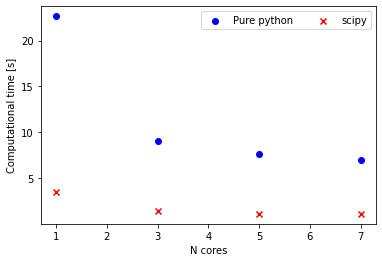

In [8]:
import time
import numpy as np 
from multiprocessing import Pool 

from functools import partial
import matplotlib.pyplot as plt 

target_functions = {'Pure python' : python_filter,
                    'scipy' : scipy_filter
                    }

# Will run the median filter using the number of cores inside the list
core_list = range(1,8,2)
buffer_list, buffer_dictionary = open_buffers(data_path='../data/spectra.fits')
N_orders = 72
for N_cores in core_list:
    print("Starting {} cores".format(N_cores))
    for name, function in target_functions.items():
        t_start = time.time() 

        # We can pass multiple arguments to the .map function by following:
        # https://stackoverflow.com/questions/25553919/passing-multiple-parameters-to-pool-map-function-in-python

        iterable = partial(worker, function, buffer_dictionary)
        
        # Dividing the orders into equaly-sized blocks
        tasks = np.array_split(range(N_orders), N_cores)

        with Pool(N_cores) as p:
            p.map(iterable, tasks)

        t_end = time.time() - t_start               


        color = 'red' if name == 'scipy' else 'blue'
        marker = 'x' if name == 'scipy' else 'o'
        label = name if N_cores == 1 else None
        plt.scatter(N_cores, t_end, color = color, marker = marker, label = label)

close_buffers(buffer_list, unlink=True)
plt.legend(ncol=2)
plt.ylabel("Computational time [s]")
plt.xlabel("N cores")
plt.show()
